In [1]:
from catboost import CatBoostClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import catboost
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMRegressor, LGBMClassifier
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import os
from imblearn.over_sampling import SMOTE
import math
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as sk
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
df=pd.read_excel('../optimal_data3_1/'+'Continous_2weeks_5day_3term.xlsx')
df.head()
X=df.iloc[:,[1,3,4,5,6,7]]
y=df.iloc[:,-1]


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_scaler,y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler.shape, y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (19500, 6) (19500,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (50937, 6) (50937,)
SMOTE 적용 전 레이블 값 분포: 
 0    16979
1     1648
2      873
Name: 8, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    16979
1    16979
2    16979
Name: 8, dtype: int64


In [3]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train_over,y_train_over)

10

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [5]:
from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [6]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [7]:
def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)
            
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

In [8]:
# X_test=pd.DataFrame()
# X_train=pd.DataFrame()
# y_test=pd.DataFrame()
# y_train=pd.DataFrame()
# empty=pd.DataFrame()

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]

In [9]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]
CMResult=[[[0 for k in range(3)]for j in range(3)] for i in range(10)]
skf.get_n_splits(X_train_over,y_train_over)

10

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 1.10738. Saving Model!
epoch 01, loss: 1.15732, acc: 0.33093, val_loss: 1.10738, val_accuracy: 0.33471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


[INFO] val_acc has been improved from 1.10738 to 1.09434. Saving Model!
epoch 02, loss: 1.10023, acc: 0.33547, val_loss: 1.09434, val_accuracy: 0.34276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


[INFO] val_acc has been improved from 1.09434 to 1.08744. Saving Model!
epoch 03, loss: 1.09177, acc: 0.34256, val_loss: 1.08744, val_accuracy: 0.35179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


[INFO] val_acc has been improved from 1.08744 to 1.08235. Saving Model!
epoch 04, loss: 1.08787, acc: 0.35689, val_loss: 1.08235, val_accuracy: 0.38123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


[INFO] val_acc has been improved from 1.08235 to 1.07743. Saving Model!
epoch 05, loss: 1.08464, acc: 0.39528, val_loss: 1.07743, val_accuracy: 0.43384


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


[INFO] val_acc has been improved from 1.07743 to 1.07222. Saving Model!
epoch 06, loss: 1.08136, acc: 0.45110, val_loss: 1.07222, val_accuracy: 0.43816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


[INFO] val_acc has been improved from 1.07222 to 1.06642. Saving Model!
epoch 07, loss: 1.07796, acc: 0.43784, val_loss: 1.06642, val_accuracy: 0.43365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


[INFO] val_acc has been improved from 1.06642 to 1.06010. Saving Model!
epoch 08, loss: 1.07457, acc: 0.42488, val_loss: 1.06010, val_accuracy: 0.44091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


[INFO] val_acc has been improved from 1.06010 to 1.05322. Saving Model!
epoch 09, loss: 1.07127, acc: 0.42632, val_loss: 1.05322, val_accuracy: 0.44150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


[INFO] val_acc has been improved from 1.05322 to 1.04605. Saving Model!
epoch 10, loss: 1.06806, acc: 0.42506, val_loss: 1.04605, val_accuracy: 0.44248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


[INFO] val_acc has been improved from 1.04605 to 1.03888. Saving Model!
epoch 11, loss: 1.06500, acc: 0.42680, val_loss: 1.03888, val_accuracy: 0.44287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


[INFO] val_acc has been improved from 1.03888 to 1.03193. Saving Model!
epoch 12, loss: 1.06209, acc: 0.42689, val_loss: 1.03193, val_accuracy: 0.44346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


[INFO] val_acc has been improved from 1.03193 to 1.02549. Saving Model!
epoch 13, loss: 1.05935, acc: 0.42818, val_loss: 1.02549, val_accuracy: 0.44562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


[INFO] val_acc has been improved from 1.02549 to 1.01908. Saving Model!
epoch 14, loss: 1.05679, acc: 0.42739, val_loss: 1.01908, val_accuracy: 0.44739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


[INFO] val_acc has been improved from 1.01908 to 1.01360. Saving Model!
epoch 15, loss: 1.05424, acc: 0.42779, val_loss: 1.01360, val_accuracy: 0.46035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


[INFO] val_acc has been improved from 1.01360 to 1.00884. Saving Model!
epoch 16, loss: 1.05186, acc: 0.42835, val_loss: 1.00884, val_accuracy: 0.46054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 1.00884 to 1.00478. Saving Model!
epoch 17, loss: 1.04953, acc: 0.43084, val_loss: 1.00478, val_accuracy: 0.46133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]


[INFO] val_acc has been improved from 1.00478 to 1.00132. Saving Model!
epoch 18, loss: 1.04735, acc: 0.43169, val_loss: 1.00132, val_accuracy: 0.46133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


[INFO] val_acc has been improved from 1.00132 to 0.99834. Saving Model!
epoch 19, loss: 1.04532, acc: 0.43322, val_loss: 0.99834, val_accuracy: 0.46192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


[INFO] val_acc has been improved from 0.99834 to 0.99565. Saving Model!
epoch 20, loss: 1.04346, acc: 0.43400, val_loss: 0.99565, val_accuracy: 0.46172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


[INFO] val_acc has been improved from 0.99565 to 0.99327. Saving Model!
epoch 21, loss: 1.04173, acc: 0.43383, val_loss: 0.99327, val_accuracy: 0.46231


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


[INFO] val_acc has been improved from 0.99327 to 0.99103. Saving Model!
epoch 22, loss: 1.04000, acc: 0.43376, val_loss: 0.99103, val_accuracy: 0.46329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.99103 to 0.98896. Saving Model!
epoch 23, loss: 1.03828, acc: 0.43350, val_loss: 0.98896, val_accuracy: 0.47566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


[INFO] val_acc has been improved from 0.98896 to 0.98708. Saving Model!
epoch 24, loss: 1.03663, acc: 0.43498, val_loss: 0.98708, val_accuracy: 0.47703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.99it/s]


[INFO] val_acc has been improved from 0.98708 to 0.98514. Saving Model!
epoch 25, loss: 1.03506, acc: 0.43843, val_loss: 0.98514, val_accuracy: 0.47762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.13it/s]


[INFO] val_acc has been improved from 0.98514 to 0.98340. Saving Model!
epoch 26, loss: 1.03349, acc: 0.44050, val_loss: 0.98340, val_accuracy: 0.48371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 0.98340 to 0.98170. Saving Model!
epoch 27, loss: 1.03181, acc: 0.44125, val_loss: 0.98170, val_accuracy: 0.48410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.99it/s]


[INFO] val_acc has been improved from 0.98170 to 0.98008. Saving Model!
epoch 28, loss: 1.03018, acc: 0.44412, val_loss: 0.98008, val_accuracy: 0.48606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.98008 to 0.97877. Saving Model!
epoch 29, loss: 1.02853, acc: 0.44419, val_loss: 0.97877, val_accuracy: 0.48645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


[INFO] val_acc has been improved from 0.97877 to 0.97753. Saving Model!
epoch 30, loss: 1.02690, acc: 0.44570, val_loss: 0.97753, val_accuracy: 0.49097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.28it/s]


[INFO] val_acc has been improved from 0.97753 to 0.97628. Saving Model!
epoch 31, loss: 1.02528, acc: 0.44502, val_loss: 0.97628, val_accuracy: 0.49234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


[INFO] val_acc has been improved from 0.97628 to 0.97533. Saving Model!
epoch 32, loss: 1.02357, acc: 0.44467, val_loss: 0.97533, val_accuracy: 0.49215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 0.97533 to 0.97468. Saving Model!
epoch 33, loss: 1.02186, acc: 0.44768, val_loss: 0.97468, val_accuracy: 0.49274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


[INFO] val_acc has been improved from 0.97468 to 0.97403. Saving Model!
epoch 34, loss: 1.02030, acc: 0.44788, val_loss: 0.97403, val_accuracy: 0.49234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


[INFO] val_acc has been improved from 0.97403 to 0.97374. Saving Model!
epoch 35, loss: 1.01866, acc: 0.44781, val_loss: 0.97374, val_accuracy: 0.49195


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


[INFO] val_acc has been improved from 0.97374 to 0.97362. Saving Model!
epoch 36, loss: 1.01706, acc: 0.44958, val_loss: 0.97362, val_accuracy: 0.49234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


[INFO] val_acc has been improved from 0.97362 to 0.97340. Saving Model!
epoch 37, loss: 1.01545, acc: 0.45004, val_loss: 0.97340, val_accuracy: 0.48861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 38, loss: 1.01373, acc: 0.45294, val_loss: 0.97367, val_accuracy: 0.49607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.47it/s]


epoch 39, loss: 1.01207, acc: 0.45311, val_loss: 0.97405, val_accuracy: 0.49234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 40, loss: 1.01046, acc: 0.45542, val_loss: 0.97364, val_accuracy: 0.49313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 41, loss: 1.00875, acc: 0.45680, val_loss: 0.97347, val_accuracy: 0.49568


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 42, loss: 1.00717, acc: 0.45878, val_loss: 0.97381, val_accuracy: 0.49548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


epoch 43, loss: 1.00569, acc: 0.45933, val_loss: 0.97467, val_accuracy: 0.49607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 44, loss: 1.00433, acc: 0.46064, val_loss: 0.97532, val_accuracy: 0.49627


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 45, loss: 1.00273, acc: 0.46123, val_loss: 0.97667, val_accuracy: 0.49804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 46, loss: 1.00119, acc: 0.46197, val_loss: 0.97792, val_accuracy: 0.49764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 47, loss: 0.99983, acc: 0.46321, val_loss: 0.97927, val_accuracy: 0.49843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 48, loss: 0.99852, acc: 0.46631, val_loss: 0.98039, val_accuracy: 0.50098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 49, loss: 0.99707, acc: 0.46712, val_loss: 0.98201, val_accuracy: 0.50098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 50, loss: 0.99577, acc: 0.46690, val_loss: 0.98322, val_accuracy: 0.50196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 51, loss: 0.99432, acc: 0.46814, val_loss: 0.98472, val_accuracy: 0.49941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 52, loss: 0.99307, acc: 0.47194, val_loss: 0.98588, val_accuracy: 0.50059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 53, loss: 0.99181, acc: 0.47322, val_loss: 0.98685, val_accuracy: 0.50177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 54, loss: 0.99058, acc: 0.47359, val_loss: 0.98836, val_accuracy: 0.50236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 55, loss: 0.98944, acc: 0.47431, val_loss: 0.98963, val_accuracy: 0.50314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 56, loss: 0.98818, acc: 0.47486, val_loss: 0.99124, val_accuracy: 0.50373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 57, loss: 0.98695, acc: 0.47538, val_loss: 0.99265, val_accuracy: 0.50452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 58, loss: 0.98598, acc: 0.47636, val_loss: 0.99235, val_accuracy: 0.50530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 59, loss: 0.98455, acc: 0.47828, val_loss: 0.99326, val_accuracy: 0.50667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 60, loss: 0.98342, acc: 0.47964, val_loss: 0.99436, val_accuracy: 0.50785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 61, loss: 0.98229, acc: 0.48160, val_loss: 0.99548, val_accuracy: 0.50766


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 62, loss: 0.98121, acc: 0.48258, val_loss: 0.99622, val_accuracy: 0.50883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 63, loss: 0.97995, acc: 0.48319, val_loss: 0.99731, val_accuracy: 0.50923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 64, loss: 0.97873, acc: 0.48459, val_loss: 0.99772, val_accuracy: 0.50962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 65, loss: 0.97759, acc: 0.48516, val_loss: 0.99890, val_accuracy: 0.50982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 66, loss: 0.97646, acc: 0.48568, val_loss: 1.00048, val_accuracy: 0.51060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 67, loss: 0.97540, acc: 0.48614, val_loss: 1.00153, val_accuracy: 0.51099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 68, loss: 0.97429, acc: 0.48692, val_loss: 1.00254, val_accuracy: 0.51178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 69, loss: 0.97314, acc: 0.48788, val_loss: 1.00290, val_accuracy: 0.51315


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.34it/s]


epoch 70, loss: 0.97211, acc: 0.48991, val_loss: 1.00415, val_accuracy: 0.50000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 71, loss: 0.97101, acc: 0.49046, val_loss: 1.00554, val_accuracy: 0.50039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


epoch 72, loss: 0.96992, acc: 0.49120, val_loss: 1.00615, val_accuracy: 0.50079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 73, loss: 0.96889, acc: 0.49150, val_loss: 1.00609, val_accuracy: 0.50000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 74, loss: 0.96764, acc: 0.49135, val_loss: 1.00757, val_accuracy: 0.50196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 75, loss: 0.96671, acc: 0.49133, val_loss: 1.00918, val_accuracy: 0.50177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 76, loss: 0.96574, acc: 0.49137, val_loss: 1.00919, val_accuracy: 0.50196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 77, loss: 0.96450, acc: 0.49181, val_loss: 1.00949, val_accuracy: 0.50746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 78, loss: 0.96337, acc: 0.49273, val_loss: 1.01090, val_accuracy: 0.50805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 79, loss: 0.96267, acc: 0.49303, val_loss: 1.01187, val_accuracy: 0.50805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 80, loss: 0.96135, acc: 0.49329, val_loss: 1.01242, val_accuracy: 0.50864


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 81, loss: 0.96028, acc: 0.49534, val_loss: 1.01322, val_accuracy: 0.50962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 82, loss: 0.95943, acc: 0.49704, val_loss: 1.01402, val_accuracy: 0.51119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 83, loss: 0.95833, acc: 0.49759, val_loss: 1.01467, val_accuracy: 0.51197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 84, loss: 0.95723, acc: 0.49816, val_loss: 1.01616, val_accuracy: 0.51256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.76it/s]


epoch 85, loss: 0.95624, acc: 0.50043, val_loss: 1.01672, val_accuracy: 0.51276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 86, loss: 0.95510, acc: 0.50208, val_loss: 1.01774, val_accuracy: 0.51355


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 87, loss: 0.95420, acc: 0.50354, val_loss: 1.01882, val_accuracy: 0.51374


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


epoch 88, loss: 0.95319, acc: 0.50459, val_loss: 1.01975, val_accuracy: 0.51492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 89, loss: 0.95208, acc: 0.50666, val_loss: 1.02071, val_accuracy: 0.51512


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s]


epoch 90, loss: 0.95111, acc: 0.50736, val_loss: 1.02159, val_accuracy: 0.51433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 91, loss: 0.95010, acc: 0.50734, val_loss: 1.02276, val_accuracy: 0.51570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 92, loss: 0.94893, acc: 0.50813, val_loss: 1.02313, val_accuracy: 0.51610


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 93, loss: 0.94791, acc: 0.50760, val_loss: 1.02428, val_accuracy: 0.51629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 94, loss: 0.94701, acc: 0.50773, val_loss: 1.02574, val_accuracy: 0.51610


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 95, loss: 0.94590, acc: 0.50791, val_loss: 1.02634, val_accuracy: 0.51629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


epoch 96, loss: 0.94487, acc: 0.50847, val_loss: 1.02755, val_accuracy: 0.51728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 97, loss: 0.94391, acc: 0.50893, val_loss: 1.02821, val_accuracy: 0.51708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 98, loss: 0.94268, acc: 0.50957, val_loss: 1.02944, val_accuracy: 0.51845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 99, loss: 0.94184, acc: 0.50998, val_loss: 1.03071, val_accuracy: 0.51845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.28it/s]


epoch 100, loss: 0.94074, acc: 0.51103, val_loss: 1.03219, val_accuracy: 0.51924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 101, loss: 0.93996, acc: 0.51144, val_loss: 1.03253, val_accuracy: 0.51904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 102, loss: 0.93858, acc: 0.51238, val_loss: 1.03417, val_accuracy: 0.52002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 103, loss: 0.93762, acc: 0.51330, val_loss: 1.03549, val_accuracy: 0.52081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 104, loss: 0.93654, acc: 0.51428, val_loss: 1.03645, val_accuracy: 0.52101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 105, loss: 0.93536, acc: 0.51498, val_loss: 1.03786, val_accuracy: 0.52140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]


epoch 106, loss: 0.93443, acc: 0.51436, val_loss: 1.03873, val_accuracy: 0.52159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 107, loss: 0.93365, acc: 0.51650, val_loss: 1.03994, val_accuracy: 0.52199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


epoch 108, loss: 0.93255, acc: 0.51772, val_loss: 1.03970, val_accuracy: 0.52238


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 109, loss: 0.93108, acc: 0.51884, val_loss: 1.04092, val_accuracy: 0.52336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 110, loss: 0.93021, acc: 0.51825, val_loss: 1.04271, val_accuracy: 0.52473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


epoch 111, loss: 0.92928, acc: 0.51844, val_loss: 1.04399, val_accuracy: 0.52513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.79it/s]


epoch 112, loss: 0.92803, acc: 0.51914, val_loss: 1.04522, val_accuracy: 0.52611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 113, loss: 0.92708, acc: 0.51831, val_loss: 1.04589, val_accuracy: 0.52631


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 114, loss: 0.92615, acc: 0.51847, val_loss: 1.04720, val_accuracy: 0.52572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]


epoch 115, loss: 0.92490, acc: 0.51947, val_loss: 1.04891, val_accuracy: 0.52670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


epoch 116, loss: 0.92388, acc: 0.51980, val_loss: 1.04979, val_accuracy: 0.52768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 117, loss: 0.92296, acc: 0.52004, val_loss: 1.05043, val_accuracy: 0.52807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 118, loss: 0.92176, acc: 0.52038, val_loss: 1.05261, val_accuracy: 0.52807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 119, loss: 0.92070, acc: 0.52119, val_loss: 1.05411, val_accuracy: 0.52159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 120, loss: 0.91978, acc: 0.52241, val_loss: 1.05546, val_accuracy: 0.52277


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.37it/s]


epoch 121, loss: 0.91867, acc: 0.52289, val_loss: 1.05684, val_accuracy: 0.52258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 122, loss: 0.91803, acc: 0.52335, val_loss: 1.05669, val_accuracy: 0.52395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 123, loss: 0.91666, acc: 0.52392, val_loss: 1.05794, val_accuracy: 0.52513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


epoch 124, loss: 0.91545, acc: 0.52516, val_loss: 1.05986, val_accuracy: 0.52689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 125, loss: 0.91452, acc: 0.52680, val_loss: 1.06163, val_accuracy: 0.52807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


epoch 126, loss: 0.91382, acc: 0.52739, val_loss: 1.06219, val_accuracy: 0.52827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 127, loss: 0.91272, acc: 0.52859, val_loss: 1.06247, val_accuracy: 0.52827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 128, loss: 0.91155, acc: 0.53044, val_loss: 1.06371, val_accuracy: 0.52925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 129, loss: 0.91041, acc: 0.53096, val_loss: 1.06524, val_accuracy: 0.52964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 130, loss: 0.90984, acc: 0.53195, val_loss: 1.06629, val_accuracy: 0.53102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 131, loss: 0.90875, acc: 0.53190, val_loss: 1.06766, val_accuracy: 0.53062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 132, loss: 0.90751, acc: 0.53308, val_loss: 1.06825, val_accuracy: 0.53102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 133, loss: 0.90658, acc: 0.53203, val_loss: 1.06908, val_accuracy: 0.53141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 134, loss: 0.90569, acc: 0.53232, val_loss: 1.07006, val_accuracy: 0.53121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 135, loss: 0.90474, acc: 0.53282, val_loss: 1.07155, val_accuracy: 0.53219


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 136, loss: 0.90364, acc: 0.53454, val_loss: 1.07314, val_accuracy: 0.53259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 137, loss: 0.90284, acc: 0.53616, val_loss: 1.07403, val_accuracy: 0.53337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 138, loss: 0.90179, acc: 0.53718, val_loss: 1.07440, val_accuracy: 0.53357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.22it/s]


epoch 139, loss: 0.90073, acc: 0.53775, val_loss: 1.07571, val_accuracy: 0.53377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 140, loss: 0.89989, acc: 0.53792, val_loss: 1.07726, val_accuracy: 0.53396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 141, loss: 0.89907, acc: 0.53882, val_loss: 1.07848, val_accuracy: 0.53455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s]


epoch 142, loss: 0.89790, acc: 0.53958, val_loss: 1.07928, val_accuracy: 0.53534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 143, loss: 0.89690, acc: 0.54170, val_loss: 1.08056, val_accuracy: 0.53592


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 144, loss: 0.89627, acc: 0.54205, val_loss: 1.08107, val_accuracy: 0.53671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 145, loss: 0.89524, acc: 0.54266, val_loss: 1.08185, val_accuracy: 0.53691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 146, loss: 0.89423, acc: 0.54503, val_loss: 1.08300, val_accuracy: 0.53691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 147, loss: 0.89318, acc: 0.54586, val_loss: 1.08462, val_accuracy: 0.53808


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 148, loss: 0.89256, acc: 0.54604, val_loss: 1.08558, val_accuracy: 0.53848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 149, loss: 0.89140, acc: 0.54746, val_loss: 1.08668, val_accuracy: 0.53867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 150, loss: 0.89057, acc: 0.54804, val_loss: 1.08702, val_accuracy: 0.53867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 151, loss: 0.88945, acc: 0.54848, val_loss: 1.08893, val_accuracy: 0.53946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 152, loss: 0.88882, acc: 0.54870, val_loss: 1.08986, val_accuracy: 0.54044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 153, loss: 0.88783, acc: 0.54959, val_loss: 1.09092, val_accuracy: 0.54064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 154, loss: 0.88695, acc: 0.55077, val_loss: 1.09141, val_accuracy: 0.54103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 155, loss: 0.88598, acc: 0.55114, val_loss: 1.09189, val_accuracy: 0.54221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 156, loss: 0.88513, acc: 0.55184, val_loss: 1.09322, val_accuracy: 0.54181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 157, loss: 0.88413, acc: 0.55232, val_loss: 1.09470, val_accuracy: 0.54162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 158, loss: 0.88337, acc: 0.55308, val_loss: 1.09531, val_accuracy: 0.54181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 159, loss: 0.88243, acc: 0.55365, val_loss: 1.09610, val_accuracy: 0.54280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 160, loss: 0.88151, acc: 0.55422, val_loss: 1.09734, val_accuracy: 0.54397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 161, loss: 0.88069, acc: 0.55500, val_loss: 1.09845, val_accuracy: 0.54397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 162, loss: 0.87974, acc: 0.55526, val_loss: 1.09959, val_accuracy: 0.54378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 163, loss: 0.87898, acc: 0.55557, val_loss: 1.10018, val_accuracy: 0.54456


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 164, loss: 0.87805, acc: 0.55747, val_loss: 1.10114, val_accuracy: 0.54495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.34it/s]


epoch 165, loss: 0.87707, acc: 0.55806, val_loss: 1.10203, val_accuracy: 0.54574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.34it/s]


epoch 166, loss: 0.87636, acc: 0.55821, val_loss: 1.10190, val_accuracy: 0.54613


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 167, loss: 0.87540, acc: 0.55871, val_loss: 1.10280, val_accuracy: 0.54653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 168, loss: 0.87454, acc: 0.55906, val_loss: 1.10459, val_accuracy: 0.54554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.76it/s]


epoch 169, loss: 0.87355, acc: 0.55980, val_loss: 1.10550, val_accuracy: 0.54653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


epoch 170, loss: 0.87297, acc: 0.55978, val_loss: 1.10586, val_accuracy: 0.54613


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 171, loss: 0.87184, acc: 0.56004, val_loss: 1.10695, val_accuracy: 0.54594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 172, loss: 0.87094, acc: 0.56065, val_loss: 1.10808, val_accuracy: 0.54633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 173, loss: 0.87012, acc: 0.56142, val_loss: 1.10838, val_accuracy: 0.54653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 174, loss: 0.86950, acc: 0.56185, val_loss: 1.10855, val_accuracy: 0.54594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 175, loss: 0.86839, acc: 0.56290, val_loss: 1.10967, val_accuracy: 0.54594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 176, loss: 0.86770, acc: 0.56277, val_loss: 1.10971, val_accuracy: 0.54751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 177, loss: 0.86671, acc: 0.56310, val_loss: 1.11028, val_accuracy: 0.54751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 178, loss: 0.86617, acc: 0.56292, val_loss: 1.11024, val_accuracy: 0.54751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 179, loss: 0.86521, acc: 0.56368, val_loss: 1.11071, val_accuracy: 0.54810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 180, loss: 0.86429, acc: 0.56443, val_loss: 1.11050, val_accuracy: 0.54417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 181, loss: 0.86351, acc: 0.56493, val_loss: 1.11108, val_accuracy: 0.54476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 182, loss: 0.86279, acc: 0.56536, val_loss: 1.11074, val_accuracy: 0.54554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 183, loss: 0.86189, acc: 0.56582, val_loss: 1.11123, val_accuracy: 0.54554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


epoch 184, loss: 0.86116, acc: 0.56637, val_loss: 1.11107, val_accuracy: 0.54515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 185, loss: 0.86042, acc: 0.56711, val_loss: 1.11155, val_accuracy: 0.54495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 186, loss: 0.85942, acc: 0.56787, val_loss: 1.11330, val_accuracy: 0.53337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 187, loss: 0.85873, acc: 0.56824, val_loss: 1.11267, val_accuracy: 0.53337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 188, loss: 0.85795, acc: 0.56851, val_loss: 1.11265, val_accuracy: 0.53475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 189, loss: 0.85711, acc: 0.56905, val_loss: 1.11255, val_accuracy: 0.53435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 190, loss: 0.85630, acc: 0.56927, val_loss: 1.11336, val_accuracy: 0.53553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 191, loss: 0.85569, acc: 0.56918, val_loss: 1.11381, val_accuracy: 0.53534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 192, loss: 0.85493, acc: 0.56942, val_loss: 1.11387, val_accuracy: 0.53710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 193, loss: 0.85411, acc: 0.56971, val_loss: 1.11366, val_accuracy: 0.53730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 194, loss: 0.85327, acc: 0.57117, val_loss: 1.11385, val_accuracy: 0.53671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 195, loss: 0.85244, acc: 0.57160, val_loss: 1.11416, val_accuracy: 0.53710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 196, loss: 0.85183, acc: 0.57195, val_loss: 1.11461, val_accuracy: 0.53985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 197, loss: 0.85120, acc: 0.57228, val_loss: 1.11414, val_accuracy: 0.54024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 198, loss: 0.85024, acc: 0.57287, val_loss: 1.11480, val_accuracy: 0.54064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 199, loss: 0.84935, acc: 0.57320, val_loss: 1.11535, val_accuracy: 0.54162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 200, loss: 0.84901, acc: 0.57341, val_loss: 1.11562, val_accuracy: 0.54201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 201, loss: 0.84798, acc: 0.57413, val_loss: 1.11542, val_accuracy: 0.54456


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 202, loss: 0.84718, acc: 0.57474, val_loss: 1.11514, val_accuracy: 0.54495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 203, loss: 0.84656, acc: 0.57525, val_loss: 1.11574, val_accuracy: 0.54594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 204, loss: 0.84571, acc: 0.57559, val_loss: 1.11563, val_accuracy: 0.54692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 205, loss: 0.84517, acc: 0.57586, val_loss: 1.11527, val_accuracy: 0.54711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 206, loss: 0.84403, acc: 0.57638, val_loss: 1.11609, val_accuracy: 0.54751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 207, loss: 0.84380, acc: 0.57712, val_loss: 1.11609, val_accuracy: 0.54829


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 208, loss: 0.84277, acc: 0.57732, val_loss: 1.11622, val_accuracy: 0.54849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 209, loss: 0.84210, acc: 0.57758, val_loss: 1.11607, val_accuracy: 0.54967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 210, loss: 0.84137, acc: 0.57795, val_loss: 1.11629, val_accuracy: 0.55026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 211, loss: 0.84080, acc: 0.57865, val_loss: 1.11599, val_accuracy: 0.55084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 212, loss: 0.83983, acc: 0.57861, val_loss: 1.11560, val_accuracy: 0.55143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 213, loss: 0.83918, acc: 0.58048, val_loss: 1.11608, val_accuracy: 0.55261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 214, loss: 0.83866, acc: 0.58081, val_loss: 1.11626, val_accuracy: 0.55340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 215, loss: 0.83766, acc: 0.58022, val_loss: 1.11638, val_accuracy: 0.55261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 216, loss: 0.83716, acc: 0.58199, val_loss: 1.11681, val_accuracy: 0.55261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 217, loss: 0.83645, acc: 0.58284, val_loss: 1.11643, val_accuracy: 0.55281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 218, loss: 0.83561, acc: 0.58367, val_loss: 1.11545, val_accuracy: 0.55300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 219, loss: 0.83486, acc: 0.58417, val_loss: 1.11569, val_accuracy: 0.55340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 220, loss: 0.83449, acc: 0.58432, val_loss: 1.11540, val_accuracy: 0.55340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 221, loss: 0.83318, acc: 0.58476, val_loss: 1.11556, val_accuracy: 0.55418


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 222, loss: 0.83317, acc: 0.58489, val_loss: 1.11526, val_accuracy: 0.55477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 223, loss: 0.83211, acc: 0.58554, val_loss: 1.11465, val_accuracy: 0.55575


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 224, loss: 0.83144, acc: 0.58591, val_loss: 1.11353, val_accuracy: 0.55634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 225, loss: 0.83055, acc: 0.58631, val_loss: 1.11433, val_accuracy: 0.55673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 226, loss: 0.83027, acc: 0.58694, val_loss: 1.11396, val_accuracy: 0.55673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 227, loss: 0.82951, acc: 0.58740, val_loss: 1.11325, val_accuracy: 0.55693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 228, loss: 0.82834, acc: 0.58929, val_loss: 1.11328, val_accuracy: 0.55693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 229, loss: 0.82820, acc: 0.58947, val_loss: 1.11289, val_accuracy: 0.55732


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 230, loss: 0.82731, acc: 0.58960, val_loss: 1.11238, val_accuracy: 0.55752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 231, loss: 0.82645, acc: 0.58999, val_loss: 1.11275, val_accuracy: 0.55870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 232, loss: 0.82578, acc: 0.59069, val_loss: 1.11328, val_accuracy: 0.56027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 233, loss: 0.82554, acc: 0.59130, val_loss: 1.11220, val_accuracy: 0.55987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 234, loss: 0.82456, acc: 0.59204, val_loss: 1.11113, val_accuracy: 0.56086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 235, loss: 0.82373, acc: 0.59202, val_loss: 1.11178, val_accuracy: 0.56086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 236, loss: 0.82325, acc: 0.59261, val_loss: 1.11086, val_accuracy: 0.56125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 237, loss: 0.82265, acc: 0.59276, val_loss: 1.11095, val_accuracy: 0.56164


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 238, loss: 0.82195, acc: 0.59311, val_loss: 1.11054, val_accuracy: 0.56243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 239, loss: 0.82118, acc: 0.59368, val_loss: 1.11024, val_accuracy: 0.56164


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 240, loss: 0.82047, acc: 0.59414, val_loss: 1.11056, val_accuracy: 0.56223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 241, loss: 0.82003, acc: 0.59507, val_loss: 1.10983, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 242, loss: 0.81926, acc: 0.59473, val_loss: 1.10905, val_accuracy: 0.56321


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 243, loss: 0.81880, acc: 0.59588, val_loss: 1.10921, val_accuracy: 0.56282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 244, loss: 0.81772, acc: 0.59704, val_loss: 1.10939, val_accuracy: 0.56262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 245, loss: 0.81757, acc: 0.59723, val_loss: 1.10803, val_accuracy: 0.56360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 246, loss: 0.81663, acc: 0.59760, val_loss: 1.10805, val_accuracy: 0.56439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 247, loss: 0.81602, acc: 0.59828, val_loss: 1.10782, val_accuracy: 0.56616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 248, loss: 0.81572, acc: 0.59880, val_loss: 1.10770, val_accuracy: 0.56635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 249, loss: 0.81462, acc: 0.59961, val_loss: 1.10760, val_accuracy: 0.56596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


epoch 250, loss: 0.81399, acc: 0.59944, val_loss: 1.10742, val_accuracy: 0.56832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 251, loss: 0.81397, acc: 0.59955, val_loss: 1.10687, val_accuracy: 0.56655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 252, loss: 0.81278, acc: 0.60070, val_loss: 1.10763, val_accuracy: 0.56851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 253, loss: 0.81219, acc: 0.60125, val_loss: 1.10750, val_accuracy: 0.56871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 254, loss: 0.81185, acc: 0.60199, val_loss: 1.10629, val_accuracy: 0.56694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 255, loss: 0.81097, acc: 0.60271, val_loss: 1.10711, val_accuracy: 0.56910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 256, loss: 0.81019, acc: 0.60315, val_loss: 1.10679, val_accuracy: 0.56969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 257, loss: 0.81004, acc: 0.60334, val_loss: 1.10632, val_accuracy: 0.56949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 258, loss: 0.80921, acc: 0.60421, val_loss: 1.10702, val_accuracy: 0.56969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 259, loss: 0.80831, acc: 0.60395, val_loss: 1.10732, val_accuracy: 0.57048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 260, loss: 0.80812, acc: 0.60467, val_loss: 1.10615, val_accuracy: 0.56969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 261, loss: 0.80727, acc: 0.60496, val_loss: 1.10647, val_accuracy: 0.56969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 262, loss: 0.80677, acc: 0.60511, val_loss: 1.10644, val_accuracy: 0.56949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 263, loss: 0.80605, acc: 0.60594, val_loss: 1.10639, val_accuracy: 0.56989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 264, loss: 0.80561, acc: 0.60642, val_loss: 1.10591, val_accuracy: 0.57048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 265, loss: 0.80476, acc: 0.60762, val_loss: 1.10587, val_accuracy: 0.57028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 266, loss: 0.80408, acc: 0.60760, val_loss: 1.10656, val_accuracy: 0.57106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 267, loss: 0.80395, acc: 0.60790, val_loss: 1.10612, val_accuracy: 0.57106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 268, loss: 0.80302, acc: 0.60947, val_loss: 1.10667, val_accuracy: 0.57165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 269, loss: 0.80247, acc: 0.60928, val_loss: 1.10668, val_accuracy: 0.57185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 270, loss: 0.80191, acc: 0.60952, val_loss: 1.10637, val_accuracy: 0.57205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 271, loss: 0.80109, acc: 0.61043, val_loss: 1.10686, val_accuracy: 0.57303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 272, loss: 0.80088, acc: 0.61028, val_loss: 1.10726, val_accuracy: 0.57322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.52it/s]


epoch 273, loss: 0.79995, acc: 0.61115, val_loss: 1.10752, val_accuracy: 0.57420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.44it/s]


epoch 274, loss: 0.79950, acc: 0.61146, val_loss: 1.10813, val_accuracy: 0.57362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 275, loss: 0.79909, acc: 0.61174, val_loss: 1.10782, val_accuracy: 0.57460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 276, loss: 0.79811, acc: 0.61143, val_loss: 1.10837, val_accuracy: 0.57479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.76it/s]


epoch 277, loss: 0.79783, acc: 0.61218, val_loss: 1.10806, val_accuracy: 0.57519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.72it/s]


epoch 278, loss: 0.79715, acc: 0.61185, val_loss: 1.10886, val_accuracy: 0.57538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 279, loss: 0.79645, acc: 0.61246, val_loss: 1.10973, val_accuracy: 0.57597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


epoch 280, loss: 0.79632, acc: 0.61253, val_loss: 1.10913, val_accuracy: 0.57578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 281, loss: 0.79515, acc: 0.61307, val_loss: 1.10976, val_accuracy: 0.57617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 282, loss: 0.79494, acc: 0.61335, val_loss: 1.11014, val_accuracy: 0.57676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 283, loss: 0.79428, acc: 0.61351, val_loss: 1.11067, val_accuracy: 0.57715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 284, loss: 0.79369, acc: 0.61375, val_loss: 1.11072, val_accuracy: 0.57695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 285, loss: 0.79302, acc: 0.61475, val_loss: 1.11040, val_accuracy: 0.57754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 286, loss: 0.79262, acc: 0.61591, val_loss: 1.11085, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 287, loss: 0.79196, acc: 0.61521, val_loss: 1.11086, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 288, loss: 0.79109, acc: 0.61682, val_loss: 1.11101, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 289, loss: 0.79105, acc: 0.61687, val_loss: 1.11136, val_accuracy: 0.57872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 290, loss: 0.79029, acc: 0.61739, val_loss: 1.11238, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 291, loss: 0.78971, acc: 0.61702, val_loss: 1.11278, val_accuracy: 0.57813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 292, loss: 0.78906, acc: 0.61772, val_loss: 1.11254, val_accuracy: 0.57833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 293, loss: 0.78838, acc: 0.61842, val_loss: 1.11336, val_accuracy: 0.57892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 294, loss: 0.78814, acc: 0.61846, val_loss: 1.11331, val_accuracy: 0.57892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 295, loss: 0.78721, acc: 0.61979, val_loss: 1.11321, val_accuracy: 0.57872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


epoch 296, loss: 0.78684, acc: 0.62040, val_loss: 1.11272, val_accuracy: 0.57931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 297, loss: 0.78665, acc: 0.62125, val_loss: 1.11195, val_accuracy: 0.57970


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.10it/s]


epoch 298, loss: 0.78545, acc: 0.62201, val_loss: 1.11220, val_accuracy: 0.58009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 299, loss: 0.78512, acc: 0.62241, val_loss: 1.11196, val_accuracy: 0.58108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 300, loss: 0.78471, acc: 0.62236, val_loss: 1.11158, val_accuracy: 0.58068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


epoch 301, loss: 0.78421, acc: 0.62308, val_loss: 1.11122, val_accuracy: 0.58088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 302, loss: 0.78343, acc: 0.62437, val_loss: 1.11137, val_accuracy: 0.58108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 303, loss: 0.78292, acc: 0.62441, val_loss: 1.11083, val_accuracy: 0.58147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 304, loss: 0.78256, acc: 0.62498, val_loss: 1.11049, val_accuracy: 0.58127


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 305, loss: 0.78179, acc: 0.62607, val_loss: 1.11155, val_accuracy: 0.58068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 306, loss: 0.78143, acc: 0.62579, val_loss: 1.11243, val_accuracy: 0.58127


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 307, loss: 0.78076, acc: 0.62585, val_loss: 1.11275, val_accuracy: 0.58225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 308, loss: 0.78024, acc: 0.62681, val_loss: 1.11361, val_accuracy: 0.58245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 309, loss: 0.77977, acc: 0.62714, val_loss: 1.11367, val_accuracy: 0.58245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 310, loss: 0.77894, acc: 0.62718, val_loss: 1.11375, val_accuracy: 0.58304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 311, loss: 0.77849, acc: 0.62786, val_loss: 1.11413, val_accuracy: 0.58324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 312, loss: 0.77849, acc: 0.62869, val_loss: 1.11537, val_accuracy: 0.58265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 313, loss: 0.77738, acc: 0.62917, val_loss: 1.11650, val_accuracy: 0.58382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


epoch 314, loss: 0.77689, acc: 0.62967, val_loss: 1.11589, val_accuracy: 0.58422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 315, loss: 0.77623, acc: 0.62993, val_loss: 1.11685, val_accuracy: 0.58441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 316, loss: 0.77609, acc: 0.63037, val_loss: 1.11744, val_accuracy: 0.58363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 317, loss: 0.77553, acc: 0.63074, val_loss: 1.11717, val_accuracy: 0.58382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 318, loss: 0.77460, acc: 0.63107, val_loss: 1.11791, val_accuracy: 0.58363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 319, loss: 0.77442, acc: 0.63118, val_loss: 1.11833, val_accuracy: 0.58402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 320, loss: 0.77371, acc: 0.63139, val_loss: 1.11755, val_accuracy: 0.58382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 321, loss: 0.77328, acc: 0.63148, val_loss: 1.11852, val_accuracy: 0.58422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 322, loss: 0.77277, acc: 0.63174, val_loss: 1.11858, val_accuracy: 0.58402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 323, loss: 0.77214, acc: 0.63174, val_loss: 1.11878, val_accuracy: 0.58382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 324, loss: 0.77192, acc: 0.63246, val_loss: 1.11907, val_accuracy: 0.58461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 325, loss: 0.77100, acc: 0.63318, val_loss: 1.11951, val_accuracy: 0.58520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 326, loss: 0.77060, acc: 0.63318, val_loss: 1.11945, val_accuracy: 0.58539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 327, loss: 0.77040, acc: 0.63320, val_loss: 1.11942, val_accuracy: 0.58539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 328, loss: 0.76952, acc: 0.63358, val_loss: 1.11927, val_accuracy: 0.58618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 329, loss: 0.76894, acc: 0.63392, val_loss: 1.12043, val_accuracy: 0.58638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 330, loss: 0.76877, acc: 0.63425, val_loss: 1.12010, val_accuracy: 0.58657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 331, loss: 0.76827, acc: 0.63445, val_loss: 1.11985, val_accuracy: 0.58677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 332, loss: 0.76771, acc: 0.63495, val_loss: 1.12016, val_accuracy: 0.58677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 333, loss: 0.76690, acc: 0.63560, val_loss: 1.12141, val_accuracy: 0.58657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 334, loss: 0.76688, acc: 0.63550, val_loss: 1.12096, val_accuracy: 0.58736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 335, loss: 0.76612, acc: 0.63676, val_loss: 1.12107, val_accuracy: 0.58795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 336, loss: 0.76550, acc: 0.63726, val_loss: 1.12245, val_accuracy: 0.58775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 337, loss: 0.76543, acc: 0.63757, val_loss: 1.12196, val_accuracy: 0.58873


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 338, loss: 0.76453, acc: 0.63779, val_loss: 1.12193, val_accuracy: 0.58893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 339, loss: 0.76413, acc: 0.63837, val_loss: 1.12304, val_accuracy: 0.58893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 340, loss: 0.76386, acc: 0.63870, val_loss: 1.12268, val_accuracy: 0.58893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 341, loss: 0.76309, acc: 0.63984, val_loss: 1.12303, val_accuracy: 0.58932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 342, loss: 0.76277, acc: 0.64084, val_loss: 1.12295, val_accuracy: 0.59030


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 343, loss: 0.76228, acc: 0.64114, val_loss: 1.12334, val_accuracy: 0.59089


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 344, loss: 0.76165, acc: 0.64099, val_loss: 1.12373, val_accuracy: 0.59069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 345, loss: 0.76127, acc: 0.64134, val_loss: 1.12346, val_accuracy: 0.59187


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 346, loss: 0.76109, acc: 0.64158, val_loss: 1.12371, val_accuracy: 0.59187


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 347, loss: 0.76011, acc: 0.64210, val_loss: 1.12427, val_accuracy: 0.59168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 348, loss: 0.75982, acc: 0.64285, val_loss: 1.12452, val_accuracy: 0.59207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 349, loss: 0.75953, acc: 0.64387, val_loss: 1.12382, val_accuracy: 0.59227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 350, loss: 0.75885, acc: 0.64317, val_loss: 1.12478, val_accuracy: 0.59285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 351, loss: 0.75847, acc: 0.64359, val_loss: 1.12505, val_accuracy: 0.59305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.64it/s]


epoch 352, loss: 0.75779, acc: 0.64405, val_loss: 1.12439, val_accuracy: 0.59344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 353, loss: 0.75727, acc: 0.64424, val_loss: 1.12470, val_accuracy: 0.59344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 354, loss: 0.75708, acc: 0.64437, val_loss: 1.12522, val_accuracy: 0.59305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 355, loss: 0.75655, acc: 0.64483, val_loss: 1.12433, val_accuracy: 0.59246


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 356, loss: 0.75590, acc: 0.64531, val_loss: 1.12570, val_accuracy: 0.59285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 357, loss: 0.75548, acc: 0.64564, val_loss: 1.12625, val_accuracy: 0.59325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 358, loss: 0.75504, acc: 0.64594, val_loss: 1.12609, val_accuracy: 0.59325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 359, loss: 0.75449, acc: 0.64612, val_loss: 1.12723, val_accuracy: 0.59364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 360, loss: 0.75428, acc: 0.64640, val_loss: 1.12668, val_accuracy: 0.59344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 361, loss: 0.75333, acc: 0.64666, val_loss: 1.12683, val_accuracy: 0.59403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 362, loss: 0.75308, acc: 0.64693, val_loss: 1.12674, val_accuracy: 0.59364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 363, loss: 0.75321, acc: 0.64710, val_loss: 1.12741, val_accuracy: 0.59364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 364, loss: 0.75180, acc: 0.64956, val_loss: 1.12773, val_accuracy: 0.59344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 365, loss: 0.75180, acc: 0.64865, val_loss: 1.12744, val_accuracy: 0.59364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 366, loss: 0.75144, acc: 0.64889, val_loss: 1.12780, val_accuracy: 0.59403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 367, loss: 0.75071, acc: 0.64935, val_loss: 1.12807, val_accuracy: 0.59364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 368, loss: 0.75050, acc: 0.64963, val_loss: 1.12820, val_accuracy: 0.59403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 369, loss: 0.74977, acc: 0.65002, val_loss: 1.12868, val_accuracy: 0.59364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 370, loss: 0.74964, acc: 0.65050, val_loss: 1.12881, val_accuracy: 0.59403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 371, loss: 0.74901, acc: 0.65076, val_loss: 1.12863, val_accuracy: 0.59384


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 372, loss: 0.74820, acc: 0.65120, val_loss: 1.12898, val_accuracy: 0.59423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 373, loss: 0.74836, acc: 0.65111, val_loss: 1.12969, val_accuracy: 0.59442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 374, loss: 0.74765, acc: 0.65155, val_loss: 1.12917, val_accuracy: 0.59521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 375, loss: 0.74690, acc: 0.65210, val_loss: 1.12891, val_accuracy: 0.59521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 376, loss: 0.74674, acc: 0.65244, val_loss: 1.12943, val_accuracy: 0.59501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 377, loss: 0.74631, acc: 0.65271, val_loss: 1.12939, val_accuracy: 0.59541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 378, loss: 0.74558, acc: 0.65404, val_loss: 1.12958, val_accuracy: 0.59560


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 379, loss: 0.74500, acc: 0.65312, val_loss: 1.12979, val_accuracy: 0.59560


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 380, loss: 0.74497, acc: 0.65295, val_loss: 1.12951, val_accuracy: 0.59580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 381, loss: 0.74430, acc: 0.65310, val_loss: 1.13070, val_accuracy: 0.59678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 382, loss: 0.74381, acc: 0.65314, val_loss: 1.12992, val_accuracy: 0.59658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 383, loss: 0.74338, acc: 0.65364, val_loss: 1.13044, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 384, loss: 0.74279, acc: 0.65436, val_loss: 1.13055, val_accuracy: 0.59776


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 385, loss: 0.74250, acc: 0.65484, val_loss: 1.12981, val_accuracy: 0.59776


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 386, loss: 0.74191, acc: 0.65517, val_loss: 1.13160, val_accuracy: 0.59835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 387, loss: 0.74137, acc: 0.65589, val_loss: 1.13220, val_accuracy: 0.59953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 388, loss: 0.74112, acc: 0.65635, val_loss: 1.13080, val_accuracy: 0.59953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 389, loss: 0.74041, acc: 0.65639, val_loss: 1.13123, val_accuracy: 0.59914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 390, loss: 0.74005, acc: 0.65746, val_loss: 1.13177, val_accuracy: 0.59933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 391, loss: 0.73945, acc: 0.65790, val_loss: 1.13315, val_accuracy: 0.59894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 392, loss: 0.73909, acc: 0.65781, val_loss: 1.13141, val_accuracy: 0.59855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 393, loss: 0.73861, acc: 0.65766, val_loss: 1.13171, val_accuracy: 0.59874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s]


epoch 394, loss: 0.73812, acc: 0.65925, val_loss: 1.13284, val_accuracy: 0.59855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 395, loss: 0.73765, acc: 0.65870, val_loss: 1.13218, val_accuracy: 0.59933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 396, loss: 0.73703, acc: 0.65993, val_loss: 1.13292, val_accuracy: 0.59933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 397, loss: 0.73689, acc: 0.65881, val_loss: 1.13279, val_accuracy: 0.59933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 398, loss: 0.73603, acc: 0.65916, val_loss: 1.13310, val_accuracy: 0.59600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 399, loss: 0.73603, acc: 0.65938, val_loss: 1.13198, val_accuracy: 0.60031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 400, loss: 0.73508, acc: 0.66054, val_loss: 1.13299, val_accuracy: 0.59619


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 401, loss: 0.73488, acc: 0.65938, val_loss: 1.13366, val_accuracy: 0.59658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 402, loss: 0.73442, acc: 0.66008, val_loss: 1.13199, val_accuracy: 0.59678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 403, loss: 0.73394, acc: 0.66148, val_loss: 1.13183, val_accuracy: 0.59619


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 404, loss: 0.73342, acc: 0.66032, val_loss: 1.13319, val_accuracy: 0.59698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 405, loss: 0.73309, acc: 0.66069, val_loss: 1.13266, val_accuracy: 0.59737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 406, loss: 0.73256, acc: 0.66104, val_loss: 1.13245, val_accuracy: 0.59678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 407, loss: 0.73210, acc: 0.66117, val_loss: 1.13217, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 408, loss: 0.73156, acc: 0.66174, val_loss: 1.13352, val_accuracy: 0.59698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 409, loss: 0.73137, acc: 0.66174, val_loss: 1.13232, val_accuracy: 0.59698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 410, loss: 0.73052, acc: 0.66322, val_loss: 1.13228, val_accuracy: 0.59717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 411, loss: 0.73037, acc: 0.66222, val_loss: 1.13224, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 412, loss: 0.72983, acc: 0.66252, val_loss: 1.13101, val_accuracy: 0.59796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 413, loss: 0.72964, acc: 0.66285, val_loss: 1.13068, val_accuracy: 0.59835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 414, loss: 0.72872, acc: 0.66516, val_loss: 1.13177, val_accuracy: 0.59815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 415, loss: 0.72860, acc: 0.66394, val_loss: 1.13091, val_accuracy: 0.59815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 416, loss: 0.72795, acc: 0.66440, val_loss: 1.13112, val_accuracy: 0.59894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 417, loss: 0.72779, acc: 0.66588, val_loss: 1.13128, val_accuracy: 0.59874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 418, loss: 0.72723, acc: 0.66614, val_loss: 1.13083, val_accuracy: 0.59874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 419, loss: 0.72669, acc: 0.66632, val_loss: 1.13112, val_accuracy: 0.59855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 420, loss: 0.72640, acc: 0.66800, val_loss: 1.13134, val_accuracy: 0.59835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 421, loss: 0.72583, acc: 0.66830, val_loss: 1.13080, val_accuracy: 0.59933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 422, loss: 0.72543, acc: 0.66712, val_loss: 1.13015, val_accuracy: 0.59953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 423, loss: 0.72497, acc: 0.66734, val_loss: 1.13144, val_accuracy: 0.59894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 424, loss: 0.72469, acc: 0.66798, val_loss: 1.13046, val_accuracy: 0.59973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 425, loss: 0.72405, acc: 0.66819, val_loss: 1.13083, val_accuracy: 0.59914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 426, loss: 0.72371, acc: 0.66795, val_loss: 1.13174, val_accuracy: 0.59973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 427, loss: 0.72312, acc: 0.66946, val_loss: 1.13096, val_accuracy: 0.60031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]


epoch 428, loss: 0.72302, acc: 0.66933, val_loss: 1.13067, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 429, loss: 0.72219, acc: 0.66856, val_loss: 1.13137, val_accuracy: 0.60149


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 430, loss: 0.72211, acc: 0.66837, val_loss: 1.13014, val_accuracy: 0.60169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 431, loss: 0.72123, acc: 0.66924, val_loss: 1.13193, val_accuracy: 0.60188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 432, loss: 0.72122, acc: 0.66931, val_loss: 1.13112, val_accuracy: 0.60208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 433, loss: 0.72068, acc: 0.67051, val_loss: 1.13097, val_accuracy: 0.60267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 434, loss: 0.71998, acc: 0.67075, val_loss: 1.13125, val_accuracy: 0.59737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 435, loss: 0.71966, acc: 0.66961, val_loss: 1.13179, val_accuracy: 0.60306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 436, loss: 0.71970, acc: 0.66913, val_loss: 1.13090, val_accuracy: 0.60287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 437, loss: 0.71862, acc: 0.67173, val_loss: 1.13159, val_accuracy: 0.59678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 438, loss: 0.71854, acc: 0.67061, val_loss: 1.13224, val_accuracy: 0.59698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 439, loss: 0.71811, acc: 0.67199, val_loss: 1.13390, val_accuracy: 0.59737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 440, loss: 0.71750, acc: 0.67107, val_loss: 1.13420, val_accuracy: 0.60404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 441, loss: 0.71740, acc: 0.67131, val_loss: 1.13350, val_accuracy: 0.60365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 442, loss: 0.71651, acc: 0.67280, val_loss: 1.13329, val_accuracy: 0.60424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 443, loss: 0.71638, acc: 0.67223, val_loss: 1.13333, val_accuracy: 0.60404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 444, loss: 0.71584, acc: 0.67264, val_loss: 1.13322, val_accuracy: 0.59855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 445, loss: 0.71547, acc: 0.67321, val_loss: 1.13400, val_accuracy: 0.59874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 446, loss: 0.71498, acc: 0.67225, val_loss: 1.13429, val_accuracy: 0.59855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 447, loss: 0.71468, acc: 0.67417, val_loss: 1.13411, val_accuracy: 0.59953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 448, loss: 0.71401, acc: 0.67336, val_loss: 1.13389, val_accuracy: 0.59933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 449, loss: 0.71395, acc: 0.67463, val_loss: 1.13495, val_accuracy: 0.59953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 450, loss: 0.71319, acc: 0.67482, val_loss: 1.13501, val_accuracy: 0.59953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 451, loss: 0.71298, acc: 0.67496, val_loss: 1.13512, val_accuracy: 0.59933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 452, loss: 0.71238, acc: 0.67404, val_loss: 1.13535, val_accuracy: 0.60012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 453, loss: 0.71221, acc: 0.67456, val_loss: 1.13540, val_accuracy: 0.60640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 454, loss: 0.71152, acc: 0.67474, val_loss: 1.13592, val_accuracy: 0.60130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 455, loss: 0.71126, acc: 0.67624, val_loss: 1.13549, val_accuracy: 0.60051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 456, loss: 0.71065, acc: 0.67644, val_loss: 1.13759, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 457, loss: 0.71077, acc: 0.67674, val_loss: 1.13852, val_accuracy: 0.60071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 458, loss: 0.70976, acc: 0.67683, val_loss: 1.13886, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 459, loss: 0.70963, acc: 0.67568, val_loss: 1.13804, val_accuracy: 0.60051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 460, loss: 0.70930, acc: 0.67592, val_loss: 1.13768, val_accuracy: 0.60071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 461, loss: 0.70859, acc: 0.67814, val_loss: 1.13809, val_accuracy: 0.60071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 462, loss: 0.70822, acc: 0.67753, val_loss: 1.13809, val_accuracy: 0.60051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 463, loss: 0.70794, acc: 0.67864, val_loss: 1.13880, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 464, loss: 0.70765, acc: 0.67882, val_loss: 1.13749, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 465, loss: 0.70704, acc: 0.67801, val_loss: 1.13767, val_accuracy: 0.60031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 466, loss: 0.70645, acc: 0.67851, val_loss: 1.13880, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 467, loss: 0.70638, acc: 0.67949, val_loss: 1.13848, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 468, loss: 0.70589, acc: 0.67975, val_loss: 1.13782, val_accuracy: 0.60051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 469, loss: 0.70519, acc: 0.67971, val_loss: 1.13859, val_accuracy: 0.60188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 470, loss: 0.70521, acc: 0.67893, val_loss: 1.13812, val_accuracy: 0.60208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 471, loss: 0.70457, acc: 0.67912, val_loss: 1.13900, val_accuracy: 0.60247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 472, loss: 0.70427, acc: 0.68043, val_loss: 1.13728, val_accuracy: 0.60208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 473, loss: 0.70353, acc: 0.67956, val_loss: 1.13835, val_accuracy: 0.60267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 474, loss: 0.70343, acc: 0.67958, val_loss: 1.13795, val_accuracy: 0.60267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 475, loss: 0.70323, acc: 0.68067, val_loss: 1.13682, val_accuracy: 0.60267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 476, loss: 0.70208, acc: 0.68104, val_loss: 1.13821, val_accuracy: 0.60267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 477, loss: 0.70253, acc: 0.68013, val_loss: 1.13613, val_accuracy: 0.60346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 478, loss: 0.70176, acc: 0.68165, val_loss: 1.13538, val_accuracy: 0.60306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 479, loss: 0.70083, acc: 0.68154, val_loss: 1.13739, val_accuracy: 0.60385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 480, loss: 0.70131, acc: 0.68039, val_loss: 1.13784, val_accuracy: 0.60346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 481, loss: 0.70053, acc: 0.68187, val_loss: 1.13818, val_accuracy: 0.60365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 482, loss: 0.69993, acc: 0.68187, val_loss: 1.13806, val_accuracy: 0.60385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 483, loss: 0.69998, acc: 0.68104, val_loss: 1.13826, val_accuracy: 0.60346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 484, loss: 0.69889, acc: 0.68270, val_loss: 1.13917, val_accuracy: 0.60385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 485, loss: 0.69946, acc: 0.68091, val_loss: 1.13718, val_accuracy: 0.60365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


epoch 486, loss: 0.69826, acc: 0.68222, val_loss: 1.13901, val_accuracy: 0.60385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 487, loss: 0.69834, acc: 0.68259, val_loss: 1.13874, val_accuracy: 0.60404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 488, loss: 0.69763, acc: 0.68170, val_loss: 1.13960, val_accuracy: 0.60463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 489, loss: 0.69734, acc: 0.68290, val_loss: 1.14075, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 490, loss: 0.69732, acc: 0.68311, val_loss: 1.14093, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 491, loss: 0.69646, acc: 0.68220, val_loss: 1.14036, val_accuracy: 0.60424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 492, loss: 0.69619, acc: 0.68335, val_loss: 1.14019, val_accuracy: 0.60483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 493, loss: 0.69576, acc: 0.68392, val_loss: 1.14170, val_accuracy: 0.60522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 494, loss: 0.69582, acc: 0.68324, val_loss: 1.14115, val_accuracy: 0.60483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 495, loss: 0.69485, acc: 0.68468, val_loss: 1.14229, val_accuracy: 0.60463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 496, loss: 0.69485, acc: 0.68449, val_loss: 1.14197, val_accuracy: 0.60542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 497, loss: 0.69436, acc: 0.68593, val_loss: 1.14310, val_accuracy: 0.60561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 498, loss: 0.69392, acc: 0.68580, val_loss: 1.14322, val_accuracy: 0.60542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 499, loss: 0.69374, acc: 0.68612, val_loss: 1.14367, val_accuracy: 0.60522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 500, loss: 0.69323, acc: 0.68645, val_loss: 1.14389, val_accuracy: 0.60640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 501, loss: 0.69260, acc: 0.68663, val_loss: 1.14529, val_accuracy: 0.60620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 502, loss: 0.69268, acc: 0.68665, val_loss: 1.14463, val_accuracy: 0.60660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 503, loss: 0.69215, acc: 0.68693, val_loss: 1.14455, val_accuracy: 0.60640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 504, loss: 0.69189, acc: 0.68722, val_loss: 1.14555, val_accuracy: 0.60679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 505, loss: 0.69110, acc: 0.68787, val_loss: 1.14648, val_accuracy: 0.60718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 506, loss: 0.69125, acc: 0.68767, val_loss: 1.14576, val_accuracy: 0.60699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 507, loss: 0.69059, acc: 0.68789, val_loss: 1.14634, val_accuracy: 0.60718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 508, loss: 0.69022, acc: 0.68826, val_loss: 1.14676, val_accuracy: 0.60758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 509, loss: 0.68993, acc: 0.68831, val_loss: 1.14650, val_accuracy: 0.60797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 510, loss: 0.68949, acc: 0.68726, val_loss: 1.14761, val_accuracy: 0.60797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 511, loss: 0.68940, acc: 0.68870, val_loss: 1.14784, val_accuracy: 0.60758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s]


epoch 512, loss: 0.68849, acc: 0.68870, val_loss: 1.14857, val_accuracy: 0.60738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 513, loss: 0.68883, acc: 0.68859, val_loss: 1.14778, val_accuracy: 0.60699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.02it/s]


epoch 514, loss: 0.68809, acc: 0.68907, val_loss: 1.14864, val_accuracy: 0.60797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 515, loss: 0.68767, acc: 0.68944, val_loss: 1.14859, val_accuracy: 0.60758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 516, loss: 0.68744, acc: 0.68951, val_loss: 1.14909, val_accuracy: 0.60718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.79it/s]


epoch 517, loss: 0.68689, acc: 0.68968, val_loss: 1.14902, val_accuracy: 0.60777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 518, loss: 0.68670, acc: 0.68996, val_loss: 1.15096, val_accuracy: 0.60718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 519, loss: 0.68638, acc: 0.68999, val_loss: 1.15181, val_accuracy: 0.60777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 520, loss: 0.68578, acc: 0.69036, val_loss: 1.15222, val_accuracy: 0.60817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 521, loss: 0.68564, acc: 0.69042, val_loss: 1.15248, val_accuracy: 0.60895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 522, loss: 0.68519, acc: 0.69049, val_loss: 1.15279, val_accuracy: 0.60836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 523, loss: 0.68482, acc: 0.69073, val_loss: 1.15380, val_accuracy: 0.60895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 524, loss: 0.68425, acc: 0.69097, val_loss: 1.15406, val_accuracy: 0.60974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


epoch 525, loss: 0.68457, acc: 0.69121, val_loss: 1.15583, val_accuracy: 0.61013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.49it/s]


epoch 526, loss: 0.68366, acc: 0.69031, val_loss: 1.15536, val_accuracy: 0.60993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.84it/s]


epoch 527, loss: 0.68295, acc: 0.69160, val_loss: 1.15544, val_accuracy: 0.61013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 528, loss: 0.68326, acc: 0.69149, val_loss: 1.15680, val_accuracy: 0.61013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 529, loss: 0.68252, acc: 0.69164, val_loss: 1.15704, val_accuracy: 0.61052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 530, loss: 0.68214, acc: 0.69199, val_loss: 1.15726, val_accuracy: 0.61052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 531, loss: 0.68188, acc: 0.69256, val_loss: 1.15672, val_accuracy: 0.61072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 532, loss: 0.68161, acc: 0.69271, val_loss: 1.15716, val_accuracy: 0.61052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 533, loss: 0.68112, acc: 0.69289, val_loss: 1.15704, val_accuracy: 0.61052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 534, loss: 0.68080, acc: 0.69332, val_loss: 1.15804, val_accuracy: 0.61111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 535, loss: 0.68065, acc: 0.69332, val_loss: 1.15641, val_accuracy: 0.61091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 536, loss: 0.68015, acc: 0.69350, val_loss: 1.15721, val_accuracy: 0.61091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 537, loss: 0.67962, acc: 0.69367, val_loss: 1.15788, val_accuracy: 0.61072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


epoch 538, loss: 0.67952, acc: 0.69378, val_loss: 1.15747, val_accuracy: 0.61013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 539, loss: 0.67913, acc: 0.69415, val_loss: 1.15803, val_accuracy: 0.61150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


epoch 540, loss: 0.67870, acc: 0.69332, val_loss: 1.15663, val_accuracy: 0.61131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 541, loss: 0.67827, acc: 0.69465, val_loss: 1.15778, val_accuracy: 0.61170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 542, loss: 0.67800, acc: 0.69483, val_loss: 1.15748, val_accuracy: 0.61249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 543, loss: 0.67778, acc: 0.69485, val_loss: 1.15709, val_accuracy: 0.61347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 544, loss: 0.67750, acc: 0.69535, val_loss: 1.15794, val_accuracy: 0.61307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 545, loss: 0.67686, acc: 0.69533, val_loss: 1.15903, val_accuracy: 0.61327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 546, loss: 0.67667, acc: 0.69561, val_loss: 1.15697, val_accuracy: 0.61347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 547, loss: 0.67639, acc: 0.69664, val_loss: 1.15778, val_accuracy: 0.61406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 548, loss: 0.67623, acc: 0.69629, val_loss: 1.15724, val_accuracy: 0.61445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 549, loss: 0.67531, acc: 0.69755, val_loss: 1.15857, val_accuracy: 0.61386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 550, loss: 0.67545, acc: 0.69884, val_loss: 1.15748, val_accuracy: 0.61425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 551, loss: 0.67495, acc: 0.69871, val_loss: 1.15802, val_accuracy: 0.61464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 552, loss: 0.67466, acc: 0.69895, val_loss: 1.15802, val_accuracy: 0.61504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 553, loss: 0.67435, acc: 0.69906, val_loss: 1.15731, val_accuracy: 0.61504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 554, loss: 0.67367, acc: 0.69947, val_loss: 1.15924, val_accuracy: 0.61563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 555, loss: 0.67383, acc: 0.69849, val_loss: 1.15806, val_accuracy: 0.61523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 556, loss: 0.67313, acc: 0.70131, val_loss: 1.15671, val_accuracy: 0.61543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 557, loss: 0.67285, acc: 0.70157, val_loss: 1.15751, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 558, loss: 0.67277, acc: 0.70048, val_loss: 1.15685, val_accuracy: 0.61523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 559, loss: 0.67184, acc: 0.70207, val_loss: 1.15745, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 560, loss: 0.67231, acc: 0.70231, val_loss: 1.15679, val_accuracy: 0.61622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.28it/s]


epoch 561, loss: 0.67145, acc: 0.70248, val_loss: 1.15635, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


epoch 562, loss: 0.67114, acc: 0.70266, val_loss: 1.15639, val_accuracy: 0.61661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 563, loss: 0.67112, acc: 0.70316, val_loss: 1.15596, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 564, loss: 0.67026, acc: 0.70353, val_loss: 1.15623, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.54it/s]


epoch 565, loss: 0.67019, acc: 0.70323, val_loss: 1.15689, val_accuracy: 0.61641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 566, loss: 0.67021, acc: 0.70421, val_loss: 1.15611, val_accuracy: 0.61622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 567, loss: 0.66914, acc: 0.70467, val_loss: 1.15628, val_accuracy: 0.61661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 568, loss: 0.66942, acc: 0.70565, val_loss: 1.15641, val_accuracy: 0.61720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 569, loss: 0.66903, acc: 0.70554, val_loss: 1.15584, val_accuracy: 0.61641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 570, loss: 0.66838, acc: 0.70563, val_loss: 1.15630, val_accuracy: 0.61720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 571, loss: 0.66847, acc: 0.70539, val_loss: 1.15608, val_accuracy: 0.61700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 572, loss: 0.66774, acc: 0.70595, val_loss: 1.15637, val_accuracy: 0.61720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 573, loss: 0.66764, acc: 0.70597, val_loss: 1.15693, val_accuracy: 0.61779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 574, loss: 0.66732, acc: 0.70621, val_loss: 1.15715, val_accuracy: 0.61779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 575, loss: 0.66677, acc: 0.70650, val_loss: 1.15778, val_accuracy: 0.61818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 576, loss: 0.66671, acc: 0.70654, val_loss: 1.15622, val_accuracy: 0.61798


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 577, loss: 0.66613, acc: 0.70752, val_loss: 1.15832, val_accuracy: 0.61779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 578, loss: 0.66622, acc: 0.70774, val_loss: 1.15757, val_accuracy: 0.61739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 579, loss: 0.66580, acc: 0.70759, val_loss: 1.15739, val_accuracy: 0.61779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 580, loss: 0.66479, acc: 0.70820, val_loss: 1.15769, val_accuracy: 0.61818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 581, loss: 0.66549, acc: 0.70800, val_loss: 1.15733, val_accuracy: 0.61857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 582, loss: 0.66439, acc: 0.70840, val_loss: 1.15901, val_accuracy: 0.61779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 583, loss: 0.66458, acc: 0.70844, val_loss: 1.15786, val_accuracy: 0.61837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 584, loss: 0.66378, acc: 0.70885, val_loss: 1.15906, val_accuracy: 0.61877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 585, loss: 0.66412, acc: 0.70872, val_loss: 1.15727, val_accuracy: 0.61798


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 586, loss: 0.66295, acc: 0.70931, val_loss: 1.15939, val_accuracy: 0.61916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


epoch 587, loss: 0.66335, acc: 0.70816, val_loss: 1.15800, val_accuracy: 0.61896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 588, loss: 0.66260, acc: 0.70942, val_loss: 1.15856, val_accuracy: 0.61896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 589, loss: 0.66273, acc: 0.70951, val_loss: 1.15822, val_accuracy: 0.61896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 590, loss: 0.66176, acc: 0.70990, val_loss: 1.16003, val_accuracy: 0.61896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 591, loss: 0.66222, acc: 0.70990, val_loss: 1.15837, val_accuracy: 0.61916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 592, loss: 0.66121, acc: 0.71018, val_loss: 1.15919, val_accuracy: 0.61995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 593, loss: 0.66139, acc: 0.71016, val_loss: 1.15863, val_accuracy: 0.61995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 594, loss: 0.66069, acc: 0.71058, val_loss: 1.15883, val_accuracy: 0.62053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 595, loss: 0.66063, acc: 0.71045, val_loss: 1.15872, val_accuracy: 0.61995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 596, loss: 0.66043, acc: 0.71066, val_loss: 1.15798, val_accuracy: 0.62053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 597, loss: 0.65986, acc: 0.71090, val_loss: 1.15876, val_accuracy: 0.62034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 598, loss: 0.65954, acc: 0.71097, val_loss: 1.15726, val_accuracy: 0.62073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 599, loss: 0.65949, acc: 0.71117, val_loss: 1.15745, val_accuracy: 0.62093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 600, loss: 0.65884, acc: 0.71147, val_loss: 1.15831, val_accuracy: 0.62093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 601, loss: 0.65863, acc: 0.71141, val_loss: 1.15734, val_accuracy: 0.62171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 602, loss: 0.65874, acc: 0.71138, val_loss: 1.15750, val_accuracy: 0.62171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 603, loss: 0.65752, acc: 0.71265, val_loss: 1.15940, val_accuracy: 0.62309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 604, loss: 0.65824, acc: 0.71230, val_loss: 1.15602, val_accuracy: 0.62230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 605, loss: 0.65690, acc: 0.71208, val_loss: 1.15859, val_accuracy: 0.62289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 606, loss: 0.65729, acc: 0.71182, val_loss: 1.15719, val_accuracy: 0.62230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.71it/s]


epoch 607, loss: 0.65691, acc: 0.71232, val_loss: 1.15667, val_accuracy: 0.62289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 608, loss: 0.65619, acc: 0.71313, val_loss: 1.15821, val_accuracy: 0.62289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 609, loss: 0.65634, acc: 0.71278, val_loss: 1.15772, val_accuracy: 0.62328


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.54it/s]


epoch 610, loss: 0.65587, acc: 0.71346, val_loss: 1.15787, val_accuracy: 0.62367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 611, loss: 0.65561, acc: 0.71346, val_loss: 1.15723, val_accuracy: 0.62387


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.34it/s]


epoch 612, loss: 0.65497, acc: 0.71363, val_loss: 1.15745, val_accuracy: 0.62328


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 613, loss: 0.65507, acc: 0.71343, val_loss: 1.15780, val_accuracy: 0.62387


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 614, loss: 0.65449, acc: 0.71367, val_loss: 1.15809, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


epoch 615, loss: 0.65424, acc: 0.71296, val_loss: 1.15790, val_accuracy: 0.62446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 616, loss: 0.65407, acc: 0.71378, val_loss: 1.15832, val_accuracy: 0.62466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 617, loss: 0.65359, acc: 0.71420, val_loss: 1.15772, val_accuracy: 0.62446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 618, loss: 0.65330, acc: 0.71400, val_loss: 1.15799, val_accuracy: 0.62485


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 619, loss: 0.65324, acc: 0.71422, val_loss: 1.15756, val_accuracy: 0.62544


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 620, loss: 0.65243, acc: 0.71453, val_loss: 1.15600, val_accuracy: 0.62505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 621, loss: 0.65255, acc: 0.71472, val_loss: 1.15778, val_accuracy: 0.62564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 622, loss: 0.65206, acc: 0.71487, val_loss: 1.15876, val_accuracy: 0.62505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 623, loss: 0.65212, acc: 0.71477, val_loss: 1.15707, val_accuracy: 0.62564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 624, loss: 0.65101, acc: 0.71538, val_loss: 1.15794, val_accuracy: 0.62485


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 625, loss: 0.65144, acc: 0.71518, val_loss: 1.15791, val_accuracy: 0.62525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 626, loss: 0.65087, acc: 0.71522, val_loss: 1.15785, val_accuracy: 0.62583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 627, loss: 0.65062, acc: 0.71533, val_loss: 1.15941, val_accuracy: 0.62505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 628, loss: 0.65046, acc: 0.71511, val_loss: 1.15894, val_accuracy: 0.62544


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 629, loss: 0.64996, acc: 0.71527, val_loss: 1.15856, val_accuracy: 0.62544


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 630, loss: 0.64979, acc: 0.71546, val_loss: 1.15862, val_accuracy: 0.62544


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 631, loss: 0.64933, acc: 0.71542, val_loss: 1.16103, val_accuracy: 0.62544


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 632, loss: 0.64944, acc: 0.71518, val_loss: 1.15871, val_accuracy: 0.62525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 633, loss: 0.64854, acc: 0.71559, val_loss: 1.15917, val_accuracy: 0.62525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 634, loss: 0.64851, acc: 0.71559, val_loss: 1.16068, val_accuracy: 0.62564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 635, loss: 0.64863, acc: 0.71557, val_loss: 1.15790, val_accuracy: 0.62525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 636, loss: 0.64756, acc: 0.71592, val_loss: 1.15939, val_accuracy: 0.62544


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 637, loss: 0.64791, acc: 0.71579, val_loss: 1.16137, val_accuracy: 0.62564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 638, loss: 0.64737, acc: 0.71592, val_loss: 1.16005, val_accuracy: 0.62603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 639, loss: 0.64703, acc: 0.71573, val_loss: 1.16021, val_accuracy: 0.62603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 640, loss: 0.64685, acc: 0.71586, val_loss: 1.16059, val_accuracy: 0.62662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 641, loss: 0.64614, acc: 0.71597, val_loss: 1.16270, val_accuracy: 0.62662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 642, loss: 0.64671, acc: 0.71616, val_loss: 1.16155, val_accuracy: 0.62721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 643, loss: 0.64570, acc: 0.71662, val_loss: 1.16308, val_accuracy: 0.62740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 644, loss: 0.64552, acc: 0.71544, val_loss: 1.16264, val_accuracy: 0.62721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 645, loss: 0.64546, acc: 0.71664, val_loss: 1.16210, val_accuracy: 0.62721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 646, loss: 0.64486, acc: 0.71706, val_loss: 1.16249, val_accuracy: 0.62740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 647, loss: 0.64491, acc: 0.71697, val_loss: 1.16199, val_accuracy: 0.62760


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 648, loss: 0.64435, acc: 0.71736, val_loss: 1.16314, val_accuracy: 0.62858


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 649, loss: 0.64429, acc: 0.71745, val_loss: 1.16234, val_accuracy: 0.62780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 650, loss: 0.64385, acc: 0.71754, val_loss: 1.16332, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 651, loss: 0.64376, acc: 0.71769, val_loss: 1.16291, val_accuracy: 0.62878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 652, loss: 0.64294, acc: 0.71778, val_loss: 1.16481, val_accuracy: 0.62819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 653, loss: 0.64354, acc: 0.71780, val_loss: 1.16461, val_accuracy: 0.62898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 654, loss: 0.64251, acc: 0.71830, val_loss: 1.16610, val_accuracy: 0.62858


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 655, loss: 0.64243, acc: 0.71806, val_loss: 1.16607, val_accuracy: 0.62878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 656, loss: 0.64223, acc: 0.71834, val_loss: 1.16574, val_accuracy: 0.62917


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 657, loss: 0.64189, acc: 0.71847, val_loss: 1.16561, val_accuracy: 0.62898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 658, loss: 0.64169, acc: 0.71950, val_loss: 1.16602, val_accuracy: 0.62858


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 659, loss: 0.64114, acc: 0.71974, val_loss: 1.16688, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 660, loss: 0.64110, acc: 0.71956, val_loss: 1.16665, val_accuracy: 0.62878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 661, loss: 0.64082, acc: 0.71976, val_loss: 1.16691, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 662, loss: 0.64025, acc: 0.72026, val_loss: 1.16786, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 663, loss: 0.64025, acc: 0.72026, val_loss: 1.16757, val_accuracy: 0.62937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 664, loss: 0.64007, acc: 0.72007, val_loss: 1.16820, val_accuracy: 0.62937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 665, loss: 0.63934, acc: 0.72026, val_loss: 1.16921, val_accuracy: 0.62898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 666, loss: 0.63945, acc: 0.72046, val_loss: 1.16840, val_accuracy: 0.62917


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 667, loss: 0.63889, acc: 0.72100, val_loss: 1.16823, val_accuracy: 0.62937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 668, loss: 0.63913, acc: 0.72076, val_loss: 1.16837, val_accuracy: 0.62878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 669, loss: 0.63801, acc: 0.72094, val_loss: 1.17020, val_accuracy: 0.62976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 670, loss: 0.63832, acc: 0.72063, val_loss: 1.16830, val_accuracy: 0.62898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 671, loss: 0.63785, acc: 0.72124, val_loss: 1.16862, val_accuracy: 0.62898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 672, loss: 0.63781, acc: 0.72118, val_loss: 1.16643, val_accuracy: 0.62878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 673, loss: 0.63697, acc: 0.72133, val_loss: 1.16817, val_accuracy: 0.62858


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 674, loss: 0.63718, acc: 0.72124, val_loss: 1.16849, val_accuracy: 0.62858


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 675, loss: 0.63683, acc: 0.72146, val_loss: 1.16932, val_accuracy: 0.62819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 676, loss: 0.63631, acc: 0.72162, val_loss: 1.17214, val_accuracy: 0.62878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 677, loss: 0.63639, acc: 0.72170, val_loss: 1.17115, val_accuracy: 0.62819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 678, loss: 0.63552, acc: 0.72212, val_loss: 1.17241, val_accuracy: 0.62917


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 679, loss: 0.63572, acc: 0.72205, val_loss: 1.17196, val_accuracy: 0.62917


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 680, loss: 0.63528, acc: 0.72190, val_loss: 1.16970, val_accuracy: 0.62898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 681, loss: 0.63482, acc: 0.72255, val_loss: 1.16926, val_accuracy: 0.63015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 682, loss: 0.63479, acc: 0.72255, val_loss: 1.17082, val_accuracy: 0.63015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 683, loss: 0.63446, acc: 0.72275, val_loss: 1.17184, val_accuracy: 0.63015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 684, loss: 0.63409, acc: 0.72336, val_loss: 1.17095, val_accuracy: 0.62996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 685, loss: 0.63349, acc: 0.72349, val_loss: 1.17106, val_accuracy: 0.63055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 686, loss: 0.63390, acc: 0.72340, val_loss: 1.16993, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 687, loss: 0.63291, acc: 0.72360, val_loss: 1.17135, val_accuracy: 0.62976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 688, loss: 0.63290, acc: 0.72349, val_loss: 1.17021, val_accuracy: 0.63113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 689, loss: 0.63245, acc: 0.72382, val_loss: 1.17169, val_accuracy: 0.63074


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 690, loss: 0.63257, acc: 0.72428, val_loss: 1.17052, val_accuracy: 0.63153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 691, loss: 0.63202, acc: 0.72439, val_loss: 1.17011, val_accuracy: 0.63113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 692, loss: 0.63183, acc: 0.72463, val_loss: 1.17062, val_accuracy: 0.63192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 693, loss: 0.63140, acc: 0.72493, val_loss: 1.17168, val_accuracy: 0.63172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 694, loss: 0.63130, acc: 0.72478, val_loss: 1.17079, val_accuracy: 0.63153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 695, loss: 0.63096, acc: 0.72497, val_loss: 1.16961, val_accuracy: 0.63290


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 696, loss: 0.63053, acc: 0.72519, val_loss: 1.17153, val_accuracy: 0.63329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 697, loss: 0.63033, acc: 0.72517, val_loss: 1.17215, val_accuracy: 0.63310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 698, loss: 0.63036, acc: 0.72537, val_loss: 1.17135, val_accuracy: 0.63388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 699, loss: 0.62949, acc: 0.72530, val_loss: 1.17276, val_accuracy: 0.63428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 700, loss: 0.62932, acc: 0.72532, val_loss: 1.17404, val_accuracy: 0.63428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 701, loss: 0.62961, acc: 0.72541, val_loss: 1.17348, val_accuracy: 0.63428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 702, loss: 0.62876, acc: 0.72552, val_loss: 1.17478, val_accuracy: 0.63486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 703, loss: 0.62866, acc: 0.72587, val_loss: 1.17228, val_accuracy: 0.63428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 704, loss: 0.62827, acc: 0.72607, val_loss: 1.17343, val_accuracy: 0.63486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 705, loss: 0.62836, acc: 0.72615, val_loss: 1.17310, val_accuracy: 0.63467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 706, loss: 0.62758, acc: 0.72635, val_loss: 1.17470, val_accuracy: 0.63467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 707, loss: 0.62766, acc: 0.72646, val_loss: 1.17546, val_accuracy: 0.63447


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 708, loss: 0.62732, acc: 0.72611, val_loss: 1.17495, val_accuracy: 0.63428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 709, loss: 0.62657, acc: 0.72661, val_loss: 1.17501, val_accuracy: 0.63565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 710, loss: 0.62712, acc: 0.72650, val_loss: 1.17968, val_accuracy: 0.63486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 711, loss: 0.62631, acc: 0.72668, val_loss: 1.17830, val_accuracy: 0.63545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 712, loss: 0.62574, acc: 0.72705, val_loss: 1.17866, val_accuracy: 0.63526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 713, loss: 0.62613, acc: 0.72674, val_loss: 1.18063, val_accuracy: 0.63565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 714, loss: 0.62575, acc: 0.72674, val_loss: 1.18104, val_accuracy: 0.63545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 715, loss: 0.62497, acc: 0.72722, val_loss: 1.18228, val_accuracy: 0.63585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 716, loss: 0.62522, acc: 0.72726, val_loss: 1.18325, val_accuracy: 0.63585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 717, loss: 0.62475, acc: 0.72740, val_loss: 1.18292, val_accuracy: 0.63585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 718, loss: 0.62441, acc: 0.72733, val_loss: 1.18435, val_accuracy: 0.63565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 719, loss: 0.62420, acc: 0.72777, val_loss: 1.18420, val_accuracy: 0.63526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 720, loss: 0.62375, acc: 0.72783, val_loss: 1.18567, val_accuracy: 0.63565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 721, loss: 0.62385, acc: 0.72805, val_loss: 1.18590, val_accuracy: 0.63506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 722, loss: 0.62327, acc: 0.72822, val_loss: 1.18683, val_accuracy: 0.63565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 723, loss: 0.62316, acc: 0.72827, val_loss: 1.18584, val_accuracy: 0.63565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 724, loss: 0.62271, acc: 0.72853, val_loss: 1.18698, val_accuracy: 0.63644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 725, loss: 0.62255, acc: 0.72860, val_loss: 1.18770, val_accuracy: 0.63604


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 726, loss: 0.62252, acc: 0.72844, val_loss: 1.18762, val_accuracy: 0.63585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 727, loss: 0.62220, acc: 0.72875, val_loss: 1.18678, val_accuracy: 0.63585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 728, loss: 0.62154, acc: 0.72908, val_loss: 1.18905, val_accuracy: 0.63644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 729, loss: 0.62160, acc: 0.72918, val_loss: 1.18693, val_accuracy: 0.63604


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 730, loss: 0.62107, acc: 0.72918, val_loss: 1.18857, val_accuracy: 0.63624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 731, loss: 0.62126, acc: 0.72929, val_loss: 1.18517, val_accuracy: 0.63663


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 732, loss: 0.62027, acc: 0.73073, val_loss: 1.18859, val_accuracy: 0.63644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 733, loss: 0.62046, acc: 0.72984, val_loss: 1.19148, val_accuracy: 0.63624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 734, loss: 0.62032, acc: 0.73078, val_loss: 1.18973, val_accuracy: 0.63604


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 735, loss: 0.61960, acc: 0.73110, val_loss: 1.18823, val_accuracy: 0.63624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 736, loss: 0.61942, acc: 0.73137, val_loss: 1.19073, val_accuracy: 0.63761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 737, loss: 0.61930, acc: 0.73045, val_loss: 1.18973, val_accuracy: 0.63624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 738, loss: 0.61915, acc: 0.73141, val_loss: 1.18843, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 739, loss: 0.61851, acc: 0.73167, val_loss: 1.18911, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 740, loss: 0.61850, acc: 0.73176, val_loss: 1.18857, val_accuracy: 0.63722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 741, loss: 0.61819, acc: 0.73187, val_loss: 1.19147, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 742, loss: 0.61794, acc: 0.73182, val_loss: 1.19088, val_accuracy: 0.63781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 743, loss: 0.61757, acc: 0.73291, val_loss: 1.19046, val_accuracy: 0.63761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 744, loss: 0.61730, acc: 0.73291, val_loss: 1.19116, val_accuracy: 0.63761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 745, loss: 0.61706, acc: 0.73302, val_loss: 1.18992, val_accuracy: 0.63761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 746, loss: 0.61696, acc: 0.73300, val_loss: 1.19212, val_accuracy: 0.63761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 747, loss: 0.61658, acc: 0.73311, val_loss: 1.19178, val_accuracy: 0.63761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 748, loss: 0.61653, acc: 0.73335, val_loss: 1.18965, val_accuracy: 0.63801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 749, loss: 0.61579, acc: 0.73366, val_loss: 1.19215, val_accuracy: 0.63840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 750, loss: 0.61602, acc: 0.73368, val_loss: 1.19092, val_accuracy: 0.63781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 751, loss: 0.61546, acc: 0.73416, val_loss: 1.19114, val_accuracy: 0.63879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 752, loss: 0.61554, acc: 0.73420, val_loss: 1.19214, val_accuracy: 0.63918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 753, loss: 0.61475, acc: 0.73431, val_loss: 1.19095, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 754, loss: 0.61476, acc: 0.73446, val_loss: 1.19292, val_accuracy: 0.63899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 755, loss: 0.61482, acc: 0.73473, val_loss: 1.19224, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 756, loss: 0.61413, acc: 0.73449, val_loss: 1.19084, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 757, loss: 0.61365, acc: 0.73503, val_loss: 1.19210, val_accuracy: 0.63879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 758, loss: 0.61402, acc: 0.73453, val_loss: 1.19058, val_accuracy: 0.63918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 759, loss: 0.61303, acc: 0.73516, val_loss: 1.19300, val_accuracy: 0.63899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 760, loss: 0.61338, acc: 0.73492, val_loss: 1.19303, val_accuracy: 0.63938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 761, loss: 0.61273, acc: 0.73544, val_loss: 1.19265, val_accuracy: 0.63918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 762, loss: 0.61275, acc: 0.73527, val_loss: 1.19269, val_accuracy: 0.63918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 763, loss: 0.61240, acc: 0.73544, val_loss: 1.19204, val_accuracy: 0.63918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 764, loss: 0.61184, acc: 0.73606, val_loss: 1.19514, val_accuracy: 0.63899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 765, loss: 0.61216, acc: 0.73682, val_loss: 1.19629, val_accuracy: 0.63938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 766, loss: 0.61167, acc: 0.73760, val_loss: 1.19576, val_accuracy: 0.63997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 767, loss: 0.61121, acc: 0.73627, val_loss: 1.19589, val_accuracy: 0.62740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 768, loss: 0.61112, acc: 0.73824, val_loss: 1.19623, val_accuracy: 0.63977


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 769, loss: 0.61092, acc: 0.73811, val_loss: 1.19716, val_accuracy: 0.63977


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 770, loss: 0.61045, acc: 0.73830, val_loss: 1.19741, val_accuracy: 0.64016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 771, loss: 0.61049, acc: 0.73830, val_loss: 1.19528, val_accuracy: 0.63997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 772, loss: 0.60980, acc: 0.73846, val_loss: 1.19761, val_accuracy: 0.62917


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 773, loss: 0.60989, acc: 0.73841, val_loss: 1.19792, val_accuracy: 0.64075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 774, loss: 0.60957, acc: 0.73863, val_loss: 1.19591, val_accuracy: 0.64095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 775, loss: 0.60917, acc: 0.73867, val_loss: 1.19701, val_accuracy: 0.64115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 776, loss: 0.60901, acc: 0.73891, val_loss: 1.19682, val_accuracy: 0.64193


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 777, loss: 0.60871, acc: 0.73898, val_loss: 1.19887, val_accuracy: 0.64232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 778, loss: 0.60871, acc: 0.73848, val_loss: 1.19798, val_accuracy: 0.64213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 779, loss: 0.60796, acc: 0.73928, val_loss: 1.19737, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 780, loss: 0.60825, acc: 0.73891, val_loss: 1.19854, val_accuracy: 0.64291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 781, loss: 0.60757, acc: 0.73928, val_loss: 1.19871, val_accuracy: 0.63094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


epoch 782, loss: 0.60728, acc: 0.73972, val_loss: 1.19865, val_accuracy: 0.63055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 783, loss: 0.60745, acc: 0.73963, val_loss: 1.19856, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 784, loss: 0.60689, acc: 0.73985, val_loss: 1.19866, val_accuracy: 0.64272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 785, loss: 0.60655, acc: 0.74027, val_loss: 1.19896, val_accuracy: 0.64272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 786, loss: 0.60680, acc: 0.73992, val_loss: 1.19780, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 787, loss: 0.60600, acc: 0.73992, val_loss: 1.19927, val_accuracy: 0.63094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 788, loss: 0.60605, acc: 0.74018, val_loss: 1.19805, val_accuracy: 0.64311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 789, loss: 0.60569, acc: 0.74007, val_loss: 1.19971, val_accuracy: 0.64311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 790, loss: 0.60546, acc: 0.74035, val_loss: 1.19851, val_accuracy: 0.64350


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 791, loss: 0.60521, acc: 0.74064, val_loss: 1.19835, val_accuracy: 0.64370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 792, loss: 0.60487, acc: 0.74072, val_loss: 1.19834, val_accuracy: 0.64429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 793, loss: 0.60476, acc: 0.74044, val_loss: 1.19976, val_accuracy: 0.64370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 794, loss: 0.60439, acc: 0.74057, val_loss: 1.19869, val_accuracy: 0.64331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 795, loss: 0.60413, acc: 0.74199, val_loss: 1.19891, val_accuracy: 0.64370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 796, loss: 0.60396, acc: 0.74184, val_loss: 1.20081, val_accuracy: 0.64429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 797, loss: 0.60376, acc: 0.74190, val_loss: 1.19852, val_accuracy: 0.64409


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 798, loss: 0.60307, acc: 0.74219, val_loss: 1.20071, val_accuracy: 0.64409


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 799, loss: 0.60353, acc: 0.74234, val_loss: 1.19980, val_accuracy: 0.64468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 800, loss: 0.60288, acc: 0.74201, val_loss: 1.19873, val_accuracy: 0.64389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 801, loss: 0.60265, acc: 0.74225, val_loss: 1.20026, val_accuracy: 0.63192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 802, loss: 0.60218, acc: 0.74249, val_loss: 1.20340, val_accuracy: 0.63231


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 803, loss: 0.60255, acc: 0.74203, val_loss: 1.19995, val_accuracy: 0.64429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 804, loss: 0.60169, acc: 0.74210, val_loss: 1.20109, val_accuracy: 0.64409


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 805, loss: 0.60182, acc: 0.74251, val_loss: 1.20144, val_accuracy: 0.64429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 806, loss: 0.60146, acc: 0.74243, val_loss: 1.20164, val_accuracy: 0.64448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 807, loss: 0.60113, acc: 0.74267, val_loss: 1.20299, val_accuracy: 0.64488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 808, loss: 0.60086, acc: 0.74253, val_loss: 1.20313, val_accuracy: 0.64429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 809, loss: 0.60074, acc: 0.74262, val_loss: 1.20264, val_accuracy: 0.64507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


epoch 810, loss: 0.60045, acc: 0.74295, val_loss: 1.20293, val_accuracy: 0.64527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 811, loss: 0.60007, acc: 0.74277, val_loss: 1.20268, val_accuracy: 0.64507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 812, loss: 0.60007, acc: 0.74277, val_loss: 1.20342, val_accuracy: 0.64488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 813, loss: 0.59963, acc: 0.74319, val_loss: 1.20432, val_accuracy: 0.63329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 814, loss: 0.59936, acc: 0.74397, val_loss: 1.20514, val_accuracy: 0.64527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 815, loss: 0.59940, acc: 0.74343, val_loss: 1.20443, val_accuracy: 0.64488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 816, loss: 0.59896, acc: 0.74524, val_loss: 1.20498, val_accuracy: 0.64507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 817, loss: 0.59870, acc: 0.74500, val_loss: 1.20593, val_accuracy: 0.64448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 818, loss: 0.59842, acc: 0.74498, val_loss: 1.20514, val_accuracy: 0.64586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 819, loss: 0.59833, acc: 0.74544, val_loss: 1.20621, val_accuracy: 0.64527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 820, loss: 0.59793, acc: 0.74548, val_loss: 1.20678, val_accuracy: 0.64488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 821, loss: 0.59762, acc: 0.74581, val_loss: 1.20682, val_accuracy: 0.64547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 822, loss: 0.59762, acc: 0.74574, val_loss: 1.20737, val_accuracy: 0.64547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 823, loss: 0.59702, acc: 0.74587, val_loss: 1.20822, val_accuracy: 0.64547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 824, loss: 0.59713, acc: 0.74607, val_loss: 1.20873, val_accuracy: 0.64586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 825, loss: 0.59674, acc: 0.74602, val_loss: 1.20782, val_accuracy: 0.64566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 826, loss: 0.59642, acc: 0.74624, val_loss: 1.20780, val_accuracy: 0.64527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 827, loss: 0.59647, acc: 0.74609, val_loss: 1.20761, val_accuracy: 0.64762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 828, loss: 0.59582, acc: 0.74629, val_loss: 1.20967, val_accuracy: 0.63428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 829, loss: 0.59584, acc: 0.74653, val_loss: 1.21002, val_accuracy: 0.64743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 830, loss: 0.59556, acc: 0.74629, val_loss: 1.21221, val_accuracy: 0.64782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 831, loss: 0.59522, acc: 0.74661, val_loss: 1.21057, val_accuracy: 0.64782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 832, loss: 0.59512, acc: 0.74655, val_loss: 1.21088, val_accuracy: 0.64782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 833, loss: 0.59481, acc: 0.74690, val_loss: 1.21283, val_accuracy: 0.64762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 834, loss: 0.59443, acc: 0.74690, val_loss: 1.21180, val_accuracy: 0.64821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 835, loss: 0.59422, acc: 0.74714, val_loss: 1.21323, val_accuracy: 0.64743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 836, loss: 0.59451, acc: 0.74685, val_loss: 1.21259, val_accuracy: 0.64802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 837, loss: 0.59353, acc: 0.74731, val_loss: 1.21348, val_accuracy: 0.64821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 838, loss: 0.59385, acc: 0.74727, val_loss: 1.21404, val_accuracy: 0.64821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 839, loss: 0.59332, acc: 0.74746, val_loss: 1.21367, val_accuracy: 0.64821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 840, loss: 0.59303, acc: 0.74749, val_loss: 1.21406, val_accuracy: 0.64861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 841, loss: 0.59303, acc: 0.74738, val_loss: 1.21451, val_accuracy: 0.64880


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 842, loss: 0.59257, acc: 0.74766, val_loss: 1.21453, val_accuracy: 0.64861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 843, loss: 0.59267, acc: 0.74764, val_loss: 1.21341, val_accuracy: 0.63722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 844, loss: 0.59173, acc: 0.74823, val_loss: 1.21686, val_accuracy: 0.64900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 845, loss: 0.59224, acc: 0.74764, val_loss: 1.21608, val_accuracy: 0.64861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 846, loss: 0.59174, acc: 0.74797, val_loss: 1.21670, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 847, loss: 0.59144, acc: 0.74840, val_loss: 1.21701, val_accuracy: 0.64920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 848, loss: 0.59120, acc: 0.74805, val_loss: 1.21504, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 849, loss: 0.59104, acc: 0.74805, val_loss: 1.21814, val_accuracy: 0.63781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 850, loss: 0.59086, acc: 0.74807, val_loss: 1.21720, val_accuracy: 0.64900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 851, loss: 0.59055, acc: 0.74838, val_loss: 1.21826, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 852, loss: 0.59016, acc: 0.74895, val_loss: 1.21832, val_accuracy: 0.63801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 853, loss: 0.59020, acc: 0.74866, val_loss: 1.21549, val_accuracy: 0.64880


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 854, loss: 0.58974, acc: 0.74882, val_loss: 1.21843, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 855, loss: 0.58952, acc: 0.74938, val_loss: 1.22067, val_accuracy: 0.64900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 856, loss: 0.58957, acc: 0.74884, val_loss: 1.21859, val_accuracy: 0.64920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 857, loss: 0.58896, acc: 0.74903, val_loss: 1.21858, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 858, loss: 0.58886, acc: 0.74954, val_loss: 1.22096, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 859, loss: 0.58889, acc: 0.74925, val_loss: 1.22038, val_accuracy: 0.64920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 860, loss: 0.58842, acc: 0.74938, val_loss: 1.22029, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 861, loss: 0.58805, acc: 0.74978, val_loss: 1.22223, val_accuracy: 0.65037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 862, loss: 0.58810, acc: 0.74969, val_loss: 1.21970, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 863, loss: 0.58777, acc: 0.75050, val_loss: 1.22199, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 864, loss: 0.58747, acc: 0.74993, val_loss: 1.22398, val_accuracy: 0.64920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.34it/s]


epoch 865, loss: 0.58753, acc: 0.75043, val_loss: 1.22296, val_accuracy: 0.64959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 866, loss: 0.58692, acc: 0.74973, val_loss: 1.22104, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 867, loss: 0.58686, acc: 0.74999, val_loss: 1.22291, val_accuracy: 0.64959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 868, loss: 0.58663, acc: 0.75085, val_loss: 1.22386, val_accuracy: 0.64998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 869, loss: 0.58625, acc: 0.75002, val_loss: 1.22413, val_accuracy: 0.65057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 870, loss: 0.58619, acc: 0.75100, val_loss: 1.22415, val_accuracy: 0.65037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 871, loss: 0.58572, acc: 0.75115, val_loss: 1.22599, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 872, loss: 0.58577, acc: 0.75047, val_loss: 1.22358, val_accuracy: 0.65135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 873, loss: 0.58554, acc: 0.75133, val_loss: 1.22469, val_accuracy: 0.65116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 874, loss: 0.58511, acc: 0.75056, val_loss: 1.22462, val_accuracy: 0.63918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 875, loss: 0.58499, acc: 0.75137, val_loss: 1.22634, val_accuracy: 0.65096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 876, loss: 0.58492, acc: 0.75052, val_loss: 1.22708, val_accuracy: 0.65194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 877, loss: 0.58442, acc: 0.75080, val_loss: 1.22670, val_accuracy: 0.64056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 878, loss: 0.58456, acc: 0.75085, val_loss: 1.22571, val_accuracy: 0.65175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 879, loss: 0.58388, acc: 0.75174, val_loss: 1.22895, val_accuracy: 0.65214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 880, loss: 0.58393, acc: 0.75176, val_loss: 1.22795, val_accuracy: 0.64134


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 881, loss: 0.58374, acc: 0.75165, val_loss: 1.22663, val_accuracy: 0.64154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 882, loss: 0.58337, acc: 0.75198, val_loss: 1.22991, val_accuracy: 0.65293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 883, loss: 0.58345, acc: 0.75165, val_loss: 1.22912, val_accuracy: 0.65273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 884, loss: 0.58268, acc: 0.75205, val_loss: 1.23071, val_accuracy: 0.64193


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 885, loss: 0.58296, acc: 0.75196, val_loss: 1.22957, val_accuracy: 0.65351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.16it/s]


epoch 886, loss: 0.58240, acc: 0.75202, val_loss: 1.23104, val_accuracy: 0.64213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 887, loss: 0.58249, acc: 0.75222, val_loss: 1.22998, val_accuracy: 0.65371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 888, loss: 0.58209, acc: 0.75224, val_loss: 1.23046, val_accuracy: 0.65371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 889, loss: 0.58163, acc: 0.75266, val_loss: 1.23234, val_accuracy: 0.64350


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 890, loss: 0.58192, acc: 0.75231, val_loss: 1.23162, val_accuracy: 0.65391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 891, loss: 0.58143, acc: 0.75161, val_loss: 1.23088, val_accuracy: 0.65410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 892, loss: 0.58112, acc: 0.75257, val_loss: 1.23362, val_accuracy: 0.65469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 893, loss: 0.58098, acc: 0.75252, val_loss: 1.23529, val_accuracy: 0.64311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 894, loss: 0.58072, acc: 0.75191, val_loss: 1.23545, val_accuracy: 0.64331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 895, loss: 0.58061, acc: 0.75261, val_loss: 1.23229, val_accuracy: 0.64311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 896, loss: 0.58025, acc: 0.75272, val_loss: 1.23468, val_accuracy: 0.64331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 897, loss: 0.58017, acc: 0.75276, val_loss: 1.23374, val_accuracy: 0.65567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 898, loss: 0.57981, acc: 0.75270, val_loss: 1.23345, val_accuracy: 0.65489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 899, loss: 0.57975, acc: 0.75298, val_loss: 1.23524, val_accuracy: 0.65567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 900, loss: 0.57939, acc: 0.75300, val_loss: 1.23575, val_accuracy: 0.65489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 901, loss: 0.57932, acc: 0.75333, val_loss: 1.23583, val_accuracy: 0.65450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 902, loss: 0.57878, acc: 0.75335, val_loss: 1.23546, val_accuracy: 0.65548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 903, loss: 0.57902, acc: 0.75383, val_loss: 1.23744, val_accuracy: 0.65489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 904, loss: 0.57842, acc: 0.75449, val_loss: 1.24027, val_accuracy: 0.65489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 905, loss: 0.57864, acc: 0.75423, val_loss: 1.23668, val_accuracy: 0.64272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 906, loss: 0.57769, acc: 0.75440, val_loss: 1.23903, val_accuracy: 0.65528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 907, loss: 0.57819, acc: 0.75340, val_loss: 1.23927, val_accuracy: 0.65567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 908, loss: 0.57754, acc: 0.75475, val_loss: 1.23960, val_accuracy: 0.64389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 909, loss: 0.57768, acc: 0.75462, val_loss: 1.23998, val_accuracy: 0.64331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 910, loss: 0.57699, acc: 0.75501, val_loss: 1.24234, val_accuracy: 0.65587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 911, loss: 0.57741, acc: 0.75482, val_loss: 1.23947, val_accuracy: 0.65587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 912, loss: 0.57625, acc: 0.75486, val_loss: 1.24203, val_accuracy: 0.64488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 913, loss: 0.57718, acc: 0.75473, val_loss: 1.24115, val_accuracy: 0.65607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 914, loss: 0.57605, acc: 0.75534, val_loss: 1.24321, val_accuracy: 0.64507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 915, loss: 0.57603, acc: 0.75530, val_loss: 1.24603, val_accuracy: 0.65744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 916, loss: 0.57617, acc: 0.75516, val_loss: 1.24350, val_accuracy: 0.65705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 917, loss: 0.57542, acc: 0.75536, val_loss: 1.24597, val_accuracy: 0.65724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 918, loss: 0.57554, acc: 0.75588, val_loss: 1.24668, val_accuracy: 0.65803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 919, loss: 0.57540, acc: 0.75560, val_loss: 1.24663, val_accuracy: 0.65665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 920, loss: 0.57488, acc: 0.75604, val_loss: 1.24801, val_accuracy: 0.64566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 921, loss: 0.57499, acc: 0.75501, val_loss: 1.24753, val_accuracy: 0.65783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 922, loss: 0.57446, acc: 0.75606, val_loss: 1.24900, val_accuracy: 0.65744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 923, loss: 0.57419, acc: 0.75597, val_loss: 1.25002, val_accuracy: 0.65724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 924, loss: 0.57434, acc: 0.75608, val_loss: 1.24768, val_accuracy: 0.65764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 925, loss: 0.57364, acc: 0.75632, val_loss: 1.24924, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 926, loss: 0.57376, acc: 0.75628, val_loss: 1.25122, val_accuracy: 0.65764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 927, loss: 0.57358, acc: 0.75665, val_loss: 1.25095, val_accuracy: 0.65783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 928, loss: 0.57316, acc: 0.75663, val_loss: 1.25056, val_accuracy: 0.65764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 929, loss: 0.57293, acc: 0.75654, val_loss: 1.25336, val_accuracy: 0.65823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 930, loss: 0.57294, acc: 0.75656, val_loss: 1.25291, val_accuracy: 0.64664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 931, loss: 0.57229, acc: 0.75671, val_loss: 1.25469, val_accuracy: 0.65862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 932, loss: 0.57275, acc: 0.75663, val_loss: 1.25524, val_accuracy: 0.65901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 933, loss: 0.57202, acc: 0.75717, val_loss: 1.25337, val_accuracy: 0.65823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 934, loss: 0.57177, acc: 0.75634, val_loss: 1.25697, val_accuracy: 0.65881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 935, loss: 0.57197, acc: 0.75588, val_loss: 1.25387, val_accuracy: 0.65842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 936, loss: 0.57134, acc: 0.75702, val_loss: 1.25618, val_accuracy: 0.64704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 937, loss: 0.57116, acc: 0.75721, val_loss: 1.25907, val_accuracy: 0.65881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 938, loss: 0.57101, acc: 0.75628, val_loss: 1.25690, val_accuracy: 0.65842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 939, loss: 0.57119, acc: 0.75676, val_loss: 1.25497, val_accuracy: 0.65940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 940, loss: 0.57019, acc: 0.75732, val_loss: 1.25874, val_accuracy: 0.65940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 941, loss: 0.57063, acc: 0.75680, val_loss: 1.26154, val_accuracy: 0.65940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 942, loss: 0.57041, acc: 0.75748, val_loss: 1.26002, val_accuracy: 0.65901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 943, loss: 0.56972, acc: 0.75785, val_loss: 1.26000, val_accuracy: 0.65960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 944, loss: 0.56998, acc: 0.75647, val_loss: 1.26086, val_accuracy: 0.65921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 945, loss: 0.56972, acc: 0.75772, val_loss: 1.26166, val_accuracy: 0.64762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 946, loss: 0.56911, acc: 0.75724, val_loss: 1.26553, val_accuracy: 0.65980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 947, loss: 0.56931, acc: 0.75793, val_loss: 1.26569, val_accuracy: 0.66019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 948, loss: 0.56890, acc: 0.75798, val_loss: 1.26519, val_accuracy: 0.66019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


epoch 949, loss: 0.56846, acc: 0.75822, val_loss: 1.26888, val_accuracy: 0.66058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 950, loss: 0.56883, acc: 0.75706, val_loss: 1.26954, val_accuracy: 0.65960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 951, loss: 0.56815, acc: 0.75724, val_loss: 1.26753, val_accuracy: 0.65980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 952, loss: 0.56832, acc: 0.75702, val_loss: 1.26843, val_accuracy: 0.66019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 953, loss: 0.56752, acc: 0.75772, val_loss: 1.27372, val_accuracy: 0.66038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 954, loss: 0.56812, acc: 0.75695, val_loss: 1.27044, val_accuracy: 0.66058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 955, loss: 0.56717, acc: 0.75852, val_loss: 1.27231, val_accuracy: 0.66058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 956, loss: 0.56723, acc: 0.75735, val_loss: 1.27318, val_accuracy: 0.66058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 957, loss: 0.56719, acc: 0.75754, val_loss: 1.27464, val_accuracy: 0.66019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 958, loss: 0.56676, acc: 0.75811, val_loss: 1.27487, val_accuracy: 0.66038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 959, loss: 0.56637, acc: 0.75778, val_loss: 1.27702, val_accuracy: 0.66097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 960, loss: 0.56680, acc: 0.75774, val_loss: 1.27670, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 961, loss: 0.56583, acc: 0.75811, val_loss: 1.27762, val_accuracy: 0.66117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 962, loss: 0.56608, acc: 0.75800, val_loss: 1.28009, val_accuracy: 0.66097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 963, loss: 0.56572, acc: 0.75789, val_loss: 1.27994, val_accuracy: 0.66097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 964, loss: 0.56551, acc: 0.75839, val_loss: 1.27792, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 965, loss: 0.56549, acc: 0.75813, val_loss: 1.27796, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 966, loss: 0.56488, acc: 0.75824, val_loss: 1.27891, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


epoch 967, loss: 0.56499, acc: 0.75804, val_loss: 1.27919, val_accuracy: 0.66117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 968, loss: 0.56470, acc: 0.75820, val_loss: 1.28219, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 969, loss: 0.56444, acc: 0.75841, val_loss: 1.28349, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 970, loss: 0.56435, acc: 0.75837, val_loss: 1.28380, val_accuracy: 0.66215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 971, loss: 0.56442, acc: 0.75800, val_loss: 1.28437, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 972, loss: 0.56332, acc: 0.75892, val_loss: 1.28767, val_accuracy: 0.66196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 973, loss: 0.56390, acc: 0.75879, val_loss: 1.28578, val_accuracy: 0.66215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 974, loss: 0.56348, acc: 0.75861, val_loss: 1.28609, val_accuracy: 0.66196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 975, loss: 0.56315, acc: 0.75883, val_loss: 1.28985, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 976, loss: 0.56301, acc: 0.75907, val_loss: 1.29244, val_accuracy: 0.66254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 977, loss: 0.56318, acc: 0.75748, val_loss: 1.29297, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 978, loss: 0.56234, acc: 0.75850, val_loss: 1.29190, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 979, loss: 0.56245, acc: 0.75885, val_loss: 1.29325, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 980, loss: 0.56229, acc: 0.75879, val_loss: 1.29322, val_accuracy: 0.66196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 981, loss: 0.56183, acc: 0.75924, val_loss: 1.29362, val_accuracy: 0.66196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 982, loss: 0.56193, acc: 0.75911, val_loss: 1.29525, val_accuracy: 0.66196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 983, loss: 0.56164, acc: 0.75942, val_loss: 1.29645, val_accuracy: 0.66215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 984, loss: 0.56124, acc: 0.75937, val_loss: 1.29630, val_accuracy: 0.66196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 985, loss: 0.56124, acc: 0.75933, val_loss: 1.29612, val_accuracy: 0.66215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 986, loss: 0.56083, acc: 0.75983, val_loss: 1.29815, val_accuracy: 0.66215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 987, loss: 0.56067, acc: 0.75992, val_loss: 1.30069, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 988, loss: 0.56066, acc: 0.76103, val_loss: 1.30140, val_accuracy: 0.66254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 989, loss: 0.56020, acc: 0.76097, val_loss: 1.30085, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 990, loss: 0.56006, acc: 0.76114, val_loss: 1.30180, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 991, loss: 0.56013, acc: 0.76079, val_loss: 1.30397, val_accuracy: 0.66254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 992, loss: 0.55945, acc: 0.76156, val_loss: 1.30634, val_accuracy: 0.66254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 993, loss: 0.55928, acc: 0.76129, val_loss: 1.30490, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 994, loss: 0.55976, acc: 0.76103, val_loss: 1.30681, val_accuracy: 0.66333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 995, loss: 0.55870, acc: 0.76175, val_loss: 1.30856, val_accuracy: 0.66333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 996, loss: 0.55902, acc: 0.76066, val_loss: 1.30533, val_accuracy: 0.66254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 997, loss: 0.55856, acc: 0.76208, val_loss: 1.30803, val_accuracy: 0.66274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 998, loss: 0.55872, acc: 0.76112, val_loss: 1.31076, val_accuracy: 0.66294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 999, loss: 0.55818, acc: 0.76101, val_loss: 1.31000, val_accuracy: 0.66274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 1000, loss: 0.55790, acc: 0.76136, val_loss: 1.31367, val_accuracy: 0.66254
0번째 교차검증
evaluation loss: 0.92670, evaluation accuracy: 0.54005
(6, 5094)
(5094, 6)
Learning rate set to 0.085977
0:	learn: 1.0570088	total: 144ms	remaining: 2m 24s
1:	learn: 1.0226621	total: 146ms	remaining: 1m 12s
2:	learn: 0.9954020	total: 148ms	remaining: 49.2s
3:	learn: 0.9732733	total: 150ms	remaining: 37.3s
4:	learn: 0.9540946	total: 152ms	remaining: 30.2s
5:	learn: 0.9365977	total: 154ms	remaining: 25.5s
6:	learn: 0.9223380	total: 156ms	remaining: 22.1s
7:	learn: 0.9087758	total: 158ms	remaining: 19.6s
8:	learn: 0.8968726	total: 159ms	remaining: 17.6s
9:	learn: 0.8865176	total: 161ms	remaining: 16s
10:	learn: 0.8786601	total: 163ms	remaining: 14.6s
11:	learn: 0.8708681	total: 165ms	remaining: 13.6s
12:	learn: 0.8633054	total: 166ms	remaining: 12.6s
13:	learn: 0.8569410	total: 168ms	remaining: 11.9s
14:	learn: 0.8517281	total: 170ms	remaining: 11.2s
15:	learn: 0.8475042	total: 172ms	remaining: 10.6

233:	learn: 0.7508695	total: 573ms	remaining: 1.87s
234:	learn: 0.7508395	total: 575ms	remaining: 1.87s
235:	learn: 0.7508062	total: 577ms	remaining: 1.87s
236:	learn: 0.7507294	total: 578ms	remaining: 1.86s
237:	learn: 0.7506622	total: 580ms	remaining: 1.86s
238:	learn: 0.7505934	total: 582ms	remaining: 1.85s
239:	learn: 0.7505688	total: 584ms	remaining: 1.85s
240:	learn: 0.7505220	total: 585ms	remaining: 1.84s
241:	learn: 0.7505001	total: 587ms	remaining: 1.84s
242:	learn: 0.7504794	total: 589ms	remaining: 1.83s
243:	learn: 0.7503427	total: 591ms	remaining: 1.83s
244:	learn: 0.7503166	total: 593ms	remaining: 1.82s
245:	learn: 0.7502848	total: 594ms	remaining: 1.82s
246:	learn: 0.7502492	total: 596ms	remaining: 1.82s
247:	learn: 0.7502251	total: 598ms	remaining: 1.81s
248:	learn: 0.7502024	total: 599ms	remaining: 1.81s
249:	learn: 0.7501749	total: 601ms	remaining: 1.8s
250:	learn: 0.7501491	total: 603ms	remaining: 1.8s
251:	learn: 0.7500958	total: 605ms	remaining: 1.8s
252:	learn: 0.7

446:	learn: 0.7454360	total: 973ms	remaining: 1.2s
447:	learn: 0.7454303	total: 975ms	remaining: 1.2s
448:	learn: 0.7454249	total: 977ms	remaining: 1.2s
449:	learn: 0.7453755	total: 979ms	remaining: 1.2s
450:	learn: 0.7453673	total: 981ms	remaining: 1.19s
451:	learn: 0.7453562	total: 983ms	remaining: 1.19s
452:	learn: 0.7453096	total: 985ms	remaining: 1.19s
453:	learn: 0.7452959	total: 987ms	remaining: 1.19s
454:	learn: 0.7452905	total: 989ms	remaining: 1.18s
455:	learn: 0.7452854	total: 990ms	remaining: 1.18s
456:	learn: 0.7452750	total: 992ms	remaining: 1.18s
457:	learn: 0.7452688	total: 994ms	remaining: 1.18s
458:	learn: 0.7452631	total: 996ms	remaining: 1.17s
459:	learn: 0.7452524	total: 997ms	remaining: 1.17s
460:	learn: 0.7452471	total: 999ms	remaining: 1.17s
461:	learn: 0.7452077	total: 1s	remaining: 1.17s
462:	learn: 0.7451951	total: 1s	remaining: 1.16s
463:	learn: 0.7451902	total: 1s	remaining: 1.16s
464:	learn: 0.7451851	total: 1.01s	remaining: 1.16s
465:	learn: 0.7451688	tot

659:	learn: 0.7434245	total: 1.37s	remaining: 708ms
660:	learn: 0.7434225	total: 1.38s	remaining: 706ms
661:	learn: 0.7434187	total: 1.38s	remaining: 704ms
662:	learn: 0.7434155	total: 1.38s	remaining: 702ms
663:	learn: 0.7434035	total: 1.38s	remaining: 700ms
664:	learn: 0.7434016	total: 1.38s	remaining: 698ms
665:	learn: 0.7433984	total: 1.39s	remaining: 695ms
666:	learn: 0.7433932	total: 1.39s	remaining: 693ms
667:	learn: 0.7433897	total: 1.39s	remaining: 691ms
668:	learn: 0.7433839	total: 1.39s	remaining: 689ms
669:	learn: 0.7433800	total: 1.39s	remaining: 687ms
670:	learn: 0.7433783	total: 1.4s	remaining: 685ms
671:	learn: 0.7433633	total: 1.4s	remaining: 683ms
672:	learn: 0.7433464	total: 1.4s	remaining: 681ms
673:	learn: 0.7433432	total: 1.4s	remaining: 679ms
674:	learn: 0.7433318	total: 1.41s	remaining: 677ms
675:	learn: 0.7433281	total: 1.41s	remaining: 674ms
676:	learn: 0.7433245	total: 1.41s	remaining: 672ms
677:	learn: 0.7433076	total: 1.41s	remaining: 670ms
678:	learn: 0.74

868:	learn: 0.7424078	total: 1.77s	remaining: 268ms
869:	learn: 0.7423988	total: 1.78s	remaining: 266ms
870:	learn: 0.7423977	total: 1.78s	remaining: 264ms
871:	learn: 0.7423958	total: 1.78s	remaining: 262ms
872:	learn: 0.7423944	total: 1.78s	remaining: 259ms
873:	learn: 0.7423929	total: 1.78s	remaining: 257ms
874:	learn: 0.7423770	total: 1.79s	remaining: 255ms
875:	learn: 0.7423739	total: 1.79s	remaining: 253ms
876:	learn: 0.7423625	total: 1.79s	remaining: 251ms
877:	learn: 0.7423610	total: 1.79s	remaining: 249ms
878:	learn: 0.7423600	total: 1.79s	remaining: 247ms
879:	learn: 0.7423495	total: 1.8s	remaining: 245ms
880:	learn: 0.7423405	total: 1.8s	remaining: 243ms
881:	learn: 0.7423354	total: 1.8s	remaining: 241ms
882:	learn: 0.7423301	total: 1.8s	remaining: 239ms
883:	learn: 0.7423121	total: 1.8s	remaining: 237ms
884:	learn: 0.7423108	total: 1.81s	remaining: 235ms
885:	learn: 0.7423085	total: 1.81s	remaining: 233ms
886:	learn: 0.7423037	total: 1.81s	remaining: 231ms
887:	learn: 0.742

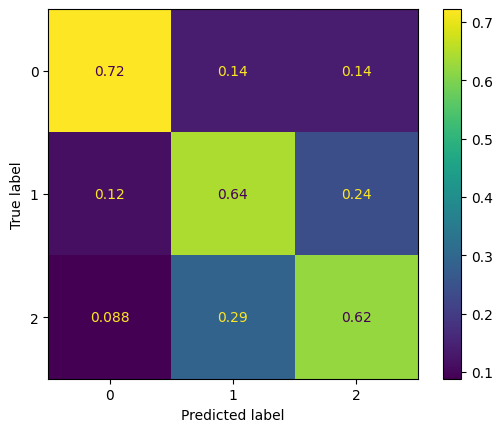

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.91600. Saving Model!
epoch 01, loss: 1.17230, acc: 0.37905, val_loss: 0.91600, val_accuracy: 0.53867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 02, loss: 0.88976, acc: 0.56353, val_loss: 0.98854, val_accuracy: 0.49548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 03, loss: 1.00016, acc: 0.47508, val_loss: 0.98207, val_accuracy: 0.49431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 04, loss: 0.99799, acc: 0.47091, val_loss: 0.95591, val_accuracy: 0.50059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 05, loss: 0.97346, acc: 0.47019, val_loss: 0.94483, val_accuracy: 0.51492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 06, loss: 0.95288, acc: 0.49098, val_loss: 0.93630, val_accuracy: 0.51943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 07, loss: 0.93825, acc: 0.49942, val_loss: 0.93243, val_accuracy: 0.53887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 08, loss: 0.93938, acc: 0.50418, val_loss: 0.93344, val_accuracy: 0.54849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 09, loss: 0.94672, acc: 0.49986, val_loss: 0.93222, val_accuracy: 0.54692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 10, loss: 0.94833, acc: 0.49899, val_loss: 0.92956, val_accuracy: 0.54338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 11, loss: 0.94398, acc: 0.49785, val_loss: 0.92753, val_accuracy: 0.54515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 12, loss: 0.93847, acc: 0.50389, val_loss: 0.92624, val_accuracy: 0.54927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 13, loss: 0.93619, acc: 0.50786, val_loss: 0.92563, val_accuracy: 0.55281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 14, loss: 0.93674, acc: 0.51072, val_loss: 0.92474, val_accuracy: 0.55418


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 15, loss: 0.93636, acc: 0.51135, val_loss: 0.92359, val_accuracy: 0.55359


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 16, loss: 0.93436, acc: 0.51391, val_loss: 0.92263, val_accuracy: 0.55261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 17, loss: 0.93218, acc: 0.51694, val_loss: 0.92183, val_accuracy: 0.55340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 18, loss: 0.93097, acc: 0.51770, val_loss: 0.92095, val_accuracy: 0.55477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 19, loss: 0.93026, acc: 0.51958, val_loss: 0.91987, val_accuracy: 0.55654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 20, loss: 0.92920, acc: 0.52095, val_loss: 0.91883, val_accuracy: 0.55752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 21, loss: 0.92773, acc: 0.52241, val_loss: 0.91794, val_accuracy: 0.55693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 22, loss: 0.92628, acc: 0.52573, val_loss: 0.91709, val_accuracy: 0.55889


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


epoch 23, loss: 0.92517, acc: 0.52689, val_loss: 0.91614, val_accuracy: 0.55987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


[INFO] val_acc has been improved from 0.91600 to 0.91499. Saving Model!
epoch 24, loss: 0.92426, acc: 0.52793, val_loss: 0.91499, val_accuracy: 0.56046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


[INFO] val_acc has been improved from 0.91499 to 0.91367. Saving Model!
epoch 25, loss: 0.92304, acc: 0.53000, val_loss: 0.91367, val_accuracy: 0.56184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


[INFO] val_acc has been improved from 0.91367 to 0.91251. Saving Model!
epoch 26, loss: 0.92179, acc: 0.53140, val_loss: 0.91251, val_accuracy: 0.56302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.91251 to 0.91166. Saving Model!
epoch 27, loss: 0.92068, acc: 0.53454, val_loss: 0.91166, val_accuracy: 0.56537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


[INFO] val_acc has been improved from 0.91166 to 0.91097. Saving Model!
epoch 28, loss: 0.91985, acc: 0.53496, val_loss: 0.91097, val_accuracy: 0.56517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


[INFO] val_acc has been improved from 0.91097 to 0.91028. Saving Model!
epoch 29, loss: 0.91906, acc: 0.53646, val_loss: 0.91028, val_accuracy: 0.56576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


[INFO] val_acc has been improved from 0.91028 to 0.90951. Saving Model!
epoch 30, loss: 0.91801, acc: 0.53779, val_loss: 0.90951, val_accuracy: 0.56694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


[INFO] val_acc has been improved from 0.90951 to 0.90867. Saving Model!
epoch 31, loss: 0.91703, acc: 0.53877, val_loss: 0.90867, val_accuracy: 0.56635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


[INFO] val_acc has been improved from 0.90867 to 0.90788. Saving Model!
epoch 32, loss: 0.91621, acc: 0.53958, val_loss: 0.90788, val_accuracy: 0.56655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 0.90788 to 0.90720. Saving Model!
epoch 33, loss: 0.91529, acc: 0.54072, val_loss: 0.90720, val_accuracy: 0.56714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.90720 to 0.90652. Saving Model!
epoch 34, loss: 0.91446, acc: 0.54109, val_loss: 0.90652, val_accuracy: 0.56851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


[INFO] val_acc has been improved from 0.90652 to 0.90581. Saving Model!
epoch 35, loss: 0.91363, acc: 0.54154, val_loss: 0.90581, val_accuracy: 0.56910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.90581 to 0.90511. Saving Model!
epoch 36, loss: 0.91273, acc: 0.54290, val_loss: 0.90511, val_accuracy: 0.57048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.90511 to 0.90442. Saving Model!
epoch 37, loss: 0.91188, acc: 0.54379, val_loss: 0.90442, val_accuracy: 0.57087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


[INFO] val_acc has been improved from 0.90442 to 0.90372. Saving Model!
epoch 38, loss: 0.91101, acc: 0.54534, val_loss: 0.90372, val_accuracy: 0.57087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


[INFO] val_acc has been improved from 0.90372 to 0.90308. Saving Model!
epoch 39, loss: 0.91018, acc: 0.54641, val_loss: 0.90308, val_accuracy: 0.57087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


[INFO] val_acc has been improved from 0.90308 to 0.90241. Saving Model!
epoch 40, loss: 0.90943, acc: 0.54665, val_loss: 0.90241, val_accuracy: 0.57067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 0.90241 to 0.90177. Saving Model!
epoch 41, loss: 0.90851, acc: 0.54732, val_loss: 0.90177, val_accuracy: 0.57165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.90177 to 0.90113. Saving Model!
epoch 42, loss: 0.90764, acc: 0.54787, val_loss: 0.90113, val_accuracy: 0.57205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


[INFO] val_acc has been improved from 0.90113 to 0.90045. Saving Model!
epoch 43, loss: 0.90685, acc: 0.54824, val_loss: 0.90045, val_accuracy: 0.57224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


[INFO] val_acc has been improved from 0.90045 to 0.89988. Saving Model!
epoch 44, loss: 0.90604, acc: 0.54911, val_loss: 0.89988, val_accuracy: 0.57185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.89988 to 0.89934. Saving Model!
epoch 45, loss: 0.90515, acc: 0.55005, val_loss: 0.89934, val_accuracy: 0.57087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


[INFO] val_acc has been improved from 0.89934 to 0.89869. Saving Model!
epoch 46, loss: 0.90448, acc: 0.55057, val_loss: 0.89869, val_accuracy: 0.57205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.89869 to 0.89811. Saving Model!
epoch 47, loss: 0.90358, acc: 0.55280, val_loss: 0.89811, val_accuracy: 0.57303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


[INFO] val_acc has been improved from 0.89811 to 0.89753. Saving Model!
epoch 48, loss: 0.90279, acc: 0.55350, val_loss: 0.89753, val_accuracy: 0.57420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


[INFO] val_acc has been improved from 0.89753 to 0.89685. Saving Model!
epoch 49, loss: 0.90202, acc: 0.55400, val_loss: 0.89685, val_accuracy: 0.57460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


[INFO] val_acc has been improved from 0.89685 to 0.89622. Saving Model!
epoch 50, loss: 0.90125, acc: 0.55420, val_loss: 0.89622, val_accuracy: 0.57499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


[INFO] val_acc has been improved from 0.89622 to 0.89566. Saving Model!
epoch 51, loss: 0.90048, acc: 0.55603, val_loss: 0.89566, val_accuracy: 0.57499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


[INFO] val_acc has been improved from 0.89566 to 0.89506. Saving Model!
epoch 52, loss: 0.89966, acc: 0.55640, val_loss: 0.89506, val_accuracy: 0.57636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


[INFO] val_acc has been improved from 0.89506 to 0.89444. Saving Model!
epoch 53, loss: 0.89892, acc: 0.55758, val_loss: 0.89444, val_accuracy: 0.57695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


[INFO] val_acc has been improved from 0.89444 to 0.89399. Saving Model!
epoch 54, loss: 0.89812, acc: 0.55827, val_loss: 0.89399, val_accuracy: 0.57754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


[INFO] val_acc has been improved from 0.89399 to 0.89349. Saving Model!
epoch 55, loss: 0.89727, acc: 0.55891, val_loss: 0.89349, val_accuracy: 0.57676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


[INFO] val_acc has been improved from 0.89349 to 0.89291. Saving Model!
epoch 56, loss: 0.89665, acc: 0.55937, val_loss: 0.89291, val_accuracy: 0.57636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


[INFO] val_acc has been improved from 0.89291 to 0.89230. Saving Model!
epoch 57, loss: 0.89589, acc: 0.55971, val_loss: 0.89230, val_accuracy: 0.57636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 0.89230 to 0.89185. Saving Model!
epoch 58, loss: 0.89504, acc: 0.56013, val_loss: 0.89185, val_accuracy: 0.57636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


[INFO] val_acc has been improved from 0.89185 to 0.89140. Saving Model!
epoch 59, loss: 0.89427, acc: 0.56153, val_loss: 0.89140, val_accuracy: 0.57617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


[INFO] val_acc has been improved from 0.89140 to 0.89090. Saving Model!
epoch 60, loss: 0.89360, acc: 0.56201, val_loss: 0.89090, val_accuracy: 0.57617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.89090 to 0.89047. Saving Model!
epoch 61, loss: 0.89278, acc: 0.56222, val_loss: 0.89047, val_accuracy: 0.57636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


[INFO] val_acc has been improved from 0.89047 to 0.88983. Saving Model!
epoch 62, loss: 0.89211, acc: 0.56246, val_loss: 0.88983, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


[INFO] val_acc has been improved from 0.88983 to 0.88918. Saving Model!
epoch 63, loss: 0.89139, acc: 0.56301, val_loss: 0.88918, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.88918 to 0.88863. Saving Model!
epoch 64, loss: 0.89057, acc: 0.56355, val_loss: 0.88863, val_accuracy: 0.57715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


[INFO] val_acc has been improved from 0.88863 to 0.88805. Saving Model!
epoch 65, loss: 0.88982, acc: 0.56388, val_loss: 0.88805, val_accuracy: 0.57636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


[INFO] val_acc has been improved from 0.88805 to 0.88750. Saving Model!
epoch 66, loss: 0.88905, acc: 0.56416, val_loss: 0.88750, val_accuracy: 0.57656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


[INFO] val_acc has been improved from 0.88750 to 0.88685. Saving Model!
epoch 67, loss: 0.88842, acc: 0.56539, val_loss: 0.88685, val_accuracy: 0.57695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


[INFO] val_acc has been improved from 0.88685 to 0.88615. Saving Model!
epoch 68, loss: 0.88765, acc: 0.56560, val_loss: 0.88615, val_accuracy: 0.57695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


[INFO] val_acc has been improved from 0.88615 to 0.88567. Saving Model!
epoch 69, loss: 0.88673, acc: 0.56587, val_loss: 0.88567, val_accuracy: 0.57793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


[INFO] val_acc has been improved from 0.88567 to 0.88516. Saving Model!
epoch 70, loss: 0.88603, acc: 0.56584, val_loss: 0.88516, val_accuracy: 0.57852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


[INFO] val_acc has been improved from 0.88516 to 0.88446. Saving Model!
epoch 71, loss: 0.88545, acc: 0.56626, val_loss: 0.88446, val_accuracy: 0.57951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


[INFO] val_acc has been improved from 0.88446 to 0.88384. Saving Model!
epoch 72, loss: 0.88459, acc: 0.56691, val_loss: 0.88384, val_accuracy: 0.58029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


[INFO] val_acc has been improved from 0.88384 to 0.88332. Saving Model!
epoch 73, loss: 0.88394, acc: 0.56776, val_loss: 0.88332, val_accuracy: 0.58088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


[INFO] val_acc has been improved from 0.88332 to 0.88279. Saving Model!
epoch 74, loss: 0.88311, acc: 0.56840, val_loss: 0.88279, val_accuracy: 0.58088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


[INFO] val_acc has been improved from 0.88279 to 0.88213. Saving Model!
epoch 75, loss: 0.88252, acc: 0.56807, val_loss: 0.88213, val_accuracy: 0.58166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.88213 to 0.88144. Saving Model!
epoch 76, loss: 0.88181, acc: 0.56894, val_loss: 0.88144, val_accuracy: 0.58147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


[INFO] val_acc has been improved from 0.88144 to 0.88086. Saving Model!
epoch 77, loss: 0.88099, acc: 0.56955, val_loss: 0.88086, val_accuracy: 0.58873


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.88086 to 0.88028. Saving Model!
epoch 78, loss: 0.88041, acc: 0.56966, val_loss: 0.88028, val_accuracy: 0.58912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


[INFO] val_acc has been improved from 0.88028 to 0.87966. Saving Model!
epoch 79, loss: 0.87964, acc: 0.57053, val_loss: 0.87966, val_accuracy: 0.58873


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


[INFO] val_acc has been improved from 0.87966 to 0.87920. Saving Model!
epoch 80, loss: 0.87893, acc: 0.57136, val_loss: 0.87920, val_accuracy: 0.58893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


[INFO] val_acc has been improved from 0.87920 to 0.87865. Saving Model!
epoch 81, loss: 0.87827, acc: 0.57162, val_loss: 0.87865, val_accuracy: 0.58991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


[INFO] val_acc has been improved from 0.87865 to 0.87804. Saving Model!
epoch 82, loss: 0.87750, acc: 0.57258, val_loss: 0.87804, val_accuracy: 0.58991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


[INFO] val_acc has been improved from 0.87804 to 0.87755. Saving Model!
epoch 83, loss: 0.87688, acc: 0.57324, val_loss: 0.87755, val_accuracy: 0.58971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


[INFO] val_acc has been improved from 0.87755 to 0.87697. Saving Model!
epoch 84, loss: 0.87636, acc: 0.57381, val_loss: 0.87697, val_accuracy: 0.59069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


[INFO] val_acc has been improved from 0.87697 to 0.87636. Saving Model!
epoch 85, loss: 0.87531, acc: 0.57464, val_loss: 0.87636, val_accuracy: 0.59128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.87636 to 0.87578. Saving Model!
epoch 86, loss: 0.87493, acc: 0.57464, val_loss: 0.87578, val_accuracy: 0.58088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.87578 to 0.87528. Saving Model!
epoch 87, loss: 0.87423, acc: 0.57516, val_loss: 0.87528, val_accuracy: 0.58127


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.87528 to 0.87470. Saving Model!
epoch 88, loss: 0.87339, acc: 0.57618, val_loss: 0.87470, val_accuracy: 0.58186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.87470 to 0.87403. Saving Model!
epoch 89, loss: 0.87284, acc: 0.57625, val_loss: 0.87403, val_accuracy: 0.58245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


[INFO] val_acc has been improved from 0.87403 to 0.87352. Saving Model!
epoch 90, loss: 0.87206, acc: 0.57682, val_loss: 0.87352, val_accuracy: 0.58265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


[INFO] val_acc has been improved from 0.87352 to 0.87301. Saving Model!
epoch 91, loss: 0.87135, acc: 0.57730, val_loss: 0.87301, val_accuracy: 0.58225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


[INFO] val_acc has been improved from 0.87301 to 0.87243. Saving Model!
epoch 92, loss: 0.87085, acc: 0.57756, val_loss: 0.87243, val_accuracy: 0.58304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


[INFO] val_acc has been improved from 0.87243 to 0.87181. Saving Model!
epoch 93, loss: 0.86996, acc: 0.57839, val_loss: 0.87181, val_accuracy: 0.58363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


[INFO] val_acc has been improved from 0.87181 to 0.87122. Saving Model!
epoch 94, loss: 0.86938, acc: 0.57858, val_loss: 0.87122, val_accuracy: 0.58382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


[INFO] val_acc has been improved from 0.87122 to 0.87068. Saving Model!
epoch 95, loss: 0.86885, acc: 0.57915, val_loss: 0.87068, val_accuracy: 0.58382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


[INFO] val_acc has been improved from 0.87068 to 0.87018. Saving Model!
epoch 96, loss: 0.86802, acc: 0.57957, val_loss: 0.87018, val_accuracy: 0.58422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


[INFO] val_acc has been improved from 0.87018 to 0.86972. Saving Model!
epoch 97, loss: 0.86732, acc: 0.58018, val_loss: 0.86972, val_accuracy: 0.58481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


[INFO] val_acc has been improved from 0.86972 to 0.86909. Saving Model!
epoch 98, loss: 0.86686, acc: 0.58028, val_loss: 0.86909, val_accuracy: 0.58520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


[INFO] val_acc has been improved from 0.86909 to 0.86854. Saving Model!
epoch 99, loss: 0.86611, acc: 0.58085, val_loss: 0.86854, val_accuracy: 0.58598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


[INFO] val_acc has been improved from 0.86854 to 0.86806. Saving Model!
epoch 100, loss: 0.86540, acc: 0.58109, val_loss: 0.86806, val_accuracy: 0.58697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


[INFO] val_acc has been improved from 0.86806 to 0.86749. Saving Model!
epoch 101, loss: 0.86478, acc: 0.58159, val_loss: 0.86749, val_accuracy: 0.58795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


[INFO] val_acc has been improved from 0.86749 to 0.86696. Saving Model!
epoch 102, loss: 0.86398, acc: 0.58203, val_loss: 0.86696, val_accuracy: 0.58795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


[INFO] val_acc has been improved from 0.86696 to 0.86648. Saving Model!
epoch 103, loss: 0.86349, acc: 0.58255, val_loss: 0.86648, val_accuracy: 0.58893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


[INFO] val_acc has been improved from 0.86648 to 0.86596. Saving Model!
epoch 104, loss: 0.86281, acc: 0.58260, val_loss: 0.86596, val_accuracy: 0.58893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


[INFO] val_acc has been improved from 0.86596 to 0.86541. Saving Model!
epoch 105, loss: 0.86202, acc: 0.58308, val_loss: 0.86541, val_accuracy: 0.58952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


[INFO] val_acc has been improved from 0.86541 to 0.86480. Saving Model!
epoch 106, loss: 0.86163, acc: 0.58321, val_loss: 0.86480, val_accuracy: 0.58991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


[INFO] val_acc has been improved from 0.86480 to 0.86430. Saving Model!
epoch 107, loss: 0.86075, acc: 0.58393, val_loss: 0.86430, val_accuracy: 0.59011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.86430 to 0.86377. Saving Model!
epoch 108, loss: 0.86016, acc: 0.58408, val_loss: 0.86377, val_accuracy: 0.59011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 0.86377 to 0.86321. Saving Model!
epoch 109, loss: 0.85959, acc: 0.58434, val_loss: 0.86321, val_accuracy: 0.59089


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


[INFO] val_acc has been improved from 0.86321 to 0.86265. Saving Model!
epoch 110, loss: 0.85879, acc: 0.58482, val_loss: 0.86265, val_accuracy: 0.59089


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


[INFO] val_acc has been improved from 0.86265 to 0.86207. Saving Model!
epoch 111, loss: 0.85831, acc: 0.58513, val_loss: 0.86207, val_accuracy: 0.59109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


[INFO] val_acc has been improved from 0.86207 to 0.86137. Saving Model!
epoch 112, loss: 0.85770, acc: 0.58615, val_loss: 0.86137, val_accuracy: 0.59207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


[INFO] val_acc has been improved from 0.86137 to 0.86095. Saving Model!
epoch 113, loss: 0.85676, acc: 0.58633, val_loss: 0.86095, val_accuracy: 0.59266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


[INFO] val_acc has been improved from 0.86095 to 0.86050. Saving Model!
epoch 114, loss: 0.85625, acc: 0.58681, val_loss: 0.86050, val_accuracy: 0.59403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 0.86050 to 0.85994. Saving Model!
epoch 115, loss: 0.85584, acc: 0.58746, val_loss: 0.85994, val_accuracy: 0.59462


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


[INFO] val_acc has been improved from 0.85994 to 0.85954. Saving Model!
epoch 116, loss: 0.85485, acc: 0.58805, val_loss: 0.85954, val_accuracy: 0.59462


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 0.85954 to 0.85909. Saving Model!
epoch 117, loss: 0.85438, acc: 0.58838, val_loss: 0.85909, val_accuracy: 0.59482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 0.85909 to 0.85864. Saving Model!
epoch 118, loss: 0.85371, acc: 0.58857, val_loss: 0.85864, val_accuracy: 0.59560


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.85864 to 0.85825. Saving Model!
epoch 119, loss: 0.85299, acc: 0.58884, val_loss: 0.85825, val_accuracy: 0.59560


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.85825 to 0.85785. Saving Model!
epoch 120, loss: 0.85251, acc: 0.58908, val_loss: 0.85785, val_accuracy: 0.59600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


[INFO] val_acc has been improved from 0.85785 to 0.85735. Saving Model!
epoch 121, loss: 0.85182, acc: 0.59121, val_loss: 0.85735, val_accuracy: 0.59658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


[INFO] val_acc has been improved from 0.85735 to 0.85710. Saving Model!
epoch 122, loss: 0.85109, acc: 0.59180, val_loss: 0.85710, val_accuracy: 0.59678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


[INFO] val_acc has been improved from 0.85710 to 0.85665. Saving Model!
epoch 123, loss: 0.85048, acc: 0.59209, val_loss: 0.85665, val_accuracy: 0.59796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


[INFO] val_acc has been improved from 0.85665 to 0.85613. Saving Model!
epoch 124, loss: 0.84997, acc: 0.59198, val_loss: 0.85613, val_accuracy: 0.59835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


[INFO] val_acc has been improved from 0.85613 to 0.85583. Saving Model!
epoch 125, loss: 0.84928, acc: 0.59215, val_loss: 0.85583, val_accuracy: 0.59815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.85583 to 0.85541. Saving Model!
epoch 126, loss: 0.84860, acc: 0.59246, val_loss: 0.85541, val_accuracy: 0.59815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


[INFO] val_acc has been improved from 0.85541 to 0.85493. Saving Model!
epoch 127, loss: 0.84809, acc: 0.59274, val_loss: 0.85493, val_accuracy: 0.59815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


[INFO] val_acc has been improved from 0.85493 to 0.85450. Saving Model!
epoch 128, loss: 0.84740, acc: 0.59315, val_loss: 0.85450, val_accuracy: 0.59874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


[INFO] val_acc has been improved from 0.85450 to 0.85413. Saving Model!
epoch 129, loss: 0.84671, acc: 0.59379, val_loss: 0.85413, val_accuracy: 0.59953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


[INFO] val_acc has been improved from 0.85413 to 0.85360. Saving Model!
epoch 130, loss: 0.84613, acc: 0.59425, val_loss: 0.85360, val_accuracy: 0.59973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.85360 to 0.85317. Saving Model!
epoch 131, loss: 0.84568, acc: 0.59427, val_loss: 0.85317, val_accuracy: 0.60031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


[INFO] val_acc has been improved from 0.85317 to 0.85285. Saving Model!
epoch 132, loss: 0.84480, acc: 0.59464, val_loss: 0.85285, val_accuracy: 0.60071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.85285 to 0.85238. Saving Model!
epoch 133, loss: 0.84419, acc: 0.59507, val_loss: 0.85238, val_accuracy: 0.60071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


[INFO] val_acc has been improved from 0.85238 to 0.85198. Saving Model!
epoch 134, loss: 0.84365, acc: 0.59525, val_loss: 0.85198, val_accuracy: 0.60071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.85198 to 0.85148. Saving Model!
epoch 135, loss: 0.84295, acc: 0.59538, val_loss: 0.85148, val_accuracy: 0.60130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


[INFO] val_acc has been improved from 0.85148 to 0.85109. Saving Model!
epoch 136, loss: 0.84227, acc: 0.59584, val_loss: 0.85109, val_accuracy: 0.60110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


[INFO] val_acc has been improved from 0.85109 to 0.85057. Saving Model!
epoch 137, loss: 0.84169, acc: 0.59606, val_loss: 0.85057, val_accuracy: 0.60247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


[INFO] val_acc has been improved from 0.85057 to 0.84996. Saving Model!
epoch 138, loss: 0.84116, acc: 0.59608, val_loss: 0.84996, val_accuracy: 0.60267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


[INFO] val_acc has been improved from 0.84996 to 0.84961. Saving Model!
epoch 139, loss: 0.84023, acc: 0.59641, val_loss: 0.84961, val_accuracy: 0.60247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


[INFO] val_acc has been improved from 0.84961 to 0.84913. Saving Model!
epoch 140, loss: 0.83976, acc: 0.59641, val_loss: 0.84913, val_accuracy: 0.60208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


[INFO] val_acc has been improved from 0.84913 to 0.84864. Saving Model!
epoch 141, loss: 0.83933, acc: 0.59647, val_loss: 0.84864, val_accuracy: 0.60287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


[INFO] val_acc has been improved from 0.84864 to 0.84820. Saving Model!
epoch 142, loss: 0.83844, acc: 0.59686, val_loss: 0.84820, val_accuracy: 0.60365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


[INFO] val_acc has been improved from 0.84820 to 0.84761. Saving Model!
epoch 143, loss: 0.83796, acc: 0.59835, val_loss: 0.84761, val_accuracy: 0.60385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


[INFO] val_acc has been improved from 0.84761 to 0.84708. Saving Model!
epoch 144, loss: 0.83741, acc: 0.59835, val_loss: 0.84708, val_accuracy: 0.60365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


[INFO] val_acc has been improved from 0.84708 to 0.84663. Saving Model!
epoch 145, loss: 0.83661, acc: 0.59870, val_loss: 0.84663, val_accuracy: 0.60404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


[INFO] val_acc has been improved from 0.84663 to 0.84629. Saving Model!
epoch 146, loss: 0.83614, acc: 0.59924, val_loss: 0.84629, val_accuracy: 0.60404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


[INFO] val_acc has been improved from 0.84629 to 0.84583. Saving Model!
epoch 147, loss: 0.83553, acc: 0.59985, val_loss: 0.84583, val_accuracy: 0.60365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


[INFO] val_acc has been improved from 0.84583 to 0.84535. Saving Model!
epoch 148, loss: 0.83505, acc: 0.59981, val_loss: 0.84535, val_accuracy: 0.60346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


[INFO] val_acc has been improved from 0.84535 to 0.84497. Saving Model!
epoch 149, loss: 0.83424, acc: 0.60029, val_loss: 0.84497, val_accuracy: 0.60404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


[INFO] val_acc has been improved from 0.84497 to 0.84447. Saving Model!
epoch 150, loss: 0.83382, acc: 0.60055, val_loss: 0.84447, val_accuracy: 0.60463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


[INFO] val_acc has been improved from 0.84447 to 0.84405. Saving Model!
epoch 151, loss: 0.83315, acc: 0.60114, val_loss: 0.84405, val_accuracy: 0.60522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


[INFO] val_acc has been improved from 0.84405 to 0.84362. Saving Model!
epoch 152, loss: 0.83249, acc: 0.60280, val_loss: 0.84362, val_accuracy: 0.60620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


[INFO] val_acc has been improved from 0.84362 to 0.84319. Saving Model!
epoch 153, loss: 0.83190, acc: 0.60400, val_loss: 0.84319, val_accuracy: 0.60640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


[INFO] val_acc has been improved from 0.84319 to 0.84270. Saving Model!
epoch 154, loss: 0.83142, acc: 0.60428, val_loss: 0.84270, val_accuracy: 0.60718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


[INFO] val_acc has been improved from 0.84270 to 0.84222. Saving Model!
epoch 155, loss: 0.83070, acc: 0.60463, val_loss: 0.84222, val_accuracy: 0.60797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


[INFO] val_acc has been improved from 0.84222 to 0.84179. Saving Model!
epoch 156, loss: 0.83020, acc: 0.60489, val_loss: 0.84179, val_accuracy: 0.60758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


[INFO] val_acc has been improved from 0.84179 to 0.84136. Saving Model!
epoch 157, loss: 0.82959, acc: 0.60493, val_loss: 0.84136, val_accuracy: 0.60836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


[INFO] val_acc has been improved from 0.84136 to 0.84093. Saving Model!
epoch 158, loss: 0.82906, acc: 0.60537, val_loss: 0.84093, val_accuracy: 0.60876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


[INFO] val_acc has been improved from 0.84093 to 0.84049. Saving Model!
epoch 159, loss: 0.82836, acc: 0.60524, val_loss: 0.84049, val_accuracy: 0.60915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


[INFO] val_acc has been improved from 0.84049 to 0.83995. Saving Model!
epoch 160, loss: 0.82780, acc: 0.60635, val_loss: 0.83995, val_accuracy: 0.60954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


[INFO] val_acc has been improved from 0.83995 to 0.83952. Saving Model!
epoch 161, loss: 0.82736, acc: 0.60640, val_loss: 0.83952, val_accuracy: 0.60974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.83952 to 0.83913. Saving Model!
epoch 162, loss: 0.82660, acc: 0.60690, val_loss: 0.83913, val_accuracy: 0.61484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.83913 to 0.83854. Saving Model!
epoch 163, loss: 0.82616, acc: 0.60738, val_loss: 0.83854, val_accuracy: 0.61504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


[INFO] val_acc has been improved from 0.83854 to 0.83824. Saving Model!
epoch 164, loss: 0.82553, acc: 0.60755, val_loss: 0.83824, val_accuracy: 0.61523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


[INFO] val_acc has been improved from 0.83824 to 0.83768. Saving Model!
epoch 165, loss: 0.82489, acc: 0.60810, val_loss: 0.83768, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


[INFO] val_acc has been improved from 0.83768 to 0.83710. Saving Model!
epoch 166, loss: 0.82439, acc: 0.60788, val_loss: 0.83710, val_accuracy: 0.61700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


[INFO] val_acc has been improved from 0.83710 to 0.83684. Saving Model!
epoch 167, loss: 0.82385, acc: 0.60808, val_loss: 0.83684, val_accuracy: 0.61661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.83684 to 0.83637. Saving Model!
epoch 168, loss: 0.82323, acc: 0.60853, val_loss: 0.83637, val_accuracy: 0.61700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.83637 to 0.83590. Saving Model!
epoch 169, loss: 0.82270, acc: 0.60901, val_loss: 0.83590, val_accuracy: 0.61661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.83590 to 0.83570. Saving Model!
epoch 170, loss: 0.82200, acc: 0.60919, val_loss: 0.83570, val_accuracy: 0.61641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


[INFO] val_acc has been improved from 0.83570 to 0.83511. Saving Model!
epoch 171, loss: 0.82146, acc: 0.60954, val_loss: 0.83511, val_accuracy: 0.61661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


[INFO] val_acc has been improved from 0.83511 to 0.83459. Saving Model!
epoch 172, loss: 0.82107, acc: 0.60967, val_loss: 0.83459, val_accuracy: 0.61661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


[INFO] val_acc has been improved from 0.83459 to 0.83403. Saving Model!
epoch 173, loss: 0.82037, acc: 0.60984, val_loss: 0.83403, val_accuracy: 0.61680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


[INFO] val_acc has been improved from 0.83403 to 0.83393. Saving Model!
epoch 174, loss: 0.81983, acc: 0.61135, val_loss: 0.83393, val_accuracy: 0.61641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


[INFO] val_acc has been improved from 0.83393 to 0.83357. Saving Model!
epoch 175, loss: 0.81929, acc: 0.61159, val_loss: 0.83357, val_accuracy: 0.61661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


[INFO] val_acc has been improved from 0.83357 to 0.83302. Saving Model!
epoch 176, loss: 0.81871, acc: 0.61229, val_loss: 0.83302, val_accuracy: 0.61680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


[INFO] val_acc has been improved from 0.83302 to 0.83259. Saving Model!
epoch 177, loss: 0.81810, acc: 0.61268, val_loss: 0.83259, val_accuracy: 0.61700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


[INFO] val_acc has been improved from 0.83259 to 0.83221. Saving Model!
epoch 178, loss: 0.81768, acc: 0.61325, val_loss: 0.83221, val_accuracy: 0.61798


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


[INFO] val_acc has been improved from 0.83221 to 0.83185. Saving Model!
epoch 179, loss: 0.81699, acc: 0.61349, val_loss: 0.83185, val_accuracy: 0.61837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


[INFO] val_acc has been improved from 0.83185 to 0.83143. Saving Model!
epoch 180, loss: 0.81659, acc: 0.61381, val_loss: 0.83143, val_accuracy: 0.61857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


[INFO] val_acc has been improved from 0.83143 to 0.83105. Saving Model!
epoch 181, loss: 0.81593, acc: 0.61429, val_loss: 0.83105, val_accuracy: 0.61955


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


[INFO] val_acc has been improved from 0.83105 to 0.83061. Saving Model!
epoch 182, loss: 0.81521, acc: 0.61479, val_loss: 0.83061, val_accuracy: 0.62034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


[INFO] val_acc has been improved from 0.83061 to 0.83007. Saving Model!
epoch 183, loss: 0.81485, acc: 0.61488, val_loss: 0.83007, val_accuracy: 0.62053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


[INFO] val_acc has been improved from 0.83007 to 0.82975. Saving Model!
epoch 184, loss: 0.81423, acc: 0.61510, val_loss: 0.82975, val_accuracy: 0.62073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


[INFO] val_acc has been improved from 0.82975 to 0.82940. Saving Model!
epoch 185, loss: 0.81364, acc: 0.61545, val_loss: 0.82940, val_accuracy: 0.62093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


[INFO] val_acc has been improved from 0.82940 to 0.82898. Saving Model!
epoch 186, loss: 0.81309, acc: 0.61578, val_loss: 0.82898, val_accuracy: 0.62112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


[INFO] val_acc has been improved from 0.82898 to 0.82856. Saving Model!
epoch 187, loss: 0.81262, acc: 0.61606, val_loss: 0.82856, val_accuracy: 0.62171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


[INFO] val_acc has been improved from 0.82856 to 0.82811. Saving Model!
epoch 188, loss: 0.81198, acc: 0.61687, val_loss: 0.82811, val_accuracy: 0.62210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


[INFO] val_acc has been improved from 0.82811 to 0.82765. Saving Model!
epoch 189, loss: 0.81138, acc: 0.61802, val_loss: 0.82765, val_accuracy: 0.62309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


[INFO] val_acc has been improved from 0.82765 to 0.82722. Saving Model!
epoch 190, loss: 0.81096, acc: 0.61881, val_loss: 0.82722, val_accuracy: 0.62309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.82722 to 0.82691. Saving Model!
epoch 191, loss: 0.81030, acc: 0.61900, val_loss: 0.82691, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


[INFO] val_acc has been improved from 0.82691 to 0.82656. Saving Model!
epoch 192, loss: 0.80970, acc: 0.61922, val_loss: 0.82656, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


[INFO] val_acc has been improved from 0.82656 to 0.82629. Saving Model!
epoch 193, loss: 0.80924, acc: 0.61935, val_loss: 0.82629, val_accuracy: 0.62367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


[INFO] val_acc has been improved from 0.82629 to 0.82579. Saving Model!
epoch 194, loss: 0.80873, acc: 0.62047, val_loss: 0.82579, val_accuracy: 0.62387


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


[INFO] val_acc has been improved from 0.82579 to 0.82533. Saving Model!
epoch 195, loss: 0.80810, acc: 0.62055, val_loss: 0.82533, val_accuracy: 0.62367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.82533 to 0.82508. Saving Model!
epoch 196, loss: 0.80742, acc: 0.62095, val_loss: 0.82508, val_accuracy: 0.62407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


[INFO] val_acc has been improved from 0.82508 to 0.82458. Saving Model!
epoch 197, loss: 0.80712, acc: 0.62127, val_loss: 0.82458, val_accuracy: 0.62485


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


[INFO] val_acc has been improved from 0.82458 to 0.82410. Saving Model!
epoch 198, loss: 0.80638, acc: 0.62162, val_loss: 0.82410, val_accuracy: 0.62466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


[INFO] val_acc has been improved from 0.82410 to 0.82389. Saving Model!
epoch 199, loss: 0.80592, acc: 0.62175, val_loss: 0.82389, val_accuracy: 0.62525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


[INFO] val_acc has been improved from 0.82389 to 0.82342. Saving Model!
epoch 200, loss: 0.80538, acc: 0.62193, val_loss: 0.82342, val_accuracy: 0.62564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


[INFO] val_acc has been improved from 0.82342 to 0.82321. Saving Model!
epoch 201, loss: 0.80481, acc: 0.62199, val_loss: 0.82321, val_accuracy: 0.62505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


[INFO] val_acc has been improved from 0.82321 to 0.82288. Saving Model!
epoch 202, loss: 0.80427, acc: 0.62225, val_loss: 0.82288, val_accuracy: 0.62505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


[INFO] val_acc has been improved from 0.82288 to 0.82240. Saving Model!
epoch 203, loss: 0.80375, acc: 0.62269, val_loss: 0.82240, val_accuracy: 0.62505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.82240 to 0.82204. Saving Model!
epoch 204, loss: 0.80329, acc: 0.62269, val_loss: 0.82204, val_accuracy: 0.62603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.82204 to 0.82176. Saving Model!
epoch 205, loss: 0.80258, acc: 0.62315, val_loss: 0.82176, val_accuracy: 0.62564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


[INFO] val_acc has been improved from 0.82176 to 0.82130. Saving Model!
epoch 206, loss: 0.80221, acc: 0.62330, val_loss: 0.82130, val_accuracy: 0.62583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.82130 to 0.82089. Saving Model!
epoch 207, loss: 0.80146, acc: 0.62348, val_loss: 0.82089, val_accuracy: 0.62544


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


[INFO] val_acc has been improved from 0.82089 to 0.82050. Saving Model!
epoch 208, loss: 0.80114, acc: 0.62382, val_loss: 0.82050, val_accuracy: 0.62623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


[INFO] val_acc has been improved from 0.82050 to 0.82024. Saving Model!
epoch 209, loss: 0.80041, acc: 0.62413, val_loss: 0.82024, val_accuracy: 0.62662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


[INFO] val_acc has been improved from 0.82024 to 0.81989. Saving Model!
epoch 210, loss: 0.80010, acc: 0.62409, val_loss: 0.81989, val_accuracy: 0.62740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


[INFO] val_acc has been improved from 0.81989 to 0.81951. Saving Model!
epoch 211, loss: 0.79919, acc: 0.62439, val_loss: 0.81951, val_accuracy: 0.62780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.81951 to 0.81908. Saving Model!
epoch 212, loss: 0.79889, acc: 0.62492, val_loss: 0.81908, val_accuracy: 0.62839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


[INFO] val_acc has been improved from 0.81908 to 0.81885. Saving Model!
epoch 213, loss: 0.79827, acc: 0.62522, val_loss: 0.81885, val_accuracy: 0.62858


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


[INFO] val_acc has been improved from 0.81885 to 0.81849. Saving Model!
epoch 214, loss: 0.79763, acc: 0.62553, val_loss: 0.81849, val_accuracy: 0.62878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


[INFO] val_acc has been improved from 0.81849 to 0.81781. Saving Model!
epoch 215, loss: 0.79734, acc: 0.62583, val_loss: 0.81781, val_accuracy: 0.62937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


[INFO] val_acc has been improved from 0.81781 to 0.81767. Saving Model!
epoch 216, loss: 0.79647, acc: 0.62622, val_loss: 0.81767, val_accuracy: 0.62996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


[INFO] val_acc has been improved from 0.81767 to 0.81726. Saving Model!
epoch 217, loss: 0.79621, acc: 0.62721, val_loss: 0.81726, val_accuracy: 0.62976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


[INFO] val_acc has been improved from 0.81726 to 0.81702. Saving Model!
epoch 218, loss: 0.79545, acc: 0.62762, val_loss: 0.81702, val_accuracy: 0.63015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.81702 to 0.81662. Saving Model!
epoch 219, loss: 0.79506, acc: 0.62819, val_loss: 0.81662, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


[INFO] val_acc has been improved from 0.81662 to 0.81610. Saving Model!
epoch 220, loss: 0.79441, acc: 0.62854, val_loss: 0.81610, val_accuracy: 0.63094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


[INFO] val_acc has been improved from 0.81610 to 0.81584. Saving Model!
epoch 221, loss: 0.79392, acc: 0.62841, val_loss: 0.81584, val_accuracy: 0.63113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


[INFO] val_acc has been improved from 0.81584 to 0.81552. Saving Model!
epoch 222, loss: 0.79348, acc: 0.62858, val_loss: 0.81552, val_accuracy: 0.63113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


[INFO] val_acc has been improved from 0.81552 to 0.81530. Saving Model!
epoch 223, loss: 0.79266, acc: 0.62923, val_loss: 0.81530, val_accuracy: 0.63153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


[INFO] val_acc has been improved from 0.81530 to 0.81478. Saving Model!
epoch 224, loss: 0.79258, acc: 0.62934, val_loss: 0.81478, val_accuracy: 0.63231


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


[INFO] val_acc has been improved from 0.81478 to 0.81456. Saving Model!
epoch 225, loss: 0.79169, acc: 0.62971, val_loss: 0.81456, val_accuracy: 0.63271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


[INFO] val_acc has been improved from 0.81456 to 0.81417. Saving Model!
epoch 226, loss: 0.79134, acc: 0.62989, val_loss: 0.81417, val_accuracy: 0.63251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


[INFO] val_acc has been improved from 0.81417 to 0.81383. Saving Model!
epoch 227, loss: 0.79072, acc: 0.63019, val_loss: 0.81383, val_accuracy: 0.63290


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


[INFO] val_acc has been improved from 0.81383 to 0.81343. Saving Model!
epoch 228, loss: 0.79028, acc: 0.63015, val_loss: 0.81343, val_accuracy: 0.63310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


[INFO] val_acc has been improved from 0.81343 to 0.81323. Saving Model!
epoch 229, loss: 0.78971, acc: 0.63105, val_loss: 0.81323, val_accuracy: 0.63329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.81323 to 0.81308. Saving Model!
epoch 230, loss: 0.78915, acc: 0.63124, val_loss: 0.81308, val_accuracy: 0.63369


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


[INFO] val_acc has been improved from 0.81308 to 0.81256. Saving Model!
epoch 231, loss: 0.78876, acc: 0.63194, val_loss: 0.81256, val_accuracy: 0.63388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


[INFO] val_acc has been improved from 0.81256 to 0.81223. Saving Model!
epoch 232, loss: 0.78806, acc: 0.63218, val_loss: 0.81223, val_accuracy: 0.63506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.81223 to 0.81190. Saving Model!
epoch 233, loss: 0.78773, acc: 0.63220, val_loss: 0.81190, val_accuracy: 0.63565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


[INFO] val_acc has been improved from 0.81190 to 0.81152. Saving Model!
epoch 234, loss: 0.78724, acc: 0.63238, val_loss: 0.81152, val_accuracy: 0.63585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


[INFO] val_acc has been improved from 0.81152 to 0.81139. Saving Model!
epoch 235, loss: 0.78660, acc: 0.63255, val_loss: 0.81139, val_accuracy: 0.63683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


[INFO] val_acc has been improved from 0.81139 to 0.81094. Saving Model!
epoch 236, loss: 0.78611, acc: 0.63266, val_loss: 0.81094, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


[INFO] val_acc has been improved from 0.81094 to 0.81063. Saving Model!
epoch 237, loss: 0.78572, acc: 0.63299, val_loss: 0.81063, val_accuracy: 0.63722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.81063 to 0.81034. Saving Model!
epoch 238, loss: 0.78526, acc: 0.63316, val_loss: 0.81034, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.81034 to 0.81009. Saving Model!
epoch 239, loss: 0.78451, acc: 0.63362, val_loss: 0.81009, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


[INFO] val_acc has been improved from 0.81009 to 0.80962. Saving Model!
epoch 240, loss: 0.78439, acc: 0.63373, val_loss: 0.80962, val_accuracy: 0.63781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


[INFO] val_acc has been improved from 0.80962 to 0.80943. Saving Model!
epoch 241, loss: 0.78351, acc: 0.63414, val_loss: 0.80943, val_accuracy: 0.63781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


[INFO] val_acc has been improved from 0.80943 to 0.80918. Saving Model!
epoch 242, loss: 0.78332, acc: 0.63432, val_loss: 0.80918, val_accuracy: 0.63781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


[INFO] val_acc has been improved from 0.80918 to 0.80892. Saving Model!
epoch 243, loss: 0.78269, acc: 0.63478, val_loss: 0.80892, val_accuracy: 0.63781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


[INFO] val_acc has been improved from 0.80892 to 0.80851. Saving Model!
epoch 244, loss: 0.78216, acc: 0.63536, val_loss: 0.80851, val_accuracy: 0.63801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


[INFO] val_acc has been improved from 0.80851 to 0.80810. Saving Model!
epoch 245, loss: 0.78185, acc: 0.63554, val_loss: 0.80810, val_accuracy: 0.63820


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


[INFO] val_acc has been improved from 0.80810 to 0.80785. Saving Model!
epoch 246, loss: 0.78117, acc: 0.63593, val_loss: 0.80785, val_accuracy: 0.63899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


[INFO] val_acc has been improved from 0.80785 to 0.80757. Saving Model!
epoch 247, loss: 0.78093, acc: 0.63611, val_loss: 0.80757, val_accuracy: 0.63879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


[INFO] val_acc has been improved from 0.80757 to 0.80742. Saving Model!
epoch 248, loss: 0.78009, acc: 0.63755, val_loss: 0.80742, val_accuracy: 0.63879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


[INFO] val_acc has been improved from 0.80742 to 0.80684. Saving Model!
epoch 249, loss: 0.77999, acc: 0.63648, val_loss: 0.80684, val_accuracy: 0.63899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.80684 to 0.80659. Saving Model!
epoch 250, loss: 0.77917, acc: 0.63672, val_loss: 0.80659, val_accuracy: 0.63938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.80659 to 0.80638. Saving Model!
epoch 251, loss: 0.77888, acc: 0.63674, val_loss: 0.80638, val_accuracy: 0.64075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


[INFO] val_acc has been improved from 0.80638 to 0.80617. Saving Model!
epoch 252, loss: 0.77828, acc: 0.63635, val_loss: 0.80617, val_accuracy: 0.64075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


[INFO] val_acc has been improved from 0.80617 to 0.80585. Saving Model!
epoch 253, loss: 0.77787, acc: 0.63746, val_loss: 0.80585, val_accuracy: 0.64095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


[INFO] val_acc has been improved from 0.80585 to 0.80548. Saving Model!
epoch 254, loss: 0.77740, acc: 0.63639, val_loss: 0.80548, val_accuracy: 0.64154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


[INFO] val_acc has been improved from 0.80548 to 0.80522. Saving Model!
epoch 255, loss: 0.77682, acc: 0.63717, val_loss: 0.80522, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


[INFO] val_acc has been improved from 0.80522 to 0.80508. Saving Model!
epoch 256, loss: 0.77627, acc: 0.63665, val_loss: 0.80508, val_accuracy: 0.64232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


[INFO] val_acc has been improved from 0.80508 to 0.80460. Saving Model!
epoch 257, loss: 0.77610, acc: 0.63678, val_loss: 0.80460, val_accuracy: 0.64291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


[INFO] val_acc has been improved from 0.80460 to 0.80430. Saving Model!
epoch 258, loss: 0.77506, acc: 0.63816, val_loss: 0.80430, val_accuracy: 0.64272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


[INFO] val_acc has been improved from 0.80430 to 0.80396. Saving Model!
epoch 259, loss: 0.77506, acc: 0.63707, val_loss: 0.80396, val_accuracy: 0.64291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


[INFO] val_acc has been improved from 0.80396 to 0.80351. Saving Model!
epoch 260, loss: 0.77433, acc: 0.63737, val_loss: 0.80351, val_accuracy: 0.64232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


[INFO] val_acc has been improved from 0.80351 to 0.80319. Saving Model!
epoch 261, loss: 0.77378, acc: 0.63870, val_loss: 0.80319, val_accuracy: 0.64232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.80319 to 0.80289. Saving Model!
epoch 262, loss: 0.77349, acc: 0.63748, val_loss: 0.80289, val_accuracy: 0.64272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


[INFO] val_acc has been improved from 0.80289 to 0.80257. Saving Model!
epoch 263, loss: 0.77296, acc: 0.63761, val_loss: 0.80257, val_accuracy: 0.64291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


[INFO] val_acc has been improved from 0.80257 to 0.80226. Saving Model!
epoch 264, loss: 0.77239, acc: 0.63890, val_loss: 0.80226, val_accuracy: 0.64311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


[INFO] val_acc has been improved from 0.80226 to 0.80198. Saving Model!
epoch 265, loss: 0.77190, acc: 0.63949, val_loss: 0.80198, val_accuracy: 0.64370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


[INFO] val_acc has been improved from 0.80198 to 0.80173. Saving Model!
epoch 266, loss: 0.77139, acc: 0.63868, val_loss: 0.80173, val_accuracy: 0.64370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.80173 to 0.80126. Saving Model!
epoch 267, loss: 0.77128, acc: 0.63881, val_loss: 0.80126, val_accuracy: 0.64370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


[INFO] val_acc has been improved from 0.80126 to 0.80110. Saving Model!
epoch 268, loss: 0.77019, acc: 0.63912, val_loss: 0.80110, val_accuracy: 0.64409


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


[INFO] val_acc has been improved from 0.80110 to 0.80072. Saving Model!
epoch 269, loss: 0.77020, acc: 0.64018, val_loss: 0.80072, val_accuracy: 0.64429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


[INFO] val_acc has been improved from 0.80072 to 0.80057. Saving Model!
epoch 270, loss: 0.76953, acc: 0.63964, val_loss: 0.80057, val_accuracy: 0.64429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


[INFO] val_acc has been improved from 0.80057 to 0.80018. Saving Model!
epoch 271, loss: 0.76889, acc: 0.63988, val_loss: 0.80018, val_accuracy: 0.64429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.80018 to 0.79978. Saving Model!
epoch 272, loss: 0.76877, acc: 0.64014, val_loss: 0.79978, val_accuracy: 0.64448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


[INFO] val_acc has been improved from 0.79978 to 0.79960. Saving Model!
epoch 273, loss: 0.76790, acc: 0.64167, val_loss: 0.79960, val_accuracy: 0.64527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


[INFO] val_acc has been improved from 0.79960 to 0.79934. Saving Model!
epoch 274, loss: 0.76780, acc: 0.64080, val_loss: 0.79934, val_accuracy: 0.64507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


[INFO] val_acc has been improved from 0.79934 to 0.79904. Saving Model!
epoch 275, loss: 0.76721, acc: 0.64086, val_loss: 0.79904, val_accuracy: 0.64507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


[INFO] val_acc has been improved from 0.79904 to 0.79883. Saving Model!
epoch 276, loss: 0.76663, acc: 0.64239, val_loss: 0.79883, val_accuracy: 0.64527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


[INFO] val_acc has been improved from 0.79883 to 0.79848. Saving Model!
epoch 277, loss: 0.76616, acc: 0.64269, val_loss: 0.79848, val_accuracy: 0.64527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.79848 to 0.79802. Saving Model!
epoch 278, loss: 0.76612, acc: 0.64156, val_loss: 0.79802, val_accuracy: 0.64488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


[INFO] val_acc has been improved from 0.79802 to 0.79794. Saving Model!
epoch 279, loss: 0.76489, acc: 0.64328, val_loss: 0.79794, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.79794 to 0.79753. Saving Model!
epoch 280, loss: 0.76496, acc: 0.64219, val_loss: 0.79753, val_accuracy: 0.64625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


[INFO] val_acc has been improved from 0.79753 to 0.79730. Saving Model!
epoch 281, loss: 0.76449, acc: 0.64352, val_loss: 0.79730, val_accuracy: 0.64684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.79730 to 0.79730. Saving Model!
epoch 282, loss: 0.76367, acc: 0.64368, val_loss: 0.79730, val_accuracy: 0.64723


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


[INFO] val_acc has been improved from 0.79730 to 0.79663. Saving Model!
epoch 283, loss: 0.76371, acc: 0.64263, val_loss: 0.79663, val_accuracy: 0.64723


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 284, loss: 0.76257, acc: 0.64416, val_loss: 0.79667, val_accuracy: 0.64762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


[INFO] val_acc has been improved from 0.79663 to 0.79627. Saving Model!
epoch 285, loss: 0.76260, acc: 0.64302, val_loss: 0.79627, val_accuracy: 0.64821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.79627 to 0.79601. Saving Model!
epoch 286, loss: 0.76217, acc: 0.64289, val_loss: 0.79601, val_accuracy: 0.64821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


[INFO] val_acc has been improved from 0.79601 to 0.79574. Saving Model!
epoch 287, loss: 0.76118, acc: 0.64418, val_loss: 0.79574, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


[INFO] val_acc has been improved from 0.79574 to 0.79519. Saving Model!
epoch 288, loss: 0.76147, acc: 0.64282, val_loss: 0.79519, val_accuracy: 0.64880


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 289, loss: 0.76028, acc: 0.64457, val_loss: 0.79522, val_accuracy: 0.64664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


[INFO] val_acc has been improved from 0.79519 to 0.79490. Saving Model!
epoch 290, loss: 0.76022, acc: 0.64400, val_loss: 0.79490, val_accuracy: 0.64959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


[INFO] val_acc has been improved from 0.79490 to 0.79462. Saving Model!
epoch 291, loss: 0.75971, acc: 0.64501, val_loss: 0.79462, val_accuracy: 0.65018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.79462 to 0.79416. Saving Model!
epoch 292, loss: 0.75923, acc: 0.64540, val_loss: 0.79416, val_accuracy: 0.64723


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


[INFO] val_acc has been improved from 0.79416 to 0.79415. Saving Model!
epoch 293, loss: 0.75879, acc: 0.64538, val_loss: 0.79415, val_accuracy: 0.64723


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


[INFO] val_acc has been improved from 0.79415 to 0.79400. Saving Model!
epoch 294, loss: 0.75810, acc: 0.64603, val_loss: 0.79400, val_accuracy: 0.64802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


[INFO] val_acc has been improved from 0.79400 to 0.79350. Saving Model!
epoch 295, loss: 0.75810, acc: 0.64612, val_loss: 0.79350, val_accuracy: 0.64821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


[INFO] val_acc has been improved from 0.79350 to 0.79348. Saving Model!
epoch 296, loss: 0.75706, acc: 0.64664, val_loss: 0.79348, val_accuracy: 0.64880


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


[INFO] val_acc has been improved from 0.79348 to 0.79289. Saving Model!
epoch 297, loss: 0.75725, acc: 0.64546, val_loss: 0.79289, val_accuracy: 0.64841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 298, loss: 0.75636, acc: 0.64677, val_loss: 0.79290, val_accuracy: 0.64861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


[INFO] val_acc has been improved from 0.79289 to 0.79270. Saving Model!
epoch 299, loss: 0.75597, acc: 0.64708, val_loss: 0.79270, val_accuracy: 0.64920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


[INFO] val_acc has been improved from 0.79270 to 0.79219. Saving Model!
epoch 300, loss: 0.75578, acc: 0.64605, val_loss: 0.79219, val_accuracy: 0.65037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


[INFO] val_acc has been improved from 0.79219 to 0.79203. Saving Model!
epoch 301, loss: 0.75498, acc: 0.64638, val_loss: 0.79203, val_accuracy: 0.64978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


[INFO] val_acc has been improved from 0.79203 to 0.79177. Saving Model!
epoch 302, loss: 0.75472, acc: 0.64745, val_loss: 0.79177, val_accuracy: 0.65018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


[INFO] val_acc has been improved from 0.79177 to 0.79171. Saving Model!
epoch 303, loss: 0.75414, acc: 0.64754, val_loss: 0.79171, val_accuracy: 0.64978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


[INFO] val_acc has been improved from 0.79171 to 0.79149. Saving Model!
epoch 304, loss: 0.75375, acc: 0.64810, val_loss: 0.79149, val_accuracy: 0.65057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


[INFO] val_acc has been improved from 0.79149 to 0.79104. Saving Model!
epoch 305, loss: 0.75358, acc: 0.64717, val_loss: 0.79104, val_accuracy: 0.64998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


[INFO] val_acc has been improved from 0.79104 to 0.79069. Saving Model!
epoch 306, loss: 0.75287, acc: 0.64819, val_loss: 0.79069, val_accuracy: 0.65077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


[INFO] val_acc has been improved from 0.79069 to 0.79061. Saving Model!
epoch 307, loss: 0.75228, acc: 0.64834, val_loss: 0.79061, val_accuracy: 0.65057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


[INFO] val_acc has been improved from 0.79061 to 0.79013. Saving Model!
epoch 308, loss: 0.75208, acc: 0.64884, val_loss: 0.79013, val_accuracy: 0.65116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


[INFO] val_acc has been improved from 0.79013 to 0.78986. Saving Model!
epoch 309, loss: 0.75164, acc: 0.64793, val_loss: 0.78986, val_accuracy: 0.65175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


[INFO] val_acc has been improved from 0.78986 to 0.78963. Saving Model!
epoch 310, loss: 0.75114, acc: 0.64935, val_loss: 0.78963, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.78963 to 0.78935. Saving Model!
epoch 311, loss: 0.75067, acc: 0.64926, val_loss: 0.78935, val_accuracy: 0.65214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.78935 to 0.78921. Saving Model!
epoch 312, loss: 0.75024, acc: 0.64930, val_loss: 0.78921, val_accuracy: 0.65332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


[INFO] val_acc has been improved from 0.78921 to 0.78884. Saving Model!
epoch 313, loss: 0.74980, acc: 0.64974, val_loss: 0.78884, val_accuracy: 0.65391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


[INFO] val_acc has been improved from 0.78884 to 0.78858. Saving Model!
epoch 314, loss: 0.74950, acc: 0.64967, val_loss: 0.78858, val_accuracy: 0.65351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


[INFO] val_acc has been improved from 0.78858 to 0.78827. Saving Model!
epoch 315, loss: 0.74896, acc: 0.64998, val_loss: 0.78827, val_accuracy: 0.65293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.78827 to 0.78815. Saving Model!
epoch 316, loss: 0.74842, acc: 0.65013, val_loss: 0.78815, val_accuracy: 0.65332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


[INFO] val_acc has been improved from 0.78815 to 0.78785. Saving Model!
epoch 317, loss: 0.74830, acc: 0.65024, val_loss: 0.78785, val_accuracy: 0.65391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


[INFO] val_acc has been improved from 0.78785 to 0.78759. Saving Model!
epoch 318, loss: 0.74739, acc: 0.65059, val_loss: 0.78759, val_accuracy: 0.65371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


[INFO] val_acc has been improved from 0.78759 to 0.78731. Saving Model!
epoch 319, loss: 0.74731, acc: 0.65083, val_loss: 0.78731, val_accuracy: 0.65371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


[INFO] val_acc has been improved from 0.78731 to 0.78691. Saving Model!
epoch 320, loss: 0.74699, acc: 0.65092, val_loss: 0.78691, val_accuracy: 0.65430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


[INFO] val_acc has been improved from 0.78691 to 0.78673. Saving Model!
epoch 321, loss: 0.74608, acc: 0.65116, val_loss: 0.78673, val_accuracy: 0.65430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.78673 to 0.78656. Saving Model!
epoch 322, loss: 0.74589, acc: 0.65118, val_loss: 0.78656, val_accuracy: 0.65410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


[INFO] val_acc has been improved from 0.78656 to 0.78611. Saving Model!
epoch 323, loss: 0.74566, acc: 0.65111, val_loss: 0.78611, val_accuracy: 0.65450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


[INFO] val_acc has been improved from 0.78611 to 0.78604. Saving Model!
epoch 324, loss: 0.74482, acc: 0.65138, val_loss: 0.78604, val_accuracy: 0.65489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


[INFO] val_acc has been improved from 0.78604 to 0.78571. Saving Model!
epoch 325, loss: 0.74475, acc: 0.65155, val_loss: 0.78571, val_accuracy: 0.65607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


[INFO] val_acc has been improved from 0.78571 to 0.78554. Saving Model!
epoch 326, loss: 0.74400, acc: 0.65190, val_loss: 0.78554, val_accuracy: 0.65508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


[INFO] val_acc has been improved from 0.78554 to 0.78516. Saving Model!
epoch 327, loss: 0.74375, acc: 0.65199, val_loss: 0.78516, val_accuracy: 0.65626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


[INFO] val_acc has been improved from 0.78516 to 0.78495. Saving Model!
epoch 328, loss: 0.74360, acc: 0.65199, val_loss: 0.78495, val_accuracy: 0.65744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 329, loss: 0.74237, acc: 0.65264, val_loss: 0.78496, val_accuracy: 0.65724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


[INFO] val_acc has been improved from 0.78495 to 0.78440. Saving Model!
epoch 330, loss: 0.74265, acc: 0.65249, val_loss: 0.78440, val_accuracy: 0.65724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.78440 to 0.78411. Saving Model!
epoch 331, loss: 0.74206, acc: 0.65264, val_loss: 0.78411, val_accuracy: 0.65744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


[INFO] val_acc has been improved from 0.78411 to 0.78406. Saving Model!
epoch 332, loss: 0.74137, acc: 0.65305, val_loss: 0.78406, val_accuracy: 0.65764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


[INFO] val_acc has been improved from 0.78406 to 0.78367. Saving Model!
epoch 333, loss: 0.74134, acc: 0.65314, val_loss: 0.78367, val_accuracy: 0.65842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


[INFO] val_acc has been improved from 0.78367 to 0.78353. Saving Model!
epoch 334, loss: 0.74047, acc: 0.65391, val_loss: 0.78353, val_accuracy: 0.65862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


[INFO] val_acc has been improved from 0.78353 to 0.78318. Saving Model!
epoch 335, loss: 0.74046, acc: 0.65386, val_loss: 0.78318, val_accuracy: 0.65921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 0.78318 to 0.78299. Saving Model!
epoch 336, loss: 0.73954, acc: 0.65432, val_loss: 0.78299, val_accuracy: 0.65999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


[INFO] val_acc has been improved from 0.78299 to 0.78279. Saving Model!
epoch 337, loss: 0.73953, acc: 0.65423, val_loss: 0.78279, val_accuracy: 0.65940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


[INFO] val_acc has been improved from 0.78279 to 0.78248. Saving Model!
epoch 338, loss: 0.73893, acc: 0.65574, val_loss: 0.78248, val_accuracy: 0.65999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


[INFO] val_acc has been improved from 0.78248 to 0.78211. Saving Model!
epoch 339, loss: 0.73836, acc: 0.65521, val_loss: 0.78211, val_accuracy: 0.66019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


[INFO] val_acc has been improved from 0.78211 to 0.78182. Saving Model!
epoch 340, loss: 0.73821, acc: 0.65493, val_loss: 0.78182, val_accuracy: 0.66058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


[INFO] val_acc has been improved from 0.78182 to 0.78154. Saving Model!
epoch 341, loss: 0.73755, acc: 0.65731, val_loss: 0.78154, val_accuracy: 0.66038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.78154 to 0.78110. Saving Model!
epoch 342, loss: 0.73736, acc: 0.65703, val_loss: 0.78110, val_accuracy: 0.66078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 343, loss: 0.73633, acc: 0.65812, val_loss: 0.78115, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.78110 to 0.78064. Saving Model!
epoch 344, loss: 0.73670, acc: 0.65766, val_loss: 0.78064, val_accuracy: 0.66117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


[INFO] val_acc has been improved from 0.78064 to 0.78037. Saving Model!
epoch 345, loss: 0.73569, acc: 0.65951, val_loss: 0.78037, val_accuracy: 0.66196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


[INFO] val_acc has been improved from 0.78037 to 0.78015. Saving Model!
epoch 346, loss: 0.73540, acc: 0.65890, val_loss: 0.78015, val_accuracy: 0.66196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


[INFO] val_acc has been improved from 0.78015 to 0.77988. Saving Model!
epoch 347, loss: 0.73513, acc: 0.65910, val_loss: 0.77988, val_accuracy: 0.66333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


[INFO] val_acc has been improved from 0.77988 to 0.77960. Saving Model!
epoch 348, loss: 0.73439, acc: 0.66019, val_loss: 0.77960, val_accuracy: 0.66313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


[INFO] val_acc has been improved from 0.77960 to 0.77921. Saving Model!
epoch 349, loss: 0.73437, acc: 0.66045, val_loss: 0.77921, val_accuracy: 0.66333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


[INFO] val_acc has been improved from 0.77921 to 0.77892. Saving Model!
epoch 350, loss: 0.73353, acc: 0.66062, val_loss: 0.77892, val_accuracy: 0.66313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


[INFO] val_acc has been improved from 0.77892 to 0.77880. Saving Model!
epoch 351, loss: 0.73347, acc: 0.66045, val_loss: 0.77880, val_accuracy: 0.66313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


[INFO] val_acc has been improved from 0.77880 to 0.77872. Saving Model!
epoch 352, loss: 0.73280, acc: 0.66062, val_loss: 0.77872, val_accuracy: 0.66313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.77872 to 0.77838. Saving Model!
epoch 353, loss: 0.73246, acc: 0.66110, val_loss: 0.77838, val_accuracy: 0.66353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


[INFO] val_acc has been improved from 0.77838 to 0.77805. Saving Model!
epoch 354, loss: 0.73205, acc: 0.66119, val_loss: 0.77805, val_accuracy: 0.66353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


[INFO] val_acc has been improved from 0.77805 to 0.77790. Saving Model!
epoch 355, loss: 0.73169, acc: 0.66128, val_loss: 0.77790, val_accuracy: 0.66372


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


[INFO] val_acc has been improved from 0.77790 to 0.77758. Saving Model!
epoch 356, loss: 0.73108, acc: 0.66171, val_loss: 0.77758, val_accuracy: 0.66451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


[INFO] val_acc has been improved from 0.77758 to 0.77727. Saving Model!
epoch 357, loss: 0.73094, acc: 0.66187, val_loss: 0.77727, val_accuracy: 0.66451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 358, loss: 0.73012, acc: 0.66202, val_loss: 0.77735, val_accuracy: 0.66490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


[INFO] val_acc has been improved from 0.77727 to 0.77672. Saving Model!
epoch 359, loss: 0.73025, acc: 0.66209, val_loss: 0.77672, val_accuracy: 0.66569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


[INFO] val_acc has been improved from 0.77672 to 0.77664. Saving Model!
epoch 360, loss: 0.72941, acc: 0.66267, val_loss: 0.77664, val_accuracy: 0.66569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


[INFO] val_acc has been improved from 0.77664 to 0.77633. Saving Model!
epoch 361, loss: 0.72922, acc: 0.66300, val_loss: 0.77633, val_accuracy: 0.66647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


[INFO] val_acc has been improved from 0.77633 to 0.77617. Saving Model!
epoch 362, loss: 0.72863, acc: 0.66307, val_loss: 0.77617, val_accuracy: 0.66647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


[INFO] val_acc has been improved from 0.77617 to 0.77572. Saving Model!
epoch 363, loss: 0.72849, acc: 0.66307, val_loss: 0.77572, val_accuracy: 0.66765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


[INFO] val_acc has been improved from 0.77572 to 0.77559. Saving Model!
epoch 364, loss: 0.72773, acc: 0.66337, val_loss: 0.77559, val_accuracy: 0.66686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


[INFO] val_acc has been improved from 0.77559 to 0.77532. Saving Model!
epoch 365, loss: 0.72753, acc: 0.66361, val_loss: 0.77532, val_accuracy: 0.66784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


[INFO] val_acc has been improved from 0.77532 to 0.77485. Saving Model!
epoch 366, loss: 0.72698, acc: 0.66394, val_loss: 0.77485, val_accuracy: 0.66804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


[INFO] val_acc has been improved from 0.77485 to 0.77477. Saving Model!
epoch 367, loss: 0.72656, acc: 0.66427, val_loss: 0.77477, val_accuracy: 0.66824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


[INFO] val_acc has been improved from 0.77477 to 0.77431. Saving Model!
epoch 368, loss: 0.72636, acc: 0.66462, val_loss: 0.77431, val_accuracy: 0.66843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


[INFO] val_acc has been improved from 0.77431 to 0.77426. Saving Model!
epoch 369, loss: 0.72567, acc: 0.66470, val_loss: 0.77426, val_accuracy: 0.66843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


[INFO] val_acc has been improved from 0.77426 to 0.77399. Saving Model!
epoch 370, loss: 0.72534, acc: 0.66501, val_loss: 0.77399, val_accuracy: 0.66843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


[INFO] val_acc has been improved from 0.77399 to 0.77389. Saving Model!
epoch 371, loss: 0.72491, acc: 0.66523, val_loss: 0.77389, val_accuracy: 0.66843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


[INFO] val_acc has been improved from 0.77389 to 0.77346. Saving Model!
epoch 372, loss: 0.72463, acc: 0.66538, val_loss: 0.77346, val_accuracy: 0.66863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


[INFO] val_acc has been improved from 0.77346 to 0.77311. Saving Model!
epoch 373, loss: 0.72410, acc: 0.66649, val_loss: 0.77311, val_accuracy: 0.66863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


[INFO] val_acc has been improved from 0.77311 to 0.77298. Saving Model!
epoch 374, loss: 0.72348, acc: 0.66684, val_loss: 0.77298, val_accuracy: 0.66883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


[INFO] val_acc has been improved from 0.77298 to 0.77274. Saving Model!
epoch 375, loss: 0.72360, acc: 0.66702, val_loss: 0.77274, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


[INFO] val_acc has been improved from 0.77274 to 0.77253. Saving Model!
epoch 376, loss: 0.72270, acc: 0.66704, val_loss: 0.77253, val_accuracy: 0.66902


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


[INFO] val_acc has been improved from 0.77253 to 0.77216. Saving Model!
epoch 377, loss: 0.72269, acc: 0.66739, val_loss: 0.77216, val_accuracy: 0.66961


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


[INFO] val_acc has been improved from 0.77216 to 0.77211. Saving Model!
epoch 378, loss: 0.72183, acc: 0.66769, val_loss: 0.77211, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


[INFO] val_acc has been improved from 0.77211 to 0.77139. Saving Model!
epoch 379, loss: 0.72215, acc: 0.66793, val_loss: 0.77139, val_accuracy: 0.66981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 380, loss: 0.72088, acc: 0.66824, val_loss: 0.77168, val_accuracy: 0.66922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


[INFO] val_acc has been improved from 0.77139 to 0.77132. Saving Model!
epoch 381, loss: 0.72094, acc: 0.66824, val_loss: 0.77132, val_accuracy: 0.66922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


[INFO] val_acc has been improved from 0.77132 to 0.77085. Saving Model!
epoch 382, loss: 0.72061, acc: 0.66839, val_loss: 0.77085, val_accuracy: 0.67059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 383, loss: 0.71986, acc: 0.66894, val_loss: 0.77089, val_accuracy: 0.66961


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


[INFO] val_acc has been improved from 0.77085 to 0.77043. Saving Model!
epoch 384, loss: 0.71988, acc: 0.66931, val_loss: 0.77043, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.77043 to 0.77019. Saving Model!
epoch 385, loss: 0.71910, acc: 0.67037, val_loss: 0.77019, val_accuracy: 0.66961


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


[INFO] val_acc has been improved from 0.77019 to 0.77015. Saving Model!
epoch 386, loss: 0.71887, acc: 0.67033, val_loss: 0.77015, val_accuracy: 0.66961


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


[INFO] val_acc has been improved from 0.77015 to 0.76972. Saving Model!
epoch 387, loss: 0.71858, acc: 0.66987, val_loss: 0.76972, val_accuracy: 0.66922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


[INFO] val_acc has been improved from 0.76972 to 0.76952. Saving Model!
epoch 388, loss: 0.71818, acc: 0.67070, val_loss: 0.76952, val_accuracy: 0.66981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


[INFO] val_acc has been improved from 0.76952 to 0.76934. Saving Model!
epoch 389, loss: 0.71727, acc: 0.67090, val_loss: 0.76934, val_accuracy: 0.66981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


[INFO] val_acc has been improved from 0.76934 to 0.76870. Saving Model!
epoch 390, loss: 0.71763, acc: 0.67092, val_loss: 0.76870, val_accuracy: 0.67000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 391, loss: 0.71653, acc: 0.67153, val_loss: 0.76891, val_accuracy: 0.67000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


[INFO] val_acc has been improved from 0.76870 to 0.76868. Saving Model!
epoch 392, loss: 0.71674, acc: 0.67138, val_loss: 0.76868, val_accuracy: 0.67059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


[INFO] val_acc has been improved from 0.76868 to 0.76832. Saving Model!
epoch 393, loss: 0.71583, acc: 0.67179, val_loss: 0.76832, val_accuracy: 0.67020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


[INFO] val_acc has been improved from 0.76832 to 0.76783. Saving Model!
epoch 394, loss: 0.71576, acc: 0.67205, val_loss: 0.76783, val_accuracy: 0.67138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


[INFO] val_acc has been improved from 0.76783 to 0.76780. Saving Model!
epoch 395, loss: 0.71517, acc: 0.67216, val_loss: 0.76780, val_accuracy: 0.67079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.76780 to 0.76768. Saving Model!
epoch 396, loss: 0.71490, acc: 0.67258, val_loss: 0.76768, val_accuracy: 0.67177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


[INFO] val_acc has been improved from 0.76768 to 0.76740. Saving Model!
epoch 397, loss: 0.71444, acc: 0.67238, val_loss: 0.76740, val_accuracy: 0.67314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


[INFO] val_acc has been improved from 0.76740 to 0.76692. Saving Model!
epoch 398, loss: 0.71408, acc: 0.67317, val_loss: 0.76692, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 399, loss: 0.71349, acc: 0.67325, val_loss: 0.76694, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


[INFO] val_acc has been improved from 0.76692 to 0.76636. Saving Model!
epoch 400, loss: 0.71350, acc: 0.67330, val_loss: 0.76636, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


[INFO] val_acc has been improved from 0.76636 to 0.76625. Saving Model!
epoch 401, loss: 0.71283, acc: 0.67349, val_loss: 0.76625, val_accuracy: 0.67413


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


[INFO] val_acc has been improved from 0.76625 to 0.76621. Saving Model!
epoch 402, loss: 0.71234, acc: 0.67393, val_loss: 0.76621, val_accuracy: 0.67452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


[INFO] val_acc has been improved from 0.76621 to 0.76559. Saving Model!
epoch 403, loss: 0.71227, acc: 0.67387, val_loss: 0.76559, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


[INFO] val_acc has been improved from 0.76559 to 0.76557. Saving Model!
epoch 404, loss: 0.71162, acc: 0.67400, val_loss: 0.76557, val_accuracy: 0.67452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


[INFO] val_acc has been improved from 0.76557 to 0.76512. Saving Model!
epoch 405, loss: 0.71132, acc: 0.67426, val_loss: 0.76512, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


[INFO] val_acc has been improved from 0.76512 to 0.76480. Saving Model!
epoch 406, loss: 0.71105, acc: 0.67450, val_loss: 0.76480, val_accuracy: 0.67530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


[INFO] val_acc has been improved from 0.76480 to 0.76478. Saving Model!
epoch 407, loss: 0.71027, acc: 0.67515, val_loss: 0.76478, val_accuracy: 0.67530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


[INFO] val_acc has been improved from 0.76478 to 0.76442. Saving Model!
epoch 408, loss: 0.71036, acc: 0.67487, val_loss: 0.76442, val_accuracy: 0.67530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


[INFO] val_acc has been improved from 0.76442 to 0.76436. Saving Model!
epoch 409, loss: 0.70947, acc: 0.67504, val_loss: 0.76436, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


[INFO] val_acc has been improved from 0.76436 to 0.76362. Saving Model!
epoch 410, loss: 0.70961, acc: 0.67535, val_loss: 0.76362, val_accuracy: 0.67550


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


[INFO] val_acc has been improved from 0.76362 to 0.76358. Saving Model!
epoch 411, loss: 0.70866, acc: 0.67565, val_loss: 0.76358, val_accuracy: 0.67589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


[INFO] val_acc has been improved from 0.76358 to 0.76356. Saving Model!
epoch 412, loss: 0.70865, acc: 0.67568, val_loss: 0.76356, val_accuracy: 0.67648


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


[INFO] val_acc has been improved from 0.76356 to 0.76326. Saving Model!
epoch 413, loss: 0.70813, acc: 0.67600, val_loss: 0.76326, val_accuracy: 0.67609


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


[INFO] val_acc has been improved from 0.76326 to 0.76289. Saving Model!
epoch 414, loss: 0.70779, acc: 0.67742, val_loss: 0.76289, val_accuracy: 0.67648


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


[INFO] val_acc has been improved from 0.76289 to 0.76275. Saving Model!
epoch 415, loss: 0.70743, acc: 0.67736, val_loss: 0.76275, val_accuracy: 0.67609


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.76275 to 0.76256. Saving Model!
epoch 416, loss: 0.70688, acc: 0.67753, val_loss: 0.76256, val_accuracy: 0.67648


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


[INFO] val_acc has been improved from 0.76256 to 0.76228. Saving Model!
epoch 417, loss: 0.70658, acc: 0.67779, val_loss: 0.76228, val_accuracy: 0.67668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 418, loss: 0.70625, acc: 0.67818, val_loss: 0.76230, val_accuracy: 0.67746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


[INFO] val_acc has been improved from 0.76228 to 0.76201. Saving Model!
epoch 419, loss: 0.70559, acc: 0.67812, val_loss: 0.76201, val_accuracy: 0.67746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


[INFO] val_acc has been improved from 0.76201 to 0.76150. Saving Model!
epoch 420, loss: 0.70582, acc: 0.67644, val_loss: 0.76150, val_accuracy: 0.67766


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 421, loss: 0.70473, acc: 0.67670, val_loss: 0.76168, val_accuracy: 0.67746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


[INFO] val_acc has been improved from 0.76150 to 0.76104. Saving Model!
epoch 422, loss: 0.70502, acc: 0.67677, val_loss: 0.76104, val_accuracy: 0.67746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 423, loss: 0.70388, acc: 0.67731, val_loss: 0.76111, val_accuracy: 0.67786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


[INFO] val_acc has been improved from 0.76104 to 0.76082. Saving Model!
epoch 424, loss: 0.70427, acc: 0.67729, val_loss: 0.76082, val_accuracy: 0.67746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.76082 to 0.76067. Saving Model!
epoch 425, loss: 0.70313, acc: 0.67801, val_loss: 0.76067, val_accuracy: 0.67766


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.76067 to 0.76043. Saving Model!
epoch 426, loss: 0.70336, acc: 0.67786, val_loss: 0.76043, val_accuracy: 0.67786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


[INFO] val_acc has been improved from 0.76043 to 0.76027. Saving Model!
epoch 427, loss: 0.70273, acc: 0.67814, val_loss: 0.76027, val_accuracy: 0.67805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


[INFO] val_acc has been improved from 0.76027 to 0.76011. Saving Model!
epoch 428, loss: 0.70211, acc: 0.67838, val_loss: 0.76011, val_accuracy: 0.67845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


[INFO] val_acc has been improved from 0.76011 to 0.75958. Saving Model!
epoch 429, loss: 0.70213, acc: 0.67864, val_loss: 0.75958, val_accuracy: 0.67825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 430, loss: 0.70154, acc: 0.67886, val_loss: 0.75960, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


[INFO] val_acc has been improved from 0.75958 to 0.75933. Saving Model!
epoch 431, loss: 0.70129, acc: 0.67908, val_loss: 0.75933, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


[INFO] val_acc has been improved from 0.75933 to 0.75924. Saving Model!
epoch 432, loss: 0.70077, acc: 0.67945, val_loss: 0.75924, val_accuracy: 0.67962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.75924 to 0.75878. Saving Model!
epoch 433, loss: 0.70059, acc: 0.67962, val_loss: 0.75878, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


[INFO] val_acc has been improved from 0.75878 to 0.75865. Saving Model!
epoch 434, loss: 0.70004, acc: 0.67969, val_loss: 0.75865, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.75865 to 0.75829. Saving Model!
epoch 435, loss: 0.69963, acc: 0.68004, val_loss: 0.75829, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


[INFO] val_acc has been improved from 0.75829 to 0.75817. Saving Model!
epoch 436, loss: 0.69951, acc: 0.68021, val_loss: 0.75817, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


[INFO] val_acc has been improved from 0.75817 to 0.75796. Saving Model!
epoch 437, loss: 0.69897, acc: 0.68067, val_loss: 0.75796, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.75796 to 0.75772. Saving Model!
epoch 438, loss: 0.69844, acc: 0.68069, val_loss: 0.75772, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.75772 to 0.75749. Saving Model!
epoch 439, loss: 0.69845, acc: 0.68065, val_loss: 0.75749, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


[INFO] val_acc has been improved from 0.75749 to 0.75735. Saving Model!
epoch 440, loss: 0.69762, acc: 0.68106, val_loss: 0.75735, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


[INFO] val_acc has been improved from 0.75735 to 0.75684. Saving Model!
epoch 441, loss: 0.69768, acc: 0.68130, val_loss: 0.75684, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 442, loss: 0.69682, acc: 0.68178, val_loss: 0.75689, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.75684 to 0.75657. Saving Model!
epoch 443, loss: 0.69717, acc: 0.68176, val_loss: 0.75657, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


[INFO] val_acc has been improved from 0.75657 to 0.75648. Saving Model!
epoch 444, loss: 0.69593, acc: 0.68220, val_loss: 0.75648, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


[INFO] val_acc has been improved from 0.75648 to 0.75607. Saving Model!
epoch 445, loss: 0.69631, acc: 0.68215, val_loss: 0.75607, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 446, loss: 0.69548, acc: 0.68250, val_loss: 0.75611, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


[INFO] val_acc has been improved from 0.75607 to 0.75580. Saving Model!
epoch 447, loss: 0.69526, acc: 0.68272, val_loss: 0.75580, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


[INFO] val_acc has been improved from 0.75580 to 0.75563. Saving Model!
epoch 448, loss: 0.69475, acc: 0.68277, val_loss: 0.75563, val_accuracy: 0.68316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


[INFO] val_acc has been improved from 0.75563 to 0.75534. Saving Model!
epoch 449, loss: 0.69444, acc: 0.68331, val_loss: 0.75534, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.75534 to 0.75499. Saving Model!
epoch 450, loss: 0.69431, acc: 0.68327, val_loss: 0.75499, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 451, loss: 0.69353, acc: 0.68370, val_loss: 0.75511, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


[INFO] val_acc has been improved from 0.75499 to 0.75483. Saving Model!
epoch 452, loss: 0.69339, acc: 0.68410, val_loss: 0.75483, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


[INFO] val_acc has been improved from 0.75483 to 0.75434. Saving Model!
epoch 453, loss: 0.69313, acc: 0.68429, val_loss: 0.75434, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


[INFO] val_acc has been improved from 0.75434 to 0.75424. Saving Model!
epoch 454, loss: 0.69228, acc: 0.68521, val_loss: 0.75424, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


[INFO] val_acc has been improved from 0.75424 to 0.75373. Saving Model!
epoch 455, loss: 0.69271, acc: 0.68451, val_loss: 0.75373, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 456, loss: 0.69150, acc: 0.68564, val_loss: 0.75386, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


[INFO] val_acc has been improved from 0.75373 to 0.75336. Saving Model!
epoch 457, loss: 0.69191, acc: 0.68510, val_loss: 0.75336, val_accuracy: 0.68492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 458, loss: 0.69092, acc: 0.68595, val_loss: 0.75344, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


[INFO] val_acc has been improved from 0.75336 to 0.75298. Saving Model!
epoch 459, loss: 0.69115, acc: 0.68543, val_loss: 0.75298, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 460, loss: 0.68997, acc: 0.68676, val_loss: 0.75317, val_accuracy: 0.68316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.75298 to 0.75255. Saving Model!
epoch 461, loss: 0.69033, acc: 0.68654, val_loss: 0.75255, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


[INFO] val_acc has been improved from 0.75255 to 0.75246. Saving Model!
epoch 462, loss: 0.68950, acc: 0.68711, val_loss: 0.75246, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


[INFO] val_acc has been improved from 0.75246 to 0.75241. Saving Model!
epoch 463, loss: 0.68954, acc: 0.68700, val_loss: 0.75241, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


[INFO] val_acc has been improved from 0.75241 to 0.75228. Saving Model!
epoch 464, loss: 0.68889, acc: 0.68708, val_loss: 0.75228, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


[INFO] val_acc has been improved from 0.75228 to 0.75190. Saving Model!
epoch 465, loss: 0.68858, acc: 0.68756, val_loss: 0.75190, val_accuracy: 0.68355


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


[INFO] val_acc has been improved from 0.75190 to 0.75179. Saving Model!
epoch 466, loss: 0.68813, acc: 0.68793, val_loss: 0.75179, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.75179 to 0.75162. Saving Model!
epoch 467, loss: 0.68807, acc: 0.68780, val_loss: 0.75162, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


[INFO] val_acc has been improved from 0.75162 to 0.75136. Saving Model!
epoch 468, loss: 0.68720, acc: 0.68793, val_loss: 0.75136, val_accuracy: 0.68414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


[INFO] val_acc has been improved from 0.75136 to 0.75092. Saving Model!
epoch 469, loss: 0.68733, acc: 0.68807, val_loss: 0.75092, val_accuracy: 0.68394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 470, loss: 0.68666, acc: 0.68852, val_loss: 0.75104, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


[INFO] val_acc has been improved from 0.75092 to 0.75061. Saving Model!
epoch 471, loss: 0.68658, acc: 0.68857, val_loss: 0.75061, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


[INFO] val_acc has been improved from 0.75061 to 0.75039. Saving Model!
epoch 472, loss: 0.68583, acc: 0.68883, val_loss: 0.75039, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


[INFO] val_acc has been improved from 0.75039 to 0.75019. Saving Model!
epoch 473, loss: 0.68581, acc: 0.68892, val_loss: 0.75019, val_accuracy: 0.68512


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 474, loss: 0.68516, acc: 0.68920, val_loss: 0.75042, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 0.75019 to 0.74971. Saving Model!
epoch 475, loss: 0.68526, acc: 0.68953, val_loss: 0.74971, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 476, loss: 0.68413, acc: 0.68983, val_loss: 0.74990, val_accuracy: 0.67845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


[INFO] val_acc has been improved from 0.74971 to 0.74943. Saving Model!
epoch 477, loss: 0.68479, acc: 0.68959, val_loss: 0.74943, val_accuracy: 0.68708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 478, loss: 0.68360, acc: 0.68990, val_loss: 0.74949, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


[INFO] val_acc has been improved from 0.74943 to 0.74939. Saving Model!
epoch 479, loss: 0.68374, acc: 0.69023, val_loss: 0.74939, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


[INFO] val_acc has been improved from 0.74939 to 0.74879. Saving Model!
epoch 480, loss: 0.68316, acc: 0.69038, val_loss: 0.74879, val_accuracy: 0.68002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 481, loss: 0.68291, acc: 0.69051, val_loss: 0.74883, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


[INFO] val_acc has been improved from 0.74879 to 0.74865. Saving Model!
epoch 482, loss: 0.68225, acc: 0.69121, val_loss: 0.74865, val_accuracy: 0.68002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


[INFO] val_acc has been improved from 0.74865 to 0.74839. Saving Model!
epoch 483, loss: 0.68257, acc: 0.69108, val_loss: 0.74839, val_accuracy: 0.68787


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 484, loss: 0.68113, acc: 0.69223, val_loss: 0.74851, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


[INFO] val_acc has been improved from 0.74839 to 0.74796. Saving Model!
epoch 485, loss: 0.68198, acc: 0.69167, val_loss: 0.74796, val_accuracy: 0.68041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 486, loss: 0.68067, acc: 0.69256, val_loss: 0.74803, val_accuracy: 0.67962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


[INFO] val_acc has been improved from 0.74796 to 0.74769. Saving Model!
epoch 487, loss: 0.68093, acc: 0.69282, val_loss: 0.74769, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.74769 to 0.74755. Saving Model!
epoch 488, loss: 0.68012, acc: 0.69389, val_loss: 0.74755, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


[INFO] val_acc has been improved from 0.74755 to 0.74715. Saving Model!
epoch 489, loss: 0.68028, acc: 0.69334, val_loss: 0.74715, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


[INFO] val_acc has been improved from 0.74715 to 0.74701. Saving Model!
epoch 490, loss: 0.67926, acc: 0.69387, val_loss: 0.74701, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


[INFO] val_acc has been improved from 0.74701 to 0.74695. Saving Model!
epoch 491, loss: 0.67952, acc: 0.69339, val_loss: 0.74695, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


[INFO] val_acc has been improved from 0.74695 to 0.74677. Saving Model!
epoch 492, loss: 0.67867, acc: 0.69461, val_loss: 0.74677, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


[INFO] val_acc has been improved from 0.74677 to 0.74632. Saving Model!
epoch 493, loss: 0.67873, acc: 0.69385, val_loss: 0.74632, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 494, loss: 0.67769, acc: 0.69496, val_loss: 0.74645, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


[INFO] val_acc has been improved from 0.74632 to 0.74585. Saving Model!
epoch 495, loss: 0.67826, acc: 0.69422, val_loss: 0.74585, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 496, loss: 0.67712, acc: 0.69553, val_loss: 0.74600, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


[INFO] val_acc has been improved from 0.74585 to 0.74569. Saving Model!
epoch 497, loss: 0.67730, acc: 0.69522, val_loss: 0.74569, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


[INFO] val_acc has been improved from 0.74569 to 0.74543. Saving Model!
epoch 498, loss: 0.67679, acc: 0.69542, val_loss: 0.74543, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


[INFO] val_acc has been improved from 0.74543 to 0.74541. Saving Model!
epoch 499, loss: 0.67617, acc: 0.69605, val_loss: 0.74541, val_accuracy: 0.68218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


[INFO] val_acc has been improved from 0.74541 to 0.74506. Saving Model!
epoch 500, loss: 0.67605, acc: 0.69605, val_loss: 0.74506, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.74506 to 0.74485. Saving Model!
epoch 501, loss: 0.67584, acc: 0.69625, val_loss: 0.74485, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 502, loss: 0.67516, acc: 0.69659, val_loss: 0.74491, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


[INFO] val_acc has been improved from 0.74485 to 0.74480. Saving Model!
epoch 503, loss: 0.67495, acc: 0.69673, val_loss: 0.74480, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


[INFO] val_acc has been improved from 0.74480 to 0.74459. Saving Model!
epoch 504, loss: 0.67479, acc: 0.69675, val_loss: 0.74459, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


[INFO] val_acc has been improved from 0.74459 to 0.74436. Saving Model!
epoch 505, loss: 0.67408, acc: 0.69790, val_loss: 0.74436, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


[INFO] val_acc has been improved from 0.74436 to 0.74424. Saving Model!
epoch 506, loss: 0.67385, acc: 0.69812, val_loss: 0.74424, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 0.74424 to 0.74377. Saving Model!
epoch 507, loss: 0.67381, acc: 0.69803, val_loss: 0.74377, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 508, loss: 0.67312, acc: 0.69886, val_loss: 0.74393, val_accuracy: 0.68355


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


[INFO] val_acc has been improved from 0.74377 to 0.74361. Saving Model!
epoch 509, loss: 0.67298, acc: 0.70004, val_loss: 0.74361, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


[INFO] val_acc has been improved from 0.74361 to 0.74354. Saving Model!
epoch 510, loss: 0.67252, acc: 0.70004, val_loss: 0.74354, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


[INFO] val_acc has been improved from 0.74354 to 0.74310. Saving Model!
epoch 511, loss: 0.67219, acc: 0.70041, val_loss: 0.74310, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 512, loss: 0.67163, acc: 0.70059, val_loss: 0.74322, val_accuracy: 0.68551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


[INFO] val_acc has been improved from 0.74310 to 0.74299. Saving Model!
epoch 513, loss: 0.67186, acc: 0.70065, val_loss: 0.74299, val_accuracy: 0.68532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.74299 to 0.74299. Saving Model!
epoch 514, loss: 0.67077, acc: 0.70118, val_loss: 0.74299, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


[INFO] val_acc has been improved from 0.74299 to 0.74274. Saving Model!
epoch 515, loss: 0.67110, acc: 0.70070, val_loss: 0.74274, val_accuracy: 0.68532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


[INFO] val_acc has been improved from 0.74274 to 0.74253. Saving Model!
epoch 516, loss: 0.67028, acc: 0.70050, val_loss: 0.74253, val_accuracy: 0.68512


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


[INFO] val_acc has been improved from 0.74253 to 0.74225. Saving Model!
epoch 517, loss: 0.67013, acc: 0.70179, val_loss: 0.74225, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


[INFO] val_acc has been improved from 0.74225 to 0.74223. Saving Model!
epoch 518, loss: 0.66959, acc: 0.70109, val_loss: 0.74223, val_accuracy: 0.68551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


[INFO] val_acc has been improved from 0.74223 to 0.74188. Saving Model!
epoch 519, loss: 0.66976, acc: 0.70222, val_loss: 0.74188, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 520, loss: 0.66876, acc: 0.70200, val_loss: 0.74235, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


[INFO] val_acc has been improved from 0.74188 to 0.74174. Saving Model!
epoch 521, loss: 0.66897, acc: 0.70185, val_loss: 0.74174, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


[INFO] val_acc has been improved from 0.74174 to 0.74165. Saving Model!
epoch 522, loss: 0.66818, acc: 0.70218, val_loss: 0.74165, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


[INFO] val_acc has been improved from 0.74165 to 0.74162. Saving Model!
epoch 523, loss: 0.66833, acc: 0.70218, val_loss: 0.74162, val_accuracy: 0.68610


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


[INFO] val_acc has been improved from 0.74162 to 0.74138. Saving Model!
epoch 524, loss: 0.66731, acc: 0.70262, val_loss: 0.74138, val_accuracy: 0.68689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


[INFO] val_acc has been improved from 0.74138 to 0.74094. Saving Model!
epoch 525, loss: 0.66779, acc: 0.70257, val_loss: 0.74094, val_accuracy: 0.68610


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 526, loss: 0.66675, acc: 0.70286, val_loss: 0.74129, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


[INFO] val_acc has been improved from 0.74094 to 0.74072. Saving Model!
epoch 527, loss: 0.66702, acc: 0.70290, val_loss: 0.74072, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 528, loss: 0.66598, acc: 0.70368, val_loss: 0.74104, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


[INFO] val_acc has been improved from 0.74072 to 0.74038. Saving Model!
epoch 529, loss: 0.66636, acc: 0.70305, val_loss: 0.74038, val_accuracy: 0.68708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 530, loss: 0.66542, acc: 0.70423, val_loss: 0.74053, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


[INFO] val_acc has been improved from 0.74038 to 0.74033. Saving Model!
epoch 531, loss: 0.66546, acc: 0.70425, val_loss: 0.74033, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


[INFO] val_acc has been improved from 0.74033 to 0.73991. Saving Model!
epoch 532, loss: 0.66512, acc: 0.70456, val_loss: 0.73991, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 533, loss: 0.66446, acc: 0.70486, val_loss: 0.74003, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


[INFO] val_acc has been improved from 0.73991 to 0.73965. Saving Model!
epoch 534, loss: 0.66449, acc: 0.70430, val_loss: 0.73965, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


[INFO] val_acc has been improved from 0.73965 to 0.73957. Saving Model!
epoch 535, loss: 0.66398, acc: 0.70508, val_loss: 0.73957, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


[INFO] val_acc has been improved from 0.73957 to 0.73953. Saving Model!
epoch 536, loss: 0.66349, acc: 0.70539, val_loss: 0.73953, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 537, loss: 0.66349, acc: 0.70578, val_loss: 0.73959, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.73953 to 0.73902. Saving Model!
epoch 538, loss: 0.66289, acc: 0.70591, val_loss: 0.73902, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 539, loss: 0.66269, acc: 0.70591, val_loss: 0.73918, val_accuracy: 0.68846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


[INFO] val_acc has been improved from 0.73902 to 0.73867. Saving Model!
epoch 540, loss: 0.66213, acc: 0.70624, val_loss: 0.73867, val_accuracy: 0.69121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


[INFO] val_acc has been improved from 0.73867 to 0.73849. Saving Model!
epoch 541, loss: 0.66230, acc: 0.70624, val_loss: 0.73849, val_accuracy: 0.69160


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 542, loss: 0.66113, acc: 0.70641, val_loss: 0.73864, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


[INFO] val_acc has been improved from 0.73849 to 0.73833. Saving Model!
epoch 543, loss: 0.66175, acc: 0.70637, val_loss: 0.73833, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 544, loss: 0.66064, acc: 0.70676, val_loss: 0.73835, val_accuracy: 0.69179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


[INFO] val_acc has been improved from 0.73833 to 0.73809. Saving Model!
epoch 545, loss: 0.66093, acc: 0.70717, val_loss: 0.73809, val_accuracy: 0.68963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 546, loss: 0.65997, acc: 0.70711, val_loss: 0.73813, val_accuracy: 0.68944


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


[INFO] val_acc has been improved from 0.73809 to 0.73776. Saving Model!
epoch 547, loss: 0.66035, acc: 0.70722, val_loss: 0.73776, val_accuracy: 0.69278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 548, loss: 0.65913, acc: 0.70741, val_loss: 0.73808, val_accuracy: 0.69003


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


[INFO] val_acc has been improved from 0.73776 to 0.73723. Saving Model!
epoch 549, loss: 0.66003, acc: 0.70750, val_loss: 0.73723, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 550, loss: 0.65847, acc: 0.70794, val_loss: 0.73779, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 551, loss: 0.65894, acc: 0.70818, val_loss: 0.73731, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 552, loss: 0.65801, acc: 0.70835, val_loss: 0.73732, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


[INFO] val_acc has been improved from 0.73723 to 0.73674. Saving Model!
epoch 553, loss: 0.65846, acc: 0.70827, val_loss: 0.73674, val_accuracy: 0.69376


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 554, loss: 0.65713, acc: 0.70864, val_loss: 0.73704, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


[INFO] val_acc has been improved from 0.73674 to 0.73642. Saving Model!
epoch 555, loss: 0.65804, acc: 0.70868, val_loss: 0.73642, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 556, loss: 0.65654, acc: 0.70883, val_loss: 0.73655, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 557, loss: 0.65698, acc: 0.70866, val_loss: 0.73659, val_accuracy: 0.69101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


[INFO] val_acc has been improved from 0.73642 to 0.73627. Saving Model!
epoch 558, loss: 0.65624, acc: 0.70883, val_loss: 0.73627, val_accuracy: 0.69140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


[INFO] val_acc has been improved from 0.73627 to 0.73620. Saving Model!
epoch 559, loss: 0.65626, acc: 0.70903, val_loss: 0.73620, val_accuracy: 0.69101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 560, loss: 0.65552, acc: 0.70914, val_loss: 0.73626, val_accuracy: 0.69140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


[INFO] val_acc has been improved from 0.73620 to 0.73602. Saving Model!
epoch 561, loss: 0.65539, acc: 0.70955, val_loss: 0.73602, val_accuracy: 0.69160


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


[INFO] val_acc has been improved from 0.73602 to 0.73595. Saving Model!
epoch 562, loss: 0.65501, acc: 0.70949, val_loss: 0.73595, val_accuracy: 0.69179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


[INFO] val_acc has been improved from 0.73595 to 0.73563. Saving Model!
epoch 563, loss: 0.65486, acc: 0.70953, val_loss: 0.73563, val_accuracy: 0.69258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 564, loss: 0.65422, acc: 0.71003, val_loss: 0.73567, val_accuracy: 0.69297


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


[INFO] val_acc has been improved from 0.73563 to 0.73534. Saving Model!
epoch 565, loss: 0.65418, acc: 0.70981, val_loss: 0.73534, val_accuracy: 0.69238


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 566, loss: 0.65352, acc: 0.71038, val_loss: 0.73572, val_accuracy: 0.69297


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


[INFO] val_acc has been improved from 0.73534 to 0.73513. Saving Model!
epoch 567, loss: 0.65364, acc: 0.71018, val_loss: 0.73513, val_accuracy: 0.69376


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 568, loss: 0.65262, acc: 0.71025, val_loss: 0.73528, val_accuracy: 0.69395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


[INFO] val_acc has been improved from 0.73513 to 0.73499. Saving Model!
epoch 569, loss: 0.65327, acc: 0.71025, val_loss: 0.73499, val_accuracy: 0.69415


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


[INFO] val_acc has been improved from 0.73499 to 0.73482. Saving Model!
epoch 570, loss: 0.65222, acc: 0.71047, val_loss: 0.73482, val_accuracy: 0.69415


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


[INFO] val_acc has been improved from 0.73482 to 0.73469. Saving Model!
epoch 571, loss: 0.65234, acc: 0.71045, val_loss: 0.73469, val_accuracy: 0.69376


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


[INFO] val_acc has been improved from 0.73469 to 0.73458. Saving Model!
epoch 572, loss: 0.65135, acc: 0.71119, val_loss: 0.73458, val_accuracy: 0.69454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


[INFO] val_acc has been improved from 0.73458 to 0.73448. Saving Model!
epoch 573, loss: 0.65179, acc: 0.71093, val_loss: 0.73448, val_accuracy: 0.69494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.48it/s]


epoch 574, loss: 0.65095, acc: 0.71119, val_loss: 0.73451, val_accuracy: 0.69572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


[INFO] val_acc has been improved from 0.73448 to 0.73406. Saving Model!
epoch 575, loss: 0.65084, acc: 0.71162, val_loss: 0.73406, val_accuracy: 0.69592


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 576, loss: 0.65021, acc: 0.71169, val_loss: 0.73436, val_accuracy: 0.69533


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


[INFO] val_acc has been improved from 0.73406 to 0.73382. Saving Model!
epoch 577, loss: 0.65035, acc: 0.71173, val_loss: 0.73382, val_accuracy: 0.69552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 578, loss: 0.64961, acc: 0.71217, val_loss: 0.73395, val_accuracy: 0.69552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


[INFO] val_acc has been improved from 0.73382 to 0.73356. Saving Model!
epoch 579, loss: 0.64961, acc: 0.71191, val_loss: 0.73356, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


epoch 580, loss: 0.64923, acc: 0.71234, val_loss: 0.73372, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


[INFO] val_acc has been improved from 0.73356 to 0.73323. Saving Model!
epoch 581, loss: 0.64877, acc: 0.71241, val_loss: 0.73323, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 582, loss: 0.64842, acc: 0.71263, val_loss: 0.73346, val_accuracy: 0.69651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


[INFO] val_acc has been improved from 0.73323 to 0.73298. Saving Model!
epoch 583, loss: 0.64834, acc: 0.71280, val_loss: 0.73298, val_accuracy: 0.69670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 584, loss: 0.64779, acc: 0.71280, val_loss: 0.73336, val_accuracy: 0.69729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 585, loss: 0.64739, acc: 0.71317, val_loss: 0.73320, val_accuracy: 0.69670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.73298 to 0.73276. Saving Model!
epoch 586, loss: 0.64741, acc: 0.71306, val_loss: 0.73276, val_accuracy: 0.69709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 587, loss: 0.64651, acc: 0.71357, val_loss: 0.73308, val_accuracy: 0.69651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


[INFO] val_acc has been improved from 0.73276 to 0.73249. Saving Model!
epoch 588, loss: 0.64688, acc: 0.71333, val_loss: 0.73249, val_accuracy: 0.69709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 589, loss: 0.64583, acc: 0.71354, val_loss: 0.73252, val_accuracy: 0.69670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


[INFO] val_acc has been improved from 0.73249 to 0.73217. Saving Model!
epoch 590, loss: 0.64625, acc: 0.71381, val_loss: 0.73217, val_accuracy: 0.69690


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 591, loss: 0.64517, acc: 0.71387, val_loss: 0.73230, val_accuracy: 0.69709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


[INFO] val_acc has been improved from 0.73217 to 0.73196. Saving Model!
epoch 592, loss: 0.64566, acc: 0.71391, val_loss: 0.73196, val_accuracy: 0.69768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 593, loss: 0.64467, acc: 0.71405, val_loss: 0.73197, val_accuracy: 0.69788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


[INFO] val_acc has been improved from 0.73196 to 0.73168. Saving Model!
epoch 594, loss: 0.64467, acc: 0.71429, val_loss: 0.73168, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


[INFO] val_acc has been improved from 0.73168 to 0.73154. Saving Model!
epoch 595, loss: 0.64408, acc: 0.71466, val_loss: 0.73154, val_accuracy: 0.69808


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


[INFO] val_acc has been improved from 0.73154 to 0.73109. Saving Model!
epoch 596, loss: 0.64401, acc: 0.71453, val_loss: 0.73109, val_accuracy: 0.69788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 597, loss: 0.64321, acc: 0.71590, val_loss: 0.73171, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 0.73109 to 0.73098. Saving Model!
epoch 598, loss: 0.64358, acc: 0.71590, val_loss: 0.73098, val_accuracy: 0.69847


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 599, loss: 0.64281, acc: 0.71701, val_loss: 0.73110, val_accuracy: 0.69847


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


[INFO] val_acc has been improved from 0.73098 to 0.73075. Saving Model!
epoch 600, loss: 0.64256, acc: 0.71590, val_loss: 0.73075, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 601, loss: 0.64225, acc: 0.71690, val_loss: 0.73091, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


[INFO] val_acc has been improved from 0.73075 to 0.73045. Saving Model!
epoch 602, loss: 0.64207, acc: 0.71605, val_loss: 0.73045, val_accuracy: 0.69847


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 603, loss: 0.64171, acc: 0.71583, val_loss: 0.73047, val_accuracy: 0.69925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 604, loss: 0.64098, acc: 0.71636, val_loss: 0.73049, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


[INFO] val_acc has been improved from 0.73045 to 0.73033. Saving Model!
epoch 605, loss: 0.64125, acc: 0.71627, val_loss: 0.73033, val_accuracy: 0.69925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


[INFO] val_acc has been improved from 0.73033 to 0.73016. Saving Model!
epoch 606, loss: 0.64039, acc: 0.71662, val_loss: 0.73016, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.73016 to 0.73013. Saving Model!
epoch 607, loss: 0.64063, acc: 0.71850, val_loss: 0.73013, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


[INFO] val_acc has been improved from 0.73013 to 0.73000. Saving Model!
epoch 608, loss: 0.63977, acc: 0.71699, val_loss: 0.73000, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


[INFO] val_acc has been improved from 0.73000 to 0.72971. Saving Model!
epoch 609, loss: 0.63976, acc: 0.71930, val_loss: 0.72971, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 610, loss: 0.63892, acc: 0.71826, val_loss: 0.72983, val_accuracy: 0.69965


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


[INFO] val_acc has been improved from 0.72971 to 0.72936. Saving Model!
epoch 611, loss: 0.63951, acc: 0.71799, val_loss: 0.72936, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 612, loss: 0.63811, acc: 0.71898, val_loss: 0.72955, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


[INFO] val_acc has been improved from 0.72936 to 0.72917. Saving Model!
epoch 613, loss: 0.63876, acc: 0.71860, val_loss: 0.72917, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 614, loss: 0.63758, acc: 0.72028, val_loss: 0.72947, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


[INFO] val_acc has been improved from 0.72917 to 0.72885. Saving Model!
epoch 615, loss: 0.63807, acc: 0.71976, val_loss: 0.72885, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


[INFO] val_acc has been improved from 0.72885 to 0.72853. Saving Model!
epoch 616, loss: 0.63733, acc: 0.72070, val_loss: 0.72853, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 617, loss: 0.63700, acc: 0.72042, val_loss: 0.72930, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.72853 to 0.72841. Saving Model!
epoch 618, loss: 0.63699, acc: 0.72066, val_loss: 0.72841, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 619, loss: 0.63637, acc: 0.72107, val_loss: 0.72872, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 620, loss: 0.63578, acc: 0.72109, val_loss: 0.72858, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


[INFO] val_acc has been improved from 0.72841 to 0.72831. Saving Model!
epoch 621, loss: 0.63623, acc: 0.72022, val_loss: 0.72831, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


[INFO] val_acc has been improved from 0.72831 to 0.72825. Saving Model!
epoch 622, loss: 0.63503, acc: 0.72142, val_loss: 0.72825, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


[INFO] val_acc has been improved from 0.72825 to 0.72808. Saving Model!
epoch 623, loss: 0.63550, acc: 0.72133, val_loss: 0.72808, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.72808 to 0.72789. Saving Model!
epoch 624, loss: 0.63466, acc: 0.72212, val_loss: 0.72789, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.72789 to 0.72782. Saving Model!
epoch 625, loss: 0.63487, acc: 0.72153, val_loss: 0.72782, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 626, loss: 0.63384, acc: 0.72303, val_loss: 0.72805, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


[INFO] val_acc has been improved from 0.72782 to 0.72727. Saving Model!
epoch 627, loss: 0.63417, acc: 0.72181, val_loss: 0.72727, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 628, loss: 0.63346, acc: 0.72255, val_loss: 0.72771, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 629, loss: 0.63337, acc: 0.72218, val_loss: 0.72771, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 630, loss: 0.63251, acc: 0.72308, val_loss: 0.72751, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


[INFO] val_acc has been improved from 0.72727 to 0.72707. Saving Model!
epoch 631, loss: 0.63300, acc: 0.72316, val_loss: 0.72707, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 632, loss: 0.63220, acc: 0.72299, val_loss: 0.72723, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 633, loss: 0.63205, acc: 0.72329, val_loss: 0.72714, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


[INFO] val_acc has been improved from 0.72707 to 0.72701. Saving Model!
epoch 634, loss: 0.63154, acc: 0.72299, val_loss: 0.72701, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


[INFO] val_acc has been improved from 0.72701 to 0.72672. Saving Model!
epoch 635, loss: 0.63162, acc: 0.72340, val_loss: 0.72672, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 636, loss: 0.63058, acc: 0.72463, val_loss: 0.72697, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


[INFO] val_acc has been improved from 0.72672 to 0.72640. Saving Model!
epoch 637, loss: 0.63129, acc: 0.72463, val_loss: 0.72640, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 638, loss: 0.62981, acc: 0.72528, val_loss: 0.72652, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


[INFO] val_acc has been improved from 0.72640 to 0.72635. Saving Model!
epoch 639, loss: 0.63040, acc: 0.72493, val_loss: 0.72635, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 640, loss: 0.62959, acc: 0.72530, val_loss: 0.72666, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


[INFO] val_acc has been improved from 0.72635 to 0.72594. Saving Model!
epoch 641, loss: 0.62966, acc: 0.72550, val_loss: 0.72594, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 642, loss: 0.62914, acc: 0.72685, val_loss: 0.72602, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 643, loss: 0.62869, acc: 0.72692, val_loss: 0.72598, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


[INFO] val_acc has been improved from 0.72594 to 0.72547. Saving Model!
epoch 644, loss: 0.62886, acc: 0.72661, val_loss: 0.72547, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 645, loss: 0.62782, acc: 0.72818, val_loss: 0.72613, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


[INFO] val_acc has been improved from 0.72547 to 0.72518. Saving Model!
epoch 646, loss: 0.62852, acc: 0.72720, val_loss: 0.72518, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 647, loss: 0.62701, acc: 0.72759, val_loss: 0.72558, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 648, loss: 0.62754, acc: 0.72722, val_loss: 0.72518, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 649, loss: 0.62680, acc: 0.72764, val_loss: 0.72534, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


[INFO] val_acc has been improved from 0.72518 to 0.72517. Saving Model!
epoch 650, loss: 0.62686, acc: 0.72753, val_loss: 0.72517, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 651, loss: 0.62631, acc: 0.72790, val_loss: 0.72520, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


[INFO] val_acc has been improved from 0.72517 to 0.72482. Saving Model!
epoch 652, loss: 0.62591, acc: 0.72781, val_loss: 0.72482, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


[INFO] val_acc has been improved from 0.72482 to 0.72449. Saving Model!
epoch 653, loss: 0.62587, acc: 0.72803, val_loss: 0.72449, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 654, loss: 0.62530, acc: 0.72803, val_loss: 0.72471, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.72449 to 0.72439. Saving Model!
epoch 655, loss: 0.62513, acc: 0.72801, val_loss: 0.72439, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


[INFO] val_acc has been improved from 0.72439 to 0.72422. Saving Model!
epoch 656, loss: 0.62471, acc: 0.72864, val_loss: 0.72422, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


[INFO] val_acc has been improved from 0.72422 to 0.72411. Saving Model!
epoch 657, loss: 0.62460, acc: 0.72873, val_loss: 0.72411, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


[INFO] val_acc has been improved from 0.72411 to 0.72400. Saving Model!
epoch 658, loss: 0.62393, acc: 0.72870, val_loss: 0.72400, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


[INFO] val_acc has been improved from 0.72400 to 0.72382. Saving Model!
epoch 659, loss: 0.62401, acc: 0.72866, val_loss: 0.72382, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 660, loss: 0.62349, acc: 0.72886, val_loss: 0.72392, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.72382 to 0.72341. Saving Model!
epoch 661, loss: 0.62314, acc: 0.72966, val_loss: 0.72341, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 662, loss: 0.62301, acc: 0.72949, val_loss: 0.72385, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 663, loss: 0.62291, acc: 0.72932, val_loss: 0.72343, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


[INFO] val_acc has been improved from 0.72341 to 0.72289. Saving Model!
epoch 664, loss: 0.62192, acc: 0.73017, val_loss: 0.72289, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 665, loss: 0.62227, acc: 0.72956, val_loss: 0.72316, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


[INFO] val_acc has been improved from 0.72289 to 0.72258. Saving Model!
epoch 666, loss: 0.62172, acc: 0.73106, val_loss: 0.72258, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 667, loss: 0.62139, acc: 0.73097, val_loss: 0.72313, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 668, loss: 0.62088, acc: 0.73121, val_loss: 0.72290, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


[INFO] val_acc has been improved from 0.72258 to 0.72238. Saving Model!
epoch 669, loss: 0.62117, acc: 0.73113, val_loss: 0.72238, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.72238 to 0.72230. Saving Model!
epoch 670, loss: 0.62008, acc: 0.73165, val_loss: 0.72230, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 671, loss: 0.62040, acc: 0.73145, val_loss: 0.72263, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


[INFO] val_acc has been improved from 0.72230 to 0.72187. Saving Model!
epoch 672, loss: 0.61980, acc: 0.73191, val_loss: 0.72187, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 673, loss: 0.61944, acc: 0.73195, val_loss: 0.72196, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 674, loss: 0.61926, acc: 0.73200, val_loss: 0.72200, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 675, loss: 0.61897, acc: 0.73235, val_loss: 0.72209, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


[INFO] val_acc has been improved from 0.72187 to 0.72143. Saving Model!
epoch 676, loss: 0.61877, acc: 0.73224, val_loss: 0.72143, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 677, loss: 0.61827, acc: 0.73346, val_loss: 0.72170, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


[INFO] val_acc has been improved from 0.72143 to 0.72123. Saving Model!
epoch 678, loss: 0.61798, acc: 0.73261, val_loss: 0.72123, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 679, loss: 0.61776, acc: 0.73250, val_loss: 0.72130, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


[INFO] val_acc has been improved from 0.72123 to 0.72113. Saving Model!
epoch 680, loss: 0.61727, acc: 0.73353, val_loss: 0.72113, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


[INFO] val_acc has been improved from 0.72113 to 0.72109. Saving Model!
epoch 681, loss: 0.61731, acc: 0.73366, val_loss: 0.72109, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


[INFO] val_acc has been improved from 0.72109 to 0.72094. Saving Model!
epoch 682, loss: 0.61667, acc: 0.73492, val_loss: 0.72094, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.72094 to 0.72057. Saving Model!
epoch 683, loss: 0.61693, acc: 0.73494, val_loss: 0.72057, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 684, loss: 0.61575, acc: 0.73431, val_loss: 0.72069, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


[INFO] val_acc has been improved from 0.72057 to 0.72020. Saving Model!
epoch 685, loss: 0.61636, acc: 0.73523, val_loss: 0.72020, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 686, loss: 0.61511, acc: 0.73634, val_loss: 0.72041, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


[INFO] val_acc has been improved from 0.72020 to 0.71992. Saving Model!
epoch 687, loss: 0.61569, acc: 0.73551, val_loss: 0.71992, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 688, loss: 0.61467, acc: 0.73730, val_loss: 0.72006, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 689, loss: 0.61501, acc: 0.73636, val_loss: 0.71999, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


[INFO] val_acc has been improved from 0.71992 to 0.71965. Saving Model!
epoch 690, loss: 0.61443, acc: 0.73726, val_loss: 0.71965, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


[INFO] val_acc has been improved from 0.71965 to 0.71946. Saving Model!
epoch 691, loss: 0.61386, acc: 0.73732, val_loss: 0.71946, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 692, loss: 0.61382, acc: 0.73715, val_loss: 0.71974, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.71946 to 0.71910. Saving Model!
epoch 693, loss: 0.61352, acc: 0.73745, val_loss: 0.71910, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 694, loss: 0.61336, acc: 0.73717, val_loss: 0.71943, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


[INFO] val_acc has been improved from 0.71910 to 0.71888. Saving Model!
epoch 695, loss: 0.61278, acc: 0.73767, val_loss: 0.71888, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 696, loss: 0.61268, acc: 0.73808, val_loss: 0.71930, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


[INFO] val_acc has been improved from 0.71888 to 0.71875. Saving Model!
epoch 697, loss: 0.61230, acc: 0.73863, val_loss: 0.71875, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 698, loss: 0.61215, acc: 0.73800, val_loss: 0.71907, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


[INFO] val_acc has been improved from 0.71875 to 0.71862. Saving Model!
epoch 699, loss: 0.61169, acc: 0.73846, val_loss: 0.71862, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


[INFO] val_acc has been improved from 0.71862 to 0.71861. Saving Model!
epoch 700, loss: 0.61152, acc: 0.73876, val_loss: 0.71861, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


[INFO] val_acc has been improved from 0.71861 to 0.71855. Saving Model!
epoch 701, loss: 0.61116, acc: 0.73802, val_loss: 0.71855, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


[INFO] val_acc has been improved from 0.71855 to 0.71849. Saving Model!
epoch 702, loss: 0.61082, acc: 0.73955, val_loss: 0.71849, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.71849 to 0.71828. Saving Model!
epoch 703, loss: 0.61070, acc: 0.73902, val_loss: 0.71828, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 704, loss: 0.61012, acc: 0.73974, val_loss: 0.71843, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


[INFO] val_acc has been improved from 0.71828 to 0.71811. Saving Model!
epoch 705, loss: 0.61003, acc: 0.73983, val_loss: 0.71811, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 706, loss: 0.60977, acc: 0.73989, val_loss: 0.71812, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.71811 to 0.71754. Saving Model!
epoch 707, loss: 0.60910, acc: 0.74035, val_loss: 0.71754, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 708, loss: 0.60942, acc: 0.73994, val_loss: 0.71800, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 709, loss: 0.60860, acc: 0.74029, val_loss: 0.71794, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


[INFO] val_acc has been improved from 0.71754 to 0.71750. Saving Model!
epoch 710, loss: 0.60875, acc: 0.74027, val_loss: 0.71750, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 711, loss: 0.60799, acc: 0.74085, val_loss: 0.71786, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


[INFO] val_acc has been improved from 0.71750 to 0.71737. Saving Model!
epoch 712, loss: 0.60823, acc: 0.74066, val_loss: 0.71737, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 713, loss: 0.60730, acc: 0.74085, val_loss: 0.71745, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


[INFO] val_acc has been improved from 0.71737 to 0.71737. Saving Model!
epoch 714, loss: 0.60783, acc: 0.74068, val_loss: 0.71737, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 715, loss: 0.60661, acc: 0.74125, val_loss: 0.71746, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.71737 to 0.71703. Saving Model!
epoch 716, loss: 0.60712, acc: 0.74085, val_loss: 0.71703, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 717, loss: 0.60620, acc: 0.74107, val_loss: 0.71725, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.71703 to 0.71670. Saving Model!
epoch 718, loss: 0.60650, acc: 0.74107, val_loss: 0.71670, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 719, loss: 0.60559, acc: 0.74153, val_loss: 0.71675, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


[INFO] val_acc has been improved from 0.71670 to 0.71661. Saving Model!
epoch 720, loss: 0.60577, acc: 0.74236, val_loss: 0.71661, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 721, loss: 0.60516, acc: 0.74293, val_loss: 0.71670, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


[INFO] val_acc has been improved from 0.71661 to 0.71643. Saving Model!
epoch 722, loss: 0.60533, acc: 0.74282, val_loss: 0.71643, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.81it/s]


epoch 723, loss: 0.60433, acc: 0.74319, val_loss: 0.71651, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


[INFO] val_acc has been improved from 0.71643 to 0.71606. Saving Model!
epoch 724, loss: 0.60497, acc: 0.74273, val_loss: 0.71606, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


[INFO] val_acc has been improved from 0.71606 to 0.71599. Saving Model!
epoch 725, loss: 0.60375, acc: 0.74336, val_loss: 0.71599, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 726, loss: 0.60432, acc: 0.74328, val_loss: 0.71624, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


[INFO] val_acc has been improved from 0.71599 to 0.71561. Saving Model!
epoch 727, loss: 0.60339, acc: 0.74360, val_loss: 0.71561, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 728, loss: 0.60322, acc: 0.74312, val_loss: 0.71565, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


epoch 729, loss: 0.60291, acc: 0.74378, val_loss: 0.71562, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


[INFO] val_acc has been improved from 0.71561 to 0.71549. Saving Model!
epoch 730, loss: 0.60288, acc: 0.74358, val_loss: 0.71549, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


[INFO] val_acc has been improved from 0.71549 to 0.71514. Saving Model!
epoch 731, loss: 0.60214, acc: 0.74413, val_loss: 0.71514, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 732, loss: 0.60244, acc: 0.74384, val_loss: 0.71534, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 733, loss: 0.60165, acc: 0.74467, val_loss: 0.71524, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


[INFO] val_acc has been improved from 0.71514 to 0.71500. Saving Model!
epoch 734, loss: 0.60168, acc: 0.74454, val_loss: 0.71500, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


[INFO] val_acc has been improved from 0.71500 to 0.71494. Saving Model!
epoch 735, loss: 0.60125, acc: 0.74458, val_loss: 0.71494, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 736, loss: 0.60089, acc: 0.74456, val_loss: 0.71512, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 0.71494 to 0.71455. Saving Model!
epoch 737, loss: 0.60092, acc: 0.74496, val_loss: 0.71455, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 738, loss: 0.60024, acc: 0.74535, val_loss: 0.71471, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


[INFO] val_acc has been improved from 0.71455 to 0.71437. Saving Model!
epoch 739, loss: 0.60022, acc: 0.74515, val_loss: 0.71437, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


[INFO] val_acc has been improved from 0.71437 to 0.71437. Saving Model!
epoch 740, loss: 0.59952, acc: 0.74537, val_loss: 0.71437, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


[INFO] val_acc has been improved from 0.71437 to 0.71415. Saving Model!
epoch 741, loss: 0.59997, acc: 0.74496, val_loss: 0.71415, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 742, loss: 0.59891, acc: 0.74592, val_loss: 0.71432, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


[INFO] val_acc has been improved from 0.71415 to 0.71392. Saving Model!
epoch 743, loss: 0.59944, acc: 0.74581, val_loss: 0.71392, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 744, loss: 0.59821, acc: 0.74554, val_loss: 0.71434, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


[INFO] val_acc has been improved from 0.71392 to 0.71356. Saving Model!
epoch 745, loss: 0.59907, acc: 0.74493, val_loss: 0.71356, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 746, loss: 0.59745, acc: 0.74635, val_loss: 0.71423, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


[INFO] val_acc has been improved from 0.71356 to 0.71329. Saving Model!
epoch 747, loss: 0.59848, acc: 0.74602, val_loss: 0.71329, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 748, loss: 0.59711, acc: 0.74533, val_loss: 0.71383, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 749, loss: 0.59772, acc: 0.74533, val_loss: 0.71344, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.71329 to 0.71318. Saving Model!
epoch 750, loss: 0.59666, acc: 0.74642, val_loss: 0.71318, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 751, loss: 0.59706, acc: 0.74565, val_loss: 0.71320, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 752, loss: 0.59621, acc: 0.74568, val_loss: 0.71343, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


[INFO] val_acc has been improved from 0.71318 to 0.71265. Saving Model!
epoch 753, loss: 0.59661, acc: 0.74602, val_loss: 0.71265, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 754, loss: 0.59536, acc: 0.74611, val_loss: 0.71339, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.71265 to 0.71251. Saving Model!
epoch 755, loss: 0.59613, acc: 0.74607, val_loss: 0.71251, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 756, loss: 0.59481, acc: 0.74622, val_loss: 0.71290, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.71251 to 0.71249. Saving Model!
epoch 757, loss: 0.59538, acc: 0.74607, val_loss: 0.71249, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.71249 to 0.71223. Saving Model!
epoch 758, loss: 0.59466, acc: 0.74622, val_loss: 0.71223, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 759, loss: 0.59470, acc: 0.74607, val_loss: 0.71237, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.71223 to 0.71171. Saving Model!
epoch 760, loss: 0.59383, acc: 0.74655, val_loss: 0.71171, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 761, loss: 0.59445, acc: 0.74648, val_loss: 0.71194, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 762, loss: 0.59331, acc: 0.74674, val_loss: 0.71178, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 763, loss: 0.59360, acc: 0.74664, val_loss: 0.71183, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.71171 to 0.71163. Saving Model!
epoch 764, loss: 0.59282, acc: 0.74677, val_loss: 0.71163, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


[INFO] val_acc has been improved from 0.71163 to 0.71143. Saving Model!
epoch 765, loss: 0.59334, acc: 0.74664, val_loss: 0.71143, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


[INFO] val_acc has been improved from 0.71143 to 0.71125. Saving Model!
epoch 766, loss: 0.59217, acc: 0.74709, val_loss: 0.71125, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


[INFO] val_acc has been improved from 0.71125 to 0.71106. Saving Model!
epoch 767, loss: 0.59260, acc: 0.74746, val_loss: 0.71106, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 768, loss: 0.59135, acc: 0.74731, val_loss: 0.71112, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


[INFO] val_acc has been improved from 0.71106 to 0.71064. Saving Model!
epoch 769, loss: 0.59274, acc: 0.74685, val_loss: 0.71064, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 770, loss: 0.59041, acc: 0.74888, val_loss: 0.71111, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


[INFO] val_acc has been improved from 0.71064 to 0.71029. Saving Model!
epoch 771, loss: 0.59207, acc: 0.74827, val_loss: 0.71029, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 772, loss: 0.59024, acc: 0.74997, val_loss: 0.71083, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 773, loss: 0.59113, acc: 0.74954, val_loss: 0.71055, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 774, loss: 0.59009, acc: 0.74991, val_loss: 0.71029, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


[INFO] val_acc has been improved from 0.71029 to 0.70995. Saving Model!
epoch 775, loss: 0.59012, acc: 0.74980, val_loss: 0.70995, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 776, loss: 0.58988, acc: 0.75006, val_loss: 0.71024, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


[INFO] val_acc has been improved from 0.70995 to 0.70990. Saving Model!
epoch 777, loss: 0.58959, acc: 0.75043, val_loss: 0.70990, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 778, loss: 0.58913, acc: 0.75037, val_loss: 0.70999, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


[INFO] val_acc has been improved from 0.70990 to 0.70927. Saving Model!
epoch 779, loss: 0.58907, acc: 0.75039, val_loss: 0.70927, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 780, loss: 0.58863, acc: 0.75063, val_loss: 0.71023, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


[INFO] val_acc has been improved from 0.70927 to 0.70921. Saving Model!
epoch 781, loss: 0.58879, acc: 0.75050, val_loss: 0.70921, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 782, loss: 0.58786, acc: 0.75078, val_loss: 0.70991, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.70921 to 0.70896. Saving Model!
epoch 783, loss: 0.58799, acc: 0.75122, val_loss: 0.70896, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 784, loss: 0.58779, acc: 0.75076, val_loss: 0.70951, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 785, loss: 0.58717, acc: 0.75122, val_loss: 0.70898, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 786, loss: 0.58741, acc: 0.75252, val_loss: 0.70952, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


[INFO] val_acc has been improved from 0.70896 to 0.70861. Saving Model!
epoch 787, loss: 0.58692, acc: 0.75139, val_loss: 0.70861, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 788, loss: 0.58656, acc: 0.75220, val_loss: 0.70931, val_accuracy: 0.71947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


[INFO] val_acc has been improved from 0.70861 to 0.70860. Saving Model!
epoch 789, loss: 0.58628, acc: 0.75287, val_loss: 0.70860, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 790, loss: 0.58608, acc: 0.75152, val_loss: 0.70882, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


[INFO] val_acc has been improved from 0.70860 to 0.70831. Saving Model!
epoch 791, loss: 0.58560, acc: 0.75298, val_loss: 0.70831, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


[INFO] val_acc has been improved from 0.70831 to 0.70830. Saving Model!
epoch 792, loss: 0.58569, acc: 0.75296, val_loss: 0.70830, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 793, loss: 0.58509, acc: 0.75307, val_loss: 0.70840, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


[INFO] val_acc has been improved from 0.70830 to 0.70793. Saving Model!
epoch 794, loss: 0.58516, acc: 0.75324, val_loss: 0.70793, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 795, loss: 0.58437, acc: 0.75348, val_loss: 0.70808, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


[INFO] val_acc has been improved from 0.70793 to 0.70771. Saving Model!
epoch 796, loss: 0.58463, acc: 0.75401, val_loss: 0.70771, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 797, loss: 0.58418, acc: 0.75344, val_loss: 0.70793, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 798, loss: 0.58391, acc: 0.75359, val_loss: 0.70777, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 799, loss: 0.58338, acc: 0.75388, val_loss: 0.70791, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.70771 to 0.70663. Saving Model!
epoch 800, loss: 0.58403, acc: 0.75388, val_loss: 0.70663, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 801, loss: 0.58236, acc: 0.75427, val_loss: 0.70804, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 802, loss: 0.58340, acc: 0.75425, val_loss: 0.70685, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 803, loss: 0.58228, acc: 0.75362, val_loss: 0.70726, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 804, loss: 0.58230, acc: 0.75492, val_loss: 0.70756, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.70663 to 0.70654. Saving Model!
epoch 805, loss: 0.58228, acc: 0.75425, val_loss: 0.70654, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 806, loss: 0.58172, acc: 0.75392, val_loss: 0.70713, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 807, loss: 0.58135, acc: 0.75453, val_loss: 0.70676, val_accuracy: 0.72163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 808, loss: 0.58154, acc: 0.75353, val_loss: 0.70689, val_accuracy: 0.72163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 809, loss: 0.58078, acc: 0.75440, val_loss: 0.70665, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


[INFO] val_acc has been improved from 0.70654 to 0.70637. Saving Model!
epoch 810, loss: 0.58107, acc: 0.75403, val_loss: 0.70637, val_accuracy: 0.72203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 811, loss: 0.57983, acc: 0.75444, val_loss: 0.70672, val_accuracy: 0.72222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


[INFO] val_acc has been improved from 0.70637 to 0.70622. Saving Model!
epoch 812, loss: 0.58070, acc: 0.75420, val_loss: 0.70622, val_accuracy: 0.72124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


[INFO] val_acc has been improved from 0.70622 to 0.70608. Saving Model!
epoch 813, loss: 0.57981, acc: 0.75438, val_loss: 0.70608, val_accuracy: 0.72242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


[INFO] val_acc has been improved from 0.70608 to 0.70602. Saving Model!
epoch 814, loss: 0.57946, acc: 0.75455, val_loss: 0.70602, val_accuracy: 0.72203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 815, loss: 0.57953, acc: 0.75434, val_loss: 0.70606, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 816, loss: 0.57889, acc: 0.75462, val_loss: 0.70622, val_accuracy: 0.72163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


[INFO] val_acc has been improved from 0.70602 to 0.70501. Saving Model!
epoch 817, loss: 0.57932, acc: 0.75427, val_loss: 0.70501, val_accuracy: 0.72222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 818, loss: 0.57835, acc: 0.75451, val_loss: 0.70586, val_accuracy: 0.72222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 819, loss: 0.57851, acc: 0.75431, val_loss: 0.70551, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 820, loss: 0.57790, acc: 0.75471, val_loss: 0.70554, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.70501 to 0.70497. Saving Model!
epoch 821, loss: 0.57821, acc: 0.75429, val_loss: 0.70497, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 822, loss: 0.57695, acc: 0.75499, val_loss: 0.70531, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


[INFO] val_acc has been improved from 0.70497 to 0.70492. Saving Model!
epoch 823, loss: 0.57768, acc: 0.75471, val_loss: 0.70492, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 824, loss: 0.57667, acc: 0.75543, val_loss: 0.70494, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


[INFO] val_acc has been improved from 0.70492 to 0.70459. Saving Model!
epoch 825, loss: 0.57727, acc: 0.75497, val_loss: 0.70459, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 826, loss: 0.57644, acc: 0.75501, val_loss: 0.70486, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 827, loss: 0.57582, acc: 0.75567, val_loss: 0.70483, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


[INFO] val_acc has been improved from 0.70459 to 0.70402. Saving Model!
epoch 828, loss: 0.57629, acc: 0.75534, val_loss: 0.70402, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 829, loss: 0.57544, acc: 0.75569, val_loss: 0.70459, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 830, loss: 0.57565, acc: 0.75582, val_loss: 0.70402, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 831, loss: 0.57515, acc: 0.75591, val_loss: 0.70405, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 832, loss: 0.57481, acc: 0.75643, val_loss: 0.70429, val_accuracy: 0.72222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


[INFO] val_acc has been improved from 0.70402 to 0.70373. Saving Model!
epoch 833, loss: 0.57478, acc: 0.75615, val_loss: 0.70373, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 834, loss: 0.57449, acc: 0.75604, val_loss: 0.70416, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


[INFO] val_acc has been improved from 0.70373 to 0.70349. Saving Model!
epoch 835, loss: 0.57396, acc: 0.75636, val_loss: 0.70349, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 836, loss: 0.57408, acc: 0.75667, val_loss: 0.70413, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


[INFO] val_acc has been improved from 0.70349 to 0.70314. Saving Model!
epoch 837, loss: 0.57378, acc: 0.75667, val_loss: 0.70314, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 838, loss: 0.57300, acc: 0.75715, val_loss: 0.70398, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 839, loss: 0.57348, acc: 0.75721, val_loss: 0.70329, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


[INFO] val_acc has been improved from 0.70314 to 0.70308. Saving Model!
epoch 840, loss: 0.57281, acc: 0.75676, val_loss: 0.70308, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 841, loss: 0.57248, acc: 0.75745, val_loss: 0.70360, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


[INFO] val_acc has been improved from 0.70308 to 0.70283. Saving Model!
epoch 842, loss: 0.57248, acc: 0.75724, val_loss: 0.70283, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 843, loss: 0.57202, acc: 0.75748, val_loss: 0.70345, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


[INFO] val_acc has been improved from 0.70283 to 0.70217. Saving Model!
epoch 844, loss: 0.57201, acc: 0.75750, val_loss: 0.70217, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 845, loss: 0.57182, acc: 0.75752, val_loss: 0.70345, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 846, loss: 0.57085, acc: 0.75789, val_loss: 0.70270, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 847, loss: 0.57139, acc: 0.75750, val_loss: 0.70255, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 848, loss: 0.57050, acc: 0.75824, val_loss: 0.70286, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 849, loss: 0.57096, acc: 0.75763, val_loss: 0.70245, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 850, loss: 0.56995, acc: 0.75820, val_loss: 0.70272, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


[INFO] val_acc has been improved from 0.70217 to 0.70172. Saving Model!
epoch 851, loss: 0.57032, acc: 0.75791, val_loss: 0.70172, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 852, loss: 0.56980, acc: 0.75824, val_loss: 0.70225, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 853, loss: 0.56924, acc: 0.75861, val_loss: 0.70175, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 854, loss: 0.56964, acc: 0.75828, val_loss: 0.70219, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 855, loss: 0.56873, acc: 0.75850, val_loss: 0.70174, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


[INFO] val_acc has been improved from 0.70172 to 0.70168. Saving Model!
epoch 856, loss: 0.56877, acc: 0.75791, val_loss: 0.70168, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


[INFO] val_acc has been improved from 0.70168 to 0.70135. Saving Model!
epoch 857, loss: 0.56862, acc: 0.75780, val_loss: 0.70135, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 858, loss: 0.56794, acc: 0.75929, val_loss: 0.70222, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


[INFO] val_acc has been improved from 0.70135 to 0.70090. Saving Model!
epoch 859, loss: 0.56823, acc: 0.75835, val_loss: 0.70090, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 860, loss: 0.56755, acc: 0.75839, val_loss: 0.70169, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 861, loss: 0.56731, acc: 0.75874, val_loss: 0.70114, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 862, loss: 0.56748, acc: 0.75839, val_loss: 0.70130, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.70090 to 0.70087. Saving Model!
epoch 863, loss: 0.56653, acc: 0.75907, val_loss: 0.70087, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 864, loss: 0.56685, acc: 0.75881, val_loss: 0.70092, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


[INFO] val_acc has been improved from 0.70087 to 0.70082. Saving Model!
epoch 865, loss: 0.56649, acc: 0.75894, val_loss: 0.70082, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


[INFO] val_acc has been improved from 0.70082 to 0.70042. Saving Model!
epoch 866, loss: 0.56585, acc: 0.75940, val_loss: 0.70042, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 867, loss: 0.56614, acc: 0.75892, val_loss: 0.70073, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 0.70042 to 0.70027. Saving Model!
epoch 868, loss: 0.56548, acc: 0.76047, val_loss: 0.70027, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


[INFO] val_acc has been improved from 0.70027 to 0.70015. Saving Model!
epoch 869, loss: 0.56556, acc: 0.75920, val_loss: 0.70015, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 870, loss: 0.56512, acc: 0.75937, val_loss: 0.70056, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


[INFO] val_acc has been improved from 0.70015 to 0.69970. Saving Model!
epoch 871, loss: 0.56492, acc: 0.76023, val_loss: 0.69970, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 872, loss: 0.56461, acc: 0.76036, val_loss: 0.70023, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


[INFO] val_acc has been improved from 0.69970 to 0.69957. Saving Model!
epoch 873, loss: 0.56420, acc: 0.75975, val_loss: 0.69957, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 874, loss: 0.56420, acc: 0.75972, val_loss: 0.69986, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


[INFO] val_acc has been improved from 0.69957 to 0.69929. Saving Model!
epoch 875, loss: 0.56405, acc: 0.76062, val_loss: 0.69929, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 876, loss: 0.56340, acc: 0.75996, val_loss: 0.70008, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.69929 to 0.69872. Saving Model!
epoch 877, loss: 0.56371, acc: 0.75996, val_loss: 0.69872, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 878, loss: 0.56268, acc: 0.76116, val_loss: 0.69973, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


[INFO] val_acc has been improved from 0.69872 to 0.69855. Saving Model!
epoch 879, loss: 0.56325, acc: 0.76092, val_loss: 0.69855, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 880, loss: 0.56229, acc: 0.76114, val_loss: 0.69918, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 881, loss: 0.56267, acc: 0.76125, val_loss: 0.69898, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 882, loss: 0.56202, acc: 0.76158, val_loss: 0.69894, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 883, loss: 0.56177, acc: 0.76147, val_loss: 0.69892, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


[INFO] val_acc has been improved from 0.69855 to 0.69816. Saving Model!
epoch 884, loss: 0.56178, acc: 0.76156, val_loss: 0.69816, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 885, loss: 0.56128, acc: 0.76149, val_loss: 0.69841, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


[INFO] val_acc has been improved from 0.69816 to 0.69804. Saving Model!
epoch 886, loss: 0.56102, acc: 0.76184, val_loss: 0.69804, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 887, loss: 0.56074, acc: 0.76173, val_loss: 0.69814, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 888, loss: 0.56071, acc: 0.76236, val_loss: 0.69843, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 889, loss: 0.56018, acc: 0.76195, val_loss: 0.69825, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 890, loss: 0.56011, acc: 0.76232, val_loss: 0.69806, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


[INFO] val_acc has been improved from 0.69804 to 0.69788. Saving Model!
epoch 891, loss: 0.55998, acc: 0.76199, val_loss: 0.69788, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 892, loss: 0.55948, acc: 0.76241, val_loss: 0.69837, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


[INFO] val_acc has been improved from 0.69788 to 0.69729. Saving Model!
epoch 893, loss: 0.55923, acc: 0.76269, val_loss: 0.69729, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 894, loss: 0.55941, acc: 0.76245, val_loss: 0.69835, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 895, loss: 0.55864, acc: 0.76256, val_loss: 0.69786, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 896, loss: 0.55854, acc: 0.76284, val_loss: 0.69795, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 897, loss: 0.55833, acc: 0.76278, val_loss: 0.69760, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 898, loss: 0.55812, acc: 0.76295, val_loss: 0.69775, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 899, loss: 0.55761, acc: 0.76308, val_loss: 0.69787, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


[INFO] val_acc has been improved from 0.69729 to 0.69724. Saving Model!
epoch 900, loss: 0.55796, acc: 0.76286, val_loss: 0.69724, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 901, loss: 0.55685, acc: 0.76317, val_loss: 0.69772, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 902, loss: 0.55739, acc: 0.76330, val_loss: 0.69762, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


[INFO] val_acc has been improved from 0.69724 to 0.69680. Saving Model!
epoch 903, loss: 0.55658, acc: 0.76345, val_loss: 0.69680, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 904, loss: 0.55666, acc: 0.76341, val_loss: 0.69754, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.69680 to 0.69669. Saving Model!
epoch 905, loss: 0.55629, acc: 0.76363, val_loss: 0.69669, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 906, loss: 0.55613, acc: 0.76356, val_loss: 0.69756, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 907, loss: 0.55550, acc: 0.76380, val_loss: 0.69699, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 908, loss: 0.55580, acc: 0.76382, val_loss: 0.69692, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 909, loss: 0.55504, acc: 0.76382, val_loss: 0.69711, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 910, loss: 0.55525, acc: 0.76391, val_loss: 0.69688, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 911, loss: 0.55457, acc: 0.76393, val_loss: 0.69694, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


[INFO] val_acc has been improved from 0.69669 to 0.69662. Saving Model!
epoch 912, loss: 0.55436, acc: 0.76420, val_loss: 0.69662, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 913, loss: 0.55432, acc: 0.76437, val_loss: 0.69679, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.69662 to 0.69656. Saving Model!
epoch 914, loss: 0.55400, acc: 0.76428, val_loss: 0.69656, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 915, loss: 0.55359, acc: 0.76415, val_loss: 0.69685, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


[INFO] val_acc has been improved from 0.69656 to 0.69652. Saving Model!
epoch 916, loss: 0.55369, acc: 0.76500, val_loss: 0.69652, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


[INFO] val_acc has been improved from 0.69652 to 0.69631. Saving Model!
epoch 917, loss: 0.55320, acc: 0.76539, val_loss: 0.69631, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 918, loss: 0.55303, acc: 0.76535, val_loss: 0.69632, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


[INFO] val_acc has been improved from 0.69631 to 0.69613. Saving Model!
epoch 919, loss: 0.55298, acc: 0.76535, val_loss: 0.69613, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 920, loss: 0.55232, acc: 0.76548, val_loss: 0.69691, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.69613 to 0.69547. Saving Model!
epoch 921, loss: 0.55222, acc: 0.76592, val_loss: 0.69547, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 922, loss: 0.55199, acc: 0.76583, val_loss: 0.69574, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 923, loss: 0.55197, acc: 0.76572, val_loss: 0.69549, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 924, loss: 0.55127, acc: 0.76605, val_loss: 0.69611, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 925, loss: 0.55156, acc: 0.76577, val_loss: 0.69580, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


[INFO] val_acc has been improved from 0.69547 to 0.69507. Saving Model!
epoch 926, loss: 0.55097, acc: 0.76618, val_loss: 0.69507, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 927, loss: 0.55061, acc: 0.76635, val_loss: 0.69584, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


[INFO] val_acc has been improved from 0.69507 to 0.69492. Saving Model!
epoch 928, loss: 0.55104, acc: 0.76653, val_loss: 0.69492, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s]


epoch 929, loss: 0.54994, acc: 0.76644, val_loss: 0.69532, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.69492 to 0.69463. Saving Model!
epoch 930, loss: 0.55027, acc: 0.76668, val_loss: 0.69463, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 931, loss: 0.54973, acc: 0.76714, val_loss: 0.69535, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


[INFO] val_acc has been improved from 0.69463 to 0.69444. Saving Model!
epoch 932, loss: 0.54968, acc: 0.76699, val_loss: 0.69444, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 933, loss: 0.54924, acc: 0.76751, val_loss: 0.69491, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 934, loss: 0.54897, acc: 0.76749, val_loss: 0.69448, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


[INFO] val_acc has been improved from 0.69444 to 0.69389. Saving Model!
epoch 935, loss: 0.54915, acc: 0.76740, val_loss: 0.69389, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 936, loss: 0.54848, acc: 0.76779, val_loss: 0.69458, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.69389 to 0.69364. Saving Model!
epoch 937, loss: 0.54845, acc: 0.76797, val_loss: 0.69364, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 938, loss: 0.54781, acc: 0.76797, val_loss: 0.69369, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 939, loss: 0.54832, acc: 0.76799, val_loss: 0.69412, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 940, loss: 0.54737, acc: 0.76838, val_loss: 0.69379, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


[INFO] val_acc has been improved from 0.69364 to 0.69346. Saving Model!
epoch 941, loss: 0.54754, acc: 0.76832, val_loss: 0.69346, val_accuracy: 0.71947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.69346 to 0.69294. Saving Model!
epoch 942, loss: 0.54701, acc: 0.76860, val_loss: 0.69294, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 943, loss: 0.54746, acc: 0.76782, val_loss: 0.69394, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 944, loss: 0.54622, acc: 0.76884, val_loss: 0.69317, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


[INFO] val_acc has been improved from 0.69294 to 0.69260. Saving Model!
epoch 945, loss: 0.54693, acc: 0.76843, val_loss: 0.69260, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 946, loss: 0.54559, acc: 0.76893, val_loss: 0.69348, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.69260 to 0.69187. Saving Model!
epoch 947, loss: 0.54623, acc: 0.76902, val_loss: 0.69187, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 948, loss: 0.54572, acc: 0.76871, val_loss: 0.69256, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 949, loss: 0.54497, acc: 0.76932, val_loss: 0.69251, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.69187 to 0.69147. Saving Model!
epoch 950, loss: 0.54542, acc: 0.76913, val_loss: 0.69147, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 951, loss: 0.54468, acc: 0.76934, val_loss: 0.69201, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 952, loss: 0.54467, acc: 0.76934, val_loss: 0.69153, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 953, loss: 0.54452, acc: 0.76939, val_loss: 0.69172, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


[INFO] val_acc has been improved from 0.69147 to 0.69075. Saving Model!
epoch 954, loss: 0.54378, acc: 0.76991, val_loss: 0.69075, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 955, loss: 0.54426, acc: 0.76952, val_loss: 0.69150, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 956, loss: 0.54349, acc: 0.76984, val_loss: 0.69093, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 957, loss: 0.54366, acc: 0.76974, val_loss: 0.69142, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


[INFO] val_acc has been improved from 0.69075 to 0.69040. Saving Model!
epoch 958, loss: 0.54289, acc: 0.77015, val_loss: 0.69040, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 959, loss: 0.54304, acc: 0.77065, val_loss: 0.69069, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 960, loss: 0.54231, acc: 0.77061, val_loss: 0.69098, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


[INFO] val_acc has been improved from 0.69040 to 0.69033. Saving Model!
epoch 961, loss: 0.54273, acc: 0.77133, val_loss: 0.69033, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 962, loss: 0.54201, acc: 0.77135, val_loss: 0.69054, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 963, loss: 0.54204, acc: 0.77126, val_loss: 0.69043, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


[INFO] val_acc has been improved from 0.69033 to 0.69019. Saving Model!
epoch 964, loss: 0.54178, acc: 0.77155, val_loss: 0.69019, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 965, loss: 0.54142, acc: 0.77148, val_loss: 0.69064, val_accuracy: 0.72733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


[INFO] val_acc has been improved from 0.69019 to 0.68957. Saving Model!
epoch 966, loss: 0.54116, acc: 0.77229, val_loss: 0.68957, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 967, loss: 0.54098, acc: 0.77209, val_loss: 0.69033, val_accuracy: 0.72693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 968, loss: 0.54033, acc: 0.77279, val_loss: 0.69006, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


[INFO] val_acc has been improved from 0.68957 to 0.68956. Saving Model!
epoch 969, loss: 0.54122, acc: 0.77242, val_loss: 0.68956, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 970, loss: 0.53938, acc: 0.77323, val_loss: 0.68982, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 971, loss: 0.54077, acc: 0.77264, val_loss: 0.68980, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 972, loss: 0.53921, acc: 0.77296, val_loss: 0.68986, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 0.68956 to 0.68936. Saving Model!
epoch 973, loss: 0.54009, acc: 0.77255, val_loss: 0.68936, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 974, loss: 0.53867, acc: 0.77327, val_loss: 0.68962, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


[INFO] val_acc has been improved from 0.68936 to 0.68929. Saving Model!
epoch 975, loss: 0.53956, acc: 0.77281, val_loss: 0.68929, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 976, loss: 0.53813, acc: 0.77290, val_loss: 0.68931, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 977, loss: 0.53887, acc: 0.77292, val_loss: 0.68935, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


[INFO] val_acc has been improved from 0.68929 to 0.68917. Saving Model!
epoch 978, loss: 0.53805, acc: 0.77440, val_loss: 0.68917, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 979, loss: 0.53806, acc: 0.77347, val_loss: 0.68940, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


[INFO] val_acc has been improved from 0.68917 to 0.68882. Saving Model!
epoch 980, loss: 0.53766, acc: 0.77366, val_loss: 0.68882, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 981, loss: 0.53769, acc: 0.77373, val_loss: 0.68895, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


[INFO] val_acc has been improved from 0.68882 to 0.68848. Saving Model!
epoch 982, loss: 0.53696, acc: 0.77395, val_loss: 0.68848, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 983, loss: 0.53705, acc: 0.77412, val_loss: 0.68921, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


[INFO] val_acc has been improved from 0.68848 to 0.68846. Saving Model!
epoch 984, loss: 0.53695, acc: 0.77384, val_loss: 0.68846, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 985, loss: 0.53627, acc: 0.77508, val_loss: 0.68866, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 986, loss: 0.53625, acc: 0.77429, val_loss: 0.68887, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


[INFO] val_acc has been improved from 0.68846 to 0.68834. Saving Model!
epoch 987, loss: 0.53650, acc: 0.77419, val_loss: 0.68834, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 988, loss: 0.53506, acc: 0.77482, val_loss: 0.68949, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


[INFO] val_acc has been improved from 0.68834 to 0.68828. Saving Model!
epoch 989, loss: 0.53574, acc: 0.77475, val_loss: 0.68828, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 990, loss: 0.53519, acc: 0.77477, val_loss: 0.68914, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


[INFO] val_acc has been improved from 0.68828 to 0.68809. Saving Model!
epoch 991, loss: 0.53493, acc: 0.77497, val_loss: 0.68809, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 992, loss: 0.53488, acc: 0.77477, val_loss: 0.68907, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 993, loss: 0.53449, acc: 0.77508, val_loss: 0.68841, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 994, loss: 0.53460, acc: 0.77523, val_loss: 0.68838, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 995, loss: 0.53330, acc: 0.77630, val_loss: 0.68884, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


[INFO] val_acc has been improved from 0.68809 to 0.68775. Saving Model!
epoch 996, loss: 0.53471, acc: 0.77569, val_loss: 0.68775, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 997, loss: 0.53273, acc: 0.77591, val_loss: 0.68872, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 998, loss: 0.53388, acc: 0.77595, val_loss: 0.68810, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


[INFO] val_acc has been improved from 0.68775 to 0.68749. Saving Model!
epoch 999, loss: 0.53299, acc: 0.77628, val_loss: 0.68749, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 1000, loss: 0.53268, acc: 0.77645, val_loss: 0.68837, val_accuracy: 0.71947
1번째 교차검증
evaluation loss: 0.68749, evaluation accuracy: 0.71967
(6, 5094)
(5094, 6)
Learning rate set to 0.085977
0:	learn: 1.0302897	total: 2.22ms	remaining: 2.21s
1:	learn: 0.9830215	total: 3.67ms	remaining: 1.83s
2:	learn: 0.9427103	total: 5.18ms	remaining: 1.72s
3:	learn: 0.9050114	total: 7.15ms	remaining: 1.78s
4:	learn: 0.8721463	total: 9.08ms	remaining: 1.81s
5:	learn: 0.8431201	total: 10.9ms	remaining: 1.81s
6:	learn: 0.8176768	total: 12.9ms	remaining: 1.83s
7:	learn: 0.7953081	total: 14.8ms	remaining: 1.83s
8:	learn: 0.7751145	total: 16.7ms	remaining: 1.84s
9:	learn: 0.7603947	total: 18.6ms	remaining: 1.84s
10:	learn: 0.7447744	total: 20.5ms	remaining: 1.84s
11:	learn: 0.7311242	total: 22.4ms	remaining: 1.84s
12:	learn: 0.7179795	total: 24.3ms	remaining: 1.85s
13:	learn: 0.7108265	total: 25.9ms	remaining: 1.82s
14:	learn: 0.7016491	total: 27.7ms	remaining: 1.82s
15:	learn: 0.6924544	total: 29.5ms

204:	learn: 0.5329012	total: 381ms	remaining: 1.48s
205:	learn: 0.5327969	total: 383ms	remaining: 1.48s
206:	learn: 0.5327183	total: 385ms	remaining: 1.47s
207:	learn: 0.5325850	total: 387ms	remaining: 1.47s
208:	learn: 0.5324771	total: 389ms	remaining: 1.47s
209:	learn: 0.5323791	total: 391ms	remaining: 1.47s
210:	learn: 0.5322755	total: 393ms	remaining: 1.47s
211:	learn: 0.5321795	total: 395ms	remaining: 1.47s
212:	learn: 0.5320885	total: 397ms	remaining: 1.47s
213:	learn: 0.5319999	total: 399ms	remaining: 1.47s
214:	learn: 0.5318502	total: 401ms	remaining: 1.47s
215:	learn: 0.5317788	total: 403ms	remaining: 1.46s
216:	learn: 0.5317120	total: 405ms	remaining: 1.46s
217:	learn: 0.5315782	total: 407ms	remaining: 1.46s
218:	learn: 0.5314853	total: 409ms	remaining: 1.46s
219:	learn: 0.5314529	total: 411ms	remaining: 1.46s
220:	learn: 0.5313525	total: 413ms	remaining: 1.46s
221:	learn: 0.5312165	total: 415ms	remaining: 1.45s
222:	learn: 0.5311377	total: 417ms	remaining: 1.45s
223:	learn: 

409:	learn: 0.5227886	total: 779ms	remaining: 1.12s
410:	learn: 0.5227413	total: 781ms	remaining: 1.12s
411:	learn: 0.5227186	total: 783ms	remaining: 1.12s
412:	learn: 0.5227005	total: 785ms	remaining: 1.11s
413:	learn: 0.5226797	total: 787ms	remaining: 1.11s
414:	learn: 0.5226680	total: 789ms	remaining: 1.11s
415:	learn: 0.5226380	total: 791ms	remaining: 1.11s
416:	learn: 0.5226295	total: 793ms	remaining: 1.11s
417:	learn: 0.5226179	total: 794ms	remaining: 1.11s
418:	learn: 0.5226009	total: 796ms	remaining: 1.1s
419:	learn: 0.5225929	total: 798ms	remaining: 1.1s
420:	learn: 0.5225592	total: 800ms	remaining: 1.1s
421:	learn: 0.5225452	total: 802ms	remaining: 1.1s
422:	learn: 0.5225167	total: 804ms	remaining: 1.1s
423:	learn: 0.5224874	total: 806ms	remaining: 1.09s
424:	learn: 0.5224770	total: 808ms	remaining: 1.09s
425:	learn: 0.5224555	total: 809ms	remaining: 1.09s
426:	learn: 0.5224421	total: 811ms	remaining: 1.09s
427:	learn: 0.5223956	total: 813ms	remaining: 1.09s
428:	learn: 0.522

623:	learn: 0.5192991	total: 1.18s	remaining: 711ms
624:	learn: 0.5192944	total: 1.18s	remaining: 709ms
625:	learn: 0.5192761	total: 1.18s	remaining: 707ms
626:	learn: 0.5192658	total: 1.19s	remaining: 706ms
627:	learn: 0.5192589	total: 1.19s	remaining: 704ms
628:	learn: 0.5192523	total: 1.19s	remaining: 702ms
629:	learn: 0.5192472	total: 1.19s	remaining: 700ms
630:	learn: 0.5192386	total: 1.19s	remaining: 698ms
631:	learn: 0.5192307	total: 1.2s	remaining: 696ms
632:	learn: 0.5192173	total: 1.2s	remaining: 694ms
633:	learn: 0.5192100	total: 1.2s	remaining: 692ms
634:	learn: 0.5192052	total: 1.2s	remaining: 690ms
635:	learn: 0.5192007	total: 1.2s	remaining: 689ms
636:	learn: 0.5191963	total: 1.21s	remaining: 687ms
637:	learn: 0.5191792	total: 1.21s	remaining: 685ms
638:	learn: 0.5191606	total: 1.21s	remaining: 683ms
639:	learn: 0.5191575	total: 1.21s	remaining: 681ms
640:	learn: 0.5191506	total: 1.21s	remaining: 679ms
641:	learn: 0.5191441	total: 1.21s	remaining: 677ms
642:	learn: 0.519

826:	learn: 0.5176550	total: 1.57s	remaining: 329ms
827:	learn: 0.5176527	total: 1.58s	remaining: 327ms
828:	learn: 0.5176447	total: 1.58s	remaining: 326ms
829:	learn: 0.5176418	total: 1.58s	remaining: 324ms
830:	learn: 0.5176343	total: 1.58s	remaining: 322ms
831:	learn: 0.5176265	total: 1.58s	remaining: 320ms
832:	learn: 0.5176061	total: 1.58s	remaining: 318ms
833:	learn: 0.5175946	total: 1.59s	remaining: 316ms
834:	learn: 0.5175931	total: 1.59s	remaining: 314ms
835:	learn: 0.5175893	total: 1.59s	remaining: 312ms
836:	learn: 0.5175849	total: 1.59s	remaining: 310ms
837:	learn: 0.5175804	total: 1.59s	remaining: 308ms
838:	learn: 0.5175582	total: 1.6s	remaining: 306ms
839:	learn: 0.5175559	total: 1.6s	remaining: 305ms
840:	learn: 0.5175516	total: 1.6s	remaining: 303ms
841:	learn: 0.5175338	total: 1.6s	remaining: 301ms
842:	learn: 0.5175276	total: 1.6s	remaining: 299ms
843:	learn: 0.5175250	total: 1.61s	remaining: 297ms
844:	learn: 0.5175223	total: 1.61s	remaining: 295ms
845:	learn: 0.517

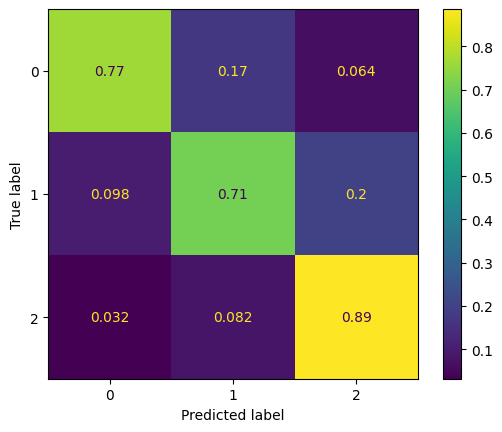

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.50178. Saving Model!
epoch 01, loss: 0.55739, acc: 0.76747, val_loss: 0.50178, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 02, loss: 0.55255, acc: 0.76971, val_loss: 0.50658, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 03, loss: 0.55147, acc: 0.76984, val_loss: 0.50927, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 04, loss: 0.54923, acc: 0.77113, val_loss: 0.51196, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 05, loss: 0.54800, acc: 0.77028, val_loss: 0.51481, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 06, loss: 0.54807, acc: 0.77035, val_loss: 0.51623, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 07, loss: 0.54532, acc: 0.77166, val_loss: 0.51791, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 08, loss: 0.54638, acc: 0.77131, val_loss: 0.51953, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 09, loss: 0.54409, acc: 0.77203, val_loss: 0.52123, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 10, loss: 0.54446, acc: 0.77211, val_loss: 0.52254, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 11, loss: 0.54318, acc: 0.77303, val_loss: 0.52335, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 12, loss: 0.54319, acc: 0.77364, val_loss: 0.52429, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 13, loss: 0.54222, acc: 0.77390, val_loss: 0.52540, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 14, loss: 0.54179, acc: 0.77375, val_loss: 0.52656, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 15, loss: 0.54133, acc: 0.77360, val_loss: 0.52712, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 16, loss: 0.54060, acc: 0.77329, val_loss: 0.52799, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 17, loss: 0.54090, acc: 0.77320, val_loss: 0.52879, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 18, loss: 0.53967, acc: 0.77440, val_loss: 0.52962, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 19, loss: 0.53942, acc: 0.77486, val_loss: 0.53040, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 20, loss: 0.53966, acc: 0.77412, val_loss: 0.53094, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 21, loss: 0.53806, acc: 0.77473, val_loss: 0.53192, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 22, loss: 0.53883, acc: 0.77582, val_loss: 0.53283, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 23, loss: 0.53765, acc: 0.77587, val_loss: 0.53318, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 24, loss: 0.53751, acc: 0.77680, val_loss: 0.53375, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 25, loss: 0.53681, acc: 0.77676, val_loss: 0.53470, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 26, loss: 0.53720, acc: 0.77635, val_loss: 0.53509, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 27, loss: 0.53616, acc: 0.77676, val_loss: 0.53561, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 28, loss: 0.53594, acc: 0.77739, val_loss: 0.53616, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 29, loss: 0.53585, acc: 0.77691, val_loss: 0.53665, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 30, loss: 0.53478, acc: 0.77824, val_loss: 0.53726, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 31, loss: 0.53533, acc: 0.77693, val_loss: 0.53777, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 32, loss: 0.53455, acc: 0.77707, val_loss: 0.53831, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 33, loss: 0.53406, acc: 0.77820, val_loss: 0.53858, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 34, loss: 0.53399, acc: 0.77920, val_loss: 0.53922, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 35, loss: 0.53348, acc: 0.77912, val_loss: 0.53973, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 36, loss: 0.53333, acc: 0.78136, val_loss: 0.53997, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 37, loss: 0.53259, acc: 0.78014, val_loss: 0.54054, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 38, loss: 0.53287, acc: 0.77955, val_loss: 0.54084, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 39, loss: 0.53216, acc: 0.77957, val_loss: 0.54162, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 40, loss: 0.53233, acc: 0.78121, val_loss: 0.54150, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 41, loss: 0.53083, acc: 0.78121, val_loss: 0.54204, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 42, loss: 0.53227, acc: 0.78084, val_loss: 0.54252, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 43, loss: 0.53034, acc: 0.78176, val_loss: 0.54281, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 44, loss: 0.53125, acc: 0.78106, val_loss: 0.54296, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 45, loss: 0.53013, acc: 0.78147, val_loss: 0.54335, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 46, loss: 0.53028, acc: 0.78224, val_loss: 0.54351, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 47, loss: 0.52957, acc: 0.78254, val_loss: 0.54408, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 48, loss: 0.52953, acc: 0.78256, val_loss: 0.54435, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 49, loss: 0.52919, acc: 0.78258, val_loss: 0.54476, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 50, loss: 0.52886, acc: 0.78289, val_loss: 0.54505, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 51, loss: 0.52869, acc: 0.78287, val_loss: 0.54531, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 52, loss: 0.52848, acc: 0.78280, val_loss: 0.54535, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 53, loss: 0.52772, acc: 0.78219, val_loss: 0.54611, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 54, loss: 0.52790, acc: 0.78298, val_loss: 0.54623, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 55, loss: 0.52734, acc: 0.78226, val_loss: 0.54648, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 56, loss: 0.52732, acc: 0.78304, val_loss: 0.54671, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 57, loss: 0.52642, acc: 0.78333, val_loss: 0.54706, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 58, loss: 0.52687, acc: 0.78317, val_loss: 0.54726, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 59, loss: 0.52596, acc: 0.78346, val_loss: 0.54760, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 60, loss: 0.52625, acc: 0.78383, val_loss: 0.54788, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 61, loss: 0.52554, acc: 0.78402, val_loss: 0.54801, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 62, loss: 0.52573, acc: 0.78374, val_loss: 0.54815, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 63, loss: 0.52464, acc: 0.78415, val_loss: 0.54848, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 64, loss: 0.52539, acc: 0.78315, val_loss: 0.54861, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 65, loss: 0.52444, acc: 0.78391, val_loss: 0.54924, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 66, loss: 0.52435, acc: 0.78413, val_loss: 0.54903, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 67, loss: 0.52394, acc: 0.78339, val_loss: 0.54898, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 68, loss: 0.52399, acc: 0.78431, val_loss: 0.54957, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 69, loss: 0.52303, acc: 0.78487, val_loss: 0.54984, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 70, loss: 0.52346, acc: 0.78359, val_loss: 0.54990, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 71, loss: 0.52263, acc: 0.78376, val_loss: 0.55018, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 72, loss: 0.52293, acc: 0.78461, val_loss: 0.55068, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 73, loss: 0.52200, acc: 0.78481, val_loss: 0.55051, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 74, loss: 0.52233, acc: 0.78483, val_loss: 0.55060, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 75, loss: 0.52161, acc: 0.78522, val_loss: 0.55094, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 76, loss: 0.52177, acc: 0.78509, val_loss: 0.55105, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 77, loss: 0.52083, acc: 0.78533, val_loss: 0.55109, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 78, loss: 0.52173, acc: 0.78507, val_loss: 0.55129, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 79, loss: 0.51989, acc: 0.78577, val_loss: 0.55189, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 80, loss: 0.52108, acc: 0.78540, val_loss: 0.55175, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 81, loss: 0.51974, acc: 0.78599, val_loss: 0.55225, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 82, loss: 0.52023, acc: 0.78581, val_loss: 0.55200, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 83, loss: 0.51924, acc: 0.78605, val_loss: 0.55229, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 84, loss: 0.51962, acc: 0.78586, val_loss: 0.55259, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 85, loss: 0.51899, acc: 0.78603, val_loss: 0.55232, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 86, loss: 0.51879, acc: 0.78607, val_loss: 0.55250, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 87, loss: 0.51801, acc: 0.78627, val_loss: 0.55317, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


epoch 88, loss: 0.51896, acc: 0.78590, val_loss: 0.55272, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 89, loss: 0.51759, acc: 0.78616, val_loss: 0.55324, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 90, loss: 0.51770, acc: 0.78612, val_loss: 0.55321, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 91, loss: 0.51769, acc: 0.78570, val_loss: 0.55329, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 92, loss: 0.51729, acc: 0.78653, val_loss: 0.55331, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 93, loss: 0.51654, acc: 0.78653, val_loss: 0.55333, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 94, loss: 0.51692, acc: 0.78690, val_loss: 0.55358, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 95, loss: 0.51620, acc: 0.78706, val_loss: 0.55367, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 96, loss: 0.51633, acc: 0.78699, val_loss: 0.55383, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 97, loss: 0.51541, acc: 0.78767, val_loss: 0.55403, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 98, loss: 0.51586, acc: 0.78712, val_loss: 0.55406, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 99, loss: 0.51499, acc: 0.78843, val_loss: 0.55417, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 100, loss: 0.51567, acc: 0.78736, val_loss: 0.55471, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 101, loss: 0.51430, acc: 0.78806, val_loss: 0.55454, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 102, loss: 0.51510, acc: 0.78771, val_loss: 0.55459, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 103, loss: 0.51374, acc: 0.78843, val_loss: 0.55502, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 104, loss: 0.51441, acc: 0.78784, val_loss: 0.55472, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 105, loss: 0.51340, acc: 0.78708, val_loss: 0.55505, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 106, loss: 0.51392, acc: 0.78937, val_loss: 0.55509, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 107, loss: 0.51276, acc: 0.78882, val_loss: 0.55550, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 108, loss: 0.51340, acc: 0.78740, val_loss: 0.55574, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 109, loss: 0.51271, acc: 0.78884, val_loss: 0.55565, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 110, loss: 0.51271, acc: 0.78898, val_loss: 0.55581, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 111, loss: 0.51193, acc: 0.78734, val_loss: 0.55627, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 112, loss: 0.51259, acc: 0.78771, val_loss: 0.55591, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 113, loss: 0.51135, acc: 0.78959, val_loss: 0.55633, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 114, loss: 0.51192, acc: 0.78880, val_loss: 0.55626, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 115, loss: 0.51082, acc: 0.78858, val_loss: 0.55621, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 116, loss: 0.51164, acc: 0.78760, val_loss: 0.55627, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 117, loss: 0.51019, acc: 0.79011, val_loss: 0.55678, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 118, loss: 0.51089, acc: 0.78987, val_loss: 0.55671, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


epoch 119, loss: 0.51010, acc: 0.79116, val_loss: 0.55668, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 120, loss: 0.51015, acc: 0.79004, val_loss: 0.55701, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 121, loss: 0.50950, acc: 0.79039, val_loss: 0.55720, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 122, loss: 0.50999, acc: 0.79009, val_loss: 0.55725, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 123, loss: 0.50907, acc: 0.78845, val_loss: 0.55739, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 124, loss: 0.50930, acc: 0.78911, val_loss: 0.55732, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 125, loss: 0.50863, acc: 0.78952, val_loss: 0.55731, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 126, loss: 0.50907, acc: 0.78956, val_loss: 0.55781, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 127, loss: 0.50793, acc: 0.79002, val_loss: 0.55777, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 128, loss: 0.50846, acc: 0.78956, val_loss: 0.55798, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 129, loss: 0.50777, acc: 0.79127, val_loss: 0.55802, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 130, loss: 0.50805, acc: 0.79074, val_loss: 0.55800, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 131, loss: 0.50720, acc: 0.78893, val_loss: 0.55780, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 132, loss: 0.50768, acc: 0.79002, val_loss: 0.55844, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 133, loss: 0.50637, acc: 0.79140, val_loss: 0.55872, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 134, loss: 0.50725, acc: 0.79033, val_loss: 0.55835, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 135, loss: 0.50614, acc: 0.79161, val_loss: 0.55867, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 136, loss: 0.50690, acc: 0.79151, val_loss: 0.55856, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 137, loss: 0.50550, acc: 0.79111, val_loss: 0.55875, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 138, loss: 0.50603, acc: 0.79120, val_loss: 0.55879, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 139, loss: 0.50564, acc: 0.78983, val_loss: 0.55898, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 140, loss: 0.50558, acc: 0.79177, val_loss: 0.55886, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 141, loss: 0.50481, acc: 0.79166, val_loss: 0.55913, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 142, loss: 0.50525, acc: 0.79177, val_loss: 0.55901, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 143, loss: 0.50444, acc: 0.79216, val_loss: 0.55949, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 144, loss: 0.50478, acc: 0.79290, val_loss: 0.55911, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 145, loss: 0.50363, acc: 0.79218, val_loss: 0.55958, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 146, loss: 0.50467, acc: 0.79129, val_loss: 0.55930, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 147, loss: 0.50326, acc: 0.79478, val_loss: 0.55961, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 148, loss: 0.50361, acc: 0.79334, val_loss: 0.55954, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 149, loss: 0.50351, acc: 0.79305, val_loss: 0.55984, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 150, loss: 0.50275, acc: 0.79443, val_loss: 0.56017, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 151, loss: 0.50296, acc: 0.79327, val_loss: 0.56016, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 152, loss: 0.50285, acc: 0.79369, val_loss: 0.56020, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 153, loss: 0.50220, acc: 0.79358, val_loss: 0.56000, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 154, loss: 0.50234, acc: 0.79301, val_loss: 0.56016, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 155, loss: 0.50175, acc: 0.79408, val_loss: 0.56054, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 156, loss: 0.50204, acc: 0.79487, val_loss: 0.56056, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 157, loss: 0.50113, acc: 0.79504, val_loss: 0.56029, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 158, loss: 0.50166, acc: 0.79425, val_loss: 0.56064, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 159, loss: 0.50080, acc: 0.79582, val_loss: 0.56084, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 160, loss: 0.50091, acc: 0.79552, val_loss: 0.56080, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 161, loss: 0.50038, acc: 0.79469, val_loss: 0.56092, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 162, loss: 0.50058, acc: 0.79676, val_loss: 0.56108, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 163, loss: 0.49996, acc: 0.79521, val_loss: 0.56082, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 164, loss: 0.50028, acc: 0.79574, val_loss: 0.56119, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 165, loss: 0.49923, acc: 0.79521, val_loss: 0.56157, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 166, loss: 0.49987, acc: 0.79515, val_loss: 0.56131, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 167, loss: 0.49929, acc: 0.79504, val_loss: 0.56159, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 168, loss: 0.49920, acc: 0.79589, val_loss: 0.56184, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 169, loss: 0.49852, acc: 0.79761, val_loss: 0.56186, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 170, loss: 0.49920, acc: 0.79676, val_loss: 0.56136, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 171, loss: 0.49769, acc: 0.79873, val_loss: 0.56213, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 172, loss: 0.49886, acc: 0.79633, val_loss: 0.56162, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 173, loss: 0.49753, acc: 0.79558, val_loss: 0.56210, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 174, loss: 0.49816, acc: 0.79628, val_loss: 0.56169, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 175, loss: 0.49732, acc: 0.79689, val_loss: 0.56181, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 176, loss: 0.49762, acc: 0.79753, val_loss: 0.56165, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 177, loss: 0.49665, acc: 0.79702, val_loss: 0.56199, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 178, loss: 0.49752, acc: 0.79862, val_loss: 0.56196, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 179, loss: 0.49592, acc: 0.79914, val_loss: 0.56261, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 180, loss: 0.49723, acc: 0.79894, val_loss: 0.56223, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 181, loss: 0.49580, acc: 0.79794, val_loss: 0.56261, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 182, loss: 0.49622, acc: 0.79774, val_loss: 0.56219, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 183, loss: 0.49578, acc: 0.79777, val_loss: 0.56209, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


epoch 184, loss: 0.49573, acc: 0.79899, val_loss: 0.56285, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 185, loss: 0.49524, acc: 0.79705, val_loss: 0.56259, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 186, loss: 0.49535, acc: 0.79801, val_loss: 0.56293, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 187, loss: 0.49477, acc: 0.79929, val_loss: 0.56272, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 188, loss: 0.49488, acc: 0.79846, val_loss: 0.56276, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 189, loss: 0.49410, acc: 0.79953, val_loss: 0.56319, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 190, loss: 0.49474, acc: 0.79825, val_loss: 0.56265, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 191, loss: 0.49358, acc: 0.79947, val_loss: 0.56325, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 192, loss: 0.49416, acc: 0.79833, val_loss: 0.56324, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 193, loss: 0.49363, acc: 0.79890, val_loss: 0.56323, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 194, loss: 0.49342, acc: 0.79881, val_loss: 0.56321, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 195, loss: 0.49314, acc: 0.79857, val_loss: 0.56332, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 196, loss: 0.49311, acc: 0.79995, val_loss: 0.56338, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 197, loss: 0.49269, acc: 0.79914, val_loss: 0.56369, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 198, loss: 0.49237, acc: 0.80014, val_loss: 0.56362, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 199, loss: 0.49288, acc: 0.79892, val_loss: 0.56355, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 200, loss: 0.49187, acc: 0.80060, val_loss: 0.56417, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 201, loss: 0.49211, acc: 0.79923, val_loss: 0.56381, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 202, loss: 0.49174, acc: 0.79969, val_loss: 0.56439, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 203, loss: 0.49138, acc: 0.79988, val_loss: 0.56416, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 204, loss: 0.49166, acc: 0.79958, val_loss: 0.56398, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 205, loss: 0.49087, acc: 0.79973, val_loss: 0.56404, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 206, loss: 0.49129, acc: 0.79973, val_loss: 0.56385, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 207, loss: 0.49015, acc: 0.79993, val_loss: 0.56473, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 208, loss: 0.49110, acc: 0.79938, val_loss: 0.56452, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 209, loss: 0.49012, acc: 0.80017, val_loss: 0.56448, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 210, loss: 0.48993, acc: 0.80113, val_loss: 0.56446, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 211, loss: 0.49023, acc: 0.79995, val_loss: 0.56450, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 212, loss: 0.48949, acc: 0.80008, val_loss: 0.56465, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 213, loss: 0.48940, acc: 0.80060, val_loss: 0.56478, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 214, loss: 0.48932, acc: 0.80152, val_loss: 0.56463, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 215, loss: 0.48869, acc: 0.80080, val_loss: 0.56480, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 216, loss: 0.48923, acc: 0.80051, val_loss: 0.56486, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 217, loss: 0.48834, acc: 0.80058, val_loss: 0.56489, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 218, loss: 0.48861, acc: 0.80056, val_loss: 0.56510, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 219, loss: 0.48815, acc: 0.80113, val_loss: 0.56483, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 220, loss: 0.48815, acc: 0.80071, val_loss: 0.56495, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 221, loss: 0.48766, acc: 0.80126, val_loss: 0.56518, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 222, loss: 0.48739, acc: 0.80110, val_loss: 0.56554, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 223, loss: 0.48770, acc: 0.80137, val_loss: 0.56532, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 224, loss: 0.48716, acc: 0.80222, val_loss: 0.56517, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 225, loss: 0.48674, acc: 0.80134, val_loss: 0.56545, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 226, loss: 0.48679, acc: 0.80147, val_loss: 0.56552, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 227, loss: 0.48646, acc: 0.80134, val_loss: 0.56571, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 228, loss: 0.48654, acc: 0.80187, val_loss: 0.56575, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 229, loss: 0.48617, acc: 0.80180, val_loss: 0.56608, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 230, loss: 0.48587, acc: 0.80143, val_loss: 0.56547, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 231, loss: 0.48592, acc: 0.80209, val_loss: 0.56539, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 232, loss: 0.48540, acc: 0.80224, val_loss: 0.56581, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 233, loss: 0.48550, acc: 0.80202, val_loss: 0.56550, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 234, loss: 0.48503, acc: 0.80243, val_loss: 0.56543, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 235, loss: 0.48510, acc: 0.80315, val_loss: 0.56552, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 236, loss: 0.48432, acc: 0.80246, val_loss: 0.56609, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 237, loss: 0.48493, acc: 0.80359, val_loss: 0.56597, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 238, loss: 0.48393, acc: 0.80326, val_loss: 0.56591, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 239, loss: 0.48429, acc: 0.80387, val_loss: 0.56566, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 240, loss: 0.48401, acc: 0.80464, val_loss: 0.56531, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 241, loss: 0.48340, acc: 0.80385, val_loss: 0.56579, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 242, loss: 0.48372, acc: 0.80462, val_loss: 0.56566, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 243, loss: 0.48322, acc: 0.80488, val_loss: 0.56536, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 244, loss: 0.48305, acc: 0.80472, val_loss: 0.56564, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 245, loss: 0.48296, acc: 0.80510, val_loss: 0.56539, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 246, loss: 0.48270, acc: 0.80481, val_loss: 0.56540, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 247, loss: 0.48221, acc: 0.80523, val_loss: 0.56588, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 248, loss: 0.48256, acc: 0.80503, val_loss: 0.56551, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 249, loss: 0.48186, acc: 0.80536, val_loss: 0.56564, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 250, loss: 0.48199, acc: 0.80536, val_loss: 0.56545, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 251, loss: 0.48174, acc: 0.80571, val_loss: 0.56550, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 252, loss: 0.48143, acc: 0.80512, val_loss: 0.56561, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 253, loss: 0.48133, acc: 0.80536, val_loss: 0.56530, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 254, loss: 0.48072, acc: 0.80560, val_loss: 0.56519, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 255, loss: 0.48096, acc: 0.80571, val_loss: 0.56529, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 256, loss: 0.48052, acc: 0.80582, val_loss: 0.56547, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 257, loss: 0.48040, acc: 0.80608, val_loss: 0.56573, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 258, loss: 0.48044, acc: 0.80595, val_loss: 0.56553, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 259, loss: 0.47982, acc: 0.80643, val_loss: 0.56548, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 260, loss: 0.48024, acc: 0.80601, val_loss: 0.56548, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 261, loss: 0.47940, acc: 0.80649, val_loss: 0.56582, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 262, loss: 0.47956, acc: 0.80638, val_loss: 0.56591, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 263, loss: 0.47909, acc: 0.80704, val_loss: 0.56560, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 264, loss: 0.47918, acc: 0.80662, val_loss: 0.56579, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 265, loss: 0.47861, acc: 0.80706, val_loss: 0.56559, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 266, loss: 0.47897, acc: 0.80686, val_loss: 0.56594, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 267, loss: 0.47839, acc: 0.80708, val_loss: 0.56546, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 268, loss: 0.47796, acc: 0.80723, val_loss: 0.56572, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 269, loss: 0.47836, acc: 0.80706, val_loss: 0.56540, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 270, loss: 0.47773, acc: 0.80758, val_loss: 0.56586, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 271, loss: 0.47745, acc: 0.80732, val_loss: 0.56573, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 272, loss: 0.47787, acc: 0.80774, val_loss: 0.56598, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 273, loss: 0.47684, acc: 0.80798, val_loss: 0.56586, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 274, loss: 0.47732, acc: 0.80778, val_loss: 0.56574, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 275, loss: 0.47674, acc: 0.80774, val_loss: 0.56583, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 276, loss: 0.47679, acc: 0.80813, val_loss: 0.56595, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 277, loss: 0.47643, acc: 0.80778, val_loss: 0.56579, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 278, loss: 0.47612, acc: 0.80821, val_loss: 0.56590, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 279, loss: 0.47622, acc: 0.80817, val_loss: 0.56597, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 280, loss: 0.47603, acc: 0.80863, val_loss: 0.56589, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 281, loss: 0.47540, acc: 0.80885, val_loss: 0.56613, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 282, loss: 0.47566, acc: 0.80850, val_loss: 0.56613, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 283, loss: 0.47526, acc: 0.80904, val_loss: 0.56562, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 284, loss: 0.47523, acc: 0.80898, val_loss: 0.56567, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 285, loss: 0.47467, acc: 0.80885, val_loss: 0.56585, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 286, loss: 0.47501, acc: 0.80928, val_loss: 0.56591, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 287, loss: 0.47435, acc: 0.80915, val_loss: 0.56596, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 288, loss: 0.47487, acc: 0.80917, val_loss: 0.56578, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 289, loss: 0.47358, acc: 0.80920, val_loss: 0.56617, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 290, loss: 0.47456, acc: 0.80941, val_loss: 0.56575, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 291, loss: 0.47354, acc: 0.81013, val_loss: 0.56591, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 292, loss: 0.47374, acc: 0.80996, val_loss: 0.56621, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 293, loss: 0.47309, acc: 0.81022, val_loss: 0.56612, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 294, loss: 0.47347, acc: 0.81020, val_loss: 0.56625, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 295, loss: 0.47259, acc: 0.81013, val_loss: 0.56600, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 296, loss: 0.47363, acc: 0.81024, val_loss: 0.56592, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 297, loss: 0.47192, acc: 0.81068, val_loss: 0.56624, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 298, loss: 0.47270, acc: 0.81053, val_loss: 0.56615, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 299, loss: 0.47202, acc: 0.81042, val_loss: 0.56610, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 300, loss: 0.47250, acc: 0.81064, val_loss: 0.56586, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 301, loss: 0.47124, acc: 0.81101, val_loss: 0.56662, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 302, loss: 0.47222, acc: 0.81105, val_loss: 0.56592, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 303, loss: 0.47080, acc: 0.81116, val_loss: 0.56632, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 304, loss: 0.47204, acc: 0.81109, val_loss: 0.56611, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 305, loss: 0.47040, acc: 0.81129, val_loss: 0.56663, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 306, loss: 0.47120, acc: 0.81142, val_loss: 0.56600, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 307, loss: 0.47036, acc: 0.81177, val_loss: 0.56635, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 308, loss: 0.47057, acc: 0.81149, val_loss: 0.56655, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 309, loss: 0.47042, acc: 0.81164, val_loss: 0.56614, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 310, loss: 0.47020, acc: 0.81147, val_loss: 0.56645, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 311, loss: 0.46962, acc: 0.81188, val_loss: 0.56663, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 312, loss: 0.47037, acc: 0.81157, val_loss: 0.56621, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 313, loss: 0.46878, acc: 0.81232, val_loss: 0.56684, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 314, loss: 0.47004, acc: 0.81186, val_loss: 0.56659, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 315, loss: 0.46873, acc: 0.81240, val_loss: 0.56644, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 316, loss: 0.46948, acc: 0.81184, val_loss: 0.56670, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 317, loss: 0.46847, acc: 0.81234, val_loss: 0.56718, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 318, loss: 0.46916, acc: 0.81225, val_loss: 0.56675, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 319, loss: 0.46821, acc: 0.81256, val_loss: 0.56714, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 320, loss: 0.46830, acc: 0.81232, val_loss: 0.56711, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 321, loss: 0.46814, acc: 0.81256, val_loss: 0.56688, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 322, loss: 0.46793, acc: 0.81229, val_loss: 0.56723, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 323, loss: 0.46779, acc: 0.81238, val_loss: 0.56722, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 324, loss: 0.46729, acc: 0.81225, val_loss: 0.56703, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 325, loss: 0.46748, acc: 0.81238, val_loss: 0.56698, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 326, loss: 0.46690, acc: 0.81258, val_loss: 0.56746, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 327, loss: 0.46705, acc: 0.81280, val_loss: 0.56736, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 328, loss: 0.46636, acc: 0.81286, val_loss: 0.56722, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 329, loss: 0.46698, acc: 0.81288, val_loss: 0.56726, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 330, loss: 0.46600, acc: 0.81308, val_loss: 0.56769, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 331, loss: 0.46664, acc: 0.81290, val_loss: 0.56710, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 332, loss: 0.46571, acc: 0.81286, val_loss: 0.56751, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 333, loss: 0.46572, acc: 0.81314, val_loss: 0.56767, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 334, loss: 0.46587, acc: 0.81330, val_loss: 0.56718, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 335, loss: 0.46552, acc: 0.81312, val_loss: 0.56746, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 336, loss: 0.46506, acc: 0.81312, val_loss: 0.56771, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 337, loss: 0.46541, acc: 0.81334, val_loss: 0.56770, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 338, loss: 0.46475, acc: 0.81330, val_loss: 0.56745, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 339, loss: 0.46467, acc: 0.81338, val_loss: 0.56763, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 340, loss: 0.46471, acc: 0.81330, val_loss: 0.56789, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 341, loss: 0.46441, acc: 0.81365, val_loss: 0.56751, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 342, loss: 0.46394, acc: 0.81369, val_loss: 0.56766, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 343, loss: 0.46448, acc: 0.81345, val_loss: 0.56798, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 344, loss: 0.46344, acc: 0.81386, val_loss: 0.56822, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 345, loss: 0.46400, acc: 0.81384, val_loss: 0.56760, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 346, loss: 0.46290, acc: 0.81413, val_loss: 0.56807, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 347, loss: 0.46358, acc: 0.81386, val_loss: 0.56822, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 348, loss: 0.46321, acc: 0.81386, val_loss: 0.56800, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 349, loss: 0.46264, acc: 0.81406, val_loss: 0.56821, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 350, loss: 0.46311, acc: 0.81384, val_loss: 0.56809, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 351, loss: 0.46257, acc: 0.81445, val_loss: 0.56778, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 352, loss: 0.46237, acc: 0.81430, val_loss: 0.56828, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 353, loss: 0.46219, acc: 0.81410, val_loss: 0.56809, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 354, loss: 0.46220, acc: 0.81474, val_loss: 0.56777, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 355, loss: 0.46144, acc: 0.81539, val_loss: 0.56833, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 356, loss: 0.46212, acc: 0.81434, val_loss: 0.56817, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 357, loss: 0.46116, acc: 0.81465, val_loss: 0.56865, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 358, loss: 0.46157, acc: 0.81489, val_loss: 0.56797, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 359, loss: 0.46107, acc: 0.81500, val_loss: 0.56846, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 360, loss: 0.46068, acc: 0.81467, val_loss: 0.56853, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 361, loss: 0.46105, acc: 0.81506, val_loss: 0.56828, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 362, loss: 0.46062, acc: 0.81496, val_loss: 0.56827, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 363, loss: 0.46024, acc: 0.81587, val_loss: 0.56867, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 364, loss: 0.46008, acc: 0.81539, val_loss: 0.56859, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 365, loss: 0.46032, acc: 0.81522, val_loss: 0.56859, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 366, loss: 0.46010, acc: 0.81493, val_loss: 0.56871, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 367, loss: 0.45937, acc: 0.81653, val_loss: 0.56931, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 368, loss: 0.45978, acc: 0.81513, val_loss: 0.56858, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 369, loss: 0.45943, acc: 0.81537, val_loss: 0.56889, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 370, loss: 0.45896, acc: 0.81637, val_loss: 0.56871, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 371, loss: 0.45940, acc: 0.81544, val_loss: 0.56900, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 372, loss: 0.45836, acc: 0.81648, val_loss: 0.56932, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 373, loss: 0.45951, acc: 0.81552, val_loss: 0.56915, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 374, loss: 0.45779, acc: 0.81759, val_loss: 0.56940, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 375, loss: 0.45911, acc: 0.81687, val_loss: 0.56897, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 376, loss: 0.45772, acc: 0.81729, val_loss: 0.56934, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 377, loss: 0.45826, acc: 0.81661, val_loss: 0.56942, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 378, loss: 0.45766, acc: 0.81670, val_loss: 0.56956, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 379, loss: 0.45801, acc: 0.81687, val_loss: 0.56914, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 380, loss: 0.45715, acc: 0.81705, val_loss: 0.56980, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 381, loss: 0.45759, acc: 0.81677, val_loss: 0.56946, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 382, loss: 0.45704, acc: 0.81718, val_loss: 0.56975, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 383, loss: 0.45695, acc: 0.81718, val_loss: 0.56946, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 384, loss: 0.45649, acc: 0.81753, val_loss: 0.56957, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 385, loss: 0.45652, acc: 0.81720, val_loss: 0.57024, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 386, loss: 0.45676, acc: 0.81816, val_loss: 0.56980, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 387, loss: 0.45617, acc: 0.81722, val_loss: 0.56997, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 388, loss: 0.45588, acc: 0.81735, val_loss: 0.56990, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 389, loss: 0.45626, acc: 0.81746, val_loss: 0.56969, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 390, loss: 0.45531, acc: 0.81783, val_loss: 0.57033, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 391, loss: 0.45597, acc: 0.81792, val_loss: 0.57032, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 392, loss: 0.45506, acc: 0.81779, val_loss: 0.57020, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 393, loss: 0.45532, acc: 0.81866, val_loss: 0.56992, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 394, loss: 0.45493, acc: 0.81901, val_loss: 0.57022, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 395, loss: 0.45509, acc: 0.81903, val_loss: 0.57014, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 396, loss: 0.45442, acc: 0.81893, val_loss: 0.57039, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 397, loss: 0.45468, acc: 0.81805, val_loss: 0.57043, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


epoch 398, loss: 0.45401, acc: 0.81810, val_loss: 0.57076, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 399, loss: 0.45454, acc: 0.81838, val_loss: 0.57011, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 400, loss: 0.45363, acc: 0.81827, val_loss: 0.57062, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 401, loss: 0.45449, acc: 0.81899, val_loss: 0.57042, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 402, loss: 0.45318, acc: 0.81925, val_loss: 0.57079, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 403, loss: 0.45380, acc: 0.81838, val_loss: 0.57100, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 404, loss: 0.45301, acc: 0.81831, val_loss: 0.57075, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 405, loss: 0.45344, acc: 0.81923, val_loss: 0.57067, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 406, loss: 0.45247, acc: 0.81954, val_loss: 0.57066, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 407, loss: 0.45309, acc: 0.81975, val_loss: 0.57118, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 408, loss: 0.45238, acc: 0.81838, val_loss: 0.57035, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 409, loss: 0.45257, acc: 0.81938, val_loss: 0.57098, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 410, loss: 0.45217, acc: 0.81997, val_loss: 0.57072, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 411, loss: 0.45220, acc: 0.81993, val_loss: 0.57116, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 412, loss: 0.45172, acc: 0.81921, val_loss: 0.57089, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 413, loss: 0.45195, acc: 0.82021, val_loss: 0.57122, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 414, loss: 0.45164, acc: 0.82004, val_loss: 0.57115, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 415, loss: 0.45132, acc: 0.82006, val_loss: 0.57156, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 416, loss: 0.45142, acc: 0.81925, val_loss: 0.57080, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 417, loss: 0.45135, acc: 0.82015, val_loss: 0.57132, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 418, loss: 0.45069, acc: 0.82041, val_loss: 0.57145, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 419, loss: 0.45110, acc: 0.82037, val_loss: 0.57098, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 420, loss: 0.45019, acc: 0.82211, val_loss: 0.57181, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 421, loss: 0.45079, acc: 0.81967, val_loss: 0.57118, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 422, loss: 0.45012, acc: 0.82023, val_loss: 0.57162, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 423, loss: 0.45029, acc: 0.82013, val_loss: 0.57143, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 424, loss: 0.45005, acc: 0.82069, val_loss: 0.57156, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 425, loss: 0.44963, acc: 0.82045, val_loss: 0.57142, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 426, loss: 0.44990, acc: 0.82082, val_loss: 0.57155, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 427, loss: 0.44920, acc: 0.82052, val_loss: 0.57165, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 428, loss: 0.44933, acc: 0.82082, val_loss: 0.57162, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 429, loss: 0.44893, acc: 0.82102, val_loss: 0.57131, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 430, loss: 0.44906, acc: 0.82119, val_loss: 0.57218, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 431, loss: 0.44862, acc: 0.82041, val_loss: 0.57204, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 432, loss: 0.44864, acc: 0.82141, val_loss: 0.57153, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 433, loss: 0.44807, acc: 0.82141, val_loss: 0.57196, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 434, loss: 0.44909, acc: 0.82117, val_loss: 0.57160, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 435, loss: 0.44750, acc: 0.82335, val_loss: 0.57196, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 436, loss: 0.44853, acc: 0.82130, val_loss: 0.57171, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 437, loss: 0.44713, acc: 0.82178, val_loss: 0.57199, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 438, loss: 0.44819, acc: 0.82159, val_loss: 0.57225, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 439, loss: 0.44690, acc: 0.82270, val_loss: 0.57244, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 440, loss: 0.44791, acc: 0.82139, val_loss: 0.57186, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 441, loss: 0.44617, acc: 0.82359, val_loss: 0.57238, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 442, loss: 0.44783, acc: 0.82172, val_loss: 0.57228, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 443, loss: 0.44596, acc: 0.82386, val_loss: 0.57269, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 444, loss: 0.44719, acc: 0.82218, val_loss: 0.57226, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 445, loss: 0.44608, acc: 0.82359, val_loss: 0.57241, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 446, loss: 0.44655, acc: 0.82218, val_loss: 0.57182, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 447, loss: 0.44588, acc: 0.82250, val_loss: 0.57254, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 448, loss: 0.44613, acc: 0.82222, val_loss: 0.57256, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 449, loss: 0.44544, acc: 0.82226, val_loss: 0.57227, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 450, loss: 0.44580, acc: 0.82237, val_loss: 0.57247, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 451, loss: 0.44529, acc: 0.82327, val_loss: 0.57202, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


epoch 452, loss: 0.44524, acc: 0.82255, val_loss: 0.57244, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 453, loss: 0.44511, acc: 0.82364, val_loss: 0.57256, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 454, loss: 0.44500, acc: 0.82276, val_loss: 0.57236, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 455, loss: 0.44429, acc: 0.82427, val_loss: 0.57289, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 456, loss: 0.44528, acc: 0.82261, val_loss: 0.57221, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 457, loss: 0.44394, acc: 0.82344, val_loss: 0.57259, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 458, loss: 0.44470, acc: 0.82292, val_loss: 0.57219, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 459, loss: 0.44379, acc: 0.82351, val_loss: 0.57268, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 460, loss: 0.44408, acc: 0.82324, val_loss: 0.57280, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 461, loss: 0.44337, acc: 0.82490, val_loss: 0.57296, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 462, loss: 0.44403, acc: 0.82316, val_loss: 0.57273, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 463, loss: 0.44304, acc: 0.82305, val_loss: 0.57285, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 464, loss: 0.44370, acc: 0.82320, val_loss: 0.57269, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 465, loss: 0.44275, acc: 0.82453, val_loss: 0.57304, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 466, loss: 0.44328, acc: 0.82316, val_loss: 0.57298, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 467, loss: 0.44269, acc: 0.82399, val_loss: 0.57262, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 468, loss: 0.44288, acc: 0.82353, val_loss: 0.57317, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 469, loss: 0.44231, acc: 0.82447, val_loss: 0.57282, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 470, loss: 0.44243, acc: 0.82364, val_loss: 0.57264, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 471, loss: 0.44199, acc: 0.82407, val_loss: 0.57301, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 472, loss: 0.44206, acc: 0.82416, val_loss: 0.57291, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 473, loss: 0.44155, acc: 0.82412, val_loss: 0.57335, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 474, loss: 0.44193, acc: 0.82370, val_loss: 0.57281, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 475, loss: 0.44093, acc: 0.82593, val_loss: 0.57307, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 476, loss: 0.44180, acc: 0.82366, val_loss: 0.57293, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 477, loss: 0.44099, acc: 0.82414, val_loss: 0.57331, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 478, loss: 0.44074, acc: 0.82464, val_loss: 0.57351, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 479, loss: 0.44114, acc: 0.82525, val_loss: 0.57315, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 480, loss: 0.44052, acc: 0.82451, val_loss: 0.57323, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 481, loss: 0.44063, acc: 0.82431, val_loss: 0.57337, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 482, loss: 0.44015, acc: 0.82497, val_loss: 0.57349, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.34it/s]


epoch 483, loss: 0.44023, acc: 0.82455, val_loss: 0.57358, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 484, loss: 0.43987, acc: 0.82477, val_loss: 0.57327, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 485, loss: 0.43971, acc: 0.82447, val_loss: 0.57354, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


epoch 486, loss: 0.43966, acc: 0.82599, val_loss: 0.57336, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 487, loss: 0.43962, acc: 0.82468, val_loss: 0.57363, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 488, loss: 0.43946, acc: 0.82455, val_loss: 0.57336, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 489, loss: 0.43919, acc: 0.82588, val_loss: 0.57365, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 490, loss: 0.43903, acc: 0.82479, val_loss: 0.57359, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 491, loss: 0.43907, acc: 0.82584, val_loss: 0.57384, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.44it/s]


epoch 492, loss: 0.43868, acc: 0.82501, val_loss: 0.57348, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 493, loss: 0.43819, acc: 0.82549, val_loss: 0.57409, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 494, loss: 0.43902, acc: 0.82484, val_loss: 0.57428, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 495, loss: 0.43770, acc: 0.82597, val_loss: 0.57437, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 496, loss: 0.43894, acc: 0.82475, val_loss: 0.57378, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 497, loss: 0.43745, acc: 0.82652, val_loss: 0.57432, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 498, loss: 0.43831, acc: 0.82538, val_loss: 0.57359, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 499, loss: 0.43714, acc: 0.82719, val_loss: 0.57438, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 500, loss: 0.43800, acc: 0.82508, val_loss: 0.57389, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 501, loss: 0.43692, acc: 0.82658, val_loss: 0.57429, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 502, loss: 0.43732, acc: 0.82547, val_loss: 0.57440, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 503, loss: 0.43689, acc: 0.82551, val_loss: 0.57390, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 504, loss: 0.43695, acc: 0.82551, val_loss: 0.57423, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 505, loss: 0.43666, acc: 0.82737, val_loss: 0.57455, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 506, loss: 0.43658, acc: 0.82549, val_loss: 0.57411, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 507, loss: 0.43637, acc: 0.82780, val_loss: 0.57452, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 508, loss: 0.43632, acc: 0.82682, val_loss: 0.57442, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 509, loss: 0.43592, acc: 0.82763, val_loss: 0.57448, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 510, loss: 0.43632, acc: 0.82571, val_loss: 0.57440, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 511, loss: 0.43538, acc: 0.82817, val_loss: 0.57479, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


epoch 512, loss: 0.43583, acc: 0.82700, val_loss: 0.57421, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 513, loss: 0.43540, acc: 0.82900, val_loss: 0.57452, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 514, loss: 0.43520, acc: 0.82719, val_loss: 0.57481, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


epoch 515, loss: 0.43507, acc: 0.82831, val_loss: 0.57502, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 516, loss: 0.43499, acc: 0.82844, val_loss: 0.57454, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 517, loss: 0.43471, acc: 0.82822, val_loss: 0.57503, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 518, loss: 0.43475, acc: 0.82752, val_loss: 0.57450, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 519, loss: 0.43438, acc: 0.82741, val_loss: 0.57443, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 520, loss: 0.43430, acc: 0.82839, val_loss: 0.57533, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 521, loss: 0.43406, acc: 0.82857, val_loss: 0.57486, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 522, loss: 0.43445, acc: 0.82776, val_loss: 0.57488, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 523, loss: 0.43345, acc: 0.82889, val_loss: 0.57523, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 524, loss: 0.43395, acc: 0.82879, val_loss: 0.57509, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 525, loss: 0.43327, acc: 0.82870, val_loss: 0.57496, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 526, loss: 0.43375, acc: 0.82940, val_loss: 0.57488, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 527, loss: 0.43316, acc: 0.82828, val_loss: 0.57482, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 528, loss: 0.43290, acc: 0.82948, val_loss: 0.57521, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 529, loss: 0.43299, acc: 0.82848, val_loss: 0.57525, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 530, loss: 0.43289, acc: 0.82977, val_loss: 0.57514, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 531, loss: 0.43234, acc: 0.83036, val_loss: 0.57512, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 532, loss: 0.43263, acc: 0.82872, val_loss: 0.57520, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 533, loss: 0.43222, acc: 0.82968, val_loss: 0.57555, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 534, loss: 0.43226, acc: 0.82865, val_loss: 0.57510, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 535, loss: 0.43177, acc: 0.83051, val_loss: 0.57575, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 536, loss: 0.43221, acc: 0.82859, val_loss: 0.57500, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 537, loss: 0.43142, acc: 0.82861, val_loss: 0.57514, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 538, loss: 0.43206, acc: 0.82861, val_loss: 0.57531, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 539, loss: 0.43089, acc: 0.83118, val_loss: 0.57573, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 540, loss: 0.43173, acc: 0.83027, val_loss: 0.57540, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 541, loss: 0.43077, acc: 0.82920, val_loss: 0.57539, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 542, loss: 0.43152, acc: 0.82896, val_loss: 0.57542, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 543, loss: 0.43052, acc: 0.83075, val_loss: 0.57592, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 544, loss: 0.43100, acc: 0.82927, val_loss: 0.57542, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 545, loss: 0.43000, acc: 0.83149, val_loss: 0.57645, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 546, loss: 0.43092, acc: 0.82916, val_loss: 0.57535, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 547, loss: 0.42956, acc: 0.83140, val_loss: 0.57585, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 548, loss: 0.43037, acc: 0.83003, val_loss: 0.57586, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 549, loss: 0.42973, acc: 0.83099, val_loss: 0.57615, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 550, loss: 0.43014, acc: 0.82953, val_loss: 0.57561, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 551, loss: 0.42938, acc: 0.83186, val_loss: 0.57634, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 552, loss: 0.42944, acc: 0.83164, val_loss: 0.57630, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 553, loss: 0.42987, acc: 0.83022, val_loss: 0.57622, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 554, loss: 0.42871, acc: 0.83206, val_loss: 0.57627, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 555, loss: 0.42946, acc: 0.82998, val_loss: 0.57525, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 556, loss: 0.42848, acc: 0.83214, val_loss: 0.57639, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 557, loss: 0.42924, acc: 0.83142, val_loss: 0.57637, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 558, loss: 0.42788, acc: 0.83282, val_loss: 0.57622, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 559, loss: 0.42917, acc: 0.83068, val_loss: 0.57589, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 560, loss: 0.42750, acc: 0.83247, val_loss: 0.57635, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 561, loss: 0.42881, acc: 0.83094, val_loss: 0.57599, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 562, loss: 0.42754, acc: 0.83276, val_loss: 0.57700, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 563, loss: 0.42816, acc: 0.83099, val_loss: 0.57605, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 564, loss: 0.42713, acc: 0.83286, val_loss: 0.57669, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 565, loss: 0.42798, acc: 0.83108, val_loss: 0.57638, val_accuracy: 0.79741


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


epoch 566, loss: 0.42678, acc: 0.83315, val_loss: 0.57637, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 567, loss: 0.42780, acc: 0.83129, val_loss: 0.57606, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 568, loss: 0.42633, acc: 0.83339, val_loss: 0.57698, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


epoch 569, loss: 0.42730, acc: 0.83125, val_loss: 0.57650, val_accuracy: 0.79741


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 570, loss: 0.42652, acc: 0.83321, val_loss: 0.57660, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 571, loss: 0.42686, acc: 0.83186, val_loss: 0.57715, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 572, loss: 0.42614, acc: 0.83291, val_loss: 0.57663, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 573, loss: 0.42701, acc: 0.83204, val_loss: 0.57653, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 574, loss: 0.42542, acc: 0.83367, val_loss: 0.57728, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 575, loss: 0.42677, acc: 0.83145, val_loss: 0.57655, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 576, loss: 0.42557, acc: 0.83382, val_loss: 0.57659, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 577, loss: 0.42665, acc: 0.83280, val_loss: 0.57702, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 578, loss: 0.42477, acc: 0.83352, val_loss: 0.57776, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 579, loss: 0.42653, acc: 0.83225, val_loss: 0.57653, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 580, loss: 0.42433, acc: 0.83426, val_loss: 0.57769, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 581, loss: 0.42606, acc: 0.83175, val_loss: 0.57691, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 582, loss: 0.42442, acc: 0.83273, val_loss: 0.57696, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 583, loss: 0.42550, acc: 0.83193, val_loss: 0.57737, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 584, loss: 0.42415, acc: 0.83419, val_loss: 0.57742, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 585, loss: 0.42500, acc: 0.83361, val_loss: 0.57728, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 586, loss: 0.42443, acc: 0.83365, val_loss: 0.57757, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 587, loss: 0.42431, acc: 0.83345, val_loss: 0.57801, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


epoch 588, loss: 0.42464, acc: 0.83243, val_loss: 0.57689, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 589, loss: 0.42382, acc: 0.83396, val_loss: 0.57822, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 590, loss: 0.42431, acc: 0.83378, val_loss: 0.57812, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 591, loss: 0.42329, acc: 0.83459, val_loss: 0.57800, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 592, loss: 0.42427, acc: 0.83269, val_loss: 0.57784, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 593, loss: 0.42287, acc: 0.83441, val_loss: 0.57809, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 594, loss: 0.42365, acc: 0.83284, val_loss: 0.57760, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 595, loss: 0.42278, acc: 0.83524, val_loss: 0.57810, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 596, loss: 0.42345, acc: 0.83457, val_loss: 0.57763, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 597, loss: 0.42206, acc: 0.83542, val_loss: 0.57903, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 598, loss: 0.42380, acc: 0.83378, val_loss: 0.57766, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 599, loss: 0.42163, acc: 0.83481, val_loss: 0.57863, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 600, loss: 0.42358, acc: 0.83315, val_loss: 0.57809, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 601, loss: 0.42191, acc: 0.83509, val_loss: 0.57839, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 602, loss: 0.42264, acc: 0.83426, val_loss: 0.57861, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 603, loss: 0.42139, acc: 0.83570, val_loss: 0.57801, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 604, loss: 0.42229, acc: 0.83385, val_loss: 0.57829, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 605, loss: 0.42130, acc: 0.83568, val_loss: 0.57871, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 606, loss: 0.42207, acc: 0.83472, val_loss: 0.57832, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 607, loss: 0.42056, acc: 0.83583, val_loss: 0.57857, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 608, loss: 0.42212, acc: 0.83572, val_loss: 0.57838, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 609, loss: 0.42037, acc: 0.83625, val_loss: 0.57909, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 610, loss: 0.42187, acc: 0.83400, val_loss: 0.57877, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 611, loss: 0.42013, acc: 0.83627, val_loss: 0.57876, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 612, loss: 0.42133, acc: 0.83642, val_loss: 0.57848, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 613, loss: 0.41967, acc: 0.83707, val_loss: 0.57932, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 614, loss: 0.42114, acc: 0.83585, val_loss: 0.57884, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 615, loss: 0.41988, acc: 0.83657, val_loss: 0.57919, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 616, loss: 0.42020, acc: 0.83622, val_loss: 0.57906, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 617, loss: 0.42002, acc: 0.83653, val_loss: 0.57902, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 618, loss: 0.41981, acc: 0.83598, val_loss: 0.57935, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 619, loss: 0.41962, acc: 0.83677, val_loss: 0.57901, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 620, loss: 0.41967, acc: 0.83686, val_loss: 0.57901, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 621, loss: 0.41904, acc: 0.83703, val_loss: 0.57992, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 622, loss: 0.41967, acc: 0.83694, val_loss: 0.57934, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 623, loss: 0.41866, acc: 0.83731, val_loss: 0.57956, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 624, loss: 0.41954, acc: 0.83657, val_loss: 0.57927, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 625, loss: 0.41800, acc: 0.83727, val_loss: 0.57968, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 626, loss: 0.41943, acc: 0.83727, val_loss: 0.57934, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 627, loss: 0.41789, acc: 0.83740, val_loss: 0.58018, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 628, loss: 0.41978, acc: 0.83555, val_loss: 0.57926, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 629, loss: 0.41767, acc: 0.83677, val_loss: 0.57983, val_accuracy: 0.80094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 630, loss: 0.41932, acc: 0.83723, val_loss: 0.58003, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 631, loss: 0.41713, acc: 0.83773, val_loss: 0.58059, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 632, loss: 0.41879, acc: 0.83596, val_loss: 0.58029, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 633, loss: 0.41716, acc: 0.83747, val_loss: 0.58075, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 634, loss: 0.41818, acc: 0.83714, val_loss: 0.57986, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 635, loss: 0.41657, acc: 0.83760, val_loss: 0.58001, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 636, loss: 0.41805, acc: 0.83629, val_loss: 0.57970, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 637, loss: 0.41637, acc: 0.83775, val_loss: 0.58047, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 638, loss: 0.41784, acc: 0.83812, val_loss: 0.57995, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 639, loss: 0.41561, acc: 0.83821, val_loss: 0.58045, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 640, loss: 0.41791, acc: 0.83731, val_loss: 0.57955, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 641, loss: 0.41568, acc: 0.83821, val_loss: 0.58062, val_accuracy: 0.80094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 642, loss: 0.41736, acc: 0.83784, val_loss: 0.57984, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 643, loss: 0.41535, acc: 0.83880, val_loss: 0.58067, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 644, loss: 0.41705, acc: 0.83801, val_loss: 0.58007, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 645, loss: 0.41511, acc: 0.83856, val_loss: 0.58020, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 646, loss: 0.41675, acc: 0.83786, val_loss: 0.57997, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 647, loss: 0.41487, acc: 0.83926, val_loss: 0.58095, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 648, loss: 0.41620, acc: 0.83817, val_loss: 0.58064, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 649, loss: 0.41543, acc: 0.83838, val_loss: 0.58018, val_accuracy: 0.80094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 650, loss: 0.41579, acc: 0.83832, val_loss: 0.58045, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 651, loss: 0.41523, acc: 0.83880, val_loss: 0.58147, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 652, loss: 0.41510, acc: 0.83884, val_loss: 0.58160, val_accuracy: 0.80094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 653, loss: 0.41516, acc: 0.83871, val_loss: 0.58038, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 654, loss: 0.41420, acc: 0.83956, val_loss: 0.58167, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 655, loss: 0.41488, acc: 0.83969, val_loss: 0.58146, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 656, loss: 0.41415, acc: 0.83921, val_loss: 0.58147, val_accuracy: 0.80153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 657, loss: 0.41441, acc: 0.83886, val_loss: 0.58014, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 658, loss: 0.41351, acc: 0.83958, val_loss: 0.58218, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 659, loss: 0.41512, acc: 0.83906, val_loss: 0.58082, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 660, loss: 0.41349, acc: 0.83915, val_loss: 0.58225, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 661, loss: 0.41417, acc: 0.83869, val_loss: 0.58155, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 662, loss: 0.41313, acc: 0.83969, val_loss: 0.58161, val_accuracy: 0.80114


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 663, loss: 0.41378, acc: 0.83987, val_loss: 0.58151, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 664, loss: 0.41306, acc: 0.83989, val_loss: 0.58246, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 665, loss: 0.41383, acc: 0.83939, val_loss: 0.58226, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 666, loss: 0.41203, acc: 0.84008, val_loss: 0.58223, val_accuracy: 0.80114


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 667, loss: 0.41405, acc: 0.83930, val_loss: 0.58147, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


epoch 668, loss: 0.41154, acc: 0.83995, val_loss: 0.58296, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 669, loss: 0.41430, acc: 0.83917, val_loss: 0.58163, val_accuracy: 0.80094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 670, loss: 0.41170, acc: 0.84008, val_loss: 0.58307, val_accuracy: 0.80232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 671, loss: 0.41351, acc: 0.83906, val_loss: 0.58225, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 672, loss: 0.41083, acc: 0.84063, val_loss: 0.58295, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 673, loss: 0.41362, acc: 0.83893, val_loss: 0.58181, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 674, loss: 0.41049, acc: 0.84054, val_loss: 0.58320, val_accuracy: 0.80212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 675, loss: 0.41362, acc: 0.83928, val_loss: 0.58240, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 676, loss: 0.40994, acc: 0.84102, val_loss: 0.58408, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 677, loss: 0.41332, acc: 0.83886, val_loss: 0.58233, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 678, loss: 0.40978, acc: 0.84076, val_loss: 0.58304, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 679, loss: 0.41285, acc: 0.83858, val_loss: 0.58297, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 680, loss: 0.41043, acc: 0.84087, val_loss: 0.58312, val_accuracy: 0.80212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 681, loss: 0.41286, acc: 0.83923, val_loss: 0.58267, val_accuracy: 0.80114


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 682, loss: 0.40918, acc: 0.84135, val_loss: 0.58365, val_accuracy: 0.80153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 683, loss: 0.41273, acc: 0.83908, val_loss: 0.58258, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 684, loss: 0.40991, acc: 0.84087, val_loss: 0.58363, val_accuracy: 0.80310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 685, loss: 0.41231, acc: 0.83932, val_loss: 0.58275, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 686, loss: 0.40900, acc: 0.84214, val_loss: 0.58416, val_accuracy: 0.80212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 687, loss: 0.41229, acc: 0.84006, val_loss: 0.58269, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 688, loss: 0.40903, acc: 0.84098, val_loss: 0.58348, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 689, loss: 0.41235, acc: 0.83958, val_loss: 0.58229, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 690, loss: 0.40850, acc: 0.84229, val_loss: 0.58354, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 691, loss: 0.41127, acc: 0.84059, val_loss: 0.58312, val_accuracy: 0.80094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 692, loss: 0.40809, acc: 0.84152, val_loss: 0.58416, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 693, loss: 0.41142, acc: 0.84037, val_loss: 0.58279, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 694, loss: 0.40752, acc: 0.84205, val_loss: 0.58385, val_accuracy: 0.80291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 695, loss: 0.41076, acc: 0.84013, val_loss: 0.58295, val_accuracy: 0.80153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 696, loss: 0.40758, acc: 0.84190, val_loss: 0.58381, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 697, loss: 0.41042, acc: 0.84070, val_loss: 0.58316, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 698, loss: 0.40719, acc: 0.84233, val_loss: 0.58392, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 699, loss: 0.41051, acc: 0.84028, val_loss: 0.58312, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 700, loss: 0.40712, acc: 0.84216, val_loss: 0.58442, val_accuracy: 0.80291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 701, loss: 0.41007, acc: 0.84126, val_loss: 0.58301, val_accuracy: 0.80212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 702, loss: 0.40640, acc: 0.84264, val_loss: 0.58474, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 703, loss: 0.40982, acc: 0.84000, val_loss: 0.58282, val_accuracy: 0.80153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 704, loss: 0.40621, acc: 0.84229, val_loss: 0.58414, val_accuracy: 0.80310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 705, loss: 0.40936, acc: 0.84118, val_loss: 0.58371, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 706, loss: 0.40623, acc: 0.84262, val_loss: 0.58467, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 707, loss: 0.40897, acc: 0.84159, val_loss: 0.58354, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 708, loss: 0.40632, acc: 0.84246, val_loss: 0.58443, val_accuracy: 0.80291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 709, loss: 0.40867, acc: 0.84251, val_loss: 0.58364, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 710, loss: 0.40594, acc: 0.84264, val_loss: 0.58478, val_accuracy: 0.80310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 711, loss: 0.40838, acc: 0.84220, val_loss: 0.58407, val_accuracy: 0.80153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 712, loss: 0.40637, acc: 0.84262, val_loss: 0.58425, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 713, loss: 0.40807, acc: 0.84161, val_loss: 0.58435, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 714, loss: 0.40537, acc: 0.84294, val_loss: 0.58481, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 715, loss: 0.40818, acc: 0.84194, val_loss: 0.58445, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 716, loss: 0.40546, acc: 0.84259, val_loss: 0.58435, val_accuracy: 0.80310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 717, loss: 0.40774, acc: 0.84229, val_loss: 0.58414, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 718, loss: 0.40438, acc: 0.84364, val_loss: 0.58564, val_accuracy: 0.80310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 719, loss: 0.40795, acc: 0.84314, val_loss: 0.58397, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 720, loss: 0.40431, acc: 0.84373, val_loss: 0.58529, val_accuracy: 0.80330


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 721, loss: 0.40721, acc: 0.84349, val_loss: 0.58443, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 722, loss: 0.40395, acc: 0.84338, val_loss: 0.58555, val_accuracy: 0.80310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 723, loss: 0.40750, acc: 0.84342, val_loss: 0.58432, val_accuracy: 0.80291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 724, loss: 0.40318, acc: 0.84460, val_loss: 0.58543, val_accuracy: 0.80310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 725, loss: 0.40735, acc: 0.84320, val_loss: 0.58478, val_accuracy: 0.80291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 726, loss: 0.40308, acc: 0.84427, val_loss: 0.58586, val_accuracy: 0.80369


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 727, loss: 0.40682, acc: 0.84203, val_loss: 0.58383, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 728, loss: 0.40296, acc: 0.84447, val_loss: 0.58554, val_accuracy: 0.80389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 729, loss: 0.40649, acc: 0.84329, val_loss: 0.58510, val_accuracy: 0.80232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 730, loss: 0.40275, acc: 0.84469, val_loss: 0.58574, val_accuracy: 0.80369


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 731, loss: 0.40632, acc: 0.84375, val_loss: 0.58454, val_accuracy: 0.80330


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 732, loss: 0.40253, acc: 0.84501, val_loss: 0.58550, val_accuracy: 0.80389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 733, loss: 0.40596, acc: 0.84399, val_loss: 0.58506, val_accuracy: 0.80310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 734, loss: 0.40288, acc: 0.84445, val_loss: 0.58629, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 735, loss: 0.40577, acc: 0.84379, val_loss: 0.58492, val_accuracy: 0.80310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 736, loss: 0.40239, acc: 0.84567, val_loss: 0.58644, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 737, loss: 0.40569, acc: 0.84299, val_loss: 0.58513, val_accuracy: 0.80330


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 738, loss: 0.40212, acc: 0.84464, val_loss: 0.58624, val_accuracy: 0.80389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 739, loss: 0.40587, acc: 0.84251, val_loss: 0.58517, val_accuracy: 0.80369


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 740, loss: 0.40121, acc: 0.84595, val_loss: 0.58696, val_accuracy: 0.80408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 741, loss: 0.40567, acc: 0.84434, val_loss: 0.58565, val_accuracy: 0.80310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 742, loss: 0.40189, acc: 0.84499, val_loss: 0.58564, val_accuracy: 0.80408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 743, loss: 0.40549, acc: 0.84423, val_loss: 0.58487, val_accuracy: 0.80330


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 744, loss: 0.40122, acc: 0.84589, val_loss: 0.58729, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 745, loss: 0.40462, acc: 0.84427, val_loss: 0.58631, val_accuracy: 0.80291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 746, loss: 0.40052, acc: 0.84578, val_loss: 0.58754, val_accuracy: 0.80467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 747, loss: 0.40511, acc: 0.84460, val_loss: 0.58552, val_accuracy: 0.80310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 748, loss: 0.40065, acc: 0.84571, val_loss: 0.58693, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 749, loss: 0.40447, acc: 0.84423, val_loss: 0.58617, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 750, loss: 0.39980, acc: 0.84589, val_loss: 0.58795, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 751, loss: 0.40474, acc: 0.84388, val_loss: 0.58670, val_accuracy: 0.80330


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 752, loss: 0.40027, acc: 0.84547, val_loss: 0.58737, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 753, loss: 0.40401, acc: 0.84467, val_loss: 0.58617, val_accuracy: 0.80369


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 754, loss: 0.39968, acc: 0.84689, val_loss: 0.58787, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 755, loss: 0.40372, acc: 0.84536, val_loss: 0.58639, val_accuracy: 0.80349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 756, loss: 0.39953, acc: 0.84639, val_loss: 0.58781, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 757, loss: 0.40320, acc: 0.84521, val_loss: 0.58635, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 758, loss: 0.39874, acc: 0.84715, val_loss: 0.58843, val_accuracy: 0.80467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 759, loss: 0.40366, acc: 0.84519, val_loss: 0.58651, val_accuracy: 0.80467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 760, loss: 0.39797, acc: 0.84696, val_loss: 0.58775, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 761, loss: 0.40318, acc: 0.84558, val_loss: 0.58636, val_accuracy: 0.80349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 762, loss: 0.39784, acc: 0.84672, val_loss: 0.58897, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 763, loss: 0.40345, acc: 0.84482, val_loss: 0.58655, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 764, loss: 0.39753, acc: 0.84768, val_loss: 0.58825, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 765, loss: 0.40300, acc: 0.84471, val_loss: 0.58682, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 766, loss: 0.39768, acc: 0.84693, val_loss: 0.58838, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 767, loss: 0.40249, acc: 0.84552, val_loss: 0.58646, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 768, loss: 0.39710, acc: 0.84715, val_loss: 0.58858, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 769, loss: 0.40205, acc: 0.84597, val_loss: 0.58693, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 770, loss: 0.39686, acc: 0.84715, val_loss: 0.58874, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 771, loss: 0.40190, acc: 0.84602, val_loss: 0.58729, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 772, loss: 0.39707, acc: 0.84724, val_loss: 0.58805, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 773, loss: 0.40114, acc: 0.84600, val_loss: 0.58729, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 774, loss: 0.39675, acc: 0.84792, val_loss: 0.58914, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 775, loss: 0.40126, acc: 0.84506, val_loss: 0.58731, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 776, loss: 0.39659, acc: 0.84750, val_loss: 0.58900, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 777, loss: 0.40087, acc: 0.84630, val_loss: 0.58732, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 778, loss: 0.39614, acc: 0.84776, val_loss: 0.58925, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 779, loss: 0.40065, acc: 0.84652, val_loss: 0.58670, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 780, loss: 0.39546, acc: 0.84763, val_loss: 0.58923, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 781, loss: 0.40066, acc: 0.84534, val_loss: 0.58772, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 782, loss: 0.39586, acc: 0.84744, val_loss: 0.58861, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 783, loss: 0.40019, acc: 0.84539, val_loss: 0.58724, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 784, loss: 0.39564, acc: 0.84820, val_loss: 0.58944, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 785, loss: 0.39978, acc: 0.84582, val_loss: 0.58817, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 786, loss: 0.39580, acc: 0.84759, val_loss: 0.58961, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 787, loss: 0.39979, acc: 0.84648, val_loss: 0.58694, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 788, loss: 0.39478, acc: 0.84833, val_loss: 0.58970, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 789, loss: 0.39965, acc: 0.84702, val_loss: 0.58816, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 790, loss: 0.39468, acc: 0.84861, val_loss: 0.58923, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 791, loss: 0.39937, acc: 0.84678, val_loss: 0.58776, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 792, loss: 0.39395, acc: 0.84905, val_loss: 0.59033, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 793, loss: 0.39922, acc: 0.84702, val_loss: 0.58789, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 794, loss: 0.39386, acc: 0.84813, val_loss: 0.59045, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 795, loss: 0.39860, acc: 0.84728, val_loss: 0.58802, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 796, loss: 0.39357, acc: 0.84813, val_loss: 0.58996, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 797, loss: 0.39864, acc: 0.84741, val_loss: 0.58855, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 798, loss: 0.39329, acc: 0.84848, val_loss: 0.59034, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 799, loss: 0.39823, acc: 0.84739, val_loss: 0.58828, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 800, loss: 0.39307, acc: 0.84870, val_loss: 0.59060, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 801, loss: 0.39795, acc: 0.84761, val_loss: 0.58898, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 802, loss: 0.39366, acc: 0.84853, val_loss: 0.59013, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 803, loss: 0.39767, acc: 0.84720, val_loss: 0.58898, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 804, loss: 0.39308, acc: 0.84901, val_loss: 0.59079, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 805, loss: 0.39748, acc: 0.84772, val_loss: 0.58987, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 806, loss: 0.39349, acc: 0.84848, val_loss: 0.59044, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 807, loss: 0.39723, acc: 0.84750, val_loss: 0.58883, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 808, loss: 0.39274, acc: 0.84955, val_loss: 0.59077, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 809, loss: 0.39676, acc: 0.84800, val_loss: 0.58960, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 810, loss: 0.39231, acc: 0.84898, val_loss: 0.59075, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 811, loss: 0.39684, acc: 0.84778, val_loss: 0.59008, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 812, loss: 0.39181, acc: 0.84962, val_loss: 0.59095, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 813, loss: 0.39608, acc: 0.84789, val_loss: 0.58976, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 814, loss: 0.39202, acc: 0.84894, val_loss: 0.59048, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 815, loss: 0.39525, acc: 0.84796, val_loss: 0.59025, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


epoch 816, loss: 0.39180, acc: 0.85001, val_loss: 0.59131, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 817, loss: 0.39464, acc: 0.84840, val_loss: 0.58998, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 818, loss: 0.39250, acc: 0.84894, val_loss: 0.59067, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 819, loss: 0.39404, acc: 0.84831, val_loss: 0.59091, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 820, loss: 0.39182, acc: 0.84979, val_loss: 0.59132, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 821, loss: 0.39377, acc: 0.84848, val_loss: 0.59122, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 822, loss: 0.39174, acc: 0.84922, val_loss: 0.59048, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 823, loss: 0.39311, acc: 0.84848, val_loss: 0.59097, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 824, loss: 0.39250, acc: 0.84951, val_loss: 0.59105, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 825, loss: 0.39198, acc: 0.84898, val_loss: 0.59155, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 826, loss: 0.39262, acc: 0.84981, val_loss: 0.59108, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 827, loss: 0.39152, acc: 0.84990, val_loss: 0.59169, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 828, loss: 0.39224, acc: 0.84949, val_loss: 0.59096, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 829, loss: 0.39147, acc: 0.84905, val_loss: 0.59142, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 830, loss: 0.39186, acc: 0.85005, val_loss: 0.59101, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 831, loss: 0.39140, acc: 0.84984, val_loss: 0.59196, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 832, loss: 0.39203, acc: 0.84929, val_loss: 0.59153, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 833, loss: 0.39078, acc: 0.84968, val_loss: 0.59252, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 834, loss: 0.39146, acc: 0.85082, val_loss: 0.59212, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 835, loss: 0.39055, acc: 0.84999, val_loss: 0.59169, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 836, loss: 0.39190, acc: 0.84999, val_loss: 0.59174, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 837, loss: 0.38954, acc: 0.85062, val_loss: 0.59245, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 838, loss: 0.39208, acc: 0.85056, val_loss: 0.59194, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 839, loss: 0.38929, acc: 0.85036, val_loss: 0.59293, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 840, loss: 0.39215, acc: 0.84960, val_loss: 0.59134, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 841, loss: 0.38901, acc: 0.85090, val_loss: 0.59322, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 842, loss: 0.39228, acc: 0.85029, val_loss: 0.59229, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 843, loss: 0.38818, acc: 0.85064, val_loss: 0.59375, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 844, loss: 0.39252, acc: 0.85036, val_loss: 0.59161, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 845, loss: 0.38785, acc: 0.85110, val_loss: 0.59342, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 846, loss: 0.39250, acc: 0.84984, val_loss: 0.59219, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 847, loss: 0.38710, acc: 0.85195, val_loss: 0.59407, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 848, loss: 0.39258, acc: 0.85014, val_loss: 0.59239, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 849, loss: 0.38709, acc: 0.85239, val_loss: 0.59395, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 850, loss: 0.39183, acc: 0.85090, val_loss: 0.59289, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 851, loss: 0.38707, acc: 0.85128, val_loss: 0.59357, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 852, loss: 0.39248, acc: 0.85003, val_loss: 0.59226, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 853, loss: 0.38602, acc: 0.85186, val_loss: 0.59509, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 854, loss: 0.39193, acc: 0.85053, val_loss: 0.59245, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 855, loss: 0.38669, acc: 0.85143, val_loss: 0.59429, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 856, loss: 0.39163, acc: 0.85047, val_loss: 0.59218, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 857, loss: 0.38603, acc: 0.85267, val_loss: 0.59495, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 858, loss: 0.39164, acc: 0.85077, val_loss: 0.59318, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 859, loss: 0.38553, acc: 0.85295, val_loss: 0.59450, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 860, loss: 0.39190, acc: 0.85014, val_loss: 0.59316, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 861, loss: 0.38459, acc: 0.85343, val_loss: 0.59644, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 862, loss: 0.39183, acc: 0.85049, val_loss: 0.59192, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 863, loss: 0.38484, acc: 0.85282, val_loss: 0.59509, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 864, loss: 0.39124, acc: 0.85069, val_loss: 0.59327, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 865, loss: 0.38475, acc: 0.85202, val_loss: 0.59584, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 866, loss: 0.39122, acc: 0.84888, val_loss: 0.59336, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 867, loss: 0.38473, acc: 0.85309, val_loss: 0.59583, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 868, loss: 0.39124, acc: 0.85101, val_loss: 0.59344, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 869, loss: 0.38462, acc: 0.85182, val_loss: 0.59629, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 870, loss: 0.39071, acc: 0.85167, val_loss: 0.59340, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 871, loss: 0.38451, acc: 0.85315, val_loss: 0.59613, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 872, loss: 0.39008, acc: 0.85167, val_loss: 0.59403, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 873, loss: 0.38420, acc: 0.85350, val_loss: 0.59605, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 874, loss: 0.38976, acc: 0.85151, val_loss: 0.59436, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 875, loss: 0.38332, acc: 0.85319, val_loss: 0.59666, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 876, loss: 0.38980, acc: 0.85110, val_loss: 0.59462, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 877, loss: 0.38288, acc: 0.85361, val_loss: 0.59752, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 878, loss: 0.38991, acc: 0.85186, val_loss: 0.59407, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 879, loss: 0.38270, acc: 0.85350, val_loss: 0.59698, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 880, loss: 0.38940, acc: 0.85136, val_loss: 0.59396, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 881, loss: 0.38244, acc: 0.85359, val_loss: 0.59795, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 882, loss: 0.38931, acc: 0.85195, val_loss: 0.59474, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 883, loss: 0.38271, acc: 0.85319, val_loss: 0.59719, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 884, loss: 0.38938, acc: 0.85010, val_loss: 0.59498, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 885, loss: 0.38249, acc: 0.85381, val_loss: 0.59816, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 886, loss: 0.38911, acc: 0.85080, val_loss: 0.59531, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 887, loss: 0.38278, acc: 0.85291, val_loss: 0.59758, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 888, loss: 0.38902, acc: 0.85219, val_loss: 0.59509, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 889, loss: 0.38216, acc: 0.85398, val_loss: 0.59857, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 890, loss: 0.38913, acc: 0.85189, val_loss: 0.59554, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 891, loss: 0.38155, acc: 0.85411, val_loss: 0.59799, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 892, loss: 0.38870, acc: 0.85210, val_loss: 0.59594, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 893, loss: 0.38051, acc: 0.85426, val_loss: 0.59969, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 894, loss: 0.38892, acc: 0.85090, val_loss: 0.59486, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 895, loss: 0.38022, acc: 0.85426, val_loss: 0.59860, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 896, loss: 0.38821, acc: 0.85138, val_loss: 0.59603, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 897, loss: 0.37996, acc: 0.85448, val_loss: 0.59993, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 898, loss: 0.38822, acc: 0.84966, val_loss: 0.59612, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 899, loss: 0.38004, acc: 0.85463, val_loss: 0.59945, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 900, loss: 0.38736, acc: 0.85208, val_loss: 0.59646, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 901, loss: 0.38053, acc: 0.85385, val_loss: 0.59970, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 902, loss: 0.38694, acc: 0.85289, val_loss: 0.59586, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 903, loss: 0.38011, acc: 0.85418, val_loss: 0.59889, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 904, loss: 0.38616, acc: 0.85261, val_loss: 0.59664, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 905, loss: 0.37948, acc: 0.85385, val_loss: 0.59980, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 906, loss: 0.38602, acc: 0.85306, val_loss: 0.59772, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 907, loss: 0.37991, acc: 0.85378, val_loss: 0.59867, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 908, loss: 0.38556, acc: 0.85280, val_loss: 0.59719, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 909, loss: 0.37952, acc: 0.85479, val_loss: 0.60036, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 910, loss: 0.38517, acc: 0.85306, val_loss: 0.59787, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 911, loss: 0.37947, acc: 0.85457, val_loss: 0.59963, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 912, loss: 0.38525, acc: 0.85322, val_loss: 0.59708, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 913, loss: 0.37915, acc: 0.85463, val_loss: 0.60094, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 914, loss: 0.38467, acc: 0.85354, val_loss: 0.59811, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 915, loss: 0.37930, acc: 0.85439, val_loss: 0.59884, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 916, loss: 0.38440, acc: 0.85202, val_loss: 0.59827, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 917, loss: 0.37849, acc: 0.85520, val_loss: 0.60138, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 918, loss: 0.38461, acc: 0.85317, val_loss: 0.59760, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 919, loss: 0.37828, acc: 0.85525, val_loss: 0.60029, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 920, loss: 0.38388, acc: 0.85367, val_loss: 0.59807, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 921, loss: 0.37811, acc: 0.85507, val_loss: 0.60108, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 922, loss: 0.38352, acc: 0.85370, val_loss: 0.59898, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 923, loss: 0.37800, acc: 0.85411, val_loss: 0.60133, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 924, loss: 0.38380, acc: 0.85361, val_loss: 0.59865, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 925, loss: 0.37730, acc: 0.85520, val_loss: 0.60205, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 926, loss: 0.38408, acc: 0.85374, val_loss: 0.59888, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 927, loss: 0.37802, acc: 0.85439, val_loss: 0.60111, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 928, loss: 0.38411, acc: 0.85339, val_loss: 0.59945, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 929, loss: 0.37729, acc: 0.85549, val_loss: 0.60305, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 930, loss: 0.38443, acc: 0.85247, val_loss: 0.59891, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 931, loss: 0.37689, acc: 0.85522, val_loss: 0.60238, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 932, loss: 0.38388, acc: 0.85376, val_loss: 0.59894, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 933, loss: 0.37644, acc: 0.85553, val_loss: 0.60268, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 934, loss: 0.38359, acc: 0.85263, val_loss: 0.59894, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 935, loss: 0.37595, acc: 0.85564, val_loss: 0.60191, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 936, loss: 0.38310, acc: 0.85254, val_loss: 0.60000, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 937, loss: 0.37555, acc: 0.85511, val_loss: 0.60317, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 938, loss: 0.38276, acc: 0.85363, val_loss: 0.60021, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 939, loss: 0.37580, acc: 0.85581, val_loss: 0.60322, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 940, loss: 0.38178, acc: 0.85381, val_loss: 0.60014, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 941, loss: 0.37589, acc: 0.85540, val_loss: 0.60274, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 942, loss: 0.38172, acc: 0.85461, val_loss: 0.60026, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 943, loss: 0.37550, acc: 0.85588, val_loss: 0.60359, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 944, loss: 0.38189, acc: 0.85335, val_loss: 0.60037, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 945, loss: 0.37523, acc: 0.85590, val_loss: 0.60309, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 946, loss: 0.38168, acc: 0.85411, val_loss: 0.60059, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 947, loss: 0.37470, acc: 0.85607, val_loss: 0.60398, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 948, loss: 0.38146, acc: 0.85411, val_loss: 0.60076, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 949, loss: 0.37483, acc: 0.85629, val_loss: 0.60360, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 950, loss: 0.38143, acc: 0.85363, val_loss: 0.60147, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 951, loss: 0.37428, acc: 0.85540, val_loss: 0.60348, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 952, loss: 0.38110, acc: 0.85210, val_loss: 0.60188, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 953, loss: 0.37418, acc: 0.85638, val_loss: 0.60462, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 954, loss: 0.38060, acc: 0.85472, val_loss: 0.60138, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 955, loss: 0.37391, acc: 0.85629, val_loss: 0.60320, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 956, loss: 0.38015, acc: 0.85363, val_loss: 0.60204, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 957, loss: 0.37421, acc: 0.85538, val_loss: 0.60451, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 958, loss: 0.37965, acc: 0.85455, val_loss: 0.60147, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 959, loss: 0.37419, acc: 0.85651, val_loss: 0.60552, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 960, loss: 0.37945, acc: 0.85490, val_loss: 0.60230, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 961, loss: 0.37377, acc: 0.85668, val_loss: 0.60395, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 962, loss: 0.38007, acc: 0.85509, val_loss: 0.60245, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 963, loss: 0.37270, acc: 0.85649, val_loss: 0.60456, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 964, loss: 0.37944, acc: 0.85339, val_loss: 0.60246, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 965, loss: 0.37344, acc: 0.85631, val_loss: 0.60510, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 966, loss: 0.37875, acc: 0.85490, val_loss: 0.60262, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 967, loss: 0.37326, acc: 0.85644, val_loss: 0.60568, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 968, loss: 0.37864, acc: 0.85538, val_loss: 0.60286, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 969, loss: 0.37317, acc: 0.85612, val_loss: 0.60499, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 970, loss: 0.37821, acc: 0.85507, val_loss: 0.60314, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 971, loss: 0.37223, acc: 0.85703, val_loss: 0.60603, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 972, loss: 0.37845, acc: 0.85516, val_loss: 0.60351, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 973, loss: 0.37186, acc: 0.85692, val_loss: 0.60615, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 974, loss: 0.37841, acc: 0.85505, val_loss: 0.60376, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 975, loss: 0.37178, acc: 0.85692, val_loss: 0.60565, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 976, loss: 0.37837, acc: 0.85278, val_loss: 0.60326, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 977, loss: 0.37167, acc: 0.85708, val_loss: 0.60758, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 978, loss: 0.37851, acc: 0.85402, val_loss: 0.60351, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 979, loss: 0.37130, acc: 0.85673, val_loss: 0.60677, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 980, loss: 0.37847, acc: 0.85570, val_loss: 0.60411, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 981, loss: 0.37091, acc: 0.85714, val_loss: 0.60754, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 982, loss: 0.37816, acc: 0.85439, val_loss: 0.60446, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 983, loss: 0.37071, acc: 0.85660, val_loss: 0.60671, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 984, loss: 0.37789, acc: 0.85319, val_loss: 0.60479, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 985, loss: 0.37014, acc: 0.85760, val_loss: 0.60793, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 986, loss: 0.37746, acc: 0.85579, val_loss: 0.60355, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 987, loss: 0.37015, acc: 0.85751, val_loss: 0.60854, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 988, loss: 0.37730, acc: 0.85531, val_loss: 0.60494, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 989, loss: 0.36982, acc: 0.85756, val_loss: 0.60817, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 990, loss: 0.37658, acc: 0.85527, val_loss: 0.60538, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 991, loss: 0.37017, acc: 0.85767, val_loss: 0.60789, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 992, loss: 0.37646, acc: 0.85553, val_loss: 0.60472, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 993, loss: 0.36948, acc: 0.85858, val_loss: 0.60825, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 994, loss: 0.37618, acc: 0.85586, val_loss: 0.60556, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 995, loss: 0.36941, acc: 0.85806, val_loss: 0.60793, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 996, loss: 0.37572, acc: 0.85599, val_loss: 0.60510, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 997, loss: 0.36941, acc: 0.85858, val_loss: 0.60876, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 998, loss: 0.37577, acc: 0.85647, val_loss: 0.60498, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 999, loss: 0.36869, acc: 0.85884, val_loss: 0.60865, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 1000, loss: 0.37638, acc: 0.85546, val_loss: 0.60535, val_accuracy: 0.81135
2번째 교차검증
evaluation loss: 0.45674, evaluation accuracy: 0.80821
(6, 5094)
(5094, 6)
Learning rate set to 0.085977
0:	learn: 1.0146353	total: 2ms	remaining: 2s
1:	learn: 0.9459895	total: 3.76ms	remaining: 1.88s
2:	learn: 0.8908700	total: 5.56ms	remaining: 1.85s
3:	learn: 0.8442713	total: 7.52ms	remaining: 1.87s
4:	learn: 0.8051494	total: 9.46ms	remaining: 1.88s
5:	learn: 0.7719579	total: 11.3ms	remaining: 1.87s
6:	learn: 0.7443453	total: 12.9ms	remaining: 1.83s
7:	learn: 0.7211186	total: 14.2ms	remaining: 1.76s
8:	learn: 0.7001164	total: 16ms	remaining: 1.76s
9:	learn: 0.6828079	total: 17.7ms	remaining: 1.75s
10:	learn: 0.6676000	total: 19.6ms	remaining: 1.76s
11:	learn: 0.6534493	total: 21.5ms	remaining: 1.77s
12:	learn: 0.6406288	total: 23.3ms	remaining: 1.77s
13:	learn: 0.6297490	total: 25.1ms	remaining: 1.77s
14:	learn: 0.6211234	total: 26.7ms	remaining: 1.75s
15:	learn: 0.6119463	total: 28.6ms	remaini

198:	learn: 0.4685314	total: 373ms	remaining: 1.5s
199:	learn: 0.4683901	total: 375ms	remaining: 1.5s
200:	learn: 0.4683240	total: 377ms	remaining: 1.5s
201:	learn: 0.4682052	total: 379ms	remaining: 1.5s
202:	learn: 0.4681695	total: 381ms	remaining: 1.49s
203:	learn: 0.4680431	total: 383ms	remaining: 1.49s
204:	learn: 0.4679131	total: 384ms	remaining: 1.49s
205:	learn: 0.4678279	total: 386ms	remaining: 1.49s
206:	learn: 0.4677386	total: 388ms	remaining: 1.49s
207:	learn: 0.4676211	total: 390ms	remaining: 1.49s
208:	learn: 0.4675396	total: 392ms	remaining: 1.48s
209:	learn: 0.4675040	total: 394ms	remaining: 1.48s
210:	learn: 0.4674484	total: 396ms	remaining: 1.48s
211:	learn: 0.4673932	total: 398ms	remaining: 1.48s
212:	learn: 0.4673603	total: 400ms	remaining: 1.48s
213:	learn: 0.4673293	total: 402ms	remaining: 1.48s
214:	learn: 0.4672834	total: 404ms	remaining: 1.47s
215:	learn: 0.4672046	total: 406ms	remaining: 1.47s
216:	learn: 0.4671614	total: 407ms	remaining: 1.47s
217:	learn: 0.46

406:	learn: 0.4615868	total: 770ms	remaining: 1.12s
407:	learn: 0.4615721	total: 772ms	remaining: 1.12s
408:	learn: 0.4615665	total: 774ms	remaining: 1.12s
409:	learn: 0.4615573	total: 776ms	remaining: 1.12s
410:	learn: 0.4615519	total: 778ms	remaining: 1.11s
411:	learn: 0.4615431	total: 780ms	remaining: 1.11s
412:	learn: 0.4615347	total: 782ms	remaining: 1.11s
413:	learn: 0.4615055	total: 784ms	remaining: 1.11s
414:	learn: 0.4614919	total: 786ms	remaining: 1.11s
415:	learn: 0.4614866	total: 788ms	remaining: 1.11s
416:	learn: 0.4614564	total: 790ms	remaining: 1.1s
417:	learn: 0.4614445	total: 792ms	remaining: 1.1s
418:	learn: 0.4614085	total: 794ms	remaining: 1.1s
419:	learn: 0.4613871	total: 796ms	remaining: 1.1s
420:	learn: 0.4613493	total: 798ms	remaining: 1.1s
421:	learn: 0.4613414	total: 800ms	remaining: 1.09s
422:	learn: 0.4613331	total: 802ms	remaining: 1.09s
423:	learn: 0.4613278	total: 804ms	remaining: 1.09s
424:	learn: 0.4613228	total: 806ms	remaining: 1.09s
425:	learn: 0.461

615:	learn: 0.4592993	total: 1.17s	remaining: 731ms
616:	learn: 0.4592877	total: 1.17s	remaining: 729ms
617:	learn: 0.4592821	total: 1.18s	remaining: 727ms
618:	learn: 0.4592605	total: 1.18s	remaining: 725ms
619:	learn: 0.4592584	total: 1.18s	remaining: 723ms
620:	learn: 0.4592527	total: 1.18s	remaining: 721ms
621:	learn: 0.4592453	total: 1.18s	remaining: 719ms
622:	learn: 0.4592433	total: 1.19s	remaining: 717ms
623:	learn: 0.4592414	total: 1.19s	remaining: 716ms
624:	learn: 0.4592091	total: 1.19s	remaining: 714ms
625:	learn: 0.4592036	total: 1.19s	remaining: 712ms
626:	learn: 0.4591980	total: 1.19s	remaining: 711ms
627:	learn: 0.4591917	total: 1.2s	remaining: 709ms
628:	learn: 0.4591827	total: 1.2s	remaining: 707ms
629:	learn: 0.4591784	total: 1.2s	remaining: 706ms
630:	learn: 0.4591683	total: 1.2s	remaining: 704ms
631:	learn: 0.4591632	total: 1.21s	remaining: 702ms
632:	learn: 0.4591590	total: 1.21s	remaining: 700ms
633:	learn: 0.4591570	total: 1.21s	remaining: 698ms
634:	learn: 0.45

824:	learn: 0.4580598	total: 1.57s	remaining: 333ms
825:	learn: 0.4580590	total: 1.57s	remaining: 331ms
826:	learn: 0.4580583	total: 1.57s	remaining: 330ms
827:	learn: 0.4580575	total: 1.58s	remaining: 328ms
828:	learn: 0.4580537	total: 1.58s	remaining: 326ms
829:	learn: 0.4580504	total: 1.58s	remaining: 324ms
830:	learn: 0.4580497	total: 1.58s	remaining: 322ms
831:	learn: 0.4580490	total: 1.59s	remaining: 320ms
832:	learn: 0.4580238	total: 1.59s	remaining: 318ms
833:	learn: 0.4580093	total: 1.59s	remaining: 316ms
834:	learn: 0.4580047	total: 1.59s	remaining: 315ms
835:	learn: 0.4579933	total: 1.59s	remaining: 313ms
836:	learn: 0.4579879	total: 1.6s	remaining: 311ms
837:	learn: 0.4579837	total: 1.6s	remaining: 309ms
838:	learn: 0.4579772	total: 1.6s	remaining: 307ms
839:	learn: 0.4579740	total: 1.6s	remaining: 305ms
840:	learn: 0.4579661	total: 1.6s	remaining: 303ms
841:	learn: 0.4579527	total: 1.61s	remaining: 301ms
842:	learn: 0.4579392	total: 1.61s	remaining: 300ms
843:	learn: 0.457

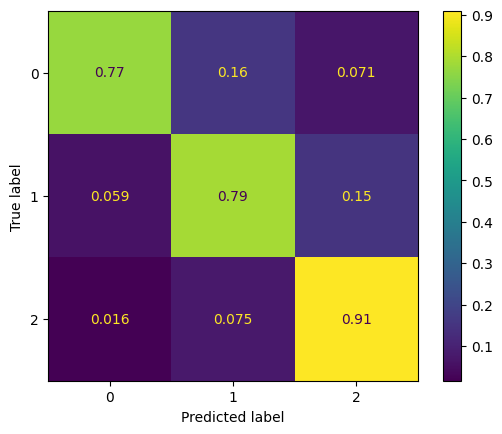

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.42850. Saving Model!
epoch 01, loss: 0.52236, acc: 0.78313, val_loss: 0.42850, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 02, loss: 0.51456, acc: 0.78797, val_loss: 0.43392, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 03, loss: 0.52048, acc: 0.78492, val_loss: 0.43538, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 04, loss: 0.51306, acc: 0.78649, val_loss: 0.43769, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 05, loss: 0.51477, acc: 0.78616, val_loss: 0.43770, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 06, loss: 0.51155, acc: 0.78655, val_loss: 0.43830, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 07, loss: 0.51056, acc: 0.78695, val_loss: 0.43925, val_accuracy: 0.82980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 08, loss: 0.51120, acc: 0.78507, val_loss: 0.43948, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 09, loss: 0.50885, acc: 0.78730, val_loss: 0.44085, val_accuracy: 0.82980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 10, loss: 0.50884, acc: 0.78804, val_loss: 0.44202, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 11, loss: 0.50782, acc: 0.78863, val_loss: 0.44237, val_accuracy: 0.82960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 12, loss: 0.50712, acc: 0.78893, val_loss: 0.44263, val_accuracy: 0.82921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 13, loss: 0.50624, acc: 0.78924, val_loss: 0.44306, val_accuracy: 0.82921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 14, loss: 0.50642, acc: 0.79015, val_loss: 0.44343, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 15, loss: 0.50522, acc: 0.79057, val_loss: 0.44421, val_accuracy: 0.82803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 16, loss: 0.50513, acc: 0.79024, val_loss: 0.44461, val_accuracy: 0.82784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 17, loss: 0.50425, acc: 0.79098, val_loss: 0.44491, val_accuracy: 0.82705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 18, loss: 0.50433, acc: 0.78983, val_loss: 0.44543, val_accuracy: 0.82686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 19, loss: 0.50354, acc: 0.79135, val_loss: 0.44589, val_accuracy: 0.82646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 20, loss: 0.50330, acc: 0.79103, val_loss: 0.44612, val_accuracy: 0.82725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 21, loss: 0.50271, acc: 0.79214, val_loss: 0.44641, val_accuracy: 0.82725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 22, loss: 0.50246, acc: 0.79218, val_loss: 0.44687, val_accuracy: 0.82686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 23, loss: 0.50172, acc: 0.79303, val_loss: 0.44727, val_accuracy: 0.82352


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 24, loss: 0.50193, acc: 0.79242, val_loss: 0.44758, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 25, loss: 0.50096, acc: 0.79281, val_loss: 0.44801, val_accuracy: 0.82332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 26, loss: 0.50102, acc: 0.79321, val_loss: 0.44808, val_accuracy: 0.82332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 27, loss: 0.50025, acc: 0.79345, val_loss: 0.44853, val_accuracy: 0.82352


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 28, loss: 0.50053, acc: 0.79297, val_loss: 0.44853, val_accuracy: 0.82214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 29, loss: 0.49948, acc: 0.79415, val_loss: 0.44932, val_accuracy: 0.82391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 30, loss: 0.49963, acc: 0.79410, val_loss: 0.44924, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 31, loss: 0.49897, acc: 0.79415, val_loss: 0.44980, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 32, loss: 0.49887, acc: 0.79452, val_loss: 0.44999, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 33, loss: 0.49838, acc: 0.79439, val_loss: 0.45012, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 34, loss: 0.49842, acc: 0.79493, val_loss: 0.45024, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 35, loss: 0.49743, acc: 0.79441, val_loss: 0.45099, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 36, loss: 0.49794, acc: 0.79445, val_loss: 0.45081, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 37, loss: 0.49698, acc: 0.79489, val_loss: 0.45103, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 38, loss: 0.49722, acc: 0.79532, val_loss: 0.45143, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 39, loss: 0.49653, acc: 0.79484, val_loss: 0.45183, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 40, loss: 0.49678, acc: 0.79511, val_loss: 0.45174, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 41, loss: 0.49563, acc: 0.79565, val_loss: 0.45198, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 42, loss: 0.49641, acc: 0.79563, val_loss: 0.45237, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 43, loss: 0.49500, acc: 0.79611, val_loss: 0.45260, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 44, loss: 0.49565, acc: 0.79617, val_loss: 0.45293, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 45, loss: 0.49495, acc: 0.79598, val_loss: 0.45280, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 46, loss: 0.49496, acc: 0.79609, val_loss: 0.45315, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 47, loss: 0.49426, acc: 0.79661, val_loss: 0.45339, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 48, loss: 0.49442, acc: 0.79648, val_loss: 0.45359, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 49, loss: 0.49384, acc: 0.79678, val_loss: 0.45396, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 50, loss: 0.49368, acc: 0.79646, val_loss: 0.45397, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 51, loss: 0.49332, acc: 0.79665, val_loss: 0.45420, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 52, loss: 0.49328, acc: 0.79705, val_loss: 0.45426, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 53, loss: 0.49277, acc: 0.79670, val_loss: 0.45457, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 54, loss: 0.49269, acc: 0.79726, val_loss: 0.45464, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 55, loss: 0.49202, acc: 0.79761, val_loss: 0.45497, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 56, loss: 0.49269, acc: 0.79761, val_loss: 0.45489, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 57, loss: 0.49146, acc: 0.79792, val_loss: 0.45520, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 58, loss: 0.49192, acc: 0.79781, val_loss: 0.45540, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 59, loss: 0.49110, acc: 0.79862, val_loss: 0.45567, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 60, loss: 0.49152, acc: 0.79825, val_loss: 0.45555, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 61, loss: 0.49065, acc: 0.79803, val_loss: 0.45614, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 62, loss: 0.49093, acc: 0.79868, val_loss: 0.45593, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 63, loss: 0.49001, acc: 0.79940, val_loss: 0.45659, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 64, loss: 0.49064, acc: 0.79958, val_loss: 0.45621, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 65, loss: 0.48963, acc: 0.79958, val_loss: 0.45654, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 66, loss: 0.49013, acc: 0.79903, val_loss: 0.45687, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 67, loss: 0.48888, acc: 0.79986, val_loss: 0.45693, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 68, loss: 0.49005, acc: 0.79958, val_loss: 0.45670, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 69, loss: 0.48820, acc: 0.79999, val_loss: 0.45742, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 70, loss: 0.48919, acc: 0.80008, val_loss: 0.45713, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 71, loss: 0.48841, acc: 0.79993, val_loss: 0.45748, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 72, loss: 0.48853, acc: 0.80017, val_loss: 0.45726, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 73, loss: 0.48757, acc: 0.80069, val_loss: 0.45764, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 74, loss: 0.48835, acc: 0.80017, val_loss: 0.45773, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 75, loss: 0.48724, acc: 0.80060, val_loss: 0.45785, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 76, loss: 0.48739, acc: 0.80041, val_loss: 0.45806, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 77, loss: 0.48693, acc: 0.80106, val_loss: 0.45834, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 78, loss: 0.48698, acc: 0.80058, val_loss: 0.45818, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 79, loss: 0.48665, acc: 0.80106, val_loss: 0.45850, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 80, loss: 0.48637, acc: 0.80209, val_loss: 0.45855, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 81, loss: 0.48628, acc: 0.80200, val_loss: 0.45858, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 82, loss: 0.48599, acc: 0.80185, val_loss: 0.45892, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 83, loss: 0.48538, acc: 0.80263, val_loss: 0.45916, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 84, loss: 0.48585, acc: 0.80163, val_loss: 0.45911, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 85, loss: 0.48506, acc: 0.80272, val_loss: 0.45926, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 86, loss: 0.48500, acc: 0.80281, val_loss: 0.45915, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 87, loss: 0.48516, acc: 0.80263, val_loss: 0.45936, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 88, loss: 0.48431, acc: 0.80313, val_loss: 0.45974, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 89, loss: 0.48438, acc: 0.80296, val_loss: 0.45958, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 90, loss: 0.48438, acc: 0.80329, val_loss: 0.45964, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 91, loss: 0.48378, acc: 0.80272, val_loss: 0.46020, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 92, loss: 0.48380, acc: 0.80361, val_loss: 0.46010, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 93, loss: 0.48355, acc: 0.80294, val_loss: 0.46009, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 94, loss: 0.48326, acc: 0.80366, val_loss: 0.46026, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 95, loss: 0.48286, acc: 0.80350, val_loss: 0.46062, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 96, loss: 0.48337, acc: 0.80368, val_loss: 0.46058, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 97, loss: 0.48229, acc: 0.80403, val_loss: 0.46071, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


epoch 98, loss: 0.48247, acc: 0.80357, val_loss: 0.46092, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 99, loss: 0.48243, acc: 0.80396, val_loss: 0.46078, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 100, loss: 0.48167, acc: 0.80403, val_loss: 0.46145, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 101, loss: 0.48193, acc: 0.80394, val_loss: 0.46095, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 102, loss: 0.48166, acc: 0.80414, val_loss: 0.46139, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 103, loss: 0.48150, acc: 0.80407, val_loss: 0.46129, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 104, loss: 0.48118, acc: 0.80420, val_loss: 0.46171, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 105, loss: 0.48112, acc: 0.80398, val_loss: 0.46128, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 106, loss: 0.48087, acc: 0.80418, val_loss: 0.46166, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 107, loss: 0.48035, acc: 0.80422, val_loss: 0.46213, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 108, loss: 0.48103, acc: 0.80414, val_loss: 0.46195, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 109, loss: 0.47925, acc: 0.80468, val_loss: 0.46193, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 110, loss: 0.48096, acc: 0.80442, val_loss: 0.46206, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 111, loss: 0.47919, acc: 0.80472, val_loss: 0.46226, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 112, loss: 0.48005, acc: 0.80457, val_loss: 0.46264, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 113, loss: 0.47894, acc: 0.80477, val_loss: 0.46221, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 114, loss: 0.47949, acc: 0.80490, val_loss: 0.46277, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 115, loss: 0.47883, acc: 0.80492, val_loss: 0.46235, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 116, loss: 0.47880, acc: 0.80505, val_loss: 0.46302, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 117, loss: 0.47860, acc: 0.80503, val_loss: 0.46258, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 118, loss: 0.47836, acc: 0.80505, val_loss: 0.46316, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 119, loss: 0.47803, acc: 0.80518, val_loss: 0.46270, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 120, loss: 0.47800, acc: 0.80544, val_loss: 0.46325, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 121, loss: 0.47769, acc: 0.80531, val_loss: 0.46311, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 122, loss: 0.47747, acc: 0.80523, val_loss: 0.46344, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 123, loss: 0.47717, acc: 0.80582, val_loss: 0.46325, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 124, loss: 0.47722, acc: 0.80534, val_loss: 0.46331, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 125, loss: 0.47666, acc: 0.80590, val_loss: 0.46375, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 126, loss: 0.47679, acc: 0.80590, val_loss: 0.46386, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 127, loss: 0.47638, acc: 0.80614, val_loss: 0.46345, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 128, loss: 0.47643, acc: 0.80614, val_loss: 0.46365, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 129, loss: 0.47596, acc: 0.80647, val_loss: 0.46419, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 130, loss: 0.47571, acc: 0.80671, val_loss: 0.46414, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 131, loss: 0.47611, acc: 0.80638, val_loss: 0.46390, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 132, loss: 0.47538, acc: 0.80680, val_loss: 0.46431, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 133, loss: 0.47523, acc: 0.80695, val_loss: 0.46431, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 134, loss: 0.47512, acc: 0.80695, val_loss: 0.46444, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 135, loss: 0.47512, acc: 0.80667, val_loss: 0.46404, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 136, loss: 0.47460, acc: 0.80669, val_loss: 0.46480, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 137, loss: 0.47466, acc: 0.80747, val_loss: 0.46475, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 138, loss: 0.47442, acc: 0.80643, val_loss: 0.46466, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 139, loss: 0.47388, acc: 0.80732, val_loss: 0.46460, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 140, loss: 0.47410, acc: 0.80712, val_loss: 0.46500, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 141, loss: 0.47381, acc: 0.80758, val_loss: 0.46468, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 142, loss: 0.47330, acc: 0.80741, val_loss: 0.46541, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 143, loss: 0.47342, acc: 0.80774, val_loss: 0.46511, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 144, loss: 0.47352, acc: 0.80723, val_loss: 0.46526, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 145, loss: 0.47262, acc: 0.80791, val_loss: 0.46508, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 146, loss: 0.47292, acc: 0.80771, val_loss: 0.46541, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 147, loss: 0.47244, acc: 0.80800, val_loss: 0.46553, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 148, loss: 0.47286, acc: 0.80830, val_loss: 0.46566, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 149, loss: 0.47190, acc: 0.80813, val_loss: 0.46499, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 150, loss: 0.47237, acc: 0.80691, val_loss: 0.46576, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 151, loss: 0.47157, acc: 0.80848, val_loss: 0.46548, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 152, loss: 0.47219, acc: 0.80872, val_loss: 0.46622, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 153, loss: 0.47086, acc: 0.80959, val_loss: 0.46581, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 154, loss: 0.47199, acc: 0.80752, val_loss: 0.46587, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 155, loss: 0.47060, acc: 0.80893, val_loss: 0.46593, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 156, loss: 0.47095, acc: 0.80874, val_loss: 0.46670, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 157, loss: 0.47097, acc: 0.80784, val_loss: 0.46556, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 158, loss: 0.47045, acc: 0.80941, val_loss: 0.46643, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 159, loss: 0.47004, acc: 0.81007, val_loss: 0.46627, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 160, loss: 0.47034, acc: 0.80957, val_loss: 0.46653, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 161, loss: 0.47015, acc: 0.80961, val_loss: 0.46615, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 162, loss: 0.46947, acc: 0.80994, val_loss: 0.46666, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 163, loss: 0.46986, acc: 0.80891, val_loss: 0.46640, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 164, loss: 0.46942, acc: 0.81009, val_loss: 0.46663, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 165, loss: 0.46912, acc: 0.81009, val_loss: 0.46662, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 166, loss: 0.46926, acc: 0.80976, val_loss: 0.46664, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 167, loss: 0.46899, acc: 0.81061, val_loss: 0.46676, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 168, loss: 0.46819, acc: 0.80974, val_loss: 0.46712, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 169, loss: 0.46925, acc: 0.80944, val_loss: 0.46686, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 170, loss: 0.46770, acc: 0.81053, val_loss: 0.46728, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 171, loss: 0.46892, acc: 0.81009, val_loss: 0.46713, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 172, loss: 0.46757, acc: 0.81037, val_loss: 0.46714, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 173, loss: 0.46833, acc: 0.81048, val_loss: 0.46784, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 174, loss: 0.46739, acc: 0.81075, val_loss: 0.46709, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 175, loss: 0.46808, acc: 0.81079, val_loss: 0.46742, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 176, loss: 0.46653, acc: 0.81120, val_loss: 0.46764, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 177, loss: 0.46768, acc: 0.81059, val_loss: 0.46764, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 178, loss: 0.46642, acc: 0.81160, val_loss: 0.46749, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 179, loss: 0.46727, acc: 0.81105, val_loss: 0.46764, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 180, loss: 0.46627, acc: 0.81175, val_loss: 0.46741, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 181, loss: 0.46652, acc: 0.81127, val_loss: 0.46855, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 182, loss: 0.46637, acc: 0.81144, val_loss: 0.46740, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 183, loss: 0.46580, acc: 0.81192, val_loss: 0.46803, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 184, loss: 0.46574, acc: 0.81208, val_loss: 0.46827, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 185, loss: 0.46585, acc: 0.81184, val_loss: 0.46822, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 186, loss: 0.46544, acc: 0.81210, val_loss: 0.46773, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 187, loss: 0.46534, acc: 0.81223, val_loss: 0.46820, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 188, loss: 0.46458, acc: 0.81229, val_loss: 0.46847, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 189, loss: 0.46559, acc: 0.81195, val_loss: 0.46780, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 190, loss: 0.46434, acc: 0.81214, val_loss: 0.46830, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 191, loss: 0.46512, acc: 0.81229, val_loss: 0.46865, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 192, loss: 0.46426, acc: 0.81249, val_loss: 0.46818, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 193, loss: 0.46487, acc: 0.81284, val_loss: 0.46898, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 194, loss: 0.46355, acc: 0.81266, val_loss: 0.46885, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 195, loss: 0.46450, acc: 0.81240, val_loss: 0.46872, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 196, loss: 0.46342, acc: 0.81306, val_loss: 0.46871, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 197, loss: 0.46377, acc: 0.81349, val_loss: 0.46918, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 198, loss: 0.46322, acc: 0.81234, val_loss: 0.46856, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 199, loss: 0.46330, acc: 0.81299, val_loss: 0.46887, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 200, loss: 0.46267, acc: 0.81395, val_loss: 0.46919, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 201, loss: 0.46313, acc: 0.81317, val_loss: 0.46913, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 202, loss: 0.46250, acc: 0.81330, val_loss: 0.46912, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 203, loss: 0.46244, acc: 0.81347, val_loss: 0.46926, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 204, loss: 0.46246, acc: 0.81358, val_loss: 0.46871, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 205, loss: 0.46235, acc: 0.81362, val_loss: 0.46950, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 206, loss: 0.46174, acc: 0.81461, val_loss: 0.46982, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 207, loss: 0.46239, acc: 0.81345, val_loss: 0.46931, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 208, loss: 0.46119, acc: 0.81419, val_loss: 0.46947, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 209, loss: 0.46183, acc: 0.81443, val_loss: 0.46967, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 210, loss: 0.46093, acc: 0.81402, val_loss: 0.46951, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 211, loss: 0.46179, acc: 0.81469, val_loss: 0.46973, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 212, loss: 0.46075, acc: 0.81504, val_loss: 0.46970, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 213, loss: 0.46118, acc: 0.81415, val_loss: 0.47015, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 214, loss: 0.46043, acc: 0.81367, val_loss: 0.46903, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 215, loss: 0.46066, acc: 0.81493, val_loss: 0.47015, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 216, loss: 0.46022, acc: 0.81563, val_loss: 0.47010, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 217, loss: 0.46016, acc: 0.81581, val_loss: 0.47022, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 218, loss: 0.45991, acc: 0.81563, val_loss: 0.47001, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 219, loss: 0.45975, acc: 0.81602, val_loss: 0.47003, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 220, loss: 0.45962, acc: 0.81526, val_loss: 0.47020, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 221, loss: 0.45929, acc: 0.81642, val_loss: 0.47045, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 222, loss: 0.45943, acc: 0.81506, val_loss: 0.47008, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 223, loss: 0.45886, acc: 0.81687, val_loss: 0.47022, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 224, loss: 0.45900, acc: 0.81622, val_loss: 0.47059, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 225, loss: 0.45871, acc: 0.81670, val_loss: 0.47072, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 226, loss: 0.45853, acc: 0.81759, val_loss: 0.47067, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 227, loss: 0.45866, acc: 0.81578, val_loss: 0.47038, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 228, loss: 0.45774, acc: 0.81882, val_loss: 0.47091, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 229, loss: 0.45828, acc: 0.81770, val_loss: 0.47072, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 230, loss: 0.45770, acc: 0.81827, val_loss: 0.47073, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 231, loss: 0.45810, acc: 0.81786, val_loss: 0.47082, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 232, loss: 0.45733, acc: 0.81855, val_loss: 0.47105, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 233, loss: 0.45751, acc: 0.81770, val_loss: 0.47097, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 234, loss: 0.45740, acc: 0.81716, val_loss: 0.47094, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 235, loss: 0.45693, acc: 0.81849, val_loss: 0.47110, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 236, loss: 0.45690, acc: 0.81805, val_loss: 0.47148, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 237, loss: 0.45684, acc: 0.81849, val_loss: 0.47051, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 238, loss: 0.45648, acc: 0.81810, val_loss: 0.47156, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 239, loss: 0.45654, acc: 0.81925, val_loss: 0.47134, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 240, loss: 0.45617, acc: 0.81956, val_loss: 0.47131, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 241, loss: 0.45604, acc: 0.81762, val_loss: 0.47110, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 242, loss: 0.45596, acc: 0.81947, val_loss: 0.47167, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 243, loss: 0.45540, acc: 0.82045, val_loss: 0.47153, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 244, loss: 0.45579, acc: 0.81749, val_loss: 0.47129, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 245, loss: 0.45530, acc: 0.81890, val_loss: 0.47153, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 246, loss: 0.45506, acc: 0.81897, val_loss: 0.47225, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 247, loss: 0.45537, acc: 0.81879, val_loss: 0.47166, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 248, loss: 0.45473, acc: 0.81849, val_loss: 0.47194, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 249, loss: 0.45504, acc: 0.81862, val_loss: 0.47199, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 250, loss: 0.45416, acc: 0.81986, val_loss: 0.47190, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 251, loss: 0.45477, acc: 0.81986, val_loss: 0.47216, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 252, loss: 0.45390, acc: 0.81973, val_loss: 0.47192, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 253, loss: 0.45430, acc: 0.82076, val_loss: 0.47206, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 254, loss: 0.45357, acc: 0.81923, val_loss: 0.47205, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 255, loss: 0.45442, acc: 0.82006, val_loss: 0.47223, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 256, loss: 0.45283, acc: 0.82074, val_loss: 0.47245, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 257, loss: 0.45455, acc: 0.82043, val_loss: 0.47216, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 258, loss: 0.45224, acc: 0.82071, val_loss: 0.47256, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 259, loss: 0.45429, acc: 0.82098, val_loss: 0.47278, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 260, loss: 0.45195, acc: 0.82137, val_loss: 0.47229, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 261, loss: 0.45400, acc: 0.82113, val_loss: 0.47250, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 262, loss: 0.45136, acc: 0.81991, val_loss: 0.47258, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 263, loss: 0.45391, acc: 0.82037, val_loss: 0.47235, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 264, loss: 0.45069, acc: 0.82213, val_loss: 0.47320, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 265, loss: 0.45333, acc: 0.82013, val_loss: 0.47257, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 266, loss: 0.45133, acc: 0.82034, val_loss: 0.47292, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 267, loss: 0.45218, acc: 0.82065, val_loss: 0.47234, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 268, loss: 0.45120, acc: 0.82200, val_loss: 0.47333, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 269, loss: 0.45190, acc: 0.82146, val_loss: 0.47252, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 270, loss: 0.45109, acc: 0.82174, val_loss: 0.47340, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 271, loss: 0.45115, acc: 0.82276, val_loss: 0.47272, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 272, loss: 0.45109, acc: 0.82194, val_loss: 0.47307, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 273, loss: 0.45092, acc: 0.82137, val_loss: 0.47278, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 274, loss: 0.45066, acc: 0.82270, val_loss: 0.47358, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 275, loss: 0.45077, acc: 0.82189, val_loss: 0.47284, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 276, loss: 0.45054, acc: 0.82276, val_loss: 0.47332, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 277, loss: 0.44965, acc: 0.82235, val_loss: 0.47315, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 278, loss: 0.45073, acc: 0.82329, val_loss: 0.47321, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 279, loss: 0.44924, acc: 0.82237, val_loss: 0.47352, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 280, loss: 0.45053, acc: 0.82279, val_loss: 0.47348, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 281, loss: 0.44855, acc: 0.82279, val_loss: 0.47364, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 282, loss: 0.45075, acc: 0.82279, val_loss: 0.47309, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 283, loss: 0.44795, acc: 0.82405, val_loss: 0.47416, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 284, loss: 0.45034, acc: 0.82224, val_loss: 0.47358, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 285, loss: 0.44805, acc: 0.82379, val_loss: 0.47366, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 286, loss: 0.44940, acc: 0.82224, val_loss: 0.47344, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 287, loss: 0.44813, acc: 0.82464, val_loss: 0.47407, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 288, loss: 0.44882, acc: 0.82290, val_loss: 0.47362, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 289, loss: 0.44820, acc: 0.82405, val_loss: 0.47435, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 290, loss: 0.44791, acc: 0.82266, val_loss: 0.47350, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 291, loss: 0.44809, acc: 0.82458, val_loss: 0.47439, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 292, loss: 0.44781, acc: 0.82272, val_loss: 0.47371, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 293, loss: 0.44781, acc: 0.82575, val_loss: 0.47421, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 294, loss: 0.44720, acc: 0.82338, val_loss: 0.47431, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 295, loss: 0.44803, acc: 0.82473, val_loss: 0.47361, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 296, loss: 0.44656, acc: 0.82455, val_loss: 0.47426, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 297, loss: 0.44765, acc: 0.82501, val_loss: 0.47391, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 298, loss: 0.44653, acc: 0.82523, val_loss: 0.47427, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 299, loss: 0.44737, acc: 0.82416, val_loss: 0.47477, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 300, loss: 0.44585, acc: 0.82414, val_loss: 0.47440, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 301, loss: 0.44760, acc: 0.82379, val_loss: 0.47415, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 302, loss: 0.44555, acc: 0.82567, val_loss: 0.47436, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 303, loss: 0.44669, acc: 0.82348, val_loss: 0.47517, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 304, loss: 0.44561, acc: 0.82575, val_loss: 0.47436, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 305, loss: 0.44626, acc: 0.82543, val_loss: 0.47472, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 306, loss: 0.44523, acc: 0.82684, val_loss: 0.47464, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 307, loss: 0.44620, acc: 0.82538, val_loss: 0.47539, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 308, loss: 0.44528, acc: 0.82573, val_loss: 0.47484, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 309, loss: 0.44519, acc: 0.82519, val_loss: 0.47483, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 310, loss: 0.44499, acc: 0.82608, val_loss: 0.47467, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 311, loss: 0.44520, acc: 0.82577, val_loss: 0.47543, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 312, loss: 0.44407, acc: 0.82743, val_loss: 0.47537, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 313, loss: 0.44524, acc: 0.82564, val_loss: 0.47500, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 314, loss: 0.44391, acc: 0.82671, val_loss: 0.47542, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 315, loss: 0.44446, acc: 0.82551, val_loss: 0.47526, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 316, loss: 0.44397, acc: 0.82743, val_loss: 0.47556, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 317, loss: 0.44397, acc: 0.82643, val_loss: 0.47486, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 318, loss: 0.44383, acc: 0.82745, val_loss: 0.47558, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 319, loss: 0.44297, acc: 0.82649, val_loss: 0.47589, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 320, loss: 0.44418, acc: 0.82647, val_loss: 0.47528, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 321, loss: 0.44247, acc: 0.82756, val_loss: 0.47571, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 322, loss: 0.44352, acc: 0.82804, val_loss: 0.47554, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 323, loss: 0.44282, acc: 0.82658, val_loss: 0.47548, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 324, loss: 0.44290, acc: 0.82767, val_loss: 0.47596, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 325, loss: 0.44205, acc: 0.82745, val_loss: 0.47559, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 326, loss: 0.44326, acc: 0.82778, val_loss: 0.47588, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 327, loss: 0.44159, acc: 0.82726, val_loss: 0.47572, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 328, loss: 0.44293, acc: 0.82702, val_loss: 0.47583, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 329, loss: 0.44138, acc: 0.82831, val_loss: 0.47599, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 330, loss: 0.44313, acc: 0.82776, val_loss: 0.47624, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 331, loss: 0.44039, acc: 0.82772, val_loss: 0.47603, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 332, loss: 0.44355, acc: 0.82673, val_loss: 0.47544, val_accuracy: 0.81802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 333, loss: 0.43988, acc: 0.82837, val_loss: 0.47683, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 334, loss: 0.44298, acc: 0.82822, val_loss: 0.47591, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 335, loss: 0.43996, acc: 0.82850, val_loss: 0.47574, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 336, loss: 0.44228, acc: 0.82826, val_loss: 0.47606, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 337, loss: 0.43977, acc: 0.82889, val_loss: 0.47628, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 338, loss: 0.44226, acc: 0.82743, val_loss: 0.47615, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


epoch 339, loss: 0.43962, acc: 0.82876, val_loss: 0.47618, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 340, loss: 0.44148, acc: 0.82846, val_loss: 0.47578, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 341, loss: 0.43936, acc: 0.82889, val_loss: 0.47670, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 342, loss: 0.44132, acc: 0.82833, val_loss: 0.47680, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 343, loss: 0.43904, acc: 0.82929, val_loss: 0.47578, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 344, loss: 0.44085, acc: 0.82776, val_loss: 0.47622, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 345, loss: 0.43879, acc: 0.82929, val_loss: 0.47606, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 346, loss: 0.44026, acc: 0.82896, val_loss: 0.47680, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 347, loss: 0.43891, acc: 0.82909, val_loss: 0.47627, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 348, loss: 0.43959, acc: 0.82913, val_loss: 0.47662, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 349, loss: 0.43834, acc: 0.82953, val_loss: 0.47685, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 350, loss: 0.43963, acc: 0.82889, val_loss: 0.47666, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 351, loss: 0.43802, acc: 0.82961, val_loss: 0.47650, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 352, loss: 0.43895, acc: 0.82881, val_loss: 0.47659, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 353, loss: 0.43770, acc: 0.82944, val_loss: 0.47697, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 354, loss: 0.43871, acc: 0.82951, val_loss: 0.47692, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 355, loss: 0.43781, acc: 0.82903, val_loss: 0.47655, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 356, loss: 0.43799, acc: 0.82959, val_loss: 0.47718, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 357, loss: 0.43730, acc: 0.82927, val_loss: 0.47656, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 358, loss: 0.43855, acc: 0.82892, val_loss: 0.47728, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 359, loss: 0.43674, acc: 0.83007, val_loss: 0.47679, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 360, loss: 0.43826, acc: 0.82983, val_loss: 0.47751, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 361, loss: 0.43639, acc: 0.82940, val_loss: 0.47648, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 362, loss: 0.43814, acc: 0.83020, val_loss: 0.47751, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 363, loss: 0.43587, acc: 0.82968, val_loss: 0.47742, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 364, loss: 0.43810, acc: 0.82979, val_loss: 0.47733, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 365, loss: 0.43525, acc: 0.83055, val_loss: 0.47765, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 366, loss: 0.43765, acc: 0.82948, val_loss: 0.47690, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 367, loss: 0.43525, acc: 0.83084, val_loss: 0.47736, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 368, loss: 0.43700, acc: 0.83060, val_loss: 0.47800, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 369, loss: 0.43557, acc: 0.83134, val_loss: 0.47722, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 370, loss: 0.43631, acc: 0.83055, val_loss: 0.47769, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 371, loss: 0.43505, acc: 0.83190, val_loss: 0.47730, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 372, loss: 0.43597, acc: 0.83066, val_loss: 0.47803, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 373, loss: 0.43500, acc: 0.83177, val_loss: 0.47730, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 374, loss: 0.43562, acc: 0.83110, val_loss: 0.47802, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 375, loss: 0.43463, acc: 0.83188, val_loss: 0.47781, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 376, loss: 0.43526, acc: 0.83195, val_loss: 0.47835, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 377, loss: 0.43480, acc: 0.83118, val_loss: 0.47689, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 378, loss: 0.43458, acc: 0.83210, val_loss: 0.47907, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 379, loss: 0.43497, acc: 0.83149, val_loss: 0.47682, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 380, loss: 0.43422, acc: 0.83208, val_loss: 0.47868, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 381, loss: 0.43430, acc: 0.83208, val_loss: 0.47745, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 382, loss: 0.43454, acc: 0.83230, val_loss: 0.47883, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 383, loss: 0.43366, acc: 0.83156, val_loss: 0.47771, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 384, loss: 0.43409, acc: 0.83214, val_loss: 0.47823, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 385, loss: 0.43350, acc: 0.83278, val_loss: 0.47822, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 386, loss: 0.43373, acc: 0.83284, val_loss: 0.47860, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 387, loss: 0.43257, acc: 0.83304, val_loss: 0.47829, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 388, loss: 0.43368, acc: 0.83245, val_loss: 0.47888, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 389, loss: 0.43207, acc: 0.83348, val_loss: 0.47882, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 390, loss: 0.43323, acc: 0.83289, val_loss: 0.47896, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 391, loss: 0.43255, acc: 0.83245, val_loss: 0.47848, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 392, loss: 0.43231, acc: 0.83295, val_loss: 0.47905, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 393, loss: 0.43249, acc: 0.83358, val_loss: 0.47811, val_accuracy: 0.82077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 394, loss: 0.43183, acc: 0.83343, val_loss: 0.47937, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 395, loss: 0.43236, acc: 0.83330, val_loss: 0.47897, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 396, loss: 0.43183, acc: 0.83352, val_loss: 0.47951, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 397, loss: 0.43184, acc: 0.83343, val_loss: 0.47909, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 398, loss: 0.43228, acc: 0.83282, val_loss: 0.47883, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 399, loss: 0.43062, acc: 0.83387, val_loss: 0.47936, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 400, loss: 0.43205, acc: 0.83411, val_loss: 0.47889, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 401, loss: 0.43043, acc: 0.83385, val_loss: 0.47947, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 402, loss: 0.43156, acc: 0.83385, val_loss: 0.47913, val_accuracy: 0.82097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 403, loss: 0.43027, acc: 0.83428, val_loss: 0.47983, val_accuracy: 0.82097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 404, loss: 0.43115, acc: 0.83411, val_loss: 0.47886, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 405, loss: 0.43036, acc: 0.83393, val_loss: 0.47894, val_accuracy: 0.82155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 406, loss: 0.43063, acc: 0.83428, val_loss: 0.48024, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 407, loss: 0.43022, acc: 0.83450, val_loss: 0.47912, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 408, loss: 0.43058, acc: 0.83430, val_loss: 0.47994, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 409, loss: 0.42948, acc: 0.83465, val_loss: 0.47882, val_accuracy: 0.82077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 410, loss: 0.43065, acc: 0.83422, val_loss: 0.47982, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 411, loss: 0.42895, acc: 0.83470, val_loss: 0.47941, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 412, loss: 0.43018, acc: 0.83417, val_loss: 0.48017, val_accuracy: 0.82136


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 413, loss: 0.42871, acc: 0.83513, val_loss: 0.47930, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 414, loss: 0.43030, acc: 0.83413, val_loss: 0.47969, val_accuracy: 0.82136


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 415, loss: 0.42836, acc: 0.83505, val_loss: 0.47993, val_accuracy: 0.82097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 416, loss: 0.42998, acc: 0.83496, val_loss: 0.48019, val_accuracy: 0.82077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 417, loss: 0.42856, acc: 0.83461, val_loss: 0.47927, val_accuracy: 0.82097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 418, loss: 0.42976, acc: 0.83502, val_loss: 0.48084, val_accuracy: 0.82077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 419, loss: 0.42779, acc: 0.83559, val_loss: 0.47947, val_accuracy: 0.82175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 420, loss: 0.42970, acc: 0.83437, val_loss: 0.47995, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 421, loss: 0.42708, acc: 0.83563, val_loss: 0.47992, val_accuracy: 0.82175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 422, loss: 0.42976, acc: 0.83500, val_loss: 0.47986, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 423, loss: 0.42660, acc: 0.83553, val_loss: 0.48013, val_accuracy: 0.82175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 424, loss: 0.42964, acc: 0.83500, val_loss: 0.47973, val_accuracy: 0.82214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 425, loss: 0.42603, acc: 0.83550, val_loss: 0.48053, val_accuracy: 0.82155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 426, loss: 0.43005, acc: 0.83511, val_loss: 0.47988, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 427, loss: 0.42544, acc: 0.83555, val_loss: 0.48047, val_accuracy: 0.82254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 428, loss: 0.42969, acc: 0.83502, val_loss: 0.47952, val_accuracy: 0.82155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 429, loss: 0.42513, acc: 0.83601, val_loss: 0.48040, val_accuracy: 0.82175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 430, loss: 0.42991, acc: 0.83526, val_loss: 0.47972, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 431, loss: 0.42461, acc: 0.83642, val_loss: 0.48125, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 432, loss: 0.42924, acc: 0.83548, val_loss: 0.47966, val_accuracy: 0.82254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 433, loss: 0.42490, acc: 0.83598, val_loss: 0.48060, val_accuracy: 0.82155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 434, loss: 0.42866, acc: 0.83550, val_loss: 0.48038, val_accuracy: 0.82136


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 435, loss: 0.42489, acc: 0.83581, val_loss: 0.48034, val_accuracy: 0.82195


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.03it/s]


epoch 436, loss: 0.42757, acc: 0.83611, val_loss: 0.48060, val_accuracy: 0.82273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 437, loss: 0.42452, acc: 0.83681, val_loss: 0.47978, val_accuracy: 0.82195


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 438, loss: 0.42755, acc: 0.83555, val_loss: 0.48041, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 439, loss: 0.42436, acc: 0.83670, val_loss: 0.48067, val_accuracy: 0.82175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 440, loss: 0.42677, acc: 0.83570, val_loss: 0.48072, val_accuracy: 0.82293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 441, loss: 0.42466, acc: 0.83633, val_loss: 0.47972, val_accuracy: 0.82214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 442, loss: 0.42622, acc: 0.83618, val_loss: 0.48056, val_accuracy: 0.82254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 443, loss: 0.42416, acc: 0.83664, val_loss: 0.48081, val_accuracy: 0.82155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 444, loss: 0.42630, acc: 0.83603, val_loss: 0.48054, val_accuracy: 0.82214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 445, loss: 0.42375, acc: 0.83614, val_loss: 0.48055, val_accuracy: 0.82254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 446, loss: 0.42565, acc: 0.83596, val_loss: 0.48035, val_accuracy: 0.82293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 447, loss: 0.42416, acc: 0.83657, val_loss: 0.48028, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 448, loss: 0.42503, acc: 0.83655, val_loss: 0.48141, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 449, loss: 0.42361, acc: 0.83657, val_loss: 0.48040, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 450, loss: 0.42506, acc: 0.83649, val_loss: 0.48073, val_accuracy: 0.82273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 451, loss: 0.42307, acc: 0.83699, val_loss: 0.48071, val_accuracy: 0.82254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 452, loss: 0.42517, acc: 0.83659, val_loss: 0.48147, val_accuracy: 0.82195


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 453, loss: 0.42243, acc: 0.83725, val_loss: 0.48072, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 454, loss: 0.42518, acc: 0.83644, val_loss: 0.48116, val_accuracy: 0.82313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 455, loss: 0.42172, acc: 0.83734, val_loss: 0.48138, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 456, loss: 0.42507, acc: 0.83651, val_loss: 0.48074, val_accuracy: 0.82273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 457, loss: 0.42156, acc: 0.83701, val_loss: 0.48189, val_accuracy: 0.82234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 458, loss: 0.42440, acc: 0.83688, val_loss: 0.48134, val_accuracy: 0.82332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 459, loss: 0.42172, acc: 0.83707, val_loss: 0.48152, val_accuracy: 0.82254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 460, loss: 0.42360, acc: 0.83723, val_loss: 0.48142, val_accuracy: 0.82273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 461, loss: 0.42178, acc: 0.83769, val_loss: 0.48134, val_accuracy: 0.82371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 462, loss: 0.42356, acc: 0.83725, val_loss: 0.48176, val_accuracy: 0.82371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 463, loss: 0.42148, acc: 0.83734, val_loss: 0.48158, val_accuracy: 0.82332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 464, loss: 0.42380, acc: 0.83734, val_loss: 0.48198, val_accuracy: 0.82273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 465, loss: 0.42082, acc: 0.83793, val_loss: 0.48155, val_accuracy: 0.82332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 466, loss: 0.42315, acc: 0.83716, val_loss: 0.48141, val_accuracy: 0.82352


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 467, loss: 0.42052, acc: 0.83782, val_loss: 0.48183, val_accuracy: 0.82450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


epoch 468, loss: 0.42252, acc: 0.83731, val_loss: 0.48185, val_accuracy: 0.82371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 469, loss: 0.42038, acc: 0.83740, val_loss: 0.48222, val_accuracy: 0.82391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 470, loss: 0.42253, acc: 0.83747, val_loss: 0.48176, val_accuracy: 0.82371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 471, loss: 0.41998, acc: 0.83795, val_loss: 0.48177, val_accuracy: 0.82391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 472, loss: 0.42222, acc: 0.83769, val_loss: 0.48259, val_accuracy: 0.82411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 473, loss: 0.42023, acc: 0.83836, val_loss: 0.48199, val_accuracy: 0.82391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 474, loss: 0.42207, acc: 0.83806, val_loss: 0.48212, val_accuracy: 0.82293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 475, loss: 0.41952, acc: 0.83836, val_loss: 0.48241, val_accuracy: 0.82450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 476, loss: 0.42265, acc: 0.83799, val_loss: 0.48252, val_accuracy: 0.82293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 477, loss: 0.41851, acc: 0.83910, val_loss: 0.48286, val_accuracy: 0.82391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 478, loss: 0.42266, acc: 0.83801, val_loss: 0.48179, val_accuracy: 0.82509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 479, loss: 0.41774, acc: 0.83875, val_loss: 0.48296, val_accuracy: 0.82352


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 480, loss: 0.42237, acc: 0.83803, val_loss: 0.48261, val_accuracy: 0.82450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 481, loss: 0.41779, acc: 0.83891, val_loss: 0.48276, val_accuracy: 0.82371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 482, loss: 0.42161, acc: 0.83806, val_loss: 0.48276, val_accuracy: 0.82528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 483, loss: 0.41786, acc: 0.83910, val_loss: 0.48273, val_accuracy: 0.82450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 484, loss: 0.42112, acc: 0.83825, val_loss: 0.48253, val_accuracy: 0.82470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 485, loss: 0.41798, acc: 0.83921, val_loss: 0.48285, val_accuracy: 0.82568


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 486, loss: 0.42078, acc: 0.83882, val_loss: 0.48287, val_accuracy: 0.82391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 487, loss: 0.41754, acc: 0.83960, val_loss: 0.48367, val_accuracy: 0.82548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.05it/s]


epoch 488, loss: 0.42037, acc: 0.83873, val_loss: 0.48241, val_accuracy: 0.82509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 489, loss: 0.41753, acc: 0.83917, val_loss: 0.48318, val_accuracy: 0.82489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 490, loss: 0.42026, acc: 0.83880, val_loss: 0.48279, val_accuracy: 0.82509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 491, loss: 0.41658, acc: 0.84028, val_loss: 0.48379, val_accuracy: 0.82548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 492, loss: 0.42035, acc: 0.83825, val_loss: 0.48221, val_accuracy: 0.82528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 493, loss: 0.41656, acc: 0.83934, val_loss: 0.48347, val_accuracy: 0.82568


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 494, loss: 0.41990, acc: 0.83934, val_loss: 0.48316, val_accuracy: 0.82411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 495, loss: 0.41630, acc: 0.84006, val_loss: 0.48397, val_accuracy: 0.82627


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 496, loss: 0.41948, acc: 0.83910, val_loss: 0.48234, val_accuracy: 0.82587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 497, loss: 0.41587, acc: 0.83958, val_loss: 0.48372, val_accuracy: 0.82568


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 498, loss: 0.41978, acc: 0.83897, val_loss: 0.48313, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 499, loss: 0.41522, acc: 0.84028, val_loss: 0.48398, val_accuracy: 0.82587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 500, loss: 0.41923, acc: 0.83906, val_loss: 0.48269, val_accuracy: 0.82587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 501, loss: 0.41536, acc: 0.84000, val_loss: 0.48349, val_accuracy: 0.82587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 502, loss: 0.41912, acc: 0.83908, val_loss: 0.48353, val_accuracy: 0.82509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 503, loss: 0.41510, acc: 0.84070, val_loss: 0.48348, val_accuracy: 0.82607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 504, loss: 0.41803, acc: 0.83934, val_loss: 0.48317, val_accuracy: 0.82548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 505, loss: 0.41523, acc: 0.84030, val_loss: 0.48317, val_accuracy: 0.82528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 506, loss: 0.41783, acc: 0.83932, val_loss: 0.48382, val_accuracy: 0.82587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 507, loss: 0.41504, acc: 0.84017, val_loss: 0.48371, val_accuracy: 0.82666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 508, loss: 0.41753, acc: 0.83954, val_loss: 0.48387, val_accuracy: 0.82587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 509, loss: 0.41445, acc: 0.84083, val_loss: 0.48344, val_accuracy: 0.82587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 510, loss: 0.41709, acc: 0.83984, val_loss: 0.48355, val_accuracy: 0.82686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 511, loss: 0.41477, acc: 0.83980, val_loss: 0.48314, val_accuracy: 0.82627


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 512, loss: 0.41640, acc: 0.83956, val_loss: 0.48480, val_accuracy: 0.82666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 513, loss: 0.41496, acc: 0.84115, val_loss: 0.48262, val_accuracy: 0.82646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 514, loss: 0.41571, acc: 0.83980, val_loss: 0.48449, val_accuracy: 0.82764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 515, loss: 0.41497, acc: 0.84015, val_loss: 0.48261, val_accuracy: 0.82607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 516, loss: 0.41541, acc: 0.83954, val_loss: 0.48489, val_accuracy: 0.82646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 517, loss: 0.41427, acc: 0.84065, val_loss: 0.48338, val_accuracy: 0.82686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 518, loss: 0.41516, acc: 0.84015, val_loss: 0.48369, val_accuracy: 0.82705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 519, loss: 0.41406, acc: 0.84067, val_loss: 0.48356, val_accuracy: 0.82607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 520, loss: 0.41468, acc: 0.84037, val_loss: 0.48418, val_accuracy: 0.82764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 521, loss: 0.41404, acc: 0.84100, val_loss: 0.48340, val_accuracy: 0.82764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 522, loss: 0.41401, acc: 0.84028, val_loss: 0.48437, val_accuracy: 0.82784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 523, loss: 0.41457, acc: 0.84078, val_loss: 0.48282, val_accuracy: 0.82607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 524, loss: 0.41327, acc: 0.84054, val_loss: 0.48513, val_accuracy: 0.82705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 525, loss: 0.41440, acc: 0.84161, val_loss: 0.48282, val_accuracy: 0.82705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 526, loss: 0.41315, acc: 0.84104, val_loss: 0.48444, val_accuracy: 0.82744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 527, loss: 0.41392, acc: 0.84102, val_loss: 0.48358, val_accuracy: 0.82744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 528, loss: 0.41233, acc: 0.84096, val_loss: 0.48437, val_accuracy: 0.82784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 529, loss: 0.41413, acc: 0.84113, val_loss: 0.48373, val_accuracy: 0.82725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 530, loss: 0.41187, acc: 0.84118, val_loss: 0.48455, val_accuracy: 0.82803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 531, loss: 0.41385, acc: 0.84131, val_loss: 0.48355, val_accuracy: 0.82823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


epoch 532, loss: 0.41136, acc: 0.84163, val_loss: 0.48527, val_accuracy: 0.82744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 533, loss: 0.41423, acc: 0.84102, val_loss: 0.48349, val_accuracy: 0.82784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 534, loss: 0.41081, acc: 0.84157, val_loss: 0.48544, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 535, loss: 0.41412, acc: 0.84100, val_loss: 0.48322, val_accuracy: 0.82764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 536, loss: 0.41039, acc: 0.84161, val_loss: 0.48525, val_accuracy: 0.82862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 537, loss: 0.41400, acc: 0.84122, val_loss: 0.48388, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 538, loss: 0.41031, acc: 0.84183, val_loss: 0.48496, val_accuracy: 0.82784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 539, loss: 0.41350, acc: 0.84139, val_loss: 0.48391, val_accuracy: 0.82862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 540, loss: 0.41015, acc: 0.84179, val_loss: 0.48528, val_accuracy: 0.82823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 541, loss: 0.41297, acc: 0.84139, val_loss: 0.48427, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 542, loss: 0.41012, acc: 0.84198, val_loss: 0.48457, val_accuracy: 0.82764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 543, loss: 0.41244, acc: 0.84139, val_loss: 0.48458, val_accuracy: 0.82862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 544, loss: 0.41007, acc: 0.84222, val_loss: 0.48546, val_accuracy: 0.82823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 545, loss: 0.41199, acc: 0.84172, val_loss: 0.48423, val_accuracy: 0.82803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 546, loss: 0.40982, acc: 0.84216, val_loss: 0.48516, val_accuracy: 0.82862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 547, loss: 0.41159, acc: 0.84168, val_loss: 0.48462, val_accuracy: 0.82823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 548, loss: 0.41000, acc: 0.84222, val_loss: 0.48519, val_accuracy: 0.82764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 549, loss: 0.41084, acc: 0.84181, val_loss: 0.48477, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 550, loss: 0.41000, acc: 0.84218, val_loss: 0.48514, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 551, loss: 0.41093, acc: 0.84207, val_loss: 0.48517, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 552, loss: 0.40991, acc: 0.84233, val_loss: 0.48567, val_accuracy: 0.82803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 553, loss: 0.41050, acc: 0.84253, val_loss: 0.48480, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 554, loss: 0.41002, acc: 0.84266, val_loss: 0.48510, val_accuracy: 0.82862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 555, loss: 0.40964, acc: 0.84231, val_loss: 0.48573, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 556, loss: 0.41039, acc: 0.84222, val_loss: 0.48499, val_accuracy: 0.82823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 557, loss: 0.40865, acc: 0.84340, val_loss: 0.48560, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 558, loss: 0.40998, acc: 0.84240, val_loss: 0.48478, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 559, loss: 0.40881, acc: 0.84259, val_loss: 0.48574, val_accuracy: 0.82803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 560, loss: 0.40973, acc: 0.84253, val_loss: 0.48550, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 561, loss: 0.40828, acc: 0.84279, val_loss: 0.48576, val_accuracy: 0.82803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 562, loss: 0.40979, acc: 0.84244, val_loss: 0.48513, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 563, loss: 0.40828, acc: 0.84325, val_loss: 0.48537, val_accuracy: 0.82862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 564, loss: 0.40973, acc: 0.84281, val_loss: 0.48600, val_accuracy: 0.82803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 565, loss: 0.40827, acc: 0.84331, val_loss: 0.48475, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 566, loss: 0.40889, acc: 0.84312, val_loss: 0.48601, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 567, loss: 0.40780, acc: 0.84318, val_loss: 0.48522, val_accuracy: 0.82960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 568, loss: 0.40943, acc: 0.84262, val_loss: 0.48624, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 569, loss: 0.40700, acc: 0.84327, val_loss: 0.48544, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 570, loss: 0.40883, acc: 0.84288, val_loss: 0.48595, val_accuracy: 0.82980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 571, loss: 0.40731, acc: 0.84336, val_loss: 0.48531, val_accuracy: 0.82823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 572, loss: 0.40842, acc: 0.84277, val_loss: 0.48671, val_accuracy: 0.83019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 573, loss: 0.40703, acc: 0.84373, val_loss: 0.48558, val_accuracy: 0.82941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 574, loss: 0.40877, acc: 0.84264, val_loss: 0.48666, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 575, loss: 0.40644, acc: 0.84451, val_loss: 0.48491, val_accuracy: 0.82941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.39it/s]


epoch 576, loss: 0.40801, acc: 0.84299, val_loss: 0.48699, val_accuracy: 0.82960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 577, loss: 0.40685, acc: 0.84379, val_loss: 0.48483, val_accuracy: 0.82921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 578, loss: 0.40783, acc: 0.84323, val_loss: 0.48743, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 579, loss: 0.40661, acc: 0.84377, val_loss: 0.48539, val_accuracy: 0.82862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 580, loss: 0.40763, acc: 0.84331, val_loss: 0.48713, val_accuracy: 0.82941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 581, loss: 0.40601, acc: 0.84379, val_loss: 0.48515, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 582, loss: 0.40715, acc: 0.84312, val_loss: 0.48753, val_accuracy: 0.82921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 583, loss: 0.40629, acc: 0.84395, val_loss: 0.48491, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 584, loss: 0.40653, acc: 0.84342, val_loss: 0.48731, val_accuracy: 0.82960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 585, loss: 0.40585, acc: 0.84440, val_loss: 0.48604, val_accuracy: 0.82823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 586, loss: 0.40688, acc: 0.84316, val_loss: 0.48715, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 587, loss: 0.40542, acc: 0.84477, val_loss: 0.48556, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 588, loss: 0.40610, acc: 0.84392, val_loss: 0.48717, val_accuracy: 0.82941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 589, loss: 0.40487, acc: 0.84434, val_loss: 0.48566, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 590, loss: 0.40631, acc: 0.84349, val_loss: 0.48605, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 591, loss: 0.40418, acc: 0.84449, val_loss: 0.48638, val_accuracy: 0.82941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 592, loss: 0.40573, acc: 0.84368, val_loss: 0.48667, val_accuracy: 0.82960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 593, loss: 0.40453, acc: 0.84410, val_loss: 0.48646, val_accuracy: 0.82862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 594, loss: 0.40520, acc: 0.84403, val_loss: 0.48754, val_accuracy: 0.82941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 595, loss: 0.40432, acc: 0.84473, val_loss: 0.48588, val_accuracy: 0.82862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 596, loss: 0.40572, acc: 0.84379, val_loss: 0.48656, val_accuracy: 0.82941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 597, loss: 0.40353, acc: 0.84471, val_loss: 0.48674, val_accuracy: 0.82882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 598, loss: 0.40598, acc: 0.84386, val_loss: 0.48748, val_accuracy: 0.82921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 599, loss: 0.40330, acc: 0.84512, val_loss: 0.48604, val_accuracy: 0.82862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 600, loss: 0.40561, acc: 0.84399, val_loss: 0.48740, val_accuracy: 0.82960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 601, loss: 0.40248, acc: 0.84543, val_loss: 0.48595, val_accuracy: 0.82901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 602, loss: 0.40618, acc: 0.84386, val_loss: 0.48700, val_accuracy: 0.82960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 603, loss: 0.40178, acc: 0.84477, val_loss: 0.48740, val_accuracy: 0.82862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 604, loss: 0.40566, acc: 0.84425, val_loss: 0.48693, val_accuracy: 0.83000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 605, loss: 0.40188, acc: 0.84534, val_loss: 0.48616, val_accuracy: 0.82921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 606, loss: 0.40487, acc: 0.84445, val_loss: 0.48705, val_accuracy: 0.82941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 607, loss: 0.40239, acc: 0.84508, val_loss: 0.48686, val_accuracy: 0.82921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 608, loss: 0.40415, acc: 0.84462, val_loss: 0.48709, val_accuracy: 0.82980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 609, loss: 0.40298, acc: 0.84473, val_loss: 0.48603, val_accuracy: 0.82862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 610, loss: 0.40350, acc: 0.84510, val_loss: 0.48806, val_accuracy: 0.82960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 611, loss: 0.40281, acc: 0.84534, val_loss: 0.48621, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 612, loss: 0.40271, acc: 0.84552, val_loss: 0.48753, val_accuracy: 0.83019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 613, loss: 0.40234, acc: 0.84501, val_loss: 0.48602, val_accuracy: 0.82980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 614, loss: 0.40261, acc: 0.84525, val_loss: 0.48715, val_accuracy: 0.83019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 615, loss: 0.40215, acc: 0.84573, val_loss: 0.48705, val_accuracy: 0.83000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 616, loss: 0.40222, acc: 0.84515, val_loss: 0.48730, val_accuracy: 0.83098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 617, loss: 0.40227, acc: 0.84582, val_loss: 0.48714, val_accuracy: 0.82980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 618, loss: 0.40153, acc: 0.84556, val_loss: 0.48769, val_accuracy: 0.83039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 619, loss: 0.40239, acc: 0.84611, val_loss: 0.48597, val_accuracy: 0.82960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 620, loss: 0.40077, acc: 0.84554, val_loss: 0.48809, val_accuracy: 0.83059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 621, loss: 0.40234, acc: 0.84552, val_loss: 0.48635, val_accuracy: 0.82960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 622, loss: 0.40105, acc: 0.84539, val_loss: 0.48770, val_accuracy: 0.83059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 623, loss: 0.40164, acc: 0.84632, val_loss: 0.48640, val_accuracy: 0.83019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 624, loss: 0.40058, acc: 0.84582, val_loss: 0.48771, val_accuracy: 0.83059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 625, loss: 0.40193, acc: 0.84567, val_loss: 0.48635, val_accuracy: 0.83000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 626, loss: 0.40051, acc: 0.84576, val_loss: 0.48791, val_accuracy: 0.82980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 627, loss: 0.40177, acc: 0.84597, val_loss: 0.48643, val_accuracy: 0.83000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 628, loss: 0.39962, acc: 0.84593, val_loss: 0.48767, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 629, loss: 0.40204, acc: 0.84576, val_loss: 0.48572, val_accuracy: 0.83000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 630, loss: 0.39881, acc: 0.84602, val_loss: 0.48880, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 631, loss: 0.40216, acc: 0.84589, val_loss: 0.48621, val_accuracy: 0.83019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 632, loss: 0.39840, acc: 0.84589, val_loss: 0.48809, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 633, loss: 0.40193, acc: 0.84560, val_loss: 0.48606, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 634, loss: 0.39804, acc: 0.84621, val_loss: 0.48926, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 635, loss: 0.40197, acc: 0.84584, val_loss: 0.48589, val_accuracy: 0.82980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 636, loss: 0.39791, acc: 0.84606, val_loss: 0.48777, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 637, loss: 0.40128, acc: 0.84595, val_loss: 0.48657, val_accuracy: 0.83059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.07it/s]


epoch 638, loss: 0.39823, acc: 0.84595, val_loss: 0.48800, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 639, loss: 0.40114, acc: 0.84621, val_loss: 0.48695, val_accuracy: 0.83059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 640, loss: 0.39811, acc: 0.84672, val_loss: 0.48738, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 641, loss: 0.40133, acc: 0.84563, val_loss: 0.48713, val_accuracy: 0.83019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 642, loss: 0.39725, acc: 0.84739, val_loss: 0.48754, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 643, loss: 0.40191, acc: 0.84552, val_loss: 0.48649, val_accuracy: 0.83098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 644, loss: 0.39571, acc: 0.84759, val_loss: 0.48855, val_accuracy: 0.83078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 645, loss: 0.40261, acc: 0.84506, val_loss: 0.48660, val_accuracy: 0.83235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 646, loss: 0.39589, acc: 0.84700, val_loss: 0.48835, val_accuracy: 0.83059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 647, loss: 0.40277, acc: 0.84432, val_loss: 0.48721, val_accuracy: 0.83078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 648, loss: 0.39502, acc: 0.84789, val_loss: 0.48826, val_accuracy: 0.83059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 649, loss: 0.40299, acc: 0.84425, val_loss: 0.48627, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 650, loss: 0.39384, acc: 0.84809, val_loss: 0.48951, val_accuracy: 0.83176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 651, loss: 0.40311, acc: 0.84447, val_loss: 0.48674, val_accuracy: 0.83137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 652, loss: 0.39399, acc: 0.84730, val_loss: 0.48895, val_accuracy: 0.83039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 653, loss: 0.40173, acc: 0.84480, val_loss: 0.48684, val_accuracy: 0.83078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 654, loss: 0.39478, acc: 0.84748, val_loss: 0.48909, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.07it/s]


epoch 655, loss: 0.40105, acc: 0.84628, val_loss: 0.48708, val_accuracy: 0.83019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 656, loss: 0.39435, acc: 0.84835, val_loss: 0.48958, val_accuracy: 0.83098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 657, loss: 0.40102, acc: 0.84595, val_loss: 0.48641, val_accuracy: 0.83019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 658, loss: 0.39462, acc: 0.84761, val_loss: 0.48967, val_accuracy: 0.83137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 659, loss: 0.40049, acc: 0.84615, val_loss: 0.48710, val_accuracy: 0.83019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 660, loss: 0.39425, acc: 0.84816, val_loss: 0.48924, val_accuracy: 0.83137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 661, loss: 0.40108, acc: 0.84512, val_loss: 0.48643, val_accuracy: 0.83019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 662, loss: 0.39317, acc: 0.84914, val_loss: 0.48936, val_accuracy: 0.83137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 663, loss: 0.40083, acc: 0.84541, val_loss: 0.48632, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 664, loss: 0.39255, acc: 0.84816, val_loss: 0.48948, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 665, loss: 0.40070, acc: 0.84414, val_loss: 0.48646, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 666, loss: 0.39292, acc: 0.84800, val_loss: 0.48998, val_accuracy: 0.83078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 667, loss: 0.40005, acc: 0.84661, val_loss: 0.48664, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 668, loss: 0.39282, acc: 0.84807, val_loss: 0.48881, val_accuracy: 0.83098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 669, loss: 0.40000, acc: 0.84663, val_loss: 0.48737, val_accuracy: 0.83039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


epoch 670, loss: 0.39273, acc: 0.84888, val_loss: 0.48925, val_accuracy: 0.83078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 671, loss: 0.40017, acc: 0.84698, val_loss: 0.48674, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 672, loss: 0.39183, acc: 0.84914, val_loss: 0.49042, val_accuracy: 0.83255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 673, loss: 0.39943, acc: 0.84650, val_loss: 0.48754, val_accuracy: 0.83078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 674, loss: 0.39241, acc: 0.84829, val_loss: 0.49021, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 675, loss: 0.39965, acc: 0.84558, val_loss: 0.48746, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 676, loss: 0.39163, acc: 0.84936, val_loss: 0.49024, val_accuracy: 0.83137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 677, loss: 0.39926, acc: 0.84565, val_loss: 0.48733, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 678, loss: 0.39148, acc: 0.84894, val_loss: 0.48962, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 679, loss: 0.39805, acc: 0.84704, val_loss: 0.48762, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 680, loss: 0.39153, acc: 0.84953, val_loss: 0.48994, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 681, loss: 0.39778, acc: 0.84724, val_loss: 0.48737, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 682, loss: 0.39135, acc: 0.84879, val_loss: 0.48982, val_accuracy: 0.83137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 683, loss: 0.39762, acc: 0.84706, val_loss: 0.48871, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 684, loss: 0.39149, acc: 0.84949, val_loss: 0.48967, val_accuracy: 0.83137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 685, loss: 0.39754, acc: 0.84728, val_loss: 0.48765, val_accuracy: 0.83176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 686, loss: 0.39046, acc: 0.85012, val_loss: 0.48958, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 687, loss: 0.39771, acc: 0.84698, val_loss: 0.48765, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 688, loss: 0.39043, acc: 0.84888, val_loss: 0.49111, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 689, loss: 0.39736, acc: 0.84630, val_loss: 0.48806, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 690, loss: 0.39020, acc: 0.84994, val_loss: 0.49027, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 691, loss: 0.39763, acc: 0.84746, val_loss: 0.48734, val_accuracy: 0.83098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 692, loss: 0.38931, acc: 0.85032, val_loss: 0.49051, val_accuracy: 0.83176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 693, loss: 0.39765, acc: 0.84748, val_loss: 0.48815, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 694, loss: 0.38975, acc: 0.84907, val_loss: 0.49020, val_accuracy: 0.83294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 695, loss: 0.39729, acc: 0.84715, val_loss: 0.48853, val_accuracy: 0.83235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 696, loss: 0.38936, acc: 0.85016, val_loss: 0.49079, val_accuracy: 0.83216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 697, loss: 0.39716, acc: 0.84624, val_loss: 0.48767, val_accuracy: 0.83294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 698, loss: 0.38817, acc: 0.85069, val_loss: 0.49040, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 699, loss: 0.39733, acc: 0.84617, val_loss: 0.48788, val_accuracy: 0.83314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 700, loss: 0.38812, acc: 0.85036, val_loss: 0.49137, val_accuracy: 0.83235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 701, loss: 0.39642, acc: 0.84578, val_loss: 0.48860, val_accuracy: 0.83216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 702, loss: 0.38850, acc: 0.85008, val_loss: 0.49077, val_accuracy: 0.83216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 703, loss: 0.39590, acc: 0.84781, val_loss: 0.48810, val_accuracy: 0.83098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 704, loss: 0.38832, acc: 0.84990, val_loss: 0.49131, val_accuracy: 0.83137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 705, loss: 0.39605, acc: 0.84652, val_loss: 0.48837, val_accuracy: 0.83137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 706, loss: 0.38792, acc: 0.85062, val_loss: 0.49078, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 707, loss: 0.39640, acc: 0.84676, val_loss: 0.48740, val_accuracy: 0.83255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 708, loss: 0.38741, acc: 0.85112, val_loss: 0.49190, val_accuracy: 0.83235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 709, loss: 0.39569, acc: 0.84693, val_loss: 0.48936, val_accuracy: 0.83117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 710, loss: 0.38769, acc: 0.85097, val_loss: 0.49080, val_accuracy: 0.83176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 711, loss: 0.39508, acc: 0.84744, val_loss: 0.48808, val_accuracy: 0.83216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 712, loss: 0.38710, acc: 0.85025, val_loss: 0.49061, val_accuracy: 0.83373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 713, loss: 0.39450, acc: 0.84733, val_loss: 0.48941, val_accuracy: 0.83216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 714, loss: 0.38758, acc: 0.85084, val_loss: 0.49038, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 715, loss: 0.39409, acc: 0.84835, val_loss: 0.48868, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 716, loss: 0.38722, acc: 0.85032, val_loss: 0.49125, val_accuracy: 0.83176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 717, loss: 0.39416, acc: 0.84787, val_loss: 0.48984, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 718, loss: 0.38744, acc: 0.85088, val_loss: 0.49024, val_accuracy: 0.83176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 719, loss: 0.39356, acc: 0.84894, val_loss: 0.48868, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 720, loss: 0.38634, acc: 0.85154, val_loss: 0.49119, val_accuracy: 0.83235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 721, loss: 0.39352, acc: 0.84872, val_loss: 0.48921, val_accuracy: 0.83314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 722, loss: 0.38632, acc: 0.85119, val_loss: 0.49072, val_accuracy: 0.83235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 723, loss: 0.39363, acc: 0.84844, val_loss: 0.48874, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 724, loss: 0.38656, acc: 0.85112, val_loss: 0.49138, val_accuracy: 0.83078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 725, loss: 0.39293, acc: 0.84912, val_loss: 0.48944, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 726, loss: 0.38651, acc: 0.85125, val_loss: 0.49033, val_accuracy: 0.83137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 727, loss: 0.39251, acc: 0.84894, val_loss: 0.48894, val_accuracy: 0.83157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 728, loss: 0.38588, acc: 0.85136, val_loss: 0.49165, val_accuracy: 0.83235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 729, loss: 0.39218, acc: 0.84898, val_loss: 0.48936, val_accuracy: 0.83235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 730, loss: 0.38610, acc: 0.85080, val_loss: 0.49058, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 731, loss: 0.39141, acc: 0.84903, val_loss: 0.48921, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 732, loss: 0.38587, acc: 0.85090, val_loss: 0.49084, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 733, loss: 0.39118, acc: 0.84946, val_loss: 0.48982, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 734, loss: 0.38577, acc: 0.85219, val_loss: 0.49048, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 735, loss: 0.39101, acc: 0.84927, val_loss: 0.48927, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 736, loss: 0.38597, acc: 0.85138, val_loss: 0.49145, val_accuracy: 0.83255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 737, loss: 0.39096, acc: 0.84960, val_loss: 0.49026, val_accuracy: 0.83294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 738, loss: 0.38554, acc: 0.85202, val_loss: 0.49037, val_accuracy: 0.83235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 739, loss: 0.39142, acc: 0.84903, val_loss: 0.48910, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 740, loss: 0.38422, acc: 0.85226, val_loss: 0.49080, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 741, loss: 0.39164, acc: 0.84960, val_loss: 0.48917, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 742, loss: 0.38372, acc: 0.85191, val_loss: 0.49253, val_accuracy: 0.83314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 743, loss: 0.39155, acc: 0.85010, val_loss: 0.48954, val_accuracy: 0.83373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 744, loss: 0.38365, acc: 0.85311, val_loss: 0.49128, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 745, loss: 0.39148, acc: 0.84903, val_loss: 0.48931, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 746, loss: 0.38359, acc: 0.85289, val_loss: 0.49189, val_accuracy: 0.83373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 747, loss: 0.39162, acc: 0.84792, val_loss: 0.49023, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 748, loss: 0.38369, acc: 0.85302, val_loss: 0.49204, val_accuracy: 0.83471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 749, loss: 0.39058, acc: 0.85075, val_loss: 0.48947, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 750, loss: 0.38328, acc: 0.85267, val_loss: 0.49105, val_accuracy: 0.83471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 751, loss: 0.39002, acc: 0.85086, val_loss: 0.48960, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 752, loss: 0.38301, acc: 0.85337, val_loss: 0.49166, val_accuracy: 0.83294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 753, loss: 0.39010, acc: 0.85045, val_loss: 0.48979, val_accuracy: 0.83431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 754, loss: 0.38335, acc: 0.85330, val_loss: 0.49100, val_accuracy: 0.83431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 755, loss: 0.38927, acc: 0.85101, val_loss: 0.49073, val_accuracy: 0.83216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 756, loss: 0.38340, acc: 0.85295, val_loss: 0.49241, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 757, loss: 0.38935, acc: 0.85112, val_loss: 0.49004, val_accuracy: 0.83431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 758, loss: 0.38221, acc: 0.85302, val_loss: 0.49148, val_accuracy: 0.83353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 759, loss: 0.38952, acc: 0.85077, val_loss: 0.48981, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 760, loss: 0.38208, acc: 0.85261, val_loss: 0.49220, val_accuracy: 0.83274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 761, loss: 0.38984, acc: 0.85073, val_loss: 0.49069, val_accuracy: 0.83314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 762, loss: 0.38155, acc: 0.85424, val_loss: 0.49232, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


epoch 763, loss: 0.39058, acc: 0.84892, val_loss: 0.48947, val_accuracy: 0.83431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 764, loss: 0.38094, acc: 0.85402, val_loss: 0.49335, val_accuracy: 0.83373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 765, loss: 0.39004, acc: 0.84811, val_loss: 0.49026, val_accuracy: 0.83412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 766, loss: 0.38103, acc: 0.85374, val_loss: 0.49321, val_accuracy: 0.83471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 767, loss: 0.38961, acc: 0.84877, val_loss: 0.49005, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 768, loss: 0.38094, acc: 0.85411, val_loss: 0.49329, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 769, loss: 0.38867, acc: 0.85056, val_loss: 0.49076, val_accuracy: 0.83314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 770, loss: 0.38110, acc: 0.85376, val_loss: 0.49178, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 771, loss: 0.38804, acc: 0.85141, val_loss: 0.49019, val_accuracy: 0.83471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 772, loss: 0.38092, acc: 0.85450, val_loss: 0.49335, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 773, loss: 0.38765, acc: 0.85060, val_loss: 0.49087, val_accuracy: 0.83255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 774, loss: 0.38127, acc: 0.85433, val_loss: 0.49225, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 775, loss: 0.38730, acc: 0.85099, val_loss: 0.49034, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 776, loss: 0.38016, acc: 0.85455, val_loss: 0.49306, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 777, loss: 0.38857, acc: 0.84981, val_loss: 0.49071, val_accuracy: 0.83353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 778, loss: 0.37964, acc: 0.85496, val_loss: 0.49324, val_accuracy: 0.83412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 779, loss: 0.38891, acc: 0.84938, val_loss: 0.48928, val_accuracy: 0.83471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 780, loss: 0.37902, acc: 0.85402, val_loss: 0.49472, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 781, loss: 0.38888, acc: 0.84955, val_loss: 0.49099, val_accuracy: 0.83412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 782, loss: 0.37915, acc: 0.85459, val_loss: 0.49347, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 783, loss: 0.38881, acc: 0.85060, val_loss: 0.48980, val_accuracy: 0.83451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 784, loss: 0.37835, acc: 0.85557, val_loss: 0.49411, val_accuracy: 0.83451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 785, loss: 0.38806, acc: 0.84977, val_loss: 0.49102, val_accuracy: 0.83333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 786, loss: 0.37920, acc: 0.85477, val_loss: 0.49402, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 787, loss: 0.38780, acc: 0.85032, val_loss: 0.49073, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 788, loss: 0.37872, acc: 0.85485, val_loss: 0.49500, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 789, loss: 0.38697, acc: 0.85025, val_loss: 0.49171, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 790, loss: 0.37836, acc: 0.85496, val_loss: 0.49369, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 791, loss: 0.38691, acc: 0.85121, val_loss: 0.49030, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 792, loss: 0.37769, acc: 0.85590, val_loss: 0.49379, val_accuracy: 0.83431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 793, loss: 0.38710, acc: 0.85029, val_loss: 0.49076, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 794, loss: 0.37762, acc: 0.85544, val_loss: 0.49417, val_accuracy: 0.83510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 795, loss: 0.38678, acc: 0.85066, val_loss: 0.49106, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 796, loss: 0.37746, acc: 0.85570, val_loss: 0.49418, val_accuracy: 0.83451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 797, loss: 0.38646, acc: 0.85053, val_loss: 0.49174, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 798, loss: 0.37729, acc: 0.85586, val_loss: 0.49365, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 799, loss: 0.38667, acc: 0.85149, val_loss: 0.49127, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 800, loss: 0.37647, acc: 0.85603, val_loss: 0.49520, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 801, loss: 0.38699, acc: 0.85042, val_loss: 0.49085, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 802, loss: 0.37657, acc: 0.85590, val_loss: 0.49482, val_accuracy: 0.83667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 803, loss: 0.38657, acc: 0.85042, val_loss: 0.49176, val_accuracy: 0.83490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 804, loss: 0.37626, acc: 0.85566, val_loss: 0.49520, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 805, loss: 0.38692, acc: 0.85045, val_loss: 0.49085, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 806, loss: 0.37549, acc: 0.85640, val_loss: 0.49480, val_accuracy: 0.83667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 807, loss: 0.38689, acc: 0.85077, val_loss: 0.49104, val_accuracy: 0.83353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 808, loss: 0.37546, acc: 0.85618, val_loss: 0.49676, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 809, loss: 0.38692, acc: 0.85084, val_loss: 0.49124, val_accuracy: 0.83431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 810, loss: 0.37551, acc: 0.85555, val_loss: 0.49561, val_accuracy: 0.83647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 811, loss: 0.38583, acc: 0.84968, val_loss: 0.49111, val_accuracy: 0.83451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 812, loss: 0.37505, acc: 0.85599, val_loss: 0.49552, val_accuracy: 0.83667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 813, loss: 0.38517, acc: 0.85112, val_loss: 0.49150, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 814, loss: 0.37558, acc: 0.85607, val_loss: 0.49466, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 815, loss: 0.38436, acc: 0.85158, val_loss: 0.49191, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 816, loss: 0.37552, acc: 0.85644, val_loss: 0.49497, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 817, loss: 0.38418, acc: 0.85267, val_loss: 0.49165, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 818, loss: 0.37542, acc: 0.85629, val_loss: 0.49471, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 819, loss: 0.38396, acc: 0.85374, val_loss: 0.49239, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 820, loss: 0.37556, acc: 0.85653, val_loss: 0.49483, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 821, loss: 0.38340, acc: 0.85128, val_loss: 0.49168, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 822, loss: 0.37493, acc: 0.85688, val_loss: 0.49500, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 823, loss: 0.38338, acc: 0.85208, val_loss: 0.49156, val_accuracy: 0.83667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 824, loss: 0.37471, acc: 0.85642, val_loss: 0.49557, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 825, loss: 0.38306, acc: 0.85195, val_loss: 0.49216, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 826, loss: 0.37472, acc: 0.85673, val_loss: 0.49506, val_accuracy: 0.83647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 827, loss: 0.38314, acc: 0.85343, val_loss: 0.49179, val_accuracy: 0.83451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 828, loss: 0.37473, acc: 0.85668, val_loss: 0.49542, val_accuracy: 0.83726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 829, loss: 0.38256, acc: 0.85365, val_loss: 0.49282, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 830, loss: 0.37428, acc: 0.85658, val_loss: 0.49451, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 831, loss: 0.38295, acc: 0.85291, val_loss: 0.49215, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 832, loss: 0.37378, acc: 0.85684, val_loss: 0.49522, val_accuracy: 0.83667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 833, loss: 0.38226, acc: 0.85217, val_loss: 0.49240, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 834, loss: 0.37304, acc: 0.85721, val_loss: 0.49434, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 835, loss: 0.38283, acc: 0.85311, val_loss: 0.49187, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 836, loss: 0.37308, acc: 0.85725, val_loss: 0.49517, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 837, loss: 0.38218, acc: 0.85232, val_loss: 0.49297, val_accuracy: 0.83530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 838, loss: 0.37325, acc: 0.85692, val_loss: 0.49494, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 839, loss: 0.38185, acc: 0.85466, val_loss: 0.49207, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 840, loss: 0.37258, acc: 0.85771, val_loss: 0.49543, val_accuracy: 0.83647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 841, loss: 0.38155, acc: 0.85424, val_loss: 0.49262, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 842, loss: 0.37287, acc: 0.85736, val_loss: 0.49572, val_accuracy: 0.83667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 843, loss: 0.38179, acc: 0.85230, val_loss: 0.49254, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 844, loss: 0.37288, acc: 0.85778, val_loss: 0.49589, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 845, loss: 0.38064, acc: 0.85289, val_loss: 0.49312, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 846, loss: 0.37269, acc: 0.85769, val_loss: 0.49440, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 847, loss: 0.38028, acc: 0.85398, val_loss: 0.49337, val_accuracy: 0.83667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 848, loss: 0.37322, acc: 0.85751, val_loss: 0.49516, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 849, loss: 0.37969, acc: 0.85370, val_loss: 0.49354, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 850, loss: 0.37312, acc: 0.85767, val_loss: 0.49504, val_accuracy: 0.83647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 851, loss: 0.37896, acc: 0.85570, val_loss: 0.49341, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 852, loss: 0.37241, acc: 0.85758, val_loss: 0.49425, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 853, loss: 0.37935, acc: 0.85511, val_loss: 0.49295, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 854, loss: 0.37194, acc: 0.85806, val_loss: 0.49472, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 855, loss: 0.37951, acc: 0.85509, val_loss: 0.49351, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 856, loss: 0.37149, acc: 0.85760, val_loss: 0.49542, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 857, loss: 0.38002, acc: 0.85405, val_loss: 0.49244, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 858, loss: 0.37080, acc: 0.85780, val_loss: 0.49684, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 859, loss: 0.38089, acc: 0.85407, val_loss: 0.49312, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 860, loss: 0.37045, acc: 0.85821, val_loss: 0.49681, val_accuracy: 0.83765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 861, loss: 0.38093, acc: 0.85328, val_loss: 0.49118, val_accuracy: 0.83589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 862, loss: 0.37010, acc: 0.85847, val_loss: 0.49730, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 863, loss: 0.38045, acc: 0.85374, val_loss: 0.49362, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 864, loss: 0.37024, acc: 0.85791, val_loss: 0.49661, val_accuracy: 0.83667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 865, loss: 0.38033, acc: 0.85289, val_loss: 0.49287, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 866, loss: 0.37006, acc: 0.85832, val_loss: 0.49624, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 867, loss: 0.37944, acc: 0.85448, val_loss: 0.49241, val_accuracy: 0.83549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 868, loss: 0.36965, acc: 0.85895, val_loss: 0.49584, val_accuracy: 0.83746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 869, loss: 0.38015, acc: 0.85477, val_loss: 0.49256, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 870, loss: 0.36898, acc: 0.85871, val_loss: 0.49787, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 871, loss: 0.38064, acc: 0.85367, val_loss: 0.49274, val_accuracy: 0.83647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 872, loss: 0.36886, acc: 0.85854, val_loss: 0.49718, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 873, loss: 0.37980, acc: 0.85365, val_loss: 0.49274, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 874, loss: 0.36894, acc: 0.85858, val_loss: 0.49692, val_accuracy: 0.83746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 875, loss: 0.37938, acc: 0.85357, val_loss: 0.49392, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 876, loss: 0.36907, acc: 0.85845, val_loss: 0.49592, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 877, loss: 0.37887, acc: 0.85407, val_loss: 0.49225, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 878, loss: 0.36846, acc: 0.85913, val_loss: 0.49749, val_accuracy: 0.83765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 879, loss: 0.37970, acc: 0.85322, val_loss: 0.49213, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 880, loss: 0.36830, acc: 0.85821, val_loss: 0.49807, val_accuracy: 0.83746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 881, loss: 0.37957, acc: 0.85389, val_loss: 0.49261, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 882, loss: 0.36774, acc: 0.85856, val_loss: 0.49724, val_accuracy: 0.83746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 883, loss: 0.37915, acc: 0.85396, val_loss: 0.49335, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 884, loss: 0.36739, acc: 0.85941, val_loss: 0.49694, val_accuracy: 0.83765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 885, loss: 0.37883, acc: 0.85383, val_loss: 0.49319, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 886, loss: 0.36778, acc: 0.85902, val_loss: 0.49773, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 887, loss: 0.37872, acc: 0.85448, val_loss: 0.49396, val_accuracy: 0.83608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 888, loss: 0.36778, acc: 0.85828, val_loss: 0.49681, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 889, loss: 0.37741, acc: 0.85435, val_loss: 0.49302, val_accuracy: 0.83647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 890, loss: 0.36714, acc: 0.85939, val_loss: 0.49737, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 891, loss: 0.37703, acc: 0.85455, val_loss: 0.49385, val_accuracy: 0.83647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 892, loss: 0.36717, acc: 0.85917, val_loss: 0.49690, val_accuracy: 0.83765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 893, loss: 0.37680, acc: 0.85474, val_loss: 0.49319, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 894, loss: 0.36663, acc: 0.85941, val_loss: 0.49755, val_accuracy: 0.83804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 895, loss: 0.37658, acc: 0.85577, val_loss: 0.49439, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 896, loss: 0.36705, acc: 0.85915, val_loss: 0.49673, val_accuracy: 0.83726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 897, loss: 0.37600, acc: 0.85466, val_loss: 0.49404, val_accuracy: 0.83667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 898, loss: 0.36730, acc: 0.85965, val_loss: 0.49672, val_accuracy: 0.83804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 899, loss: 0.37560, acc: 0.85503, val_loss: 0.49403, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 900, loss: 0.36751, acc: 0.85895, val_loss: 0.49711, val_accuracy: 0.83804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 901, loss: 0.37468, acc: 0.85535, val_loss: 0.49486, val_accuracy: 0.83746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 902, loss: 0.36740, acc: 0.85919, val_loss: 0.49612, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 903, loss: 0.37476, acc: 0.85723, val_loss: 0.49431, val_accuracy: 0.83667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 904, loss: 0.36634, acc: 0.85989, val_loss: 0.49646, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 905, loss: 0.37531, acc: 0.85529, val_loss: 0.49412, val_accuracy: 0.83647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 906, loss: 0.36553, acc: 0.85989, val_loss: 0.49812, val_accuracy: 0.83765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 907, loss: 0.37601, acc: 0.85453, val_loss: 0.49442, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 908, loss: 0.36571, acc: 0.85987, val_loss: 0.49778, val_accuracy: 0.83844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 909, loss: 0.37586, acc: 0.85490, val_loss: 0.49342, val_accuracy: 0.83726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


epoch 910, loss: 0.36439, acc: 0.86017, val_loss: 0.49870, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 911, loss: 0.37643, acc: 0.85483, val_loss: 0.49326, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 912, loss: 0.36502, acc: 0.86041, val_loss: 0.49734, val_accuracy: 0.83726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 913, loss: 0.37564, acc: 0.85496, val_loss: 0.49414, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 914, loss: 0.36539, acc: 0.85970, val_loss: 0.49861, val_accuracy: 0.83844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 915, loss: 0.37422, acc: 0.85518, val_loss: 0.49517, val_accuracy: 0.83569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 916, loss: 0.36529, acc: 0.86039, val_loss: 0.49617, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 917, loss: 0.37352, acc: 0.85747, val_loss: 0.49385, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 918, loss: 0.36570, acc: 0.85989, val_loss: 0.49703, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 919, loss: 0.37343, acc: 0.85551, val_loss: 0.49525, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 920, loss: 0.36562, acc: 0.85948, val_loss: 0.49712, val_accuracy: 0.83863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 921, loss: 0.37262, acc: 0.85692, val_loss: 0.49423, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 922, loss: 0.36454, acc: 0.86031, val_loss: 0.49633, val_accuracy: 0.83844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 923, loss: 0.37289, acc: 0.85658, val_loss: 0.49514, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 924, loss: 0.36450, acc: 0.86070, val_loss: 0.49697, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 925, loss: 0.37287, acc: 0.85551, val_loss: 0.49466, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 926, loss: 0.36386, acc: 0.86094, val_loss: 0.49700, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 927, loss: 0.37308, acc: 0.85596, val_loss: 0.49488, val_accuracy: 0.83746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 928, loss: 0.36361, acc: 0.86085, val_loss: 0.49782, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 929, loss: 0.37388, acc: 0.85581, val_loss: 0.49361, val_accuracy: 0.83746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 930, loss: 0.36298, acc: 0.86070, val_loss: 0.49849, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 931, loss: 0.37357, acc: 0.85564, val_loss: 0.49420, val_accuracy: 0.83726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 932, loss: 0.36300, acc: 0.86022, val_loss: 0.49843, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 933, loss: 0.37364, acc: 0.85614, val_loss: 0.49420, val_accuracy: 0.83647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 934, loss: 0.36272, acc: 0.86089, val_loss: 0.49768, val_accuracy: 0.83844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.95it/s]


epoch 935, loss: 0.37378, acc: 0.85568, val_loss: 0.49393, val_accuracy: 0.83667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 936, loss: 0.36235, acc: 0.86100, val_loss: 0.49885, val_accuracy: 0.83863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 937, loss: 0.37364, acc: 0.85590, val_loss: 0.49379, val_accuracy: 0.83765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 938, loss: 0.36237, acc: 0.86044, val_loss: 0.49913, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 939, loss: 0.37271, acc: 0.85579, val_loss: 0.49510, val_accuracy: 0.83726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 940, loss: 0.36330, acc: 0.86096, val_loss: 0.49704, val_accuracy: 0.83844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 941, loss: 0.37120, acc: 0.85697, val_loss: 0.49389, val_accuracy: 0.83726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 942, loss: 0.36235, acc: 0.86074, val_loss: 0.49811, val_accuracy: 0.83883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 943, loss: 0.37080, acc: 0.85745, val_loss: 0.49529, val_accuracy: 0.83746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 944, loss: 0.36262, acc: 0.86050, val_loss: 0.49781, val_accuracy: 0.83903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 945, loss: 0.37040, acc: 0.85732, val_loss: 0.49493, val_accuracy: 0.83765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 946, loss: 0.36292, acc: 0.86118, val_loss: 0.49828, val_accuracy: 0.83844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 947, loss: 0.37035, acc: 0.85749, val_loss: 0.49535, val_accuracy: 0.83687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 948, loss: 0.36267, acc: 0.86059, val_loss: 0.49811, val_accuracy: 0.83903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 949, loss: 0.37024, acc: 0.85812, val_loss: 0.49535, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 950, loss: 0.36137, acc: 0.86063, val_loss: 0.49861, val_accuracy: 0.83844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 951, loss: 0.37122, acc: 0.85629, val_loss: 0.49490, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 952, loss: 0.36128, acc: 0.86161, val_loss: 0.49849, val_accuracy: 0.83844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 953, loss: 0.37137, acc: 0.85636, val_loss: 0.49506, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 954, loss: 0.36101, acc: 0.86144, val_loss: 0.50016, val_accuracy: 0.83883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 955, loss: 0.37135, acc: 0.85738, val_loss: 0.49450, val_accuracy: 0.83746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 956, loss: 0.36038, acc: 0.86172, val_loss: 0.49848, val_accuracy: 0.83903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 957, loss: 0.37152, acc: 0.85642, val_loss: 0.49519, val_accuracy: 0.83706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 958, loss: 0.36040, acc: 0.86161, val_loss: 0.49969, val_accuracy: 0.83844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 959, loss: 0.37243, acc: 0.85653, val_loss: 0.49467, val_accuracy: 0.83628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 960, loss: 0.35988, acc: 0.86146, val_loss: 0.50066, val_accuracy: 0.83903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 961, loss: 0.37145, acc: 0.85719, val_loss: 0.49474, val_accuracy: 0.83863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 962, loss: 0.35958, acc: 0.86151, val_loss: 0.49888, val_accuracy: 0.83922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 963, loss: 0.37134, acc: 0.85664, val_loss: 0.49447, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 964, loss: 0.35964, acc: 0.86231, val_loss: 0.49927, val_accuracy: 0.83883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 965, loss: 0.37015, acc: 0.85732, val_loss: 0.49561, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 966, loss: 0.36018, acc: 0.86181, val_loss: 0.49891, val_accuracy: 0.83962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 967, loss: 0.36852, acc: 0.85760, val_loss: 0.49680, val_accuracy: 0.83883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 968, loss: 0.36029, acc: 0.86153, val_loss: 0.49799, val_accuracy: 0.83962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 969, loss: 0.36886, acc: 0.85725, val_loss: 0.49595, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 970, loss: 0.36011, acc: 0.86233, val_loss: 0.49910, val_accuracy: 0.83962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 971, loss: 0.36791, acc: 0.85764, val_loss: 0.49685, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 972, loss: 0.36040, acc: 0.86155, val_loss: 0.49896, val_accuracy: 0.83883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 973, loss: 0.36735, acc: 0.85810, val_loss: 0.49596, val_accuracy: 0.83883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 974, loss: 0.35987, acc: 0.86223, val_loss: 0.49827, val_accuracy: 0.83903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 975, loss: 0.36761, acc: 0.85815, val_loss: 0.49641, val_accuracy: 0.83903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 976, loss: 0.35932, acc: 0.86159, val_loss: 0.49889, val_accuracy: 0.83942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 977, loss: 0.36850, acc: 0.85740, val_loss: 0.49564, val_accuracy: 0.83804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 978, loss: 0.35863, acc: 0.86266, val_loss: 0.49988, val_accuracy: 0.83981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 979, loss: 0.36967, acc: 0.85708, val_loss: 0.49497, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 980, loss: 0.35741, acc: 0.86236, val_loss: 0.50177, val_accuracy: 0.83981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 981, loss: 0.37141, acc: 0.85802, val_loss: 0.49498, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 982, loss: 0.35743, acc: 0.86166, val_loss: 0.50166, val_accuracy: 0.83981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 983, loss: 0.37106, acc: 0.85603, val_loss: 0.49510, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 984, loss: 0.35719, acc: 0.86266, val_loss: 0.50185, val_accuracy: 0.83942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 985, loss: 0.36978, acc: 0.85725, val_loss: 0.49595, val_accuracy: 0.83824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 986, loss: 0.35739, acc: 0.86220, val_loss: 0.49955, val_accuracy: 0.83981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 987, loss: 0.36814, acc: 0.85778, val_loss: 0.49604, val_accuracy: 0.83922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 988, loss: 0.35703, acc: 0.86290, val_loss: 0.50011, val_accuracy: 0.83962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 989, loss: 0.36830, acc: 0.85738, val_loss: 0.49662, val_accuracy: 0.83863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 990, loss: 0.35719, acc: 0.86273, val_loss: 0.49998, val_accuracy: 0.84001


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 991, loss: 0.36811, acc: 0.85780, val_loss: 0.49669, val_accuracy: 0.83785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 992, loss: 0.35702, acc: 0.86284, val_loss: 0.50164, val_accuracy: 0.84001


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 993, loss: 0.36775, acc: 0.85788, val_loss: 0.49604, val_accuracy: 0.83863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 994, loss: 0.35670, acc: 0.86281, val_loss: 0.50087, val_accuracy: 0.84040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 995, loss: 0.36709, acc: 0.85854, val_loss: 0.49645, val_accuracy: 0.83903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 996, loss: 0.35727, acc: 0.86268, val_loss: 0.50008, val_accuracy: 0.84060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 997, loss: 0.36587, acc: 0.85826, val_loss: 0.49688, val_accuracy: 0.83863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 998, loss: 0.35717, acc: 0.86290, val_loss: 0.50036, val_accuracy: 0.84020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 999, loss: 0.36613, acc: 0.85754, val_loss: 0.49698, val_accuracy: 0.83903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


epoch 1000, loss: 0.35701, acc: 0.86257, val_loss: 0.50012, val_accuracy: 0.84020
3번째 교차검증
evaluation loss: 0.43210, evaluation accuracy: 0.83078
(6, 5094)
(5094, 6)
Learning rate set to 0.085977
0:	learn: 1.0058779	total: 1.83ms	remaining: 1.82s
1:	learn: 0.9314108	total: 3.51ms	remaining: 1.75s
2:	learn: 0.8701812	total: 5.06ms	remaining: 1.68s
3:	learn: 0.8191218	total: 6.71ms	remaining: 1.67s
4:	learn: 0.7765378	total: 8.46ms	remaining: 1.68s
5:	learn: 0.7406115	total: 10.1ms	remaining: 1.67s
6:	learn: 0.7099653	total: 11.8ms	remaining: 1.68s
7:	learn: 0.6834826	total: 13.5ms	remaining: 1.67s
8:	learn: 0.6599576	total: 15.2ms	remaining: 1.67s
9:	learn: 0.6388467	total: 17ms	remaining: 1.68s
10:	learn: 0.6207448	total: 18.7ms	remaining: 1.68s
11:	learn: 0.6065593	total: 20ms	remaining: 1.64s
12:	learn: 0.5937258	total: 21.5ms	remaining: 1.64s
13:	learn: 0.5825445	total: 22.9ms	remaining: 1.61s
14:	learn: 0.5717535	total: 24.6ms	remaining: 1.62s
15:	learn: 0.5621843	total: 26.3ms	rem

202:	learn: 0.4212377	total: 387ms	remaining: 1.52s
203:	learn: 0.4211672	total: 388ms	remaining: 1.51s
204:	learn: 0.4211025	total: 390ms	remaining: 1.51s
205:	learn: 0.4210383	total: 392ms	remaining: 1.51s
206:	learn: 0.4209777	total: 394ms	remaining: 1.51s
207:	learn: 0.4209195	total: 396ms	remaining: 1.51s
208:	learn: 0.4208644	total: 398ms	remaining: 1.5s
209:	learn: 0.4208059	total: 400ms	remaining: 1.5s
210:	learn: 0.4207373	total: 402ms	remaining: 1.5s
211:	learn: 0.4206958	total: 404ms	remaining: 1.5s
212:	learn: 0.4206389	total: 406ms	remaining: 1.5s
213:	learn: 0.4205665	total: 408ms	remaining: 1.5s
214:	learn: 0.4204526	total: 410ms	remaining: 1.5s
215:	learn: 0.4203989	total: 412ms	remaining: 1.5s
216:	learn: 0.4203071	total: 414ms	remaining: 1.49s
217:	learn: 0.4202516	total: 416ms	remaining: 1.49s
218:	learn: 0.4202007	total: 418ms	remaining: 1.49s
219:	learn: 0.4201164	total: 420ms	remaining: 1.49s
220:	learn: 0.4200684	total: 422ms	remaining: 1.49s
221:	learn: 0.420013

412:	learn: 0.4136887	total: 787ms	remaining: 1.12s
413:	learn: 0.4136817	total: 789ms	remaining: 1.12s
414:	learn: 0.4136728	total: 791ms	remaining: 1.11s
415:	learn: 0.4136642	total: 793ms	remaining: 1.11s
416:	learn: 0.4136509	total: 795ms	remaining: 1.11s
417:	learn: 0.4136412	total: 797ms	remaining: 1.11s
418:	learn: 0.4136236	total: 799ms	remaining: 1.11s
419:	learn: 0.4136068	total: 802ms	remaining: 1.11s
420:	learn: 0.4135975	total: 804ms	remaining: 1.1s
421:	learn: 0.4135858	total: 806ms	remaining: 1.1s
422:	learn: 0.4135794	total: 808ms	remaining: 1.1s
423:	learn: 0.4135719	total: 810ms	remaining: 1.1s
424:	learn: 0.4135624	total: 811ms	remaining: 1.1s
425:	learn: 0.4135509	total: 813ms	remaining: 1.1s
426:	learn: 0.4135266	total: 816ms	remaining: 1.09s
427:	learn: 0.4135182	total: 818ms	remaining: 1.09s
428:	learn: 0.4135057	total: 820ms	remaining: 1.09s
429:	learn: 0.4134901	total: 822ms	remaining: 1.09s
430:	learn: 0.4134786	total: 824ms	remaining: 1.09s
431:	learn: 0.4134

620:	learn: 0.4110957	total: 1.19s	remaining: 724ms
621:	learn: 0.4110923	total: 1.19s	remaining: 722ms
622:	learn: 0.4110743	total: 1.19s	remaining: 720ms
623:	learn: 0.4110706	total: 1.19s	remaining: 718ms
624:	learn: 0.4110615	total: 1.19s	remaining: 716ms
625:	learn: 0.4110577	total: 1.2s	remaining: 714ms
626:	learn: 0.4110427	total: 1.2s	remaining: 712ms
627:	learn: 0.4110391	total: 1.2s	remaining: 710ms
628:	learn: 0.4110308	total: 1.2s	remaining: 708ms
629:	learn: 0.4110228	total: 1.2s	remaining: 706ms
630:	learn: 0.4110150	total: 1.2s	remaining: 705ms
631:	learn: 0.4110074	total: 1.21s	remaining: 703ms
632:	learn: 0.4109717	total: 1.21s	remaining: 701ms
633:	learn: 0.4109675	total: 1.21s	remaining: 699ms
634:	learn: 0.4109643	total: 1.21s	remaining: 697ms
635:	learn: 0.4109605	total: 1.21s	remaining: 695ms
636:	learn: 0.4109549	total: 1.22s	remaining: 693ms
637:	learn: 0.4109518	total: 1.22s	remaining: 691ms
638:	learn: 0.4109431	total: 1.22s	remaining: 689ms
639:	learn: 0.4109

831:	learn: 0.4098034	total: 1.59s	remaining: 320ms
832:	learn: 0.4097985	total: 1.59s	remaining: 319ms
833:	learn: 0.4097946	total: 1.59s	remaining: 317ms
834:	learn: 0.4097926	total: 1.59s	remaining: 315ms
835:	learn: 0.4097723	total: 1.59s	remaining: 313ms
836:	learn: 0.4097705	total: 1.6s	remaining: 311ms
837:	learn: 0.4097682	total: 1.6s	remaining: 309ms
838:	learn: 0.4097662	total: 1.6s	remaining: 307ms
839:	learn: 0.4097615	total: 1.6s	remaining: 305ms
840:	learn: 0.4097569	total: 1.6s	remaining: 303ms
841:	learn: 0.4097527	total: 1.61s	remaining: 301ms
842:	learn: 0.4097467	total: 1.61s	remaining: 300ms
843:	learn: 0.4097423	total: 1.61s	remaining: 298ms
844:	learn: 0.4097383	total: 1.61s	remaining: 296ms
845:	learn: 0.4097364	total: 1.61s	remaining: 294ms
846:	learn: 0.4097218	total: 1.61s	remaining: 292ms
847:	learn: 0.4097196	total: 1.62s	remaining: 290ms
848:	learn: 0.4097180	total: 1.62s	remaining: 288ms
849:	learn: 0.4097162	total: 1.62s	remaining: 286ms
850:	learn: 0.409

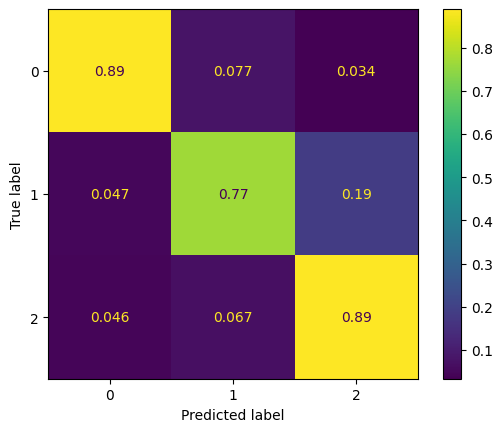

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.54391. Saving Model!
epoch 01, loss: 0.50158, acc: 0.79299, val_loss: 0.54391, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 02, loss: 0.49883, acc: 0.79371, val_loss: 0.55909, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 03, loss: 0.49986, acc: 0.79205, val_loss: 0.56571, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 04, loss: 0.49774, acc: 0.79271, val_loss: 0.57068, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 05, loss: 0.49461, acc: 0.79506, val_loss: 0.57801, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 06, loss: 0.49395, acc: 0.79534, val_loss: 0.58362, val_accuracy: 0.76404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 07, loss: 0.49327, acc: 0.79552, val_loss: 0.58626, val_accuracy: 0.76404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 08, loss: 0.49212, acc: 0.79582, val_loss: 0.58797, val_accuracy: 0.76404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 09, loss: 0.49158, acc: 0.79637, val_loss: 0.58926, val_accuracy: 0.76463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 10, loss: 0.49055, acc: 0.79694, val_loss: 0.59148, val_accuracy: 0.76345


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 11, loss: 0.49009, acc: 0.79716, val_loss: 0.59305, val_accuracy: 0.76345


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 12, loss: 0.48985, acc: 0.79700, val_loss: 0.59460, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 13, loss: 0.48873, acc: 0.79753, val_loss: 0.59619, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 14, loss: 0.48829, acc: 0.79759, val_loss: 0.59787, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 15, loss: 0.48794, acc: 0.79866, val_loss: 0.59987, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 16, loss: 0.48774, acc: 0.79908, val_loss: 0.60026, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 17, loss: 0.48685, acc: 0.80038, val_loss: 0.60247, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 18, loss: 0.48672, acc: 0.80030, val_loss: 0.60310, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 19, loss: 0.48608, acc: 0.80071, val_loss: 0.60466, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 20, loss: 0.48577, acc: 0.80067, val_loss: 0.60643, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 21, loss: 0.48557, acc: 0.80093, val_loss: 0.60718, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 22, loss: 0.48488, acc: 0.80158, val_loss: 0.60866, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 23, loss: 0.48476, acc: 0.80237, val_loss: 0.60967, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 24, loss: 0.48421, acc: 0.80259, val_loss: 0.61142, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 25, loss: 0.48415, acc: 0.80272, val_loss: 0.61225, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 26, loss: 0.48370, acc: 0.80265, val_loss: 0.61323, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 27, loss: 0.48331, acc: 0.80287, val_loss: 0.61432, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 28, loss: 0.48322, acc: 0.80287, val_loss: 0.61524, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 29, loss: 0.48243, acc: 0.80322, val_loss: 0.61663, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 30, loss: 0.48262, acc: 0.80309, val_loss: 0.61746, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 31, loss: 0.48214, acc: 0.80339, val_loss: 0.61905, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 32, loss: 0.48181, acc: 0.80318, val_loss: 0.61958, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 33, loss: 0.48168, acc: 0.80307, val_loss: 0.61986, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 34, loss: 0.48111, acc: 0.80357, val_loss: 0.62181, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 35, loss: 0.48092, acc: 0.80361, val_loss: 0.62246, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 36, loss: 0.48082, acc: 0.80359, val_loss: 0.62317, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 37, loss: 0.48059, acc: 0.80363, val_loss: 0.62361, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 38, loss: 0.47990, acc: 0.80398, val_loss: 0.62527, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 39, loss: 0.48002, acc: 0.80418, val_loss: 0.62576, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 40, loss: 0.47965, acc: 0.80429, val_loss: 0.62655, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 41, loss: 0.47945, acc: 0.80448, val_loss: 0.62687, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 42, loss: 0.47874, acc: 0.80457, val_loss: 0.62845, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 43, loss: 0.47921, acc: 0.80431, val_loss: 0.62848, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 44, loss: 0.47851, acc: 0.80440, val_loss: 0.62894, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 45, loss: 0.47823, acc: 0.80481, val_loss: 0.63045, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 46, loss: 0.47821, acc: 0.80446, val_loss: 0.63018, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 47, loss: 0.47793, acc: 0.80448, val_loss: 0.63105, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 48, loss: 0.47733, acc: 0.80448, val_loss: 0.63182, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 49, loss: 0.47769, acc: 0.80483, val_loss: 0.63219, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 50, loss: 0.47702, acc: 0.80457, val_loss: 0.63328, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 51, loss: 0.47700, acc: 0.80486, val_loss: 0.63407, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 52, loss: 0.47672, acc: 0.80479, val_loss: 0.63413, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 53, loss: 0.47652, acc: 0.80507, val_loss: 0.63546, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 54, loss: 0.47610, acc: 0.80499, val_loss: 0.63604, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 55, loss: 0.47605, acc: 0.80518, val_loss: 0.63667, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 56, loss: 0.47570, acc: 0.80503, val_loss: 0.63686, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 57, loss: 0.47546, acc: 0.80542, val_loss: 0.63760, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 58, loss: 0.47520, acc: 0.80514, val_loss: 0.63803, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 59, loss: 0.47515, acc: 0.80540, val_loss: 0.63926, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 60, loss: 0.47475, acc: 0.80527, val_loss: 0.63954, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 61, loss: 0.47470, acc: 0.80562, val_loss: 0.63941, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 62, loss: 0.47396, acc: 0.80562, val_loss: 0.64118, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 63, loss: 0.47472, acc: 0.80573, val_loss: 0.64016, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 64, loss: 0.47344, acc: 0.80564, val_loss: 0.64229, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 65, loss: 0.47391, acc: 0.80575, val_loss: 0.64234, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 66, loss: 0.47355, acc: 0.80564, val_loss: 0.64241, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 67, loss: 0.47309, acc: 0.80586, val_loss: 0.64362, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 68, loss: 0.47316, acc: 0.80603, val_loss: 0.64333, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 69, loss: 0.47274, acc: 0.80606, val_loss: 0.64462, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 70, loss: 0.47265, acc: 0.80601, val_loss: 0.64463, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 71, loss: 0.47234, acc: 0.80582, val_loss: 0.64512, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 72, loss: 0.47232, acc: 0.80612, val_loss: 0.64558, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 73, loss: 0.47188, acc: 0.80606, val_loss: 0.64603, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 74, loss: 0.47167, acc: 0.80634, val_loss: 0.64656, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


epoch 75, loss: 0.47162, acc: 0.80612, val_loss: 0.64689, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 76, loss: 0.47137, acc: 0.80632, val_loss: 0.64731, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 77, loss: 0.47128, acc: 0.80656, val_loss: 0.64804, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 78, loss: 0.47082, acc: 0.80669, val_loss: 0.64838, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 79, loss: 0.47083, acc: 0.80671, val_loss: 0.64846, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 80, loss: 0.47035, acc: 0.80671, val_loss: 0.64925, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 81, loss: 0.47048, acc: 0.80673, val_loss: 0.64906, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 82, loss: 0.47018, acc: 0.80662, val_loss: 0.64933, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 83, loss: 0.46981, acc: 0.80706, val_loss: 0.65107, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 84, loss: 0.46980, acc: 0.80708, val_loss: 0.65028, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 85, loss: 0.46949, acc: 0.80719, val_loss: 0.65104, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 86, loss: 0.46926, acc: 0.80712, val_loss: 0.65124, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 87, loss: 0.46910, acc: 0.80765, val_loss: 0.65210, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 88, loss: 0.46890, acc: 0.80734, val_loss: 0.65255, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 89, loss: 0.46895, acc: 0.80750, val_loss: 0.65319, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 90, loss: 0.46833, acc: 0.80745, val_loss: 0.65264, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 91, loss: 0.46870, acc: 0.80739, val_loss: 0.65289, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 92, loss: 0.46787, acc: 0.80754, val_loss: 0.65368, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 93, loss: 0.46809, acc: 0.80758, val_loss: 0.65413, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 94, loss: 0.46790, acc: 0.80763, val_loss: 0.65375, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 95, loss: 0.46744, acc: 0.80793, val_loss: 0.65527, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 96, loss: 0.46740, acc: 0.80763, val_loss: 0.65519, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 97, loss: 0.46723, acc: 0.80793, val_loss: 0.65621, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 98, loss: 0.46700, acc: 0.80791, val_loss: 0.65623, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 99, loss: 0.46701, acc: 0.80787, val_loss: 0.65622, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 100, loss: 0.46627, acc: 0.80804, val_loss: 0.65726, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.98it/s]


epoch 101, loss: 0.46657, acc: 0.80854, val_loss: 0.65742, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 102, loss: 0.46631, acc: 0.80789, val_loss: 0.65767, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 103, loss: 0.46577, acc: 0.80839, val_loss: 0.65894, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 104, loss: 0.46601, acc: 0.80828, val_loss: 0.65859, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 105, loss: 0.46556, acc: 0.80852, val_loss: 0.65911, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 106, loss: 0.46560, acc: 0.80889, val_loss: 0.65929, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 107, loss: 0.46516, acc: 0.80941, val_loss: 0.66023, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 108, loss: 0.46499, acc: 0.80913, val_loss: 0.65990, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 109, loss: 0.46510, acc: 0.80983, val_loss: 0.66093, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 110, loss: 0.46435, acc: 0.80948, val_loss: 0.66180, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 111, loss: 0.46459, acc: 0.80948, val_loss: 0.66195, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 112, loss: 0.46422, acc: 0.80996, val_loss: 0.66198, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 113, loss: 0.46414, acc: 0.80989, val_loss: 0.66354, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 114, loss: 0.46389, acc: 0.80961, val_loss: 0.66295, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 115, loss: 0.46383, acc: 0.81020, val_loss: 0.66336, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 116, loss: 0.46335, acc: 0.81029, val_loss: 0.66364, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 117, loss: 0.46353, acc: 0.80994, val_loss: 0.66460, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 118, loss: 0.46297, acc: 0.80965, val_loss: 0.66421, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 119, loss: 0.46326, acc: 0.81013, val_loss: 0.66443, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 120, loss: 0.46260, acc: 0.81081, val_loss: 0.66562, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 121, loss: 0.46297, acc: 0.80985, val_loss: 0.66595, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 122, loss: 0.46225, acc: 0.80994, val_loss: 0.66587, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 123, loss: 0.46232, acc: 0.81055, val_loss: 0.66676, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 124, loss: 0.46194, acc: 0.81079, val_loss: 0.66673, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 125, loss: 0.46191, acc: 0.81079, val_loss: 0.66757, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 126, loss: 0.46177, acc: 0.81046, val_loss: 0.66706, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 127, loss: 0.46135, acc: 0.81075, val_loss: 0.66810, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 128, loss: 0.46143, acc: 0.81112, val_loss: 0.66812, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 129, loss: 0.46104, acc: 0.81136, val_loss: 0.66885, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 130, loss: 0.46076, acc: 0.81171, val_loss: 0.66920, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 131, loss: 0.46121, acc: 0.81107, val_loss: 0.66867, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 132, loss: 0.46025, acc: 0.81190, val_loss: 0.66964, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 133, loss: 0.46059, acc: 0.81140, val_loss: 0.67020, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 134, loss: 0.46010, acc: 0.81201, val_loss: 0.66940, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 135, loss: 0.46004, acc: 0.81171, val_loss: 0.67042, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 136, loss: 0.45999, acc: 0.81210, val_loss: 0.67074, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 137, loss: 0.45953, acc: 0.81168, val_loss: 0.67151, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 138, loss: 0.45975, acc: 0.81195, val_loss: 0.67075, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 139, loss: 0.45913, acc: 0.81345, val_loss: 0.67204, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 140, loss: 0.45892, acc: 0.81373, val_loss: 0.67228, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 141, loss: 0.45924, acc: 0.81173, val_loss: 0.67242, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 142, loss: 0.45859, acc: 0.81349, val_loss: 0.67266, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 143, loss: 0.45892, acc: 0.81177, val_loss: 0.67326, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 144, loss: 0.45840, acc: 0.81417, val_loss: 0.67244, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 145, loss: 0.45807, acc: 0.81338, val_loss: 0.67425, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 146, loss: 0.45812, acc: 0.81249, val_loss: 0.67379, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 147, loss: 0.45827, acc: 0.81297, val_loss: 0.67365, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 148, loss: 0.45736, acc: 0.81456, val_loss: 0.67465, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 149, loss: 0.45767, acc: 0.81452, val_loss: 0.67564, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 150, loss: 0.45752, acc: 0.81428, val_loss: 0.67513, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 151, loss: 0.45722, acc: 0.81463, val_loss: 0.67600, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 152, loss: 0.45687, acc: 0.81474, val_loss: 0.67629, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 153, loss: 0.45707, acc: 0.81365, val_loss: 0.67672, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 154, loss: 0.45651, acc: 0.81450, val_loss: 0.67644, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 155, loss: 0.45647, acc: 0.81441, val_loss: 0.67732, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 156, loss: 0.45627, acc: 0.81480, val_loss: 0.67735, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 157, loss: 0.45624, acc: 0.81445, val_loss: 0.67789, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 158, loss: 0.45584, acc: 0.81491, val_loss: 0.67865, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 159, loss: 0.45607, acc: 0.81456, val_loss: 0.67887, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 160, loss: 0.45553, acc: 0.81515, val_loss: 0.67826, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 161, loss: 0.45556, acc: 0.81550, val_loss: 0.67920, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 162, loss: 0.45501, acc: 0.81530, val_loss: 0.67914, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 163, loss: 0.45551, acc: 0.81478, val_loss: 0.67908, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 164, loss: 0.45454, acc: 0.81554, val_loss: 0.67974, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 165, loss: 0.45524, acc: 0.81535, val_loss: 0.67983, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 166, loss: 0.45433, acc: 0.81581, val_loss: 0.68011, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 167, loss: 0.45458, acc: 0.81581, val_loss: 0.68146, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 168, loss: 0.45419, acc: 0.81605, val_loss: 0.68104, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 169, loss: 0.45431, acc: 0.81605, val_loss: 0.68124, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 170, loss: 0.45353, acc: 0.81644, val_loss: 0.68172, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 171, loss: 0.45419, acc: 0.81629, val_loss: 0.68132, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 172, loss: 0.45326, acc: 0.81644, val_loss: 0.68230, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 173, loss: 0.45370, acc: 0.81640, val_loss: 0.68319, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 174, loss: 0.45312, acc: 0.81653, val_loss: 0.68282, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 175, loss: 0.45336, acc: 0.81650, val_loss: 0.68337, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 176, loss: 0.45267, acc: 0.81681, val_loss: 0.68319, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 177, loss: 0.45302, acc: 0.81640, val_loss: 0.68392, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 178, loss: 0.45230, acc: 0.81672, val_loss: 0.68403, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 179, loss: 0.45251, acc: 0.81703, val_loss: 0.68498, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 180, loss: 0.45233, acc: 0.81701, val_loss: 0.68385, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 181, loss: 0.45214, acc: 0.81701, val_loss: 0.68570, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 182, loss: 0.45169, acc: 0.81698, val_loss: 0.68507, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 183, loss: 0.45219, acc: 0.81696, val_loss: 0.68484, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 184, loss: 0.45102, acc: 0.81714, val_loss: 0.68654, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 185, loss: 0.45212, acc: 0.81690, val_loss: 0.68532, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 186, loss: 0.45093, acc: 0.81738, val_loss: 0.68588, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 187, loss: 0.45110, acc: 0.81670, val_loss: 0.68755, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 188, loss: 0.45094, acc: 0.81720, val_loss: 0.68650, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 189, loss: 0.45100, acc: 0.81742, val_loss: 0.68708, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 190, loss: 0.45026, acc: 0.81740, val_loss: 0.68723, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 191, loss: 0.45098, acc: 0.81718, val_loss: 0.68740, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 192, loss: 0.44980, acc: 0.81788, val_loss: 0.68779, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 193, loss: 0.45040, acc: 0.81729, val_loss: 0.68798, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 194, loss: 0.44987, acc: 0.81762, val_loss: 0.68799, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 195, loss: 0.44984, acc: 0.81777, val_loss: 0.68867, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 196, loss: 0.44929, acc: 0.81792, val_loss: 0.68939, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 197, loss: 0.44985, acc: 0.81777, val_loss: 0.68826, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 198, loss: 0.44918, acc: 0.81768, val_loss: 0.68912, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 199, loss: 0.44917, acc: 0.81805, val_loss: 0.68953, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 200, loss: 0.44907, acc: 0.81777, val_loss: 0.69028, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 201, loss: 0.44865, acc: 0.81797, val_loss: 0.69011, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 202, loss: 0.44878, acc: 0.81783, val_loss: 0.69030, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 203, loss: 0.44844, acc: 0.81829, val_loss: 0.69053, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 204, loss: 0.44812, acc: 0.81847, val_loss: 0.69085, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 205, loss: 0.44837, acc: 0.81823, val_loss: 0.69089, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 206, loss: 0.44775, acc: 0.81845, val_loss: 0.69176, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 207, loss: 0.44788, acc: 0.81864, val_loss: 0.69069, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 208, loss: 0.44761, acc: 0.81858, val_loss: 0.69253, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 209, loss: 0.44732, acc: 0.81886, val_loss: 0.69259, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 210, loss: 0.44756, acc: 0.81825, val_loss: 0.69201, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 211, loss: 0.44694, acc: 0.81882, val_loss: 0.69233, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 212, loss: 0.44705, acc: 0.81908, val_loss: 0.69338, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 213, loss: 0.44690, acc: 0.81903, val_loss: 0.69362, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 214, loss: 0.44665, acc: 0.81903, val_loss: 0.69329, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 215, loss: 0.44643, acc: 0.81906, val_loss: 0.69334, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 216, loss: 0.44643, acc: 0.81917, val_loss: 0.69312, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 217, loss: 0.44640, acc: 0.81906, val_loss: 0.69351, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 218, loss: 0.44563, acc: 0.81962, val_loss: 0.69508, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 219, loss: 0.44612, acc: 0.81925, val_loss: 0.69382, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 220, loss: 0.44555, acc: 0.81954, val_loss: 0.69491, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.42it/s]


epoch 221, loss: 0.44559, acc: 0.81943, val_loss: 0.69465, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 222, loss: 0.44531, acc: 0.81954, val_loss: 0.69571, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 223, loss: 0.44548, acc: 0.81962, val_loss: 0.69442, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 224, loss: 0.44472, acc: 0.81965, val_loss: 0.69617, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 225, loss: 0.44536, acc: 0.81973, val_loss: 0.69461, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 226, loss: 0.44425, acc: 0.81982, val_loss: 0.69753, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 227, loss: 0.44515, acc: 0.82080, val_loss: 0.69520, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 228, loss: 0.44406, acc: 0.82021, val_loss: 0.69735, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 229, loss: 0.44449, acc: 0.82013, val_loss: 0.69523, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 230, loss: 0.44387, acc: 0.82021, val_loss: 0.69726, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 231, loss: 0.44419, acc: 0.82050, val_loss: 0.69568, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 232, loss: 0.44333, acc: 0.82037, val_loss: 0.69719, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 233, loss: 0.44411, acc: 0.82054, val_loss: 0.69638, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 234, loss: 0.44294, acc: 0.82058, val_loss: 0.69774, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 235, loss: 0.44362, acc: 0.82030, val_loss: 0.69729, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 236, loss: 0.44327, acc: 0.82063, val_loss: 0.69740, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 237, loss: 0.44296, acc: 0.82146, val_loss: 0.69778, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 238, loss: 0.44300, acc: 0.82054, val_loss: 0.69840, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 239, loss: 0.44269, acc: 0.82113, val_loss: 0.69793, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 240, loss: 0.44243, acc: 0.82106, val_loss: 0.69904, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 241, loss: 0.44262, acc: 0.82148, val_loss: 0.69825, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 242, loss: 0.44192, acc: 0.82095, val_loss: 0.70005, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 243, loss: 0.44239, acc: 0.82178, val_loss: 0.69921, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 244, loss: 0.44181, acc: 0.82117, val_loss: 0.70040, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 245, loss: 0.44179, acc: 0.82124, val_loss: 0.69953, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 246, loss: 0.44145, acc: 0.82124, val_loss: 0.70054, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 247, loss: 0.44180, acc: 0.82211, val_loss: 0.69964, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 248, loss: 0.44110, acc: 0.82130, val_loss: 0.70135, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 249, loss: 0.44123, acc: 0.82113, val_loss: 0.69995, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 250, loss: 0.44088, acc: 0.82115, val_loss: 0.70084, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 251, loss: 0.44089, acc: 0.82226, val_loss: 0.70090, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 252, loss: 0.44058, acc: 0.82163, val_loss: 0.70214, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 253, loss: 0.44078, acc: 0.82239, val_loss: 0.70148, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 254, loss: 0.44018, acc: 0.82130, val_loss: 0.70174, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 255, loss: 0.44027, acc: 0.82228, val_loss: 0.70183, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 256, loss: 0.43989, acc: 0.82150, val_loss: 0.70306, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 257, loss: 0.44005, acc: 0.82222, val_loss: 0.70236, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 258, loss: 0.43970, acc: 0.82128, val_loss: 0.70280, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 259, loss: 0.43962, acc: 0.82246, val_loss: 0.70192, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 260, loss: 0.43930, acc: 0.82276, val_loss: 0.70446, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 261, loss: 0.43960, acc: 0.82211, val_loss: 0.70260, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 262, loss: 0.43883, acc: 0.82180, val_loss: 0.70334, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 263, loss: 0.43900, acc: 0.82266, val_loss: 0.70418, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 264, loss: 0.43913, acc: 0.82141, val_loss: 0.70410, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 265, loss: 0.43867, acc: 0.82261, val_loss: 0.70458, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 266, loss: 0.43865, acc: 0.82220, val_loss: 0.70528, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 267, loss: 0.43848, acc: 0.82285, val_loss: 0.70337, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 268, loss: 0.43803, acc: 0.82283, val_loss: 0.70561, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 269, loss: 0.43819, acc: 0.82281, val_loss: 0.70485, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 270, loss: 0.43798, acc: 0.82209, val_loss: 0.70540, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 271, loss: 0.43778, acc: 0.82257, val_loss: 0.70615, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 272, loss: 0.43734, acc: 0.82287, val_loss: 0.70565, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 273, loss: 0.43814, acc: 0.82270, val_loss: 0.70539, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 274, loss: 0.43688, acc: 0.82287, val_loss: 0.70721, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 275, loss: 0.43737, acc: 0.82305, val_loss: 0.70591, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 276, loss: 0.43692, acc: 0.82322, val_loss: 0.70613, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 277, loss: 0.43717, acc: 0.82185, val_loss: 0.70679, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 278, loss: 0.43640, acc: 0.82324, val_loss: 0.70799, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 279, loss: 0.43690, acc: 0.82300, val_loss: 0.70792, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 280, loss: 0.43635, acc: 0.82318, val_loss: 0.70641, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 281, loss: 0.43639, acc: 0.82357, val_loss: 0.70747, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 282, loss: 0.43600, acc: 0.82331, val_loss: 0.70839, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 283, loss: 0.43613, acc: 0.82329, val_loss: 0.70818, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 284, loss: 0.43594, acc: 0.82353, val_loss: 0.70754, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 285, loss: 0.43553, acc: 0.82410, val_loss: 0.70918, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 286, loss: 0.43583, acc: 0.82412, val_loss: 0.70812, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 287, loss: 0.43519, acc: 0.82386, val_loss: 0.70867, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 288, loss: 0.43536, acc: 0.82390, val_loss: 0.70885, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 289, loss: 0.43534, acc: 0.82368, val_loss: 0.70946, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 290, loss: 0.43464, acc: 0.82477, val_loss: 0.70971, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 291, loss: 0.43491, acc: 0.82420, val_loss: 0.70944, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 292, loss: 0.43485, acc: 0.82464, val_loss: 0.70868, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 293, loss: 0.43414, acc: 0.82375, val_loss: 0.71185, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 294, loss: 0.43471, acc: 0.82444, val_loss: 0.70887, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 295, loss: 0.43368, acc: 0.82530, val_loss: 0.71063, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 296, loss: 0.43475, acc: 0.82475, val_loss: 0.70949, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 297, loss: 0.43309, acc: 0.82536, val_loss: 0.71215, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 298, loss: 0.43435, acc: 0.82477, val_loss: 0.71120, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 299, loss: 0.43356, acc: 0.82538, val_loss: 0.70955, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 300, loss: 0.43324, acc: 0.82508, val_loss: 0.71214, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 301, loss: 0.43356, acc: 0.82521, val_loss: 0.71022, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 302, loss: 0.43255, acc: 0.82630, val_loss: 0.71241, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 303, loss: 0.43385, acc: 0.82521, val_loss: 0.71127, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 304, loss: 0.43227, acc: 0.82654, val_loss: 0.71114, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 305, loss: 0.43291, acc: 0.82580, val_loss: 0.71254, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 306, loss: 0.43235, acc: 0.82628, val_loss: 0.71138, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 307, loss: 0.43229, acc: 0.82567, val_loss: 0.71225, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 308, loss: 0.43210, acc: 0.82547, val_loss: 0.71300, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 309, loss: 0.43218, acc: 0.82708, val_loss: 0.71365, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 310, loss: 0.43174, acc: 0.82671, val_loss: 0.71228, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 311, loss: 0.43206, acc: 0.82713, val_loss: 0.71428, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 312, loss: 0.43149, acc: 0.82693, val_loss: 0.71321, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 313, loss: 0.43162, acc: 0.82717, val_loss: 0.71424, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 314, loss: 0.43126, acc: 0.82665, val_loss: 0.71276, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 315, loss: 0.43121, acc: 0.82759, val_loss: 0.71538, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 316, loss: 0.43128, acc: 0.82671, val_loss: 0.71304, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 317, loss: 0.43068, acc: 0.82767, val_loss: 0.71455, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 318, loss: 0.43116, acc: 0.82673, val_loss: 0.71467, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 319, loss: 0.43020, acc: 0.82800, val_loss: 0.71475, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 320, loss: 0.43071, acc: 0.82619, val_loss: 0.71566, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 321, loss: 0.43016, acc: 0.82752, val_loss: 0.71633, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 322, loss: 0.43028, acc: 0.82761, val_loss: 0.71597, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 323, loss: 0.42989, acc: 0.82756, val_loss: 0.71559, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


epoch 324, loss: 0.42994, acc: 0.82763, val_loss: 0.71678, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 325, loss: 0.42943, acc: 0.82796, val_loss: 0.71707, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 326, loss: 0.42990, acc: 0.82756, val_loss: 0.71635, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 327, loss: 0.42913, acc: 0.82769, val_loss: 0.71721, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 328, loss: 0.42961, acc: 0.82769, val_loss: 0.71707, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 329, loss: 0.42873, acc: 0.82793, val_loss: 0.71725, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 330, loss: 0.42924, acc: 0.82809, val_loss: 0.71685, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 331, loss: 0.42913, acc: 0.82811, val_loss: 0.72043, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 332, loss: 0.42836, acc: 0.82809, val_loss: 0.71623, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 333, loss: 0.42871, acc: 0.82828, val_loss: 0.71895, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 334, loss: 0.42840, acc: 0.82826, val_loss: 0.71796, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 335, loss: 0.42800, acc: 0.82841, val_loss: 0.71921, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 336, loss: 0.42892, acc: 0.82942, val_loss: 0.71967, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 337, loss: 0.42732, acc: 0.82955, val_loss: 0.71821, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 338, loss: 0.42815, acc: 0.82946, val_loss: 0.71915, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 339, loss: 0.42741, acc: 0.82979, val_loss: 0.71854, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 340, loss: 0.42775, acc: 0.82985, val_loss: 0.71940, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 341, loss: 0.42751, acc: 0.82979, val_loss: 0.72296, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 342, loss: 0.42724, acc: 0.82981, val_loss: 0.71797, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 343, loss: 0.42689, acc: 0.83038, val_loss: 0.72134, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 344, loss: 0.42724, acc: 0.83003, val_loss: 0.71883, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 345, loss: 0.42627, acc: 0.82977, val_loss: 0.72046, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 346, loss: 0.42756, acc: 0.82985, val_loss: 0.72056, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 347, loss: 0.42594, acc: 0.83044, val_loss: 0.71921, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 348, loss: 0.42641, acc: 0.83007, val_loss: 0.72217, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 349, loss: 0.42659, acc: 0.83003, val_loss: 0.72009, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 350, loss: 0.42571, acc: 0.83003, val_loss: 0.72247, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 351, loss: 0.42643, acc: 0.82983, val_loss: 0.72370, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 352, loss: 0.42548, acc: 0.83068, val_loss: 0.72149, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 353, loss: 0.42577, acc: 0.83053, val_loss: 0.72306, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 354, loss: 0.42588, acc: 0.83036, val_loss: 0.72257, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 355, loss: 0.42484, acc: 0.83031, val_loss: 0.72214, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 356, loss: 0.42600, acc: 0.83055, val_loss: 0.72223, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 357, loss: 0.42445, acc: 0.83084, val_loss: 0.72297, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 358, loss: 0.42558, acc: 0.83046, val_loss: 0.72277, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 359, loss: 0.42411, acc: 0.83103, val_loss: 0.72262, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 360, loss: 0.42474, acc: 0.83094, val_loss: 0.72377, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 361, loss: 0.42448, acc: 0.83055, val_loss: 0.72388, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 362, loss: 0.42459, acc: 0.83097, val_loss: 0.72389, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 363, loss: 0.42398, acc: 0.83079, val_loss: 0.72387, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 364, loss: 0.42430, acc: 0.83121, val_loss: 0.72528, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 365, loss: 0.42377, acc: 0.83073, val_loss: 0.72488, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 366, loss: 0.42419, acc: 0.83129, val_loss: 0.72526, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 367, loss: 0.42311, acc: 0.83088, val_loss: 0.72693, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 368, loss: 0.42424, acc: 0.83132, val_loss: 0.72535, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 369, loss: 0.42285, acc: 0.83068, val_loss: 0.72680, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 370, loss: 0.42363, acc: 0.83166, val_loss: 0.72634, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 371, loss: 0.42305, acc: 0.83088, val_loss: 0.72723, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 372, loss: 0.42333, acc: 0.83223, val_loss: 0.72686, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 373, loss: 0.42256, acc: 0.83132, val_loss: 0.72743, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 374, loss: 0.42317, acc: 0.83223, val_loss: 0.72727, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 375, loss: 0.42203, acc: 0.83145, val_loss: 0.72986, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 376, loss: 0.42309, acc: 0.83160, val_loss: 0.72934, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 377, loss: 0.42188, acc: 0.83217, val_loss: 0.72878, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


epoch 378, loss: 0.42209, acc: 0.83289, val_loss: 0.73035, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 379, loss: 0.42202, acc: 0.83214, val_loss: 0.72953, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 380, loss: 0.42180, acc: 0.83265, val_loss: 0.73064, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 381, loss: 0.42198, acc: 0.83201, val_loss: 0.73373, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


epoch 382, loss: 0.42183, acc: 0.83291, val_loss: 0.72807, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 383, loss: 0.42077, acc: 0.83243, val_loss: 0.73359, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 384, loss: 0.42210, acc: 0.83260, val_loss: 0.73133, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 385, loss: 0.42028, acc: 0.83271, val_loss: 0.73154, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 386, loss: 0.42166, acc: 0.83278, val_loss: 0.73237, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 387, loss: 0.42064, acc: 0.83256, val_loss: 0.73275, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 388, loss: 0.42084, acc: 0.83286, val_loss: 0.73278, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 389, loss: 0.42046, acc: 0.83289, val_loss: 0.73227, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 390, loss: 0.42082, acc: 0.83300, val_loss: 0.73305, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 391, loss: 0.41955, acc: 0.83295, val_loss: 0.73397, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 392, loss: 0.42062, acc: 0.83326, val_loss: 0.73342, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 393, loss: 0.41981, acc: 0.83297, val_loss: 0.73235, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 394, loss: 0.41971, acc: 0.83369, val_loss: 0.73534, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 395, loss: 0.41975, acc: 0.83273, val_loss: 0.73382, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 396, loss: 0.41946, acc: 0.83365, val_loss: 0.73487, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 397, loss: 0.41942, acc: 0.83317, val_loss: 0.73518, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 398, loss: 0.41948, acc: 0.83350, val_loss: 0.73422, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 399, loss: 0.41872, acc: 0.83315, val_loss: 0.73587, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 400, loss: 0.41936, acc: 0.83356, val_loss: 0.73619, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 401, loss: 0.41850, acc: 0.83367, val_loss: 0.73578, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 402, loss: 0.41919, acc: 0.83315, val_loss: 0.73708, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 403, loss: 0.41828, acc: 0.83376, val_loss: 0.73357, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 404, loss: 0.41842, acc: 0.83396, val_loss: 0.73758, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 405, loss: 0.41833, acc: 0.83361, val_loss: 0.73595, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 406, loss: 0.41795, acc: 0.83372, val_loss: 0.73746, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 407, loss: 0.41865, acc: 0.83369, val_loss: 0.73908, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 408, loss: 0.41766, acc: 0.83385, val_loss: 0.73668, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 409, loss: 0.41784, acc: 0.83409, val_loss: 0.73946, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 410, loss: 0.41763, acc: 0.83406, val_loss: 0.73770, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 411, loss: 0.41724, acc: 0.83396, val_loss: 0.73855, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 412, loss: 0.41802, acc: 0.83400, val_loss: 0.74118, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 413, loss: 0.41683, acc: 0.83439, val_loss: 0.73662, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 414, loss: 0.41729, acc: 0.83409, val_loss: 0.73934, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 415, loss: 0.41718, acc: 0.83441, val_loss: 0.74030, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 416, loss: 0.41631, acc: 0.83457, val_loss: 0.74051, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 417, loss: 0.41731, acc: 0.83400, val_loss: 0.74026, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 418, loss: 0.41607, acc: 0.83472, val_loss: 0.73905, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 419, loss: 0.41687, acc: 0.83402, val_loss: 0.73954, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 420, loss: 0.41599, acc: 0.83522, val_loss: 0.74204, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 421, loss: 0.41592, acc: 0.83457, val_loss: 0.73971, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 422, loss: 0.41618, acc: 0.83498, val_loss: 0.74165, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 423, loss: 0.41596, acc: 0.83522, val_loss: 0.74254, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 424, loss: 0.41564, acc: 0.83472, val_loss: 0.74209, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 425, loss: 0.41583, acc: 0.83478, val_loss: 0.74406, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 426, loss: 0.41550, acc: 0.83472, val_loss: 0.74012, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 427, loss: 0.41509, acc: 0.83531, val_loss: 0.74220, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 428, loss: 0.41543, acc: 0.83539, val_loss: 0.74348, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 429, loss: 0.41471, acc: 0.83537, val_loss: 0.74315, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 430, loss: 0.41507, acc: 0.83502, val_loss: 0.74267, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 431, loss: 0.41488, acc: 0.83561, val_loss: 0.74322, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 432, loss: 0.41414, acc: 0.83553, val_loss: 0.74429, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 433, loss: 0.41523, acc: 0.83531, val_loss: 0.74616, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 434, loss: 0.41422, acc: 0.83550, val_loss: 0.74296, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 435, loss: 0.41397, acc: 0.83587, val_loss: 0.74496, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 436, loss: 0.41468, acc: 0.83509, val_loss: 0.74377, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 437, loss: 0.41304, acc: 0.83631, val_loss: 0.74407, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 438, loss: 0.41404, acc: 0.83546, val_loss: 0.74601, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 439, loss: 0.41383, acc: 0.83625, val_loss: 0.74536, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 440, loss: 0.41306, acc: 0.83570, val_loss: 0.74724, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 441, loss: 0.41409, acc: 0.83620, val_loss: 0.74733, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 442, loss: 0.41276, acc: 0.83583, val_loss: 0.74452, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 443, loss: 0.41361, acc: 0.83614, val_loss: 0.74752, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 444, loss: 0.41291, acc: 0.83633, val_loss: 0.74767, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 445, loss: 0.41266, acc: 0.83651, val_loss: 0.74940, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 446, loss: 0.41341, acc: 0.83596, val_loss: 0.75163, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 447, loss: 0.41218, acc: 0.83631, val_loss: 0.74789, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 448, loss: 0.41259, acc: 0.83616, val_loss: 0.74786, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 449, loss: 0.41265, acc: 0.83690, val_loss: 0.74840, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 450, loss: 0.41155, acc: 0.83659, val_loss: 0.74866, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 451, loss: 0.41258, acc: 0.83622, val_loss: 0.74949, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 452, loss: 0.41146, acc: 0.83657, val_loss: 0.75002, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 453, loss: 0.41193, acc: 0.83649, val_loss: 0.75040, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 454, loss: 0.41191, acc: 0.83688, val_loss: 0.75119, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 455, loss: 0.41096, acc: 0.83683, val_loss: 0.74983, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 456, loss: 0.41168, acc: 0.83681, val_loss: 0.75134, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 457, loss: 0.41116, acc: 0.83716, val_loss: 0.74866, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 458, loss: 0.41052, acc: 0.83721, val_loss: 0.75226, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 459, loss: 0.41175, acc: 0.83692, val_loss: 0.75398, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 460, loss: 0.41043, acc: 0.83736, val_loss: 0.74975, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 461, loss: 0.41069, acc: 0.83707, val_loss: 0.75306, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 462, loss: 0.41078, acc: 0.83725, val_loss: 0.75256, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 463, loss: 0.40990, acc: 0.83762, val_loss: 0.75339, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 464, loss: 0.41117, acc: 0.83690, val_loss: 0.75446, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 465, loss: 0.40958, acc: 0.83760, val_loss: 0.75076, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 466, loss: 0.41024, acc: 0.83707, val_loss: 0.75290, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 467, loss: 0.41002, acc: 0.83823, val_loss: 0.75414, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 468, loss: 0.40934, acc: 0.83738, val_loss: 0.75263, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 469, loss: 0.40993, acc: 0.83803, val_loss: 0.75464, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 470, loss: 0.40908, acc: 0.83745, val_loss: 0.75495, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 471, loss: 0.40961, acc: 0.83795, val_loss: 0.75491, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 472, loss: 0.40943, acc: 0.83784, val_loss: 0.75681, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 473, loss: 0.40903, acc: 0.83836, val_loss: 0.75268, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 474, loss: 0.40891, acc: 0.83714, val_loss: 0.75546, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 475, loss: 0.40894, acc: 0.83884, val_loss: 0.75440, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 476, loss: 0.40818, acc: 0.83797, val_loss: 0.75587, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 477, loss: 0.40902, acc: 0.83819, val_loss: 0.75447, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 478, loss: 0.40765, acc: 0.83814, val_loss: 0.75601, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 479, loss: 0.40903, acc: 0.83821, val_loss: 0.75565, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 480, loss: 0.40726, acc: 0.83862, val_loss: 0.75605, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 481, loss: 0.40866, acc: 0.83849, val_loss: 0.75648, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 482, loss: 0.40744, acc: 0.83845, val_loss: 0.75540, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 483, loss: 0.40762, acc: 0.83891, val_loss: 0.75771, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 484, loss: 0.40794, acc: 0.83849, val_loss: 0.75891, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 485, loss: 0.40745, acc: 0.83888, val_loss: 0.75600, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 486, loss: 0.40708, acc: 0.83843, val_loss: 0.75855, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 487, loss: 0.40767, acc: 0.83919, val_loss: 0.75652, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 488, loss: 0.40648, acc: 0.83836, val_loss: 0.75865, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 489, loss: 0.40764, acc: 0.83910, val_loss: 0.75772, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 490, loss: 0.40651, acc: 0.83908, val_loss: 0.76164, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


epoch 491, loss: 0.40720, acc: 0.83902, val_loss: 0.75552, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 492, loss: 0.40594, acc: 0.83867, val_loss: 0.76040, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 493, loss: 0.40713, acc: 0.83943, val_loss: 0.75758, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 494, loss: 0.40517, acc: 0.83930, val_loss: 0.76080, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 495, loss: 0.40743, acc: 0.83906, val_loss: 0.75957, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 496, loss: 0.40484, acc: 0.83934, val_loss: 0.76121, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 497, loss: 0.40703, acc: 0.83943, val_loss: 0.75914, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 498, loss: 0.40474, acc: 0.83943, val_loss: 0.76204, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 499, loss: 0.40628, acc: 0.83974, val_loss: 0.76143, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 500, loss: 0.40522, acc: 0.83936, val_loss: 0.75902, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 501, loss: 0.40519, acc: 0.83987, val_loss: 0.76135, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 502, loss: 0.40539, acc: 0.84004, val_loss: 0.76094, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 503, loss: 0.40524, acc: 0.83963, val_loss: 0.75857, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 504, loss: 0.40453, acc: 0.83930, val_loss: 0.76359, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 505, loss: 0.40568, acc: 0.83960, val_loss: 0.76257, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 506, loss: 0.40384, acc: 0.83969, val_loss: 0.76429, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 507, loss: 0.40564, acc: 0.83989, val_loss: 0.76406, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 508, loss: 0.40388, acc: 0.83950, val_loss: 0.76195, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 509, loss: 0.40475, acc: 0.83995, val_loss: 0.76182, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 510, loss: 0.40380, acc: 0.84013, val_loss: 0.76284, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 511, loss: 0.40443, acc: 0.83989, val_loss: 0.76216, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 512, loss: 0.40359, acc: 0.84013, val_loss: 0.76563, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 513, loss: 0.40434, acc: 0.83998, val_loss: 0.76382, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 514, loss: 0.40353, acc: 0.83993, val_loss: 0.76560, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 515, loss: 0.40383, acc: 0.84028, val_loss: 0.76160, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 516, loss: 0.40323, acc: 0.84024, val_loss: 0.76503, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 517, loss: 0.40334, acc: 0.84094, val_loss: 0.76580, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 518, loss: 0.40302, acc: 0.84006, val_loss: 0.76373, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 519, loss: 0.40337, acc: 0.84030, val_loss: 0.76573, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 520, loss: 0.40260, acc: 0.84061, val_loss: 0.76976, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 521, loss: 0.40303, acc: 0.84035, val_loss: 0.76532, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 522, loss: 0.40246, acc: 0.84024, val_loss: 0.76578, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 523, loss: 0.40276, acc: 0.83984, val_loss: 0.76430, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 524, loss: 0.40223, acc: 0.84074, val_loss: 0.76911, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 525, loss: 0.40261, acc: 0.84035, val_loss: 0.76565, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 526, loss: 0.40158, acc: 0.84091, val_loss: 0.76802, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 527, loss: 0.40262, acc: 0.84056, val_loss: 0.76896, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 528, loss: 0.40119, acc: 0.84070, val_loss: 0.76762, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 529, loss: 0.40216, acc: 0.84091, val_loss: 0.76820, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 530, loss: 0.40103, acc: 0.84072, val_loss: 0.76590, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 531, loss: 0.40158, acc: 0.84072, val_loss: 0.76682, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 532, loss: 0.40100, acc: 0.84089, val_loss: 0.76903, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 533, loss: 0.40166, acc: 0.84078, val_loss: 0.76709, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 534, loss: 0.40061, acc: 0.84065, val_loss: 0.77084, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 535, loss: 0.40156, acc: 0.84100, val_loss: 0.77201, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 536, loss: 0.40046, acc: 0.84065, val_loss: 0.76732, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 537, loss: 0.40082, acc: 0.84163, val_loss: 0.77012, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 538, loss: 0.40048, acc: 0.84087, val_loss: 0.76804, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 539, loss: 0.40031, acc: 0.84107, val_loss: 0.77178, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 540, loss: 0.40102, acc: 0.84155, val_loss: 0.77407, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 541, loss: 0.40024, acc: 0.84087, val_loss: 0.76907, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 542, loss: 0.39988, acc: 0.84174, val_loss: 0.77124, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 543, loss: 0.40013, acc: 0.84168, val_loss: 0.76985, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 544, loss: 0.39937, acc: 0.84109, val_loss: 0.76951, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 545, loss: 0.39996, acc: 0.84157, val_loss: 0.77262, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 546, loss: 0.39946, acc: 0.84176, val_loss: 0.77117, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 547, loss: 0.39926, acc: 0.84159, val_loss: 0.77293, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 548, loss: 0.39967, acc: 0.84190, val_loss: 0.77595, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 549, loss: 0.39927, acc: 0.84148, val_loss: 0.77165, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 550, loss: 0.39865, acc: 0.84190, val_loss: 0.77209, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 551, loss: 0.39956, acc: 0.84200, val_loss: 0.77077, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 552, loss: 0.39790, acc: 0.84155, val_loss: 0.77316, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 553, loss: 0.39906, acc: 0.84161, val_loss: 0.77358, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 554, loss: 0.39836, acc: 0.84194, val_loss: 0.77175, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 555, loss: 0.39796, acc: 0.84233, val_loss: 0.77571, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 556, loss: 0.39891, acc: 0.84216, val_loss: 0.77662, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 557, loss: 0.39776, acc: 0.84205, val_loss: 0.77255, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 558, loss: 0.39801, acc: 0.84218, val_loss: 0.77437, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 559, loss: 0.39815, acc: 0.84264, val_loss: 0.77311, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 560, loss: 0.39712, acc: 0.84190, val_loss: 0.77412, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 561, loss: 0.39821, acc: 0.84242, val_loss: 0.77506, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 562, loss: 0.39655, acc: 0.84216, val_loss: 0.77636, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 563, loss: 0.39842, acc: 0.84242, val_loss: 0.77465, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 564, loss: 0.39633, acc: 0.84248, val_loss: 0.77583, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 565, loss: 0.39769, acc: 0.84292, val_loss: 0.77589, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 566, loss: 0.39670, acc: 0.84259, val_loss: 0.77486, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 567, loss: 0.39685, acc: 0.84262, val_loss: 0.77711, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 568, loss: 0.39704, acc: 0.84266, val_loss: 0.77966, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 569, loss: 0.39679, acc: 0.84292, val_loss: 0.77424, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 570, loss: 0.39599, acc: 0.84277, val_loss: 0.77896, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 571, loss: 0.39723, acc: 0.84299, val_loss: 0.77408, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 572, loss: 0.39519, acc: 0.84248, val_loss: 0.77824, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 573, loss: 0.39702, acc: 0.84329, val_loss: 0.77603, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 574, loss: 0.39525, acc: 0.84344, val_loss: 0.77905, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 575, loss: 0.39627, acc: 0.84325, val_loss: 0.77753, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 576, loss: 0.39555, acc: 0.84272, val_loss: 0.78183, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 577, loss: 0.39588, acc: 0.84340, val_loss: 0.77622, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 578, loss: 0.39511, acc: 0.84285, val_loss: 0.77864, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 579, loss: 0.39578, acc: 0.84392, val_loss: 0.77744, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 580, loss: 0.39444, acc: 0.84290, val_loss: 0.77716, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 581, loss: 0.39587, acc: 0.84312, val_loss: 0.77782, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 582, loss: 0.39433, acc: 0.84384, val_loss: 0.78241, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 583, loss: 0.39555, acc: 0.84351, val_loss: 0.77790, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 584, loss: 0.39420, acc: 0.84307, val_loss: 0.77967, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 585, loss: 0.39490, acc: 0.84405, val_loss: 0.77934, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 586, loss: 0.39425, acc: 0.84299, val_loss: 0.78377, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 587, loss: 0.39494, acc: 0.84384, val_loss: 0.77660, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 588, loss: 0.39374, acc: 0.84377, val_loss: 0.78051, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 589, loss: 0.39463, acc: 0.84419, val_loss: 0.77814, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 590, loss: 0.39299, acc: 0.84344, val_loss: 0.78079, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 591, loss: 0.39473, acc: 0.84421, val_loss: 0.77993, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 592, loss: 0.39274, acc: 0.84405, val_loss: 0.78131, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 593, loss: 0.39431, acc: 0.84371, val_loss: 0.78124, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 594, loss: 0.39266, acc: 0.84379, val_loss: 0.78286, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 595, loss: 0.39410, acc: 0.84414, val_loss: 0.78073, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 596, loss: 0.39318, acc: 0.84410, val_loss: 0.78552, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 597, loss: 0.39349, acc: 0.84410, val_loss: 0.77946, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 598, loss: 0.39283, acc: 0.84403, val_loss: 0.78035, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 599, loss: 0.39313, acc: 0.84456, val_loss: 0.78173, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 600, loss: 0.39268, acc: 0.84379, val_loss: 0.78172, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 601, loss: 0.39254, acc: 0.84425, val_loss: 0.78018, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 602, loss: 0.39248, acc: 0.84464, val_loss: 0.78422, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 603, loss: 0.39242, acc: 0.84447, val_loss: 0.78164, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 604, loss: 0.39183, acc: 0.84401, val_loss: 0.78255, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 605, loss: 0.39291, acc: 0.84471, val_loss: 0.78054, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 606, loss: 0.39098, acc: 0.84458, val_loss: 0.78660, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 607, loss: 0.39335, acc: 0.84445, val_loss: 0.78257, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 608, loss: 0.39025, acc: 0.84471, val_loss: 0.78241, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 609, loss: 0.39296, acc: 0.84458, val_loss: 0.78288, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 610, loss: 0.39042, acc: 0.84510, val_loss: 0.78340, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 611, loss: 0.39192, acc: 0.84493, val_loss: 0.78491, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 612, loss: 0.39176, acc: 0.84469, val_loss: 0.78777, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 613, loss: 0.39104, acc: 0.84543, val_loss: 0.78204, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 614, loss: 0.39100, acc: 0.84495, val_loss: 0.78486, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 615, loss: 0.39124, acc: 0.84563, val_loss: 0.78266, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 616, loss: 0.39004, acc: 0.84456, val_loss: 0.78459, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 617, loss: 0.39122, acc: 0.84543, val_loss: 0.78366, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 618, loss: 0.38960, acc: 0.84578, val_loss: 0.78626, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 619, loss: 0.39156, acc: 0.84523, val_loss: 0.78451, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 620, loss: 0.38912, acc: 0.84536, val_loss: 0.78513, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 621, loss: 0.39107, acc: 0.84600, val_loss: 0.78627, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 622, loss: 0.38940, acc: 0.84584, val_loss: 0.78399, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 623, loss: 0.39003, acc: 0.84569, val_loss: 0.78614, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


epoch 624, loss: 0.38999, acc: 0.84539, val_loss: 0.79050, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 625, loss: 0.38979, acc: 0.84600, val_loss: 0.78334, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 626, loss: 0.38932, acc: 0.84600, val_loss: 0.78843, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 627, loss: 0.38991, acc: 0.84619, val_loss: 0.78671, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 628, loss: 0.38880, acc: 0.84525, val_loss: 0.78579, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 629, loss: 0.38979, acc: 0.84626, val_loss: 0.78761, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 630, loss: 0.38821, acc: 0.84661, val_loss: 0.78990, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 631, loss: 0.38972, acc: 0.84565, val_loss: 0.78722, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 632, loss: 0.38808, acc: 0.84578, val_loss: 0.78506, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 633, loss: 0.38915, acc: 0.84635, val_loss: 0.78824, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 634, loss: 0.38815, acc: 0.84611, val_loss: 0.78828, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 635, loss: 0.38902, acc: 0.84617, val_loss: 0.78598, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 636, loss: 0.38771, acc: 0.84667, val_loss: 0.79074, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 637, loss: 0.38882, acc: 0.84632, val_loss: 0.78873, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 638, loss: 0.38748, acc: 0.84617, val_loss: 0.79051, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 639, loss: 0.38837, acc: 0.84665, val_loss: 0.78869, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 640, loss: 0.38762, acc: 0.84611, val_loss: 0.79338, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 641, loss: 0.38825, acc: 0.84645, val_loss: 0.78659, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 642, loss: 0.38701, acc: 0.84693, val_loss: 0.79063, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 643, loss: 0.38828, acc: 0.84704, val_loss: 0.78733, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 644, loss: 0.38638, acc: 0.84619, val_loss: 0.78957, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 645, loss: 0.38780, acc: 0.84683, val_loss: 0.78891, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 646, loss: 0.38659, acc: 0.84685, val_loss: 0.78965, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 647, loss: 0.38737, acc: 0.84685, val_loss: 0.78985, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 648, loss: 0.38668, acc: 0.84700, val_loss: 0.79207, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 649, loss: 0.38746, acc: 0.84676, val_loss: 0.78849, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 650, loss: 0.38609, acc: 0.84706, val_loss: 0.79370, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 651, loss: 0.38717, acc: 0.84702, val_loss: 0.78680, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 652, loss: 0.38543, acc: 0.84792, val_loss: 0.79392, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 653, loss: 0.38735, acc: 0.84702, val_loss: 0.78808, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 654, loss: 0.38532, acc: 0.84744, val_loss: 0.79305, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 655, loss: 0.38702, acc: 0.84691, val_loss: 0.78664, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 656, loss: 0.38512, acc: 0.84750, val_loss: 0.79234, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 657, loss: 0.38644, acc: 0.84737, val_loss: 0.78850, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 658, loss: 0.38460, acc: 0.84711, val_loss: 0.79091, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 659, loss: 0.38674, acc: 0.84711, val_loss: 0.78786, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 660, loss: 0.38431, acc: 0.84800, val_loss: 0.79184, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 661, loss: 0.38616, acc: 0.84720, val_loss: 0.78762, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 662, loss: 0.38398, acc: 0.84850, val_loss: 0.79273, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 663, loss: 0.38630, acc: 0.84713, val_loss: 0.78782, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 664, loss: 0.38350, acc: 0.84765, val_loss: 0.79244, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 665, loss: 0.38681, acc: 0.84698, val_loss: 0.78910, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 666, loss: 0.38299, acc: 0.84842, val_loss: 0.79308, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 667, loss: 0.38657, acc: 0.84735, val_loss: 0.78875, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 668, loss: 0.38290, acc: 0.84741, val_loss: 0.79094, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 669, loss: 0.38590, acc: 0.84739, val_loss: 0.78719, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 670, loss: 0.38279, acc: 0.84892, val_loss: 0.79251, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 671, loss: 0.38517, acc: 0.84754, val_loss: 0.78771, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 672, loss: 0.38307, acc: 0.84890, val_loss: 0.79239, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 673, loss: 0.38441, acc: 0.84787, val_loss: 0.78943, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 674, loss: 0.38354, acc: 0.84794, val_loss: 0.79154, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 675, loss: 0.38397, acc: 0.84768, val_loss: 0.78887, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 676, loss: 0.38346, acc: 0.84859, val_loss: 0.79206, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 677, loss: 0.38383, acc: 0.84772, val_loss: 0.78923, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 678, loss: 0.38286, acc: 0.84783, val_loss: 0.78994, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 679, loss: 0.38341, acc: 0.84805, val_loss: 0.79055, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 680, loss: 0.38307, acc: 0.84818, val_loss: 0.79228, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 681, loss: 0.38344, acc: 0.84770, val_loss: 0.78828, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 682, loss: 0.38268, acc: 0.84907, val_loss: 0.79115, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 683, loss: 0.38265, acc: 0.84826, val_loss: 0.79032, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 684, loss: 0.38280, acc: 0.84833, val_loss: 0.79249, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 685, loss: 0.38286, acc: 0.84789, val_loss: 0.78835, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 686, loss: 0.38198, acc: 0.84968, val_loss: 0.79100, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 687, loss: 0.38268, acc: 0.84833, val_loss: 0.78816, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 688, loss: 0.38133, acc: 0.84835, val_loss: 0.78971, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 689, loss: 0.38283, acc: 0.84907, val_loss: 0.79110, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 690, loss: 0.38150, acc: 0.85008, val_loss: 0.79011, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 691, loss: 0.38207, acc: 0.84855, val_loss: 0.79033, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 692, loss: 0.38178, acc: 0.84949, val_loss: 0.79495, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 693, loss: 0.38233, acc: 0.84872, val_loss: 0.78692, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 694, loss: 0.38090, acc: 0.85051, val_loss: 0.79107, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 695, loss: 0.38209, acc: 0.84936, val_loss: 0.78963, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 696, loss: 0.38029, acc: 0.84951, val_loss: 0.79168, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 697, loss: 0.38204, acc: 0.84859, val_loss: 0.78856, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 698, loss: 0.38037, acc: 0.85040, val_loss: 0.79384, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 699, loss: 0.38137, acc: 0.84986, val_loss: 0.78913, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 700, loss: 0.37975, acc: 0.85042, val_loss: 0.79111, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 701, loss: 0.38178, acc: 0.84951, val_loss: 0.78895, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 702, loss: 0.37943, acc: 0.85062, val_loss: 0.79258, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 703, loss: 0.38126, acc: 0.84964, val_loss: 0.79014, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 704, loss: 0.37956, acc: 0.85075, val_loss: 0.79451, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 705, loss: 0.38112, acc: 0.84988, val_loss: 0.78990, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 706, loss: 0.37992, acc: 0.85066, val_loss: 0.79531, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 707, loss: 0.38072, acc: 0.85021, val_loss: 0.78840, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 708, loss: 0.37911, acc: 0.85101, val_loss: 0.79472, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 709, loss: 0.38058, acc: 0.85014, val_loss: 0.78874, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 710, loss: 0.37825, acc: 0.85051, val_loss: 0.79515, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 711, loss: 0.38101, acc: 0.85062, val_loss: 0.78857, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 712, loss: 0.37789, acc: 0.85114, val_loss: 0.79404, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 713, loss: 0.38065, acc: 0.85023, val_loss: 0.79233, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 714, loss: 0.37793, acc: 0.85117, val_loss: 0.79303, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 715, loss: 0.37986, acc: 0.85136, val_loss: 0.79192, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 716, loss: 0.37868, acc: 0.85060, val_loss: 0.79230, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 717, loss: 0.37848, acc: 0.85130, val_loss: 0.79332, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 718, loss: 0.37923, acc: 0.85056, val_loss: 0.79194, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 719, loss: 0.37818, acc: 0.85082, val_loss: 0.79275, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 720, loss: 0.37865, acc: 0.85051, val_loss: 0.79518, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 721, loss: 0.37824, acc: 0.85101, val_loss: 0.78948, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 722, loss: 0.37832, acc: 0.85125, val_loss: 0.79290, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 723, loss: 0.37782, acc: 0.85158, val_loss: 0.79139, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 724, loss: 0.37791, acc: 0.85032, val_loss: 0.79417, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 725, loss: 0.37841, acc: 0.85182, val_loss: 0.79275, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 726, loss: 0.37688, acc: 0.85182, val_loss: 0.79460, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 727, loss: 0.37888, acc: 0.85101, val_loss: 0.79188, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 728, loss: 0.37658, acc: 0.85093, val_loss: 0.79291, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 729, loss: 0.37843, acc: 0.85130, val_loss: 0.79317, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 730, loss: 0.37620, acc: 0.85182, val_loss: 0.79276, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 731, loss: 0.37777, acc: 0.85134, val_loss: 0.79198, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 732, loss: 0.37670, acc: 0.85221, val_loss: 0.79344, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 733, loss: 0.37705, acc: 0.85125, val_loss: 0.79433, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 734, loss: 0.37704, acc: 0.85234, val_loss: 0.79305, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 735, loss: 0.37640, acc: 0.85243, val_loss: 0.79407, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 736, loss: 0.37710, acc: 0.85160, val_loss: 0.79489, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 737, loss: 0.37621, acc: 0.85173, val_loss: 0.79379, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 738, loss: 0.37707, acc: 0.85193, val_loss: 0.79483, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 739, loss: 0.37594, acc: 0.85178, val_loss: 0.79336, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 740, loss: 0.37655, acc: 0.85173, val_loss: 0.79363, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 741, loss: 0.37564, acc: 0.85256, val_loss: 0.79433, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 742, loss: 0.37617, acc: 0.85143, val_loss: 0.79260, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 743, loss: 0.37570, acc: 0.85271, val_loss: 0.79521, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 744, loss: 0.37624, acc: 0.85178, val_loss: 0.79353, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 745, loss: 0.37471, acc: 0.85258, val_loss: 0.79645, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 746, loss: 0.37649, acc: 0.85167, val_loss: 0.79262, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 747, loss: 0.37439, acc: 0.85267, val_loss: 0.79581, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 748, loss: 0.37613, acc: 0.85210, val_loss: 0.79371, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 749, loss: 0.37391, acc: 0.85309, val_loss: 0.79755, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 750, loss: 0.37631, acc: 0.85173, val_loss: 0.79581, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 751, loss: 0.37414, acc: 0.85243, val_loss: 0.79421, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 752, loss: 0.37554, acc: 0.85226, val_loss: 0.79372, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 753, loss: 0.37449, acc: 0.85309, val_loss: 0.79568, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 754, loss: 0.37482, acc: 0.85263, val_loss: 0.79866, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 755, loss: 0.37454, acc: 0.85241, val_loss: 0.79445, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 756, loss: 0.37454, acc: 0.85241, val_loss: 0.79458, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 757, loss: 0.37405, acc: 0.85274, val_loss: 0.79620, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 758, loss: 0.37420, acc: 0.85206, val_loss: 0.79301, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 759, loss: 0.37390, acc: 0.85322, val_loss: 0.79833, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 760, loss: 0.37450, acc: 0.85348, val_loss: 0.79603, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 761, loss: 0.37334, acc: 0.85304, val_loss: 0.79623, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 762, loss: 0.37440, acc: 0.85261, val_loss: 0.79559, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 763, loss: 0.37287, acc: 0.85258, val_loss: 0.79778, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 764, loss: 0.37461, acc: 0.85267, val_loss: 0.79888, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 765, loss: 0.37273, acc: 0.85352, val_loss: 0.79690, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 766, loss: 0.37379, acc: 0.85317, val_loss: 0.79427, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 767, loss: 0.37269, acc: 0.85302, val_loss: 0.79851, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 768, loss: 0.37360, acc: 0.85263, val_loss: 0.79475, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 769, loss: 0.37220, acc: 0.85394, val_loss: 0.79715, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 770, loss: 0.37368, acc: 0.85346, val_loss: 0.79581, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 771, loss: 0.37166, acc: 0.85407, val_loss: 0.79932, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 772, loss: 0.37360, acc: 0.85245, val_loss: 0.79530, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 773, loss: 0.37125, acc: 0.85439, val_loss: 0.80055, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 774, loss: 0.37380, acc: 0.85247, val_loss: 0.79561, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 775, loss: 0.37078, acc: 0.85411, val_loss: 0.80144, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 776, loss: 0.37410, acc: 0.85328, val_loss: 0.79731, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 777, loss: 0.37035, acc: 0.85442, val_loss: 0.79948, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 778, loss: 0.37353, acc: 0.85322, val_loss: 0.79585, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 779, loss: 0.37010, acc: 0.85435, val_loss: 0.80181, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 780, loss: 0.37333, acc: 0.85234, val_loss: 0.79731, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 781, loss: 0.37016, acc: 0.85426, val_loss: 0.80134, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 782, loss: 0.37311, acc: 0.85341, val_loss: 0.79576, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 783, loss: 0.36971, acc: 0.85477, val_loss: 0.80066, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 784, loss: 0.37243, acc: 0.85287, val_loss: 0.79521, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 785, loss: 0.36969, acc: 0.85496, val_loss: 0.80271, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 786, loss: 0.37283, acc: 0.85298, val_loss: 0.79549, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 787, loss: 0.36915, acc: 0.85496, val_loss: 0.80439, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 788, loss: 0.37304, acc: 0.85280, val_loss: 0.79698, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 789, loss: 0.36885, acc: 0.85431, val_loss: 0.79980, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 790, loss: 0.37237, acc: 0.85304, val_loss: 0.79591, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 791, loss: 0.36866, acc: 0.85514, val_loss: 0.80500, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 792, loss: 0.37211, acc: 0.85298, val_loss: 0.79770, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 793, loss: 0.36880, acc: 0.85481, val_loss: 0.80385, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 794, loss: 0.37230, acc: 0.85330, val_loss: 0.79502, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 795, loss: 0.36798, acc: 0.85485, val_loss: 0.80549, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 796, loss: 0.37223, acc: 0.85391, val_loss: 0.79928, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 797, loss: 0.36830, acc: 0.85453, val_loss: 0.80241, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 798, loss: 0.37086, acc: 0.85437, val_loss: 0.79876, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 799, loss: 0.36848, acc: 0.85442, val_loss: 0.80272, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 800, loss: 0.37038, acc: 0.85418, val_loss: 0.79927, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 801, loss: 0.36837, acc: 0.85474, val_loss: 0.80319, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 802, loss: 0.37032, acc: 0.85298, val_loss: 0.79954, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 803, loss: 0.36830, acc: 0.85472, val_loss: 0.80225, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 804, loss: 0.37021, acc: 0.85581, val_loss: 0.80057, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 805, loss: 0.36801, acc: 0.85516, val_loss: 0.80458, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 806, loss: 0.36957, acc: 0.85463, val_loss: 0.79937, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 807, loss: 0.36834, acc: 0.85498, val_loss: 0.80217, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 808, loss: 0.36916, acc: 0.85542, val_loss: 0.80085, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 809, loss: 0.36762, acc: 0.85514, val_loss: 0.80500, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 810, loss: 0.36933, acc: 0.85579, val_loss: 0.79987, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 811, loss: 0.36771, acc: 0.85505, val_loss: 0.80257, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 812, loss: 0.36875, acc: 0.85599, val_loss: 0.80250, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 813, loss: 0.36741, acc: 0.85514, val_loss: 0.80455, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 814, loss: 0.36894, acc: 0.85531, val_loss: 0.80376, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 815, loss: 0.36726, acc: 0.85529, val_loss: 0.80181, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 816, loss: 0.36813, acc: 0.85627, val_loss: 0.80265, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 817, loss: 0.36734, acc: 0.85483, val_loss: 0.80189, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 818, loss: 0.36770, acc: 0.85514, val_loss: 0.80200, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 819, loss: 0.36748, acc: 0.85514, val_loss: 0.80499, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 820, loss: 0.36768, acc: 0.85466, val_loss: 0.80293, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 821, loss: 0.36718, acc: 0.85511, val_loss: 0.80807, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 822, loss: 0.36812, acc: 0.85435, val_loss: 0.79967, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 823, loss: 0.36646, acc: 0.85520, val_loss: 0.80626, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 824, loss: 0.36799, acc: 0.85522, val_loss: 0.80164, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 825, loss: 0.36544, acc: 0.85581, val_loss: 0.80712, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 826, loss: 0.36847, acc: 0.85426, val_loss: 0.80037, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 827, loss: 0.36498, acc: 0.85620, val_loss: 0.80717, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 828, loss: 0.36838, acc: 0.85496, val_loss: 0.79896, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 829, loss: 0.36440, acc: 0.85579, val_loss: 0.80780, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 830, loss: 0.36826, acc: 0.85420, val_loss: 0.80020, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 831, loss: 0.36442, acc: 0.85664, val_loss: 0.80697, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 832, loss: 0.36790, acc: 0.85485, val_loss: 0.80050, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 833, loss: 0.36459, acc: 0.85623, val_loss: 0.80877, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 834, loss: 0.36728, acc: 0.85422, val_loss: 0.80134, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 835, loss: 0.36436, acc: 0.85625, val_loss: 0.80825, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 836, loss: 0.36740, acc: 0.85509, val_loss: 0.80122, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 837, loss: 0.36374, acc: 0.85618, val_loss: 0.81046, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 838, loss: 0.36764, acc: 0.85407, val_loss: 0.80446, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 839, loss: 0.36361, acc: 0.85618, val_loss: 0.80780, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 840, loss: 0.36682, acc: 0.85533, val_loss: 0.80280, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 841, loss: 0.36348, acc: 0.85688, val_loss: 0.81025, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 842, loss: 0.36658, acc: 0.85520, val_loss: 0.80561, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 843, loss: 0.36355, acc: 0.85625, val_loss: 0.80817, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 844, loss: 0.36617, acc: 0.85570, val_loss: 0.80503, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 845, loss: 0.36356, acc: 0.85666, val_loss: 0.80762, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 846, loss: 0.36561, acc: 0.85590, val_loss: 0.80448, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 847, loss: 0.36345, acc: 0.85699, val_loss: 0.80989, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 848, loss: 0.36553, acc: 0.85557, val_loss: 0.80502, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 849, loss: 0.36332, acc: 0.85684, val_loss: 0.81080, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 850, loss: 0.36554, acc: 0.85599, val_loss: 0.80658, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 851, loss: 0.36295, acc: 0.85695, val_loss: 0.81129, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 852, loss: 0.36512, acc: 0.85564, val_loss: 0.80618, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 853, loss: 0.36306, acc: 0.85708, val_loss: 0.81143, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 854, loss: 0.36507, acc: 0.85522, val_loss: 0.80750, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 855, loss: 0.36345, acc: 0.85651, val_loss: 0.81489, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 856, loss: 0.36475, acc: 0.85625, val_loss: 0.80761, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 857, loss: 0.36287, acc: 0.85653, val_loss: 0.81649, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 858, loss: 0.36491, acc: 0.85629, val_loss: 0.80760, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 859, loss: 0.36268, acc: 0.85701, val_loss: 0.81393, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 860, loss: 0.36410, acc: 0.85614, val_loss: 0.80862, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 861, loss: 0.36248, acc: 0.85675, val_loss: 0.81651, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 862, loss: 0.36491, acc: 0.85575, val_loss: 0.80482, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 863, loss: 0.36166, acc: 0.85725, val_loss: 0.81433, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 864, loss: 0.36410, acc: 0.85699, val_loss: 0.80641, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 865, loss: 0.36084, acc: 0.85730, val_loss: 0.81615, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 866, loss: 0.36483, acc: 0.85570, val_loss: 0.80897, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 867, loss: 0.36054, acc: 0.85791, val_loss: 0.81424, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 868, loss: 0.36363, acc: 0.85601, val_loss: 0.80747, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 869, loss: 0.36070, acc: 0.85773, val_loss: 0.81598, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 870, loss: 0.36401, acc: 0.85607, val_loss: 0.80773, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 871, loss: 0.36010, acc: 0.85745, val_loss: 0.81755, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 872, loss: 0.36411, acc: 0.85640, val_loss: 0.80801, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 873, loss: 0.35977, acc: 0.85775, val_loss: 0.81886, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 874, loss: 0.36426, acc: 0.85629, val_loss: 0.81193, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 875, loss: 0.35957, acc: 0.85782, val_loss: 0.81607, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 876, loss: 0.36334, acc: 0.85651, val_loss: 0.80913, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 877, loss: 0.35933, acc: 0.85836, val_loss: 0.81715, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 878, loss: 0.36356, acc: 0.85625, val_loss: 0.80897, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 879, loss: 0.35908, acc: 0.85795, val_loss: 0.82141, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 880, loss: 0.36349, acc: 0.85649, val_loss: 0.81094, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 881, loss: 0.35900, acc: 0.85773, val_loss: 0.81913, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 882, loss: 0.36357, acc: 0.85651, val_loss: 0.81015, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 883, loss: 0.35845, acc: 0.85806, val_loss: 0.82075, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 884, loss: 0.36279, acc: 0.85655, val_loss: 0.81076, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 885, loss: 0.35912, acc: 0.85780, val_loss: 0.81898, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 886, loss: 0.36238, acc: 0.85764, val_loss: 0.80927, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 887, loss: 0.35862, acc: 0.85841, val_loss: 0.81856, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 888, loss: 0.36210, acc: 0.85673, val_loss: 0.81164, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 889, loss: 0.35842, acc: 0.85852, val_loss: 0.82073, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 890, loss: 0.36157, acc: 0.85745, val_loss: 0.81554, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 891, loss: 0.35870, acc: 0.85817, val_loss: 0.81690, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 892, loss: 0.36111, acc: 0.85806, val_loss: 0.81275, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 893, loss: 0.35820, acc: 0.85821, val_loss: 0.82039, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 894, loss: 0.36152, acc: 0.85747, val_loss: 0.81476, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 895, loss: 0.35791, acc: 0.85817, val_loss: 0.81764, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 896, loss: 0.36084, acc: 0.85727, val_loss: 0.81576, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 897, loss: 0.35810, acc: 0.85850, val_loss: 0.81871, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 898, loss: 0.36018, acc: 0.85836, val_loss: 0.81564, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 899, loss: 0.35854, acc: 0.85854, val_loss: 0.81968, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 900, loss: 0.36002, acc: 0.85738, val_loss: 0.81696, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 901, loss: 0.35825, acc: 0.85836, val_loss: 0.82245, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 902, loss: 0.36041, acc: 0.85727, val_loss: 0.81148, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 903, loss: 0.35776, acc: 0.85858, val_loss: 0.82306, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 904, loss: 0.35983, acc: 0.85802, val_loss: 0.81635, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 905, loss: 0.35764, acc: 0.85836, val_loss: 0.82273, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 906, loss: 0.35997, acc: 0.85751, val_loss: 0.81743, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 907, loss: 0.35782, acc: 0.85832, val_loss: 0.82299, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 908, loss: 0.35938, acc: 0.85793, val_loss: 0.81767, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 909, loss: 0.35739, acc: 0.85845, val_loss: 0.82214, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 910, loss: 0.35966, acc: 0.85686, val_loss: 0.81783, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 911, loss: 0.35782, acc: 0.85795, val_loss: 0.82857, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 912, loss: 0.35971, acc: 0.85808, val_loss: 0.81560, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 913, loss: 0.35675, acc: 0.85887, val_loss: 0.82228, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 914, loss: 0.35959, acc: 0.85775, val_loss: 0.81863, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 915, loss: 0.35649, acc: 0.85852, val_loss: 0.82682, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 916, loss: 0.35923, acc: 0.85764, val_loss: 0.81549, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 917, loss: 0.35623, acc: 0.85895, val_loss: 0.82491, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 918, loss: 0.35871, acc: 0.85808, val_loss: 0.81723, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 919, loss: 0.35568, acc: 0.85876, val_loss: 0.82433, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 920, loss: 0.35851, acc: 0.85802, val_loss: 0.81873, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 921, loss: 0.35519, acc: 0.85954, val_loss: 0.82361, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 922, loss: 0.35856, acc: 0.85850, val_loss: 0.81726, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 923, loss: 0.35500, acc: 0.85943, val_loss: 0.82481, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 924, loss: 0.35774, acc: 0.85860, val_loss: 0.81752, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 925, loss: 0.35504, acc: 0.85943, val_loss: 0.82686, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 926, loss: 0.35806, acc: 0.85884, val_loss: 0.81969, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 927, loss: 0.35459, acc: 0.85906, val_loss: 0.82797, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 928, loss: 0.35809, acc: 0.85900, val_loss: 0.81950, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 929, loss: 0.35453, acc: 0.85950, val_loss: 0.82660, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 930, loss: 0.35829, acc: 0.85806, val_loss: 0.81964, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 931, loss: 0.35356, acc: 0.85926, val_loss: 0.82926, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 932, loss: 0.35856, acc: 0.85845, val_loss: 0.82086, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 933, loss: 0.35347, acc: 0.85946, val_loss: 0.82773, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 934, loss: 0.35813, acc: 0.85889, val_loss: 0.81801, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 935, loss: 0.35344, acc: 0.85935, val_loss: 0.83010, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 936, loss: 0.35787, acc: 0.85889, val_loss: 0.81923, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 937, loss: 0.35363, acc: 0.85922, val_loss: 0.83017, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 938, loss: 0.35774, acc: 0.85946, val_loss: 0.81814, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 939, loss: 0.35302, acc: 0.85913, val_loss: 0.83181, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 940, loss: 0.35806, acc: 0.85884, val_loss: 0.81888, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 941, loss: 0.35271, acc: 0.85956, val_loss: 0.83348, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 942, loss: 0.35795, acc: 0.85808, val_loss: 0.82043, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 943, loss: 0.35240, acc: 0.85946, val_loss: 0.83240, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 944, loss: 0.35758, acc: 0.85950, val_loss: 0.82102, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 945, loss: 0.35232, acc: 0.85937, val_loss: 0.83146, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 946, loss: 0.35710, acc: 0.85946, val_loss: 0.82159, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 947, loss: 0.35213, acc: 0.85996, val_loss: 0.83369, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 948, loss: 0.35690, acc: 0.85911, val_loss: 0.82264, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 949, loss: 0.35206, acc: 0.85972, val_loss: 0.83150, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 950, loss: 0.35638, acc: 0.85946, val_loss: 0.82241, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 951, loss: 0.35184, acc: 0.85965, val_loss: 0.83162, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 952, loss: 0.35568, acc: 0.85906, val_loss: 0.82232, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 953, loss: 0.35230, acc: 0.86039, val_loss: 0.83177, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 954, loss: 0.35533, acc: 0.85991, val_loss: 0.82236, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 955, loss: 0.35178, acc: 0.86004, val_loss: 0.83383, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 956, loss: 0.35558, acc: 0.85950, val_loss: 0.82447, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 957, loss: 0.35154, acc: 0.86004, val_loss: 0.83428, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 958, loss: 0.35590, acc: 0.85987, val_loss: 0.82393, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 959, loss: 0.35088, acc: 0.86000, val_loss: 0.83097, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 960, loss: 0.35563, acc: 0.85987, val_loss: 0.82419, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 961, loss: 0.35107, acc: 0.86031, val_loss: 0.83381, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 962, loss: 0.35499, acc: 0.85978, val_loss: 0.82292, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 963, loss: 0.35053, acc: 0.86057, val_loss: 0.83680, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 964, loss: 0.35531, acc: 0.85956, val_loss: 0.82270, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 965, loss: 0.35043, acc: 0.86026, val_loss: 0.83719, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 966, loss: 0.35515, acc: 0.86031, val_loss: 0.82366, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 967, loss: 0.35046, acc: 0.86048, val_loss: 0.83498, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 968, loss: 0.35504, acc: 0.86033, val_loss: 0.82779, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 969, loss: 0.35023, acc: 0.86046, val_loss: 0.83374, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 970, loss: 0.35438, acc: 0.86052, val_loss: 0.82651, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 971, loss: 0.35026, acc: 0.86055, val_loss: 0.83278, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 972, loss: 0.35347, acc: 0.86068, val_loss: 0.82988, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 973, loss: 0.35116, acc: 0.86055, val_loss: 0.83603, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 974, loss: 0.35339, acc: 0.86031, val_loss: 0.82484, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 975, loss: 0.35107, acc: 0.86041, val_loss: 0.83807, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 976, loss: 0.35322, acc: 0.86024, val_loss: 0.82414, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 977, loss: 0.35068, acc: 0.86011, val_loss: 0.83584, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 978, loss: 0.35305, acc: 0.86041, val_loss: 0.82960, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 979, loss: 0.35073, acc: 0.86039, val_loss: 0.84011, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 980, loss: 0.35294, acc: 0.86089, val_loss: 0.82548, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 981, loss: 0.34996, acc: 0.86089, val_loss: 0.83810, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 982, loss: 0.35291, acc: 0.86044, val_loss: 0.82834, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 983, loss: 0.34903, acc: 0.86048, val_loss: 0.83629, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 984, loss: 0.35251, acc: 0.86079, val_loss: 0.82993, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 985, loss: 0.34933, acc: 0.86109, val_loss: 0.83633, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 986, loss: 0.35216, acc: 0.86096, val_loss: 0.82986, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 987, loss: 0.34902, acc: 0.86144, val_loss: 0.83686, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


epoch 988, loss: 0.35197, acc: 0.86079, val_loss: 0.83057, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 989, loss: 0.35005, acc: 0.86072, val_loss: 0.84144, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 990, loss: 0.35142, acc: 0.86116, val_loss: 0.82972, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 991, loss: 0.34940, acc: 0.86109, val_loss: 0.83657, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 992, loss: 0.35138, acc: 0.86137, val_loss: 0.83271, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 993, loss: 0.34891, acc: 0.86105, val_loss: 0.83809, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 994, loss: 0.35138, acc: 0.86133, val_loss: 0.82984, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 995, loss: 0.34878, acc: 0.86157, val_loss: 0.83991, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 996, loss: 0.35106, acc: 0.86111, val_loss: 0.83240, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 997, loss: 0.34839, acc: 0.86170, val_loss: 0.83799, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 998, loss: 0.35089, acc: 0.86166, val_loss: 0.83435, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 999, loss: 0.34902, acc: 0.86089, val_loss: 0.84344, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 1000, loss: 0.35076, acc: 0.86131, val_loss: 0.83104, val_accuracy: 0.75010
4번째 교차검증
evaluation loss: 0.56775, evaluation accuracy: 0.76796
(6, 5094)
(5094, 6)
Learning rate set to 0.085977
0:	learn: 1.0231292	total: 2.1ms	remaining: 2.1s
1:	learn: 0.9626587	total: 4.14ms	remaining: 2.06s
2:	learn: 0.9145770	total: 5.84ms	remaining: 1.94s
3:	learn: 0.8741290	total: 7.67ms	remaining: 1.91s
4:	learn: 0.8384999	total: 9.65ms	remaining: 1.92s
5:	learn: 0.8089482	total: 11.5ms	remaining: 1.91s
6:	learn: 0.7834910	total: 13.5ms	remaining: 1.91s
7:	learn: 0.7625439	total: 15.4ms	remaining: 1.91s
8:	learn: 0.7437710	total: 17.3ms	remaining: 1.9s
9:	learn: 0.7272203	total: 19.1ms	remaining: 1.89s
10:	learn: 0.7123312	total: 20.9ms	remaining: 1.88s
11:	learn: 0.7013510	total: 22.2ms	remaining: 1.83s
12:	learn: 0.6914433	total: 23.8ms	remaining: 1.8s
13:	learn: 0.6829652	total: 25.3ms	remaining: 1.78s
14:	learn: 0.6760205	total: 26.6ms	remaining: 1.74s
15:	learn: 0.6678680	total: 28.2ms	rem

201:	learn: 0.5342235	total: 367ms	remaining: 1.45s
202:	learn: 0.5341408	total: 369ms	remaining: 1.45s
203:	learn: 0.5340518	total: 371ms	remaining: 1.45s
204:	learn: 0.5340064	total: 373ms	remaining: 1.45s
205:	learn: 0.5339645	total: 374ms	remaining: 1.44s
206:	learn: 0.5339022	total: 376ms	remaining: 1.44s
207:	learn: 0.5338598	total: 378ms	remaining: 1.44s
208:	learn: 0.5338021	total: 380ms	remaining: 1.44s
209:	learn: 0.5337618	total: 381ms	remaining: 1.43s
210:	learn: 0.5336900	total: 383ms	remaining: 1.43s
211:	learn: 0.5336366	total: 385ms	remaining: 1.43s
212:	learn: 0.5335769	total: 387ms	remaining: 1.43s
213:	learn: 0.5335264	total: 388ms	remaining: 1.43s
214:	learn: 0.5334497	total: 390ms	remaining: 1.42s
215:	learn: 0.5333936	total: 392ms	remaining: 1.42s
216:	learn: 0.5333561	total: 394ms	remaining: 1.42s
217:	learn: 0.5333128	total: 395ms	remaining: 1.42s
218:	learn: 0.5332188	total: 397ms	remaining: 1.42s
219:	learn: 0.5331815	total: 399ms	remaining: 1.41s
220:	learn: 

419:	learn: 0.5262123	total: 767ms	remaining: 1.06s
420:	learn: 0.5261849	total: 770ms	remaining: 1.06s
421:	learn: 0.5261345	total: 771ms	remaining: 1.06s
422:	learn: 0.5261267	total: 773ms	remaining: 1.05s
423:	learn: 0.5261192	total: 776ms	remaining: 1.05s
424:	learn: 0.5261012	total: 777ms	remaining: 1.05s
425:	learn: 0.5260940	total: 779ms	remaining: 1.05s
426:	learn: 0.5260753	total: 781ms	remaining: 1.05s
427:	learn: 0.5260683	total: 783ms	remaining: 1.05s
428:	learn: 0.5260615	total: 785ms	remaining: 1.04s
429:	learn: 0.5260385	total: 786ms	remaining: 1.04s
430:	learn: 0.5260314	total: 788ms	remaining: 1.04s
431:	learn: 0.5260247	total: 790ms	remaining: 1.04s
432:	learn: 0.5260179	total: 792ms	remaining: 1.04s
433:	learn: 0.5260033	total: 794ms	remaining: 1.03s
434:	learn: 0.5259982	total: 795ms	remaining: 1.03s
435:	learn: 0.5259900	total: 797ms	remaining: 1.03s
436:	learn: 0.5259828	total: 799ms	remaining: 1.03s
437:	learn: 0.5259760	total: 801ms	remaining: 1.03s
438:	learn: 

634:	learn: 0.5232111	total: 1.17s	remaining: 672ms
635:	learn: 0.5232005	total: 1.17s	remaining: 671ms
636:	learn: 0.5231970	total: 1.17s	remaining: 669ms
637:	learn: 0.5231682	total: 1.18s	remaining: 667ms
638:	learn: 0.5231528	total: 1.18s	remaining: 665ms
639:	learn: 0.5231502	total: 1.18s	remaining: 663ms
640:	learn: 0.5231356	total: 1.18s	remaining: 661ms
641:	learn: 0.5231203	total: 1.18s	remaining: 659ms
642:	learn: 0.5231065	total: 1.18s	remaining: 657ms
643:	learn: 0.5230632	total: 1.19s	remaining: 656ms
644:	learn: 0.5230606	total: 1.19s	remaining: 654ms
645:	learn: 0.5230581	total: 1.19s	remaining: 652ms
646:	learn: 0.5230556	total: 1.19s	remaining: 650ms
647:	learn: 0.5230520	total: 1.19s	remaining: 648ms
648:	learn: 0.5230420	total: 1.19s	remaining: 646ms
649:	learn: 0.5230322	total: 1.2s	remaining: 644ms
650:	learn: 0.5229869	total: 1.2s	remaining: 642ms
651:	learn: 0.5229843	total: 1.2s	remaining: 641ms
652:	learn: 0.5229759	total: 1.2s	remaining: 639ms
653:	learn: 0.52

852:	learn: 0.5217158	total: 1.57s	remaining: 271ms
853:	learn: 0.5217142	total: 1.57s	remaining: 269ms
854:	learn: 0.5217076	total: 1.57s	remaining: 267ms
855:	learn: 0.5216984	total: 1.58s	remaining: 265ms
856:	learn: 0.5216969	total: 1.58s	remaining: 263ms
857:	learn: 0.5216864	total: 1.58s	remaining: 262ms
858:	learn: 0.5216851	total: 1.58s	remaining: 260ms
859:	learn: 0.5216836	total: 1.58s	remaining: 258ms
860:	learn: 0.5216824	total: 1.58s	remaining: 256ms
861:	learn: 0.5216811	total: 1.59s	remaining: 254ms
862:	learn: 0.5216799	total: 1.59s	remaining: 252ms
863:	learn: 0.5216717	total: 1.59s	remaining: 250ms
864:	learn: 0.5216523	total: 1.59s	remaining: 249ms
865:	learn: 0.5216511	total: 1.59s	remaining: 247ms
866:	learn: 0.5216450	total: 1.6s	remaining: 245ms
867:	learn: 0.5216435	total: 1.6s	remaining: 243ms
868:	learn: 0.5216330	total: 1.6s	remaining: 241ms
869:	learn: 0.5216293	total: 1.6s	remaining: 239ms
870:	learn: 0.5216263	total: 1.6s	remaining: 237ms
871:	learn: 0.521

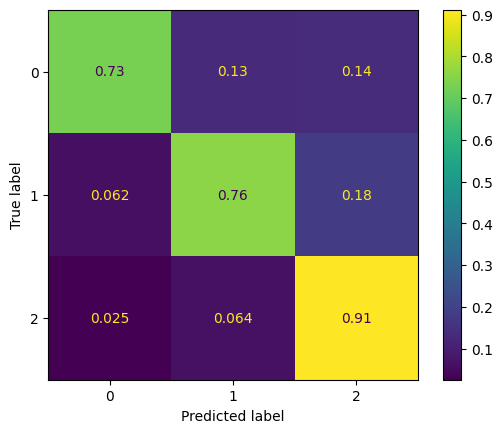

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.41567. Saving Model!
epoch 01, loss: 0.52214, acc: 0.78215, val_loss: 0.41567, val_accuracy: 0.83981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 02, loss: 0.51128, acc: 0.78575, val_loss: 0.42113, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 03, loss: 0.52017, acc: 0.78195, val_loss: 0.42183, val_accuracy: 0.83392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 04, loss: 0.50625, acc: 0.78858, val_loss: 0.42490, val_accuracy: 0.83196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 05, loss: 0.51260, acc: 0.78479, val_loss: 0.42447, val_accuracy: 0.82391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 06, loss: 0.50725, acc: 0.78985, val_loss: 0.42571, val_accuracy: 0.82470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 07, loss: 0.50727, acc: 0.78893, val_loss: 0.42715, val_accuracy: 0.82391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 08, loss: 0.50741, acc: 0.78852, val_loss: 0.42880, val_accuracy: 0.82273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 09, loss: 0.50621, acc: 0.78937, val_loss: 0.42950, val_accuracy: 0.82411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 10, loss: 0.50658, acc: 0.78965, val_loss: 0.42945, val_accuracy: 0.82489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 11, loss: 0.50351, acc: 0.79120, val_loss: 0.43089, val_accuracy: 0.82411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 12, loss: 0.50613, acc: 0.79011, val_loss: 0.43131, val_accuracy: 0.82430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 13, loss: 0.50240, acc: 0.79120, val_loss: 0.43245, val_accuracy: 0.82450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 14, loss: 0.50415, acc: 0.79044, val_loss: 0.43269, val_accuracy: 0.82450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 15, loss: 0.50243, acc: 0.79225, val_loss: 0.43316, val_accuracy: 0.82470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 16, loss: 0.50312, acc: 0.79098, val_loss: 0.43384, val_accuracy: 0.82548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 17, loss: 0.50153, acc: 0.79264, val_loss: 0.43448, val_accuracy: 0.82528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 18, loss: 0.50221, acc: 0.79113, val_loss: 0.43511, val_accuracy: 0.82489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 19, loss: 0.50116, acc: 0.79190, val_loss: 0.43549, val_accuracy: 0.82509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 20, loss: 0.50126, acc: 0.79247, val_loss: 0.43583, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 21, loss: 0.50019, acc: 0.79279, val_loss: 0.43653, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 22, loss: 0.50084, acc: 0.79214, val_loss: 0.43677, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 23, loss: 0.49918, acc: 0.79292, val_loss: 0.43747, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 24, loss: 0.50035, acc: 0.79218, val_loss: 0.43776, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 25, loss: 0.49803, acc: 0.79338, val_loss: 0.43865, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 26, loss: 0.50001, acc: 0.79220, val_loss: 0.43881, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 27, loss: 0.49766, acc: 0.79336, val_loss: 0.43903, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 28, loss: 0.49891, acc: 0.79257, val_loss: 0.43969, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 29, loss: 0.49718, acc: 0.79367, val_loss: 0.44024, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 30, loss: 0.49840, acc: 0.79401, val_loss: 0.44051, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 31, loss: 0.49636, acc: 0.79375, val_loss: 0.44124, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 32, loss: 0.49787, acc: 0.79286, val_loss: 0.44136, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 33, loss: 0.49549, acc: 0.79521, val_loss: 0.44233, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 34, loss: 0.49719, acc: 0.79404, val_loss: 0.44217, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 35, loss: 0.49506, acc: 0.79515, val_loss: 0.44291, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 36, loss: 0.49652, acc: 0.79439, val_loss: 0.44323, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 37, loss: 0.49474, acc: 0.79624, val_loss: 0.44352, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 38, loss: 0.49572, acc: 0.79534, val_loss: 0.44393, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 39, loss: 0.49439, acc: 0.79545, val_loss: 0.44449, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 40, loss: 0.49523, acc: 0.79478, val_loss: 0.44472, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 41, loss: 0.49384, acc: 0.79639, val_loss: 0.44496, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 42, loss: 0.49460, acc: 0.79489, val_loss: 0.44536, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 43, loss: 0.49331, acc: 0.79587, val_loss: 0.44568, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 44, loss: 0.49433, acc: 0.79513, val_loss: 0.44581, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 45, loss: 0.49227, acc: 0.79709, val_loss: 0.44660, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 46, loss: 0.49413, acc: 0.79519, val_loss: 0.44635, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 47, loss: 0.49178, acc: 0.79646, val_loss: 0.44680, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 48, loss: 0.49342, acc: 0.79582, val_loss: 0.44707, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 49, loss: 0.49147, acc: 0.79737, val_loss: 0.44744, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 50, loss: 0.49273, acc: 0.79674, val_loss: 0.44750, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 51, loss: 0.49094, acc: 0.79681, val_loss: 0.44817, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 52, loss: 0.49228, acc: 0.79596, val_loss: 0.44820, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 53, loss: 0.49051, acc: 0.79792, val_loss: 0.44859, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 54, loss: 0.49163, acc: 0.79731, val_loss: 0.44859, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 55, loss: 0.49034, acc: 0.79698, val_loss: 0.44896, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 56, loss: 0.49089, acc: 0.79857, val_loss: 0.44925, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 57, loss: 0.48964, acc: 0.79768, val_loss: 0.44973, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 58, loss: 0.49068, acc: 0.79772, val_loss: 0.44951, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 59, loss: 0.48905, acc: 0.79853, val_loss: 0.45002, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 60, loss: 0.49024, acc: 0.79958, val_loss: 0.45029, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 61, loss: 0.48854, acc: 0.79884, val_loss: 0.45043, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 62, loss: 0.48980, acc: 0.79884, val_loss: 0.45074, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 63, loss: 0.48815, acc: 0.79923, val_loss: 0.45111, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 64, loss: 0.48929, acc: 0.80017, val_loss: 0.45122, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 65, loss: 0.48767, acc: 0.80099, val_loss: 0.45173, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 66, loss: 0.48890, acc: 0.79979, val_loss: 0.45156, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 67, loss: 0.48703, acc: 0.80130, val_loss: 0.45221, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 68, loss: 0.48868, acc: 0.79997, val_loss: 0.45239, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 69, loss: 0.48672, acc: 0.80147, val_loss: 0.45242, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 70, loss: 0.48777, acc: 0.80154, val_loss: 0.45273, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 71, loss: 0.48644, acc: 0.80099, val_loss: 0.45316, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 72, loss: 0.48757, acc: 0.80036, val_loss: 0.45313, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 73, loss: 0.48574, acc: 0.80187, val_loss: 0.45336, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 74, loss: 0.48676, acc: 0.80128, val_loss: 0.45376, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 75, loss: 0.48565, acc: 0.80202, val_loss: 0.45376, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 76, loss: 0.48643, acc: 0.80156, val_loss: 0.45394, val_accuracy: 0.80389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 77, loss: 0.48490, acc: 0.80226, val_loss: 0.45450, val_accuracy: 0.80467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 78, loss: 0.48623, acc: 0.80222, val_loss: 0.45458, val_accuracy: 0.80467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 79, loss: 0.48443, acc: 0.80270, val_loss: 0.45470, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 80, loss: 0.48573, acc: 0.80200, val_loss: 0.45492, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 81, loss: 0.48419, acc: 0.80283, val_loss: 0.45523, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 82, loss: 0.48518, acc: 0.80217, val_loss: 0.45531, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 83, loss: 0.48371, acc: 0.80305, val_loss: 0.45557, val_accuracy: 0.80467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 84, loss: 0.48488, acc: 0.80309, val_loss: 0.45574, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 85, loss: 0.48336, acc: 0.80272, val_loss: 0.45629, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 86, loss: 0.48448, acc: 0.80313, val_loss: 0.45628, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 87, loss: 0.48279, acc: 0.80348, val_loss: 0.45630, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 88, loss: 0.48383, acc: 0.80396, val_loss: 0.45666, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 89, loss: 0.48271, acc: 0.80350, val_loss: 0.45707, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 90, loss: 0.48321, acc: 0.80387, val_loss: 0.45696, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 91, loss: 0.48213, acc: 0.80361, val_loss: 0.45737, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 92, loss: 0.48298, acc: 0.80370, val_loss: 0.45740, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 93, loss: 0.48160, acc: 0.80490, val_loss: 0.45782, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 94, loss: 0.48289, acc: 0.80407, val_loss: 0.45773, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 95, loss: 0.48125, acc: 0.80444, val_loss: 0.45785, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 96, loss: 0.48207, acc: 0.80470, val_loss: 0.45821, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 97, loss: 0.48100, acc: 0.80499, val_loss: 0.45859, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 98, loss: 0.48179, acc: 0.80525, val_loss: 0.45866, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 99, loss: 0.48025, acc: 0.80555, val_loss: 0.45886, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 100, loss: 0.48170, acc: 0.80457, val_loss: 0.45889, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 101, loss: 0.47953, acc: 0.80575, val_loss: 0.45972, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 102, loss: 0.48144, acc: 0.80551, val_loss: 0.45939, val_accuracy: 0.80467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 103, loss: 0.47949, acc: 0.80547, val_loss: 0.45977, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 104, loss: 0.48020, acc: 0.80549, val_loss: 0.45988, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 105, loss: 0.47978, acc: 0.80573, val_loss: 0.45986, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 106, loss: 0.47966, acc: 0.80601, val_loss: 0.46012, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 107, loss: 0.47919, acc: 0.80667, val_loss: 0.46018, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 108, loss: 0.47932, acc: 0.80634, val_loss: 0.46083, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 109, loss: 0.47906, acc: 0.80590, val_loss: 0.46042, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 110, loss: 0.47869, acc: 0.80616, val_loss: 0.46096, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 111, loss: 0.47852, acc: 0.80608, val_loss: 0.46095, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 112, loss: 0.47883, acc: 0.80597, val_loss: 0.46136, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 113, loss: 0.47790, acc: 0.80645, val_loss: 0.46149, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 114, loss: 0.47844, acc: 0.80671, val_loss: 0.46193, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 115, loss: 0.47755, acc: 0.80719, val_loss: 0.46165, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 116, loss: 0.47805, acc: 0.80658, val_loss: 0.46235, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 117, loss: 0.47702, acc: 0.80686, val_loss: 0.46219, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 118, loss: 0.47732, acc: 0.80684, val_loss: 0.46227, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 119, loss: 0.47669, acc: 0.80752, val_loss: 0.46266, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 120, loss: 0.47742, acc: 0.80603, val_loss: 0.46260, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 121, loss: 0.47611, acc: 0.80765, val_loss: 0.46295, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 122, loss: 0.47661, acc: 0.80747, val_loss: 0.46308, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 123, loss: 0.47615, acc: 0.80682, val_loss: 0.46324, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 124, loss: 0.47614, acc: 0.80695, val_loss: 0.46316, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 125, loss: 0.47553, acc: 0.80780, val_loss: 0.46407, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 126, loss: 0.47634, acc: 0.80732, val_loss: 0.46348, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 127, loss: 0.47506, acc: 0.80780, val_loss: 0.46453, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 128, loss: 0.47563, acc: 0.80821, val_loss: 0.46388, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 129, loss: 0.47517, acc: 0.80780, val_loss: 0.46467, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 130, loss: 0.47491, acc: 0.80856, val_loss: 0.46443, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 131, loss: 0.47497, acc: 0.80878, val_loss: 0.46466, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 132, loss: 0.47443, acc: 0.80848, val_loss: 0.46442, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 133, loss: 0.47498, acc: 0.80769, val_loss: 0.46523, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 134, loss: 0.47401, acc: 0.80985, val_loss: 0.46505, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 135, loss: 0.47429, acc: 0.80974, val_loss: 0.46552, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 136, loss: 0.47358, acc: 0.80845, val_loss: 0.46542, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 137, loss: 0.47421, acc: 0.80778, val_loss: 0.46560, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 138, loss: 0.47270, acc: 0.81037, val_loss: 0.46603, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 139, loss: 0.47417, acc: 0.80771, val_loss: 0.46571, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 140, loss: 0.47227, acc: 0.81072, val_loss: 0.46622, val_accuracy: 0.80310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


epoch 141, loss: 0.47365, acc: 0.80789, val_loss: 0.46658, val_accuracy: 0.80369


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 142, loss: 0.47240, acc: 0.80959, val_loss: 0.46609, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.27it/s]


epoch 143, loss: 0.47283, acc: 0.81077, val_loss: 0.46685, val_accuracy: 0.80389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 144, loss: 0.47244, acc: 0.80952, val_loss: 0.46667, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 145, loss: 0.47227, acc: 0.80902, val_loss: 0.46686, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 146, loss: 0.47179, acc: 0.81085, val_loss: 0.46689, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 147, loss: 0.47233, acc: 0.81046, val_loss: 0.46721, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 148, loss: 0.47111, acc: 0.81109, val_loss: 0.46730, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 149, loss: 0.47181, acc: 0.81003, val_loss: 0.46804, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 150, loss: 0.47142, acc: 0.81099, val_loss: 0.46740, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 151, loss: 0.47104, acc: 0.81101, val_loss: 0.46818, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 152, loss: 0.47107, acc: 0.81125, val_loss: 0.46806, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 153, loss: 0.47070, acc: 0.81090, val_loss: 0.46840, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 154, loss: 0.47046, acc: 0.81129, val_loss: 0.46831, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 155, loss: 0.47074, acc: 0.81147, val_loss: 0.46866, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 156, loss: 0.47001, acc: 0.81168, val_loss: 0.46853, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 157, loss: 0.47001, acc: 0.81168, val_loss: 0.46915, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 158, loss: 0.46984, acc: 0.81184, val_loss: 0.46901, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 159, loss: 0.46968, acc: 0.81164, val_loss: 0.46946, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 160, loss: 0.46948, acc: 0.81190, val_loss: 0.46896, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 161, loss: 0.46948, acc: 0.81096, val_loss: 0.46970, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 162, loss: 0.46910, acc: 0.81234, val_loss: 0.46924, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 163, loss: 0.46935, acc: 0.81094, val_loss: 0.47016, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 164, loss: 0.46858, acc: 0.81262, val_loss: 0.47018, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 165, loss: 0.46894, acc: 0.81177, val_loss: 0.47038, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 166, loss: 0.46838, acc: 0.81240, val_loss: 0.46982, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 167, loss: 0.46859, acc: 0.81205, val_loss: 0.47059, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 168, loss: 0.46762, acc: 0.81317, val_loss: 0.47088, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 169, loss: 0.46832, acc: 0.81219, val_loss: 0.47033, val_accuracy: 0.79741


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 170, loss: 0.46714, acc: 0.81249, val_loss: 0.47102, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 171, loss: 0.46777, acc: 0.81256, val_loss: 0.47113, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 172, loss: 0.46733, acc: 0.81284, val_loss: 0.47097, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 173, loss: 0.46707, acc: 0.81290, val_loss: 0.47174, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 174, loss: 0.46724, acc: 0.81260, val_loss: 0.47124, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 175, loss: 0.46653, acc: 0.81221, val_loss: 0.47209, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 176, loss: 0.46696, acc: 0.81317, val_loss: 0.47132, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 177, loss: 0.46640, acc: 0.81286, val_loss: 0.47225, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 178, loss: 0.46654, acc: 0.81358, val_loss: 0.47204, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 179, loss: 0.46589, acc: 0.81343, val_loss: 0.47262, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 180, loss: 0.46612, acc: 0.81321, val_loss: 0.47211, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 181, loss: 0.46555, acc: 0.81323, val_loss: 0.47257, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 182, loss: 0.46582, acc: 0.81354, val_loss: 0.47241, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 183, loss: 0.46521, acc: 0.81384, val_loss: 0.47298, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 184, loss: 0.46525, acc: 0.81365, val_loss: 0.47289, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 185, loss: 0.46494, acc: 0.81371, val_loss: 0.47326, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 186, loss: 0.46494, acc: 0.81395, val_loss: 0.47301, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 187, loss: 0.46436, acc: 0.81391, val_loss: 0.47421, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 188, loss: 0.46494, acc: 0.81384, val_loss: 0.47337, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 189, loss: 0.46394, acc: 0.81424, val_loss: 0.47425, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 190, loss: 0.46453, acc: 0.81439, val_loss: 0.47370, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 191, loss: 0.46351, acc: 0.81441, val_loss: 0.47443, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 192, loss: 0.46445, acc: 0.81410, val_loss: 0.47403, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 193, loss: 0.46323, acc: 0.81476, val_loss: 0.47463, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 194, loss: 0.46381, acc: 0.81439, val_loss: 0.47484, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 195, loss: 0.46324, acc: 0.81480, val_loss: 0.47482, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 196, loss: 0.46363, acc: 0.81421, val_loss: 0.47490, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 197, loss: 0.46258, acc: 0.81502, val_loss: 0.47480, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 198, loss: 0.46329, acc: 0.81452, val_loss: 0.47537, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 199, loss: 0.46217, acc: 0.81509, val_loss: 0.47510, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 200, loss: 0.46318, acc: 0.81467, val_loss: 0.47545, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 201, loss: 0.46195, acc: 0.81515, val_loss: 0.47554, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 202, loss: 0.46242, acc: 0.81498, val_loss: 0.47582, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 203, loss: 0.46152, acc: 0.81533, val_loss: 0.47558, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 204, loss: 0.46192, acc: 0.81500, val_loss: 0.47586, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 205, loss: 0.46162, acc: 0.81583, val_loss: 0.47567, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


epoch 206, loss: 0.46126, acc: 0.81533, val_loss: 0.47653, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 207, loss: 0.46138, acc: 0.81557, val_loss: 0.47616, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 208, loss: 0.46099, acc: 0.81513, val_loss: 0.47659, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 209, loss: 0.46118, acc: 0.81624, val_loss: 0.47628, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 210, loss: 0.46053, acc: 0.81541, val_loss: 0.47706, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 211, loss: 0.46092, acc: 0.81609, val_loss: 0.47600, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 212, loss: 0.46028, acc: 0.81535, val_loss: 0.47732, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 213, loss: 0.46039, acc: 0.81637, val_loss: 0.47658, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 214, loss: 0.46008, acc: 0.81585, val_loss: 0.47735, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 215, loss: 0.46025, acc: 0.81646, val_loss: 0.47681, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 216, loss: 0.45945, acc: 0.81568, val_loss: 0.47813, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 217, loss: 0.45980, acc: 0.81661, val_loss: 0.47709, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 218, loss: 0.45966, acc: 0.81530, val_loss: 0.47792, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 219, loss: 0.45933, acc: 0.81640, val_loss: 0.47753, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 220, loss: 0.45902, acc: 0.81616, val_loss: 0.47856, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 221, loss: 0.45886, acc: 0.81709, val_loss: 0.47789, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 222, loss: 0.45960, acc: 0.81596, val_loss: 0.47819, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 223, loss: 0.45800, acc: 0.81731, val_loss: 0.47830, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 224, loss: 0.45882, acc: 0.81640, val_loss: 0.47890, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 225, loss: 0.45812, acc: 0.81709, val_loss: 0.47811, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 226, loss: 0.45875, acc: 0.81605, val_loss: 0.47883, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 227, loss: 0.45731, acc: 0.81740, val_loss: 0.47920, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 228, loss: 0.45872, acc: 0.81640, val_loss: 0.47911, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 229, loss: 0.45661, acc: 0.81718, val_loss: 0.47937, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 230, loss: 0.45821, acc: 0.81681, val_loss: 0.47902, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 231, loss: 0.45682, acc: 0.81679, val_loss: 0.47951, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 232, loss: 0.45730, acc: 0.81701, val_loss: 0.47975, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 233, loss: 0.45689, acc: 0.81725, val_loss: 0.47950, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 234, loss: 0.45665, acc: 0.81696, val_loss: 0.48016, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 235, loss: 0.45667, acc: 0.81740, val_loss: 0.48025, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 236, loss: 0.45703, acc: 0.81672, val_loss: 0.47987, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 237, loss: 0.45534, acc: 0.81788, val_loss: 0.48080, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 238, loss: 0.45704, acc: 0.81661, val_loss: 0.48041, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 239, loss: 0.45543, acc: 0.81779, val_loss: 0.48067, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 240, loss: 0.45649, acc: 0.81716, val_loss: 0.48110, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 241, loss: 0.45490, acc: 0.81877, val_loss: 0.48092, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 242, loss: 0.45575, acc: 0.81766, val_loss: 0.48118, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 243, loss: 0.45484, acc: 0.81775, val_loss: 0.48145, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 244, loss: 0.45586, acc: 0.81729, val_loss: 0.48122, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 245, loss: 0.45403, acc: 0.81971, val_loss: 0.48189, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 246, loss: 0.45538, acc: 0.81812, val_loss: 0.48211, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 247, loss: 0.45451, acc: 0.81840, val_loss: 0.48148, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 248, loss: 0.45442, acc: 0.81838, val_loss: 0.48264, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 249, loss: 0.45422, acc: 0.81797, val_loss: 0.48214, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 250, loss: 0.45444, acc: 0.81869, val_loss: 0.48160, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 251, loss: 0.45316, acc: 0.81838, val_loss: 0.48319, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 252, loss: 0.45454, acc: 0.82039, val_loss: 0.48222, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 253, loss: 0.45282, acc: 0.82100, val_loss: 0.48255, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 254, loss: 0.45372, acc: 0.81991, val_loss: 0.48298, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 255, loss: 0.45293, acc: 0.82126, val_loss: 0.48235, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 256, loss: 0.45314, acc: 0.82098, val_loss: 0.48327, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 257, loss: 0.45284, acc: 0.81975, val_loss: 0.48294, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 258, loss: 0.45270, acc: 0.82021, val_loss: 0.48366, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 259, loss: 0.45276, acc: 0.82115, val_loss: 0.48305, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 260, loss: 0.45237, acc: 0.82139, val_loss: 0.48397, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 261, loss: 0.45255, acc: 0.82154, val_loss: 0.48358, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 262, loss: 0.45220, acc: 0.82119, val_loss: 0.48402, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 263, loss: 0.45166, acc: 0.82159, val_loss: 0.48394, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 264, loss: 0.45229, acc: 0.82135, val_loss: 0.48449, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 265, loss: 0.45108, acc: 0.82187, val_loss: 0.48404, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 266, loss: 0.45195, acc: 0.82056, val_loss: 0.48453, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 267, loss: 0.45082, acc: 0.82172, val_loss: 0.48450, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 268, loss: 0.45110, acc: 0.82082, val_loss: 0.48498, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 269, loss: 0.45083, acc: 0.82200, val_loss: 0.48440, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 270, loss: 0.45101, acc: 0.82069, val_loss: 0.48557, val_accuracy: 0.79741


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 271, loss: 0.45062, acc: 0.82180, val_loss: 0.48453, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 272, loss: 0.45056, acc: 0.82180, val_loss: 0.48579, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 273, loss: 0.45052, acc: 0.82207, val_loss: 0.48456, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 274, loss: 0.45019, acc: 0.82113, val_loss: 0.48635, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 275, loss: 0.45002, acc: 0.82231, val_loss: 0.48462, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 276, loss: 0.44963, acc: 0.82231, val_loss: 0.48653, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 277, loss: 0.45005, acc: 0.82281, val_loss: 0.48551, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 278, loss: 0.44926, acc: 0.82237, val_loss: 0.48640, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 279, loss: 0.44959, acc: 0.82231, val_loss: 0.48496, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 280, loss: 0.44880, acc: 0.82263, val_loss: 0.48692, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 281, loss: 0.44942, acc: 0.82246, val_loss: 0.48581, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 282, loss: 0.44836, acc: 0.82161, val_loss: 0.48745, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 283, loss: 0.44907, acc: 0.82255, val_loss: 0.48583, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 284, loss: 0.44849, acc: 0.82185, val_loss: 0.48739, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 285, loss: 0.44848, acc: 0.82303, val_loss: 0.48645, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 286, loss: 0.44837, acc: 0.82270, val_loss: 0.48738, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 287, loss: 0.44807, acc: 0.82294, val_loss: 0.48675, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 288, loss: 0.44780, acc: 0.82300, val_loss: 0.48763, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 289, loss: 0.44767, acc: 0.82300, val_loss: 0.48626, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 290, loss: 0.44783, acc: 0.82228, val_loss: 0.48785, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 291, loss: 0.44726, acc: 0.82366, val_loss: 0.48713, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 292, loss: 0.44706, acc: 0.82407, val_loss: 0.48818, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 293, loss: 0.44730, acc: 0.82338, val_loss: 0.48695, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 294, loss: 0.44693, acc: 0.82292, val_loss: 0.48899, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 295, loss: 0.44686, acc: 0.82381, val_loss: 0.48723, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 296, loss: 0.44642, acc: 0.82357, val_loss: 0.48897, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 297, loss: 0.44693, acc: 0.82368, val_loss: 0.48721, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 298, loss: 0.44607, acc: 0.82431, val_loss: 0.48912, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 299, loss: 0.44629, acc: 0.82379, val_loss: 0.48793, val_accuracy: 0.79741


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 300, loss: 0.44561, acc: 0.82355, val_loss: 0.48962, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 301, loss: 0.44623, acc: 0.82471, val_loss: 0.48848, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 302, loss: 0.44521, acc: 0.82484, val_loss: 0.48938, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 303, loss: 0.44545, acc: 0.82525, val_loss: 0.48863, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 304, loss: 0.44529, acc: 0.82497, val_loss: 0.48967, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 305, loss: 0.44511, acc: 0.82516, val_loss: 0.48949, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 306, loss: 0.44490, acc: 0.82492, val_loss: 0.48962, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 307, loss: 0.44549, acc: 0.82499, val_loss: 0.48906, val_accuracy: 0.79721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 308, loss: 0.44388, acc: 0.82593, val_loss: 0.49015, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 309, loss: 0.44536, acc: 0.82516, val_loss: 0.48973, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 310, loss: 0.44357, acc: 0.82617, val_loss: 0.48992, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 311, loss: 0.44499, acc: 0.82510, val_loss: 0.48992, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


epoch 312, loss: 0.44323, acc: 0.82608, val_loss: 0.49082, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 313, loss: 0.44483, acc: 0.82508, val_loss: 0.48995, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 314, loss: 0.44278, acc: 0.82628, val_loss: 0.49062, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 315, loss: 0.44441, acc: 0.82562, val_loss: 0.49072, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 316, loss: 0.44289, acc: 0.82673, val_loss: 0.49076, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 317, loss: 0.44371, acc: 0.82553, val_loss: 0.49082, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 318, loss: 0.44260, acc: 0.82634, val_loss: 0.49144, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 319, loss: 0.44388, acc: 0.82577, val_loss: 0.49043, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 320, loss: 0.44180, acc: 0.82645, val_loss: 0.49173, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 321, loss: 0.44353, acc: 0.82604, val_loss: 0.49174, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 322, loss: 0.44176, acc: 0.82673, val_loss: 0.49160, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 323, loss: 0.44284, acc: 0.82619, val_loss: 0.49132, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 324, loss: 0.44192, acc: 0.82628, val_loss: 0.49165, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 325, loss: 0.44221, acc: 0.82660, val_loss: 0.49184, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 326, loss: 0.44157, acc: 0.82654, val_loss: 0.49234, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 327, loss: 0.44206, acc: 0.82663, val_loss: 0.49177, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 328, loss: 0.44099, acc: 0.82673, val_loss: 0.49302, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 329, loss: 0.44226, acc: 0.82673, val_loss: 0.49174, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 330, loss: 0.44059, acc: 0.82652, val_loss: 0.49293, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 331, loss: 0.44136, acc: 0.82704, val_loss: 0.49233, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 332, loss: 0.44093, acc: 0.82671, val_loss: 0.49310, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 333, loss: 0.44074, acc: 0.82684, val_loss: 0.49232, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 334, loss: 0.44088, acc: 0.82697, val_loss: 0.49322, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 335, loss: 0.44033, acc: 0.82724, val_loss: 0.49244, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 336, loss: 0.43990, acc: 0.82750, val_loss: 0.49413, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 337, loss: 0.44101, acc: 0.82656, val_loss: 0.49297, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 338, loss: 0.43952, acc: 0.82756, val_loss: 0.49348, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.32it/s]


epoch 339, loss: 0.44075, acc: 0.82647, val_loss: 0.49318, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 340, loss: 0.43869, acc: 0.82789, val_loss: 0.49482, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 341, loss: 0.44085, acc: 0.82695, val_loss: 0.49283, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 342, loss: 0.43798, acc: 0.82761, val_loss: 0.49445, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 343, loss: 0.44064, acc: 0.82669, val_loss: 0.49329, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 344, loss: 0.43779, acc: 0.82785, val_loss: 0.49475, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 345, loss: 0.44007, acc: 0.82689, val_loss: 0.49377, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 346, loss: 0.43755, acc: 0.82756, val_loss: 0.49530, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 347, loss: 0.43942, acc: 0.82717, val_loss: 0.49363, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 348, loss: 0.43759, acc: 0.82763, val_loss: 0.49523, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 349, loss: 0.43885, acc: 0.82741, val_loss: 0.49468, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 350, loss: 0.43779, acc: 0.82776, val_loss: 0.49475, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 351, loss: 0.43811, acc: 0.82743, val_loss: 0.49510, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 352, loss: 0.43745, acc: 0.82833, val_loss: 0.49596, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 353, loss: 0.43838, acc: 0.82721, val_loss: 0.49461, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 354, loss: 0.43646, acc: 0.82826, val_loss: 0.49586, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 355, loss: 0.43859, acc: 0.82743, val_loss: 0.49513, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 356, loss: 0.43623, acc: 0.82911, val_loss: 0.49577, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 357, loss: 0.43839, acc: 0.82750, val_loss: 0.49567, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 358, loss: 0.43605, acc: 0.82920, val_loss: 0.49543, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 359, loss: 0.43735, acc: 0.82759, val_loss: 0.49622, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 360, loss: 0.43570, acc: 0.82826, val_loss: 0.49706, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 361, loss: 0.43751, acc: 0.82776, val_loss: 0.49607, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 362, loss: 0.43520, acc: 0.82870, val_loss: 0.49696, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 363, loss: 0.43730, acc: 0.82791, val_loss: 0.49649, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 364, loss: 0.43488, acc: 0.82937, val_loss: 0.49699, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 365, loss: 0.43651, acc: 0.82789, val_loss: 0.49676, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 366, loss: 0.43551, acc: 0.82937, val_loss: 0.49633, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 367, loss: 0.43568, acc: 0.82870, val_loss: 0.49782, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 368, loss: 0.43513, acc: 0.82981, val_loss: 0.49717, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 369, loss: 0.43578, acc: 0.82892, val_loss: 0.49783, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 370, loss: 0.43502, acc: 0.82972, val_loss: 0.49679, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 371, loss: 0.43532, acc: 0.82935, val_loss: 0.49828, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 372, loss: 0.43484, acc: 0.82977, val_loss: 0.49766, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 373, loss: 0.43478, acc: 0.82929, val_loss: 0.49767, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 374, loss: 0.43419, acc: 0.82968, val_loss: 0.49797, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 375, loss: 0.43465, acc: 0.82944, val_loss: 0.49757, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 376, loss: 0.43395, acc: 0.83014, val_loss: 0.49832, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 377, loss: 0.43421, acc: 0.82966, val_loss: 0.49818, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 378, loss: 0.43362, acc: 0.83009, val_loss: 0.49862, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 379, loss: 0.43415, acc: 0.83012, val_loss: 0.49814, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 380, loss: 0.43342, acc: 0.82998, val_loss: 0.49809, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 381, loss: 0.43373, acc: 0.83016, val_loss: 0.49905, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 382, loss: 0.43361, acc: 0.83001, val_loss: 0.49856, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 383, loss: 0.43273, acc: 0.83042, val_loss: 0.49918, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 384, loss: 0.43387, acc: 0.82977, val_loss: 0.49923, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 385, loss: 0.43208, acc: 0.83112, val_loss: 0.49933, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 386, loss: 0.43356, acc: 0.83007, val_loss: 0.49910, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 387, loss: 0.43177, acc: 0.83075, val_loss: 0.50011, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.90it/s]


epoch 388, loss: 0.43332, acc: 0.83055, val_loss: 0.49878, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 389, loss: 0.43111, acc: 0.83079, val_loss: 0.50084, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 390, loss: 0.43355, acc: 0.83042, val_loss: 0.49921, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 391, loss: 0.43085, acc: 0.83060, val_loss: 0.50018, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 392, loss: 0.43238, acc: 0.83097, val_loss: 0.50037, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 393, loss: 0.43176, acc: 0.83068, val_loss: 0.50023, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 394, loss: 0.43103, acc: 0.83127, val_loss: 0.50039, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 395, loss: 0.43170, acc: 0.83097, val_loss: 0.50090, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 396, loss: 0.43111, acc: 0.83125, val_loss: 0.50088, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 397, loss: 0.43103, acc: 0.83110, val_loss: 0.50108, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 398, loss: 0.43096, acc: 0.83140, val_loss: 0.50076, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 399, loss: 0.43068, acc: 0.83134, val_loss: 0.50190, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 400, loss: 0.43080, acc: 0.83116, val_loss: 0.50134, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 401, loss: 0.43052, acc: 0.83138, val_loss: 0.50129, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 402, loss: 0.43107, acc: 0.83099, val_loss: 0.50194, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 403, loss: 0.42944, acc: 0.83249, val_loss: 0.50210, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 404, loss: 0.43119, acc: 0.83110, val_loss: 0.50164, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 405, loss: 0.42914, acc: 0.83177, val_loss: 0.50245, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 406, loss: 0.43104, acc: 0.83103, val_loss: 0.50229, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 407, loss: 0.42824, acc: 0.83238, val_loss: 0.50263, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 408, loss: 0.43124, acc: 0.83121, val_loss: 0.50258, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 409, loss: 0.42762, acc: 0.83280, val_loss: 0.50255, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 410, loss: 0.43053, acc: 0.83171, val_loss: 0.50307, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 411, loss: 0.42812, acc: 0.83267, val_loss: 0.50383, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 412, loss: 0.42949, acc: 0.83199, val_loss: 0.50250, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 413, loss: 0.42803, acc: 0.83238, val_loss: 0.50403, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 414, loss: 0.42968, acc: 0.83188, val_loss: 0.50269, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 415, loss: 0.42772, acc: 0.83276, val_loss: 0.50397, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 416, loss: 0.42879, acc: 0.83252, val_loss: 0.50325, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 417, loss: 0.42807, acc: 0.83254, val_loss: 0.50388, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 418, loss: 0.42827, acc: 0.83249, val_loss: 0.50352, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 419, loss: 0.42760, acc: 0.83225, val_loss: 0.50426, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 420, loss: 0.42813, acc: 0.83228, val_loss: 0.50444, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 421, loss: 0.42736, acc: 0.83260, val_loss: 0.50388, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 422, loss: 0.42730, acc: 0.83267, val_loss: 0.50483, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 423, loss: 0.42767, acc: 0.83249, val_loss: 0.50422, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 424, loss: 0.42715, acc: 0.83337, val_loss: 0.50464, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 425, loss: 0.42711, acc: 0.83228, val_loss: 0.50546, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 426, loss: 0.42713, acc: 0.83387, val_loss: 0.50457, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 427, loss: 0.42670, acc: 0.83372, val_loss: 0.50460, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 428, loss: 0.42623, acc: 0.83324, val_loss: 0.50512, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 429, loss: 0.42735, acc: 0.83306, val_loss: 0.50506, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 430, loss: 0.42573, acc: 0.83430, val_loss: 0.50478, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 431, loss: 0.42659, acc: 0.83345, val_loss: 0.50591, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 432, loss: 0.42624, acc: 0.83400, val_loss: 0.50479, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 433, loss: 0.42553, acc: 0.83415, val_loss: 0.50660, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 434, loss: 0.42575, acc: 0.83419, val_loss: 0.50569, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 435, loss: 0.42587, acc: 0.83382, val_loss: 0.50593, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 436, loss: 0.42566, acc: 0.83487, val_loss: 0.50539, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 437, loss: 0.42506, acc: 0.83367, val_loss: 0.50713, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 438, loss: 0.42599, acc: 0.83378, val_loss: 0.50533, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 439, loss: 0.42434, acc: 0.83454, val_loss: 0.50717, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 440, loss: 0.42498, acc: 0.83411, val_loss: 0.50558, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 441, loss: 0.42517, acc: 0.83426, val_loss: 0.50663, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 442, loss: 0.42413, acc: 0.83419, val_loss: 0.50668, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 443, loss: 0.42473, acc: 0.83419, val_loss: 0.50773, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 444, loss: 0.42474, acc: 0.83443, val_loss: 0.50645, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 445, loss: 0.42398, acc: 0.83443, val_loss: 0.50851, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 446, loss: 0.42474, acc: 0.83393, val_loss: 0.50697, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 447, loss: 0.42380, acc: 0.83459, val_loss: 0.50787, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 448, loss: 0.42435, acc: 0.83450, val_loss: 0.50678, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 449, loss: 0.42259, acc: 0.83557, val_loss: 0.50835, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 450, loss: 0.42531, acc: 0.83400, val_loss: 0.50705, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 451, loss: 0.42184, acc: 0.83561, val_loss: 0.50796, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 452, loss: 0.42476, acc: 0.83443, val_loss: 0.50746, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 453, loss: 0.42202, acc: 0.83535, val_loss: 0.50790, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 454, loss: 0.42432, acc: 0.83511, val_loss: 0.50749, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 455, loss: 0.42180, acc: 0.83598, val_loss: 0.50811, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 456, loss: 0.42419, acc: 0.83441, val_loss: 0.50788, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 457, loss: 0.42147, acc: 0.83603, val_loss: 0.50874, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 458, loss: 0.42406, acc: 0.83446, val_loss: 0.50704, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 459, loss: 0.42048, acc: 0.83555, val_loss: 0.50978, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 460, loss: 0.42378, acc: 0.83481, val_loss: 0.50821, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 461, loss: 0.42021, acc: 0.83640, val_loss: 0.50968, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 462, loss: 0.42322, acc: 0.83515, val_loss: 0.50752, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 463, loss: 0.42082, acc: 0.83607, val_loss: 0.50920, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 464, loss: 0.42276, acc: 0.83544, val_loss: 0.50818, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 465, loss: 0.42027, acc: 0.83633, val_loss: 0.50965, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 466, loss: 0.42305, acc: 0.83467, val_loss: 0.50887, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 467, loss: 0.41944, acc: 0.83681, val_loss: 0.50941, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 468, loss: 0.42238, acc: 0.83596, val_loss: 0.50898, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 469, loss: 0.41954, acc: 0.83673, val_loss: 0.51057, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 470, loss: 0.42254, acc: 0.83587, val_loss: 0.50857, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 471, loss: 0.41876, acc: 0.83703, val_loss: 0.51031, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 472, loss: 0.42272, acc: 0.83561, val_loss: 0.50940, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 473, loss: 0.41821, acc: 0.83760, val_loss: 0.51089, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 474, loss: 0.42210, acc: 0.83566, val_loss: 0.50903, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 475, loss: 0.41818, acc: 0.83764, val_loss: 0.51134, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 476, loss: 0.42230, acc: 0.83583, val_loss: 0.50899, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 477, loss: 0.41794, acc: 0.83758, val_loss: 0.51165, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 478, loss: 0.42183, acc: 0.83622, val_loss: 0.50828, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 479, loss: 0.41741, acc: 0.83760, val_loss: 0.51120, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 480, loss: 0.42081, acc: 0.83673, val_loss: 0.50949, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 481, loss: 0.41756, acc: 0.83773, val_loss: 0.51188, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 482, loss: 0.42017, acc: 0.83714, val_loss: 0.50969, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 483, loss: 0.41753, acc: 0.83784, val_loss: 0.51246, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 484, loss: 0.41975, acc: 0.83686, val_loss: 0.50879, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 485, loss: 0.41738, acc: 0.83793, val_loss: 0.51223, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 486, loss: 0.42002, acc: 0.83731, val_loss: 0.50934, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 487, loss: 0.41672, acc: 0.83806, val_loss: 0.51264, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 488, loss: 0.41993, acc: 0.83740, val_loss: 0.50969, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 489, loss: 0.41574, acc: 0.83836, val_loss: 0.51246, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 490, loss: 0.42039, acc: 0.83694, val_loss: 0.51013, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 491, loss: 0.41555, acc: 0.83838, val_loss: 0.51294, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 492, loss: 0.41996, acc: 0.83742, val_loss: 0.51022, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 493, loss: 0.41521, acc: 0.83838, val_loss: 0.51350, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 494, loss: 0.41973, acc: 0.83718, val_loss: 0.50998, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 495, loss: 0.41498, acc: 0.83840, val_loss: 0.51412, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 496, loss: 0.41912, acc: 0.83701, val_loss: 0.51065, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 497, loss: 0.41465, acc: 0.83875, val_loss: 0.51378, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 498, loss: 0.41845, acc: 0.83727, val_loss: 0.51013, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 499, loss: 0.41434, acc: 0.83864, val_loss: 0.51501, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 500, loss: 0.41869, acc: 0.83747, val_loss: 0.51050, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 501, loss: 0.41379, acc: 0.83910, val_loss: 0.51418, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 502, loss: 0.41806, acc: 0.83762, val_loss: 0.51075, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 503, loss: 0.41455, acc: 0.83875, val_loss: 0.51426, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 504, loss: 0.41829, acc: 0.83797, val_loss: 0.51148, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 505, loss: 0.41367, acc: 0.83928, val_loss: 0.51525, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 506, loss: 0.41837, acc: 0.83799, val_loss: 0.51048, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 507, loss: 0.41294, acc: 0.83947, val_loss: 0.51494, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 508, loss: 0.41744, acc: 0.83797, val_loss: 0.51043, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 509, loss: 0.41338, acc: 0.83943, val_loss: 0.51465, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 510, loss: 0.41675, acc: 0.83845, val_loss: 0.51149, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 511, loss: 0.41294, acc: 0.83965, val_loss: 0.51532, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 512, loss: 0.41699, acc: 0.83834, val_loss: 0.51133, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 513, loss: 0.41202, acc: 0.83984, val_loss: 0.51516, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 514, loss: 0.41687, acc: 0.83830, val_loss: 0.51220, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 515, loss: 0.41197, acc: 0.83991, val_loss: 0.51551, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 516, loss: 0.41648, acc: 0.83917, val_loss: 0.51274, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 517, loss: 0.41182, acc: 0.84032, val_loss: 0.51511, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 518, loss: 0.41607, acc: 0.83873, val_loss: 0.51258, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 519, loss: 0.41179, acc: 0.84056, val_loss: 0.51583, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 520, loss: 0.41605, acc: 0.83880, val_loss: 0.51238, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 521, loss: 0.41105, acc: 0.84046, val_loss: 0.51695, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 522, loss: 0.41596, acc: 0.83963, val_loss: 0.51213, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 523, loss: 0.41075, acc: 0.84054, val_loss: 0.51769, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 524, loss: 0.41549, acc: 0.83864, val_loss: 0.51204, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 525, loss: 0.41062, acc: 0.84041, val_loss: 0.51683, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 526, loss: 0.41503, acc: 0.83963, val_loss: 0.51317, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 527, loss: 0.41051, acc: 0.84091, val_loss: 0.51746, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 528, loss: 0.41511, acc: 0.83945, val_loss: 0.51311, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 529, loss: 0.41013, acc: 0.84118, val_loss: 0.51808, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 530, loss: 0.41450, acc: 0.84000, val_loss: 0.51320, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 531, loss: 0.40980, acc: 0.84067, val_loss: 0.51798, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 532, loss: 0.41470, acc: 0.83976, val_loss: 0.51316, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 533, loss: 0.40955, acc: 0.84104, val_loss: 0.51771, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 534, loss: 0.41444, acc: 0.83954, val_loss: 0.51433, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 535, loss: 0.40929, acc: 0.84172, val_loss: 0.51848, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 536, loss: 0.41385, acc: 0.83984, val_loss: 0.51347, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 537, loss: 0.40887, acc: 0.84120, val_loss: 0.51825, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 538, loss: 0.41402, acc: 0.83932, val_loss: 0.51459, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 539, loss: 0.40844, acc: 0.84133, val_loss: 0.51917, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 540, loss: 0.41336, acc: 0.84037, val_loss: 0.51396, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 541, loss: 0.40883, acc: 0.84152, val_loss: 0.51900, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 542, loss: 0.41335, acc: 0.84032, val_loss: 0.51445, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 543, loss: 0.40834, acc: 0.84159, val_loss: 0.51936, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 544, loss: 0.41337, acc: 0.84043, val_loss: 0.51394, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 545, loss: 0.40703, acc: 0.84181, val_loss: 0.52005, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 546, loss: 0.41341, acc: 0.84032, val_loss: 0.51480, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 547, loss: 0.40745, acc: 0.84183, val_loss: 0.52010, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 548, loss: 0.41255, acc: 0.84067, val_loss: 0.51532, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 549, loss: 0.40749, acc: 0.84174, val_loss: 0.52053, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 550, loss: 0.41297, acc: 0.84050, val_loss: 0.51519, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 551, loss: 0.40656, acc: 0.84227, val_loss: 0.52034, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 552, loss: 0.41255, acc: 0.84072, val_loss: 0.51519, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 553, loss: 0.40632, acc: 0.84235, val_loss: 0.52026, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 554, loss: 0.41180, acc: 0.84118, val_loss: 0.51534, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 555, loss: 0.40644, acc: 0.84205, val_loss: 0.52070, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 556, loss: 0.41219, acc: 0.84087, val_loss: 0.51539, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 557, loss: 0.40599, acc: 0.84242, val_loss: 0.52112, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 558, loss: 0.41112, acc: 0.84098, val_loss: 0.51601, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 559, loss: 0.40612, acc: 0.84246, val_loss: 0.52049, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 560, loss: 0.41041, acc: 0.84104, val_loss: 0.51477, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 561, loss: 0.40640, acc: 0.84224, val_loss: 0.52056, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 562, loss: 0.41073, acc: 0.84150, val_loss: 0.51670, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 563, loss: 0.40554, acc: 0.84303, val_loss: 0.52086, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 564, loss: 0.41033, acc: 0.84135, val_loss: 0.51589, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 565, loss: 0.40525, acc: 0.84264, val_loss: 0.52142, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 566, loss: 0.40996, acc: 0.84174, val_loss: 0.51644, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 567, loss: 0.40511, acc: 0.84240, val_loss: 0.52200, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 568, loss: 0.41001, acc: 0.84124, val_loss: 0.51723, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 569, loss: 0.40424, acc: 0.84351, val_loss: 0.52242, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 570, loss: 0.40940, acc: 0.84220, val_loss: 0.51691, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 571, loss: 0.40481, acc: 0.84279, val_loss: 0.52302, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 572, loss: 0.40925, acc: 0.84200, val_loss: 0.51696, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 573, loss: 0.40430, acc: 0.84296, val_loss: 0.52342, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 574, loss: 0.40937, acc: 0.84205, val_loss: 0.51760, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 575, loss: 0.40330, acc: 0.84336, val_loss: 0.52320, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 576, loss: 0.40934, acc: 0.84179, val_loss: 0.51689, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 577, loss: 0.40337, acc: 0.84357, val_loss: 0.52321, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 578, loss: 0.40827, acc: 0.84251, val_loss: 0.51786, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 579, loss: 0.40387, acc: 0.84331, val_loss: 0.52344, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 580, loss: 0.40868, acc: 0.84190, val_loss: 0.51833, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 581, loss: 0.40311, acc: 0.84362, val_loss: 0.52378, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 582, loss: 0.40853, acc: 0.84218, val_loss: 0.51724, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 583, loss: 0.40273, acc: 0.84347, val_loss: 0.52408, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 584, loss: 0.40814, acc: 0.84238, val_loss: 0.51743, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 585, loss: 0.40235, acc: 0.84351, val_loss: 0.52460, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 586, loss: 0.40803, acc: 0.84240, val_loss: 0.51892, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 587, loss: 0.40146, acc: 0.84364, val_loss: 0.52526, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 588, loss: 0.40812, acc: 0.84253, val_loss: 0.51918, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 589, loss: 0.40178, acc: 0.84364, val_loss: 0.52480, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 590, loss: 0.40662, acc: 0.84296, val_loss: 0.52003, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 591, loss: 0.40284, acc: 0.84338, val_loss: 0.52472, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


epoch 592, loss: 0.40699, acc: 0.84262, val_loss: 0.51920, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 593, loss: 0.40156, acc: 0.84429, val_loss: 0.52590, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 594, loss: 0.40703, acc: 0.84240, val_loss: 0.51973, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 595, loss: 0.40075, acc: 0.84403, val_loss: 0.52518, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 596, loss: 0.40713, acc: 0.84251, val_loss: 0.51967, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 597, loss: 0.40035, acc: 0.84421, val_loss: 0.52557, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 598, loss: 0.40618, acc: 0.84292, val_loss: 0.52022, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 599, loss: 0.40117, acc: 0.84401, val_loss: 0.52623, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 600, loss: 0.40577, acc: 0.84303, val_loss: 0.51984, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 601, loss: 0.40067, acc: 0.84469, val_loss: 0.52637, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 602, loss: 0.40575, acc: 0.84296, val_loss: 0.52062, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 603, loss: 0.40020, acc: 0.84412, val_loss: 0.52686, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 604, loss: 0.40533, acc: 0.84333, val_loss: 0.52033, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 605, loss: 0.39988, acc: 0.84467, val_loss: 0.52679, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 606, loss: 0.40502, acc: 0.84390, val_loss: 0.52092, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 607, loss: 0.39956, acc: 0.84460, val_loss: 0.52759, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 608, loss: 0.40531, acc: 0.84344, val_loss: 0.52076, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 609, loss: 0.39975, acc: 0.84462, val_loss: 0.52758, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 610, loss: 0.40497, acc: 0.84349, val_loss: 0.52174, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 611, loss: 0.39941, acc: 0.84536, val_loss: 0.52810, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 612, loss: 0.40518, acc: 0.84375, val_loss: 0.52063, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 613, loss: 0.39834, acc: 0.84580, val_loss: 0.52822, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 614, loss: 0.40488, acc: 0.84429, val_loss: 0.52247, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 615, loss: 0.39810, acc: 0.84523, val_loss: 0.52778, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 616, loss: 0.40452, acc: 0.84388, val_loss: 0.52270, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 617, loss: 0.39796, acc: 0.84554, val_loss: 0.52754, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 618, loss: 0.40474, acc: 0.84395, val_loss: 0.52314, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


epoch 619, loss: 0.39802, acc: 0.84580, val_loss: 0.52804, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 620, loss: 0.40376, acc: 0.84423, val_loss: 0.52278, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


epoch 621, loss: 0.39757, acc: 0.84619, val_loss: 0.52883, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 622, loss: 0.40385, acc: 0.84392, val_loss: 0.52131, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 623, loss: 0.39654, acc: 0.84582, val_loss: 0.52981, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 624, loss: 0.40380, acc: 0.84432, val_loss: 0.52195, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 625, loss: 0.39684, acc: 0.84571, val_loss: 0.52926, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 626, loss: 0.40284, acc: 0.84484, val_loss: 0.52371, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 627, loss: 0.39754, acc: 0.84578, val_loss: 0.52948, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 628, loss: 0.40244, acc: 0.84464, val_loss: 0.52273, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 629, loss: 0.39704, acc: 0.84578, val_loss: 0.53066, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 630, loss: 0.40286, acc: 0.84458, val_loss: 0.52365, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 631, loss: 0.39622, acc: 0.84639, val_loss: 0.53020, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 632, loss: 0.40336, acc: 0.84471, val_loss: 0.52253, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 633, loss: 0.39529, acc: 0.84608, val_loss: 0.53130, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 634, loss: 0.40276, acc: 0.84510, val_loss: 0.52363, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 635, loss: 0.39604, acc: 0.84604, val_loss: 0.53113, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 636, loss: 0.40173, acc: 0.84532, val_loss: 0.52338, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 637, loss: 0.39574, acc: 0.84643, val_loss: 0.53081, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 638, loss: 0.40229, acc: 0.84519, val_loss: 0.52469, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 639, loss: 0.39521, acc: 0.84665, val_loss: 0.53225, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 640, loss: 0.40156, acc: 0.84532, val_loss: 0.52435, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 641, loss: 0.39525, acc: 0.84713, val_loss: 0.53123, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 642, loss: 0.40099, acc: 0.84541, val_loss: 0.52389, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 643, loss: 0.39453, acc: 0.84617, val_loss: 0.53164, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 644, loss: 0.40112, acc: 0.84565, val_loss: 0.52539, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 645, loss: 0.39414, acc: 0.84665, val_loss: 0.53182, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 646, loss: 0.40103, acc: 0.84556, val_loss: 0.52572, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 647, loss: 0.39396, acc: 0.84680, val_loss: 0.53317, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 648, loss: 0.40066, acc: 0.84587, val_loss: 0.52556, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 649, loss: 0.39402, acc: 0.84672, val_loss: 0.53327, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 650, loss: 0.40072, acc: 0.84600, val_loss: 0.52470, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 651, loss: 0.39403, acc: 0.84768, val_loss: 0.53352, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 652, loss: 0.39983, acc: 0.84600, val_loss: 0.52518, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 653, loss: 0.39415, acc: 0.84606, val_loss: 0.53233, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 654, loss: 0.40023, acc: 0.84578, val_loss: 0.52714, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 655, loss: 0.39342, acc: 0.84772, val_loss: 0.53289, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 656, loss: 0.40002, acc: 0.84582, val_loss: 0.52654, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 657, loss: 0.39291, acc: 0.84816, val_loss: 0.53405, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 658, loss: 0.39918, acc: 0.84626, val_loss: 0.52729, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 659, loss: 0.39290, acc: 0.84752, val_loss: 0.53361, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 660, loss: 0.39879, acc: 0.84626, val_loss: 0.52739, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 661, loss: 0.39260, acc: 0.84687, val_loss: 0.53424, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 662, loss: 0.39893, acc: 0.84648, val_loss: 0.52671, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 663, loss: 0.39244, acc: 0.84741, val_loss: 0.53505, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 664, loss: 0.39929, acc: 0.84628, val_loss: 0.52680, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 665, loss: 0.39194, acc: 0.84850, val_loss: 0.53564, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 666, loss: 0.39908, acc: 0.84630, val_loss: 0.52676, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 667, loss: 0.39149, acc: 0.84794, val_loss: 0.53510, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 668, loss: 0.39901, acc: 0.84624, val_loss: 0.52698, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 669, loss: 0.39104, acc: 0.84754, val_loss: 0.53629, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 670, loss: 0.39929, acc: 0.84650, val_loss: 0.52811, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 671, loss: 0.39050, acc: 0.84848, val_loss: 0.53673, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 672, loss: 0.39821, acc: 0.84713, val_loss: 0.52794, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 673, loss: 0.39128, acc: 0.84750, val_loss: 0.53629, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 674, loss: 0.39747, acc: 0.84696, val_loss: 0.52819, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 675, loss: 0.39148, acc: 0.84829, val_loss: 0.53616, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 676, loss: 0.39721, acc: 0.84706, val_loss: 0.52854, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 677, loss: 0.39076, acc: 0.84800, val_loss: 0.53701, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 678, loss: 0.39745, acc: 0.84713, val_loss: 0.52851, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 679, loss: 0.39020, acc: 0.84848, val_loss: 0.53792, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 680, loss: 0.39680, acc: 0.84737, val_loss: 0.52982, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 681, loss: 0.39015, acc: 0.84883, val_loss: 0.53760, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 682, loss: 0.39631, acc: 0.84765, val_loss: 0.52950, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 683, loss: 0.39013, acc: 0.84809, val_loss: 0.53830, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 684, loss: 0.39655, acc: 0.84763, val_loss: 0.52934, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 685, loss: 0.38949, acc: 0.84903, val_loss: 0.53861, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 686, loss: 0.39685, acc: 0.84750, val_loss: 0.53056, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 687, loss: 0.38908, acc: 0.84866, val_loss: 0.53956, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 688, loss: 0.39621, acc: 0.84800, val_loss: 0.53067, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 689, loss: 0.38984, acc: 0.84831, val_loss: 0.53917, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 690, loss: 0.39590, acc: 0.84770, val_loss: 0.53046, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 691, loss: 0.38906, acc: 0.84918, val_loss: 0.53947, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 692, loss: 0.39627, acc: 0.84796, val_loss: 0.53089, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 693, loss: 0.38820, acc: 0.84929, val_loss: 0.54064, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 694, loss: 0.39620, acc: 0.84778, val_loss: 0.53102, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 695, loss: 0.38768, acc: 0.84881, val_loss: 0.54055, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 696, loss: 0.39585, acc: 0.84813, val_loss: 0.53230, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 697, loss: 0.38789, acc: 0.84938, val_loss: 0.54073, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 698, loss: 0.39566, acc: 0.84831, val_loss: 0.53068, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 699, loss: 0.38809, acc: 0.85014, val_loss: 0.54064, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 700, loss: 0.39504, acc: 0.84816, val_loss: 0.53161, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 701, loss: 0.38726, acc: 0.84966, val_loss: 0.54171, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 702, loss: 0.39537, acc: 0.84833, val_loss: 0.53197, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 703, loss: 0.38706, acc: 0.84909, val_loss: 0.54140, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 704, loss: 0.39463, acc: 0.84850, val_loss: 0.53056, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 705, loss: 0.38787, acc: 0.84933, val_loss: 0.54079, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 706, loss: 0.39443, acc: 0.84859, val_loss: 0.53294, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 707, loss: 0.38712, acc: 0.85003, val_loss: 0.54122, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 708, loss: 0.39458, acc: 0.84859, val_loss: 0.53256, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 709, loss: 0.38626, acc: 0.85012, val_loss: 0.54310, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 710, loss: 0.39478, acc: 0.84855, val_loss: 0.53247, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 711, loss: 0.38541, acc: 0.84979, val_loss: 0.54325, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 712, loss: 0.39458, acc: 0.84874, val_loss: 0.53258, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 713, loss: 0.38561, acc: 0.85034, val_loss: 0.54284, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 714, loss: 0.39371, acc: 0.84903, val_loss: 0.53244, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 715, loss: 0.38613, acc: 0.84992, val_loss: 0.54362, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 716, loss: 0.39331, acc: 0.84946, val_loss: 0.53297, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 717, loss: 0.38582, acc: 0.85005, val_loss: 0.54302, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 718, loss: 0.39337, acc: 0.84914, val_loss: 0.53384, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 719, loss: 0.38508, acc: 0.85032, val_loss: 0.54313, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 720, loss: 0.39259, acc: 0.84901, val_loss: 0.53394, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 721, loss: 0.38603, acc: 0.84970, val_loss: 0.54366, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 722, loss: 0.39254, acc: 0.84957, val_loss: 0.53466, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 723, loss: 0.38549, acc: 0.85064, val_loss: 0.54391, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 724, loss: 0.39223, acc: 0.84920, val_loss: 0.53368, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 725, loss: 0.38499, acc: 0.85034, val_loss: 0.54397, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 726, loss: 0.39216, acc: 0.84920, val_loss: 0.53565, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 727, loss: 0.38434, acc: 0.84977, val_loss: 0.54355, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 728, loss: 0.39221, acc: 0.84931, val_loss: 0.53508, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 729, loss: 0.38385, acc: 0.85099, val_loss: 0.54405, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 730, loss: 0.39217, acc: 0.84944, val_loss: 0.53505, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 731, loss: 0.38364, acc: 0.85110, val_loss: 0.54535, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 732, loss: 0.39155, acc: 0.85003, val_loss: 0.53428, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 733, loss: 0.38429, acc: 0.85008, val_loss: 0.54623, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 734, loss: 0.39155, acc: 0.84966, val_loss: 0.53620, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 735, loss: 0.38341, acc: 0.85112, val_loss: 0.54567, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 736, loss: 0.39212, acc: 0.84988, val_loss: 0.53521, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 737, loss: 0.38253, acc: 0.85112, val_loss: 0.54532, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 738, loss: 0.39155, acc: 0.84970, val_loss: 0.53714, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 739, loss: 0.38301, acc: 0.85029, val_loss: 0.54508, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 740, loss: 0.39190, acc: 0.84857, val_loss: 0.53655, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 741, loss: 0.38201, acc: 0.85149, val_loss: 0.54742, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 742, loss: 0.39229, acc: 0.84837, val_loss: 0.53549, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 743, loss: 0.38164, acc: 0.85114, val_loss: 0.54683, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 744, loss: 0.39081, acc: 0.85021, val_loss: 0.53593, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 745, loss: 0.38262, acc: 0.85088, val_loss: 0.54519, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 746, loss: 0.39009, acc: 0.85014, val_loss: 0.53700, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 747, loss: 0.38220, acc: 0.85156, val_loss: 0.54656, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 748, loss: 0.38973, acc: 0.85023, val_loss: 0.53693, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 749, loss: 0.38166, acc: 0.85071, val_loss: 0.54673, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 750, loss: 0.38946, acc: 0.85005, val_loss: 0.53656, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 751, loss: 0.38227, acc: 0.85101, val_loss: 0.54650, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 752, loss: 0.38919, acc: 0.85058, val_loss: 0.53764, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 753, loss: 0.38174, acc: 0.85134, val_loss: 0.54810, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 754, loss: 0.38961, acc: 0.85038, val_loss: 0.53674, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 755, loss: 0.38086, acc: 0.85182, val_loss: 0.54826, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 756, loss: 0.38988, acc: 0.85071, val_loss: 0.53697, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 757, loss: 0.38041, acc: 0.85158, val_loss: 0.54781, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 758, loss: 0.38972, acc: 0.84940, val_loss: 0.53819, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 759, loss: 0.38024, acc: 0.85204, val_loss: 0.54875, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 760, loss: 0.38949, acc: 0.85047, val_loss: 0.53709, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 761, loss: 0.38053, acc: 0.85106, val_loss: 0.54854, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 762, loss: 0.38955, acc: 0.85053, val_loss: 0.53870, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 763, loss: 0.38015, acc: 0.85208, val_loss: 0.54986, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 764, loss: 0.38897, acc: 0.85077, val_loss: 0.53768, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 765, loss: 0.37989, acc: 0.85175, val_loss: 0.54972, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 766, loss: 0.38839, acc: 0.85106, val_loss: 0.53822, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 767, loss: 0.37989, acc: 0.85189, val_loss: 0.54971, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 768, loss: 0.38806, acc: 0.85121, val_loss: 0.53973, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 769, loss: 0.37911, acc: 0.85274, val_loss: 0.54926, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 770, loss: 0.38804, acc: 0.85047, val_loss: 0.53951, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 771, loss: 0.37923, acc: 0.85158, val_loss: 0.54907, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 772, loss: 0.38849, acc: 0.85008, val_loss: 0.54019, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 773, loss: 0.37896, acc: 0.85241, val_loss: 0.55077, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 774, loss: 0.38842, acc: 0.85130, val_loss: 0.53841, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 775, loss: 0.37842, acc: 0.85234, val_loss: 0.55147, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 776, loss: 0.38811, acc: 0.85132, val_loss: 0.53971, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 777, loss: 0.37786, acc: 0.85271, val_loss: 0.55067, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 778, loss: 0.38712, acc: 0.85029, val_loss: 0.54019, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 779, loss: 0.37853, acc: 0.85265, val_loss: 0.55135, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 780, loss: 0.38630, acc: 0.85016, val_loss: 0.53954, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 781, loss: 0.37854, acc: 0.85197, val_loss: 0.55136, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 782, loss: 0.38698, acc: 0.85173, val_loss: 0.54085, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 783, loss: 0.37826, acc: 0.85306, val_loss: 0.55105, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 784, loss: 0.38675, acc: 0.85154, val_loss: 0.54063, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 785, loss: 0.37752, acc: 0.85324, val_loss: 0.55247, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 786, loss: 0.38680, acc: 0.85151, val_loss: 0.53981, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 787, loss: 0.37707, acc: 0.85322, val_loss: 0.55276, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 788, loss: 0.38647, acc: 0.85064, val_loss: 0.54131, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 789, loss: 0.37676, acc: 0.85311, val_loss: 0.55351, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 790, loss: 0.38654, acc: 0.85066, val_loss: 0.54026, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 791, loss: 0.37707, acc: 0.85258, val_loss: 0.55376, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 792, loss: 0.38675, acc: 0.85208, val_loss: 0.54158, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 793, loss: 0.37692, acc: 0.85367, val_loss: 0.55367, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 794, loss: 0.38590, acc: 0.85234, val_loss: 0.54042, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 795, loss: 0.37659, acc: 0.85337, val_loss: 0.55364, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 796, loss: 0.38532, acc: 0.85121, val_loss: 0.54130, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 797, loss: 0.37658, acc: 0.85304, val_loss: 0.55345, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 798, loss: 0.38455, acc: 0.85263, val_loss: 0.54184, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 799, loss: 0.37628, acc: 0.85363, val_loss: 0.55388, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 800, loss: 0.38467, acc: 0.85237, val_loss: 0.54387, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 801, loss: 0.37601, acc: 0.85359, val_loss: 0.55268, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 802, loss: 0.38453, acc: 0.85256, val_loss: 0.54392, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 803, loss: 0.37544, acc: 0.85405, val_loss: 0.55473, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 804, loss: 0.38473, acc: 0.85252, val_loss: 0.54267, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 805, loss: 0.37541, acc: 0.85367, val_loss: 0.55376, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 806, loss: 0.38464, acc: 0.85149, val_loss: 0.54225, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 807, loss: 0.37525, acc: 0.85365, val_loss: 0.55637, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 808, loss: 0.38507, acc: 0.85282, val_loss: 0.54172, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 809, loss: 0.37477, acc: 0.85378, val_loss: 0.55629, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 810, loss: 0.38417, acc: 0.85184, val_loss: 0.54120, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 811, loss: 0.37466, acc: 0.85398, val_loss: 0.55600, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 812, loss: 0.38331, acc: 0.85199, val_loss: 0.54363, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 813, loss: 0.37511, acc: 0.85289, val_loss: 0.55521, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 814, loss: 0.38316, acc: 0.85298, val_loss: 0.54343, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 815, loss: 0.37462, acc: 0.85409, val_loss: 0.55545, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 816, loss: 0.38281, acc: 0.85291, val_loss: 0.54473, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 817, loss: 0.37450, acc: 0.85411, val_loss: 0.55539, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 818, loss: 0.38274, acc: 0.85276, val_loss: 0.54375, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 819, loss: 0.37377, acc: 0.85448, val_loss: 0.55527, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 820, loss: 0.38266, acc: 0.85298, val_loss: 0.54566, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 821, loss: 0.37409, acc: 0.85357, val_loss: 0.55581, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 822, loss: 0.38311, acc: 0.85145, val_loss: 0.54599, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 823, loss: 0.37350, acc: 0.85459, val_loss: 0.55736, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 824, loss: 0.38242, acc: 0.85311, val_loss: 0.54362, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 825, loss: 0.37290, acc: 0.85485, val_loss: 0.55757, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 826, loss: 0.38277, acc: 0.85202, val_loss: 0.54403, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 827, loss: 0.37310, acc: 0.85348, val_loss: 0.55740, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 828, loss: 0.38229, acc: 0.85298, val_loss: 0.54591, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 829, loss: 0.37292, acc: 0.85507, val_loss: 0.55813, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 830, loss: 0.38192, acc: 0.85333, val_loss: 0.54316, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 831, loss: 0.37241, acc: 0.85540, val_loss: 0.55880, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 832, loss: 0.38170, acc: 0.85357, val_loss: 0.54526, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 833, loss: 0.37276, acc: 0.85494, val_loss: 0.55761, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 834, loss: 0.38178, acc: 0.85348, val_loss: 0.54503, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 835, loss: 0.37239, acc: 0.85538, val_loss: 0.55945, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 836, loss: 0.38092, acc: 0.85357, val_loss: 0.54462, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 837, loss: 0.37223, acc: 0.85470, val_loss: 0.55917, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 838, loss: 0.38053, acc: 0.85367, val_loss: 0.54481, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 839, loss: 0.37265, acc: 0.85413, val_loss: 0.55694, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 840, loss: 0.37971, acc: 0.85387, val_loss: 0.54746, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 841, loss: 0.37276, acc: 0.85525, val_loss: 0.55724, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 842, loss: 0.37970, acc: 0.85348, val_loss: 0.54597, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 843, loss: 0.37179, acc: 0.85590, val_loss: 0.55935, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 844, loss: 0.37988, acc: 0.85370, val_loss: 0.54730, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 845, loss: 0.37139, acc: 0.85516, val_loss: 0.55747, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 846, loss: 0.37975, acc: 0.85365, val_loss: 0.54681, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 847, loss: 0.37124, acc: 0.85601, val_loss: 0.55920, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 848, loss: 0.38017, acc: 0.85381, val_loss: 0.54755, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 849, loss: 0.37100, acc: 0.85596, val_loss: 0.56001, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 850, loss: 0.38012, acc: 0.85385, val_loss: 0.54636, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 851, loss: 0.37022, acc: 0.85594, val_loss: 0.56115, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 852, loss: 0.38008, acc: 0.85370, val_loss: 0.54674, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 853, loss: 0.37015, acc: 0.85588, val_loss: 0.55997, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 854, loss: 0.37960, acc: 0.85407, val_loss: 0.54793, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 855, loss: 0.36971, acc: 0.85675, val_loss: 0.56066, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 856, loss: 0.37935, acc: 0.85394, val_loss: 0.54758, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 857, loss: 0.37002, acc: 0.85618, val_loss: 0.55988, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 858, loss: 0.37947, acc: 0.85413, val_loss: 0.54762, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 859, loss: 0.36968, acc: 0.85634, val_loss: 0.56287, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 860, loss: 0.37977, acc: 0.85304, val_loss: 0.54698, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 861, loss: 0.36901, acc: 0.85618, val_loss: 0.56168, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 862, loss: 0.37998, acc: 0.85326, val_loss: 0.54719, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 863, loss: 0.36899, acc: 0.85605, val_loss: 0.56268, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 864, loss: 0.37989, acc: 0.85311, val_loss: 0.54829, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 865, loss: 0.36862, acc: 0.85673, val_loss: 0.56340, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 866, loss: 0.37955, acc: 0.85343, val_loss: 0.54743, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 867, loss: 0.36826, acc: 0.85660, val_loss: 0.56343, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 868, loss: 0.37901, acc: 0.85470, val_loss: 0.54771, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 869, loss: 0.36809, acc: 0.85658, val_loss: 0.56230, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 870, loss: 0.37868, acc: 0.85372, val_loss: 0.54890, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 871, loss: 0.36821, acc: 0.85644, val_loss: 0.56334, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 872, loss: 0.37788, acc: 0.85352, val_loss: 0.54850, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 873, loss: 0.36874, acc: 0.85688, val_loss: 0.56259, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 874, loss: 0.37649, acc: 0.85400, val_loss: 0.54930, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 875, loss: 0.36890, acc: 0.85568, val_loss: 0.56191, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 876, loss: 0.37649, acc: 0.85505, val_loss: 0.55112, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 877, loss: 0.36891, acc: 0.85673, val_loss: 0.56103, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 878, loss: 0.37560, acc: 0.85522, val_loss: 0.55068, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 879, loss: 0.36851, acc: 0.85725, val_loss: 0.56188, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 880, loss: 0.37565, acc: 0.85455, val_loss: 0.55056, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 881, loss: 0.36819, acc: 0.85725, val_loss: 0.56102, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 882, loss: 0.37497, acc: 0.85572, val_loss: 0.55086, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 883, loss: 0.36813, acc: 0.85727, val_loss: 0.56074, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 884, loss: 0.37478, acc: 0.85501, val_loss: 0.55161, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 885, loss: 0.36786, acc: 0.85686, val_loss: 0.56217, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 886, loss: 0.37587, acc: 0.85514, val_loss: 0.55072, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 887, loss: 0.36712, acc: 0.85760, val_loss: 0.56297, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 888, loss: 0.37609, acc: 0.85503, val_loss: 0.55075, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 889, loss: 0.36652, acc: 0.85710, val_loss: 0.56502, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 890, loss: 0.37696, acc: 0.85420, val_loss: 0.54913, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 891, loss: 0.36580, acc: 0.85747, val_loss: 0.56562, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 892, loss: 0.37699, acc: 0.85453, val_loss: 0.55006, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 893, loss: 0.36584, acc: 0.85734, val_loss: 0.56552, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 894, loss: 0.37696, acc: 0.85420, val_loss: 0.54893, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 895, loss: 0.36568, acc: 0.85760, val_loss: 0.56537, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 896, loss: 0.37724, acc: 0.85339, val_loss: 0.54889, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 897, loss: 0.36548, acc: 0.85738, val_loss: 0.56843, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 898, loss: 0.37703, acc: 0.85376, val_loss: 0.54893, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 899, loss: 0.36486, acc: 0.85745, val_loss: 0.56786, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 900, loss: 0.37692, acc: 0.85370, val_loss: 0.54991, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 901, loss: 0.36443, acc: 0.85758, val_loss: 0.56585, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 902, loss: 0.37590, acc: 0.85453, val_loss: 0.55229, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 903, loss: 0.36479, acc: 0.85793, val_loss: 0.56624, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 904, loss: 0.37522, acc: 0.85444, val_loss: 0.55046, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 905, loss: 0.36444, acc: 0.85839, val_loss: 0.56658, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 906, loss: 0.37514, acc: 0.85588, val_loss: 0.55105, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 907, loss: 0.36440, acc: 0.85788, val_loss: 0.56620, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 908, loss: 0.37474, acc: 0.85498, val_loss: 0.55282, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 909, loss: 0.36486, acc: 0.85804, val_loss: 0.56525, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 910, loss: 0.37342, acc: 0.85490, val_loss: 0.55189, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 911, loss: 0.36497, acc: 0.85799, val_loss: 0.56490, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 912, loss: 0.37268, acc: 0.85634, val_loss: 0.55299, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 913, loss: 0.36482, acc: 0.85788, val_loss: 0.56542, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 914, loss: 0.37220, acc: 0.85620, val_loss: 0.55223, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 915, loss: 0.36506, acc: 0.85703, val_loss: 0.56521, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 916, loss: 0.37204, acc: 0.85620, val_loss: 0.55407, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 917, loss: 0.36429, acc: 0.85839, val_loss: 0.56537, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 918, loss: 0.37227, acc: 0.85601, val_loss: 0.55304, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 919, loss: 0.36450, acc: 0.85778, val_loss: 0.56594, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 920, loss: 0.37141, acc: 0.85662, val_loss: 0.55519, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 921, loss: 0.36471, acc: 0.85780, val_loss: 0.56574, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 922, loss: 0.37174, acc: 0.85634, val_loss: 0.55371, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 923, loss: 0.36415, acc: 0.85815, val_loss: 0.56727, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 924, loss: 0.37149, acc: 0.85660, val_loss: 0.55454, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 925, loss: 0.36364, acc: 0.85804, val_loss: 0.56680, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 926, loss: 0.37239, acc: 0.85627, val_loss: 0.55351, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 927, loss: 0.36305, acc: 0.85795, val_loss: 0.56684, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 928, loss: 0.37274, acc: 0.85636, val_loss: 0.55548, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 929, loss: 0.36270, acc: 0.85858, val_loss: 0.56984, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 930, loss: 0.37294, acc: 0.85590, val_loss: 0.55274, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 931, loss: 0.36209, acc: 0.85850, val_loss: 0.57072, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 932, loss: 0.37297, acc: 0.85453, val_loss: 0.55377, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 933, loss: 0.36238, acc: 0.85810, val_loss: 0.56903, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 934, loss: 0.37322, acc: 0.85444, val_loss: 0.55612, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 935, loss: 0.36181, acc: 0.85874, val_loss: 0.57121, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 936, loss: 0.37381, acc: 0.85466, val_loss: 0.55260, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 937, loss: 0.36107, acc: 0.85841, val_loss: 0.57185, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 938, loss: 0.37267, acc: 0.85494, val_loss: 0.55484, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 939, loss: 0.36209, acc: 0.85815, val_loss: 0.56861, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 940, loss: 0.37123, acc: 0.85625, val_loss: 0.55541, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 941, loss: 0.36159, acc: 0.85874, val_loss: 0.57091, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 942, loss: 0.37072, acc: 0.85719, val_loss: 0.55518, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 943, loss: 0.36138, acc: 0.85865, val_loss: 0.57054, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 944, loss: 0.37018, acc: 0.85736, val_loss: 0.55597, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 945, loss: 0.36176, acc: 0.85876, val_loss: 0.56963, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 946, loss: 0.36937, acc: 0.85651, val_loss: 0.55762, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 947, loss: 0.36152, acc: 0.85889, val_loss: 0.56912, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 948, loss: 0.36980, acc: 0.85607, val_loss: 0.55681, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 949, loss: 0.36150, acc: 0.85906, val_loss: 0.56910, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 950, loss: 0.36978, acc: 0.85743, val_loss: 0.55815, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 951, loss: 0.36106, acc: 0.85911, val_loss: 0.57129, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 952, loss: 0.36940, acc: 0.85764, val_loss: 0.55745, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 953, loss: 0.36109, acc: 0.85893, val_loss: 0.57116, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 954, loss: 0.37025, acc: 0.85620, val_loss: 0.55886, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 955, loss: 0.36026, acc: 0.85915, val_loss: 0.57227, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 956, loss: 0.37031, acc: 0.85644, val_loss: 0.55748, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 957, loss: 0.35966, acc: 0.85919, val_loss: 0.57244, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 958, loss: 0.37052, acc: 0.85544, val_loss: 0.55770, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 959, loss: 0.35943, acc: 0.85926, val_loss: 0.57298, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 960, loss: 0.37027, acc: 0.85559, val_loss: 0.55704, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 961, loss: 0.35888, acc: 0.85972, val_loss: 0.57524, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 962, loss: 0.37077, acc: 0.85564, val_loss: 0.55731, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 963, loss: 0.35891, acc: 0.85961, val_loss: 0.57521, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 964, loss: 0.37088, acc: 0.85538, val_loss: 0.55837, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 965, loss: 0.35898, acc: 0.85908, val_loss: 0.57595, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 966, loss: 0.37061, acc: 0.85614, val_loss: 0.55660, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 967, loss: 0.35866, acc: 0.85924, val_loss: 0.57597, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 968, loss: 0.37053, acc: 0.85596, val_loss: 0.55846, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 969, loss: 0.35885, acc: 0.85980, val_loss: 0.57645, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 970, loss: 0.37016, acc: 0.85618, val_loss: 0.55787, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 971, loss: 0.35808, acc: 0.85965, val_loss: 0.57570, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 972, loss: 0.36958, acc: 0.85610, val_loss: 0.55930, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 973, loss: 0.35798, acc: 0.85983, val_loss: 0.57478, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 974, loss: 0.36936, acc: 0.85625, val_loss: 0.55907, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 975, loss: 0.35815, acc: 0.85991, val_loss: 0.57528, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 976, loss: 0.36889, acc: 0.85614, val_loss: 0.56079, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 977, loss: 0.35794, acc: 0.86020, val_loss: 0.57606, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 978, loss: 0.36877, acc: 0.85701, val_loss: 0.56031, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 979, loss: 0.35751, acc: 0.85983, val_loss: 0.57602, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 980, loss: 0.36822, acc: 0.85662, val_loss: 0.56038, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 981, loss: 0.35769, acc: 0.85976, val_loss: 0.57462, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 982, loss: 0.36788, acc: 0.85754, val_loss: 0.56200, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 983, loss: 0.35709, acc: 0.86048, val_loss: 0.57650, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 984, loss: 0.36801, acc: 0.85797, val_loss: 0.56034, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 985, loss: 0.35698, acc: 0.86079, val_loss: 0.57555, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 986, loss: 0.36790, acc: 0.85607, val_loss: 0.56124, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 987, loss: 0.35701, acc: 0.86033, val_loss: 0.57767, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 988, loss: 0.36791, acc: 0.85771, val_loss: 0.55994, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 989, loss: 0.35661, acc: 0.86048, val_loss: 0.57811, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 990, loss: 0.36804, acc: 0.85675, val_loss: 0.55879, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 991, loss: 0.35643, acc: 0.86039, val_loss: 0.57699, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 992, loss: 0.36744, acc: 0.85671, val_loss: 0.56245, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.32it/s]


epoch 993, loss: 0.35678, acc: 0.86063, val_loss: 0.57815, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 994, loss: 0.36667, acc: 0.85850, val_loss: 0.56108, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 995, loss: 0.35667, acc: 0.86026, val_loss: 0.57761, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 996, loss: 0.36600, acc: 0.85767, val_loss: 0.56275, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 997, loss: 0.35732, acc: 0.86037, val_loss: 0.57695, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 998, loss: 0.36502, acc: 0.85996, val_loss: 0.56383, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 999, loss: 0.35643, acc: 0.86065, val_loss: 0.57723, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 1000, loss: 0.36452, acc: 0.85972, val_loss: 0.56379, val_accuracy: 0.79270
5번째 교차검증
evaluation loss: 0.41762, evaluation accuracy: 0.83294
(6, 5094)
(5094, 6)
Learning rate set to 0.085977
0:	learn: 1.0059946	total: 2.07ms	remaining: 2.06s
1:	learn: 0.9314813	total: 4.12ms	remaining: 2.06s
2:	learn: 0.8699938	total: 5.78ms	remaining: 1.92s
3:	learn: 0.8186737	total: 7.75ms	remaining: 1.93s
4:	learn: 0.7766116	total: 9.62ms	remaining: 1.91s
5:	learn: 0.7386646	total: 11.5ms	remaining: 1.9s
6:	learn: 0.7075813	total: 13.3ms	remaining: 1.88s
7:	learn: 0.6819509	total: 14.7ms	remaining: 1.83s
8:	learn: 0.6590356	total: 16.5ms	remaining: 1.82s
9:	learn: 0.6388309	total: 18.3ms	remaining: 1.81s
10:	learn: 0.6211652	total: 20.2ms	remaining: 1.81s
11:	learn: 0.6062522	total: 22ms	remaining: 1.81s
12:	learn: 0.5926945	total: 23.9ms	remaining: 1.81s
13:	learn: 0.5805944	total: 25.7ms	remaining: 1.81s
14:	learn: 0.5706788	total: 27.4ms	remaining: 1.8s
15:	learn: 0.5606613	total: 29.4ms	rem

207:	learn: 0.4257613	total: 378ms	remaining: 1.44s
208:	learn: 0.4256974	total: 380ms	remaining: 1.44s
209:	learn: 0.4256622	total: 382ms	remaining: 1.44s
210:	learn: 0.4255533	total: 384ms	remaining: 1.44s
211:	learn: 0.4254587	total: 386ms	remaining: 1.43s
212:	learn: 0.4254237	total: 388ms	remaining: 1.43s
213:	learn: 0.4253528	total: 390ms	remaining: 1.43s
214:	learn: 0.4253166	total: 391ms	remaining: 1.43s
215:	learn: 0.4252665	total: 393ms	remaining: 1.43s
216:	learn: 0.4252315	total: 395ms	remaining: 1.42s
217:	learn: 0.4251683	total: 397ms	remaining: 1.42s
218:	learn: 0.4250934	total: 398ms	remaining: 1.42s
219:	learn: 0.4250098	total: 400ms	remaining: 1.42s
220:	learn: 0.4249094	total: 402ms	remaining: 1.42s
221:	learn: 0.4248109	total: 404ms	remaining: 1.41s
222:	learn: 0.4247515	total: 406ms	remaining: 1.41s
223:	learn: 0.4247006	total: 407ms	remaining: 1.41s
224:	learn: 0.4246026	total: 409ms	remaining: 1.41s
225:	learn: 0.4245413	total: 411ms	remaining: 1.41s
226:	learn: 

424:	learn: 0.4167387	total: 777ms	remaining: 1.05s
425:	learn: 0.4166684	total: 779ms	remaining: 1.05s
426:	learn: 0.4166535	total: 781ms	remaining: 1.05s
427:	learn: 0.4166431	total: 783ms	remaining: 1.05s
428:	learn: 0.4166274	total: 784ms	remaining: 1.04s
429:	learn: 0.4165907	total: 786ms	remaining: 1.04s
430:	learn: 0.4165749	total: 788ms	remaining: 1.04s
431:	learn: 0.4165672	total: 790ms	remaining: 1.04s
432:	learn: 0.4165600	total: 791ms	remaining: 1.04s
433:	learn: 0.4165447	total: 793ms	remaining: 1.03s
434:	learn: 0.4165243	total: 795ms	remaining: 1.03s
435:	learn: 0.4165178	total: 797ms	remaining: 1.03s
436:	learn: 0.4164914	total: 799ms	remaining: 1.03s
437:	learn: 0.4164693	total: 800ms	remaining: 1.03s
438:	learn: 0.4164377	total: 802ms	remaining: 1.02s
439:	learn: 0.4164163	total: 804ms	remaining: 1.02s
440:	learn: 0.4163847	total: 806ms	remaining: 1.02s
441:	learn: 0.4163532	total: 807ms	remaining: 1.02s
442:	learn: 0.4163343	total: 809ms	remaining: 1.02s
443:	learn: 

642:	learn: 0.4135209	total: 1.18s	remaining: 654ms
643:	learn: 0.4135160	total: 1.18s	remaining: 652ms
644:	learn: 0.4135086	total: 1.18s	remaining: 651ms
645:	learn: 0.4134938	total: 1.18s	remaining: 649ms
646:	learn: 0.4134889	total: 1.19s	remaining: 647ms
647:	learn: 0.4134787	total: 1.19s	remaining: 646ms
648:	learn: 0.4134689	total: 1.19s	remaining: 644ms
649:	learn: 0.4134643	total: 1.19s	remaining: 642ms
650:	learn: 0.4134275	total: 1.19s	remaining: 640ms
651:	learn: 0.4134125	total: 1.2s	remaining: 638ms
652:	learn: 0.4134067	total: 1.2s	remaining: 637ms
653:	learn: 0.4134023	total: 1.2s	remaining: 635ms
654:	learn: 0.4133980	total: 1.2s	remaining: 633ms
655:	learn: 0.4133418	total: 1.2s	remaining: 631ms
656:	learn: 0.4133380	total: 1.21s	remaining: 629ms
657:	learn: 0.4133338	total: 1.21s	remaining: 627ms
658:	learn: 0.4133297	total: 1.21s	remaining: 626ms
659:	learn: 0.4133257	total: 1.21s	remaining: 624ms
660:	learn: 0.4133215	total: 1.21s	remaining: 622ms
661:	learn: 0.413

856:	learn: 0.4119296	total: 1.58s	remaining: 264ms
857:	learn: 0.4119178	total: 1.58s	remaining: 262ms
858:	learn: 0.4118996	total: 1.58s	remaining: 260ms
859:	learn: 0.4118914	total: 1.58s	remaining: 258ms
860:	learn: 0.4118892	total: 1.59s	remaining: 256ms
861:	learn: 0.4118824	total: 1.59s	remaining: 254ms
862:	learn: 0.4118701	total: 1.59s	remaining: 253ms
863:	learn: 0.4118649	total: 1.59s	remaining: 251ms
864:	learn: 0.4118623	total: 1.59s	remaining: 249ms
865:	learn: 0.4118604	total: 1.6s	remaining: 247ms
866:	learn: 0.4118579	total: 1.6s	remaining: 245ms
867:	learn: 0.4118471	total: 1.6s	remaining: 243ms
868:	learn: 0.4118451	total: 1.6s	remaining: 241ms
869:	learn: 0.4118426	total: 1.6s	remaining: 240ms
870:	learn: 0.4118352	total: 1.6s	remaining: 238ms
871:	learn: 0.4118333	total: 1.61s	remaining: 236ms
872:	learn: 0.4118308	total: 1.61s	remaining: 234ms
873:	learn: 0.4118290	total: 1.61s	remaining: 232ms
874:	learn: 0.4118171	total: 1.61s	remaining: 231ms
875:	learn: 0.4118

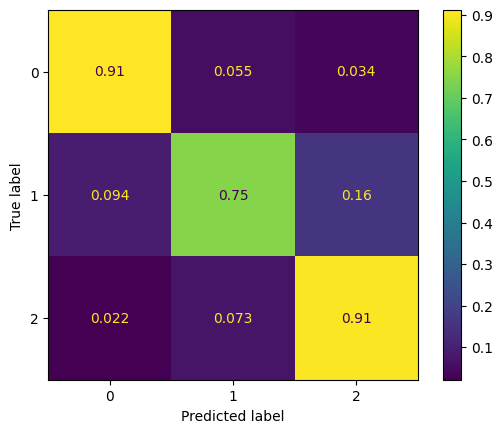

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.47834. Saving Model!
epoch 01, loss: 0.50852, acc: 0.78684, val_loss: 0.47834, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 02, loss: 0.50653, acc: 0.78795, val_loss: 0.49055, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 03, loss: 0.50291, acc: 0.79031, val_loss: 0.49800, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 04, loss: 0.50316, acc: 0.79011, val_loss: 0.50105, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 05, loss: 0.50126, acc: 0.79168, val_loss: 0.50775, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 06, loss: 0.49884, acc: 0.79301, val_loss: 0.51376, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 07, loss: 0.49883, acc: 0.79310, val_loss: 0.51545, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 08, loss: 0.49762, acc: 0.79347, val_loss: 0.51786, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 09, loss: 0.49640, acc: 0.79423, val_loss: 0.52112, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 10, loss: 0.49632, acc: 0.79508, val_loss: 0.52320, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 11, loss: 0.49532, acc: 0.79578, val_loss: 0.52518, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 12, loss: 0.49481, acc: 0.79558, val_loss: 0.52789, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 13, loss: 0.49426, acc: 0.79596, val_loss: 0.52986, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 14, loss: 0.49374, acc: 0.79626, val_loss: 0.53211, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 15, loss: 0.49301, acc: 0.79639, val_loss: 0.53449, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 16, loss: 0.49303, acc: 0.79678, val_loss: 0.53587, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 17, loss: 0.49179, acc: 0.79731, val_loss: 0.53809, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 18, loss: 0.49196, acc: 0.79805, val_loss: 0.53949, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 19, loss: 0.49115, acc: 0.79805, val_loss: 0.54117, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 20, loss: 0.49105, acc: 0.79820, val_loss: 0.54254, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 21, loss: 0.49038, acc: 0.79833, val_loss: 0.54392, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 22, loss: 0.49012, acc: 0.79816, val_loss: 0.54550, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 23, loss: 0.48980, acc: 0.79822, val_loss: 0.54703, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 24, loss: 0.48937, acc: 0.79868, val_loss: 0.54860, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 25, loss: 0.48871, acc: 0.79857, val_loss: 0.55033, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 26, loss: 0.48891, acc: 0.79860, val_loss: 0.55123, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 27, loss: 0.48808, acc: 0.79901, val_loss: 0.55281, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 28, loss: 0.48805, acc: 0.79884, val_loss: 0.55402, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 29, loss: 0.48770, acc: 0.79969, val_loss: 0.55532, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 30, loss: 0.48713, acc: 0.80023, val_loss: 0.55688, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 31, loss: 0.48714, acc: 0.79999, val_loss: 0.55755, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 32, loss: 0.48671, acc: 0.80003, val_loss: 0.55893, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.03it/s]


epoch 33, loss: 0.48630, acc: 0.80034, val_loss: 0.56014, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 34, loss: 0.48635, acc: 0.80025, val_loss: 0.56100, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 35, loss: 0.48564, acc: 0.80049, val_loss: 0.56244, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 36, loss: 0.48542, acc: 0.80069, val_loss: 0.56317, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 37, loss: 0.48551, acc: 0.80056, val_loss: 0.56321, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 38, loss: 0.48485, acc: 0.80128, val_loss: 0.56490, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 39, loss: 0.48449, acc: 0.80141, val_loss: 0.56588, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 40, loss: 0.48472, acc: 0.80145, val_loss: 0.56592, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 41, loss: 0.48386, acc: 0.80152, val_loss: 0.56831, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 42, loss: 0.48396, acc: 0.80156, val_loss: 0.56848, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 43, loss: 0.48383, acc: 0.80169, val_loss: 0.56904, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 44, loss: 0.48322, acc: 0.80191, val_loss: 0.57065, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 45, loss: 0.48309, acc: 0.80171, val_loss: 0.57106, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 46, loss: 0.48284, acc: 0.80217, val_loss: 0.57195, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 47, loss: 0.48233, acc: 0.80230, val_loss: 0.57283, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 48, loss: 0.48240, acc: 0.80198, val_loss: 0.57378, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 49, loss: 0.48223, acc: 0.80233, val_loss: 0.57445, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 50, loss: 0.48155, acc: 0.80263, val_loss: 0.57544, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 51, loss: 0.48169, acc: 0.80228, val_loss: 0.57653, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 52, loss: 0.48138, acc: 0.80265, val_loss: 0.57678, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 53, loss: 0.48090, acc: 0.80283, val_loss: 0.57778, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 54, loss: 0.48085, acc: 0.80377, val_loss: 0.57892, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 55, loss: 0.48049, acc: 0.80374, val_loss: 0.57888, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 56, loss: 0.48018, acc: 0.80372, val_loss: 0.57935, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 57, loss: 0.48015, acc: 0.80379, val_loss: 0.58079, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 58, loss: 0.47987, acc: 0.80387, val_loss: 0.58139, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 59, loss: 0.47922, acc: 0.80431, val_loss: 0.58215, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 60, loss: 0.47977, acc: 0.80390, val_loss: 0.58237, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 61, loss: 0.47870, acc: 0.80466, val_loss: 0.58363, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 62, loss: 0.47918, acc: 0.80400, val_loss: 0.58475, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 63, loss: 0.47854, acc: 0.80424, val_loss: 0.58437, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 64, loss: 0.47835, acc: 0.80433, val_loss: 0.58556, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 65, loss: 0.47826, acc: 0.80448, val_loss: 0.58654, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 66, loss: 0.47800, acc: 0.80424, val_loss: 0.58706, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 67, loss: 0.47757, acc: 0.80457, val_loss: 0.58827, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 68, loss: 0.47777, acc: 0.80442, val_loss: 0.58787, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 69, loss: 0.47718, acc: 0.80457, val_loss: 0.58795, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 70, loss: 0.47700, acc: 0.80499, val_loss: 0.58964, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 71, loss: 0.47691, acc: 0.80462, val_loss: 0.59071, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 72, loss: 0.47645, acc: 0.80496, val_loss: 0.59081, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 73, loss: 0.47647, acc: 0.80483, val_loss: 0.59162, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 74, loss: 0.47609, acc: 0.80536, val_loss: 0.59140, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 75, loss: 0.47625, acc: 0.80488, val_loss: 0.59273, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 76, loss: 0.47537, acc: 0.80606, val_loss: 0.59392, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 77, loss: 0.47573, acc: 0.80549, val_loss: 0.59368, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 78, loss: 0.47527, acc: 0.80571, val_loss: 0.59386, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 79, loss: 0.47472, acc: 0.80623, val_loss: 0.59615, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 80, loss: 0.47503, acc: 0.80573, val_loss: 0.59615, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 81, loss: 0.47464, acc: 0.80623, val_loss: 0.59643, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 82, loss: 0.47429, acc: 0.80643, val_loss: 0.59736, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 83, loss: 0.47408, acc: 0.80651, val_loss: 0.59756, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 84, loss: 0.47455, acc: 0.80634, val_loss: 0.59737, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 85, loss: 0.47333, acc: 0.80686, val_loss: 0.59967, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 86, loss: 0.47394, acc: 0.80671, val_loss: 0.60030, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 87, loss: 0.47298, acc: 0.80730, val_loss: 0.60043, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 88, loss: 0.47346, acc: 0.80678, val_loss: 0.60104, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 89, loss: 0.47302, acc: 0.80717, val_loss: 0.60130, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 90, loss: 0.47262, acc: 0.80734, val_loss: 0.60242, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 91, loss: 0.47246, acc: 0.80719, val_loss: 0.60342, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 92, loss: 0.47241, acc: 0.80728, val_loss: 0.60328, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 93, loss: 0.47223, acc: 0.80756, val_loss: 0.60343, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 94, loss: 0.47190, acc: 0.80780, val_loss: 0.60517, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 95, loss: 0.47173, acc: 0.80767, val_loss: 0.60598, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 96, loss: 0.47164, acc: 0.80787, val_loss: 0.60552, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 97, loss: 0.47121, acc: 0.80771, val_loss: 0.60691, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 98, loss: 0.47110, acc: 0.80795, val_loss: 0.60700, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 99, loss: 0.47117, acc: 0.80763, val_loss: 0.60715, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 100, loss: 0.47067, acc: 0.80830, val_loss: 0.60750, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 101, loss: 0.47073, acc: 0.80811, val_loss: 0.60884, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 102, loss: 0.47035, acc: 0.80830, val_loss: 0.60915, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 103, loss: 0.46993, acc: 0.80841, val_loss: 0.61032, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 104, loss: 0.47038, acc: 0.80841, val_loss: 0.60984, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 105, loss: 0.46932, acc: 0.80872, val_loss: 0.61071, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 106, loss: 0.47001, acc: 0.80850, val_loss: 0.61083, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 107, loss: 0.46902, acc: 0.80887, val_loss: 0.61199, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 108, loss: 0.46910, acc: 0.80920, val_loss: 0.61264, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 109, loss: 0.46895, acc: 0.80896, val_loss: 0.61237, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 110, loss: 0.46897, acc: 0.80893, val_loss: 0.61296, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 111, loss: 0.46837, acc: 0.80974, val_loss: 0.61399, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 112, loss: 0.46828, acc: 0.80935, val_loss: 0.61433, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 113, loss: 0.46823, acc: 0.80952, val_loss: 0.61390, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 114, loss: 0.46807, acc: 0.80961, val_loss: 0.61534, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 115, loss: 0.46796, acc: 0.81009, val_loss: 0.61502, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 116, loss: 0.46749, acc: 0.80994, val_loss: 0.61706, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 117, loss: 0.46732, acc: 0.81018, val_loss: 0.61595, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 118, loss: 0.46732, acc: 0.81003, val_loss: 0.61663, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 119, loss: 0.46670, acc: 0.81005, val_loss: 0.61753, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 120, loss: 0.46749, acc: 0.80981, val_loss: 0.61671, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 121, loss: 0.46592, acc: 0.81059, val_loss: 0.61894, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 122, loss: 0.46691, acc: 0.81000, val_loss: 0.61875, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 123, loss: 0.46615, acc: 0.81051, val_loss: 0.61818, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 124, loss: 0.46630, acc: 0.81033, val_loss: 0.62004, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 125, loss: 0.46552, acc: 0.81072, val_loss: 0.62014, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 126, loss: 0.46638, acc: 0.81044, val_loss: 0.62024, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 127, loss: 0.46499, acc: 0.81094, val_loss: 0.62107, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 128, loss: 0.46579, acc: 0.81081, val_loss: 0.62075, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 129, loss: 0.46469, acc: 0.81171, val_loss: 0.62259, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 130, loss: 0.46543, acc: 0.81077, val_loss: 0.62106, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 131, loss: 0.46451, acc: 0.81116, val_loss: 0.62318, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 132, loss: 0.46508, acc: 0.81107, val_loss: 0.62303, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 133, loss: 0.46414, acc: 0.81151, val_loss: 0.62327, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 134, loss: 0.46456, acc: 0.81105, val_loss: 0.62334, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 135, loss: 0.46386, acc: 0.81144, val_loss: 0.62393, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 136, loss: 0.46419, acc: 0.81142, val_loss: 0.62471, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 137, loss: 0.46320, acc: 0.81203, val_loss: 0.62514, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 138, loss: 0.46419, acc: 0.81177, val_loss: 0.62512, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 139, loss: 0.46272, acc: 0.81201, val_loss: 0.62610, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 140, loss: 0.46382, acc: 0.81175, val_loss: 0.62478, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 141, loss: 0.46245, acc: 0.81284, val_loss: 0.62735, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 142, loss: 0.46319, acc: 0.81188, val_loss: 0.62626, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 143, loss: 0.46224, acc: 0.81236, val_loss: 0.62754, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 144, loss: 0.46242, acc: 0.81273, val_loss: 0.62761, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 145, loss: 0.46235, acc: 0.81293, val_loss: 0.62755, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 146, loss: 0.46185, acc: 0.81234, val_loss: 0.62874, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 147, loss: 0.46191, acc: 0.81314, val_loss: 0.62885, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 148, loss: 0.46193, acc: 0.81275, val_loss: 0.62915, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 149, loss: 0.46147, acc: 0.81308, val_loss: 0.63019, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 150, loss: 0.46139, acc: 0.81293, val_loss: 0.62947, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 151, loss: 0.46114, acc: 0.81299, val_loss: 0.63044, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 152, loss: 0.46108, acc: 0.81328, val_loss: 0.63119, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.53it/s]


epoch 153, loss: 0.46095, acc: 0.81317, val_loss: 0.63112, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 154, loss: 0.46061, acc: 0.81308, val_loss: 0.63033, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 155, loss: 0.46023, acc: 0.81419, val_loss: 0.63229, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 156, loss: 0.46061, acc: 0.81328, val_loss: 0.63151, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 157, loss: 0.45995, acc: 0.81386, val_loss: 0.63301, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 158, loss: 0.45993, acc: 0.81391, val_loss: 0.63255, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 159, loss: 0.45996, acc: 0.81404, val_loss: 0.63346, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 160, loss: 0.45944, acc: 0.81369, val_loss: 0.63381, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


epoch 161, loss: 0.45976, acc: 0.81367, val_loss: 0.63251, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 162, loss: 0.45885, acc: 0.81520, val_loss: 0.63415, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 163, loss: 0.45960, acc: 0.81413, val_loss: 0.63453, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 164, loss: 0.45848, acc: 0.81504, val_loss: 0.63529, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 165, loss: 0.45908, acc: 0.81557, val_loss: 0.63457, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 166, loss: 0.45804, acc: 0.81594, val_loss: 0.63631, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 167, loss: 0.45922, acc: 0.81474, val_loss: 0.63554, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 168, loss: 0.45761, acc: 0.81609, val_loss: 0.63635, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 169, loss: 0.45858, acc: 0.81520, val_loss: 0.63641, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 170, loss: 0.45733, acc: 0.81613, val_loss: 0.63774, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 171, loss: 0.45843, acc: 0.81526, val_loss: 0.63640, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 172, loss: 0.45698, acc: 0.81624, val_loss: 0.63738, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 173, loss: 0.45810, acc: 0.81557, val_loss: 0.63771, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 174, loss: 0.45653, acc: 0.81607, val_loss: 0.63823, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 175, loss: 0.45745, acc: 0.81616, val_loss: 0.63813, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 176, loss: 0.45642, acc: 0.81622, val_loss: 0.63941, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 177, loss: 0.45699, acc: 0.81626, val_loss: 0.63850, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 178, loss: 0.45613, acc: 0.81637, val_loss: 0.64067, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 179, loss: 0.45696, acc: 0.81626, val_loss: 0.63970, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 180, loss: 0.45565, acc: 0.81725, val_loss: 0.64013, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 181, loss: 0.45656, acc: 0.81596, val_loss: 0.63918, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 182, loss: 0.45524, acc: 0.81733, val_loss: 0.64263, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 183, loss: 0.45653, acc: 0.81589, val_loss: 0.64084, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 184, loss: 0.45482, acc: 0.81694, val_loss: 0.64274, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 185, loss: 0.45599, acc: 0.81629, val_loss: 0.64184, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 186, loss: 0.45444, acc: 0.81727, val_loss: 0.64245, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 187, loss: 0.45581, acc: 0.81574, val_loss: 0.64088, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 188, loss: 0.45412, acc: 0.81735, val_loss: 0.64428, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 189, loss: 0.45486, acc: 0.81679, val_loss: 0.64383, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 190, loss: 0.45464, acc: 0.81759, val_loss: 0.64307, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 191, loss: 0.45432, acc: 0.81759, val_loss: 0.64470, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 192, loss: 0.45425, acc: 0.81718, val_loss: 0.64431, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 193, loss: 0.45392, acc: 0.81770, val_loss: 0.64594, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 194, loss: 0.45393, acc: 0.81705, val_loss: 0.64422, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 195, loss: 0.45359, acc: 0.81831, val_loss: 0.64530, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 196, loss: 0.45330, acc: 0.81790, val_loss: 0.64530, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 197, loss: 0.45327, acc: 0.81742, val_loss: 0.64659, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 198, loss: 0.45327, acc: 0.81825, val_loss: 0.64629, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 199, loss: 0.45262, acc: 0.81814, val_loss: 0.64747, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 200, loss: 0.45317, acc: 0.81786, val_loss: 0.64668, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 201, loss: 0.45185, acc: 0.81906, val_loss: 0.64852, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 202, loss: 0.45341, acc: 0.81855, val_loss: 0.64706, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 203, loss: 0.45181, acc: 0.81834, val_loss: 0.64809, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 204, loss: 0.45205, acc: 0.81897, val_loss: 0.64814, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 205, loss: 0.45197, acc: 0.81879, val_loss: 0.64859, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 206, loss: 0.45218, acc: 0.81869, val_loss: 0.64937, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 207, loss: 0.45098, acc: 0.81986, val_loss: 0.64972, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 208, loss: 0.45184, acc: 0.81910, val_loss: 0.64935, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 209, loss: 0.45124, acc: 0.81908, val_loss: 0.64991, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 210, loss: 0.45123, acc: 0.81949, val_loss: 0.65055, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 211, loss: 0.45080, acc: 0.81943, val_loss: 0.65072, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 212, loss: 0.45093, acc: 0.81945, val_loss: 0.65156, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 213, loss: 0.45064, acc: 0.81951, val_loss: 0.65228, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 214, loss: 0.45030, acc: 0.81975, val_loss: 0.65197, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 215, loss: 0.45046, acc: 0.81997, val_loss: 0.65192, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 216, loss: 0.45025, acc: 0.81991, val_loss: 0.65187, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 217, loss: 0.44979, acc: 0.81997, val_loss: 0.65444, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 218, loss: 0.44990, acc: 0.82032, val_loss: 0.65278, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 219, loss: 0.44951, acc: 0.82041, val_loss: 0.65411, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 220, loss: 0.44968, acc: 0.82078, val_loss: 0.65416, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 221, loss: 0.44942, acc: 0.82071, val_loss: 0.65439, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 222, loss: 0.44908, acc: 0.82128, val_loss: 0.65427, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 223, loss: 0.44866, acc: 0.82043, val_loss: 0.65569, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 224, loss: 0.44914, acc: 0.82104, val_loss: 0.65445, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 225, loss: 0.44831, acc: 0.82102, val_loss: 0.65624, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 226, loss: 0.44872, acc: 0.82126, val_loss: 0.65525, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 227, loss: 0.44815, acc: 0.82098, val_loss: 0.65558, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 228, loss: 0.44817, acc: 0.82085, val_loss: 0.65571, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 229, loss: 0.44770, acc: 0.82132, val_loss: 0.65726, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 230, loss: 0.44806, acc: 0.82063, val_loss: 0.65604, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 231, loss: 0.44752, acc: 0.82143, val_loss: 0.65738, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 232, loss: 0.44753, acc: 0.82224, val_loss: 0.65795, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 233, loss: 0.44729, acc: 0.82170, val_loss: 0.65771, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 234, loss: 0.44759, acc: 0.82128, val_loss: 0.65762, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 235, loss: 0.44651, acc: 0.82167, val_loss: 0.65875, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 236, loss: 0.44750, acc: 0.82135, val_loss: 0.65803, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 237, loss: 0.44615, acc: 0.82220, val_loss: 0.65989, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 238, loss: 0.44688, acc: 0.82239, val_loss: 0.65853, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 239, loss: 0.44640, acc: 0.82200, val_loss: 0.65920, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


epoch 240, loss: 0.44640, acc: 0.82259, val_loss: 0.65905, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 241, loss: 0.44593, acc: 0.82178, val_loss: 0.66114, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 242, loss: 0.44598, acc: 0.82191, val_loss: 0.65876, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 243, loss: 0.44557, acc: 0.82222, val_loss: 0.66083, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 244, loss: 0.44539, acc: 0.82261, val_loss: 0.66174, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 245, loss: 0.44571, acc: 0.82226, val_loss: 0.66067, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 246, loss: 0.44518, acc: 0.82290, val_loss: 0.66088, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 247, loss: 0.44491, acc: 0.82198, val_loss: 0.66259, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 248, loss: 0.44531, acc: 0.82239, val_loss: 0.66138, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 249, loss: 0.44468, acc: 0.82257, val_loss: 0.66169, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 250, loss: 0.44458, acc: 0.82248, val_loss: 0.66362, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 251, loss: 0.44458, acc: 0.82207, val_loss: 0.66310, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 252, loss: 0.44386, acc: 0.82314, val_loss: 0.66326, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 253, loss: 0.44442, acc: 0.82287, val_loss: 0.66375, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 254, loss: 0.44374, acc: 0.82318, val_loss: 0.66357, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 255, loss: 0.44390, acc: 0.82261, val_loss: 0.66303, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 256, loss: 0.44332, acc: 0.82342, val_loss: 0.66309, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 257, loss: 0.44380, acc: 0.82285, val_loss: 0.66492, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 258, loss: 0.44285, acc: 0.82392, val_loss: 0.66428, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 259, loss: 0.44320, acc: 0.82327, val_loss: 0.66483, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 260, loss: 0.44300, acc: 0.82322, val_loss: 0.66517, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 261, loss: 0.44244, acc: 0.82362, val_loss: 0.66613, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 262, loss: 0.44313, acc: 0.82403, val_loss: 0.66531, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 263, loss: 0.44221, acc: 0.82366, val_loss: 0.66753, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 264, loss: 0.44242, acc: 0.82362, val_loss: 0.66634, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 265, loss: 0.44189, acc: 0.82381, val_loss: 0.66640, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 266, loss: 0.44237, acc: 0.82359, val_loss: 0.66665, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 267, loss: 0.44154, acc: 0.82427, val_loss: 0.66778, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 268, loss: 0.44171, acc: 0.82425, val_loss: 0.66812, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 269, loss: 0.44140, acc: 0.82412, val_loss: 0.66840, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 270, loss: 0.44170, acc: 0.82512, val_loss: 0.66749, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 271, loss: 0.44100, acc: 0.82525, val_loss: 0.66939, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 272, loss: 0.44107, acc: 0.82444, val_loss: 0.66799, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 273, loss: 0.44087, acc: 0.82562, val_loss: 0.66892, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 274, loss: 0.44061, acc: 0.82560, val_loss: 0.66899, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 275, loss: 0.44080, acc: 0.82558, val_loss: 0.66949, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 276, loss: 0.44016, acc: 0.82577, val_loss: 0.66969, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 277, loss: 0.44027, acc: 0.82577, val_loss: 0.67021, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 278, loss: 0.44014, acc: 0.82588, val_loss: 0.67050, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 279, loss: 0.43978, acc: 0.82571, val_loss: 0.67196, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 280, loss: 0.43980, acc: 0.82591, val_loss: 0.67067, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 281, loss: 0.43960, acc: 0.82573, val_loss: 0.67187, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 282, loss: 0.43919, acc: 0.82612, val_loss: 0.67111, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 283, loss: 0.43920, acc: 0.82617, val_loss: 0.67202, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 284, loss: 0.43924, acc: 0.82564, val_loss: 0.67146, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 285, loss: 0.43844, acc: 0.82639, val_loss: 0.67254, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 286, loss: 0.43909, acc: 0.82569, val_loss: 0.67190, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 287, loss: 0.43858, acc: 0.82689, val_loss: 0.67347, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 288, loss: 0.43857, acc: 0.82654, val_loss: 0.67269, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 289, loss: 0.43800, acc: 0.82641, val_loss: 0.67342, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 290, loss: 0.43877, acc: 0.82497, val_loss: 0.67379, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 291, loss: 0.43775, acc: 0.82676, val_loss: 0.67347, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 292, loss: 0.43820, acc: 0.82632, val_loss: 0.67522, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 293, loss: 0.43751, acc: 0.82676, val_loss: 0.67328, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 294, loss: 0.43801, acc: 0.82647, val_loss: 0.67526, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 295, loss: 0.43693, acc: 0.82678, val_loss: 0.67489, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 296, loss: 0.43786, acc: 0.82647, val_loss: 0.67518, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 297, loss: 0.43626, acc: 0.82743, val_loss: 0.67560, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 298, loss: 0.43791, acc: 0.82615, val_loss: 0.67630, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 299, loss: 0.43579, acc: 0.82761, val_loss: 0.67619, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 300, loss: 0.43749, acc: 0.82632, val_loss: 0.67619, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 301, loss: 0.43557, acc: 0.82719, val_loss: 0.67774, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 302, loss: 0.43670, acc: 0.82721, val_loss: 0.67630, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 303, loss: 0.43559, acc: 0.82697, val_loss: 0.67825, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 304, loss: 0.43653, acc: 0.82687, val_loss: 0.67738, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 305, loss: 0.43540, acc: 0.82741, val_loss: 0.67840, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 306, loss: 0.43563, acc: 0.82743, val_loss: 0.67855, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 307, loss: 0.43587, acc: 0.82671, val_loss: 0.67795, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 308, loss: 0.43486, acc: 0.82737, val_loss: 0.67987, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 309, loss: 0.43557, acc: 0.82721, val_loss: 0.67861, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 310, loss: 0.43493, acc: 0.82778, val_loss: 0.68126, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 311, loss: 0.43522, acc: 0.82741, val_loss: 0.67986, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 312, loss: 0.43440, acc: 0.82778, val_loss: 0.68016, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 313, loss: 0.43507, acc: 0.82737, val_loss: 0.68030, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 314, loss: 0.43445, acc: 0.82769, val_loss: 0.68110, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 315, loss: 0.43421, acc: 0.82776, val_loss: 0.68210, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 316, loss: 0.43460, acc: 0.82743, val_loss: 0.68290, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 317, loss: 0.43364, acc: 0.82802, val_loss: 0.68113, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 318, loss: 0.43393, acc: 0.82896, val_loss: 0.68322, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 319, loss: 0.43345, acc: 0.82861, val_loss: 0.68335, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 320, loss: 0.43371, acc: 0.82889, val_loss: 0.68351, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 321, loss: 0.43323, acc: 0.82837, val_loss: 0.68304, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 322, loss: 0.43323, acc: 0.82927, val_loss: 0.68364, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 323, loss: 0.43301, acc: 0.82927, val_loss: 0.68328, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 324, loss: 0.43277, acc: 0.82828, val_loss: 0.68329, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 325, loss: 0.43303, acc: 0.82879, val_loss: 0.68383, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 326, loss: 0.43241, acc: 0.82883, val_loss: 0.68499, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 327, loss: 0.43213, acc: 0.82977, val_loss: 0.68527, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 328, loss: 0.43309, acc: 0.82909, val_loss: 0.68371, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 329, loss: 0.43163, acc: 0.82983, val_loss: 0.68545, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 330, loss: 0.43243, acc: 0.82942, val_loss: 0.68674, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 331, loss: 0.43169, acc: 0.82996, val_loss: 0.68526, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 332, loss: 0.43175, acc: 0.82990, val_loss: 0.68663, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 333, loss: 0.43134, acc: 0.82998, val_loss: 0.68540, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 334, loss: 0.43163, acc: 0.82998, val_loss: 0.68817, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 335, loss: 0.43091, acc: 0.82964, val_loss: 0.68693, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 336, loss: 0.43106, acc: 0.82990, val_loss: 0.68833, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 337, loss: 0.43069, acc: 0.82970, val_loss: 0.68703, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 338, loss: 0.43043, acc: 0.82990, val_loss: 0.68714, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 339, loss: 0.43088, acc: 0.82992, val_loss: 0.68793, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 340, loss: 0.43004, acc: 0.83009, val_loss: 0.68775, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 341, loss: 0.43022, acc: 0.82979, val_loss: 0.68916, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 342, loss: 0.42996, acc: 0.83020, val_loss: 0.68904, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 343, loss: 0.43016, acc: 0.83040, val_loss: 0.68882, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 344, loss: 0.42970, acc: 0.82998, val_loss: 0.69029, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 345, loss: 0.42988, acc: 0.83049, val_loss: 0.68886, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 346, loss: 0.42981, acc: 0.83027, val_loss: 0.68898, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 347, loss: 0.42910, acc: 0.83062, val_loss: 0.69148, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 348, loss: 0.42993, acc: 0.83001, val_loss: 0.69220, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 349, loss: 0.42877, acc: 0.83103, val_loss: 0.69071, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 350, loss: 0.42946, acc: 0.83044, val_loss: 0.69295, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 351, loss: 0.42814, acc: 0.83123, val_loss: 0.69318, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 352, loss: 0.42919, acc: 0.83092, val_loss: 0.69002, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 353, loss: 0.42788, acc: 0.83173, val_loss: 0.69264, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 354, loss: 0.42875, acc: 0.83055, val_loss: 0.69191, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 355, loss: 0.42780, acc: 0.83164, val_loss: 0.69225, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 356, loss: 0.42824, acc: 0.83112, val_loss: 0.69296, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 357, loss: 0.42775, acc: 0.83184, val_loss: 0.69306, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 358, loss: 0.42783, acc: 0.83136, val_loss: 0.69483, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 359, loss: 0.42744, acc: 0.83204, val_loss: 0.69332, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 360, loss: 0.42756, acc: 0.83166, val_loss: 0.69378, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 361, loss: 0.42728, acc: 0.83184, val_loss: 0.69438, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 362, loss: 0.42731, acc: 0.83184, val_loss: 0.69567, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 363, loss: 0.42722, acc: 0.83149, val_loss: 0.69331, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 364, loss: 0.42653, acc: 0.83153, val_loss: 0.69606, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 365, loss: 0.42700, acc: 0.83158, val_loss: 0.69453, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 366, loss: 0.42630, acc: 0.83197, val_loss: 0.69512, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 367, loss: 0.42631, acc: 0.83151, val_loss: 0.69621, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 368, loss: 0.42664, acc: 0.83234, val_loss: 0.69611, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 369, loss: 0.42544, acc: 0.83295, val_loss: 0.69601, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 370, loss: 0.42641, acc: 0.83219, val_loss: 0.69633, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 371, loss: 0.42548, acc: 0.83241, val_loss: 0.69842, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 372, loss: 0.42542, acc: 0.83238, val_loss: 0.69693, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 373, loss: 0.42579, acc: 0.83249, val_loss: 0.69663, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 374, loss: 0.42533, acc: 0.83302, val_loss: 0.69842, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 375, loss: 0.42536, acc: 0.83247, val_loss: 0.69896, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 376, loss: 0.42480, acc: 0.83337, val_loss: 0.69861, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 377, loss: 0.42538, acc: 0.83267, val_loss: 0.69869, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 378, loss: 0.42456, acc: 0.83350, val_loss: 0.70009, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 379, loss: 0.42529, acc: 0.83232, val_loss: 0.70140, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 380, loss: 0.42416, acc: 0.83385, val_loss: 0.69869, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 381, loss: 0.42470, acc: 0.83278, val_loss: 0.70233, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 382, loss: 0.42419, acc: 0.83308, val_loss: 0.69943, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 383, loss: 0.42405, acc: 0.83321, val_loss: 0.70116, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 384, loss: 0.42386, acc: 0.83358, val_loss: 0.70152, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 385, loss: 0.42375, acc: 0.83293, val_loss: 0.70205, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 386, loss: 0.42364, acc: 0.83413, val_loss: 0.70092, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 387, loss: 0.42341, acc: 0.83358, val_loss: 0.70198, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 388, loss: 0.42380, acc: 0.83409, val_loss: 0.70028, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 389, loss: 0.42298, acc: 0.83369, val_loss: 0.70362, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 390, loss: 0.42318, acc: 0.83435, val_loss: 0.70181, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 391, loss: 0.42285, acc: 0.83367, val_loss: 0.70312, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 392, loss: 0.42276, acc: 0.83411, val_loss: 0.70309, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 393, loss: 0.42266, acc: 0.83358, val_loss: 0.70309, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 394, loss: 0.42237, acc: 0.83478, val_loss: 0.70266, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 395, loss: 0.42239, acc: 0.83413, val_loss: 0.70451, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 396, loss: 0.42222, acc: 0.83478, val_loss: 0.70375, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 397, loss: 0.42197, acc: 0.83430, val_loss: 0.70408, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 398, loss: 0.42167, acc: 0.83487, val_loss: 0.70443, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 399, loss: 0.42158, acc: 0.83448, val_loss: 0.70534, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 400, loss: 0.42197, acc: 0.83443, val_loss: 0.70485, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 401, loss: 0.42072, acc: 0.83485, val_loss: 0.70489, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 402, loss: 0.42180, acc: 0.83507, val_loss: 0.70459, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 403, loss: 0.42063, acc: 0.83494, val_loss: 0.70681, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 404, loss: 0.42135, acc: 0.83513, val_loss: 0.70556, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 405, loss: 0.42040, acc: 0.83485, val_loss: 0.70698, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 406, loss: 0.42127, acc: 0.83507, val_loss: 0.70588, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 407, loss: 0.41971, acc: 0.83502, val_loss: 0.70779, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 408, loss: 0.42121, acc: 0.83515, val_loss: 0.70501, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 409, loss: 0.41957, acc: 0.83502, val_loss: 0.70836, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 410, loss: 0.42078, acc: 0.83548, val_loss: 0.70788, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 411, loss: 0.41952, acc: 0.83494, val_loss: 0.70855, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 412, loss: 0.41976, acc: 0.83594, val_loss: 0.70775, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 413, loss: 0.41973, acc: 0.83513, val_loss: 0.70819, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 414, loss: 0.41988, acc: 0.83574, val_loss: 0.70777, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 415, loss: 0.41911, acc: 0.83529, val_loss: 0.71105, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 416, loss: 0.41946, acc: 0.83609, val_loss: 0.70789, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 417, loss: 0.41889, acc: 0.83550, val_loss: 0.71178, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 418, loss: 0.41915, acc: 0.83605, val_loss: 0.71069, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 419, loss: 0.41856, acc: 0.83559, val_loss: 0.71045, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 420, loss: 0.41901, acc: 0.83614, val_loss: 0.70950, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 421, loss: 0.41817, acc: 0.83581, val_loss: 0.71187, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 422, loss: 0.41848, acc: 0.83605, val_loss: 0.71129, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 423, loss: 0.41830, acc: 0.83546, val_loss: 0.71178, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 424, loss: 0.41791, acc: 0.83633, val_loss: 0.71157, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 425, loss: 0.41799, acc: 0.83553, val_loss: 0.71431, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 426, loss: 0.41747, acc: 0.83690, val_loss: 0.71206, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 427, loss: 0.41747, acc: 0.83587, val_loss: 0.71369, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 428, loss: 0.41812, acc: 0.83601, val_loss: 0.71090, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 429, loss: 0.41664, acc: 0.83653, val_loss: 0.71372, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 430, loss: 0.41756, acc: 0.83662, val_loss: 0.71310, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 431, loss: 0.41659, acc: 0.83646, val_loss: 0.71326, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 432, loss: 0.41740, acc: 0.83683, val_loss: 0.71349, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 433, loss: 0.41604, acc: 0.83655, val_loss: 0.71679, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 434, loss: 0.41728, acc: 0.83701, val_loss: 0.71342, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 435, loss: 0.41619, acc: 0.83673, val_loss: 0.71487, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 436, loss: 0.41714, acc: 0.83718, val_loss: 0.71360, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 437, loss: 0.41598, acc: 0.83638, val_loss: 0.71786, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 438, loss: 0.41632, acc: 0.83714, val_loss: 0.71419, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 439, loss: 0.41595, acc: 0.83666, val_loss: 0.71815, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 440, loss: 0.41536, acc: 0.83718, val_loss: 0.71672, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 441, loss: 0.41590, acc: 0.83710, val_loss: 0.71647, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 442, loss: 0.41542, acc: 0.83766, val_loss: 0.71604, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 443, loss: 0.41529, acc: 0.83699, val_loss: 0.71672, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 444, loss: 0.41510, acc: 0.83806, val_loss: 0.71612, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 445, loss: 0.41499, acc: 0.83729, val_loss: 0.71790, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 446, loss: 0.41467, acc: 0.83771, val_loss: 0.71736, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 447, loss: 0.41495, acc: 0.83803, val_loss: 0.71764, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 448, loss: 0.41417, acc: 0.83803, val_loss: 0.71727, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 449, loss: 0.41430, acc: 0.83764, val_loss: 0.71940, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 450, loss: 0.41435, acc: 0.83786, val_loss: 0.71740, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 451, loss: 0.41417, acc: 0.83769, val_loss: 0.71851, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 452, loss: 0.41418, acc: 0.83939, val_loss: 0.71971, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 453, loss: 0.41392, acc: 0.83749, val_loss: 0.72196, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 454, loss: 0.41381, acc: 0.83817, val_loss: 0.71785, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 455, loss: 0.41393, acc: 0.83788, val_loss: 0.72074, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 456, loss: 0.41349, acc: 0.83932, val_loss: 0.71946, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 457, loss: 0.41326, acc: 0.83764, val_loss: 0.72071, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 458, loss: 0.41377, acc: 0.83943, val_loss: 0.71987, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 459, loss: 0.41343, acc: 0.83745, val_loss: 0.72306, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 460, loss: 0.41291, acc: 0.83967, val_loss: 0.72130, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 461, loss: 0.41362, acc: 0.83773, val_loss: 0.72218, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 462, loss: 0.41159, acc: 0.84011, val_loss: 0.72251, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 463, loss: 0.41342, acc: 0.83784, val_loss: 0.72152, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 464, loss: 0.41155, acc: 0.84067, val_loss: 0.72040, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 465, loss: 0.41283, acc: 0.83823, val_loss: 0.72250, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 466, loss: 0.41110, acc: 0.84087, val_loss: 0.72176, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 467, loss: 0.41248, acc: 0.83849, val_loss: 0.72049, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 468, loss: 0.41117, acc: 0.84008, val_loss: 0.72290, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 469, loss: 0.41193, acc: 0.83947, val_loss: 0.72151, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 470, loss: 0.41090, acc: 0.83998, val_loss: 0.72321, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 471, loss: 0.41174, acc: 0.83989, val_loss: 0.72359, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 472, loss: 0.41109, acc: 0.84083, val_loss: 0.72165, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 473, loss: 0.41080, acc: 0.83989, val_loss: 0.72358, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 474, loss: 0.41133, acc: 0.84087, val_loss: 0.72291, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 475, loss: 0.41046, acc: 0.83993, val_loss: 0.72401, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 476, loss: 0.41078, acc: 0.84118, val_loss: 0.72335, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 477, loss: 0.41033, acc: 0.84098, val_loss: 0.72555, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 478, loss: 0.41055, acc: 0.84107, val_loss: 0.72404, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 479, loss: 0.41003, acc: 0.84109, val_loss: 0.72388, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 480, loss: 0.41047, acc: 0.84120, val_loss: 0.72448, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 481, loss: 0.41043, acc: 0.84113, val_loss: 0.72534, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 482, loss: 0.41028, acc: 0.84054, val_loss: 0.72717, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 483, loss: 0.40974, acc: 0.84222, val_loss: 0.72615, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 484, loss: 0.41035, acc: 0.84102, val_loss: 0.72779, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 485, loss: 0.40854, acc: 0.84264, val_loss: 0.72694, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 486, loss: 0.41006, acc: 0.84107, val_loss: 0.72610, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 487, loss: 0.40857, acc: 0.84183, val_loss: 0.72453, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 488, loss: 0.40948, acc: 0.84122, val_loss: 0.72747, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 489, loss: 0.40827, acc: 0.84209, val_loss: 0.72790, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 490, loss: 0.40913, acc: 0.84170, val_loss: 0.72560, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 491, loss: 0.40826, acc: 0.84231, val_loss: 0.72607, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 492, loss: 0.40904, acc: 0.84124, val_loss: 0.72947, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 493, loss: 0.40810, acc: 0.84238, val_loss: 0.72627, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 494, loss: 0.40835, acc: 0.84166, val_loss: 0.72847, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 495, loss: 0.40814, acc: 0.84229, val_loss: 0.72933, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 496, loss: 0.40790, acc: 0.84159, val_loss: 0.72869, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 497, loss: 0.40847, acc: 0.84203, val_loss: 0.72766, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 498, loss: 0.40676, acc: 0.84231, val_loss: 0.72941, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 499, loss: 0.40815, acc: 0.84203, val_loss: 0.72882, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 500, loss: 0.40691, acc: 0.84240, val_loss: 0.72878, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 501, loss: 0.40785, acc: 0.84155, val_loss: 0.72889, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 502, loss: 0.40680, acc: 0.84246, val_loss: 0.73005, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 503, loss: 0.40781, acc: 0.84170, val_loss: 0.72886, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 504, loss: 0.40664, acc: 0.84251, val_loss: 0.73086, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 505, loss: 0.40770, acc: 0.84155, val_loss: 0.72995, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 506, loss: 0.40603, acc: 0.84314, val_loss: 0.73148, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 507, loss: 0.40740, acc: 0.84190, val_loss: 0.73218, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 508, loss: 0.40551, acc: 0.84290, val_loss: 0.73148, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 509, loss: 0.40701, acc: 0.84214, val_loss: 0.73047, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 510, loss: 0.40504, acc: 0.84318, val_loss: 0.73137, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 511, loss: 0.40701, acc: 0.84233, val_loss: 0.72964, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 512, loss: 0.40541, acc: 0.84301, val_loss: 0.73219, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 513, loss: 0.40623, acc: 0.84220, val_loss: 0.73118, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 514, loss: 0.40556, acc: 0.84323, val_loss: 0.73296, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 515, loss: 0.40665, acc: 0.84190, val_loss: 0.73361, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 516, loss: 0.40439, acc: 0.84482, val_loss: 0.73456, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


epoch 517, loss: 0.40635, acc: 0.84209, val_loss: 0.73372, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 518, loss: 0.40414, acc: 0.84395, val_loss: 0.73259, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 519, loss: 0.40545, acc: 0.84238, val_loss: 0.73383, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 520, loss: 0.40407, acc: 0.84447, val_loss: 0.73363, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 521, loss: 0.40532, acc: 0.84290, val_loss: 0.73209, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 522, loss: 0.40401, acc: 0.84456, val_loss: 0.73272, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 523, loss: 0.40451, acc: 0.84272, val_loss: 0.73385, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 524, loss: 0.40402, acc: 0.84384, val_loss: 0.73308, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 525, loss: 0.40416, acc: 0.84364, val_loss: 0.73467, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 526, loss: 0.40458, acc: 0.84344, val_loss: 0.73536, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 527, loss: 0.40366, acc: 0.84371, val_loss: 0.73606, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 528, loss: 0.40390, acc: 0.84499, val_loss: 0.73389, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 529, loss: 0.40363, acc: 0.84323, val_loss: 0.73886, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 530, loss: 0.40341, acc: 0.84491, val_loss: 0.73455, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 531, loss: 0.40299, acc: 0.84390, val_loss: 0.73776, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 532, loss: 0.40325, acc: 0.84419, val_loss: 0.73627, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 533, loss: 0.40246, acc: 0.84364, val_loss: 0.73771, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 534, loss: 0.40308, acc: 0.84436, val_loss: 0.73486, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 535, loss: 0.40225, acc: 0.84423, val_loss: 0.73823, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 536, loss: 0.40278, acc: 0.84445, val_loss: 0.73639, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 537, loss: 0.40223, acc: 0.84434, val_loss: 0.73989, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 538, loss: 0.40248, acc: 0.84460, val_loss: 0.73673, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 539, loss: 0.40148, acc: 0.84458, val_loss: 0.73900, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 540, loss: 0.40265, acc: 0.84416, val_loss: 0.73829, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 541, loss: 0.40126, acc: 0.84488, val_loss: 0.74046, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 542, loss: 0.40301, acc: 0.84381, val_loss: 0.73733, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 543, loss: 0.39989, acc: 0.84558, val_loss: 0.74082, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 544, loss: 0.40324, acc: 0.84443, val_loss: 0.73899, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 545, loss: 0.39974, acc: 0.84519, val_loss: 0.73962, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 546, loss: 0.40316, acc: 0.84432, val_loss: 0.73847, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 547, loss: 0.39963, acc: 0.84676, val_loss: 0.74303, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 548, loss: 0.40321, acc: 0.84316, val_loss: 0.74069, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 549, loss: 0.39915, acc: 0.84680, val_loss: 0.74232, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 550, loss: 0.40270, acc: 0.84347, val_loss: 0.74102, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 551, loss: 0.39922, acc: 0.84752, val_loss: 0.74355, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 552, loss: 0.40166, acc: 0.84445, val_loss: 0.74178, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 553, loss: 0.39888, acc: 0.84650, val_loss: 0.74224, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 554, loss: 0.40143, acc: 0.84392, val_loss: 0.74198, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 555, loss: 0.39911, acc: 0.84678, val_loss: 0.74314, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 556, loss: 0.40059, acc: 0.84469, val_loss: 0.74284, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 557, loss: 0.39920, acc: 0.84706, val_loss: 0.74392, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 558, loss: 0.39975, acc: 0.84545, val_loss: 0.74460, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 559, loss: 0.39938, acc: 0.84702, val_loss: 0.74220, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 560, loss: 0.39951, acc: 0.84536, val_loss: 0.74366, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 561, loss: 0.39947, acc: 0.84713, val_loss: 0.74409, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 562, loss: 0.39876, acc: 0.84414, val_loss: 0.74678, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 563, loss: 0.39951, acc: 0.84726, val_loss: 0.74403, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 564, loss: 0.39837, acc: 0.84580, val_loss: 0.74627, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 565, loss: 0.39913, acc: 0.84776, val_loss: 0.74397, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 566, loss: 0.39784, acc: 0.84615, val_loss: 0.74641, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 567, loss: 0.39905, acc: 0.84661, val_loss: 0.74456, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 568, loss: 0.39755, acc: 0.84652, val_loss: 0.74776, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 569, loss: 0.39845, acc: 0.84613, val_loss: 0.74595, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 570, loss: 0.39732, acc: 0.84691, val_loss: 0.74760, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 571, loss: 0.39852, acc: 0.84715, val_loss: 0.74700, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 572, loss: 0.39704, acc: 0.84645, val_loss: 0.74842, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 573, loss: 0.39836, acc: 0.84654, val_loss: 0.74620, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 574, loss: 0.39650, acc: 0.84696, val_loss: 0.74847, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 575, loss: 0.39816, acc: 0.84678, val_loss: 0.74887, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 576, loss: 0.39644, acc: 0.84672, val_loss: 0.75041, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 577, loss: 0.39797, acc: 0.84600, val_loss: 0.74721, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 578, loss: 0.39589, acc: 0.84696, val_loss: 0.75083, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 579, loss: 0.39725, acc: 0.84713, val_loss: 0.74911, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 580, loss: 0.39589, acc: 0.84678, val_loss: 0.74991, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 581, loss: 0.39720, acc: 0.84728, val_loss: 0.74763, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 582, loss: 0.39548, acc: 0.84669, val_loss: 0.75255, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 583, loss: 0.39668, acc: 0.84750, val_loss: 0.74830, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 584, loss: 0.39557, acc: 0.84687, val_loss: 0.75177, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 585, loss: 0.39616, acc: 0.84750, val_loss: 0.75085, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 586, loss: 0.39527, acc: 0.84704, val_loss: 0.75180, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 587, loss: 0.39628, acc: 0.84776, val_loss: 0.74975, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 588, loss: 0.39515, acc: 0.84735, val_loss: 0.75448, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 589, loss: 0.39659, acc: 0.84735, val_loss: 0.75135, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 590, loss: 0.39504, acc: 0.84693, val_loss: 0.75272, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 591, loss: 0.39648, acc: 0.84709, val_loss: 0.75242, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 592, loss: 0.39476, acc: 0.84715, val_loss: 0.75416, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 593, loss: 0.39706, acc: 0.84683, val_loss: 0.75389, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 594, loss: 0.39309, acc: 0.84864, val_loss: 0.75667, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 595, loss: 0.39704, acc: 0.84700, val_loss: 0.75438, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 596, loss: 0.39206, acc: 0.84901, val_loss: 0.75900, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 597, loss: 0.39704, acc: 0.84580, val_loss: 0.75227, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 598, loss: 0.39192, acc: 0.84877, val_loss: 0.75687, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 599, loss: 0.39641, acc: 0.84593, val_loss: 0.75236, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 600, loss: 0.39209, acc: 0.84881, val_loss: 0.75407, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 601, loss: 0.39559, acc: 0.84774, val_loss: 0.75073, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 602, loss: 0.39224, acc: 0.84848, val_loss: 0.75406, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 603, loss: 0.39496, acc: 0.84689, val_loss: 0.75286, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 604, loss: 0.39301, acc: 0.84866, val_loss: 0.75471, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 605, loss: 0.39389, acc: 0.84750, val_loss: 0.75394, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 606, loss: 0.39281, acc: 0.84916, val_loss: 0.75516, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 607, loss: 0.39376, acc: 0.84741, val_loss: 0.75514, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 608, loss: 0.39222, acc: 0.84922, val_loss: 0.75407, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 609, loss: 0.39288, acc: 0.84754, val_loss: 0.75430, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 610, loss: 0.39294, acc: 0.84844, val_loss: 0.75530, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 611, loss: 0.39213, acc: 0.84800, val_loss: 0.75619, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 612, loss: 0.39279, acc: 0.84879, val_loss: 0.75460, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 613, loss: 0.39206, acc: 0.84770, val_loss: 0.75718, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 614, loss: 0.39320, acc: 0.84835, val_loss: 0.75569, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 615, loss: 0.39187, acc: 0.84776, val_loss: 0.75746, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 616, loss: 0.39229, acc: 0.84929, val_loss: 0.75575, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 617, loss: 0.39171, acc: 0.84846, val_loss: 0.76034, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 618, loss: 0.39146, acc: 0.84964, val_loss: 0.75708, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 619, loss: 0.39144, acc: 0.84824, val_loss: 0.75972, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 620, loss: 0.39184, acc: 0.84920, val_loss: 0.75739, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 621, loss: 0.39057, acc: 0.84848, val_loss: 0.75877, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 622, loss: 0.39167, acc: 0.84962, val_loss: 0.75712, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 623, loss: 0.39040, acc: 0.84855, val_loss: 0.75934, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 624, loss: 0.39161, acc: 0.84912, val_loss: 0.75674, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 625, loss: 0.38995, acc: 0.84885, val_loss: 0.76051, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 626, loss: 0.39198, acc: 0.84936, val_loss: 0.75827, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 627, loss: 0.38962, acc: 0.84861, val_loss: 0.76244, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 628, loss: 0.39121, acc: 0.84955, val_loss: 0.75777, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 629, loss: 0.38977, acc: 0.84907, val_loss: 0.76244, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 630, loss: 0.38995, acc: 0.84994, val_loss: 0.76140, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 631, loss: 0.39010, acc: 0.84890, val_loss: 0.75852, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 632, loss: 0.38949, acc: 0.84981, val_loss: 0.76123, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 633, loss: 0.38972, acc: 0.84938, val_loss: 0.76196, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 634, loss: 0.38919, acc: 0.85029, val_loss: 0.75924, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 635, loss: 0.38954, acc: 0.84966, val_loss: 0.76060, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 636, loss: 0.38879, acc: 0.85042, val_loss: 0.76195, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 637, loss: 0.38927, acc: 0.84949, val_loss: 0.76064, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 638, loss: 0.38916, acc: 0.85010, val_loss: 0.76245, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 639, loss: 0.38894, acc: 0.84940, val_loss: 0.76437, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 640, loss: 0.38846, acc: 0.85005, val_loss: 0.76187, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 641, loss: 0.38899, acc: 0.84964, val_loss: 0.76261, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 642, loss: 0.38873, acc: 0.85008, val_loss: 0.76392, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 643, loss: 0.38878, acc: 0.84925, val_loss: 0.76261, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 644, loss: 0.38839, acc: 0.85084, val_loss: 0.76296, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 645, loss: 0.38814, acc: 0.84994, val_loss: 0.76647, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 646, loss: 0.38797, acc: 0.85108, val_loss: 0.76363, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 647, loss: 0.38778, acc: 0.84973, val_loss: 0.76554, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 648, loss: 0.38835, acc: 0.85047, val_loss: 0.76179, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 649, loss: 0.38708, acc: 0.84984, val_loss: 0.76571, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 650, loss: 0.38838, acc: 0.85097, val_loss: 0.76391, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 651, loss: 0.38699, acc: 0.84933, val_loss: 0.76684, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 652, loss: 0.38851, acc: 0.85042, val_loss: 0.76103, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 653, loss: 0.38658, acc: 0.84960, val_loss: 0.76914, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 654, loss: 0.38852, acc: 0.85077, val_loss: 0.76772, val_accuracy: 0.74853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 655, loss: 0.38665, acc: 0.84944, val_loss: 0.76872, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 656, loss: 0.38812, acc: 0.85119, val_loss: 0.76546, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 657, loss: 0.38561, acc: 0.85021, val_loss: 0.77214, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 658, loss: 0.38788, acc: 0.85097, val_loss: 0.76638, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 659, loss: 0.38538, acc: 0.85021, val_loss: 0.77074, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 660, loss: 0.38769, acc: 0.85042, val_loss: 0.76437, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 661, loss: 0.38480, acc: 0.85064, val_loss: 0.77078, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 662, loss: 0.38798, acc: 0.85056, val_loss: 0.76637, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 663, loss: 0.38481, acc: 0.85062, val_loss: 0.77123, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 664, loss: 0.38792, acc: 0.85010, val_loss: 0.76622, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 665, loss: 0.38404, acc: 0.85158, val_loss: 0.76990, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 666, loss: 0.38886, acc: 0.84990, val_loss: 0.76412, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 667, loss: 0.38278, acc: 0.85208, val_loss: 0.77217, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 668, loss: 0.38862, acc: 0.84994, val_loss: 0.76590, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 669, loss: 0.38243, acc: 0.85228, val_loss: 0.77085, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 670, loss: 0.38872, acc: 0.84861, val_loss: 0.76551, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 671, loss: 0.38228, acc: 0.85158, val_loss: 0.77316, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 672, loss: 0.38888, acc: 0.84840, val_loss: 0.76674, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 673, loss: 0.38163, acc: 0.85234, val_loss: 0.77528, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 674, loss: 0.38872, acc: 0.84888, val_loss: 0.76669, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 675, loss: 0.38131, acc: 0.85274, val_loss: 0.77520, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 676, loss: 0.38846, acc: 0.84866, val_loss: 0.76848, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 677, loss: 0.38112, acc: 0.85243, val_loss: 0.77343, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 678, loss: 0.38784, acc: 0.84877, val_loss: 0.76517, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 679, loss: 0.38143, acc: 0.85271, val_loss: 0.77448, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 680, loss: 0.38726, acc: 0.85008, val_loss: 0.76844, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 681, loss: 0.38120, acc: 0.85287, val_loss: 0.77230, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 682, loss: 0.38690, acc: 0.85014, val_loss: 0.76893, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 683, loss: 0.38112, acc: 0.85335, val_loss: 0.77597, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 684, loss: 0.38639, acc: 0.85049, val_loss: 0.77038, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 685, loss: 0.38105, acc: 0.85298, val_loss: 0.77365, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 686, loss: 0.38584, acc: 0.84940, val_loss: 0.77056, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 687, loss: 0.38077, acc: 0.85245, val_loss: 0.77551, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 688, loss: 0.38523, acc: 0.85069, val_loss: 0.77242, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 689, loss: 0.38070, acc: 0.85291, val_loss: 0.77492, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 690, loss: 0.38534, acc: 0.85034, val_loss: 0.77169, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 691, loss: 0.38001, acc: 0.85343, val_loss: 0.77690, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 692, loss: 0.38483, acc: 0.85151, val_loss: 0.77190, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 693, loss: 0.38077, acc: 0.85247, val_loss: 0.77656, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 694, loss: 0.38430, acc: 0.85064, val_loss: 0.77252, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 695, loss: 0.38015, acc: 0.85339, val_loss: 0.77549, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 696, loss: 0.38408, acc: 0.85119, val_loss: 0.77312, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 697, loss: 0.37966, acc: 0.85322, val_loss: 0.77689, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 698, loss: 0.38394, acc: 0.85110, val_loss: 0.77193, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 699, loss: 0.38028, acc: 0.85230, val_loss: 0.77741, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 700, loss: 0.38373, acc: 0.85099, val_loss: 0.77454, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 701, loss: 0.37981, acc: 0.85363, val_loss: 0.77771, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 702, loss: 0.38371, acc: 0.85108, val_loss: 0.77538, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 703, loss: 0.37879, acc: 0.85359, val_loss: 0.77730, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 704, loss: 0.38364, acc: 0.84990, val_loss: 0.77241, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 705, loss: 0.37855, acc: 0.85352, val_loss: 0.77899, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 706, loss: 0.38322, acc: 0.85051, val_loss: 0.77475, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 707, loss: 0.37865, acc: 0.85376, val_loss: 0.77839, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 708, loss: 0.38275, acc: 0.85138, val_loss: 0.77371, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 709, loss: 0.37852, acc: 0.85319, val_loss: 0.77999, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 710, loss: 0.38313, acc: 0.85143, val_loss: 0.77607, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 711, loss: 0.37816, acc: 0.85372, val_loss: 0.77936, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 712, loss: 0.38224, acc: 0.85184, val_loss: 0.77599, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 713, loss: 0.37809, acc: 0.85396, val_loss: 0.77812, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 714, loss: 0.38200, acc: 0.85191, val_loss: 0.77530, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 715, loss: 0.37809, acc: 0.85354, val_loss: 0.78016, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 716, loss: 0.38187, acc: 0.85154, val_loss: 0.77621, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 717, loss: 0.37743, acc: 0.85424, val_loss: 0.78043, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 718, loss: 0.38210, acc: 0.85147, val_loss: 0.77776, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 719, loss: 0.37725, acc: 0.85470, val_loss: 0.78029, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 720, loss: 0.38121, acc: 0.85215, val_loss: 0.77573, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 721, loss: 0.37713, acc: 0.85463, val_loss: 0.77746, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 722, loss: 0.38068, acc: 0.85195, val_loss: 0.77731, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 723, loss: 0.37783, acc: 0.85413, val_loss: 0.78073, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 724, loss: 0.38021, acc: 0.85175, val_loss: 0.78064, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 725, loss: 0.37737, acc: 0.85429, val_loss: 0.77964, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 726, loss: 0.38013, acc: 0.85239, val_loss: 0.77869, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 727, loss: 0.37680, acc: 0.85481, val_loss: 0.78237, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 728, loss: 0.37994, acc: 0.85239, val_loss: 0.77984, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 729, loss: 0.37670, acc: 0.85477, val_loss: 0.77866, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 730, loss: 0.37946, acc: 0.85213, val_loss: 0.78000, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 731, loss: 0.37649, acc: 0.85405, val_loss: 0.78220, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 732, loss: 0.37942, acc: 0.85234, val_loss: 0.77996, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 733, loss: 0.37694, acc: 0.85461, val_loss: 0.78193, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 734, loss: 0.37896, acc: 0.85250, val_loss: 0.78226, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 735, loss: 0.37597, acc: 0.85535, val_loss: 0.78227, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 736, loss: 0.37858, acc: 0.85252, val_loss: 0.78241, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 737, loss: 0.37573, acc: 0.85522, val_loss: 0.78255, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 738, loss: 0.37845, acc: 0.85271, val_loss: 0.78031, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 739, loss: 0.37552, acc: 0.85446, val_loss: 0.78392, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 740, loss: 0.37810, acc: 0.85304, val_loss: 0.78244, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 741, loss: 0.37599, acc: 0.85474, val_loss: 0.78371, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 742, loss: 0.37762, acc: 0.85328, val_loss: 0.78471, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 743, loss: 0.37527, acc: 0.85509, val_loss: 0.78309, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 744, loss: 0.37735, acc: 0.85326, val_loss: 0.78307, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 745, loss: 0.37502, acc: 0.85572, val_loss: 0.78475, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 746, loss: 0.37721, acc: 0.85319, val_loss: 0.78165, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 747, loss: 0.37534, acc: 0.85503, val_loss: 0.78351, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 748, loss: 0.37709, acc: 0.85304, val_loss: 0.78450, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 749, loss: 0.37507, acc: 0.85529, val_loss: 0.78501, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 750, loss: 0.37672, acc: 0.85324, val_loss: 0.78474, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 751, loss: 0.37467, acc: 0.85572, val_loss: 0.78467, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 752, loss: 0.37619, acc: 0.85396, val_loss: 0.78592, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 753, loss: 0.37445, acc: 0.85544, val_loss: 0.78319, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 754, loss: 0.37655, acc: 0.85326, val_loss: 0.78528, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 755, loss: 0.37400, acc: 0.85562, val_loss: 0.78613, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 756, loss: 0.37538, acc: 0.85394, val_loss: 0.78513, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 757, loss: 0.37410, acc: 0.85542, val_loss: 0.78446, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 758, loss: 0.37524, acc: 0.85407, val_loss: 0.78459, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 759, loss: 0.37452, acc: 0.85551, val_loss: 0.78667, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 760, loss: 0.37488, acc: 0.85413, val_loss: 0.78749, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 761, loss: 0.37433, acc: 0.85605, val_loss: 0.78492, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 762, loss: 0.37438, acc: 0.85459, val_loss: 0.79021, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 763, loss: 0.37365, acc: 0.85625, val_loss: 0.78725, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 764, loss: 0.37416, acc: 0.85448, val_loss: 0.78691, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 765, loss: 0.37345, acc: 0.85564, val_loss: 0.78452, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 766, loss: 0.37398, acc: 0.85479, val_loss: 0.78822, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 767, loss: 0.37300, acc: 0.85664, val_loss: 0.78699, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 768, loss: 0.37334, acc: 0.85496, val_loss: 0.78904, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 769, loss: 0.37318, acc: 0.85625, val_loss: 0.78558, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 770, loss: 0.37293, acc: 0.85501, val_loss: 0.78853, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 771, loss: 0.37334, acc: 0.85592, val_loss: 0.78712, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 772, loss: 0.37263, acc: 0.85570, val_loss: 0.78929, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 773, loss: 0.37271, acc: 0.85603, val_loss: 0.78725, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 774, loss: 0.37278, acc: 0.85538, val_loss: 0.79112, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 775, loss: 0.37296, acc: 0.85629, val_loss: 0.78632, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 776, loss: 0.37189, acc: 0.85562, val_loss: 0.79065, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 777, loss: 0.37291, acc: 0.85642, val_loss: 0.78840, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 778, loss: 0.37183, acc: 0.85651, val_loss: 0.79238, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 779, loss: 0.37268, acc: 0.85605, val_loss: 0.79066, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 780, loss: 0.37095, acc: 0.85710, val_loss: 0.79036, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 781, loss: 0.37339, acc: 0.85610, val_loss: 0.78890, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 782, loss: 0.37001, acc: 0.85697, val_loss: 0.79313, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 783, loss: 0.37309, acc: 0.85577, val_loss: 0.78874, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 784, loss: 0.37047, acc: 0.85647, val_loss: 0.79509, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.90it/s]


epoch 785, loss: 0.37341, acc: 0.85590, val_loss: 0.79065, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 786, loss: 0.36993, acc: 0.85727, val_loss: 0.79600, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 787, loss: 0.37333, acc: 0.85429, val_loss: 0.79089, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 788, loss: 0.37004, acc: 0.85738, val_loss: 0.79505, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 789, loss: 0.37321, acc: 0.85470, val_loss: 0.79004, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 790, loss: 0.36966, acc: 0.85708, val_loss: 0.79468, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 791, loss: 0.37324, acc: 0.85575, val_loss: 0.79204, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 792, loss: 0.36923, acc: 0.85812, val_loss: 0.79281, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 793, loss: 0.37258, acc: 0.85577, val_loss: 0.79089, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 794, loss: 0.36944, acc: 0.85727, val_loss: 0.79619, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 795, loss: 0.37179, acc: 0.85599, val_loss: 0.79321, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 796, loss: 0.37012, acc: 0.85749, val_loss: 0.79503, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 797, loss: 0.37142, acc: 0.85610, val_loss: 0.79669, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 798, loss: 0.36949, acc: 0.85832, val_loss: 0.79365, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


epoch 799, loss: 0.37080, acc: 0.85638, val_loss: 0.79506, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 800, loss: 0.37007, acc: 0.85823, val_loss: 0.79360, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 801, loss: 0.36952, acc: 0.85697, val_loss: 0.79769, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 802, loss: 0.37086, acc: 0.85806, val_loss: 0.79607, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 803, loss: 0.36977, acc: 0.85714, val_loss: 0.79973, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


epoch 804, loss: 0.37032, acc: 0.85826, val_loss: 0.79463, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 805, loss: 0.36892, acc: 0.85697, val_loss: 0.80057, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 806, loss: 0.37051, acc: 0.85878, val_loss: 0.79503, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 807, loss: 0.36782, acc: 0.85712, val_loss: 0.80083, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 808, loss: 0.37051, acc: 0.85839, val_loss: 0.79396, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 809, loss: 0.36735, acc: 0.85738, val_loss: 0.80104, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 810, loss: 0.37072, acc: 0.85762, val_loss: 0.79382, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 811, loss: 0.36644, acc: 0.85793, val_loss: 0.80292, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 812, loss: 0.37190, acc: 0.85839, val_loss: 0.79171, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 813, loss: 0.36572, acc: 0.85815, val_loss: 0.80369, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 814, loss: 0.37248, acc: 0.85592, val_loss: 0.79414, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 815, loss: 0.36510, acc: 0.85928, val_loss: 0.80168, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 816, loss: 0.37288, acc: 0.85596, val_loss: 0.79227, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 817, loss: 0.36509, acc: 0.85850, val_loss: 0.80932, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 818, loss: 0.37471, acc: 0.85577, val_loss: 0.79238, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 819, loss: 0.36432, acc: 0.85915, val_loss: 0.80846, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 820, loss: 0.37501, acc: 0.85575, val_loss: 0.79300, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 821, loss: 0.36395, acc: 0.85895, val_loss: 0.80834, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 822, loss: 0.37492, acc: 0.85496, val_loss: 0.79424, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 823, loss: 0.36292, acc: 0.85952, val_loss: 0.80740, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 824, loss: 0.37443, acc: 0.85546, val_loss: 0.79311, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 825, loss: 0.36243, acc: 0.85996, val_loss: 0.81088, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 826, loss: 0.37375, acc: 0.85549, val_loss: 0.79362, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 827, loss: 0.36249, acc: 0.85974, val_loss: 0.80829, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 828, loss: 0.37375, acc: 0.85592, val_loss: 0.79406, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 829, loss: 0.36227, acc: 0.85926, val_loss: 0.80940, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 830, loss: 0.37338, acc: 0.85592, val_loss: 0.79397, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 831, loss: 0.36261, acc: 0.86020, val_loss: 0.80857, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 832, loss: 0.37258, acc: 0.85616, val_loss: 0.79546, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 833, loss: 0.36169, acc: 0.86039, val_loss: 0.81025, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 834, loss: 0.37294, acc: 0.85638, val_loss: 0.79540, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


epoch 835, loss: 0.36193, acc: 0.86015, val_loss: 0.81110, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 836, loss: 0.37209, acc: 0.85649, val_loss: 0.79560, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 837, loss: 0.36230, acc: 0.86039, val_loss: 0.81064, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 838, loss: 0.37125, acc: 0.85695, val_loss: 0.79966, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 839, loss: 0.36209, acc: 0.86013, val_loss: 0.81170, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 840, loss: 0.37111, acc: 0.85699, val_loss: 0.79772, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 841, loss: 0.36161, acc: 0.86035, val_loss: 0.80915, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 842, loss: 0.37061, acc: 0.85714, val_loss: 0.79674, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 843, loss: 0.36127, acc: 0.86074, val_loss: 0.81116, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 844, loss: 0.37025, acc: 0.85701, val_loss: 0.79691, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 845, loss: 0.36143, acc: 0.86076, val_loss: 0.81231, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 846, loss: 0.37152, acc: 0.85677, val_loss: 0.80120, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 847, loss: 0.36041, acc: 0.86065, val_loss: 0.81285, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 848, loss: 0.37148, acc: 0.85714, val_loss: 0.79916, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 849, loss: 0.36018, acc: 0.86096, val_loss: 0.81505, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 850, loss: 0.37091, acc: 0.85727, val_loss: 0.79755, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 851, loss: 0.36086, acc: 0.86028, val_loss: 0.81189, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 852, loss: 0.36958, acc: 0.85738, val_loss: 0.80189, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 853, loss: 0.36034, acc: 0.86085, val_loss: 0.81307, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 854, loss: 0.36912, acc: 0.85762, val_loss: 0.80017, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 855, loss: 0.36022, acc: 0.86103, val_loss: 0.81262, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 856, loss: 0.36914, acc: 0.85775, val_loss: 0.79875, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 857, loss: 0.35958, acc: 0.86148, val_loss: 0.81517, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 858, loss: 0.37005, acc: 0.85723, val_loss: 0.80141, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 859, loss: 0.35916, acc: 0.86151, val_loss: 0.81233, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 860, loss: 0.36992, acc: 0.85767, val_loss: 0.80049, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 861, loss: 0.35856, acc: 0.86113, val_loss: 0.81768, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 862, loss: 0.36988, acc: 0.85791, val_loss: 0.79840, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 863, loss: 0.35922, acc: 0.86144, val_loss: 0.81611, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 864, loss: 0.36969, acc: 0.85758, val_loss: 0.80181, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 865, loss: 0.35853, acc: 0.86161, val_loss: 0.81475, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 866, loss: 0.36976, acc: 0.85754, val_loss: 0.79955, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 867, loss: 0.35803, acc: 0.86177, val_loss: 0.81688, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 868, loss: 0.36939, acc: 0.85788, val_loss: 0.79988, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 869, loss: 0.35808, acc: 0.86194, val_loss: 0.81885, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 870, loss: 0.36920, acc: 0.85754, val_loss: 0.80380, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 871, loss: 0.35827, acc: 0.86124, val_loss: 0.81677, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 872, loss: 0.36876, acc: 0.85804, val_loss: 0.80263, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 873, loss: 0.35747, acc: 0.86199, val_loss: 0.82010, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 874, loss: 0.36826, acc: 0.85802, val_loss: 0.80309, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 875, loss: 0.35787, acc: 0.86166, val_loss: 0.81447, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 876, loss: 0.36704, acc: 0.85880, val_loss: 0.80541, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 877, loss: 0.35801, acc: 0.86175, val_loss: 0.81924, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 878, loss: 0.36692, acc: 0.85830, val_loss: 0.80392, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 879, loss: 0.35785, acc: 0.86179, val_loss: 0.81858, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 880, loss: 0.36594, acc: 0.85904, val_loss: 0.80811, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 881, loss: 0.35746, acc: 0.86225, val_loss: 0.81754, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 882, loss: 0.36665, acc: 0.85898, val_loss: 0.80407, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 883, loss: 0.35740, acc: 0.86190, val_loss: 0.82182, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 884, loss: 0.36683, acc: 0.85891, val_loss: 0.80681, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 885, loss: 0.35712, acc: 0.86194, val_loss: 0.82062, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 886, loss: 0.36727, acc: 0.85858, val_loss: 0.80514, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 887, loss: 0.35599, acc: 0.86236, val_loss: 0.81969, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 888, loss: 0.36765, acc: 0.85843, val_loss: 0.80607, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 889, loss: 0.35589, acc: 0.86216, val_loss: 0.82283, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 890, loss: 0.36790, acc: 0.85869, val_loss: 0.80272, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 891, loss: 0.35530, acc: 0.86179, val_loss: 0.82244, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 892, loss: 0.36783, acc: 0.85867, val_loss: 0.80481, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 893, loss: 0.35595, acc: 0.86194, val_loss: 0.82381, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 894, loss: 0.36757, acc: 0.85834, val_loss: 0.80776, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 895, loss: 0.35570, acc: 0.86229, val_loss: 0.82310, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 896, loss: 0.36601, acc: 0.85941, val_loss: 0.80753, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 897, loss: 0.35564, acc: 0.86205, val_loss: 0.82390, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 898, loss: 0.36537, acc: 0.85930, val_loss: 0.80816, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 899, loss: 0.35556, acc: 0.86231, val_loss: 0.82245, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 900, loss: 0.36451, acc: 0.85963, val_loss: 0.80900, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 901, loss: 0.35493, acc: 0.86284, val_loss: 0.82437, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 902, loss: 0.36546, acc: 0.85924, val_loss: 0.80965, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 903, loss: 0.35455, acc: 0.86255, val_loss: 0.82453, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 904, loss: 0.36591, acc: 0.85832, val_loss: 0.80607, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 905, loss: 0.35427, acc: 0.86305, val_loss: 0.82590, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 906, loss: 0.36619, acc: 0.85828, val_loss: 0.80440, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 907, loss: 0.35416, acc: 0.86253, val_loss: 0.82379, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 908, loss: 0.36630, acc: 0.85815, val_loss: 0.80735, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 909, loss: 0.35374, acc: 0.86273, val_loss: 0.82359, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 910, loss: 0.36503, acc: 0.85930, val_loss: 0.80804, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 911, loss: 0.35369, acc: 0.86332, val_loss: 0.82450, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 912, loss: 0.36448, acc: 0.85847, val_loss: 0.80707, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 913, loss: 0.35449, acc: 0.86260, val_loss: 0.82647, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 914, loss: 0.36381, acc: 0.85985, val_loss: 0.80966, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 915, loss: 0.35441, acc: 0.86277, val_loss: 0.82269, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s]


epoch 916, loss: 0.36334, acc: 0.85980, val_loss: 0.81048, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 917, loss: 0.35426, acc: 0.86301, val_loss: 0.82731, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


epoch 918, loss: 0.36316, acc: 0.85996, val_loss: 0.81221, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 919, loss: 0.35425, acc: 0.86360, val_loss: 0.82309, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 920, loss: 0.36251, acc: 0.85972, val_loss: 0.81000, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


epoch 921, loss: 0.35391, acc: 0.86312, val_loss: 0.82713, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 922, loss: 0.36372, acc: 0.85893, val_loss: 0.81467, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 923, loss: 0.35345, acc: 0.86358, val_loss: 0.82751, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 924, loss: 0.36252, acc: 0.85963, val_loss: 0.81495, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 925, loss: 0.35339, acc: 0.86377, val_loss: 0.82627, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 926, loss: 0.36186, acc: 0.85948, val_loss: 0.81551, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 927, loss: 0.35337, acc: 0.86353, val_loss: 0.82724, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 928, loss: 0.36092, acc: 0.86004, val_loss: 0.81557, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 929, loss: 0.35319, acc: 0.86375, val_loss: 0.82773, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 930, loss: 0.36043, acc: 0.86015, val_loss: 0.81358, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 931, loss: 0.35309, acc: 0.86347, val_loss: 0.82642, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 932, loss: 0.36043, acc: 0.86052, val_loss: 0.81422, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 933, loss: 0.35264, acc: 0.86375, val_loss: 0.82690, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 934, loss: 0.36117, acc: 0.85946, val_loss: 0.81663, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 935, loss: 0.35251, acc: 0.86465, val_loss: 0.82822, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 936, loss: 0.36085, acc: 0.86017, val_loss: 0.81730, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 937, loss: 0.35179, acc: 0.86408, val_loss: 0.82901, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 938, loss: 0.36123, acc: 0.86024, val_loss: 0.81385, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 939, loss: 0.35199, acc: 0.86465, val_loss: 0.82948, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 940, loss: 0.36058, acc: 0.86055, val_loss: 0.81611, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 941, loss: 0.35184, acc: 0.86417, val_loss: 0.83002, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 942, loss: 0.36048, acc: 0.86039, val_loss: 0.81582, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 943, loss: 0.35181, acc: 0.86412, val_loss: 0.83194, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 944, loss: 0.35980, acc: 0.86037, val_loss: 0.81706, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 945, loss: 0.35140, acc: 0.86428, val_loss: 0.82950, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


epoch 946, loss: 0.36000, acc: 0.86070, val_loss: 0.81662, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 947, loss: 0.35067, acc: 0.86406, val_loss: 0.83330, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 948, loss: 0.36099, acc: 0.86065, val_loss: 0.81604, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 949, loss: 0.35011, acc: 0.86508, val_loss: 0.83134, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 950, loss: 0.36106, acc: 0.86070, val_loss: 0.81596, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 951, loss: 0.34987, acc: 0.86517, val_loss: 0.83526, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 952, loss: 0.36196, acc: 0.85915, val_loss: 0.81341, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 953, loss: 0.34944, acc: 0.86482, val_loss: 0.83487, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 954, loss: 0.36178, acc: 0.85989, val_loss: 0.81384, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 955, loss: 0.34931, acc: 0.86480, val_loss: 0.83675, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 956, loss: 0.36172, acc: 0.86011, val_loss: 0.81416, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 957, loss: 0.34950, acc: 0.86556, val_loss: 0.83318, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 958, loss: 0.36127, acc: 0.86017, val_loss: 0.81424, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 959, loss: 0.34925, acc: 0.86484, val_loss: 0.83621, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 960, loss: 0.36015, acc: 0.86033, val_loss: 0.81720, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 961, loss: 0.34884, acc: 0.86489, val_loss: 0.83377, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 962, loss: 0.36018, acc: 0.86041, val_loss: 0.81496, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 963, loss: 0.34876, acc: 0.86513, val_loss: 0.83915, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 964, loss: 0.36022, acc: 0.85987, val_loss: 0.81689, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


epoch 965, loss: 0.34864, acc: 0.86615, val_loss: 0.83401, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 966, loss: 0.36017, acc: 0.86031, val_loss: 0.81763, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 967, loss: 0.34806, acc: 0.86500, val_loss: 0.83656, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 968, loss: 0.35995, acc: 0.85961, val_loss: 0.81380, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 969, loss: 0.34909, acc: 0.86510, val_loss: 0.83509, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 970, loss: 0.35988, acc: 0.85956, val_loss: 0.82213, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 971, loss: 0.34873, acc: 0.86480, val_loss: 0.83646, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 972, loss: 0.35916, acc: 0.86133, val_loss: 0.81918, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 973, loss: 0.34873, acc: 0.86543, val_loss: 0.83933, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 974, loss: 0.35910, acc: 0.86140, val_loss: 0.81900, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 975, loss: 0.34763, acc: 0.86567, val_loss: 0.83469, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 976, loss: 0.35858, acc: 0.86131, val_loss: 0.81965, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 977, loss: 0.34725, acc: 0.86554, val_loss: 0.83523, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 978, loss: 0.35826, acc: 0.86153, val_loss: 0.81893, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 979, loss: 0.34675, acc: 0.86611, val_loss: 0.83595, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 980, loss: 0.35841, acc: 0.86179, val_loss: 0.81778, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 981, loss: 0.34692, acc: 0.86580, val_loss: 0.83994, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 982, loss: 0.35810, acc: 0.86118, val_loss: 0.82054, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 983, loss: 0.34691, acc: 0.86576, val_loss: 0.83836, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


epoch 984, loss: 0.35814, acc: 0.86087, val_loss: 0.81680, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 985, loss: 0.34621, acc: 0.86692, val_loss: 0.83969, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 986, loss: 0.35844, acc: 0.86057, val_loss: 0.82000, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 987, loss: 0.34673, acc: 0.86639, val_loss: 0.83813, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 988, loss: 0.35791, acc: 0.86105, val_loss: 0.81885, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 989, loss: 0.34638, acc: 0.86596, val_loss: 0.83851, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 990, loss: 0.35844, acc: 0.86081, val_loss: 0.81846, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 991, loss: 0.34648, acc: 0.86661, val_loss: 0.84146, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 992, loss: 0.35857, acc: 0.86055, val_loss: 0.81892, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 993, loss: 0.34557, acc: 0.86635, val_loss: 0.83880, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 994, loss: 0.35846, acc: 0.86096, val_loss: 0.81767, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 995, loss: 0.34468, acc: 0.86740, val_loss: 0.84188, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 996, loss: 0.35885, acc: 0.86076, val_loss: 0.81455, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 997, loss: 0.34532, acc: 0.86718, val_loss: 0.84271, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 998, loss: 0.35821, acc: 0.86094, val_loss: 0.82111, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 999, loss: 0.34504, acc: 0.86692, val_loss: 0.84299, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 1000, loss: 0.35760, acc: 0.86103, val_loss: 0.82081, val_accuracy: 0.73812
6번째 교차검증
evaluation loss: 0.48560, evaluation accuracy: 0.80565
(6, 5094)
(5094, 6)
Learning rate set to 0.085977
0:	learn: 1.0128908	total: 1.85ms	remaining: 1.85s
1:	learn: 0.9455454	total: 3.49ms	remaining: 1.74s
2:	learn: 0.8909528	total: 4.95ms	remaining: 1.65s
3:	learn: 0.8449353	total: 6.93ms	remaining: 1.72s
4:	learn: 0.8065827	total: 8.72ms	remaining: 1.74s
5:	learn: 0.7746477	total: 10.4ms	remaining: 1.72s
6:	learn: 0.7461062	total: 12.2ms	remaining: 1.74s
7:	learn: 0.7214113	total: 14.1ms	remaining: 1.74s
8:	learn: 0.6999298	total: 15.9ms	remaining: 1.75s
9:	learn: 0.6806970	total: 17.6ms	remaining: 1.75s
10:	learn: 0.6640976	total: 19.5ms	remaining: 1.75s
11:	learn: 0.6495180	total: 21.4ms	remaining: 1.76s
12:	learn: 0.6383836	total: 22.9ms	remaining: 1.74s
13:	learn: 0.6268843	total: 24.8ms	remaining: 1.74s
14:	learn: 0.6169946	total: 26.5ms	remaining: 1.74s
15:	learn: 0.6078928	total: 28.2ms

216:	learn: 0.4727751	total: 388ms	remaining: 1.4s
217:	learn: 0.4727122	total: 390ms	remaining: 1.4s
218:	learn: 0.4726393	total: 392ms	remaining: 1.4s
219:	learn: 0.4725914	total: 394ms	remaining: 1.4s
220:	learn: 0.4725259	total: 396ms	remaining: 1.4s
221:	learn: 0.4724320	total: 398ms	remaining: 1.39s
222:	learn: 0.4723836	total: 399ms	remaining: 1.39s
223:	learn: 0.4723257	total: 401ms	remaining: 1.39s
224:	learn: 0.4722613	total: 403ms	remaining: 1.39s
225:	learn: 0.4722014	total: 405ms	remaining: 1.39s
226:	learn: 0.4721345	total: 407ms	remaining: 1.39s
227:	learn: 0.4720729	total: 409ms	remaining: 1.38s
228:	learn: 0.4720180	total: 411ms	remaining: 1.38s
229:	learn: 0.4719758	total: 412ms	remaining: 1.38s
230:	learn: 0.4719438	total: 414ms	remaining: 1.38s
231:	learn: 0.4718976	total: 416ms	remaining: 1.38s
232:	learn: 0.4718177	total: 418ms	remaining: 1.38s
233:	learn: 0.4717358	total: 420ms	remaining: 1.38s
234:	learn: 0.4716819	total: 422ms	remaining: 1.37s
235:	learn: 0.471

431:	learn: 0.4658199	total: 788ms	remaining: 1.04s
432:	learn: 0.4658097	total: 790ms	remaining: 1.03s
433:	learn: 0.4657972	total: 792ms	remaining: 1.03s
434:	learn: 0.4657866	total: 794ms	remaining: 1.03s
435:	learn: 0.4657773	total: 796ms	remaining: 1.03s
436:	learn: 0.4657637	total: 798ms	remaining: 1.03s
437:	learn: 0.4657483	total: 800ms	remaining: 1.03s
438:	learn: 0.4657302	total: 802ms	remaining: 1.02s
439:	learn: 0.4657152	total: 804ms	remaining: 1.02s
440:	learn: 0.4657011	total: 806ms	remaining: 1.02s
441:	learn: 0.4656878	total: 808ms	remaining: 1.02s
442:	learn: 0.4656743	total: 810ms	remaining: 1.02s
443:	learn: 0.4656647	total: 811ms	remaining: 1.02s
444:	learn: 0.4656522	total: 813ms	remaining: 1.01s
445:	learn: 0.4656382	total: 815ms	remaining: 1.01s
446:	learn: 0.4656259	total: 817ms	remaining: 1.01s
447:	learn: 0.4656078	total: 818ms	remaining: 1.01s
448:	learn: 0.4655960	total: 820ms	remaining: 1.01s
449:	learn: 0.4655807	total: 822ms	remaining: 1s
450:	learn: 0.4

650:	learn: 0.4635202	total: 1.19s	remaining: 638ms
651:	learn: 0.4635165	total: 1.19s	remaining: 636ms
652:	learn: 0.4635097	total: 1.19s	remaining: 634ms
653:	learn: 0.4635044	total: 1.2s	remaining: 633ms
654:	learn: 0.4635002	total: 1.2s	remaining: 631ms
655:	learn: 0.4634967	total: 1.2s	remaining: 629ms
656:	learn: 0.4634927	total: 1.2s	remaining: 627ms
657:	learn: 0.4634885	total: 1.2s	remaining: 626ms
658:	learn: 0.4634718	total: 1.21s	remaining: 624ms
659:	learn: 0.4634667	total: 1.21s	remaining: 622ms
660:	learn: 0.4634547	total: 1.21s	remaining: 620ms
661:	learn: 0.4634433	total: 1.21s	remaining: 618ms
662:	learn: 0.4634309	total: 1.21s	remaining: 617ms
663:	learn: 0.4634225	total: 1.22s	remaining: 615ms
664:	learn: 0.4634151	total: 1.22s	remaining: 613ms
665:	learn: 0.4634079	total: 1.22s	remaining: 611ms
666:	learn: 0.4634025	total: 1.22s	remaining: 609ms
667:	learn: 0.4633959	total: 1.22s	remaining: 608ms
668:	learn: 0.4633931	total: 1.22s	remaining: 606ms
669:	learn: 0.463

860:	learn: 0.4624213	total: 1.59s	remaining: 256ms
861:	learn: 0.4624161	total: 1.59s	remaining: 255ms
862:	learn: 0.4624131	total: 1.59s	remaining: 253ms
863:	learn: 0.4624076	total: 1.59s	remaining: 251ms
864:	learn: 0.4624026	total: 1.59s	remaining: 249ms
865:	learn: 0.4623962	total: 1.6s	remaining: 247ms
866:	learn: 0.4623868	total: 1.6s	remaining: 245ms
867:	learn: 0.4623836	total: 1.6s	remaining: 244ms
868:	learn: 0.4623729	total: 1.6s	remaining: 242ms
869:	learn: 0.4623705	total: 1.6s	remaining: 240ms
870:	learn: 0.4623685	total: 1.61s	remaining: 238ms
871:	learn: 0.4623614	total: 1.61s	remaining: 236ms
872:	learn: 0.4623591	total: 1.61s	remaining: 234ms
873:	learn: 0.4623568	total: 1.61s	remaining: 232ms
874:	learn: 0.4623520	total: 1.61s	remaining: 230ms
875:	learn: 0.4623505	total: 1.61s	remaining: 229ms
876:	learn: 0.4623452	total: 1.62s	remaining: 227ms
877:	learn: 0.4623416	total: 1.62s	remaining: 225ms
878:	learn: 0.4623397	total: 1.62s	remaining: 223ms
879:	learn: 0.462

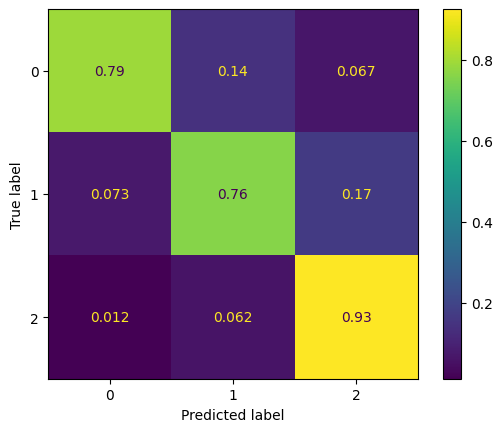

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.49560. Saving Model!
epoch 01, loss: 0.50960, acc: 0.78848, val_loss: 0.49560, val_accuracy: 0.79482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 02, loss: 0.50654, acc: 0.78963, val_loss: 0.50701, val_accuracy: 0.79344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 03, loss: 0.50343, acc: 0.78994, val_loss: 0.51164, val_accuracy: 0.78146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.76it/s]


epoch 04, loss: 0.50294, acc: 0.79151, val_loss: 0.51275, val_accuracy: 0.78127


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 05, loss: 0.50034, acc: 0.79192, val_loss: 0.51752, val_accuracy: 0.78009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.44it/s]


epoch 06, loss: 0.49837, acc: 0.79382, val_loss: 0.52067, val_accuracy: 0.77989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 07, loss: 0.49796, acc: 0.79400, val_loss: 0.52231, val_accuracy: 0.77832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 08, loss: 0.49715, acc: 0.79411, val_loss: 0.52479, val_accuracy: 0.77911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


epoch 09, loss: 0.49591, acc: 0.79498, val_loss: 0.52652, val_accuracy: 0.77832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 10, loss: 0.49538, acc: 0.79504, val_loss: 0.52819, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 11, loss: 0.49467, acc: 0.79668, val_loss: 0.53070, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 12, loss: 0.49414, acc: 0.79701, val_loss: 0.53180, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 13, loss: 0.49312, acc: 0.79699, val_loss: 0.53399, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 14, loss: 0.49307, acc: 0.79718, val_loss: 0.53547, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 15, loss: 0.49210, acc: 0.79733, val_loss: 0.53701, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 16, loss: 0.49216, acc: 0.79742, val_loss: 0.53813, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 17, loss: 0.49138, acc: 0.79766, val_loss: 0.53926, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 18, loss: 0.49069, acc: 0.79853, val_loss: 0.54085, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 19, loss: 0.49052, acc: 0.79882, val_loss: 0.54275, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 20, loss: 0.49015, acc: 0.79952, val_loss: 0.54333, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 21, loss: 0.48961, acc: 0.79962, val_loss: 0.54491, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 22, loss: 0.48943, acc: 0.79919, val_loss: 0.54613, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 23, loss: 0.48881, acc: 0.79986, val_loss: 0.54722, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 24, loss: 0.48840, acc: 0.79993, val_loss: 0.54867, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 25, loss: 0.48826, acc: 0.79980, val_loss: 0.54962, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 26, loss: 0.48776, acc: 0.79984, val_loss: 0.55066, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 27, loss: 0.48767, acc: 0.80013, val_loss: 0.55159, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 28, loss: 0.48689, acc: 0.80030, val_loss: 0.55282, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 29, loss: 0.48695, acc: 0.80017, val_loss: 0.55396, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 30, loss: 0.48638, acc: 0.80039, val_loss: 0.55464, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 31, loss: 0.48635, acc: 0.80017, val_loss: 0.55548, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 32, loss: 0.48586, acc: 0.80076, val_loss: 0.55675, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 33, loss: 0.48563, acc: 0.80065, val_loss: 0.55771, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 34, loss: 0.48549, acc: 0.80063, val_loss: 0.55795, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 35, loss: 0.48482, acc: 0.80052, val_loss: 0.55940, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 36, loss: 0.48478, acc: 0.80078, val_loss: 0.56037, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 37, loss: 0.48459, acc: 0.80058, val_loss: 0.56044, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 38, loss: 0.48397, acc: 0.80085, val_loss: 0.56198, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 39, loss: 0.48384, acc: 0.80135, val_loss: 0.56279, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 40, loss: 0.48390, acc: 0.80076, val_loss: 0.56287, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 41, loss: 0.48300, acc: 0.80106, val_loss: 0.56400, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 42, loss: 0.48329, acc: 0.80109, val_loss: 0.56502, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 43, loss: 0.48279, acc: 0.80100, val_loss: 0.56585, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 44, loss: 0.48248, acc: 0.80126, val_loss: 0.56621, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 45, loss: 0.48219, acc: 0.80122, val_loss: 0.56710, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 46, loss: 0.48179, acc: 0.80170, val_loss: 0.56871, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 47, loss: 0.48189, acc: 0.80150, val_loss: 0.56840, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 48, loss: 0.48154, acc: 0.80152, val_loss: 0.56897, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 49, loss: 0.48089, acc: 0.80194, val_loss: 0.57012, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 50, loss: 0.48104, acc: 0.80165, val_loss: 0.57125, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 51, loss: 0.48073, acc: 0.80209, val_loss: 0.57129, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 52, loss: 0.48045, acc: 0.80207, val_loss: 0.57186, val_accuracy: 0.73414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 53, loss: 0.48010, acc: 0.80202, val_loss: 0.57299, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 54, loss: 0.48015, acc: 0.80231, val_loss: 0.57383, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 55, loss: 0.47960, acc: 0.80244, val_loss: 0.57389, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 56, loss: 0.47965, acc: 0.80220, val_loss: 0.57486, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 57, loss: 0.47903, acc: 0.80248, val_loss: 0.57551, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 58, loss: 0.47918, acc: 0.80277, val_loss: 0.57594, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 59, loss: 0.47844, acc: 0.80296, val_loss: 0.57672, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 60, loss: 0.47867, acc: 0.80287, val_loss: 0.57648, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 61, loss: 0.47823, acc: 0.80266, val_loss: 0.57824, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 62, loss: 0.47805, acc: 0.80316, val_loss: 0.57854, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 63, loss: 0.47773, acc: 0.80305, val_loss: 0.57859, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 64, loss: 0.47760, acc: 0.80342, val_loss: 0.57915, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 65, loss: 0.47710, acc: 0.80353, val_loss: 0.58002, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 66, loss: 0.47752, acc: 0.80353, val_loss: 0.58033, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 67, loss: 0.47642, acc: 0.80462, val_loss: 0.58158, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 68, loss: 0.47710, acc: 0.80342, val_loss: 0.58191, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 69, loss: 0.47640, acc: 0.80538, val_loss: 0.58181, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 70, loss: 0.47589, acc: 0.80527, val_loss: 0.58358, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 71, loss: 0.47639, acc: 0.80466, val_loss: 0.58359, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 72, loss: 0.47585, acc: 0.80503, val_loss: 0.58366, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 73, loss: 0.47541, acc: 0.80560, val_loss: 0.58449, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 74, loss: 0.47554, acc: 0.80466, val_loss: 0.58516, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 75, loss: 0.47485, acc: 0.80604, val_loss: 0.58542, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 76, loss: 0.47513, acc: 0.80569, val_loss: 0.58541, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 77, loss: 0.47429, acc: 0.80558, val_loss: 0.58644, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 78, loss: 0.47488, acc: 0.80599, val_loss: 0.58574, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 79, loss: 0.47392, acc: 0.80632, val_loss: 0.58721, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 80, loss: 0.47395, acc: 0.80613, val_loss: 0.58746, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 81, loss: 0.47367, acc: 0.80634, val_loss: 0.58782, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 82, loss: 0.47367, acc: 0.80667, val_loss: 0.58847, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 83, loss: 0.47311, acc: 0.80647, val_loss: 0.58875, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 84, loss: 0.47334, acc: 0.80630, val_loss: 0.58886, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 85, loss: 0.47279, acc: 0.80669, val_loss: 0.59005, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


epoch 86, loss: 0.47278, acc: 0.80737, val_loss: 0.59075, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 87, loss: 0.47269, acc: 0.80678, val_loss: 0.59014, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 88, loss: 0.47217, acc: 0.80674, val_loss: 0.59066, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 89, loss: 0.47238, acc: 0.80667, val_loss: 0.59168, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 90, loss: 0.47165, acc: 0.80706, val_loss: 0.59263, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 91, loss: 0.47195, acc: 0.80787, val_loss: 0.59278, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 92, loss: 0.47128, acc: 0.80702, val_loss: 0.59318, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 93, loss: 0.47138, acc: 0.80691, val_loss: 0.59340, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 94, loss: 0.47101, acc: 0.80815, val_loss: 0.59418, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 95, loss: 0.47085, acc: 0.80767, val_loss: 0.59449, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 96, loss: 0.47063, acc: 0.80802, val_loss: 0.59481, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 97, loss: 0.47072, acc: 0.80780, val_loss: 0.59553, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 98, loss: 0.46994, acc: 0.80833, val_loss: 0.59532, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 99, loss: 0.47039, acc: 0.80837, val_loss: 0.59647, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 100, loss: 0.46980, acc: 0.80835, val_loss: 0.59633, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 101, loss: 0.46993, acc: 0.80824, val_loss: 0.59692, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 102, loss: 0.46911, acc: 0.80811, val_loss: 0.59757, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 103, loss: 0.46959, acc: 0.80863, val_loss: 0.59750, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 104, loss: 0.46912, acc: 0.80868, val_loss: 0.59798, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 105, loss: 0.46869, acc: 0.80883, val_loss: 0.59907, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


epoch 106, loss: 0.46912, acc: 0.80844, val_loss: 0.59828, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 107, loss: 0.46818, acc: 0.80894, val_loss: 0.59931, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 108, loss: 0.46874, acc: 0.80876, val_loss: 0.59939, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 109, loss: 0.46795, acc: 0.80894, val_loss: 0.60114, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 110, loss: 0.46822, acc: 0.80929, val_loss: 0.59962, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 111, loss: 0.46769, acc: 0.80883, val_loss: 0.60117, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 112, loss: 0.46744, acc: 0.80898, val_loss: 0.60117, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 113, loss: 0.46749, acc: 0.80896, val_loss: 0.60193, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 114, loss: 0.46722, acc: 0.80911, val_loss: 0.60234, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 115, loss: 0.46715, acc: 0.80981, val_loss: 0.60249, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 116, loss: 0.46697, acc: 0.80940, val_loss: 0.60264, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 117, loss: 0.46655, acc: 0.80962, val_loss: 0.60357, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 118, loss: 0.46661, acc: 0.80988, val_loss: 0.60296, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 119, loss: 0.46615, acc: 0.80977, val_loss: 0.60447, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 120, loss: 0.46572, acc: 0.80986, val_loss: 0.60454, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 121, loss: 0.46632, acc: 0.80942, val_loss: 0.60472, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 122, loss: 0.46556, acc: 0.81018, val_loss: 0.60466, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 123, loss: 0.46557, acc: 0.80955, val_loss: 0.60579, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 124, loss: 0.46538, acc: 0.81007, val_loss: 0.60533, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 125, loss: 0.46504, acc: 0.81007, val_loss: 0.60588, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 126, loss: 0.46479, acc: 0.81003, val_loss: 0.60665, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 127, loss: 0.46507, acc: 0.81003, val_loss: 0.60668, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 128, loss: 0.46412, acc: 0.81053, val_loss: 0.60753, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 129, loss: 0.46483, acc: 0.81016, val_loss: 0.60718, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.54it/s]


epoch 130, loss: 0.46391, acc: 0.81027, val_loss: 0.60802, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 131, loss: 0.46457, acc: 0.81001, val_loss: 0.60755, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 132, loss: 0.46303, acc: 0.81186, val_loss: 0.60928, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 133, loss: 0.46454, acc: 0.81012, val_loss: 0.60812, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 134, loss: 0.46255, acc: 0.81125, val_loss: 0.60948, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 135, loss: 0.46400, acc: 0.81053, val_loss: 0.60793, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 136, loss: 0.46235, acc: 0.81212, val_loss: 0.61023, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 137, loss: 0.46356, acc: 0.81195, val_loss: 0.61021, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 138, loss: 0.46266, acc: 0.81201, val_loss: 0.60964, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 139, loss: 0.46250, acc: 0.81249, val_loss: 0.61069, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 140, loss: 0.46239, acc: 0.81110, val_loss: 0.61034, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 141, loss: 0.46234, acc: 0.81225, val_loss: 0.61133, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 142, loss: 0.46189, acc: 0.81171, val_loss: 0.61151, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 143, loss: 0.46202, acc: 0.81208, val_loss: 0.61192, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 144, loss: 0.46128, acc: 0.81265, val_loss: 0.61121, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 145, loss: 0.46166, acc: 0.81241, val_loss: 0.61209, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 146, loss: 0.46117, acc: 0.81295, val_loss: 0.61263, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 147, loss: 0.46084, acc: 0.81289, val_loss: 0.61290, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 148, loss: 0.46106, acc: 0.81273, val_loss: 0.61308, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 149, loss: 0.46060, acc: 0.81313, val_loss: 0.61279, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 150, loss: 0.46064, acc: 0.81317, val_loss: 0.61419, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 151, loss: 0.46041, acc: 0.81321, val_loss: 0.61351, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 152, loss: 0.46025, acc: 0.81321, val_loss: 0.61387, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 153, loss: 0.45966, acc: 0.81345, val_loss: 0.61502, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 154, loss: 0.46015, acc: 0.81321, val_loss: 0.61429, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 155, loss: 0.45942, acc: 0.81359, val_loss: 0.61541, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 156, loss: 0.45968, acc: 0.81356, val_loss: 0.61509, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 157, loss: 0.45905, acc: 0.81389, val_loss: 0.61564, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 158, loss: 0.45945, acc: 0.81391, val_loss: 0.61537, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 159, loss: 0.45832, acc: 0.81411, val_loss: 0.61662, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 160, loss: 0.45947, acc: 0.81372, val_loss: 0.61606, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 161, loss: 0.45808, acc: 0.81468, val_loss: 0.61702, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 162, loss: 0.45844, acc: 0.81468, val_loss: 0.61784, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 163, loss: 0.45823, acc: 0.81422, val_loss: 0.61691, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 164, loss: 0.45798, acc: 0.81422, val_loss: 0.61821, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 165, loss: 0.45799, acc: 0.81441, val_loss: 0.61769, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 166, loss: 0.45762, acc: 0.81476, val_loss: 0.61825, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 167, loss: 0.45766, acc: 0.81533, val_loss: 0.61848, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 168, loss: 0.45731, acc: 0.81507, val_loss: 0.61906, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 169, loss: 0.45737, acc: 0.81542, val_loss: 0.61864, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 170, loss: 0.45683, acc: 0.81494, val_loss: 0.62002, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 171, loss: 0.45683, acc: 0.81507, val_loss: 0.61842, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 172, loss: 0.45642, acc: 0.81505, val_loss: 0.62072, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 173, loss: 0.45685, acc: 0.81601, val_loss: 0.61923, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 174, loss: 0.45586, acc: 0.81522, val_loss: 0.62072, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 175, loss: 0.45652, acc: 0.81513, val_loss: 0.61972, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 176, loss: 0.45551, acc: 0.81522, val_loss: 0.62133, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 177, loss: 0.45608, acc: 0.81583, val_loss: 0.62091, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 178, loss: 0.45561, acc: 0.81555, val_loss: 0.62081, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 179, loss: 0.45518, acc: 0.81588, val_loss: 0.62202, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 180, loss: 0.45527, acc: 0.81607, val_loss: 0.62172, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 181, loss: 0.45532, acc: 0.81564, val_loss: 0.62176, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 182, loss: 0.45463, acc: 0.81636, val_loss: 0.62243, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 183, loss: 0.45510, acc: 0.81598, val_loss: 0.62319, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 184, loss: 0.45405, acc: 0.81660, val_loss: 0.62327, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 185, loss: 0.45505, acc: 0.81588, val_loss: 0.62284, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 186, loss: 0.45378, acc: 0.81651, val_loss: 0.62422, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 187, loss: 0.45437, acc: 0.81633, val_loss: 0.62373, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 188, loss: 0.45378, acc: 0.81673, val_loss: 0.62312, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 189, loss: 0.45368, acc: 0.81649, val_loss: 0.62459, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 190, loss: 0.45331, acc: 0.81651, val_loss: 0.62444, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 191, loss: 0.45390, acc: 0.81697, val_loss: 0.62451, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 192, loss: 0.45261, acc: 0.81690, val_loss: 0.62587, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 193, loss: 0.45402, acc: 0.81653, val_loss: 0.62448, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 194, loss: 0.45187, acc: 0.81810, val_loss: 0.62601, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 195, loss: 0.45354, acc: 0.81679, val_loss: 0.62483, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 196, loss: 0.45200, acc: 0.81790, val_loss: 0.62615, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 197, loss: 0.45283, acc: 0.81773, val_loss: 0.62669, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 198, loss: 0.45197, acc: 0.81793, val_loss: 0.62664, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 199, loss: 0.45221, acc: 0.81710, val_loss: 0.62667, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 200, loss: 0.45159, acc: 0.81786, val_loss: 0.62652, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 201, loss: 0.45176, acc: 0.81751, val_loss: 0.62758, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 202, loss: 0.45147, acc: 0.81836, val_loss: 0.62728, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 203, loss: 0.45136, acc: 0.81736, val_loss: 0.62807, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 204, loss: 0.45116, acc: 0.81742, val_loss: 0.62766, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 205, loss: 0.45101, acc: 0.81858, val_loss: 0.62848, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 206, loss: 0.45026, acc: 0.81784, val_loss: 0.62892, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 207, loss: 0.45098, acc: 0.81784, val_loss: 0.62931, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 208, loss: 0.45037, acc: 0.81836, val_loss: 0.62806, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 209, loss: 0.44995, acc: 0.81819, val_loss: 0.62983, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 210, loss: 0.44996, acc: 0.81795, val_loss: 0.63001, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 211, loss: 0.44980, acc: 0.81838, val_loss: 0.62978, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 212, loss: 0.44974, acc: 0.81921, val_loss: 0.63009, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 213, loss: 0.44953, acc: 0.81954, val_loss: 0.62990, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 214, loss: 0.44928, acc: 0.81851, val_loss: 0.63063, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 215, loss: 0.44921, acc: 0.81906, val_loss: 0.63118, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 216, loss: 0.44867, acc: 0.81871, val_loss: 0.63075, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 217, loss: 0.44896, acc: 0.81908, val_loss: 0.63093, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 218, loss: 0.44810, acc: 0.81913, val_loss: 0.63246, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 219, loss: 0.44902, acc: 0.81843, val_loss: 0.63072, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.78it/s]


epoch 220, loss: 0.44754, acc: 0.82024, val_loss: 0.63272, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 221, loss: 0.44850, acc: 0.81963, val_loss: 0.63146, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 222, loss: 0.44759, acc: 0.81974, val_loss: 0.63283, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 223, loss: 0.44800, acc: 0.81910, val_loss: 0.63288, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 224, loss: 0.44730, acc: 0.81923, val_loss: 0.63270, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 225, loss: 0.44767, acc: 0.82067, val_loss: 0.63327, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 226, loss: 0.44712, acc: 0.82017, val_loss: 0.63279, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 227, loss: 0.44738, acc: 0.81919, val_loss: 0.63378, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 228, loss: 0.44644, acc: 0.82089, val_loss: 0.63427, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 229, loss: 0.44729, acc: 0.81947, val_loss: 0.63406, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 230, loss: 0.44609, acc: 0.82054, val_loss: 0.63393, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 231, loss: 0.44650, acc: 0.82026, val_loss: 0.63504, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 232, loss: 0.44639, acc: 0.82046, val_loss: 0.63417, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 233, loss: 0.44563, acc: 0.82043, val_loss: 0.63541, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 234, loss: 0.44621, acc: 0.81976, val_loss: 0.63479, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 235, loss: 0.44525, acc: 0.82102, val_loss: 0.63577, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 236, loss: 0.44573, acc: 0.82166, val_loss: 0.63534, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 237, loss: 0.44503, acc: 0.82214, val_loss: 0.63663, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 238, loss: 0.44547, acc: 0.82081, val_loss: 0.63560, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 239, loss: 0.44469, acc: 0.82281, val_loss: 0.63763, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 240, loss: 0.44521, acc: 0.82135, val_loss: 0.63616, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 241, loss: 0.44450, acc: 0.82187, val_loss: 0.63734, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 242, loss: 0.44470, acc: 0.82275, val_loss: 0.63619, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


epoch 243, loss: 0.44395, acc: 0.82216, val_loss: 0.63893, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 244, loss: 0.44488, acc: 0.82201, val_loss: 0.63725, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 245, loss: 0.44357, acc: 0.82314, val_loss: 0.63876, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 246, loss: 0.44427, acc: 0.82347, val_loss: 0.63730, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 247, loss: 0.44351, acc: 0.82222, val_loss: 0.63882, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 248, loss: 0.44379, acc: 0.82296, val_loss: 0.63818, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 249, loss: 0.44299, acc: 0.82349, val_loss: 0.63973, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 250, loss: 0.44347, acc: 0.82362, val_loss: 0.63782, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 251, loss: 0.44271, acc: 0.82331, val_loss: 0.64097, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 252, loss: 0.44323, acc: 0.82268, val_loss: 0.63889, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 253, loss: 0.44222, acc: 0.82364, val_loss: 0.64097, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 254, loss: 0.44304, acc: 0.82351, val_loss: 0.64049, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 255, loss: 0.44201, acc: 0.82392, val_loss: 0.64192, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 256, loss: 0.44276, acc: 0.82386, val_loss: 0.63953, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 257, loss: 0.44160, acc: 0.82416, val_loss: 0.64162, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 258, loss: 0.44198, acc: 0.82318, val_loss: 0.64122, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 259, loss: 0.44167, acc: 0.82325, val_loss: 0.64223, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 260, loss: 0.44179, acc: 0.82397, val_loss: 0.64181, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 261, loss: 0.44082, acc: 0.82432, val_loss: 0.64402, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 262, loss: 0.44191, acc: 0.82416, val_loss: 0.64169, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 263, loss: 0.44041, acc: 0.82438, val_loss: 0.64413, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 264, loss: 0.44132, acc: 0.82438, val_loss: 0.64274, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 265, loss: 0.44039, acc: 0.82456, val_loss: 0.64421, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 266, loss: 0.44103, acc: 0.82469, val_loss: 0.64408, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 267, loss: 0.44013, acc: 0.82504, val_loss: 0.64448, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 268, loss: 0.44037, acc: 0.82523, val_loss: 0.64351, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 269, loss: 0.44008, acc: 0.82495, val_loss: 0.64537, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 270, loss: 0.43990, acc: 0.82519, val_loss: 0.64527, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 271, loss: 0.43968, acc: 0.82510, val_loss: 0.64567, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 272, loss: 0.44005, acc: 0.82528, val_loss: 0.64407, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 273, loss: 0.43877, acc: 0.82480, val_loss: 0.64747, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 274, loss: 0.43999, acc: 0.82534, val_loss: 0.64509, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 275, loss: 0.43856, acc: 0.82421, val_loss: 0.64703, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 276, loss: 0.43958, acc: 0.82552, val_loss: 0.64561, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 277, loss: 0.43820, acc: 0.82539, val_loss: 0.64855, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 278, loss: 0.43924, acc: 0.82541, val_loss: 0.64564, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 279, loss: 0.43776, acc: 0.82462, val_loss: 0.64834, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 280, loss: 0.43889, acc: 0.82569, val_loss: 0.64656, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 281, loss: 0.43776, acc: 0.82595, val_loss: 0.64878, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 282, loss: 0.43873, acc: 0.82606, val_loss: 0.64687, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 283, loss: 0.43724, acc: 0.82536, val_loss: 0.64899, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 284, loss: 0.43844, acc: 0.82600, val_loss: 0.64837, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 285, loss: 0.43660, acc: 0.82683, val_loss: 0.64966, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 286, loss: 0.43823, acc: 0.82571, val_loss: 0.64754, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 287, loss: 0.43627, acc: 0.82608, val_loss: 0.65003, val_accuracy: 0.73414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 288, loss: 0.43791, acc: 0.82617, val_loss: 0.64895, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


epoch 289, loss: 0.43618, acc: 0.82621, val_loss: 0.65124, val_accuracy: 0.73414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 290, loss: 0.43739, acc: 0.82626, val_loss: 0.64808, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 291, loss: 0.43584, acc: 0.82617, val_loss: 0.65135, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 292, loss: 0.43701, acc: 0.82665, val_loss: 0.64914, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 293, loss: 0.43582, acc: 0.82709, val_loss: 0.65196, val_accuracy: 0.73414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 294, loss: 0.43673, acc: 0.82652, val_loss: 0.65138, val_accuracy: 0.73473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 295, loss: 0.43523, acc: 0.82674, val_loss: 0.65136, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 296, loss: 0.43676, acc: 0.82635, val_loss: 0.65072, val_accuracy: 0.73395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 297, loss: 0.43456, acc: 0.82744, val_loss: 0.65295, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 298, loss: 0.43652, acc: 0.82639, val_loss: 0.65160, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 299, loss: 0.43439, acc: 0.82691, val_loss: 0.65285, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 300, loss: 0.43572, acc: 0.82700, val_loss: 0.65238, val_accuracy: 0.73395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 301, loss: 0.43437, acc: 0.82809, val_loss: 0.65350, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 302, loss: 0.43508, acc: 0.82763, val_loss: 0.65396, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 303, loss: 0.43444, acc: 0.82899, val_loss: 0.65369, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 304, loss: 0.43464, acc: 0.82722, val_loss: 0.65437, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 305, loss: 0.43452, acc: 0.82772, val_loss: 0.65262, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 306, loss: 0.43394, acc: 0.82768, val_loss: 0.65662, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 307, loss: 0.43412, acc: 0.82824, val_loss: 0.65432, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 308, loss: 0.43383, acc: 0.82818, val_loss: 0.65608, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 309, loss: 0.43370, acc: 0.82875, val_loss: 0.65418, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 310, loss: 0.43357, acc: 0.82768, val_loss: 0.65686, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 311, loss: 0.43359, acc: 0.82835, val_loss: 0.65532, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 312, loss: 0.43328, acc: 0.82853, val_loss: 0.65724, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 313, loss: 0.43302, acc: 0.82833, val_loss: 0.65583, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 314, loss: 0.43284, acc: 0.82851, val_loss: 0.65822, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 315, loss: 0.43257, acc: 0.82997, val_loss: 0.65583, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 316, loss: 0.43272, acc: 0.82851, val_loss: 0.65805, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 317, loss: 0.43240, acc: 0.83042, val_loss: 0.65626, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 318, loss: 0.43179, acc: 0.82901, val_loss: 0.65984, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 319, loss: 0.43267, acc: 0.82857, val_loss: 0.65697, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 320, loss: 0.43133, acc: 0.82892, val_loss: 0.65955, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 321, loss: 0.43239, acc: 0.82940, val_loss: 0.65770, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 322, loss: 0.43109, acc: 0.82894, val_loss: 0.65995, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 323, loss: 0.43191, acc: 0.83012, val_loss: 0.65859, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 324, loss: 0.43071, acc: 0.82931, val_loss: 0.66025, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 325, loss: 0.43216, acc: 0.82992, val_loss: 0.65926, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 326, loss: 0.43046, acc: 0.82962, val_loss: 0.66158, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 327, loss: 0.43098, acc: 0.83036, val_loss: 0.65893, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 328, loss: 0.43060, acc: 0.82955, val_loss: 0.66188, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 329, loss: 0.43051, acc: 0.83060, val_loss: 0.66043, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 330, loss: 0.43028, acc: 0.82957, val_loss: 0.66216, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 331, loss: 0.43050, acc: 0.83038, val_loss: 0.65989, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 332, loss: 0.42977, acc: 0.82975, val_loss: 0.66410, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 333, loss: 0.43015, acc: 0.83064, val_loss: 0.66141, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 334, loss: 0.42930, acc: 0.83001, val_loss: 0.66292, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 335, loss: 0.43015, acc: 0.83029, val_loss: 0.66149, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 336, loss: 0.42872, acc: 0.83036, val_loss: 0.66569, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 337, loss: 0.43041, acc: 0.83071, val_loss: 0.66196, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 338, loss: 0.42844, acc: 0.83152, val_loss: 0.66565, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 339, loss: 0.42951, acc: 0.83117, val_loss: 0.66158, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 340, loss: 0.42828, acc: 0.83045, val_loss: 0.66657, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 341, loss: 0.42923, acc: 0.83213, val_loss: 0.66219, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 342, loss: 0.42798, acc: 0.83263, val_loss: 0.66560, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 343, loss: 0.42868, acc: 0.83341, val_loss: 0.66353, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 344, loss: 0.42773, acc: 0.83256, val_loss: 0.66733, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 345, loss: 0.42821, acc: 0.83274, val_loss: 0.66349, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 346, loss: 0.42733, acc: 0.83278, val_loss: 0.66716, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 347, loss: 0.42804, acc: 0.83357, val_loss: 0.66565, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 348, loss: 0.42717, acc: 0.83243, val_loss: 0.66564, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 349, loss: 0.42786, acc: 0.83306, val_loss: 0.66534, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 350, loss: 0.42649, acc: 0.83320, val_loss: 0.66716, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 351, loss: 0.42787, acc: 0.83274, val_loss: 0.66507, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 352, loss: 0.42592, acc: 0.83328, val_loss: 0.66734, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 353, loss: 0.42727, acc: 0.83261, val_loss: 0.66612, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 354, loss: 0.42590, acc: 0.83374, val_loss: 0.66825, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 355, loss: 0.42671, acc: 0.83378, val_loss: 0.66675, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 356, loss: 0.42559, acc: 0.83326, val_loss: 0.66831, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 357, loss: 0.42664, acc: 0.83359, val_loss: 0.66717, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 358, loss: 0.42530, acc: 0.83376, val_loss: 0.66710, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 359, loss: 0.42581, acc: 0.83385, val_loss: 0.66920, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 360, loss: 0.42543, acc: 0.83350, val_loss: 0.66694, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 361, loss: 0.42527, acc: 0.83370, val_loss: 0.66999, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 362, loss: 0.42527, acc: 0.83407, val_loss: 0.66811, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 363, loss: 0.42464, acc: 0.83396, val_loss: 0.67000, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 364, loss: 0.42524, acc: 0.83405, val_loss: 0.66918, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 365, loss: 0.42442, acc: 0.83381, val_loss: 0.67119, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 366, loss: 0.42509, acc: 0.83372, val_loss: 0.66838, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 367, loss: 0.42401, acc: 0.83413, val_loss: 0.67227, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 368, loss: 0.42495, acc: 0.83444, val_loss: 0.66992, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 369, loss: 0.42379, acc: 0.83398, val_loss: 0.67213, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 370, loss: 0.42416, acc: 0.83472, val_loss: 0.67020, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 371, loss: 0.42368, acc: 0.83466, val_loss: 0.67018, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 372, loss: 0.42358, acc: 0.83466, val_loss: 0.67019, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 373, loss: 0.42358, acc: 0.83420, val_loss: 0.67211, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 374, loss: 0.42324, acc: 0.83525, val_loss: 0.67070, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 375, loss: 0.42307, acc: 0.83470, val_loss: 0.67278, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 376, loss: 0.42319, acc: 0.83498, val_loss: 0.67130, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 377, loss: 0.42240, acc: 0.83498, val_loss: 0.67442, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 378, loss: 0.42339, acc: 0.83492, val_loss: 0.67116, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 379, loss: 0.42229, acc: 0.83516, val_loss: 0.67317, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 380, loss: 0.42301, acc: 0.83518, val_loss: 0.67219, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 381, loss: 0.42198, acc: 0.83522, val_loss: 0.67518, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 382, loss: 0.42242, acc: 0.83474, val_loss: 0.67267, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 383, loss: 0.42192, acc: 0.83481, val_loss: 0.67477, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 384, loss: 0.42181, acc: 0.83546, val_loss: 0.67267, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 385, loss: 0.42158, acc: 0.83498, val_loss: 0.67608, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 386, loss: 0.42178, acc: 0.83546, val_loss: 0.67286, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 387, loss: 0.42097, acc: 0.83544, val_loss: 0.67696, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 388, loss: 0.42145, acc: 0.83616, val_loss: 0.67452, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 389, loss: 0.42085, acc: 0.83479, val_loss: 0.67619, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 390, loss: 0.42104, acc: 0.83605, val_loss: 0.67510, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 391, loss: 0.42019, acc: 0.83557, val_loss: 0.67706, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 392, loss: 0.42112, acc: 0.83597, val_loss: 0.67421, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 393, loss: 0.41998, acc: 0.83527, val_loss: 0.67648, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 394, loss: 0.42078, acc: 0.83610, val_loss: 0.67679, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 395, loss: 0.41968, acc: 0.83594, val_loss: 0.67830, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 396, loss: 0.42094, acc: 0.83586, val_loss: 0.67660, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 397, loss: 0.41906, acc: 0.83590, val_loss: 0.67890, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 398, loss: 0.42033, acc: 0.83627, val_loss: 0.67519, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 399, loss: 0.41872, acc: 0.83618, val_loss: 0.67915, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 400, loss: 0.42039, acc: 0.83653, val_loss: 0.67633, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 401, loss: 0.41833, acc: 0.83640, val_loss: 0.67921, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 402, loss: 0.42018, acc: 0.83614, val_loss: 0.67642, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 403, loss: 0.41773, acc: 0.83651, val_loss: 0.68132, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 404, loss: 0.42011, acc: 0.83669, val_loss: 0.67645, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 405, loss: 0.41732, acc: 0.83703, val_loss: 0.68001, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 406, loss: 0.41985, acc: 0.83664, val_loss: 0.67790, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 407, loss: 0.41681, acc: 0.83631, val_loss: 0.68185, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 408, loss: 0.41968, acc: 0.83697, val_loss: 0.67627, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 409, loss: 0.41660, acc: 0.83697, val_loss: 0.68076, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 410, loss: 0.41932, acc: 0.83725, val_loss: 0.67826, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 411, loss: 0.41658, acc: 0.83730, val_loss: 0.68184, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 412, loss: 0.41892, acc: 0.83703, val_loss: 0.67815, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 413, loss: 0.41607, acc: 0.83784, val_loss: 0.68336, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 414, loss: 0.41924, acc: 0.83710, val_loss: 0.67763, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 415, loss: 0.41515, acc: 0.83771, val_loss: 0.68377, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 416, loss: 0.41864, acc: 0.83727, val_loss: 0.67997, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 417, loss: 0.41543, acc: 0.83765, val_loss: 0.68295, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 418, loss: 0.41781, acc: 0.83775, val_loss: 0.68015, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 419, loss: 0.41535, acc: 0.83784, val_loss: 0.68268, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 420, loss: 0.41748, acc: 0.83751, val_loss: 0.68112, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 421, loss: 0.41499, acc: 0.83786, val_loss: 0.68379, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 422, loss: 0.41691, acc: 0.83771, val_loss: 0.68112, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 423, loss: 0.41504, acc: 0.83826, val_loss: 0.68110, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 424, loss: 0.41599, acc: 0.83789, val_loss: 0.68379, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 425, loss: 0.41504, acc: 0.83836, val_loss: 0.68204, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 426, loss: 0.41554, acc: 0.83758, val_loss: 0.68436, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 427, loss: 0.41509, acc: 0.83845, val_loss: 0.68224, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 428, loss: 0.41483, acc: 0.83819, val_loss: 0.68542, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 429, loss: 0.41546, acc: 0.83843, val_loss: 0.68254, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 430, loss: 0.41432, acc: 0.83804, val_loss: 0.68538, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 431, loss: 0.41524, acc: 0.83908, val_loss: 0.68198, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 432, loss: 0.41396, acc: 0.83836, val_loss: 0.68661, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 433, loss: 0.41502, acc: 0.83898, val_loss: 0.68306, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 434, loss: 0.41381, acc: 0.83826, val_loss: 0.68691, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 435, loss: 0.41462, acc: 0.83950, val_loss: 0.68376, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 436, loss: 0.41346, acc: 0.83865, val_loss: 0.68699, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 437, loss: 0.41448, acc: 0.83948, val_loss: 0.68274, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 438, loss: 0.41257, acc: 0.83874, val_loss: 0.68768, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 439, loss: 0.41428, acc: 0.83895, val_loss: 0.68362, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 440, loss: 0.41251, acc: 0.83874, val_loss: 0.68730, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 441, loss: 0.41388, acc: 0.83867, val_loss: 0.68541, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 442, loss: 0.41237, acc: 0.83926, val_loss: 0.68716, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 443, loss: 0.41294, acc: 0.84020, val_loss: 0.68577, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 444, loss: 0.41227, acc: 0.83926, val_loss: 0.68678, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 445, loss: 0.41263, acc: 0.84022, val_loss: 0.68568, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 446, loss: 0.41188, acc: 0.84013, val_loss: 0.68867, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 447, loss: 0.41289, acc: 0.83991, val_loss: 0.68618, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 448, loss: 0.41144, acc: 0.83922, val_loss: 0.68924, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 449, loss: 0.41270, acc: 0.84033, val_loss: 0.68538, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 450, loss: 0.41092, acc: 0.84052, val_loss: 0.69018, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


epoch 451, loss: 0.41214, acc: 0.84015, val_loss: 0.68668, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


epoch 452, loss: 0.41088, acc: 0.84015, val_loss: 0.68905, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 453, loss: 0.41223, acc: 0.84063, val_loss: 0.68737, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 454, loss: 0.40997, acc: 0.84063, val_loss: 0.69071, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 455, loss: 0.41252, acc: 0.84022, val_loss: 0.68698, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


epoch 456, loss: 0.40942, acc: 0.84122, val_loss: 0.69221, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 457, loss: 0.41236, acc: 0.84050, val_loss: 0.68604, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 458, loss: 0.40922, acc: 0.84044, val_loss: 0.69178, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 459, loss: 0.41164, acc: 0.84050, val_loss: 0.68817, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 460, loss: 0.40914, acc: 0.84129, val_loss: 0.69213, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 461, loss: 0.41123, acc: 0.84076, val_loss: 0.68670, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 462, loss: 0.40871, acc: 0.84181, val_loss: 0.69303, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 463, loss: 0.41106, acc: 0.84098, val_loss: 0.68854, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 464, loss: 0.40879, acc: 0.84162, val_loss: 0.69209, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 465, loss: 0.41069, acc: 0.84196, val_loss: 0.68845, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 466, loss: 0.40831, acc: 0.84179, val_loss: 0.69388, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 467, loss: 0.41034, acc: 0.84155, val_loss: 0.68821, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 468, loss: 0.40805, acc: 0.84194, val_loss: 0.69510, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 469, loss: 0.41009, acc: 0.84155, val_loss: 0.68876, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 470, loss: 0.40789, acc: 0.84214, val_loss: 0.69396, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 471, loss: 0.40962, acc: 0.84172, val_loss: 0.69034, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 472, loss: 0.40790, acc: 0.84142, val_loss: 0.69381, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 473, loss: 0.40897, acc: 0.84183, val_loss: 0.68970, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 474, loss: 0.40764, acc: 0.84212, val_loss: 0.69527, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 475, loss: 0.40882, acc: 0.84212, val_loss: 0.69038, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 476, loss: 0.40726, acc: 0.84205, val_loss: 0.69532, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 477, loss: 0.40845, acc: 0.84225, val_loss: 0.69133, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 478, loss: 0.40741, acc: 0.84238, val_loss: 0.69511, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 479, loss: 0.40841, acc: 0.84223, val_loss: 0.69235, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 480, loss: 0.40710, acc: 0.84205, val_loss: 0.69433, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 481, loss: 0.40821, acc: 0.84238, val_loss: 0.69247, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 482, loss: 0.40677, acc: 0.84260, val_loss: 0.69525, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 483, loss: 0.40862, acc: 0.84148, val_loss: 0.69329, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 484, loss: 0.40595, acc: 0.84371, val_loss: 0.69663, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 485, loss: 0.40803, acc: 0.84227, val_loss: 0.69352, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 486, loss: 0.40503, acc: 0.84325, val_loss: 0.69450, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 487, loss: 0.40812, acc: 0.84275, val_loss: 0.69324, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 488, loss: 0.40452, acc: 0.84292, val_loss: 0.69713, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 489, loss: 0.40761, acc: 0.84225, val_loss: 0.69390, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 490, loss: 0.40473, acc: 0.84314, val_loss: 0.69636, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 491, loss: 0.40665, acc: 0.84277, val_loss: 0.69540, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 492, loss: 0.40489, acc: 0.84325, val_loss: 0.69620, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 493, loss: 0.40628, acc: 0.84286, val_loss: 0.69683, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 494, loss: 0.40504, acc: 0.84323, val_loss: 0.69650, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 495, loss: 0.40558, acc: 0.84327, val_loss: 0.69799, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 496, loss: 0.40507, acc: 0.84382, val_loss: 0.69630, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 497, loss: 0.40530, acc: 0.84288, val_loss: 0.69960, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 498, loss: 0.40497, acc: 0.84345, val_loss: 0.69729, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 499, loss: 0.40507, acc: 0.84332, val_loss: 0.69919, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 500, loss: 0.40442, acc: 0.84377, val_loss: 0.69687, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 501, loss: 0.40486, acc: 0.84373, val_loss: 0.70248, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 502, loss: 0.40462, acc: 0.84375, val_loss: 0.69777, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 503, loss: 0.40437, acc: 0.84351, val_loss: 0.70153, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 504, loss: 0.40373, acc: 0.84404, val_loss: 0.69906, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 505, loss: 0.40407, acc: 0.84358, val_loss: 0.70194, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 506, loss: 0.40426, acc: 0.84325, val_loss: 0.69728, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 507, loss: 0.40315, acc: 0.84380, val_loss: 0.70358, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 508, loss: 0.40389, acc: 0.84463, val_loss: 0.70026, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 509, loss: 0.40333, acc: 0.84443, val_loss: 0.70139, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 510, loss: 0.40300, acc: 0.84425, val_loss: 0.70245, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 511, loss: 0.40322, acc: 0.84421, val_loss: 0.70225, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 512, loss: 0.40287, acc: 0.84436, val_loss: 0.70227, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 513, loss: 0.40266, acc: 0.84436, val_loss: 0.70342, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 514, loss: 0.40272, acc: 0.84449, val_loss: 0.70160, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 515, loss: 0.40219, acc: 0.84432, val_loss: 0.70380, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 516, loss: 0.40262, acc: 0.84425, val_loss: 0.70218, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 517, loss: 0.40238, acc: 0.84423, val_loss: 0.70540, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 518, loss: 0.40240, acc: 0.84535, val_loss: 0.70144, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 519, loss: 0.40162, acc: 0.84452, val_loss: 0.70657, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 520, loss: 0.40208, acc: 0.84445, val_loss: 0.70223, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 521, loss: 0.40189, acc: 0.84487, val_loss: 0.70634, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 522, loss: 0.40117, acc: 0.84543, val_loss: 0.70484, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 523, loss: 0.40155, acc: 0.84513, val_loss: 0.70652, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 524, loss: 0.40151, acc: 0.84502, val_loss: 0.70290, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 525, loss: 0.40088, acc: 0.84467, val_loss: 0.70798, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 526, loss: 0.40130, acc: 0.84535, val_loss: 0.70339, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 527, loss: 0.40054, acc: 0.84574, val_loss: 0.70926, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 528, loss: 0.40109, acc: 0.84532, val_loss: 0.70438, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 529, loss: 0.40030, acc: 0.84563, val_loss: 0.71084, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 530, loss: 0.40080, acc: 0.84504, val_loss: 0.70269, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 531, loss: 0.39986, acc: 0.84735, val_loss: 0.70990, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 532, loss: 0.40030, acc: 0.84582, val_loss: 0.70557, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.42it/s]


epoch 533, loss: 0.39993, acc: 0.84576, val_loss: 0.70871, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 534, loss: 0.39964, acc: 0.84635, val_loss: 0.70588, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 535, loss: 0.39950, acc: 0.84622, val_loss: 0.71013, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 536, loss: 0.39966, acc: 0.84678, val_loss: 0.70618, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 537, loss: 0.39885, acc: 0.84705, val_loss: 0.71143, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 538, loss: 0.40035, acc: 0.84716, val_loss: 0.70520, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 539, loss: 0.39824, acc: 0.84768, val_loss: 0.71027, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 540, loss: 0.39931, acc: 0.84740, val_loss: 0.70850, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 541, loss: 0.39876, acc: 0.84602, val_loss: 0.71118, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 542, loss: 0.39912, acc: 0.84707, val_loss: 0.70834, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 543, loss: 0.39860, acc: 0.84668, val_loss: 0.71010, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 544, loss: 0.39850, acc: 0.84744, val_loss: 0.70958, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 545, loss: 0.39827, acc: 0.84718, val_loss: 0.71216, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 546, loss: 0.39846, acc: 0.84726, val_loss: 0.70756, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 547, loss: 0.39822, acc: 0.84737, val_loss: 0.71232, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 548, loss: 0.39791, acc: 0.84792, val_loss: 0.70869, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 549, loss: 0.39807, acc: 0.84726, val_loss: 0.71091, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 550, loss: 0.39748, acc: 0.84792, val_loss: 0.70846, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 551, loss: 0.39739, acc: 0.84781, val_loss: 0.71468, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.65it/s]


epoch 552, loss: 0.39768, acc: 0.84785, val_loss: 0.70713, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 553, loss: 0.39698, acc: 0.84805, val_loss: 0.71450, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 554, loss: 0.39744, acc: 0.84818, val_loss: 0.71005, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 555, loss: 0.39679, acc: 0.84766, val_loss: 0.71345, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 556, loss: 0.39702, acc: 0.84831, val_loss: 0.71141, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 557, loss: 0.39657, acc: 0.84764, val_loss: 0.71219, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 558, loss: 0.39706, acc: 0.84825, val_loss: 0.71053, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 559, loss: 0.39611, acc: 0.84788, val_loss: 0.71565, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 560, loss: 0.39675, acc: 0.84855, val_loss: 0.70898, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 561, loss: 0.39576, acc: 0.84814, val_loss: 0.71570, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 562, loss: 0.39656, acc: 0.84816, val_loss: 0.71065, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


epoch 563, loss: 0.39550, acc: 0.84860, val_loss: 0.71644, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 564, loss: 0.39611, acc: 0.84868, val_loss: 0.71137, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 565, loss: 0.39518, acc: 0.84785, val_loss: 0.71649, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 566, loss: 0.39620, acc: 0.84827, val_loss: 0.71108, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 567, loss: 0.39447, acc: 0.84818, val_loss: 0.71642, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 568, loss: 0.39598, acc: 0.84864, val_loss: 0.71331, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 569, loss: 0.39440, acc: 0.84884, val_loss: 0.71752, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 570, loss: 0.39589, acc: 0.84890, val_loss: 0.71099, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 571, loss: 0.39373, acc: 0.84921, val_loss: 0.71745, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 572, loss: 0.39578, acc: 0.84873, val_loss: 0.71344, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 573, loss: 0.39414, acc: 0.84877, val_loss: 0.71662, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 574, loss: 0.39581, acc: 0.84833, val_loss: 0.71549, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 575, loss: 0.39327, acc: 0.84905, val_loss: 0.71748, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 576, loss: 0.39603, acc: 0.84822, val_loss: 0.71253, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 577, loss: 0.39200, acc: 0.85003, val_loss: 0.71935, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 578, loss: 0.39663, acc: 0.84803, val_loss: 0.71499, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 579, loss: 0.39186, acc: 0.85023, val_loss: 0.71810, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 580, loss: 0.39627, acc: 0.84831, val_loss: 0.71700, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 581, loss: 0.39158, acc: 0.84975, val_loss: 0.71724, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 582, loss: 0.39600, acc: 0.84870, val_loss: 0.71598, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 583, loss: 0.39181, acc: 0.85047, val_loss: 0.71748, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 584, loss: 0.39577, acc: 0.84709, val_loss: 0.71820, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 585, loss: 0.39146, acc: 0.85036, val_loss: 0.71658, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 586, loss: 0.39505, acc: 0.84910, val_loss: 0.71858, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 587, loss: 0.39100, acc: 0.85091, val_loss: 0.71649, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 588, loss: 0.39467, acc: 0.84899, val_loss: 0.71983, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 589, loss: 0.39156, acc: 0.85082, val_loss: 0.71620, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 590, loss: 0.39377, acc: 0.84923, val_loss: 0.72106, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 591, loss: 0.39142, acc: 0.85128, val_loss: 0.71664, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 592, loss: 0.39356, acc: 0.84866, val_loss: 0.72095, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 593, loss: 0.39080, acc: 0.85106, val_loss: 0.71761, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 594, loss: 0.39268, acc: 0.84966, val_loss: 0.72186, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 595, loss: 0.39156, acc: 0.85069, val_loss: 0.71734, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 596, loss: 0.39247, acc: 0.84953, val_loss: 0.72142, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 597, loss: 0.39088, acc: 0.85097, val_loss: 0.71857, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 598, loss: 0.39223, acc: 0.85023, val_loss: 0.72200, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 599, loss: 0.39057, acc: 0.85134, val_loss: 0.71790, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 600, loss: 0.39204, acc: 0.85054, val_loss: 0.72295, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


epoch 601, loss: 0.39076, acc: 0.85062, val_loss: 0.71888, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 602, loss: 0.39162, acc: 0.85043, val_loss: 0.72492, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 603, loss: 0.39067, acc: 0.85169, val_loss: 0.71856, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 604, loss: 0.39099, acc: 0.84979, val_loss: 0.72446, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 605, loss: 0.38996, acc: 0.85126, val_loss: 0.71777, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 606, loss: 0.39072, acc: 0.85078, val_loss: 0.72509, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 607, loss: 0.38982, acc: 0.85141, val_loss: 0.71852, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 608, loss: 0.39027, acc: 0.85167, val_loss: 0.72584, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 609, loss: 0.38953, acc: 0.85165, val_loss: 0.71972, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.60it/s]


epoch 610, loss: 0.39010, acc: 0.85102, val_loss: 0.72469, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 611, loss: 0.38952, acc: 0.85163, val_loss: 0.71913, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


epoch 612, loss: 0.38962, acc: 0.85147, val_loss: 0.72563, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 613, loss: 0.38987, acc: 0.85169, val_loss: 0.71882, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 614, loss: 0.38919, acc: 0.85123, val_loss: 0.72814, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 615, loss: 0.38966, acc: 0.85193, val_loss: 0.71944, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 616, loss: 0.38882, acc: 0.85141, val_loss: 0.72556, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 617, loss: 0.38909, acc: 0.85222, val_loss: 0.72313, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 618, loss: 0.38872, acc: 0.85134, val_loss: 0.72816, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 619, loss: 0.38942, acc: 0.85213, val_loss: 0.71916, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 620, loss: 0.38766, acc: 0.85171, val_loss: 0.72917, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 621, loss: 0.38909, acc: 0.85189, val_loss: 0.71975, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 622, loss: 0.38729, acc: 0.85189, val_loss: 0.72871, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 623, loss: 0.38887, acc: 0.85200, val_loss: 0.72336, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 624, loss: 0.38752, acc: 0.85209, val_loss: 0.72717, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 625, loss: 0.38795, acc: 0.85265, val_loss: 0.72493, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 626, loss: 0.38741, acc: 0.85228, val_loss: 0.72679, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.47it/s]


epoch 627, loss: 0.38800, acc: 0.85254, val_loss: 0.72464, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 628, loss: 0.38663, acc: 0.85289, val_loss: 0.72876, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 629, loss: 0.38802, acc: 0.85239, val_loss: 0.72412, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.54it/s]


epoch 630, loss: 0.38630, acc: 0.85278, val_loss: 0.72690, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 631, loss: 0.38804, acc: 0.85267, val_loss: 0.72624, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 632, loss: 0.38600, acc: 0.85335, val_loss: 0.72681, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.65it/s]


epoch 633, loss: 0.38813, acc: 0.85230, val_loss: 0.72621, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 634, loss: 0.38652, acc: 0.85311, val_loss: 0.72712, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 635, loss: 0.38822, acc: 0.85228, val_loss: 0.73050, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 636, loss: 0.38574, acc: 0.85390, val_loss: 0.72654, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 637, loss: 0.38834, acc: 0.85209, val_loss: 0.72911, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 638, loss: 0.38504, acc: 0.85309, val_loss: 0.72661, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 639, loss: 0.38825, acc: 0.85204, val_loss: 0.72954, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 640, loss: 0.38452, acc: 0.85477, val_loss: 0.72709, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 641, loss: 0.38800, acc: 0.85104, val_loss: 0.72995, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 642, loss: 0.38454, acc: 0.85333, val_loss: 0.72709, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 643, loss: 0.38789, acc: 0.85065, val_loss: 0.73248, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 644, loss: 0.38429, acc: 0.85331, val_loss: 0.72565, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 645, loss: 0.38727, acc: 0.85230, val_loss: 0.73195, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 646, loss: 0.38407, acc: 0.85357, val_loss: 0.72584, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 647, loss: 0.38631, acc: 0.85237, val_loss: 0.73401, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 648, loss: 0.38468, acc: 0.85352, val_loss: 0.72600, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 649, loss: 0.38581, acc: 0.85257, val_loss: 0.73274, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 650, loss: 0.38420, acc: 0.85429, val_loss: 0.72677, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 651, loss: 0.38514, acc: 0.85276, val_loss: 0.73319, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 652, loss: 0.38449, acc: 0.85305, val_loss: 0.72568, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 653, loss: 0.38460, acc: 0.85307, val_loss: 0.73329, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 654, loss: 0.38425, acc: 0.85352, val_loss: 0.72783, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 655, loss: 0.38465, acc: 0.85261, val_loss: 0.73553, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 656, loss: 0.38391, acc: 0.85383, val_loss: 0.72648, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 657, loss: 0.38409, acc: 0.85283, val_loss: 0.73561, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 658, loss: 0.38368, acc: 0.85385, val_loss: 0.72770, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 659, loss: 0.38390, acc: 0.85335, val_loss: 0.73416, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 660, loss: 0.38331, acc: 0.85453, val_loss: 0.73177, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 661, loss: 0.38361, acc: 0.85350, val_loss: 0.73470, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 662, loss: 0.38345, acc: 0.85477, val_loss: 0.72900, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 663, loss: 0.38278, acc: 0.85368, val_loss: 0.73698, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 664, loss: 0.38366, acc: 0.85348, val_loss: 0.72853, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 665, loss: 0.38206, acc: 0.85376, val_loss: 0.73619, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 666, loss: 0.38321, acc: 0.85359, val_loss: 0.73024, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 667, loss: 0.38176, acc: 0.85398, val_loss: 0.73717, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 668, loss: 0.38363, acc: 0.85405, val_loss: 0.73100, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 669, loss: 0.38133, acc: 0.85429, val_loss: 0.73511, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 670, loss: 0.38319, acc: 0.85427, val_loss: 0.73309, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 671, loss: 0.38126, acc: 0.85433, val_loss: 0.73678, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 672, loss: 0.38342, acc: 0.85442, val_loss: 0.72996, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 673, loss: 0.38022, acc: 0.85470, val_loss: 0.73827, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 674, loss: 0.38354, acc: 0.85455, val_loss: 0.72969, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 675, loss: 0.37964, acc: 0.85505, val_loss: 0.74006, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 676, loss: 0.38361, acc: 0.85438, val_loss: 0.73039, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 677, loss: 0.37932, acc: 0.85531, val_loss: 0.74062, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 678, loss: 0.38365, acc: 0.85444, val_loss: 0.72983, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 679, loss: 0.37883, acc: 0.85486, val_loss: 0.74193, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 680, loss: 0.38375, acc: 0.85446, val_loss: 0.72989, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 681, loss: 0.37824, acc: 0.85560, val_loss: 0.74411, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 682, loss: 0.38426, acc: 0.85278, val_loss: 0.72866, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 683, loss: 0.37802, acc: 0.85571, val_loss: 0.74354, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 684, loss: 0.38453, acc: 0.85233, val_loss: 0.73102, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 685, loss: 0.37819, acc: 0.85575, val_loss: 0.74315, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 686, loss: 0.38497, acc: 0.85202, val_loss: 0.73118, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 687, loss: 0.37762, acc: 0.85695, val_loss: 0.74316, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 688, loss: 0.38504, acc: 0.85254, val_loss: 0.73108, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 689, loss: 0.37699, acc: 0.85575, val_loss: 0.74498, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 690, loss: 0.38527, acc: 0.85195, val_loss: 0.73052, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 691, loss: 0.37638, acc: 0.85732, val_loss: 0.74414, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 692, loss: 0.38471, acc: 0.85233, val_loss: 0.73368, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 693, loss: 0.37586, acc: 0.85712, val_loss: 0.74387, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 694, loss: 0.38406, acc: 0.85318, val_loss: 0.73291, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 695, loss: 0.37639, acc: 0.85603, val_loss: 0.74362, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 696, loss: 0.38356, acc: 0.85315, val_loss: 0.73564, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 697, loss: 0.37665, acc: 0.85640, val_loss: 0.74333, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 698, loss: 0.38257, acc: 0.85318, val_loss: 0.73711, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 699, loss: 0.37607, acc: 0.85684, val_loss: 0.74082, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 700, loss: 0.38189, acc: 0.85335, val_loss: 0.73781, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 701, loss: 0.37610, acc: 0.85643, val_loss: 0.74137, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 702, loss: 0.38133, acc: 0.85355, val_loss: 0.73891, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 703, loss: 0.37617, acc: 0.85664, val_loss: 0.74151, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 704, loss: 0.38126, acc: 0.85462, val_loss: 0.73891, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 705, loss: 0.37612, acc: 0.85715, val_loss: 0.74152, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 706, loss: 0.38051, acc: 0.85359, val_loss: 0.74194, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 707, loss: 0.37664, acc: 0.85678, val_loss: 0.73886, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 708, loss: 0.37997, acc: 0.85462, val_loss: 0.74310, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 709, loss: 0.37684, acc: 0.85736, val_loss: 0.73939, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 710, loss: 0.37921, acc: 0.85529, val_loss: 0.74551, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 711, loss: 0.37597, acc: 0.85730, val_loss: 0.73750, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 712, loss: 0.37881, acc: 0.85540, val_loss: 0.74530, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 713, loss: 0.37668, acc: 0.85542, val_loss: 0.73713, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 714, loss: 0.37805, acc: 0.85553, val_loss: 0.74774, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 715, loss: 0.37629, acc: 0.85577, val_loss: 0.73774, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 716, loss: 0.37773, acc: 0.85564, val_loss: 0.74692, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 717, loss: 0.37629, acc: 0.85721, val_loss: 0.73872, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 718, loss: 0.37720, acc: 0.85564, val_loss: 0.74585, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 719, loss: 0.37620, acc: 0.85568, val_loss: 0.73923, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 720, loss: 0.37720, acc: 0.85568, val_loss: 0.74777, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 721, loss: 0.37608, acc: 0.85763, val_loss: 0.73779, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 722, loss: 0.37639, acc: 0.85599, val_loss: 0.74782, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 723, loss: 0.37607, acc: 0.85601, val_loss: 0.73947, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 724, loss: 0.37650, acc: 0.85614, val_loss: 0.74971, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 725, loss: 0.37575, acc: 0.85765, val_loss: 0.73904, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 726, loss: 0.37581, acc: 0.85623, val_loss: 0.75067, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 727, loss: 0.37598, acc: 0.85632, val_loss: 0.73785, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 728, loss: 0.37519, acc: 0.85640, val_loss: 0.75042, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 729, loss: 0.37573, acc: 0.85612, val_loss: 0.73959, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 730, loss: 0.37480, acc: 0.85656, val_loss: 0.75070, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 731, loss: 0.37559, acc: 0.85656, val_loss: 0.74119, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 732, loss: 0.37488, acc: 0.85625, val_loss: 0.75042, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 733, loss: 0.37519, acc: 0.85662, val_loss: 0.74139, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 734, loss: 0.37434, acc: 0.85695, val_loss: 0.74967, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 735, loss: 0.37522, acc: 0.85654, val_loss: 0.74149, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 736, loss: 0.37424, acc: 0.85656, val_loss: 0.75031, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 737, loss: 0.37499, acc: 0.85741, val_loss: 0.74477, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 738, loss: 0.37402, acc: 0.85693, val_loss: 0.74935, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 739, loss: 0.37457, acc: 0.85773, val_loss: 0.74469, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 740, loss: 0.37349, acc: 0.85688, val_loss: 0.74897, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 741, loss: 0.37446, acc: 0.85819, val_loss: 0.74653, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 742, loss: 0.37310, acc: 0.85758, val_loss: 0.74790, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


epoch 743, loss: 0.37450, acc: 0.85747, val_loss: 0.74622, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 744, loss: 0.37259, acc: 0.85736, val_loss: 0.75143, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 745, loss: 0.37448, acc: 0.85756, val_loss: 0.74559, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 746, loss: 0.37214, acc: 0.85813, val_loss: 0.75149, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 747, loss: 0.37432, acc: 0.85760, val_loss: 0.74615, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 748, loss: 0.37167, acc: 0.85773, val_loss: 0.75088, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 749, loss: 0.37451, acc: 0.85765, val_loss: 0.74698, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 750, loss: 0.37112, acc: 0.85824, val_loss: 0.75196, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 751, loss: 0.37462, acc: 0.85699, val_loss: 0.74925, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 752, loss: 0.37098, acc: 0.85813, val_loss: 0.75035, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 753, loss: 0.37422, acc: 0.85723, val_loss: 0.75083, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 754, loss: 0.37114, acc: 0.85902, val_loss: 0.74717, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 755, loss: 0.37340, acc: 0.85776, val_loss: 0.75236, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 756, loss: 0.37195, acc: 0.85898, val_loss: 0.74615, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 757, loss: 0.37311, acc: 0.85784, val_loss: 0.75456, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 758, loss: 0.37144, acc: 0.85852, val_loss: 0.74631, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 759, loss: 0.37344, acc: 0.85806, val_loss: 0.75413, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 760, loss: 0.37090, acc: 0.85789, val_loss: 0.74711, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 761, loss: 0.37351, acc: 0.85749, val_loss: 0.75578, val_accuracy: 0.75515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 762, loss: 0.37064, acc: 0.85867, val_loss: 0.74828, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 763, loss: 0.37342, acc: 0.85760, val_loss: 0.75498, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 764, loss: 0.37042, acc: 0.85883, val_loss: 0.74761, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 765, loss: 0.37310, acc: 0.85760, val_loss: 0.75790, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 766, loss: 0.37047, acc: 0.85950, val_loss: 0.74503, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 767, loss: 0.37276, acc: 0.85793, val_loss: 0.75664, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 768, loss: 0.37012, acc: 0.85837, val_loss: 0.74756, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 769, loss: 0.37272, acc: 0.85743, val_loss: 0.75787, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 770, loss: 0.36995, acc: 0.85867, val_loss: 0.74870, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 771, loss: 0.37223, acc: 0.85808, val_loss: 0.75651, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 772, loss: 0.36983, acc: 0.85821, val_loss: 0.74902, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 773, loss: 0.37176, acc: 0.85804, val_loss: 0.75732, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 774, loss: 0.36953, acc: 0.85928, val_loss: 0.75200, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 775, loss: 0.37144, acc: 0.85824, val_loss: 0.75685, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 776, loss: 0.36917, acc: 0.85848, val_loss: 0.75031, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 777, loss: 0.37130, acc: 0.85808, val_loss: 0.75773, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 778, loss: 0.36930, acc: 0.85933, val_loss: 0.74941, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 779, loss: 0.37071, acc: 0.85872, val_loss: 0.76091, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 780, loss: 0.36919, acc: 0.85926, val_loss: 0.74878, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 781, loss: 0.37033, acc: 0.85883, val_loss: 0.75982, val_accuracy: 0.75515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 782, loss: 0.36865, acc: 0.85907, val_loss: 0.74889, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 783, loss: 0.37018, acc: 0.85856, val_loss: 0.75827, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 784, loss: 0.36873, acc: 0.85872, val_loss: 0.75259, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 785, loss: 0.36989, acc: 0.85878, val_loss: 0.75998, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 786, loss: 0.36846, acc: 0.85950, val_loss: 0.75085, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 787, loss: 0.36963, acc: 0.85928, val_loss: 0.75908, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 788, loss: 0.36861, acc: 0.85885, val_loss: 0.75212, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 789, loss: 0.36976, acc: 0.85865, val_loss: 0.76193, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 790, loss: 0.36846, acc: 0.85952, val_loss: 0.74900, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 791, loss: 0.36920, acc: 0.85889, val_loss: 0.76118, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 792, loss: 0.36803, acc: 0.85935, val_loss: 0.75491, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 793, loss: 0.36946, acc: 0.85920, val_loss: 0.76105, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 794, loss: 0.36754, acc: 0.85965, val_loss: 0.75211, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 795, loss: 0.36904, acc: 0.85926, val_loss: 0.76296, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 796, loss: 0.36717, acc: 0.85994, val_loss: 0.75288, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 797, loss: 0.36909, acc: 0.85931, val_loss: 0.76287, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 798, loss: 0.36719, acc: 0.86013, val_loss: 0.75400, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 799, loss: 0.36850, acc: 0.85974, val_loss: 0.76067, val_accuracy: 0.75515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 800, loss: 0.36625, acc: 0.85983, val_loss: 0.75486, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 801, loss: 0.36896, acc: 0.86005, val_loss: 0.76049, val_accuracy: 0.75515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 802, loss: 0.36651, acc: 0.85994, val_loss: 0.75354, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 803, loss: 0.36871, acc: 0.85848, val_loss: 0.76380, val_accuracy: 0.75515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 804, loss: 0.36599, acc: 0.86053, val_loss: 0.75459, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 805, loss: 0.36889, acc: 0.85824, val_loss: 0.76304, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 806, loss: 0.36596, acc: 0.86044, val_loss: 0.75460, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 807, loss: 0.36885, acc: 0.85968, val_loss: 0.76317, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 808, loss: 0.36570, acc: 0.86075, val_loss: 0.75769, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 809, loss: 0.36832, acc: 0.85976, val_loss: 0.76236, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 810, loss: 0.36478, acc: 0.86059, val_loss: 0.75537, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 811, loss: 0.36827, acc: 0.86009, val_loss: 0.76271, val_accuracy: 0.75555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 812, loss: 0.36502, acc: 0.86048, val_loss: 0.75534, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 813, loss: 0.36788, acc: 0.85970, val_loss: 0.76539, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.13it/s]


epoch 814, loss: 0.36442, acc: 0.86011, val_loss: 0.75459, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 815, loss: 0.36783, acc: 0.85981, val_loss: 0.76384, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 816, loss: 0.36458, acc: 0.86079, val_loss: 0.75788, val_accuracy: 0.75515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 817, loss: 0.36767, acc: 0.85974, val_loss: 0.76463, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 818, loss: 0.36441, acc: 0.86099, val_loss: 0.75743, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 819, loss: 0.36744, acc: 0.86011, val_loss: 0.76626, val_accuracy: 0.76124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 820, loss: 0.36424, acc: 0.86109, val_loss: 0.75441, val_accuracy: 0.76046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 821, loss: 0.36690, acc: 0.85998, val_loss: 0.76470, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 822, loss: 0.36383, acc: 0.86094, val_loss: 0.75950, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 823, loss: 0.36703, acc: 0.85904, val_loss: 0.76667, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 824, loss: 0.36378, acc: 0.86133, val_loss: 0.75536, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 825, loss: 0.36630, acc: 0.85907, val_loss: 0.76824, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 826, loss: 0.36387, acc: 0.86146, val_loss: 0.75503, val_accuracy: 0.75555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 827, loss: 0.36615, acc: 0.86044, val_loss: 0.76595, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 828, loss: 0.36305, acc: 0.86105, val_loss: 0.75880, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 829, loss: 0.36637, acc: 0.86044, val_loss: 0.76575, val_accuracy: 0.75515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 830, loss: 0.36324, acc: 0.86144, val_loss: 0.75877, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 831, loss: 0.36580, acc: 0.86057, val_loss: 0.76780, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 832, loss: 0.36264, acc: 0.86140, val_loss: 0.75869, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 833, loss: 0.36613, acc: 0.86048, val_loss: 0.76700, val_accuracy: 0.75555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 834, loss: 0.36269, acc: 0.86155, val_loss: 0.75845, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 835, loss: 0.36576, acc: 0.86077, val_loss: 0.76752, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 836, loss: 0.36260, acc: 0.86127, val_loss: 0.76024, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 837, loss: 0.36598, acc: 0.86092, val_loss: 0.76761, val_accuracy: 0.76124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 838, loss: 0.36240, acc: 0.86221, val_loss: 0.76050, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 839, loss: 0.36572, acc: 0.86083, val_loss: 0.76844, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


epoch 840, loss: 0.36194, acc: 0.86203, val_loss: 0.75860, val_accuracy: 0.76104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 841, loss: 0.36519, acc: 0.85937, val_loss: 0.76926, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 842, loss: 0.36154, acc: 0.86229, val_loss: 0.75982, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 843, loss: 0.36508, acc: 0.85994, val_loss: 0.76802, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 844, loss: 0.36112, acc: 0.86249, val_loss: 0.76120, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 845, loss: 0.36514, acc: 0.86068, val_loss: 0.76818, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 846, loss: 0.36115, acc: 0.86177, val_loss: 0.76014, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 847, loss: 0.36495, acc: 0.86149, val_loss: 0.76829, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 848, loss: 0.36096, acc: 0.86234, val_loss: 0.76211, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 849, loss: 0.36476, acc: 0.86129, val_loss: 0.76572, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 850, loss: 0.36015, acc: 0.86262, val_loss: 0.76639, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 851, loss: 0.36551, acc: 0.86003, val_loss: 0.76771, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 852, loss: 0.36036, acc: 0.86299, val_loss: 0.76211, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 853, loss: 0.36473, acc: 0.86016, val_loss: 0.76643, val_accuracy: 0.76124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 854, loss: 0.35931, acc: 0.86205, val_loss: 0.76490, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 855, loss: 0.36540, acc: 0.85974, val_loss: 0.76726, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 856, loss: 0.35970, acc: 0.86295, val_loss: 0.76380, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 857, loss: 0.36412, acc: 0.86085, val_loss: 0.76959, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 858, loss: 0.35920, acc: 0.86275, val_loss: 0.76293, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 859, loss: 0.36452, acc: 0.86029, val_loss: 0.76790, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 860, loss: 0.35905, acc: 0.86314, val_loss: 0.76360, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 861, loss: 0.36395, acc: 0.86057, val_loss: 0.76791, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 862, loss: 0.35853, acc: 0.86293, val_loss: 0.76528, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 863, loss: 0.36379, acc: 0.86072, val_loss: 0.76842, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 864, loss: 0.35875, acc: 0.86282, val_loss: 0.76245, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 865, loss: 0.36354, acc: 0.86083, val_loss: 0.76951, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 866, loss: 0.35896, acc: 0.86273, val_loss: 0.76419, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 867, loss: 0.36335, acc: 0.86048, val_loss: 0.77058, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 868, loss: 0.35871, acc: 0.86280, val_loss: 0.76374, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 869, loss: 0.36338, acc: 0.86083, val_loss: 0.76837, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 870, loss: 0.35777, acc: 0.86376, val_loss: 0.76887, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 871, loss: 0.36363, acc: 0.86053, val_loss: 0.76964, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 872, loss: 0.35740, acc: 0.86317, val_loss: 0.76517, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 873, loss: 0.36328, acc: 0.86059, val_loss: 0.77305, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 874, loss: 0.35790, acc: 0.86328, val_loss: 0.76329, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 875, loss: 0.36247, acc: 0.86068, val_loss: 0.77087, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 876, loss: 0.35734, acc: 0.86332, val_loss: 0.76374, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 877, loss: 0.36230, acc: 0.86092, val_loss: 0.77196, val_accuracy: 0.76124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 878, loss: 0.35748, acc: 0.86365, val_loss: 0.76653, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 879, loss: 0.36201, acc: 0.86127, val_loss: 0.76970, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 880, loss: 0.35670, acc: 0.86413, val_loss: 0.76941, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 881, loss: 0.36231, acc: 0.86116, val_loss: 0.77120, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 882, loss: 0.35648, acc: 0.86428, val_loss: 0.76710, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 883, loss: 0.36203, acc: 0.86131, val_loss: 0.77210, val_accuracy: 0.76124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 884, loss: 0.35597, acc: 0.86404, val_loss: 0.76726, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 885, loss: 0.36206, acc: 0.86127, val_loss: 0.77034, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 886, loss: 0.35653, acc: 0.86393, val_loss: 0.76926, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 887, loss: 0.36174, acc: 0.86162, val_loss: 0.77147, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 888, loss: 0.35567, acc: 0.86458, val_loss: 0.77044, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 889, loss: 0.36157, acc: 0.86149, val_loss: 0.77050, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 890, loss: 0.35521, acc: 0.86578, val_loss: 0.76928, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 891, loss: 0.36164, acc: 0.86173, val_loss: 0.77126, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 892, loss: 0.35523, acc: 0.86461, val_loss: 0.77108, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 893, loss: 0.36143, acc: 0.86140, val_loss: 0.77189, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 894, loss: 0.35524, acc: 0.86432, val_loss: 0.77105, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 895, loss: 0.36106, acc: 0.86166, val_loss: 0.77159, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 896, loss: 0.35500, acc: 0.86467, val_loss: 0.76963, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 897, loss: 0.36083, acc: 0.86181, val_loss: 0.77236, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 898, loss: 0.35478, acc: 0.86456, val_loss: 0.77107, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 899, loss: 0.36062, acc: 0.86221, val_loss: 0.77227, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 900, loss: 0.35409, acc: 0.86478, val_loss: 0.77510, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 901, loss: 0.36099, acc: 0.86164, val_loss: 0.76917, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 902, loss: 0.35379, acc: 0.86461, val_loss: 0.77320, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 903, loss: 0.36032, acc: 0.86210, val_loss: 0.77318, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 904, loss: 0.35399, acc: 0.86596, val_loss: 0.77125, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 905, loss: 0.35995, acc: 0.86192, val_loss: 0.77289, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 906, loss: 0.35362, acc: 0.86506, val_loss: 0.77297, val_accuracy: 0.75555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 907, loss: 0.35998, acc: 0.86227, val_loss: 0.77212, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 908, loss: 0.35382, acc: 0.86472, val_loss: 0.77313, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 909, loss: 0.35936, acc: 0.86258, val_loss: 0.77322, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 910, loss: 0.35350, acc: 0.86533, val_loss: 0.77431, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 911, loss: 0.35953, acc: 0.86238, val_loss: 0.77580, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


epoch 912, loss: 0.35371, acc: 0.86552, val_loss: 0.76978, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 913, loss: 0.35824, acc: 0.86273, val_loss: 0.77605, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 914, loss: 0.35369, acc: 0.86474, val_loss: 0.77007, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 915, loss: 0.35792, acc: 0.86256, val_loss: 0.77664, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 916, loss: 0.35376, acc: 0.86458, val_loss: 0.77103, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 917, loss: 0.35771, acc: 0.86190, val_loss: 0.77594, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 918, loss: 0.35315, acc: 0.86454, val_loss: 0.77445, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 919, loss: 0.35824, acc: 0.86352, val_loss: 0.77564, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 920, loss: 0.35300, acc: 0.86522, val_loss: 0.77172, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 921, loss: 0.35779, acc: 0.86236, val_loss: 0.77886, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 922, loss: 0.35328, acc: 0.86517, val_loss: 0.77022, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 923, loss: 0.35722, acc: 0.86280, val_loss: 0.77895, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 924, loss: 0.35249, acc: 0.86476, val_loss: 0.77203, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 925, loss: 0.35746, acc: 0.86249, val_loss: 0.77795, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 926, loss: 0.35285, acc: 0.86528, val_loss: 0.77332, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 927, loss: 0.35673, acc: 0.86430, val_loss: 0.77846, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 928, loss: 0.35230, acc: 0.86548, val_loss: 0.77352, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 929, loss: 0.35699, acc: 0.86367, val_loss: 0.77838, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 930, loss: 0.35209, acc: 0.86550, val_loss: 0.77286, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 931, loss: 0.35720, acc: 0.86389, val_loss: 0.77935, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 932, loss: 0.35217, acc: 0.86550, val_loss: 0.77453, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 933, loss: 0.35621, acc: 0.86325, val_loss: 0.77886, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 934, loss: 0.35175, acc: 0.86543, val_loss: 0.77695, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 935, loss: 0.35679, acc: 0.86338, val_loss: 0.77939, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 936, loss: 0.35143, acc: 0.86565, val_loss: 0.77227, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 937, loss: 0.35633, acc: 0.86362, val_loss: 0.77690, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 938, loss: 0.35147, acc: 0.86565, val_loss: 0.77578, val_accuracy: 0.76419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 939, loss: 0.35606, acc: 0.86328, val_loss: 0.77805, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 940, loss: 0.35105, acc: 0.86596, val_loss: 0.77730, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 941, loss: 0.35606, acc: 0.86402, val_loss: 0.77899, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 942, loss: 0.35092, acc: 0.86600, val_loss: 0.77659, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 943, loss: 0.35577, acc: 0.86334, val_loss: 0.78012, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 944, loss: 0.35048, acc: 0.86622, val_loss: 0.77721, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 945, loss: 0.35572, acc: 0.86393, val_loss: 0.77928, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 946, loss: 0.35019, acc: 0.86631, val_loss: 0.77406, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 947, loss: 0.35556, acc: 0.86297, val_loss: 0.78033, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 948, loss: 0.35037, acc: 0.86618, val_loss: 0.77587, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 949, loss: 0.35505, acc: 0.86358, val_loss: 0.78031, val_accuracy: 0.76419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 950, loss: 0.34974, acc: 0.86589, val_loss: 0.77734, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 951, loss: 0.35531, acc: 0.86354, val_loss: 0.78080, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 952, loss: 0.34967, acc: 0.86650, val_loss: 0.77765, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 953, loss: 0.35484, acc: 0.86391, val_loss: 0.78247, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 954, loss: 0.34919, acc: 0.86672, val_loss: 0.77625, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 955, loss: 0.35494, acc: 0.86391, val_loss: 0.78037, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 956, loss: 0.34951, acc: 0.86672, val_loss: 0.77784, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 957, loss: 0.35462, acc: 0.86378, val_loss: 0.77778, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 958, loss: 0.34869, acc: 0.86661, val_loss: 0.78023, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 959, loss: 0.35483, acc: 0.86410, val_loss: 0.78013, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 960, loss: 0.34901, acc: 0.86692, val_loss: 0.77868, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 961, loss: 0.35419, acc: 0.86421, val_loss: 0.78419, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 962, loss: 0.34897, acc: 0.86714, val_loss: 0.77606, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 963, loss: 0.35392, acc: 0.86415, val_loss: 0.78277, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 964, loss: 0.34890, acc: 0.86683, val_loss: 0.77654, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 965, loss: 0.35326, acc: 0.86439, val_loss: 0.78190, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 966, loss: 0.34828, acc: 0.86698, val_loss: 0.78020, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 967, loss: 0.35336, acc: 0.86472, val_loss: 0.78106, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 968, loss: 0.34807, acc: 0.86683, val_loss: 0.78040, val_accuracy: 0.76419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 969, loss: 0.35329, acc: 0.86485, val_loss: 0.78105, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 970, loss: 0.34763, acc: 0.86725, val_loss: 0.77800, val_accuracy: 0.76576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 971, loss: 0.35306, acc: 0.86476, val_loss: 0.78207, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 972, loss: 0.34796, acc: 0.86696, val_loss: 0.77945, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 973, loss: 0.35267, acc: 0.86482, val_loss: 0.78344, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 974, loss: 0.34768, acc: 0.86681, val_loss: 0.77855, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 975, loss: 0.35272, acc: 0.86467, val_loss: 0.78324, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 976, loss: 0.34797, acc: 0.86733, val_loss: 0.77937, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 977, loss: 0.35255, acc: 0.86480, val_loss: 0.78396, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 978, loss: 0.34755, acc: 0.86720, val_loss: 0.77721, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 979, loss: 0.35181, acc: 0.86600, val_loss: 0.78483, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 980, loss: 0.34714, acc: 0.86773, val_loss: 0.77999, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 981, loss: 0.35182, acc: 0.86491, val_loss: 0.78555, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 982, loss: 0.34728, acc: 0.86698, val_loss: 0.77830, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


epoch 983, loss: 0.35178, acc: 0.86496, val_loss: 0.78532, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 984, loss: 0.34694, acc: 0.86731, val_loss: 0.77818, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 985, loss: 0.35203, acc: 0.86487, val_loss: 0.78451, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 986, loss: 0.34708, acc: 0.86716, val_loss: 0.77762, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 987, loss: 0.35188, acc: 0.86504, val_loss: 0.78675, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 988, loss: 0.34704, acc: 0.86751, val_loss: 0.78153, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 989, loss: 0.35153, acc: 0.86574, val_loss: 0.78645, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 990, loss: 0.34573, acc: 0.86816, val_loss: 0.78004, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 991, loss: 0.35168, acc: 0.86485, val_loss: 0.78538, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 992, loss: 0.34630, acc: 0.86812, val_loss: 0.77871, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 993, loss: 0.35127, acc: 0.86548, val_loss: 0.78677, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 994, loss: 0.34581, acc: 0.86818, val_loss: 0.78301, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 995, loss: 0.35120, acc: 0.86552, val_loss: 0.78248, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 996, loss: 0.34580, acc: 0.86775, val_loss: 0.78415, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 997, loss: 0.35156, acc: 0.86583, val_loss: 0.78677, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 998, loss: 0.34553, acc: 0.86825, val_loss: 0.78527, val_accuracy: 0.76576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 999, loss: 0.35127, acc: 0.86548, val_loss: 0.78410, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 1000, loss: 0.34480, acc: 0.86827, val_loss: 0.78498, val_accuracy: 0.76654
7번째 교차검증
evaluation loss: 0.50115, evaluation accuracy: 0.79266
(6, 5093)
(5093, 6)
Learning rate set to 0.085976
0:	learn: 1.0177122	total: 1.79ms	remaining: 1.79s
1:	learn: 0.9540150	total: 3.22ms	remaining: 1.6s
2:	learn: 0.9024330	total: 4.45ms	remaining: 1.48s
3:	learn: 0.8584033	total: 6.32ms	remaining: 1.57s
4:	learn: 0.8209511	total: 8.28ms	remaining: 1.65s
5:	learn: 0.7893654	total: 10.2ms	remaining: 1.69s
6:	learn: 0.7622552	total: 12.3ms	remaining: 1.74s
7:	learn: 0.7385525	total: 14.2ms	remaining: 1.76s
8:	learn: 0.7190758	total: 16.1ms	remaining: 1.77s
9:	learn: 0.7022268	total: 17.6ms	remaining: 1.74s
10:	learn: 0.6861645	total: 19.3ms	remaining: 1.74s
11:	learn: 0.6722907	total: 21.3ms	remaining: 1.75s
12:	learn: 0.6600286	total: 23.1ms	remaining: 1.75s
13:	learn: 0.6495732	total: 24.9ms	remaining: 1.75s
14:	learn: 0.6394209	total: 26.8ms	remaining: 1.76s
15:	learn: 0.6305720	total: 28.7ms	

210:	learn: 0.4974873	total: 384ms	remaining: 1.44s
211:	learn: 0.4974271	total: 386ms	remaining: 1.44s
212:	learn: 0.4973976	total: 389ms	remaining: 1.44s
213:	learn: 0.4973113	total: 390ms	remaining: 1.43s
214:	learn: 0.4972677	total: 392ms	remaining: 1.43s
215:	learn: 0.4972105	total: 395ms	remaining: 1.43s
216:	learn: 0.4970060	total: 396ms	remaining: 1.43s
217:	learn: 0.4969292	total: 398ms	remaining: 1.43s
218:	learn: 0.4969024	total: 400ms	remaining: 1.43s
219:	learn: 0.4968519	total: 402ms	remaining: 1.43s
220:	learn: 0.4968010	total: 404ms	remaining: 1.42s
221:	learn: 0.4967588	total: 406ms	remaining: 1.42s
222:	learn: 0.4967344	total: 408ms	remaining: 1.42s
223:	learn: 0.4967111	total: 410ms	remaining: 1.42s
224:	learn: 0.4966697	total: 412ms	remaining: 1.42s
225:	learn: 0.4966318	total: 414ms	remaining: 1.42s
226:	learn: 0.4965800	total: 416ms	remaining: 1.42s
227:	learn: 0.4965194	total: 418ms	remaining: 1.41s
228:	learn: 0.4964364	total: 419ms	remaining: 1.41s
229:	learn: 

420:	learn: 0.4904088	total: 785ms	remaining: 1.08s
421:	learn: 0.4904057	total: 787ms	remaining: 1.08s
422:	learn: 0.4903976	total: 789ms	remaining: 1.08s
423:	learn: 0.4903516	total: 791ms	remaining: 1.07s
424:	learn: 0.4903398	total: 793ms	remaining: 1.07s
425:	learn: 0.4903287	total: 795ms	remaining: 1.07s
426:	learn: 0.4902967	total: 797ms	remaining: 1.07s
427:	learn: 0.4902638	total: 799ms	remaining: 1.07s
428:	learn: 0.4902535	total: 801ms	remaining: 1.07s
429:	learn: 0.4902107	total: 803ms	remaining: 1.06s
430:	learn: 0.4901834	total: 805ms	remaining: 1.06s
431:	learn: 0.4901709	total: 807ms	remaining: 1.06s
432:	learn: 0.4901676	total: 809ms	remaining: 1.06s
433:	learn: 0.4901549	total: 811ms	remaining: 1.06s
434:	learn: 0.4901101	total: 813ms	remaining: 1.05s
435:	learn: 0.4900788	total: 814ms	remaining: 1.05s
436:	learn: 0.4900605	total: 816ms	remaining: 1.05s
437:	learn: 0.4900574	total: 819ms	remaining: 1.05s
438:	learn: 0.4900280	total: 820ms	remaining: 1.05s
439:	learn: 

632:	learn: 0.4876579	total: 1.19s	remaining: 688ms
633:	learn: 0.4876526	total: 1.19s	remaining: 686ms
634:	learn: 0.4876514	total: 1.19s	remaining: 684ms
635:	learn: 0.4876465	total: 1.19s	remaining: 682ms
636:	learn: 0.4876288	total: 1.19s	remaining: 681ms
637:	learn: 0.4876211	total: 1.2s	remaining: 679ms
638:	learn: 0.4876120	total: 1.2s	remaining: 677ms
639:	learn: 0.4875869	total: 1.2s	remaining: 675ms
640:	learn: 0.4875522	total: 1.2s	remaining: 673ms
641:	learn: 0.4875469	total: 1.2s	remaining: 672ms
642:	learn: 0.4875403	total: 1.21s	remaining: 670ms
643:	learn: 0.4875187	total: 1.21s	remaining: 668ms
644:	learn: 0.4875143	total: 1.21s	remaining: 666ms
645:	learn: 0.4875130	total: 1.21s	remaining: 664ms
646:	learn: 0.4875049	total: 1.21s	remaining: 662ms
647:	learn: 0.4875036	total: 1.22s	remaining: 660ms
648:	learn: 0.4874891	total: 1.22s	remaining: 658ms
649:	learn: 0.4874878	total: 1.22s	remaining: 656ms
650:	learn: 0.4874782	total: 1.22s	remaining: 654ms
651:	learn: 0.487

842:	learn: 0.4863015	total: 1.58s	remaining: 295ms
843:	learn: 0.4862948	total: 1.59s	remaining: 293ms
844:	learn: 0.4862942	total: 1.59s	remaining: 291ms
845:	learn: 0.4862892	total: 1.59s	remaining: 290ms
846:	learn: 0.4862863	total: 1.59s	remaining: 288ms
847:	learn: 0.4862734	total: 1.59s	remaining: 286ms
848:	learn: 0.4862561	total: 1.6s	remaining: 284ms
849:	learn: 0.4862507	total: 1.6s	remaining: 282ms
850:	learn: 0.4862500	total: 1.6s	remaining: 280ms
851:	learn: 0.4862493	total: 1.6s	remaining: 278ms
852:	learn: 0.4862442	total: 1.6s	remaining: 277ms
853:	learn: 0.4862405	total: 1.61s	remaining: 275ms
854:	learn: 0.4862374	total: 1.61s	remaining: 273ms
855:	learn: 0.4862367	total: 1.61s	remaining: 271ms
856:	learn: 0.4862361	total: 1.61s	remaining: 269ms
857:	learn: 0.4862320	total: 1.61s	remaining: 267ms
858:	learn: 0.4862204	total: 1.61s	remaining: 265ms
859:	learn: 0.4862197	total: 1.62s	remaining: 263ms
860:	learn: 0.4862103	total: 1.62s	remaining: 261ms
861:	learn: 0.486

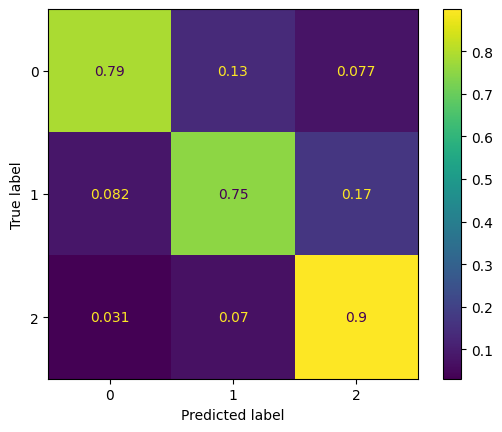

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.46592. Saving Model!
epoch 01, loss: 0.51374, acc: 0.78734, val_loss: 0.46592, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 02, loss: 0.50383, acc: 0.79158, val_loss: 0.47863, val_accuracy: 0.80601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 03, loss: 0.51299, acc: 0.78979, val_loss: 0.47851, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


epoch 04, loss: 0.50429, acc: 0.79454, val_loss: 0.48287, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 05, loss: 0.50168, acc: 0.79661, val_loss: 0.48612, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 06, loss: 0.50532, acc: 0.79330, val_loss: 0.48549, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 07, loss: 0.49934, acc: 0.79504, val_loss: 0.48991, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 08, loss: 0.50050, acc: 0.79539, val_loss: 0.49190, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 09, loss: 0.50042, acc: 0.79428, val_loss: 0.49310, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 10, loss: 0.49779, acc: 0.79533, val_loss: 0.49524, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 11, loss: 0.49842, acc: 0.79515, val_loss: 0.49676, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 12, loss: 0.49710, acc: 0.79672, val_loss: 0.49874, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 13, loss: 0.49703, acc: 0.79675, val_loss: 0.49938, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 14, loss: 0.49600, acc: 0.79709, val_loss: 0.50121, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 15, loss: 0.49544, acc: 0.79742, val_loss: 0.50299, val_accuracy: 0.80601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 16, loss: 0.49497, acc: 0.79753, val_loss: 0.50405, val_accuracy: 0.80581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 17, loss: 0.49481, acc: 0.79740, val_loss: 0.50523, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 18, loss: 0.49395, acc: 0.79775, val_loss: 0.50696, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 19, loss: 0.49348, acc: 0.79801, val_loss: 0.50848, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 20, loss: 0.49350, acc: 0.79986, val_loss: 0.50866, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 21, loss: 0.49267, acc: 0.79980, val_loss: 0.51000, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 22, loss: 0.49232, acc: 0.80015, val_loss: 0.51138, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 23, loss: 0.49225, acc: 0.80041, val_loss: 0.51217, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 24, loss: 0.49167, acc: 0.80032, val_loss: 0.51363, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 25, loss: 0.49145, acc: 0.79943, val_loss: 0.51470, val_accuracy: 0.79835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 26, loss: 0.49100, acc: 0.80085, val_loss: 0.51554, val_accuracy: 0.79835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 27, loss: 0.49044, acc: 0.80085, val_loss: 0.51665, val_accuracy: 0.78952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 28, loss: 0.49058, acc: 0.80152, val_loss: 0.51750, val_accuracy: 0.78932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 29, loss: 0.48968, acc: 0.80109, val_loss: 0.51922, val_accuracy: 0.78912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 30, loss: 0.49027, acc: 0.80111, val_loss: 0.51913, val_accuracy: 0.78912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 31, loss: 0.48885, acc: 0.80316, val_loss: 0.52107, val_accuracy: 0.78873


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 32, loss: 0.48942, acc: 0.80279, val_loss: 0.52116, val_accuracy: 0.78755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 33, loss: 0.48871, acc: 0.80277, val_loss: 0.52213, val_accuracy: 0.78775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 34, loss: 0.48856, acc: 0.80309, val_loss: 0.52295, val_accuracy: 0.78716


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 35, loss: 0.48807, acc: 0.80436, val_loss: 0.52407, val_accuracy: 0.78755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 36, loss: 0.48785, acc: 0.80475, val_loss: 0.52482, val_accuracy: 0.78716


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 37, loss: 0.48748, acc: 0.80333, val_loss: 0.52579, val_accuracy: 0.78716


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 38, loss: 0.48746, acc: 0.80285, val_loss: 0.52643, val_accuracy: 0.78657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 39, loss: 0.48700, acc: 0.80285, val_loss: 0.52674, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 40, loss: 0.48680, acc: 0.80425, val_loss: 0.52738, val_accuracy: 0.78716


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 41, loss: 0.48621, acc: 0.80368, val_loss: 0.52833, val_accuracy: 0.77930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 42, loss: 0.48647, acc: 0.80418, val_loss: 0.52946, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 43, loss: 0.48566, acc: 0.80425, val_loss: 0.53007, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 44, loss: 0.48575, acc: 0.80329, val_loss: 0.53048, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 45, loss: 0.48539, acc: 0.80436, val_loss: 0.53157, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 46, loss: 0.48475, acc: 0.80366, val_loss: 0.53253, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 47, loss: 0.48518, acc: 0.80447, val_loss: 0.53300, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 48, loss: 0.48463, acc: 0.80473, val_loss: 0.53409, val_accuracy: 0.77715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 49, loss: 0.48425, acc: 0.80381, val_loss: 0.53528, val_accuracy: 0.77636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 50, loss: 0.48431, acc: 0.80455, val_loss: 0.53563, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 51, loss: 0.48389, acc: 0.80375, val_loss: 0.53640, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 52, loss: 0.48327, acc: 0.80501, val_loss: 0.53751, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 53, loss: 0.48362, acc: 0.80525, val_loss: 0.53734, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 54, loss: 0.48283, acc: 0.80403, val_loss: 0.53860, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 55, loss: 0.48299, acc: 0.80423, val_loss: 0.53963, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 56, loss: 0.48221, acc: 0.80562, val_loss: 0.54020, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 57, loss: 0.48268, acc: 0.80388, val_loss: 0.54027, val_accuracy: 0.77715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.61it/s]


epoch 58, loss: 0.48162, acc: 0.80466, val_loss: 0.54159, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 59, loss: 0.48198, acc: 0.80499, val_loss: 0.54170, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 60, loss: 0.48119, acc: 0.80434, val_loss: 0.54322, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 61, loss: 0.48188, acc: 0.80565, val_loss: 0.54297, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 62, loss: 0.48045, acc: 0.80538, val_loss: 0.54422, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 63, loss: 0.48121, acc: 0.80495, val_loss: 0.54444, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 64, loss: 0.48007, acc: 0.80650, val_loss: 0.54541, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 65, loss: 0.48059, acc: 0.80752, val_loss: 0.54552, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 66, loss: 0.48003, acc: 0.80584, val_loss: 0.54621, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 67, loss: 0.47996, acc: 0.80728, val_loss: 0.54723, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 68, loss: 0.47942, acc: 0.80684, val_loss: 0.54804, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 69, loss: 0.47986, acc: 0.80663, val_loss: 0.54799, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 70, loss: 0.47879, acc: 0.80774, val_loss: 0.54886, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 71, loss: 0.47920, acc: 0.80680, val_loss: 0.54900, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 72, loss: 0.47837, acc: 0.80809, val_loss: 0.55038, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 73, loss: 0.47893, acc: 0.80778, val_loss: 0.54965, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 74, loss: 0.47768, acc: 0.80815, val_loss: 0.55128, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 75, loss: 0.47841, acc: 0.80726, val_loss: 0.55219, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 76, loss: 0.47770, acc: 0.80833, val_loss: 0.55221, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 77, loss: 0.47768, acc: 0.80807, val_loss: 0.55293, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 78, loss: 0.47726, acc: 0.80837, val_loss: 0.55301, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 79, loss: 0.47724, acc: 0.80822, val_loss: 0.55354, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 80, loss: 0.47690, acc: 0.80850, val_loss: 0.55406, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 81, loss: 0.47663, acc: 0.80861, val_loss: 0.55490, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 82, loss: 0.47638, acc: 0.80898, val_loss: 0.55480, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 83, loss: 0.47654, acc: 0.80924, val_loss: 0.55547, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 84, loss: 0.47586, acc: 0.80944, val_loss: 0.55634, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 85, loss: 0.47616, acc: 0.80927, val_loss: 0.55659, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 86, loss: 0.47551, acc: 0.80944, val_loss: 0.55656, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 87, loss: 0.47541, acc: 0.80927, val_loss: 0.55716, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 88, loss: 0.47529, acc: 0.80948, val_loss: 0.55780, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 89, loss: 0.47494, acc: 0.80927, val_loss: 0.55848, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 90, loss: 0.47502, acc: 0.80962, val_loss: 0.55885, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 91, loss: 0.47429, acc: 0.80951, val_loss: 0.55942, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 92, loss: 0.47506, acc: 0.80955, val_loss: 0.55861, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 93, loss: 0.47357, acc: 0.81010, val_loss: 0.56070, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 94, loss: 0.47435, acc: 0.80990, val_loss: 0.56002, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 95, loss: 0.47367, acc: 0.80972, val_loss: 0.56084, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 96, loss: 0.47371, acc: 0.80996, val_loss: 0.56079, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 97, loss: 0.47345, acc: 0.80972, val_loss: 0.56103, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 98, loss: 0.47314, acc: 0.81040, val_loss: 0.56230, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 99, loss: 0.47303, acc: 0.81031, val_loss: 0.56306, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 100, loss: 0.47293, acc: 0.81036, val_loss: 0.56225, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 101, loss: 0.47245, acc: 0.81023, val_loss: 0.56308, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 102, loss: 0.47252, acc: 0.81055, val_loss: 0.56342, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 103, loss: 0.47193, acc: 0.81055, val_loss: 0.56437, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 104, loss: 0.47198, acc: 0.81051, val_loss: 0.56461, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 105, loss: 0.47200, acc: 0.81075, val_loss: 0.56408, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 106, loss: 0.47117, acc: 0.81099, val_loss: 0.56522, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 107, loss: 0.47179, acc: 0.81081, val_loss: 0.56598, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 108, loss: 0.47073, acc: 0.81136, val_loss: 0.56644, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 109, loss: 0.47150, acc: 0.81101, val_loss: 0.56595, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 110, loss: 0.47015, acc: 0.81153, val_loss: 0.56695, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 111, loss: 0.47113, acc: 0.81086, val_loss: 0.56683, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 112, loss: 0.46993, acc: 0.81153, val_loss: 0.56788, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 113, loss: 0.47061, acc: 0.81103, val_loss: 0.56751, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 114, loss: 0.46959, acc: 0.81160, val_loss: 0.56869, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 115, loss: 0.47017, acc: 0.81136, val_loss: 0.56835, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 116, loss: 0.46918, acc: 0.81167, val_loss: 0.56912, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 117, loss: 0.46972, acc: 0.81129, val_loss: 0.56890, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 118, loss: 0.46896, acc: 0.81162, val_loss: 0.56944, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.27it/s]


epoch 119, loss: 0.46914, acc: 0.81180, val_loss: 0.56982, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 120, loss: 0.46848, acc: 0.81193, val_loss: 0.57058, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 121, loss: 0.46888, acc: 0.81215, val_loss: 0.57059, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 122, loss: 0.46794, acc: 0.81263, val_loss: 0.57128, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 123, loss: 0.46884, acc: 0.81236, val_loss: 0.57083, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 124, loss: 0.46736, acc: 0.81278, val_loss: 0.57236, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 125, loss: 0.46800, acc: 0.81258, val_loss: 0.57199, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 126, loss: 0.46773, acc: 0.81271, val_loss: 0.57222, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 127, loss: 0.46741, acc: 0.81263, val_loss: 0.57298, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 128, loss: 0.46695, acc: 0.81319, val_loss: 0.57354, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 129, loss: 0.46722, acc: 0.81300, val_loss: 0.57344, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 130, loss: 0.46665, acc: 0.81319, val_loss: 0.57392, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 131, loss: 0.46672, acc: 0.81297, val_loss: 0.57375, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 132, loss: 0.46626, acc: 0.81339, val_loss: 0.57421, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 133, loss: 0.46627, acc: 0.81341, val_loss: 0.57510, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 134, loss: 0.46612, acc: 0.81352, val_loss: 0.57474, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 135, loss: 0.46568, acc: 0.81345, val_loss: 0.57556, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 136, loss: 0.46561, acc: 0.81372, val_loss: 0.57606, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 137, loss: 0.46569, acc: 0.81359, val_loss: 0.57534, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 138, loss: 0.46533, acc: 0.81380, val_loss: 0.57549, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.66it/s]


epoch 139, loss: 0.46492, acc: 0.81376, val_loss: 0.57710, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 140, loss: 0.46509, acc: 0.81417, val_loss: 0.57659, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


epoch 141, loss: 0.46475, acc: 0.81359, val_loss: 0.57723, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 142, loss: 0.46453, acc: 0.81424, val_loss: 0.57788, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 143, loss: 0.46424, acc: 0.81398, val_loss: 0.57715, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 144, loss: 0.46446, acc: 0.81431, val_loss: 0.57741, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 145, loss: 0.46370, acc: 0.81417, val_loss: 0.57915, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 146, loss: 0.46403, acc: 0.81452, val_loss: 0.57824, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 147, loss: 0.46362, acc: 0.81402, val_loss: 0.57931, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 148, loss: 0.46357, acc: 0.81498, val_loss: 0.57813, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 149, loss: 0.46318, acc: 0.81420, val_loss: 0.57942, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 150, loss: 0.46323, acc: 0.81450, val_loss: 0.57938, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 151, loss: 0.46305, acc: 0.81426, val_loss: 0.57975, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 152, loss: 0.46238, acc: 0.81509, val_loss: 0.58023, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 153, loss: 0.46279, acc: 0.81468, val_loss: 0.58035, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 154, loss: 0.46234, acc: 0.81533, val_loss: 0.58067, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 155, loss: 0.46225, acc: 0.81481, val_loss: 0.58088, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 156, loss: 0.46206, acc: 0.81535, val_loss: 0.58047, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 157, loss: 0.46183, acc: 0.81487, val_loss: 0.58144, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 158, loss: 0.46131, acc: 0.81557, val_loss: 0.58203, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 159, loss: 0.46177, acc: 0.81522, val_loss: 0.58174, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 160, loss: 0.46093, acc: 0.81559, val_loss: 0.58274, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 161, loss: 0.46146, acc: 0.81518, val_loss: 0.58226, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 162, loss: 0.46019, acc: 0.81557, val_loss: 0.58324, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 163, loss: 0.46135, acc: 0.81568, val_loss: 0.58205, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 164, loss: 0.45995, acc: 0.81574, val_loss: 0.58421, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 165, loss: 0.46088, acc: 0.81550, val_loss: 0.58392, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 166, loss: 0.45962, acc: 0.81603, val_loss: 0.58432, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 167, loss: 0.46039, acc: 0.81572, val_loss: 0.58410, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 168, loss: 0.45922, acc: 0.81603, val_loss: 0.58491, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 169, loss: 0.45998, acc: 0.81572, val_loss: 0.58438, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 170, loss: 0.45928, acc: 0.81636, val_loss: 0.58620, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 171, loss: 0.45956, acc: 0.81581, val_loss: 0.58551, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 172, loss: 0.45926, acc: 0.81596, val_loss: 0.58513, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 173, loss: 0.45885, acc: 0.81594, val_loss: 0.58624, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 174, loss: 0.45865, acc: 0.81660, val_loss: 0.58677, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 175, loss: 0.45905, acc: 0.81566, val_loss: 0.58686, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 176, loss: 0.45795, acc: 0.81668, val_loss: 0.58773, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 177, loss: 0.45847, acc: 0.81627, val_loss: 0.58761, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.61it/s]


epoch 178, loss: 0.45795, acc: 0.81655, val_loss: 0.58818, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 179, loss: 0.45827, acc: 0.81655, val_loss: 0.58684, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.49it/s]


epoch 180, loss: 0.45732, acc: 0.81657, val_loss: 0.58873, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 181, loss: 0.45783, acc: 0.81636, val_loss: 0.58889, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 182, loss: 0.45765, acc: 0.81668, val_loss: 0.58875, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


epoch 183, loss: 0.45710, acc: 0.81657, val_loss: 0.58956, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 184, loss: 0.45702, acc: 0.81692, val_loss: 0.58977, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 185, loss: 0.45718, acc: 0.81651, val_loss: 0.58990, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 186, loss: 0.45634, acc: 0.81703, val_loss: 0.58992, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 187, loss: 0.45688, acc: 0.81692, val_loss: 0.58995, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 188, loss: 0.45589, acc: 0.81692, val_loss: 0.59159, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 189, loss: 0.45662, acc: 0.81690, val_loss: 0.59066, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 190, loss: 0.45589, acc: 0.81738, val_loss: 0.59076, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


epoch 191, loss: 0.45599, acc: 0.81688, val_loss: 0.59143, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 192, loss: 0.45553, acc: 0.81810, val_loss: 0.59254, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 193, loss: 0.45565, acc: 0.81716, val_loss: 0.59212, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


epoch 194, loss: 0.45553, acc: 0.81727, val_loss: 0.59272, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 195, loss: 0.45443, acc: 0.81790, val_loss: 0.59272, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 196, loss: 0.45579, acc: 0.81718, val_loss: 0.59240, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 197, loss: 0.45415, acc: 0.81758, val_loss: 0.59395, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 198, loss: 0.45488, acc: 0.81769, val_loss: 0.59309, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 199, loss: 0.45453, acc: 0.81749, val_loss: 0.59362, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 200, loss: 0.45412, acc: 0.81773, val_loss: 0.59434, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 201, loss: 0.45420, acc: 0.81773, val_loss: 0.59476, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 202, loss: 0.45432, acc: 0.81788, val_loss: 0.59447, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 203, loss: 0.45354, acc: 0.81786, val_loss: 0.59515, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 204, loss: 0.45376, acc: 0.81784, val_loss: 0.59521, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 205, loss: 0.45341, acc: 0.81821, val_loss: 0.59542, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 206, loss: 0.45365, acc: 0.81788, val_loss: 0.59539, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 207, loss: 0.45258, acc: 0.81830, val_loss: 0.59584, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 208, loss: 0.45344, acc: 0.81782, val_loss: 0.59531, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 209, loss: 0.45245, acc: 0.81851, val_loss: 0.59584, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 210, loss: 0.45275, acc: 0.81801, val_loss: 0.59713, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 211, loss: 0.45253, acc: 0.81932, val_loss: 0.59634, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 212, loss: 0.45237, acc: 0.81788, val_loss: 0.59672, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.44it/s]


epoch 213, loss: 0.45164, acc: 0.81869, val_loss: 0.59757, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 214, loss: 0.45230, acc: 0.81817, val_loss: 0.59722, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 215, loss: 0.45163, acc: 0.81841, val_loss: 0.59744, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 216, loss: 0.45143, acc: 0.81821, val_loss: 0.59800, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 217, loss: 0.45165, acc: 0.81823, val_loss: 0.59819, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 218, loss: 0.45071, acc: 0.81889, val_loss: 0.59870, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 219, loss: 0.45151, acc: 0.81865, val_loss: 0.59827, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 220, loss: 0.45043, acc: 0.81869, val_loss: 0.59836, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 221, loss: 0.45104, acc: 0.81899, val_loss: 0.59844, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 222, loss: 0.45060, acc: 0.81843, val_loss: 0.59874, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s]


epoch 223, loss: 0.45023, acc: 0.81893, val_loss: 0.59980, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 224, loss: 0.45009, acc: 0.81899, val_loss: 0.59991, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 225, loss: 0.45058, acc: 0.81873, val_loss: 0.59949, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 226, loss: 0.44983, acc: 0.81950, val_loss: 0.60017, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 227, loss: 0.45017, acc: 0.81943, val_loss: 0.60040, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 228, loss: 0.44904, acc: 0.82037, val_loss: 0.60093, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 229, loss: 0.45016, acc: 0.82024, val_loss: 0.59984, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 230, loss: 0.44878, acc: 0.82078, val_loss: 0.60173, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 231, loss: 0.44974, acc: 0.82022, val_loss: 0.60006, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 232, loss: 0.44850, acc: 0.82126, val_loss: 0.60161, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 233, loss: 0.44923, acc: 0.82024, val_loss: 0.60087, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 234, loss: 0.44826, acc: 0.82111, val_loss: 0.60183, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 235, loss: 0.44876, acc: 0.82011, val_loss: 0.60193, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 236, loss: 0.44830, acc: 0.82065, val_loss: 0.60193, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 237, loss: 0.44807, acc: 0.82030, val_loss: 0.60194, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 238, loss: 0.44821, acc: 0.82131, val_loss: 0.60265, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 239, loss: 0.44794, acc: 0.82115, val_loss: 0.60217, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 240, loss: 0.44751, acc: 0.82137, val_loss: 0.60315, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 241, loss: 0.44748, acc: 0.82187, val_loss: 0.60257, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 242, loss: 0.44752, acc: 0.82111, val_loss: 0.60369, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 243, loss: 0.44678, acc: 0.82098, val_loss: 0.60337, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 244, loss: 0.44757, acc: 0.82096, val_loss: 0.60304, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 245, loss: 0.44630, acc: 0.82214, val_loss: 0.60474, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 246, loss: 0.44717, acc: 0.82074, val_loss: 0.60462, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 247, loss: 0.44606, acc: 0.82229, val_loss: 0.60454, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 248, loss: 0.44660, acc: 0.82155, val_loss: 0.60471, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 249, loss: 0.44610, acc: 0.82131, val_loss: 0.60470, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 250, loss: 0.44607, acc: 0.82163, val_loss: 0.60472, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 251, loss: 0.44593, acc: 0.82211, val_loss: 0.60486, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 252, loss: 0.44550, acc: 0.82109, val_loss: 0.60622, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 253, loss: 0.44592, acc: 0.82240, val_loss: 0.60490, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 254, loss: 0.44528, acc: 0.82190, val_loss: 0.60566, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 255, loss: 0.44516, acc: 0.82266, val_loss: 0.60632, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 256, loss: 0.44533, acc: 0.82196, val_loss: 0.60627, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 257, loss: 0.44462, acc: 0.82286, val_loss: 0.60627, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 258, loss: 0.44499, acc: 0.82192, val_loss: 0.60722, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 259, loss: 0.44436, acc: 0.82307, val_loss: 0.60611, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 260, loss: 0.44473, acc: 0.82229, val_loss: 0.60665, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 261, loss: 0.44420, acc: 0.82314, val_loss: 0.60766, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 262, loss: 0.44407, acc: 0.82288, val_loss: 0.60803, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 263, loss: 0.44417, acc: 0.82314, val_loss: 0.60675, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 264, loss: 0.44355, acc: 0.82301, val_loss: 0.60927, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 265, loss: 0.44364, acc: 0.82362, val_loss: 0.60765, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 266, loss: 0.44369, acc: 0.82303, val_loss: 0.60861, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 267, loss: 0.44280, acc: 0.82406, val_loss: 0.60884, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 268, loss: 0.44366, acc: 0.82336, val_loss: 0.60822, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 269, loss: 0.44224, acc: 0.82403, val_loss: 0.61029, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 270, loss: 0.44372, acc: 0.82384, val_loss: 0.60829, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 271, loss: 0.44164, acc: 0.82445, val_loss: 0.61047, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 272, loss: 0.44330, acc: 0.82331, val_loss: 0.60928, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 273, loss: 0.44160, acc: 0.82438, val_loss: 0.60981, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 274, loss: 0.44265, acc: 0.82358, val_loss: 0.61071, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 275, loss: 0.44170, acc: 0.82406, val_loss: 0.61002, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 276, loss: 0.44223, acc: 0.82436, val_loss: 0.61123, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 277, loss: 0.44142, acc: 0.82515, val_loss: 0.61137, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


epoch 278, loss: 0.44150, acc: 0.82469, val_loss: 0.60988, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 279, loss: 0.44170, acc: 0.82508, val_loss: 0.61135, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.28it/s]


epoch 280, loss: 0.44081, acc: 0.82556, val_loss: 0.61200, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 281, loss: 0.44147, acc: 0.82576, val_loss: 0.61121, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 282, loss: 0.44074, acc: 0.82558, val_loss: 0.61205, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


epoch 283, loss: 0.44090, acc: 0.82571, val_loss: 0.61299, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 284, loss: 0.44037, acc: 0.82539, val_loss: 0.61192, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 285, loss: 0.44064, acc: 0.82580, val_loss: 0.61291, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 286, loss: 0.44000, acc: 0.82608, val_loss: 0.61286, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 287, loss: 0.44038, acc: 0.82604, val_loss: 0.61273, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 288, loss: 0.43970, acc: 0.82635, val_loss: 0.61289, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 289, loss: 0.44008, acc: 0.82595, val_loss: 0.61362, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 290, loss: 0.43926, acc: 0.82654, val_loss: 0.61431, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 291, loss: 0.43997, acc: 0.82746, val_loss: 0.61298, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 292, loss: 0.43873, acc: 0.82765, val_loss: 0.61452, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 293, loss: 0.43961, acc: 0.82768, val_loss: 0.61404, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


epoch 294, loss: 0.43857, acc: 0.82792, val_loss: 0.61452, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 295, loss: 0.43934, acc: 0.82829, val_loss: 0.61410, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 296, loss: 0.43837, acc: 0.82837, val_loss: 0.61528, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 297, loss: 0.43869, acc: 0.82789, val_loss: 0.61607, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 298, loss: 0.43831, acc: 0.82752, val_loss: 0.61553, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 299, loss: 0.43827, acc: 0.82785, val_loss: 0.61549, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 300, loss: 0.43810, acc: 0.82822, val_loss: 0.61524, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 301, loss: 0.43780, acc: 0.82779, val_loss: 0.61711, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 302, loss: 0.43768, acc: 0.82787, val_loss: 0.61581, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 303, loss: 0.43779, acc: 0.82829, val_loss: 0.61639, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 304, loss: 0.43725, acc: 0.82896, val_loss: 0.61714, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 305, loss: 0.43726, acc: 0.82861, val_loss: 0.61754, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 306, loss: 0.43741, acc: 0.82837, val_loss: 0.61622, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 307, loss: 0.43693, acc: 0.82853, val_loss: 0.61865, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 308, loss: 0.43689, acc: 0.82861, val_loss: 0.61771, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 309, loss: 0.43684, acc: 0.82827, val_loss: 0.61767, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 310, loss: 0.43632, acc: 0.82933, val_loss: 0.61769, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 311, loss: 0.43660, acc: 0.82909, val_loss: 0.61826, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 312, loss: 0.43584, acc: 0.82896, val_loss: 0.61826, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 313, loss: 0.43652, acc: 0.82831, val_loss: 0.61893, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 314, loss: 0.43548, acc: 0.82903, val_loss: 0.61836, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 315, loss: 0.43607, acc: 0.82885, val_loss: 0.61951, val_accuracy: 0.77420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 316, loss: 0.43519, acc: 0.82929, val_loss: 0.61932, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 317, loss: 0.43586, acc: 0.82909, val_loss: 0.61924, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.81it/s]


epoch 318, loss: 0.43484, acc: 0.82949, val_loss: 0.62110, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 319, loss: 0.43522, acc: 0.82977, val_loss: 0.61961, val_accuracy: 0.77479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 320, loss: 0.43499, acc: 0.82929, val_loss: 0.62027, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 321, loss: 0.43486, acc: 0.82885, val_loss: 0.62011, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 322, loss: 0.43449, acc: 0.83001, val_loss: 0.62008, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 323, loss: 0.43446, acc: 0.82990, val_loss: 0.62168, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 324, loss: 0.43426, acc: 0.82968, val_loss: 0.62085, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 325, loss: 0.43387, acc: 0.83003, val_loss: 0.62172, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 326, loss: 0.43439, acc: 0.82951, val_loss: 0.62049, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 327, loss: 0.43357, acc: 0.82968, val_loss: 0.62250, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 328, loss: 0.43386, acc: 0.82971, val_loss: 0.62156, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 329, loss: 0.43352, acc: 0.82953, val_loss: 0.62200, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 330, loss: 0.43312, acc: 0.83008, val_loss: 0.62300, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 331, loss: 0.43352, acc: 0.82999, val_loss: 0.62233, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 332, loss: 0.43272, acc: 0.83082, val_loss: 0.62328, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 333, loss: 0.43318, acc: 0.82957, val_loss: 0.62237, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 334, loss: 0.43253, acc: 0.82986, val_loss: 0.62316, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 335, loss: 0.43288, acc: 0.83069, val_loss: 0.62337, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 336, loss: 0.43185, acc: 0.83110, val_loss: 0.62320, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 337, loss: 0.43291, acc: 0.82973, val_loss: 0.62433, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 338, loss: 0.43185, acc: 0.83040, val_loss: 0.62396, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 339, loss: 0.43226, acc: 0.83077, val_loss: 0.62431, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 340, loss: 0.43161, acc: 0.83156, val_loss: 0.62436, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 341, loss: 0.43206, acc: 0.83121, val_loss: 0.62443, val_accuracy: 0.77479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 342, loss: 0.43122, acc: 0.83149, val_loss: 0.62522, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 343, loss: 0.43191, acc: 0.83099, val_loss: 0.62497, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 344, loss: 0.43077, acc: 0.83191, val_loss: 0.62479, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 345, loss: 0.43201, acc: 0.82986, val_loss: 0.62480, val_accuracy: 0.77420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 346, loss: 0.42991, acc: 0.83204, val_loss: 0.62649, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 347, loss: 0.43176, acc: 0.83101, val_loss: 0.62448, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 348, loss: 0.42987, acc: 0.83143, val_loss: 0.62633, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.66it/s]


epoch 349, loss: 0.43106, acc: 0.83130, val_loss: 0.62578, val_accuracy: 0.77420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 350, loss: 0.42984, acc: 0.83230, val_loss: 0.62712, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 351, loss: 0.43096, acc: 0.83191, val_loss: 0.62394, val_accuracy: 0.77479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 352, loss: 0.42905, acc: 0.83228, val_loss: 0.62819, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 353, loss: 0.43059, acc: 0.83180, val_loss: 0.62533, val_accuracy: 0.77479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 354, loss: 0.42912, acc: 0.83239, val_loss: 0.62756, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 355, loss: 0.42992, acc: 0.83165, val_loss: 0.62648, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 356, loss: 0.42950, acc: 0.83191, val_loss: 0.62633, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 357, loss: 0.42919, acc: 0.83239, val_loss: 0.62799, val_accuracy: 0.77499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 358, loss: 0.42933, acc: 0.83232, val_loss: 0.62671, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


epoch 359, loss: 0.42910, acc: 0.83200, val_loss: 0.62862, val_accuracy: 0.77499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 360, loss: 0.42856, acc: 0.83204, val_loss: 0.62774, val_accuracy: 0.77420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 361, loss: 0.42906, acc: 0.83215, val_loss: 0.62906, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 362, loss: 0.42826, acc: 0.83232, val_loss: 0.62751, val_accuracy: 0.77420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 363, loss: 0.42835, acc: 0.83267, val_loss: 0.62985, val_accuracy: 0.77538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 364, loss: 0.42804, acc: 0.83232, val_loss: 0.62751, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 365, loss: 0.42794, acc: 0.83291, val_loss: 0.62929, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 366, loss: 0.42773, acc: 0.83243, val_loss: 0.62854, val_accuracy: 0.77499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 367, loss: 0.42789, acc: 0.83274, val_loss: 0.62988, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 368, loss: 0.42724, acc: 0.83300, val_loss: 0.62898, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 369, loss: 0.42754, acc: 0.83243, val_loss: 0.62956, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 370, loss: 0.42735, acc: 0.83263, val_loss: 0.62901, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 371, loss: 0.42669, acc: 0.83243, val_loss: 0.63153, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 372, loss: 0.42721, acc: 0.83250, val_loss: 0.62947, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 373, loss: 0.42658, acc: 0.83324, val_loss: 0.63039, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 374, loss: 0.42634, acc: 0.83282, val_loss: 0.63047, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 375, loss: 0.42694, acc: 0.83278, val_loss: 0.63126, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 376, loss: 0.42602, acc: 0.83274, val_loss: 0.63012, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 377, loss: 0.42616, acc: 0.83317, val_loss: 0.63153, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 378, loss: 0.42601, acc: 0.83280, val_loss: 0.62984, val_accuracy: 0.77577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 379, loss: 0.42602, acc: 0.83287, val_loss: 0.63151, val_accuracy: 0.77577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 380, loss: 0.42520, acc: 0.83304, val_loss: 0.63164, val_accuracy: 0.77499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 381, loss: 0.42605, acc: 0.83320, val_loss: 0.63061, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 382, loss: 0.42518, acc: 0.83296, val_loss: 0.63190, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 383, loss: 0.42525, acc: 0.83302, val_loss: 0.63351, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 384, loss: 0.42515, acc: 0.83304, val_loss: 0.63153, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 385, loss: 0.42499, acc: 0.83374, val_loss: 0.63248, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 386, loss: 0.42445, acc: 0.83309, val_loss: 0.63168, val_accuracy: 0.77636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 387, loss: 0.42481, acc: 0.83370, val_loss: 0.63288, val_accuracy: 0.77695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 388, loss: 0.42412, acc: 0.83378, val_loss: 0.63182, val_accuracy: 0.77695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 389, loss: 0.42459, acc: 0.83313, val_loss: 0.63335, val_accuracy: 0.77715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 390, loss: 0.42383, acc: 0.83381, val_loss: 0.63382, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 391, loss: 0.42448, acc: 0.83344, val_loss: 0.63368, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 392, loss: 0.42352, acc: 0.83374, val_loss: 0.63410, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 393, loss: 0.42428, acc: 0.83330, val_loss: 0.63323, val_accuracy: 0.77695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 394, loss: 0.42300, acc: 0.83411, val_loss: 0.63483, val_accuracy: 0.77695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 395, loss: 0.42417, acc: 0.83363, val_loss: 0.63442, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 396, loss: 0.42270, acc: 0.83490, val_loss: 0.63466, val_accuracy: 0.77636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 397, loss: 0.42353, acc: 0.83328, val_loss: 0.63753, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 398, loss: 0.42298, acc: 0.83431, val_loss: 0.63380, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 399, loss: 0.42273, acc: 0.83418, val_loss: 0.63768, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 400, loss: 0.42268, acc: 0.83457, val_loss: 0.63521, val_accuracy: 0.77695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 401, loss: 0.42279, acc: 0.83415, val_loss: 0.63929, val_accuracy: 0.77734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 402, loss: 0.42202, acc: 0.83444, val_loss: 0.64057, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 403, loss: 0.42263, acc: 0.83402, val_loss: 0.64014, val_accuracy: 0.77734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 404, loss: 0.42148, acc: 0.83431, val_loss: 0.63916, val_accuracy: 0.77695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 405, loss: 0.42223, acc: 0.83405, val_loss: 0.64047, val_accuracy: 0.77715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 406, loss: 0.42188, acc: 0.83470, val_loss: 0.64082, val_accuracy: 0.77695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 407, loss: 0.42163, acc: 0.83398, val_loss: 0.64219, val_accuracy: 0.77852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 408, loss: 0.42177, acc: 0.83479, val_loss: 0.63958, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 409, loss: 0.42068, acc: 0.83457, val_loss: 0.64287, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 410, loss: 0.42169, acc: 0.83540, val_loss: 0.64084, val_accuracy: 0.77715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 411, loss: 0.42051, acc: 0.83439, val_loss: 0.64288, val_accuracy: 0.77773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 412, loss: 0.42108, acc: 0.83559, val_loss: 0.64200, val_accuracy: 0.77754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 413, loss: 0.42073, acc: 0.83531, val_loss: 0.64458, val_accuracy: 0.77734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 414, loss: 0.42049, acc: 0.83553, val_loss: 0.64168, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 415, loss: 0.42046, acc: 0.83479, val_loss: 0.64488, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 416, loss: 0.42042, acc: 0.83581, val_loss: 0.64394, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 417, loss: 0.41996, acc: 0.83466, val_loss: 0.64608, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 418, loss: 0.42029, acc: 0.83468, val_loss: 0.64378, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 419, loss: 0.41933, acc: 0.83507, val_loss: 0.64730, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 420, loss: 0.42004, acc: 0.83535, val_loss: 0.64456, val_accuracy: 0.77715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 421, loss: 0.41918, acc: 0.83612, val_loss: 0.64678, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 422, loss: 0.41945, acc: 0.83533, val_loss: 0.64613, val_accuracy: 0.77773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 423, loss: 0.41901, acc: 0.83533, val_loss: 0.64626, val_accuracy: 0.77734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 424, loss: 0.41931, acc: 0.83568, val_loss: 0.64700, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 425, loss: 0.41860, acc: 0.83638, val_loss: 0.64691, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 426, loss: 0.41889, acc: 0.83553, val_loss: 0.64685, val_accuracy: 0.77754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 427, loss: 0.41854, acc: 0.83603, val_loss: 0.64717, val_accuracy: 0.77911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 428, loss: 0.41836, acc: 0.83579, val_loss: 0.64784, val_accuracy: 0.77754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 429, loss: 0.41836, acc: 0.83684, val_loss: 0.64868, val_accuracy: 0.77852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 430, loss: 0.41790, acc: 0.83762, val_loss: 0.64870, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 431, loss: 0.41815, acc: 0.83647, val_loss: 0.64872, val_accuracy: 0.77891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 432, loss: 0.41763, acc: 0.83762, val_loss: 0.64883, val_accuracy: 0.77734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 433, loss: 0.41797, acc: 0.83666, val_loss: 0.64904, val_accuracy: 0.77891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 434, loss: 0.41753, acc: 0.83649, val_loss: 0.65024, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 435, loss: 0.41764, acc: 0.83701, val_loss: 0.65079, val_accuracy: 0.77911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 436, loss: 0.41752, acc: 0.83636, val_loss: 0.65014, val_accuracy: 0.77773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 437, loss: 0.41704, acc: 0.83710, val_loss: 0.65015, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 438, loss: 0.41693, acc: 0.83804, val_loss: 0.65056, val_accuracy: 0.77832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 439, loss: 0.41743, acc: 0.83717, val_loss: 0.65119, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 440, loss: 0.41595, acc: 0.83823, val_loss: 0.65242, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 441, loss: 0.41777, acc: 0.83682, val_loss: 0.64999, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 442, loss: 0.41534, acc: 0.83762, val_loss: 0.65357, val_accuracy: 0.77852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 443, loss: 0.41697, acc: 0.83671, val_loss: 0.65174, val_accuracy: 0.77832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 444, loss: 0.41557, acc: 0.83793, val_loss: 0.65282, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 445, loss: 0.41674, acc: 0.83797, val_loss: 0.65231, val_accuracy: 0.77852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 446, loss: 0.41513, acc: 0.83836, val_loss: 0.65261, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 447, loss: 0.41675, acc: 0.83795, val_loss: 0.65377, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 448, loss: 0.41476, acc: 0.83898, val_loss: 0.65467, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 449, loss: 0.41611, acc: 0.83688, val_loss: 0.65411, val_accuracy: 0.77911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 450, loss: 0.41510, acc: 0.83817, val_loss: 0.65242, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 451, loss: 0.41555, acc: 0.83784, val_loss: 0.65556, val_accuracy: 0.77989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 452, loss: 0.41433, acc: 0.83882, val_loss: 0.65351, val_accuracy: 0.77852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 453, loss: 0.41560, acc: 0.83760, val_loss: 0.65565, val_accuracy: 0.77891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 454, loss: 0.41348, acc: 0.83963, val_loss: 0.65653, val_accuracy: 0.77930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 455, loss: 0.41605, acc: 0.83703, val_loss: 0.65417, val_accuracy: 0.77891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 456, loss: 0.41298, acc: 0.83996, val_loss: 0.65694, val_accuracy: 0.77832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


epoch 457, loss: 0.41546, acc: 0.83847, val_loss: 0.65477, val_accuracy: 0.77911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 458, loss: 0.41319, acc: 0.83900, val_loss: 0.65786, val_accuracy: 0.77930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 459, loss: 0.41481, acc: 0.83887, val_loss: 0.65717, val_accuracy: 0.77891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 460, loss: 0.41347, acc: 0.83970, val_loss: 0.65625, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 461, loss: 0.41432, acc: 0.83867, val_loss: 0.65792, val_accuracy: 0.77989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


epoch 462, loss: 0.41323, acc: 0.83889, val_loss: 0.65658, val_accuracy: 0.77832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 463, loss: 0.41395, acc: 0.83874, val_loss: 0.65870, val_accuracy: 0.77950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 464, loss: 0.41243, acc: 0.84042, val_loss: 0.65842, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 465, loss: 0.41460, acc: 0.83865, val_loss: 0.65775, val_accuracy: 0.77911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 466, loss: 0.41188, acc: 0.83965, val_loss: 0.65892, val_accuracy: 0.78009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 467, loss: 0.41376, acc: 0.83915, val_loss: 0.65961, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 468, loss: 0.41201, acc: 0.84037, val_loss: 0.65934, val_accuracy: 0.77950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 469, loss: 0.41306, acc: 0.83939, val_loss: 0.65955, val_accuracy: 0.77950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 470, loss: 0.41203, acc: 0.83952, val_loss: 0.65882, val_accuracy: 0.77950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 471, loss: 0.41211, acc: 0.83950, val_loss: 0.66320, val_accuracy: 0.77832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 472, loss: 0.41197, acc: 0.84031, val_loss: 0.65843, val_accuracy: 0.77989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 473, loss: 0.41209, acc: 0.83950, val_loss: 0.66122, val_accuracy: 0.78048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 474, loss: 0.41108, acc: 0.84066, val_loss: 0.66117, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 475, loss: 0.41222, acc: 0.83961, val_loss: 0.66188, val_accuracy: 0.78029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 476, loss: 0.41115, acc: 0.84050, val_loss: 0.66174, val_accuracy: 0.78068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 477, loss: 0.41164, acc: 0.83989, val_loss: 0.66048, val_accuracy: 0.78029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 478, loss: 0.41115, acc: 0.84055, val_loss: 0.66136, val_accuracy: 0.78009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 479, loss: 0.41117, acc: 0.84002, val_loss: 0.66267, val_accuracy: 0.78048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 480, loss: 0.41095, acc: 0.84070, val_loss: 0.66143, val_accuracy: 0.77970


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 481, loss: 0.41080, acc: 0.84022, val_loss: 0.66456, val_accuracy: 0.77950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 482, loss: 0.41065, acc: 0.84042, val_loss: 0.66158, val_accuracy: 0.78009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 483, loss: 0.41073, acc: 0.84013, val_loss: 0.66419, val_accuracy: 0.78029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 484, loss: 0.41017, acc: 0.84098, val_loss: 0.66296, val_accuracy: 0.77970


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 485, loss: 0.41043, acc: 0.84004, val_loss: 0.66412, val_accuracy: 0.77989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 486, loss: 0.41000, acc: 0.84120, val_loss: 0.66347, val_accuracy: 0.77989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 487, loss: 0.41010, acc: 0.84011, val_loss: 0.66422, val_accuracy: 0.78029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 488, loss: 0.40982, acc: 0.84087, val_loss: 0.66274, val_accuracy: 0.78048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 489, loss: 0.40927, acc: 0.84035, val_loss: 0.66729, val_accuracy: 0.78107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 490, loss: 0.40950, acc: 0.84127, val_loss: 0.66336, val_accuracy: 0.77989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 491, loss: 0.40956, acc: 0.84013, val_loss: 0.66570, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 492, loss: 0.40896, acc: 0.84155, val_loss: 0.66469, val_accuracy: 0.78009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 493, loss: 0.40917, acc: 0.84028, val_loss: 0.66510, val_accuracy: 0.78029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 494, loss: 0.40878, acc: 0.84146, val_loss: 0.66414, val_accuracy: 0.78009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 495, loss: 0.40894, acc: 0.84087, val_loss: 0.66596, val_accuracy: 0.78009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 496, loss: 0.40878, acc: 0.84247, val_loss: 0.66415, val_accuracy: 0.78029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 497, loss: 0.40822, acc: 0.84090, val_loss: 0.66682, val_accuracy: 0.77989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 498, loss: 0.40870, acc: 0.84157, val_loss: 0.66430, val_accuracy: 0.78048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 499, loss: 0.40797, acc: 0.84109, val_loss: 0.66735, val_accuracy: 0.77832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.67it/s]


epoch 500, loss: 0.40830, acc: 0.84251, val_loss: 0.66605, val_accuracy: 0.78009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 501, loss: 0.40769, acc: 0.84205, val_loss: 0.66719, val_accuracy: 0.78009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 502, loss: 0.40808, acc: 0.84240, val_loss: 0.66627, val_accuracy: 0.78029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 503, loss: 0.40766, acc: 0.84209, val_loss: 0.66953, val_accuracy: 0.77773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 504, loss: 0.40758, acc: 0.84286, val_loss: 0.66699, val_accuracy: 0.77989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 505, loss: 0.40751, acc: 0.84209, val_loss: 0.66747, val_accuracy: 0.77852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 506, loss: 0.40724, acc: 0.84286, val_loss: 0.66762, val_accuracy: 0.77989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 507, loss: 0.40698, acc: 0.84260, val_loss: 0.66905, val_accuracy: 0.78088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 508, loss: 0.40714, acc: 0.84295, val_loss: 0.66837, val_accuracy: 0.77911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 509, loss: 0.40683, acc: 0.84253, val_loss: 0.66944, val_accuracy: 0.78068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 510, loss: 0.40659, acc: 0.84305, val_loss: 0.66775, val_accuracy: 0.78009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]


epoch 511, loss: 0.40677, acc: 0.84251, val_loss: 0.67089, val_accuracy: 0.77911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 512, loss: 0.40604, acc: 0.84351, val_loss: 0.66813, val_accuracy: 0.77754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 513, loss: 0.40675, acc: 0.84257, val_loss: 0.66996, val_accuracy: 0.77852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 514, loss: 0.40586, acc: 0.84360, val_loss: 0.66925, val_accuracy: 0.77970


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 515, loss: 0.40599, acc: 0.84271, val_loss: 0.67021, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 516, loss: 0.40625, acc: 0.84347, val_loss: 0.66876, val_accuracy: 0.78068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 517, loss: 0.40547, acc: 0.84279, val_loss: 0.67222, val_accuracy: 0.77852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 518, loss: 0.40595, acc: 0.84377, val_loss: 0.67009, val_accuracy: 0.77773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 519, loss: 0.40548, acc: 0.84284, val_loss: 0.67293, val_accuracy: 0.77911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 520, loss: 0.40572, acc: 0.84375, val_loss: 0.66925, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 521, loss: 0.40543, acc: 0.84255, val_loss: 0.67211, val_accuracy: 0.77911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 522, loss: 0.40482, acc: 0.84421, val_loss: 0.66989, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 523, loss: 0.40558, acc: 0.84271, val_loss: 0.67264, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 524, loss: 0.40428, acc: 0.84423, val_loss: 0.67206, val_accuracy: 0.78048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 525, loss: 0.40506, acc: 0.84321, val_loss: 0.67307, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 526, loss: 0.40440, acc: 0.84434, val_loss: 0.67093, val_accuracy: 0.77832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 527, loss: 0.40459, acc: 0.84301, val_loss: 0.67456, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 528, loss: 0.40372, acc: 0.84412, val_loss: 0.67297, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 529, loss: 0.40490, acc: 0.84349, val_loss: 0.67238, val_accuracy: 0.78029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 530, loss: 0.40296, acc: 0.84445, val_loss: 0.67332, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 531, loss: 0.40494, acc: 0.84373, val_loss: 0.67261, val_accuracy: 0.77832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 532, loss: 0.40277, acc: 0.84441, val_loss: 0.67557, val_accuracy: 0.77852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 533, loss: 0.40460, acc: 0.84388, val_loss: 0.67182, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 534, loss: 0.40254, acc: 0.84491, val_loss: 0.67553, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 535, loss: 0.40409, acc: 0.84401, val_loss: 0.67225, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 536, loss: 0.40244, acc: 0.84478, val_loss: 0.67604, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 537, loss: 0.40443, acc: 0.84388, val_loss: 0.67312, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 538, loss: 0.40177, acc: 0.84537, val_loss: 0.67793, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 539, loss: 0.40512, acc: 0.84367, val_loss: 0.67218, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 540, loss: 0.40075, acc: 0.84563, val_loss: 0.67701, val_accuracy: 0.77773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 541, loss: 0.40492, acc: 0.84393, val_loss: 0.67182, val_accuracy: 0.77852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 542, loss: 0.40050, acc: 0.84511, val_loss: 0.67884, val_accuracy: 0.77773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 543, loss: 0.40439, acc: 0.84395, val_loss: 0.67377, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 544, loss: 0.40057, acc: 0.84582, val_loss: 0.67847, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 545, loss: 0.40393, acc: 0.84449, val_loss: 0.67520, val_accuracy: 0.77891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 546, loss: 0.40016, acc: 0.84532, val_loss: 0.67968, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 547, loss: 0.40419, acc: 0.84360, val_loss: 0.67381, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 548, loss: 0.39927, acc: 0.84541, val_loss: 0.68103, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 549, loss: 0.40443, acc: 0.84425, val_loss: 0.67272, val_accuracy: 0.77852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 550, loss: 0.39922, acc: 0.84563, val_loss: 0.68116, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 551, loss: 0.40377, acc: 0.84428, val_loss: 0.67386, val_accuracy: 0.77930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 552, loss: 0.39911, acc: 0.84646, val_loss: 0.67989, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 553, loss: 0.40347, acc: 0.84452, val_loss: 0.67541, val_accuracy: 0.77950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 554, loss: 0.39904, acc: 0.84591, val_loss: 0.68172, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 555, loss: 0.40333, acc: 0.84417, val_loss: 0.67646, val_accuracy: 0.77911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 556, loss: 0.39887, acc: 0.84709, val_loss: 0.67999, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 557, loss: 0.40287, acc: 0.84456, val_loss: 0.67642, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 558, loss: 0.39826, acc: 0.84654, val_loss: 0.68188, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 559, loss: 0.40303, acc: 0.84508, val_loss: 0.67548, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 560, loss: 0.39771, acc: 0.84774, val_loss: 0.68264, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 561, loss: 0.40198, acc: 0.84504, val_loss: 0.67859, val_accuracy: 0.77970


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


epoch 562, loss: 0.39847, acc: 0.84626, val_loss: 0.68150, val_accuracy: 0.77852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 563, loss: 0.40118, acc: 0.84552, val_loss: 0.67826, val_accuracy: 0.77832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 564, loss: 0.39805, acc: 0.84676, val_loss: 0.68287, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 565, loss: 0.40145, acc: 0.84596, val_loss: 0.67801, val_accuracy: 0.77911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 566, loss: 0.39725, acc: 0.84740, val_loss: 0.68450, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 567, loss: 0.40188, acc: 0.84578, val_loss: 0.67688, val_accuracy: 0.77911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 568, loss: 0.39632, acc: 0.84796, val_loss: 0.68635, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 569, loss: 0.40174, acc: 0.84580, val_loss: 0.67773, val_accuracy: 0.77950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 570, loss: 0.39630, acc: 0.84746, val_loss: 0.68494, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 571, loss: 0.40127, acc: 0.84511, val_loss: 0.67813, val_accuracy: 0.77950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 572, loss: 0.39635, acc: 0.84812, val_loss: 0.68512, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 573, loss: 0.40098, acc: 0.84504, val_loss: 0.68036, val_accuracy: 0.77832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 574, loss: 0.39609, acc: 0.84755, val_loss: 0.68628, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 575, loss: 0.40131, acc: 0.84596, val_loss: 0.67913, val_accuracy: 0.77970


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 576, loss: 0.39460, acc: 0.84870, val_loss: 0.68713, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 577, loss: 0.40139, acc: 0.84648, val_loss: 0.67775, val_accuracy: 0.77970


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 578, loss: 0.39429, acc: 0.84844, val_loss: 0.68943, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 579, loss: 0.40141, acc: 0.84543, val_loss: 0.67850, val_accuracy: 0.77950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 580, loss: 0.39444, acc: 0.84857, val_loss: 0.68770, val_accuracy: 0.75555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 581, loss: 0.40076, acc: 0.84556, val_loss: 0.67866, val_accuracy: 0.77891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 582, loss: 0.39414, acc: 0.84860, val_loss: 0.68763, val_accuracy: 0.75947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 583, loss: 0.40038, acc: 0.84572, val_loss: 0.68045, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 584, loss: 0.39413, acc: 0.84868, val_loss: 0.68879, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 585, loss: 0.39991, acc: 0.84585, val_loss: 0.68105, val_accuracy: 0.77852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 586, loss: 0.39375, acc: 0.84814, val_loss: 0.68842, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 587, loss: 0.39968, acc: 0.84624, val_loss: 0.68057, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 588, loss: 0.39322, acc: 0.84938, val_loss: 0.69067, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 589, loss: 0.39956, acc: 0.84733, val_loss: 0.68141, val_accuracy: 0.77911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 590, loss: 0.39295, acc: 0.84903, val_loss: 0.69016, val_accuracy: 0.76006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 591, loss: 0.39929, acc: 0.84700, val_loss: 0.67910, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 592, loss: 0.39291, acc: 0.84914, val_loss: 0.68977, val_accuracy: 0.76046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 593, loss: 0.39867, acc: 0.84622, val_loss: 0.68110, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 594, loss: 0.39293, acc: 0.84877, val_loss: 0.69068, val_accuracy: 0.76026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


epoch 595, loss: 0.39881, acc: 0.84709, val_loss: 0.68178, val_accuracy: 0.77891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 596, loss: 0.39250, acc: 0.84938, val_loss: 0.68961, val_accuracy: 0.76006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 597, loss: 0.39810, acc: 0.84648, val_loss: 0.68328, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 598, loss: 0.39239, acc: 0.84894, val_loss: 0.69046, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 599, loss: 0.39817, acc: 0.84626, val_loss: 0.68425, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 600, loss: 0.39158, acc: 0.84997, val_loss: 0.69281, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 601, loss: 0.39809, acc: 0.84635, val_loss: 0.68347, val_accuracy: 0.77950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 602, loss: 0.39124, acc: 0.84923, val_loss: 0.69390, val_accuracy: 0.76026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 603, loss: 0.39803, acc: 0.84596, val_loss: 0.68364, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 604, loss: 0.39082, acc: 0.85023, val_loss: 0.69392, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 605, loss: 0.39783, acc: 0.84674, val_loss: 0.68406, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 606, loss: 0.39046, acc: 0.84973, val_loss: 0.69462, val_accuracy: 0.76006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 607, loss: 0.39767, acc: 0.84639, val_loss: 0.68466, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 608, loss: 0.39036, acc: 0.85010, val_loss: 0.69635, val_accuracy: 0.75987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 609, loss: 0.39691, acc: 0.84702, val_loss: 0.68517, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 610, loss: 0.39046, acc: 0.84956, val_loss: 0.69404, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 611, loss: 0.39698, acc: 0.84685, val_loss: 0.68725, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 612, loss: 0.39005, acc: 0.85010, val_loss: 0.69458, val_accuracy: 0.75967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 613, loss: 0.39655, acc: 0.84665, val_loss: 0.68631, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


epoch 614, loss: 0.39013, acc: 0.84975, val_loss: 0.69415, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 615, loss: 0.39606, acc: 0.84696, val_loss: 0.68894, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 616, loss: 0.38981, acc: 0.85054, val_loss: 0.69464, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 617, loss: 0.39577, acc: 0.84698, val_loss: 0.68772, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 618, loss: 0.38963, acc: 0.84999, val_loss: 0.69295, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 619, loss: 0.39537, acc: 0.84711, val_loss: 0.68706, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 620, loss: 0.38899, acc: 0.85084, val_loss: 0.69534, val_accuracy: 0.75967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 621, loss: 0.39510, acc: 0.84722, val_loss: 0.68669, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 622, loss: 0.38901, acc: 0.84973, val_loss: 0.69620, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 623, loss: 0.39440, acc: 0.84768, val_loss: 0.68934, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 624, loss: 0.38905, acc: 0.85058, val_loss: 0.69630, val_accuracy: 0.76065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 625, loss: 0.39360, acc: 0.84862, val_loss: 0.69012, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 626, loss: 0.38932, acc: 0.84947, val_loss: 0.69516, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 627, loss: 0.39314, acc: 0.84916, val_loss: 0.69104, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 628, loss: 0.38864, acc: 0.85108, val_loss: 0.69679, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 629, loss: 0.39342, acc: 0.84894, val_loss: 0.69120, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 630, loss: 0.38838, acc: 0.85119, val_loss: 0.69978, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 631, loss: 0.39368, acc: 0.84916, val_loss: 0.69022, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 632, loss: 0.38804, acc: 0.85080, val_loss: 0.69930, val_accuracy: 0.76104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 633, loss: 0.39369, acc: 0.84770, val_loss: 0.69100, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 634, loss: 0.38775, acc: 0.85143, val_loss: 0.70023, val_accuracy: 0.76124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 635, loss: 0.39345, acc: 0.84825, val_loss: 0.69205, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 636, loss: 0.38730, acc: 0.85209, val_loss: 0.70041, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 637, loss: 0.39347, acc: 0.84801, val_loss: 0.69411, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 638, loss: 0.38673, acc: 0.85073, val_loss: 0.70129, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


epoch 639, loss: 0.39348, acc: 0.84796, val_loss: 0.69194, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 640, loss: 0.38590, acc: 0.85161, val_loss: 0.70206, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 641, loss: 0.39321, acc: 0.84829, val_loss: 0.69199, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 642, loss: 0.38598, acc: 0.85119, val_loss: 0.70335, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 643, loss: 0.39308, acc: 0.84827, val_loss: 0.69249, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 644, loss: 0.38601, acc: 0.85145, val_loss: 0.70286, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 645, loss: 0.39170, acc: 0.84849, val_loss: 0.69591, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 646, loss: 0.38642, acc: 0.85113, val_loss: 0.70050, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 647, loss: 0.39157, acc: 0.84877, val_loss: 0.69515, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 648, loss: 0.38565, acc: 0.85265, val_loss: 0.70388, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 649, loss: 0.39175, acc: 0.84921, val_loss: 0.69423, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 650, loss: 0.38535, acc: 0.85298, val_loss: 0.70395, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 651, loss: 0.39138, acc: 0.84881, val_loss: 0.69419, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 652, loss: 0.38530, acc: 0.85174, val_loss: 0.70444, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 653, loss: 0.39167, acc: 0.84855, val_loss: 0.69456, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 654, loss: 0.38470, acc: 0.85302, val_loss: 0.70557, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 655, loss: 0.39194, acc: 0.84853, val_loss: 0.69472, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 656, loss: 0.38412, acc: 0.85305, val_loss: 0.70694, val_accuracy: 0.76065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 657, loss: 0.39149, acc: 0.84853, val_loss: 0.69520, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 658, loss: 0.38404, acc: 0.85287, val_loss: 0.70585, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 659, loss: 0.39096, acc: 0.84873, val_loss: 0.69710, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 660, loss: 0.38382, acc: 0.85267, val_loss: 0.70458, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 661, loss: 0.38998, acc: 0.84873, val_loss: 0.69853, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 662, loss: 0.38392, acc: 0.85171, val_loss: 0.70506, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 663, loss: 0.38952, acc: 0.84988, val_loss: 0.70033, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 664, loss: 0.38350, acc: 0.85311, val_loss: 0.70549, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 665, loss: 0.38983, acc: 0.84860, val_loss: 0.69841, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 666, loss: 0.38313, acc: 0.85370, val_loss: 0.70925, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 667, loss: 0.38993, acc: 0.84997, val_loss: 0.69791, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 668, loss: 0.38285, acc: 0.85219, val_loss: 0.71028, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 669, loss: 0.38997, acc: 0.84910, val_loss: 0.69782, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 670, loss: 0.38230, acc: 0.85320, val_loss: 0.70946, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 671, loss: 0.38978, acc: 0.84940, val_loss: 0.69787, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 672, loss: 0.38175, acc: 0.85335, val_loss: 0.71252, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 673, loss: 0.38942, acc: 0.84962, val_loss: 0.69970, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 674, loss: 0.38223, acc: 0.85315, val_loss: 0.70988, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 675, loss: 0.38853, acc: 0.85078, val_loss: 0.70026, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 676, loss: 0.38178, acc: 0.85385, val_loss: 0.71085, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 677, loss: 0.38866, acc: 0.84969, val_loss: 0.70164, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 678, loss: 0.38158, acc: 0.85409, val_loss: 0.71171, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 679, loss: 0.38823, acc: 0.85095, val_loss: 0.70232, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 680, loss: 0.38128, acc: 0.85427, val_loss: 0.71326, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 681, loss: 0.38854, acc: 0.85067, val_loss: 0.70047, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 682, loss: 0.38087, acc: 0.85442, val_loss: 0.71366, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 683, loss: 0.38870, acc: 0.85073, val_loss: 0.70174, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 684, loss: 0.38065, acc: 0.85398, val_loss: 0.71492, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 685, loss: 0.38799, acc: 0.85008, val_loss: 0.70360, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 686, loss: 0.38058, acc: 0.85427, val_loss: 0.71303, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 687, loss: 0.38787, acc: 0.85019, val_loss: 0.70277, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 688, loss: 0.38015, acc: 0.85444, val_loss: 0.71390, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 689, loss: 0.38713, acc: 0.85030, val_loss: 0.70337, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 690, loss: 0.38010, acc: 0.85387, val_loss: 0.71333, val_accuracy: 0.77420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 691, loss: 0.38766, acc: 0.85097, val_loss: 0.70379, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 692, loss: 0.37922, acc: 0.85466, val_loss: 0.71640, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


epoch 693, loss: 0.38737, acc: 0.85060, val_loss: 0.70325, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 694, loss: 0.37930, acc: 0.85459, val_loss: 0.71646, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 695, loss: 0.38722, acc: 0.85143, val_loss: 0.70411, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 696, loss: 0.37914, acc: 0.85472, val_loss: 0.71578, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 697, loss: 0.38634, acc: 0.85147, val_loss: 0.70580, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 698, loss: 0.37929, acc: 0.85475, val_loss: 0.71605, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 699, loss: 0.38623, acc: 0.85165, val_loss: 0.70540, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 700, loss: 0.37866, acc: 0.85525, val_loss: 0.71490, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 701, loss: 0.38609, acc: 0.85185, val_loss: 0.70478, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 702, loss: 0.37820, acc: 0.85490, val_loss: 0.71603, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 703, loss: 0.38583, acc: 0.85191, val_loss: 0.70452, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 704, loss: 0.37776, acc: 0.85555, val_loss: 0.71836, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 705, loss: 0.38568, acc: 0.85198, val_loss: 0.70580, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 706, loss: 0.37807, acc: 0.85510, val_loss: 0.71760, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 707, loss: 0.38479, acc: 0.85174, val_loss: 0.70667, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 708, loss: 0.37805, acc: 0.85562, val_loss: 0.71819, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 709, loss: 0.38404, acc: 0.85224, val_loss: 0.70962, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 710, loss: 0.37805, acc: 0.85553, val_loss: 0.71683, val_accuracy: 0.77479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 711, loss: 0.38408, acc: 0.85211, val_loss: 0.70960, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 712, loss: 0.37764, acc: 0.85582, val_loss: 0.71776, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 713, loss: 0.38370, acc: 0.85230, val_loss: 0.71128, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 714, loss: 0.37720, acc: 0.85496, val_loss: 0.71838, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 715, loss: 0.38412, acc: 0.85204, val_loss: 0.70880, val_accuracy: 0.77499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 716, loss: 0.37643, acc: 0.85586, val_loss: 0.72080, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 717, loss: 0.38402, acc: 0.85239, val_loss: 0.71071, val_accuracy: 0.77479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 718, loss: 0.37657, acc: 0.85601, val_loss: 0.72074, val_accuracy: 0.77499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 719, loss: 0.38334, acc: 0.85152, val_loss: 0.71309, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 720, loss: 0.37681, acc: 0.85584, val_loss: 0.71952, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 721, loss: 0.38272, acc: 0.85254, val_loss: 0.71424, val_accuracy: 0.77577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 722, loss: 0.37638, acc: 0.85582, val_loss: 0.72061, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 723, loss: 0.38215, acc: 0.85233, val_loss: 0.71468, val_accuracy: 0.77538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 724, loss: 0.37648, acc: 0.85616, val_loss: 0.71925, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 725, loss: 0.38136, acc: 0.85272, val_loss: 0.71673, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 726, loss: 0.37615, acc: 0.85555, val_loss: 0.72013, val_accuracy: 0.77538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 727, loss: 0.38114, acc: 0.85261, val_loss: 0.71566, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 728, loss: 0.37569, acc: 0.85645, val_loss: 0.72173, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 729, loss: 0.38103, acc: 0.85296, val_loss: 0.71789, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 730, loss: 0.37580, acc: 0.85595, val_loss: 0.72302, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 731, loss: 0.38116, acc: 0.85285, val_loss: 0.71679, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 732, loss: 0.37551, acc: 0.85632, val_loss: 0.72398, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 733, loss: 0.38067, acc: 0.85309, val_loss: 0.71705, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 734, loss: 0.37583, acc: 0.85660, val_loss: 0.72168, val_accuracy: 0.77479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 735, loss: 0.37975, acc: 0.85431, val_loss: 0.72034, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 736, loss: 0.37545, acc: 0.85658, val_loss: 0.72358, val_accuracy: 0.77715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 737, loss: 0.38015, acc: 0.85481, val_loss: 0.71937, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 738, loss: 0.37517, acc: 0.85673, val_loss: 0.72470, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 739, loss: 0.37957, acc: 0.85483, val_loss: 0.71791, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 740, loss: 0.37493, acc: 0.85669, val_loss: 0.72410, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 741, loss: 0.38003, acc: 0.85440, val_loss: 0.71892, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 742, loss: 0.37363, acc: 0.85695, val_loss: 0.72889, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 743, loss: 0.38063, acc: 0.85352, val_loss: 0.71681, val_accuracy: 0.77538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 744, loss: 0.37295, acc: 0.85717, val_loss: 0.73157, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 745, loss: 0.38095, acc: 0.85335, val_loss: 0.71712, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 746, loss: 0.37283, acc: 0.85697, val_loss: 0.72997, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 747, loss: 0.38082, acc: 0.85359, val_loss: 0.71811, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 748, loss: 0.37250, acc: 0.85708, val_loss: 0.73098, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 749, loss: 0.38092, acc: 0.85366, val_loss: 0.71913, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 750, loss: 0.37223, acc: 0.85721, val_loss: 0.73159, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 751, loss: 0.38051, acc: 0.85381, val_loss: 0.71910, val_accuracy: 0.77499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 752, loss: 0.37250, acc: 0.85728, val_loss: 0.72933, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 753, loss: 0.37976, acc: 0.85396, val_loss: 0.72197, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 754, loss: 0.37199, acc: 0.85741, val_loss: 0.73208, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 755, loss: 0.37976, acc: 0.85396, val_loss: 0.72213, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 756, loss: 0.37186, acc: 0.85763, val_loss: 0.73262, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 757, loss: 0.37898, acc: 0.85448, val_loss: 0.72117, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 758, loss: 0.37172, acc: 0.85710, val_loss: 0.73149, val_accuracy: 0.77420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 759, loss: 0.37912, acc: 0.85440, val_loss: 0.72008, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 760, loss: 0.37090, acc: 0.85771, val_loss: 0.73474, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 761, loss: 0.37907, acc: 0.85448, val_loss: 0.72116, val_accuracy: 0.77577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 762, loss: 0.37046, acc: 0.85719, val_loss: 0.73661, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 763, loss: 0.37993, acc: 0.85446, val_loss: 0.71958, val_accuracy: 0.77538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 764, loss: 0.37018, acc: 0.85797, val_loss: 0.73622, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 765, loss: 0.37939, acc: 0.85422, val_loss: 0.72073, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 766, loss: 0.37027, acc: 0.85778, val_loss: 0.73563, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 767, loss: 0.37970, acc: 0.85440, val_loss: 0.72332, val_accuracy: 0.77420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 768, loss: 0.37020, acc: 0.85769, val_loss: 0.73545, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 769, loss: 0.37880, acc: 0.85444, val_loss: 0.72464, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 770, loss: 0.37016, acc: 0.85793, val_loss: 0.73514, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 771, loss: 0.37794, acc: 0.85453, val_loss: 0.72573, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 772, loss: 0.37020, acc: 0.85789, val_loss: 0.73306, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 773, loss: 0.37693, acc: 0.85483, val_loss: 0.72656, val_accuracy: 0.77499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 774, loss: 0.36998, acc: 0.85828, val_loss: 0.73512, val_accuracy: 0.77499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 775, loss: 0.37663, acc: 0.85483, val_loss: 0.72706, val_accuracy: 0.77420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 776, loss: 0.36978, acc: 0.85837, val_loss: 0.73605, val_accuracy: 0.77479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 777, loss: 0.37624, acc: 0.85503, val_loss: 0.72739, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 778, loss: 0.36927, acc: 0.85819, val_loss: 0.73849, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 779, loss: 0.37616, acc: 0.85496, val_loss: 0.72770, val_accuracy: 0.77420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 780, loss: 0.36940, acc: 0.85845, val_loss: 0.73794, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 781, loss: 0.37531, acc: 0.85527, val_loss: 0.72989, val_accuracy: 0.77499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 782, loss: 0.36957, acc: 0.85839, val_loss: 0.74018, val_accuracy: 0.77479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.77it/s]


epoch 783, loss: 0.37537, acc: 0.85547, val_loss: 0.73189, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 784, loss: 0.36925, acc: 0.85872, val_loss: 0.74024, val_accuracy: 0.77538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 785, loss: 0.37522, acc: 0.85544, val_loss: 0.73244, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 786, loss: 0.36871, acc: 0.85852, val_loss: 0.74069, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 787, loss: 0.37576, acc: 0.85525, val_loss: 0.73010, val_accuracy: 0.77499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 788, loss: 0.36763, acc: 0.85880, val_loss: 0.74449, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 789, loss: 0.37616, acc: 0.85516, val_loss: 0.72911, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 790, loss: 0.36714, acc: 0.85920, val_loss: 0.74584, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 791, loss: 0.37667, acc: 0.85492, val_loss: 0.72936, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.65it/s]


epoch 792, loss: 0.36694, acc: 0.85887, val_loss: 0.74443, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 793, loss: 0.37632, acc: 0.85549, val_loss: 0.73050, val_accuracy: 0.77499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 794, loss: 0.36658, acc: 0.85902, val_loss: 0.74528, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 795, loss: 0.37616, acc: 0.85564, val_loss: 0.73062, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 796, loss: 0.36671, acc: 0.85896, val_loss: 0.74375, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 797, loss: 0.37541, acc: 0.85555, val_loss: 0.73254, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 798, loss: 0.36637, acc: 0.85885, val_loss: 0.74571, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 799, loss: 0.37485, acc: 0.85573, val_loss: 0.73173, val_accuracy: 0.77538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 800, loss: 0.36610, acc: 0.85924, val_loss: 0.74605, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 801, loss: 0.37456, acc: 0.85588, val_loss: 0.73243, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 802, loss: 0.36613, acc: 0.85935, val_loss: 0.74667, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 803, loss: 0.37391, acc: 0.85647, val_loss: 0.73313, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 804, loss: 0.36612, acc: 0.85944, val_loss: 0.74703, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 805, loss: 0.37370, acc: 0.85634, val_loss: 0.73475, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 806, loss: 0.36586, acc: 0.85941, val_loss: 0.74870, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 807, loss: 0.37393, acc: 0.85608, val_loss: 0.73443, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 808, loss: 0.36553, acc: 0.85946, val_loss: 0.74731, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 809, loss: 0.37309, acc: 0.85636, val_loss: 0.73480, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 810, loss: 0.36528, acc: 0.85961, val_loss: 0.74816, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 811, loss: 0.37348, acc: 0.85632, val_loss: 0.73762, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 812, loss: 0.36491, acc: 0.85976, val_loss: 0.74688, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 813, loss: 0.37284, acc: 0.85640, val_loss: 0.73637, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 814, loss: 0.36506, acc: 0.86007, val_loss: 0.74788, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 815, loss: 0.37260, acc: 0.85664, val_loss: 0.73899, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 816, loss: 0.36502, acc: 0.85952, val_loss: 0.74648, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 817, loss: 0.37226, acc: 0.85693, val_loss: 0.73698, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 818, loss: 0.36422, acc: 0.85983, val_loss: 0.75137, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 819, loss: 0.37241, acc: 0.85664, val_loss: 0.73595, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 820, loss: 0.36442, acc: 0.86003, val_loss: 0.75005, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


epoch 821, loss: 0.37164, acc: 0.85708, val_loss: 0.73769, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 822, loss: 0.36373, acc: 0.85985, val_loss: 0.75233, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 823, loss: 0.37223, acc: 0.85715, val_loss: 0.73660, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


epoch 824, loss: 0.36363, acc: 0.86029, val_loss: 0.75014, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 825, loss: 0.37128, acc: 0.85763, val_loss: 0.73804, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 826, loss: 0.36337, acc: 0.85985, val_loss: 0.75233, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 827, loss: 0.37198, acc: 0.85697, val_loss: 0.73912, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 828, loss: 0.36336, acc: 0.86011, val_loss: 0.75056, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 829, loss: 0.37135, acc: 0.85758, val_loss: 0.73970, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 830, loss: 0.36249, acc: 0.86077, val_loss: 0.75417, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


epoch 831, loss: 0.37233, acc: 0.85728, val_loss: 0.73678, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 832, loss: 0.36206, acc: 0.86031, val_loss: 0.75480, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 833, loss: 0.37183, acc: 0.85758, val_loss: 0.73807, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 834, loss: 0.36202, acc: 0.86096, val_loss: 0.75401, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 835, loss: 0.37189, acc: 0.85763, val_loss: 0.73850, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 836, loss: 0.36193, acc: 0.86048, val_loss: 0.75333, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 837, loss: 0.37142, acc: 0.85765, val_loss: 0.73993, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 838, loss: 0.36144, acc: 0.86085, val_loss: 0.75652, val_accuracy: 0.75653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 839, loss: 0.37149, acc: 0.85745, val_loss: 0.74095, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 840, loss: 0.36152, acc: 0.86053, val_loss: 0.75459, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 841, loss: 0.37039, acc: 0.85821, val_loss: 0.74123, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 842, loss: 0.36145, acc: 0.86083, val_loss: 0.75504, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 843, loss: 0.36999, acc: 0.85815, val_loss: 0.74198, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 844, loss: 0.36146, acc: 0.86075, val_loss: 0.75494, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 845, loss: 0.36973, acc: 0.85804, val_loss: 0.74209, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 846, loss: 0.36083, acc: 0.86131, val_loss: 0.75735, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 847, loss: 0.37044, acc: 0.85780, val_loss: 0.74078, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 848, loss: 0.36061, acc: 0.86094, val_loss: 0.75768, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 849, loss: 0.37004, acc: 0.85830, val_loss: 0.74075, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 850, loss: 0.36046, acc: 0.86146, val_loss: 0.75964, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 851, loss: 0.36978, acc: 0.85883, val_loss: 0.74257, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 852, loss: 0.36024, acc: 0.86103, val_loss: 0.75792, val_accuracy: 0.75653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 853, loss: 0.36891, acc: 0.85893, val_loss: 0.74308, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 854, loss: 0.35968, acc: 0.86188, val_loss: 0.75937, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 855, loss: 0.36894, acc: 0.85854, val_loss: 0.74299, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 856, loss: 0.35974, acc: 0.86175, val_loss: 0.75766, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 857, loss: 0.36789, acc: 0.85874, val_loss: 0.74539, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 858, loss: 0.35994, acc: 0.86190, val_loss: 0.75606, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 859, loss: 0.36812, acc: 0.85893, val_loss: 0.74358, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 860, loss: 0.35932, acc: 0.86175, val_loss: 0.75941, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 861, loss: 0.36799, acc: 0.85874, val_loss: 0.74397, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 862, loss: 0.35930, acc: 0.86216, val_loss: 0.76005, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 863, loss: 0.36778, acc: 0.85911, val_loss: 0.74558, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 864, loss: 0.35895, acc: 0.86221, val_loss: 0.76052, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 865, loss: 0.36776, acc: 0.85902, val_loss: 0.74446, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 866, loss: 0.35867, acc: 0.86218, val_loss: 0.76133, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 867, loss: 0.36786, acc: 0.85939, val_loss: 0.74524, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 868, loss: 0.35849, acc: 0.86242, val_loss: 0.76233, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 869, loss: 0.36764, acc: 0.85965, val_loss: 0.74437, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 870, loss: 0.35830, acc: 0.86199, val_loss: 0.76103, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 871, loss: 0.36750, acc: 0.85946, val_loss: 0.74633, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 872, loss: 0.35807, acc: 0.86256, val_loss: 0.76215, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 873, loss: 0.36705, acc: 0.85944, val_loss: 0.74663, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 874, loss: 0.35782, acc: 0.86269, val_loss: 0.76262, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 875, loss: 0.36689, acc: 0.85948, val_loss: 0.74719, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 876, loss: 0.35727, acc: 0.86297, val_loss: 0.76459, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 877, loss: 0.36717, acc: 0.85933, val_loss: 0.74480, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 878, loss: 0.35647, acc: 0.86304, val_loss: 0.76559, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 879, loss: 0.36742, acc: 0.85800, val_loss: 0.74337, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 880, loss: 0.35620, acc: 0.86312, val_loss: 0.76625, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 881, loss: 0.36712, acc: 0.85830, val_loss: 0.74521, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 882, loss: 0.35624, acc: 0.86301, val_loss: 0.76717, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 883, loss: 0.36723, acc: 0.85839, val_loss: 0.74407, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 884, loss: 0.35559, acc: 0.86286, val_loss: 0.76840, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 885, loss: 0.36715, acc: 0.85850, val_loss: 0.74426, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 886, loss: 0.35536, acc: 0.86362, val_loss: 0.76820, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 887, loss: 0.36685, acc: 0.85832, val_loss: 0.74832, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 888, loss: 0.35574, acc: 0.86328, val_loss: 0.76721, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 889, loss: 0.36669, acc: 0.85955, val_loss: 0.74718, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 890, loss: 0.35516, acc: 0.86347, val_loss: 0.76884, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 891, loss: 0.36650, acc: 0.85922, val_loss: 0.74670, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 892, loss: 0.35514, acc: 0.86365, val_loss: 0.76872, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 893, loss: 0.36636, acc: 0.85885, val_loss: 0.74732, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 894, loss: 0.35479, acc: 0.86341, val_loss: 0.77023, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 895, loss: 0.36604, acc: 0.85872, val_loss: 0.74651, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 896, loss: 0.35452, acc: 0.86362, val_loss: 0.76744, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


epoch 897, loss: 0.36600, acc: 0.85874, val_loss: 0.74913, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 898, loss: 0.35438, acc: 0.86413, val_loss: 0.77025, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 899, loss: 0.36607, acc: 0.85874, val_loss: 0.74733, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 900, loss: 0.35391, acc: 0.86395, val_loss: 0.77132, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 901, loss: 0.36547, acc: 0.85959, val_loss: 0.74745, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 902, loss: 0.35441, acc: 0.86349, val_loss: 0.76952, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 903, loss: 0.36461, acc: 0.85974, val_loss: 0.75189, val_accuracy: 0.76026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 904, loss: 0.35470, acc: 0.86413, val_loss: 0.76731, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 905, loss: 0.36407, acc: 0.85981, val_loss: 0.75325, val_accuracy: 0.75987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 906, loss: 0.35444, acc: 0.86415, val_loss: 0.76919, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 907, loss: 0.36368, acc: 0.86103, val_loss: 0.75114, val_accuracy: 0.76006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 908, loss: 0.35408, acc: 0.86362, val_loss: 0.76731, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 909, loss: 0.36330, acc: 0.86070, val_loss: 0.75431, val_accuracy: 0.76026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 910, loss: 0.35407, acc: 0.86432, val_loss: 0.76749, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 911, loss: 0.36273, acc: 0.86157, val_loss: 0.75554, val_accuracy: 0.76026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 912, loss: 0.35386, acc: 0.86445, val_loss: 0.76810, val_accuracy: 0.75947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 913, loss: 0.36255, acc: 0.86120, val_loss: 0.75426, val_accuracy: 0.76065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 914, loss: 0.35395, acc: 0.86450, val_loss: 0.76821, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 915, loss: 0.36197, acc: 0.86127, val_loss: 0.75653, val_accuracy: 0.76026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 916, loss: 0.35386, acc: 0.86452, val_loss: 0.76770, val_accuracy: 0.75849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 917, loss: 0.36187, acc: 0.86168, val_loss: 0.75613, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 918, loss: 0.35353, acc: 0.86465, val_loss: 0.76921, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 919, loss: 0.36172, acc: 0.86127, val_loss: 0.75564, val_accuracy: 0.75967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 920, loss: 0.35279, acc: 0.86491, val_loss: 0.77132, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 921, loss: 0.36248, acc: 0.86120, val_loss: 0.75332, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 922, loss: 0.35199, acc: 0.86511, val_loss: 0.77376, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 923, loss: 0.36254, acc: 0.86083, val_loss: 0.75325, val_accuracy: 0.75947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 924, loss: 0.35201, acc: 0.86520, val_loss: 0.77334, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 925, loss: 0.36244, acc: 0.86168, val_loss: 0.75478, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 926, loss: 0.35171, acc: 0.86491, val_loss: 0.77424, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 927, loss: 0.36306, acc: 0.86131, val_loss: 0.75305, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 928, loss: 0.35181, acc: 0.86458, val_loss: 0.77453, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 929, loss: 0.36305, acc: 0.86031, val_loss: 0.75375, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 930, loss: 0.35123, acc: 0.86500, val_loss: 0.77539, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 931, loss: 0.36345, acc: 0.86061, val_loss: 0.75303, val_accuracy: 0.75928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 932, loss: 0.35032, acc: 0.86511, val_loss: 0.77947, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 933, loss: 0.36345, acc: 0.86079, val_loss: 0.75080, val_accuracy: 0.75908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 934, loss: 0.34980, acc: 0.86578, val_loss: 0.77801, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 935, loss: 0.36214, acc: 0.86118, val_loss: 0.75354, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 936, loss: 0.35055, acc: 0.86543, val_loss: 0.77767, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 937, loss: 0.36128, acc: 0.86138, val_loss: 0.75555, val_accuracy: 0.75967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 938, loss: 0.35074, acc: 0.86552, val_loss: 0.77610, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 939, loss: 0.36087, acc: 0.86138, val_loss: 0.75540, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 940, loss: 0.35064, acc: 0.86550, val_loss: 0.77734, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 941, loss: 0.36035, acc: 0.86170, val_loss: 0.75716, val_accuracy: 0.76026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 942, loss: 0.35111, acc: 0.86543, val_loss: 0.77305, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 943, loss: 0.35985, acc: 0.86295, val_loss: 0.75913, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 944, loss: 0.35073, acc: 0.86515, val_loss: 0.77551, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 945, loss: 0.35969, acc: 0.86317, val_loss: 0.75837, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 946, loss: 0.35063, acc: 0.86585, val_loss: 0.77551, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 947, loss: 0.35960, acc: 0.86395, val_loss: 0.75963, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 948, loss: 0.35015, acc: 0.86633, val_loss: 0.77636, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 949, loss: 0.35954, acc: 0.86157, val_loss: 0.75889, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 950, loss: 0.34991, acc: 0.86594, val_loss: 0.77729, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 951, loss: 0.35965, acc: 0.86312, val_loss: 0.76015, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 952, loss: 0.34982, acc: 0.86620, val_loss: 0.77610, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 953, loss: 0.35906, acc: 0.86271, val_loss: 0.76169, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 954, loss: 0.34958, acc: 0.86622, val_loss: 0.77629, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 955, loss: 0.35970, acc: 0.86290, val_loss: 0.75984, val_accuracy: 0.76006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 956, loss: 0.34833, acc: 0.86631, val_loss: 0.77896, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 957, loss: 0.36003, acc: 0.86266, val_loss: 0.75789, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 958, loss: 0.34817, acc: 0.86692, val_loss: 0.78061, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 959, loss: 0.36003, acc: 0.86149, val_loss: 0.75916, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 960, loss: 0.34796, acc: 0.86657, val_loss: 0.78083, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 961, loss: 0.35998, acc: 0.86127, val_loss: 0.75780, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 962, loss: 0.34784, acc: 0.86677, val_loss: 0.78351, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 963, loss: 0.36033, acc: 0.86162, val_loss: 0.75705, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 964, loss: 0.34766, acc: 0.86657, val_loss: 0.78284, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 965, loss: 0.35969, acc: 0.86240, val_loss: 0.75737, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 966, loss: 0.34710, acc: 0.86694, val_loss: 0.78207, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 967, loss: 0.35930, acc: 0.86194, val_loss: 0.75866, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 968, loss: 0.34682, acc: 0.86762, val_loss: 0.78276, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 969, loss: 0.35899, acc: 0.86227, val_loss: 0.76021, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 970, loss: 0.34741, acc: 0.86668, val_loss: 0.78317, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 971, loss: 0.35904, acc: 0.86242, val_loss: 0.75962, val_accuracy: 0.76360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 972, loss: 0.34661, acc: 0.86744, val_loss: 0.78421, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 973, loss: 0.35891, acc: 0.86216, val_loss: 0.76030, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 974, loss: 0.34682, acc: 0.86714, val_loss: 0.78078, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 975, loss: 0.35881, acc: 0.86236, val_loss: 0.76119, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 976, loss: 0.34617, acc: 0.86777, val_loss: 0.78324, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 977, loss: 0.35861, acc: 0.86262, val_loss: 0.76018, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 978, loss: 0.34569, acc: 0.86790, val_loss: 0.78559, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 979, loss: 0.35779, acc: 0.86188, val_loss: 0.76180, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 980, loss: 0.34623, acc: 0.86764, val_loss: 0.78270, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 981, loss: 0.35673, acc: 0.86391, val_loss: 0.76246, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 982, loss: 0.34619, acc: 0.86814, val_loss: 0.78335, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 983, loss: 0.35740, acc: 0.86319, val_loss: 0.76139, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 984, loss: 0.34594, acc: 0.86807, val_loss: 0.78516, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 985, loss: 0.35691, acc: 0.86306, val_loss: 0.76155, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 986, loss: 0.34621, acc: 0.86823, val_loss: 0.78502, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 987, loss: 0.35718, acc: 0.86373, val_loss: 0.76372, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 988, loss: 0.34632, acc: 0.86786, val_loss: 0.78272, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 989, loss: 0.35634, acc: 0.86393, val_loss: 0.76460, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 990, loss: 0.34613, acc: 0.86836, val_loss: 0.78274, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 991, loss: 0.35534, acc: 0.86452, val_loss: 0.76564, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 992, loss: 0.34541, acc: 0.86814, val_loss: 0.78317, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 993, loss: 0.35571, acc: 0.86310, val_loss: 0.76566, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 994, loss: 0.34554, acc: 0.86825, val_loss: 0.78471, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 995, loss: 0.35554, acc: 0.86384, val_loss: 0.76564, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 996, loss: 0.34534, acc: 0.86845, val_loss: 0.78261, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 997, loss: 0.35452, acc: 0.86557, val_loss: 0.76762, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 998, loss: 0.34520, acc: 0.86829, val_loss: 0.78189, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 999, loss: 0.35521, acc: 0.86513, val_loss: 0.76764, val_accuracy: 0.76360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 1000, loss: 0.34463, acc: 0.86860, val_loss: 0.78668, val_accuracy: 0.75201
8번째 교차검증
evaluation loss: 0.47314, evaluation accuracy: 0.81445
(6, 5093)
(5093, 6)
Learning rate set to 0.085976
0:	learn: 1.0116082	total: 1.85ms	remaining: 1.85s
1:	learn: 0.9422326	total: 3.31ms	remaining: 1.65s
2:	learn: 0.8860740	total: 4.66ms	remaining: 1.55s
3:	learn: 0.8393143	total: 7.14ms	remaining: 1.78s
4:	learn: 0.7998670	total: 8.77ms	remaining: 1.74s
5:	learn: 0.7672810	total: 10ms	remaining: 1.66s
6:	learn: 0.7381705	total: 11.7ms	remaining: 1.65s
7:	learn: 0.7115378	total: 13.5ms	remaining: 1.67s
8:	learn: 0.6900010	total: 15.2ms	remaining: 1.67s
9:	learn: 0.6706066	total: 16.9ms	remaining: 1.68s
10:	learn: 0.6551514	total: 18.4ms	remaining: 1.66s
11:	learn: 0.6418919	total: 19.8ms	remaining: 1.63s
12:	learn: 0.6287064	total: 21.7ms	remaining: 1.65s
13:	learn: 0.6177734	total: 23.6ms	remaining: 1.66s
14:	learn: 0.6093022	total: 24.9ms	remaining: 1.63s
15:	learn: 0.6017250	total: 26.4ms	r

182:	learn: 0.4646771	total: 334ms	remaining: 1.49s
183:	learn: 0.4645421	total: 336ms	remaining: 1.49s
184:	learn: 0.4644849	total: 338ms	remaining: 1.49s
185:	learn: 0.4643987	total: 340ms	remaining: 1.49s
186:	learn: 0.4643353	total: 342ms	remaining: 1.49s
187:	learn: 0.4641929	total: 344ms	remaining: 1.49s
188:	learn: 0.4641106	total: 346ms	remaining: 1.49s
189:	learn: 0.4640635	total: 348ms	remaining: 1.48s
190:	learn: 0.4640377	total: 350ms	remaining: 1.48s
191:	learn: 0.4638915	total: 352ms	remaining: 1.48s
192:	learn: 0.4638001	total: 354ms	remaining: 1.48s
193:	learn: 0.4637380	total: 356ms	remaining: 1.48s
194:	learn: 0.4636956	total: 358ms	remaining: 1.48s
195:	learn: 0.4636220	total: 360ms	remaining: 1.48s
196:	learn: 0.4635141	total: 362ms	remaining: 1.48s
197:	learn: 0.4634750	total: 364ms	remaining: 1.48s
198:	learn: 0.4633566	total: 366ms	remaining: 1.47s
199:	learn: 0.4633164	total: 368ms	remaining: 1.47s
200:	learn: 0.4632460	total: 370ms	remaining: 1.47s
201:	learn: 

393:	learn: 0.4560458	total: 733ms	remaining: 1.13s
394:	learn: 0.4560071	total: 735ms	remaining: 1.13s
395:	learn: 0.4559834	total: 737ms	remaining: 1.12s
396:	learn: 0.4559698	total: 739ms	remaining: 1.12s
397:	learn: 0.4559614	total: 741ms	remaining: 1.12s
398:	learn: 0.4559250	total: 743ms	remaining: 1.12s
399:	learn: 0.4559109	total: 745ms	remaining: 1.12s
400:	learn: 0.4558998	total: 747ms	remaining: 1.12s
401:	learn: 0.4558930	total: 749ms	remaining: 1.11s
402:	learn: 0.4558842	total: 751ms	remaining: 1.11s
403:	learn: 0.4558750	total: 753ms	remaining: 1.11s
404:	learn: 0.4558664	total: 755ms	remaining: 1.11s
405:	learn: 0.4558530	total: 757ms	remaining: 1.11s
406:	learn: 0.4558433	total: 759ms	remaining: 1.1s
407:	learn: 0.4558306	total: 761ms	remaining: 1.1s
408:	learn: 0.4558097	total: 763ms	remaining: 1.1s
409:	learn: 0.4557876	total: 765ms	remaining: 1.1s
410:	learn: 0.4557813	total: 767ms	remaining: 1.1s
411:	learn: 0.4557618	total: 769ms	remaining: 1.1s
412:	learn: 0.4557

604:	learn: 0.4534855	total: 1.13s	remaining: 740ms
605:	learn: 0.4534719	total: 1.14s	remaining: 738ms
606:	learn: 0.4534672	total: 1.14s	remaining: 736ms
607:	learn: 0.4534545	total: 1.14s	remaining: 734ms
608:	learn: 0.4534478	total: 1.14s	remaining: 733ms
609:	learn: 0.4534394	total: 1.14s	remaining: 731ms
610:	learn: 0.4534357	total: 1.15s	remaining: 729ms
611:	learn: 0.4534301	total: 1.15s	remaining: 727ms
612:	learn: 0.4534218	total: 1.15s	remaining: 725ms
613:	learn: 0.4534050	total: 1.15s	remaining: 724ms
614:	learn: 0.4533940	total: 1.15s	remaining: 722ms
615:	learn: 0.4533743	total: 1.15s	remaining: 720ms
616:	learn: 0.4533567	total: 1.16s	remaining: 718ms
617:	learn: 0.4533503	total: 1.16s	remaining: 716ms
618:	learn: 0.4533425	total: 1.16s	remaining: 714ms
619:	learn: 0.4533103	total: 1.16s	remaining: 713ms
620:	learn: 0.4533069	total: 1.16s	remaining: 711ms
621:	learn: 0.4532811	total: 1.17s	remaining: 709ms
622:	learn: 0.4532757	total: 1.17s	remaining: 707ms
623:	learn: 

814:	learn: 0.4521543	total: 1.53s	remaining: 348ms
815:	learn: 0.4521444	total: 1.53s	remaining: 346ms
816:	learn: 0.4521422	total: 1.54s	remaining: 344ms
817:	learn: 0.4521404	total: 1.54s	remaining: 343ms
818:	learn: 0.4521389	total: 1.54s	remaining: 341ms
819:	learn: 0.4521359	total: 1.54s	remaining: 339ms
820:	learn: 0.4521305	total: 1.55s	remaining: 337ms
821:	learn: 0.4521261	total: 1.55s	remaining: 335ms
822:	learn: 0.4521218	total: 1.55s	remaining: 333ms
823:	learn: 0.4521186	total: 1.55s	remaining: 331ms
824:	learn: 0.4521140	total: 1.55s	remaining: 330ms
825:	learn: 0.4521101	total: 1.55s	remaining: 328ms
826:	learn: 0.4521086	total: 1.56s	remaining: 326ms
827:	learn: 0.4521039	total: 1.56s	remaining: 324ms
828:	learn: 0.4520970	total: 1.56s	remaining: 322ms
829:	learn: 0.4520945	total: 1.56s	remaining: 320ms
830:	learn: 0.4520847	total: 1.56s	remaining: 318ms
831:	learn: 0.4520810	total: 1.57s	remaining: 316ms
832:	learn: 0.4520788	total: 1.57s	remaining: 315ms
833:	learn: 

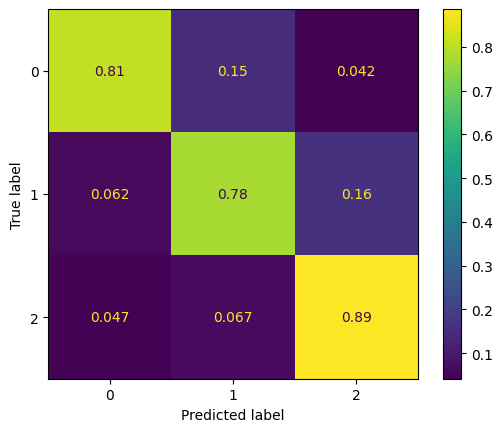

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.41820. Saving Model!
epoch 01, loss: 0.52012, acc: 0.78623, val_loss: 0.41820, val_accuracy: 0.83507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 02, loss: 0.50945, acc: 0.78909, val_loss: 0.43064, val_accuracy: 0.83153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 03, loss: 0.51768, acc: 0.78287, val_loss: 0.43106, val_accuracy: 0.83350


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 04, loss: 0.51040, acc: 0.78538, val_loss: 0.43377, val_accuracy: 0.83448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 05, loss: 0.50595, acc: 0.78841, val_loss: 0.43732, val_accuracy: 0.83094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 06, loss: 0.51006, acc: 0.78667, val_loss: 0.43604, val_accuracy: 0.82996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 07, loss: 0.50605, acc: 0.78843, val_loss: 0.43877, val_accuracy: 0.82918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 08, loss: 0.50488, acc: 0.78852, val_loss: 0.44106, val_accuracy: 0.82957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 09, loss: 0.50548, acc: 0.78909, val_loss: 0.44162, val_accuracy: 0.82839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 10, loss: 0.50352, acc: 0.79114, val_loss: 0.44361, val_accuracy: 0.83173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 11, loss: 0.50331, acc: 0.79118, val_loss: 0.44449, val_accuracy: 0.83193


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 12, loss: 0.50278, acc: 0.79129, val_loss: 0.44538, val_accuracy: 0.82878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 13, loss: 0.50197, acc: 0.79177, val_loss: 0.44633, val_accuracy: 0.82918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 14, loss: 0.50155, acc: 0.79223, val_loss: 0.44743, val_accuracy: 0.82898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 15, loss: 0.50089, acc: 0.79245, val_loss: 0.44858, val_accuracy: 0.82859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 16, loss: 0.50046, acc: 0.79345, val_loss: 0.44914, val_accuracy: 0.82859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 17, loss: 0.50013, acc: 0.79389, val_loss: 0.45001, val_accuracy: 0.82800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 18, loss: 0.49960, acc: 0.79352, val_loss: 0.45090, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 19, loss: 0.49938, acc: 0.79422, val_loss: 0.45124, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 20, loss: 0.49888, acc: 0.79448, val_loss: 0.45245, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 21, loss: 0.49841, acc: 0.79470, val_loss: 0.45327, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 22, loss: 0.49810, acc: 0.79439, val_loss: 0.45361, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 23, loss: 0.49778, acc: 0.79472, val_loss: 0.45429, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 24, loss: 0.49734, acc: 0.79583, val_loss: 0.45545, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 25, loss: 0.49707, acc: 0.79592, val_loss: 0.45589, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 26, loss: 0.49697, acc: 0.79583, val_loss: 0.45626, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 27, loss: 0.49609, acc: 0.79616, val_loss: 0.45678, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 28, loss: 0.49612, acc: 0.79605, val_loss: 0.45753, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 29, loss: 0.49574, acc: 0.79618, val_loss: 0.45822, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 30, loss: 0.49538, acc: 0.79644, val_loss: 0.45885, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 31, loss: 0.49528, acc: 0.79640, val_loss: 0.45959, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 32, loss: 0.49467, acc: 0.79679, val_loss: 0.46017, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 33, loss: 0.49480, acc: 0.79666, val_loss: 0.46066, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 34, loss: 0.49435, acc: 0.79703, val_loss: 0.46114, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 35, loss: 0.49426, acc: 0.79681, val_loss: 0.46126, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 36, loss: 0.49358, acc: 0.79723, val_loss: 0.46251, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 37, loss: 0.49367, acc: 0.79701, val_loss: 0.46239, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 38, loss: 0.49326, acc: 0.79716, val_loss: 0.46318, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 39, loss: 0.49285, acc: 0.79727, val_loss: 0.46375, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 40, loss: 0.49283, acc: 0.79725, val_loss: 0.46396, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 41, loss: 0.49247, acc: 0.79733, val_loss: 0.46461, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 42, loss: 0.49206, acc: 0.79723, val_loss: 0.46483, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 43, loss: 0.49166, acc: 0.79755, val_loss: 0.46557, val_accuracy: 0.81897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 44, loss: 0.49195, acc: 0.79788, val_loss: 0.46600, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 45, loss: 0.49098, acc: 0.79766, val_loss: 0.46675, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 46, loss: 0.49122, acc: 0.79797, val_loss: 0.46673, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 47, loss: 0.49081, acc: 0.79810, val_loss: 0.46738, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 48, loss: 0.49058, acc: 0.79797, val_loss: 0.46799, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 49, loss: 0.49041, acc: 0.79832, val_loss: 0.46838, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 50, loss: 0.48998, acc: 0.79840, val_loss: 0.46884, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 51, loss: 0.49007, acc: 0.79803, val_loss: 0.46894, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 52, loss: 0.48962, acc: 0.79930, val_loss: 0.46946, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 53, loss: 0.48938, acc: 0.79862, val_loss: 0.46970, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 54, loss: 0.48908, acc: 0.79956, val_loss: 0.46996, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 55, loss: 0.48933, acc: 0.79847, val_loss: 0.47045, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 56, loss: 0.48829, acc: 0.80004, val_loss: 0.47101, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 57, loss: 0.48880, acc: 0.79952, val_loss: 0.47095, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 58, loss: 0.48826, acc: 0.79943, val_loss: 0.47128, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 59, loss: 0.48791, acc: 0.80021, val_loss: 0.47146, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 60, loss: 0.48816, acc: 0.80010, val_loss: 0.47193, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 61, loss: 0.48750, acc: 0.80050, val_loss: 0.47229, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 62, loss: 0.48723, acc: 0.79969, val_loss: 0.47226, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 63, loss: 0.48738, acc: 0.80054, val_loss: 0.47277, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 64, loss: 0.48710, acc: 0.80048, val_loss: 0.47302, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 65, loss: 0.48652, acc: 0.80126, val_loss: 0.47352, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 66, loss: 0.48661, acc: 0.80109, val_loss: 0.47350, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 67, loss: 0.48648, acc: 0.80072, val_loss: 0.47377, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 68, loss: 0.48562, acc: 0.80185, val_loss: 0.47437, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 69, loss: 0.48661, acc: 0.80135, val_loss: 0.47407, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 70, loss: 0.48526, acc: 0.80178, val_loss: 0.47497, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 71, loss: 0.48575, acc: 0.80170, val_loss: 0.47440, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 72, loss: 0.48517, acc: 0.80157, val_loss: 0.47537, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.77it/s]


epoch 73, loss: 0.48511, acc: 0.80187, val_loss: 0.47546, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 74, loss: 0.48510, acc: 0.80176, val_loss: 0.47540, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 75, loss: 0.48447, acc: 0.80218, val_loss: 0.47622, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 76, loss: 0.48468, acc: 0.80137, val_loss: 0.47621, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 77, loss: 0.48414, acc: 0.80218, val_loss: 0.47659, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 78, loss: 0.48418, acc: 0.80233, val_loss: 0.47670, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 79, loss: 0.48392, acc: 0.80327, val_loss: 0.47693, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 80, loss: 0.48359, acc: 0.80274, val_loss: 0.47724, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 81, loss: 0.48360, acc: 0.80248, val_loss: 0.47753, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 82, loss: 0.48307, acc: 0.80270, val_loss: 0.47751, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 83, loss: 0.48327, acc: 0.80388, val_loss: 0.47807, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 84, loss: 0.48277, acc: 0.80436, val_loss: 0.47841, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 85, loss: 0.48274, acc: 0.80303, val_loss: 0.47830, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 86, loss: 0.48247, acc: 0.80344, val_loss: 0.47850, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 87, loss: 0.48218, acc: 0.80316, val_loss: 0.47899, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 88, loss: 0.48210, acc: 0.80501, val_loss: 0.47904, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 89, loss: 0.48212, acc: 0.80427, val_loss: 0.47944, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 90, loss: 0.48149, acc: 0.80460, val_loss: 0.48003, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 91, loss: 0.48160, acc: 0.80455, val_loss: 0.47975, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 92, loss: 0.48143, acc: 0.80486, val_loss: 0.48018, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 93, loss: 0.48102, acc: 0.80462, val_loss: 0.48059, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 94, loss: 0.48064, acc: 0.80514, val_loss: 0.48033, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 95, loss: 0.48130, acc: 0.80464, val_loss: 0.48093, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 96, loss: 0.48014, acc: 0.80501, val_loss: 0.48173, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 97, loss: 0.48061, acc: 0.80479, val_loss: 0.48114, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 98, loss: 0.48001, acc: 0.80545, val_loss: 0.48188, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 99, loss: 0.48015, acc: 0.80521, val_loss: 0.48150, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 100, loss: 0.47953, acc: 0.80580, val_loss: 0.48231, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 101, loss: 0.47991, acc: 0.80525, val_loss: 0.48230, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 102, loss: 0.47929, acc: 0.80551, val_loss: 0.48235, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 103, loss: 0.47919, acc: 0.80578, val_loss: 0.48285, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 104, loss: 0.47894, acc: 0.80606, val_loss: 0.48315, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 105, loss: 0.47930, acc: 0.80538, val_loss: 0.48274, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 106, loss: 0.47807, acc: 0.80647, val_loss: 0.48390, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 107, loss: 0.47929, acc: 0.80536, val_loss: 0.48310, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 108, loss: 0.47716, acc: 0.80632, val_loss: 0.48441, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 109, loss: 0.47884, acc: 0.80575, val_loss: 0.48406, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 110, loss: 0.47771, acc: 0.80623, val_loss: 0.48391, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 111, loss: 0.47783, acc: 0.80621, val_loss: 0.48452, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 112, loss: 0.47722, acc: 0.80615, val_loss: 0.48476, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 113, loss: 0.47781, acc: 0.80591, val_loss: 0.48487, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 114, loss: 0.47691, acc: 0.80674, val_loss: 0.48533, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 115, loss: 0.47733, acc: 0.80634, val_loss: 0.48519, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 116, loss: 0.47650, acc: 0.80671, val_loss: 0.48567, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 117, loss: 0.47676, acc: 0.80626, val_loss: 0.48580, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 118, loss: 0.47655, acc: 0.80667, val_loss: 0.48586, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 119, loss: 0.47619, acc: 0.80667, val_loss: 0.48627, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 120, loss: 0.47626, acc: 0.80665, val_loss: 0.48635, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 121, loss: 0.47583, acc: 0.80645, val_loss: 0.48670, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 122, loss: 0.47557, acc: 0.80663, val_loss: 0.48654, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 123, loss: 0.47574, acc: 0.80687, val_loss: 0.48698, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 124, loss: 0.47518, acc: 0.80678, val_loss: 0.48729, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 125, loss: 0.47515, acc: 0.80711, val_loss: 0.48759, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 126, loss: 0.47509, acc: 0.80722, val_loss: 0.48783, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 127, loss: 0.47499, acc: 0.80737, val_loss: 0.48820, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 128, loss: 0.47471, acc: 0.80726, val_loss: 0.48841, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 129, loss: 0.47424, acc: 0.80728, val_loss: 0.48845, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 130, loss: 0.47454, acc: 0.80759, val_loss: 0.48794, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 131, loss: 0.47413, acc: 0.80750, val_loss: 0.48835, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 132, loss: 0.47362, acc: 0.80763, val_loss: 0.48895, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 133, loss: 0.47402, acc: 0.80735, val_loss: 0.48871, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 134, loss: 0.47322, acc: 0.80759, val_loss: 0.48956, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 135, loss: 0.47353, acc: 0.80756, val_loss: 0.48929, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 136, loss: 0.47307, acc: 0.80794, val_loss: 0.48930, val_accuracy: 0.81170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 137, loss: 0.47299, acc: 0.80791, val_loss: 0.48972, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 138, loss: 0.47289, acc: 0.80813, val_loss: 0.48959, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 139, loss: 0.47258, acc: 0.80794, val_loss: 0.49053, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 140, loss: 0.47243, acc: 0.80815, val_loss: 0.49032, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 141, loss: 0.47253, acc: 0.80776, val_loss: 0.49005, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 142, loss: 0.47162, acc: 0.80852, val_loss: 0.49099, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 143, loss: 0.47259, acc: 0.80798, val_loss: 0.49050, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 144, loss: 0.47087, acc: 0.80866, val_loss: 0.49141, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 145, loss: 0.47221, acc: 0.80824, val_loss: 0.49125, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 146, loss: 0.47094, acc: 0.80879, val_loss: 0.49173, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 147, loss: 0.47154, acc: 0.80813, val_loss: 0.49150, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 148, loss: 0.47065, acc: 0.80885, val_loss: 0.49212, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 149, loss: 0.47094, acc: 0.80872, val_loss: 0.49221, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.04it/s]


epoch 150, loss: 0.47060, acc: 0.80905, val_loss: 0.49218, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 151, loss: 0.47047, acc: 0.80857, val_loss: 0.49268, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 152, loss: 0.47020, acc: 0.80918, val_loss: 0.49261, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 153, loss: 0.46991, acc: 0.80911, val_loss: 0.49326, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 154, loss: 0.47028, acc: 0.80881, val_loss: 0.49265, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 155, loss: 0.46942, acc: 0.80890, val_loss: 0.49331, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 156, loss: 0.46955, acc: 0.80938, val_loss: 0.49293, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 157, loss: 0.46943, acc: 0.80979, val_loss: 0.49344, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 158, loss: 0.46922, acc: 0.80977, val_loss: 0.49355, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 159, loss: 0.46883, acc: 0.80966, val_loss: 0.49388, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 160, loss: 0.46919, acc: 0.80994, val_loss: 0.49312, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 161, loss: 0.46820, acc: 0.81001, val_loss: 0.49451, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 162, loss: 0.46874, acc: 0.80983, val_loss: 0.49351, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 163, loss: 0.46828, acc: 0.81014, val_loss: 0.49422, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 164, loss: 0.46775, acc: 0.81057, val_loss: 0.49437, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 165, loss: 0.46817, acc: 0.81034, val_loss: 0.49444, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 166, loss: 0.46781, acc: 0.81049, val_loss: 0.49421, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 167, loss: 0.46775, acc: 0.81018, val_loss: 0.49423, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 168, loss: 0.46691, acc: 0.81066, val_loss: 0.49485, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 169, loss: 0.46785, acc: 0.81016, val_loss: 0.49407, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 170, loss: 0.46666, acc: 0.81071, val_loss: 0.49542, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 171, loss: 0.46708, acc: 0.81055, val_loss: 0.49526, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 172, loss: 0.46629, acc: 0.81121, val_loss: 0.49587, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 173, loss: 0.46697, acc: 0.81086, val_loss: 0.49500, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 174, loss: 0.46584, acc: 0.81125, val_loss: 0.49596, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 175, loss: 0.46673, acc: 0.81156, val_loss: 0.49494, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 176, loss: 0.46535, acc: 0.81136, val_loss: 0.49617, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 177, loss: 0.46665, acc: 0.81060, val_loss: 0.49536, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


epoch 178, loss: 0.46485, acc: 0.81160, val_loss: 0.49653, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 179, loss: 0.46606, acc: 0.81068, val_loss: 0.49576, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 180, loss: 0.46493, acc: 0.81173, val_loss: 0.49599, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 181, loss: 0.46535, acc: 0.81121, val_loss: 0.49628, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 182, loss: 0.46509, acc: 0.81156, val_loss: 0.49632, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 183, loss: 0.46447, acc: 0.81129, val_loss: 0.49743, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 184, loss: 0.46519, acc: 0.81149, val_loss: 0.49641, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 185, loss: 0.46399, acc: 0.81167, val_loss: 0.49773, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 186, loss: 0.46443, acc: 0.81184, val_loss: 0.49656, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 187, loss: 0.46427, acc: 0.81138, val_loss: 0.49698, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 188, loss: 0.46393, acc: 0.81171, val_loss: 0.49711, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 189, loss: 0.46371, acc: 0.81160, val_loss: 0.49767, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 190, loss: 0.46376, acc: 0.81219, val_loss: 0.49735, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 191, loss: 0.46344, acc: 0.81195, val_loss: 0.49788, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 192, loss: 0.46346, acc: 0.81241, val_loss: 0.49818, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 193, loss: 0.46304, acc: 0.81193, val_loss: 0.49819, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 194, loss: 0.46302, acc: 0.81217, val_loss: 0.49806, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 195, loss: 0.46301, acc: 0.81208, val_loss: 0.49849, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 196, loss: 0.46254, acc: 0.81197, val_loss: 0.49815, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 197, loss: 0.46231, acc: 0.81241, val_loss: 0.49842, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 198, loss: 0.46258, acc: 0.81256, val_loss: 0.49821, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 199, loss: 0.46182, acc: 0.81304, val_loss: 0.49904, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 200, loss: 0.46220, acc: 0.81324, val_loss: 0.49890, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 201, loss: 0.46172, acc: 0.81249, val_loss: 0.49899, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 202, loss: 0.46156, acc: 0.81306, val_loss: 0.49917, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 203, loss: 0.46150, acc: 0.81291, val_loss: 0.49983, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 204, loss: 0.46150, acc: 0.81252, val_loss: 0.49912, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 205, loss: 0.46090, acc: 0.81374, val_loss: 0.49969, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 206, loss: 0.46149, acc: 0.81254, val_loss: 0.49943, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 207, loss: 0.46056, acc: 0.81297, val_loss: 0.50054, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 208, loss: 0.46079, acc: 0.81328, val_loss: 0.49984, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 209, loss: 0.46047, acc: 0.81332, val_loss: 0.50029, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 210, loss: 0.46064, acc: 0.81328, val_loss: 0.50049, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 211, loss: 0.45983, acc: 0.81441, val_loss: 0.50079, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 212, loss: 0.46043, acc: 0.81324, val_loss: 0.50015, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 213, loss: 0.45963, acc: 0.81415, val_loss: 0.50144, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 214, loss: 0.45982, acc: 0.81337, val_loss: 0.50042, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 215, loss: 0.45941, acc: 0.81352, val_loss: 0.50239, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 216, loss: 0.45942, acc: 0.81402, val_loss: 0.50103, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 217, loss: 0.45883, acc: 0.81478, val_loss: 0.50201, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 218, loss: 0.45941, acc: 0.81387, val_loss: 0.50136, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 219, loss: 0.45864, acc: 0.81485, val_loss: 0.50209, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 220, loss: 0.45846, acc: 0.81511, val_loss: 0.50199, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 221, loss: 0.45909, acc: 0.81409, val_loss: 0.50227, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 222, loss: 0.45771, acc: 0.81564, val_loss: 0.50329, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 223, loss: 0.45854, acc: 0.81422, val_loss: 0.50180, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 224, loss: 0.45769, acc: 0.81483, val_loss: 0.50336, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 225, loss: 0.45847, acc: 0.81494, val_loss: 0.50256, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 226, loss: 0.45708, acc: 0.81568, val_loss: 0.50356, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 227, loss: 0.45815, acc: 0.81457, val_loss: 0.50285, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 228, loss: 0.45687, acc: 0.81590, val_loss: 0.50419, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 229, loss: 0.45766, acc: 0.81457, val_loss: 0.50264, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 230, loss: 0.45680, acc: 0.81708, val_loss: 0.50383, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 231, loss: 0.45703, acc: 0.81496, val_loss: 0.50332, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 232, loss: 0.45659, acc: 0.81677, val_loss: 0.50426, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 233, loss: 0.45691, acc: 0.81570, val_loss: 0.50360, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 234, loss: 0.45603, acc: 0.81673, val_loss: 0.50475, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 235, loss: 0.45689, acc: 0.81601, val_loss: 0.50345, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 236, loss: 0.45534, acc: 0.81760, val_loss: 0.50495, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 237, loss: 0.45639, acc: 0.81684, val_loss: 0.50412, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 238, loss: 0.45577, acc: 0.81692, val_loss: 0.50490, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 239, loss: 0.45561, acc: 0.81721, val_loss: 0.50476, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 240, loss: 0.45523, acc: 0.81653, val_loss: 0.50494, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 241, loss: 0.45607, acc: 0.81679, val_loss: 0.50433, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 242, loss: 0.45452, acc: 0.81762, val_loss: 0.50608, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 243, loss: 0.45562, acc: 0.81629, val_loss: 0.50428, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 244, loss: 0.45426, acc: 0.81766, val_loss: 0.50598, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 245, loss: 0.45497, acc: 0.81673, val_loss: 0.50496, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 246, loss: 0.45447, acc: 0.81708, val_loss: 0.50588, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 247, loss: 0.45484, acc: 0.81710, val_loss: 0.50510, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 248, loss: 0.45376, acc: 0.81766, val_loss: 0.50629, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 249, loss: 0.45445, acc: 0.81705, val_loss: 0.50466, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 250, loss: 0.45373, acc: 0.81751, val_loss: 0.50604, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 251, loss: 0.45366, acc: 0.81769, val_loss: 0.50627, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 252, loss: 0.45376, acc: 0.81758, val_loss: 0.50592, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 253, loss: 0.45310, acc: 0.81806, val_loss: 0.50624, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 254, loss: 0.45332, acc: 0.81793, val_loss: 0.50703, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 255, loss: 0.45330, acc: 0.81716, val_loss: 0.50642, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 256, loss: 0.45287, acc: 0.81769, val_loss: 0.50671, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 257, loss: 0.45292, acc: 0.81806, val_loss: 0.50657, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 258, loss: 0.45237, acc: 0.81727, val_loss: 0.50697, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 259, loss: 0.45276, acc: 0.81782, val_loss: 0.50689, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 260, loss: 0.45193, acc: 0.81812, val_loss: 0.50738, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 261, loss: 0.45247, acc: 0.81745, val_loss: 0.50665, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 262, loss: 0.45200, acc: 0.81782, val_loss: 0.50770, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 263, loss: 0.45161, acc: 0.81851, val_loss: 0.50742, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 264, loss: 0.45213, acc: 0.81838, val_loss: 0.50684, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 265, loss: 0.45123, acc: 0.81875, val_loss: 0.50791, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 266, loss: 0.45148, acc: 0.81777, val_loss: 0.50726, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 267, loss: 0.45126, acc: 0.81799, val_loss: 0.50847, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 268, loss: 0.45093, acc: 0.81917, val_loss: 0.50768, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 269, loss: 0.45112, acc: 0.81817, val_loss: 0.50802, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 270, loss: 0.45081, acc: 0.81823, val_loss: 0.50779, val_accuracy: 0.81897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 271, loss: 0.45029, acc: 0.81906, val_loss: 0.50860, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 272, loss: 0.45081, acc: 0.81886, val_loss: 0.50747, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 273, loss: 0.44991, acc: 0.81928, val_loss: 0.50852, val_accuracy: 0.81897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 274, loss: 0.45028, acc: 0.81939, val_loss: 0.50811, val_accuracy: 0.81897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 275, loss: 0.45009, acc: 0.81941, val_loss: 0.50839, val_accuracy: 0.81956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 276, loss: 0.44968, acc: 0.81976, val_loss: 0.50901, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 277, loss: 0.44997, acc: 0.81939, val_loss: 0.50832, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 278, loss: 0.44948, acc: 0.81974, val_loss: 0.50952, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 279, loss: 0.44937, acc: 0.81993, val_loss: 0.50889, val_accuracy: 0.81936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 280, loss: 0.44961, acc: 0.81939, val_loss: 0.50878, val_accuracy: 0.81916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 281, loss: 0.44886, acc: 0.81982, val_loss: 0.50956, val_accuracy: 0.81936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 282, loss: 0.44906, acc: 0.81980, val_loss: 0.50986, val_accuracy: 0.81916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 283, loss: 0.44878, acc: 0.82013, val_loss: 0.50912, val_accuracy: 0.81975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 284, loss: 0.44881, acc: 0.81982, val_loss: 0.50949, val_accuracy: 0.81916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 285, loss: 0.44805, acc: 0.82024, val_loss: 0.51065, val_accuracy: 0.81936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 286, loss: 0.44879, acc: 0.81998, val_loss: 0.50936, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 287, loss: 0.44782, acc: 0.82000, val_loss: 0.51070, val_accuracy: 0.81995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 288, loss: 0.44821, acc: 0.82046, val_loss: 0.51022, val_accuracy: 0.81897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 289, loss: 0.44774, acc: 0.82061, val_loss: 0.51069, val_accuracy: 0.81936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 290, loss: 0.44825, acc: 0.82102, val_loss: 0.51008, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 291, loss: 0.44697, acc: 0.82098, val_loss: 0.51179, val_accuracy: 0.81995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 292, loss: 0.44811, acc: 0.82061, val_loss: 0.51022, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 293, loss: 0.44700, acc: 0.82057, val_loss: 0.51167, val_accuracy: 0.81956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 294, loss: 0.44693, acc: 0.82061, val_loss: 0.51062, val_accuracy: 0.81916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 295, loss: 0.44763, acc: 0.81952, val_loss: 0.51069, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 296, loss: 0.44608, acc: 0.82139, val_loss: 0.51154, val_accuracy: 0.81936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 297, loss: 0.44704, acc: 0.82089, val_loss: 0.51122, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 298, loss: 0.44652, acc: 0.82070, val_loss: 0.51126, val_accuracy: 0.81975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 299, loss: 0.44598, acc: 0.82115, val_loss: 0.51172, val_accuracy: 0.81975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 300, loss: 0.44663, acc: 0.82129, val_loss: 0.51144, val_accuracy: 0.81995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 301, loss: 0.44556, acc: 0.82209, val_loss: 0.51263, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 302, loss: 0.44648, acc: 0.82111, val_loss: 0.51117, val_accuracy: 0.81936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 303, loss: 0.44545, acc: 0.82244, val_loss: 0.51288, val_accuracy: 0.82034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 304, loss: 0.44589, acc: 0.82185, val_loss: 0.51181, val_accuracy: 0.81975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 305, loss: 0.44533, acc: 0.82255, val_loss: 0.51331, val_accuracy: 0.81995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 306, loss: 0.44591, acc: 0.82253, val_loss: 0.51238, val_accuracy: 0.81877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 307, loss: 0.44506, acc: 0.82299, val_loss: 0.51380, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 308, loss: 0.44498, acc: 0.82371, val_loss: 0.51254, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 309, loss: 0.44507, acc: 0.82329, val_loss: 0.51310, val_accuracy: 0.81975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 310, loss: 0.44478, acc: 0.82294, val_loss: 0.51290, val_accuracy: 0.81956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 311, loss: 0.44433, acc: 0.82351, val_loss: 0.51354, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 312, loss: 0.44444, acc: 0.82301, val_loss: 0.51310, val_accuracy: 0.82034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 313, loss: 0.44372, acc: 0.82318, val_loss: 0.51390, val_accuracy: 0.82034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 314, loss: 0.44505, acc: 0.82312, val_loss: 0.51324, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 315, loss: 0.44331, acc: 0.82347, val_loss: 0.51509, val_accuracy: 0.82113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 316, loss: 0.44430, acc: 0.82414, val_loss: 0.51289, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 317, loss: 0.44339, acc: 0.82427, val_loss: 0.51424, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 318, loss: 0.44363, acc: 0.82388, val_loss: 0.51383, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 319, loss: 0.44340, acc: 0.82377, val_loss: 0.51405, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 320, loss: 0.44330, acc: 0.82427, val_loss: 0.51426, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 321, loss: 0.44286, acc: 0.82436, val_loss: 0.51447, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 322, loss: 0.44324, acc: 0.82406, val_loss: 0.51453, val_accuracy: 0.82034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 323, loss: 0.44259, acc: 0.82303, val_loss: 0.51535, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 324, loss: 0.44296, acc: 0.82460, val_loss: 0.51343, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 325, loss: 0.44179, acc: 0.82488, val_loss: 0.51546, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 326, loss: 0.44333, acc: 0.82344, val_loss: 0.51405, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 327, loss: 0.44095, acc: 0.82478, val_loss: 0.51616, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 328, loss: 0.44313, acc: 0.82338, val_loss: 0.51419, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 329, loss: 0.44106, acc: 0.82508, val_loss: 0.51612, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 330, loss: 0.44254, acc: 0.82464, val_loss: 0.51489, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 331, loss: 0.44080, acc: 0.82550, val_loss: 0.51699, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 332, loss: 0.44252, acc: 0.82506, val_loss: 0.51380, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 333, loss: 0.44028, acc: 0.82482, val_loss: 0.51621, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 334, loss: 0.44204, acc: 0.82382, val_loss: 0.51537, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 335, loss: 0.44018, acc: 0.82571, val_loss: 0.51693, val_accuracy: 0.82113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 336, loss: 0.44181, acc: 0.82416, val_loss: 0.51496, val_accuracy: 0.82034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 337, loss: 0.43986, acc: 0.82552, val_loss: 0.51711, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 338, loss: 0.44130, acc: 0.82506, val_loss: 0.51556, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 339, loss: 0.43959, acc: 0.82495, val_loss: 0.51658, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 340, loss: 0.44137, acc: 0.82454, val_loss: 0.51555, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 341, loss: 0.43917, acc: 0.82560, val_loss: 0.51763, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 342, loss: 0.44105, acc: 0.82506, val_loss: 0.51517, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 343, loss: 0.43885, acc: 0.82587, val_loss: 0.51767, val_accuracy: 0.82132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 344, loss: 0.44064, acc: 0.82438, val_loss: 0.51579, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 345, loss: 0.43887, acc: 0.82567, val_loss: 0.51844, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 346, loss: 0.43999, acc: 0.82560, val_loss: 0.51602, val_accuracy: 0.82054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 347, loss: 0.43856, acc: 0.82550, val_loss: 0.51809, val_accuracy: 0.82132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 348, loss: 0.43972, acc: 0.82563, val_loss: 0.51678, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 349, loss: 0.43840, acc: 0.82613, val_loss: 0.51799, val_accuracy: 0.82113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 350, loss: 0.43956, acc: 0.82491, val_loss: 0.51628, val_accuracy: 0.82093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 351, loss: 0.43796, acc: 0.82574, val_loss: 0.51827, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 352, loss: 0.43942, acc: 0.82676, val_loss: 0.51647, val_accuracy: 0.82152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 353, loss: 0.43737, acc: 0.82635, val_loss: 0.51899, val_accuracy: 0.82113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 354, loss: 0.43931, acc: 0.82600, val_loss: 0.51677, val_accuracy: 0.82152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 355, loss: 0.43716, acc: 0.82626, val_loss: 0.51892, val_accuracy: 0.82172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 356, loss: 0.43848, acc: 0.82656, val_loss: 0.51695, val_accuracy: 0.82191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 357, loss: 0.43764, acc: 0.82621, val_loss: 0.51805, val_accuracy: 0.82191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 358, loss: 0.43788, acc: 0.82650, val_loss: 0.51806, val_accuracy: 0.82211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 359, loss: 0.43728, acc: 0.82648, val_loss: 0.51871, val_accuracy: 0.82152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 360, loss: 0.43806, acc: 0.82709, val_loss: 0.51781, val_accuracy: 0.82191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


epoch 361, loss: 0.43661, acc: 0.82621, val_loss: 0.51963, val_accuracy: 0.82132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 362, loss: 0.43802, acc: 0.82717, val_loss: 0.51783, val_accuracy: 0.82191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 363, loss: 0.43600, acc: 0.82641, val_loss: 0.51965, val_accuracy: 0.82172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 364, loss: 0.43776, acc: 0.82744, val_loss: 0.51717, val_accuracy: 0.82211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 365, loss: 0.43591, acc: 0.82661, val_loss: 0.51976, val_accuracy: 0.82211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 366, loss: 0.43699, acc: 0.82674, val_loss: 0.51797, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 367, loss: 0.43576, acc: 0.82707, val_loss: 0.51938, val_accuracy: 0.82211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 368, loss: 0.43697, acc: 0.82755, val_loss: 0.51940, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 369, loss: 0.43578, acc: 0.82676, val_loss: 0.51987, val_accuracy: 0.82172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 370, loss: 0.43641, acc: 0.82794, val_loss: 0.51814, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 371, loss: 0.43541, acc: 0.82798, val_loss: 0.51989, val_accuracy: 0.82231


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 372, loss: 0.43607, acc: 0.82833, val_loss: 0.51889, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 373, loss: 0.43515, acc: 0.82746, val_loss: 0.51957, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 374, loss: 0.43599, acc: 0.82807, val_loss: 0.51969, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 375, loss: 0.43472, acc: 0.82833, val_loss: 0.51987, val_accuracy: 0.82211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 376, loss: 0.43577, acc: 0.82781, val_loss: 0.52008, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 377, loss: 0.43420, acc: 0.82855, val_loss: 0.52017, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 378, loss: 0.43581, acc: 0.82787, val_loss: 0.51942, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 379, loss: 0.43376, acc: 0.82794, val_loss: 0.52165, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 380, loss: 0.43540, acc: 0.82835, val_loss: 0.51959, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 381, loss: 0.43381, acc: 0.82883, val_loss: 0.52067, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 382, loss: 0.43474, acc: 0.82857, val_loss: 0.51979, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 383, loss: 0.43366, acc: 0.82875, val_loss: 0.52191, val_accuracy: 0.82191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 384, loss: 0.43456, acc: 0.82870, val_loss: 0.51996, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 385, loss: 0.43303, acc: 0.82807, val_loss: 0.52232, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 386, loss: 0.43466, acc: 0.82883, val_loss: 0.52003, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 387, loss: 0.43302, acc: 0.82923, val_loss: 0.52202, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 388, loss: 0.43391, acc: 0.82885, val_loss: 0.52117, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 389, loss: 0.43298, acc: 0.82881, val_loss: 0.52218, val_accuracy: 0.82231


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 390, loss: 0.43312, acc: 0.82995, val_loss: 0.52065, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 391, loss: 0.43312, acc: 0.82818, val_loss: 0.52163, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 392, loss: 0.43308, acc: 0.82920, val_loss: 0.52136, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 393, loss: 0.43229, acc: 0.82929, val_loss: 0.52218, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 394, loss: 0.43326, acc: 0.82923, val_loss: 0.52157, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 395, loss: 0.43172, acc: 0.82949, val_loss: 0.52278, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 396, loss: 0.43253, acc: 0.82920, val_loss: 0.52068, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 397, loss: 0.43214, acc: 0.82923, val_loss: 0.52271, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 398, loss: 0.43174, acc: 0.82981, val_loss: 0.52248, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 399, loss: 0.43248, acc: 0.82936, val_loss: 0.52195, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 400, loss: 0.43137, acc: 0.83075, val_loss: 0.52297, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 401, loss: 0.43193, acc: 0.82968, val_loss: 0.52250, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


epoch 402, loss: 0.43164, acc: 0.83058, val_loss: 0.52216, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 403, loss: 0.43120, acc: 0.83040, val_loss: 0.52364, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 404, loss: 0.43186, acc: 0.83069, val_loss: 0.52242, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 405, loss: 0.43033, acc: 0.83060, val_loss: 0.52427, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 406, loss: 0.43177, acc: 0.83084, val_loss: 0.52196, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 407, loss: 0.43006, acc: 0.83060, val_loss: 0.52407, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 408, loss: 0.43171, acc: 0.83029, val_loss: 0.52266, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 409, loss: 0.42953, acc: 0.83125, val_loss: 0.52599, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 410, loss: 0.43184, acc: 0.83051, val_loss: 0.52244, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 411, loss: 0.42898, acc: 0.83125, val_loss: 0.52413, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 412, loss: 0.43119, acc: 0.83066, val_loss: 0.52300, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 413, loss: 0.42943, acc: 0.83125, val_loss: 0.52558, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 414, loss: 0.43077, acc: 0.83047, val_loss: 0.52285, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 415, loss: 0.42898, acc: 0.83138, val_loss: 0.52472, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 416, loss: 0.43055, acc: 0.83071, val_loss: 0.52373, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 417, loss: 0.42893, acc: 0.83145, val_loss: 0.52505, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 418, loss: 0.43022, acc: 0.83075, val_loss: 0.52422, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 419, loss: 0.42853, acc: 0.83213, val_loss: 0.52517, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 420, loss: 0.42976, acc: 0.83101, val_loss: 0.52476, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 421, loss: 0.42859, acc: 0.83173, val_loss: 0.52378, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 422, loss: 0.42888, acc: 0.83112, val_loss: 0.52497, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 423, loss: 0.42869, acc: 0.83184, val_loss: 0.52474, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 424, loss: 0.42835, acc: 0.83121, val_loss: 0.52658, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 425, loss: 0.42853, acc: 0.83195, val_loss: 0.52524, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 426, loss: 0.42805, acc: 0.83149, val_loss: 0.52662, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 427, loss: 0.42789, acc: 0.83193, val_loss: 0.52479, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 428, loss: 0.42822, acc: 0.83134, val_loss: 0.52503, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 429, loss: 0.42771, acc: 0.83200, val_loss: 0.52541, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 430, loss: 0.42797, acc: 0.83145, val_loss: 0.52607, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 431, loss: 0.42726, acc: 0.83215, val_loss: 0.52523, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 432, loss: 0.42785, acc: 0.83178, val_loss: 0.52713, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 433, loss: 0.42753, acc: 0.83202, val_loss: 0.52590, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 434, loss: 0.42690, acc: 0.83186, val_loss: 0.52610, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 435, loss: 0.42721, acc: 0.83226, val_loss: 0.52577, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 436, loss: 0.42671, acc: 0.83171, val_loss: 0.52716, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


epoch 437, loss: 0.42662, acc: 0.83254, val_loss: 0.52556, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 438, loss: 0.42667, acc: 0.83210, val_loss: 0.52728, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 439, loss: 0.42659, acc: 0.83248, val_loss: 0.52592, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 440, loss: 0.42615, acc: 0.83213, val_loss: 0.52746, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 441, loss: 0.42604, acc: 0.83274, val_loss: 0.52621, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 442, loss: 0.42610, acc: 0.83226, val_loss: 0.52747, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 443, loss: 0.42594, acc: 0.83280, val_loss: 0.52644, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 444, loss: 0.42588, acc: 0.83226, val_loss: 0.52814, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 445, loss: 0.42597, acc: 0.83317, val_loss: 0.52565, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 446, loss: 0.42520, acc: 0.83245, val_loss: 0.52776, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 447, loss: 0.42581, acc: 0.83193, val_loss: 0.52615, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 448, loss: 0.42524, acc: 0.83252, val_loss: 0.52866, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 449, loss: 0.42546, acc: 0.83287, val_loss: 0.52655, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 450, loss: 0.42513, acc: 0.83230, val_loss: 0.52833, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 451, loss: 0.42461, acc: 0.83248, val_loss: 0.52654, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 452, loss: 0.42510, acc: 0.83265, val_loss: 0.52827, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 453, loss: 0.42453, acc: 0.83221, val_loss: 0.52684, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 454, loss: 0.42439, acc: 0.83304, val_loss: 0.52845, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 455, loss: 0.42437, acc: 0.83250, val_loss: 0.52761, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 456, loss: 0.42397, acc: 0.83322, val_loss: 0.52762, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 457, loss: 0.42374, acc: 0.83361, val_loss: 0.52845, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 458, loss: 0.42433, acc: 0.83326, val_loss: 0.52777, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 459, loss: 0.42339, acc: 0.83378, val_loss: 0.52762, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 460, loss: 0.42350, acc: 0.83376, val_loss: 0.52821, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 461, loss: 0.42388, acc: 0.83348, val_loss: 0.52753, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 462, loss: 0.42367, acc: 0.83291, val_loss: 0.52891, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 463, loss: 0.42296, acc: 0.83455, val_loss: 0.52703, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 464, loss: 0.42345, acc: 0.83368, val_loss: 0.52884, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 465, loss: 0.42311, acc: 0.83258, val_loss: 0.52823, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 466, loss: 0.42272, acc: 0.83348, val_loss: 0.52860, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 467, loss: 0.42255, acc: 0.83300, val_loss: 0.52763, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 468, loss: 0.42252, acc: 0.83365, val_loss: 0.52859, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 469, loss: 0.42280, acc: 0.83400, val_loss: 0.52740, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 470, loss: 0.42210, acc: 0.83372, val_loss: 0.52910, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 471, loss: 0.42205, acc: 0.83309, val_loss: 0.52803, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 472, loss: 0.42227, acc: 0.83389, val_loss: 0.52849, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 473, loss: 0.42178, acc: 0.83402, val_loss: 0.52841, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 474, loss: 0.42155, acc: 0.83387, val_loss: 0.52850, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 475, loss: 0.42170, acc: 0.83418, val_loss: 0.52902, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 476, loss: 0.42190, acc: 0.83374, val_loss: 0.52883, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 477, loss: 0.42070, acc: 0.83437, val_loss: 0.52989, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 478, loss: 0.42177, acc: 0.83444, val_loss: 0.52843, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 479, loss: 0.42059, acc: 0.83429, val_loss: 0.52996, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 480, loss: 0.42133, acc: 0.83361, val_loss: 0.52857, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 481, loss: 0.42071, acc: 0.83420, val_loss: 0.53002, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 482, loss: 0.42123, acc: 0.83372, val_loss: 0.52829, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 483, loss: 0.42034, acc: 0.83413, val_loss: 0.52971, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 484, loss: 0.42062, acc: 0.83573, val_loss: 0.52818, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 485, loss: 0.42023, acc: 0.83466, val_loss: 0.53090, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 486, loss: 0.42056, acc: 0.83398, val_loss: 0.52792, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 487, loss: 0.41976, acc: 0.83472, val_loss: 0.53074, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 488, loss: 0.42039, acc: 0.83431, val_loss: 0.52814, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 489, loss: 0.41931, acc: 0.83479, val_loss: 0.53068, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 490, loss: 0.42051, acc: 0.83378, val_loss: 0.52802, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 491, loss: 0.41863, acc: 0.83511, val_loss: 0.53113, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 492, loss: 0.42012, acc: 0.83433, val_loss: 0.52833, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 493, loss: 0.41861, acc: 0.83490, val_loss: 0.53091, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 494, loss: 0.42006, acc: 0.83381, val_loss: 0.52864, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 495, loss: 0.41777, acc: 0.83546, val_loss: 0.53239, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 496, loss: 0.42048, acc: 0.83431, val_loss: 0.52763, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 497, loss: 0.41730, acc: 0.83564, val_loss: 0.53241, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 498, loss: 0.42011, acc: 0.83453, val_loss: 0.52826, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 499, loss: 0.41757, acc: 0.83546, val_loss: 0.53230, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 500, loss: 0.41946, acc: 0.83459, val_loss: 0.52795, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 501, loss: 0.41733, acc: 0.83586, val_loss: 0.53254, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 502, loss: 0.41864, acc: 0.83507, val_loss: 0.52878, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 503, loss: 0.41804, acc: 0.83511, val_loss: 0.53114, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 504, loss: 0.41796, acc: 0.83496, val_loss: 0.53016, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 505, loss: 0.41742, acc: 0.83583, val_loss: 0.53146, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 506, loss: 0.41852, acc: 0.83538, val_loss: 0.52974, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 507, loss: 0.41672, acc: 0.83618, val_loss: 0.53190, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 508, loss: 0.41823, acc: 0.83516, val_loss: 0.52981, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 509, loss: 0.41670, acc: 0.83621, val_loss: 0.53122, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 510, loss: 0.41797, acc: 0.83623, val_loss: 0.52928, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 511, loss: 0.41607, acc: 0.83616, val_loss: 0.53276, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 512, loss: 0.41845, acc: 0.83518, val_loss: 0.53035, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 513, loss: 0.41570, acc: 0.83686, val_loss: 0.53304, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 514, loss: 0.41803, acc: 0.83621, val_loss: 0.52846, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 515, loss: 0.41528, acc: 0.83660, val_loss: 0.53242, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 516, loss: 0.41778, acc: 0.83529, val_loss: 0.52935, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 517, loss: 0.41500, acc: 0.83765, val_loss: 0.53239, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 518, loss: 0.41729, acc: 0.83638, val_loss: 0.52986, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 519, loss: 0.41477, acc: 0.83734, val_loss: 0.53246, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 520, loss: 0.41691, acc: 0.83662, val_loss: 0.53097, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 521, loss: 0.41465, acc: 0.83712, val_loss: 0.53236, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 522, loss: 0.41659, acc: 0.83669, val_loss: 0.53037, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 523, loss: 0.41475, acc: 0.83686, val_loss: 0.53230, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 524, loss: 0.41592, acc: 0.83579, val_loss: 0.53125, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 525, loss: 0.41445, acc: 0.83721, val_loss: 0.53257, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 526, loss: 0.41614, acc: 0.83588, val_loss: 0.53074, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 527, loss: 0.41382, acc: 0.83773, val_loss: 0.53377, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 528, loss: 0.41623, acc: 0.83627, val_loss: 0.53068, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 529, loss: 0.41375, acc: 0.83708, val_loss: 0.53453, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 530, loss: 0.41579, acc: 0.83627, val_loss: 0.53072, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 531, loss: 0.41364, acc: 0.83812, val_loss: 0.53414, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 532, loss: 0.41555, acc: 0.83634, val_loss: 0.53095, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 533, loss: 0.41305, acc: 0.83791, val_loss: 0.53487, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 534, loss: 0.41539, acc: 0.83612, val_loss: 0.53121, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 535, loss: 0.41286, acc: 0.83771, val_loss: 0.53402, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 536, loss: 0.41490, acc: 0.83645, val_loss: 0.53248, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 537, loss: 0.41277, acc: 0.83786, val_loss: 0.53494, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 538, loss: 0.41444, acc: 0.83741, val_loss: 0.53199, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 539, loss: 0.41265, acc: 0.83797, val_loss: 0.53381, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 540, loss: 0.41438, acc: 0.83693, val_loss: 0.53222, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 541, loss: 0.41258, acc: 0.83812, val_loss: 0.53488, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 542, loss: 0.41437, acc: 0.83697, val_loss: 0.53116, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 543, loss: 0.41226, acc: 0.83782, val_loss: 0.53546, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 544, loss: 0.41474, acc: 0.83686, val_loss: 0.53225, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 545, loss: 0.41147, acc: 0.83900, val_loss: 0.53658, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 546, loss: 0.41454, acc: 0.83727, val_loss: 0.53102, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 547, loss: 0.41080, acc: 0.83832, val_loss: 0.53612, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 548, loss: 0.41460, acc: 0.83688, val_loss: 0.53202, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 549, loss: 0.41014, acc: 0.83950, val_loss: 0.53723, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 550, loss: 0.41428, acc: 0.83782, val_loss: 0.53068, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 551, loss: 0.41039, acc: 0.83884, val_loss: 0.53692, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 552, loss: 0.41401, acc: 0.83806, val_loss: 0.53228, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 553, loss: 0.40995, acc: 0.83965, val_loss: 0.53711, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 554, loss: 0.41341, acc: 0.83749, val_loss: 0.53271, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 555, loss: 0.41062, acc: 0.83874, val_loss: 0.53740, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 556, loss: 0.41357, acc: 0.83699, val_loss: 0.53353, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 557, loss: 0.40966, acc: 0.84013, val_loss: 0.53827, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 558, loss: 0.41350, acc: 0.83743, val_loss: 0.53248, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 559, loss: 0.40913, acc: 0.84048, val_loss: 0.53809, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 560, loss: 0.41260, acc: 0.83751, val_loss: 0.53345, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 561, loss: 0.40939, acc: 0.83948, val_loss: 0.53768, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 562, loss: 0.41241, acc: 0.83736, val_loss: 0.53315, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 563, loss: 0.40849, acc: 0.83932, val_loss: 0.53815, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 564, loss: 0.41243, acc: 0.83780, val_loss: 0.53312, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 565, loss: 0.40875, acc: 0.83941, val_loss: 0.53856, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 566, loss: 0.41267, acc: 0.83865, val_loss: 0.53232, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 567, loss: 0.40776, acc: 0.84057, val_loss: 0.53886, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 568, loss: 0.41261, acc: 0.83830, val_loss: 0.53283, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 569, loss: 0.40811, acc: 0.83937, val_loss: 0.53948, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 570, loss: 0.41227, acc: 0.83815, val_loss: 0.53360, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 571, loss: 0.40795, acc: 0.84070, val_loss: 0.53934, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 572, loss: 0.41141, acc: 0.83889, val_loss: 0.53324, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 573, loss: 0.40761, acc: 0.84055, val_loss: 0.53871, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 574, loss: 0.41084, acc: 0.83963, val_loss: 0.53464, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 575, loss: 0.40734, acc: 0.84011, val_loss: 0.53902, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 576, loss: 0.40998, acc: 0.84048, val_loss: 0.53455, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 577, loss: 0.40761, acc: 0.84028, val_loss: 0.53779, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 578, loss: 0.40950, acc: 0.83978, val_loss: 0.53578, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 579, loss: 0.40776, acc: 0.84046, val_loss: 0.53727, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 580, loss: 0.40878, acc: 0.84011, val_loss: 0.53706, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 581, loss: 0.40799, acc: 0.84042, val_loss: 0.53704, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 582, loss: 0.40868, acc: 0.83980, val_loss: 0.53764, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 583, loss: 0.40781, acc: 0.84142, val_loss: 0.53627, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 584, loss: 0.40819, acc: 0.83972, val_loss: 0.53827, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 585, loss: 0.40781, acc: 0.84028, val_loss: 0.53636, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 586, loss: 0.40816, acc: 0.83985, val_loss: 0.53866, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 587, loss: 0.40773, acc: 0.84138, val_loss: 0.53646, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 588, loss: 0.40754, acc: 0.84013, val_loss: 0.53915, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 589, loss: 0.40670, acc: 0.84122, val_loss: 0.53668, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 590, loss: 0.40776, acc: 0.83974, val_loss: 0.53883, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 591, loss: 0.40669, acc: 0.84159, val_loss: 0.53695, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 592, loss: 0.40705, acc: 0.84044, val_loss: 0.53843, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 593, loss: 0.40696, acc: 0.84081, val_loss: 0.53729, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 594, loss: 0.40615, acc: 0.84048, val_loss: 0.53982, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 595, loss: 0.40700, acc: 0.84004, val_loss: 0.53682, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 596, loss: 0.40613, acc: 0.84048, val_loss: 0.53932, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 597, loss: 0.40708, acc: 0.84057, val_loss: 0.53651, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 598, loss: 0.40599, acc: 0.84057, val_loss: 0.53921, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 599, loss: 0.40634, acc: 0.84094, val_loss: 0.53656, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 600, loss: 0.40653, acc: 0.84028, val_loss: 0.53983, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 601, loss: 0.40546, acc: 0.84114, val_loss: 0.53738, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 602, loss: 0.40643, acc: 0.84059, val_loss: 0.53889, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 603, loss: 0.40554, acc: 0.84188, val_loss: 0.53831, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 604, loss: 0.40581, acc: 0.84059, val_loss: 0.53922, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


epoch 605, loss: 0.40489, acc: 0.84124, val_loss: 0.53775, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


epoch 606, loss: 0.40573, acc: 0.84087, val_loss: 0.54031, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 607, loss: 0.40531, acc: 0.84059, val_loss: 0.53685, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 608, loss: 0.40492, acc: 0.84090, val_loss: 0.54006, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 609, loss: 0.40532, acc: 0.84251, val_loss: 0.53728, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 610, loss: 0.40437, acc: 0.84100, val_loss: 0.53953, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 611, loss: 0.40486, acc: 0.84153, val_loss: 0.53740, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 612, loss: 0.40407, acc: 0.84096, val_loss: 0.54013, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 613, loss: 0.40445, acc: 0.84216, val_loss: 0.53757, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 614, loss: 0.40391, acc: 0.84135, val_loss: 0.53985, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 615, loss: 0.40430, acc: 0.84196, val_loss: 0.53851, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 616, loss: 0.40349, acc: 0.84129, val_loss: 0.54067, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 617, loss: 0.40415, acc: 0.84155, val_loss: 0.53711, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 618, loss: 0.40326, acc: 0.84140, val_loss: 0.54070, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 619, loss: 0.40436, acc: 0.84135, val_loss: 0.53744, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 620, loss: 0.40243, acc: 0.84162, val_loss: 0.54146, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 621, loss: 0.40461, acc: 0.84185, val_loss: 0.53693, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 622, loss: 0.40230, acc: 0.84185, val_loss: 0.54127, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 623, loss: 0.40443, acc: 0.84133, val_loss: 0.53803, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 624, loss: 0.40243, acc: 0.84177, val_loss: 0.54211, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 625, loss: 0.40405, acc: 0.84063, val_loss: 0.53767, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 626, loss: 0.40248, acc: 0.84242, val_loss: 0.54193, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 627, loss: 0.40405, acc: 0.84118, val_loss: 0.53859, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 628, loss: 0.40187, acc: 0.84277, val_loss: 0.54143, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 629, loss: 0.40394, acc: 0.84242, val_loss: 0.53894, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 630, loss: 0.40165, acc: 0.84281, val_loss: 0.54189, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 631, loss: 0.40360, acc: 0.84244, val_loss: 0.53956, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 632, loss: 0.40140, acc: 0.84338, val_loss: 0.54071, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 633, loss: 0.40331, acc: 0.84249, val_loss: 0.53960, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 634, loss: 0.40057, acc: 0.84347, val_loss: 0.54094, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 635, loss: 0.40297, acc: 0.84175, val_loss: 0.54071, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 636, loss: 0.40101, acc: 0.84301, val_loss: 0.54093, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 637, loss: 0.40238, acc: 0.84190, val_loss: 0.53994, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 638, loss: 0.40039, acc: 0.84340, val_loss: 0.54074, val_accuracy: 0.81170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 639, loss: 0.40260, acc: 0.84188, val_loss: 0.54069, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 640, loss: 0.40027, acc: 0.84356, val_loss: 0.54023, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 641, loss: 0.40194, acc: 0.84268, val_loss: 0.54202, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 642, loss: 0.40031, acc: 0.84284, val_loss: 0.54059, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 643, loss: 0.40181, acc: 0.84266, val_loss: 0.54228, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 644, loss: 0.40042, acc: 0.84292, val_loss: 0.53914, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 645, loss: 0.40175, acc: 0.84220, val_loss: 0.54185, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 646, loss: 0.40039, acc: 0.84404, val_loss: 0.54085, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 647, loss: 0.40090, acc: 0.84244, val_loss: 0.54234, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 648, loss: 0.40029, acc: 0.84358, val_loss: 0.53998, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 649, loss: 0.40031, acc: 0.84319, val_loss: 0.54429, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 650, loss: 0.40060, acc: 0.84362, val_loss: 0.53926, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 651, loss: 0.39986, acc: 0.84305, val_loss: 0.54379, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 652, loss: 0.40042, acc: 0.84401, val_loss: 0.53936, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 653, loss: 0.39945, acc: 0.84323, val_loss: 0.54414, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 654, loss: 0.39979, acc: 0.84406, val_loss: 0.53961, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 655, loss: 0.39897, acc: 0.84303, val_loss: 0.54401, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 656, loss: 0.40003, acc: 0.84336, val_loss: 0.53953, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 657, loss: 0.39851, acc: 0.84388, val_loss: 0.54399, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 658, loss: 0.40006, acc: 0.84406, val_loss: 0.54041, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 659, loss: 0.39800, acc: 0.84323, val_loss: 0.54422, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 660, loss: 0.40000, acc: 0.84327, val_loss: 0.53963, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 661, loss: 0.39795, acc: 0.84327, val_loss: 0.54499, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 662, loss: 0.39924, acc: 0.84491, val_loss: 0.54005, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 663, loss: 0.39832, acc: 0.84412, val_loss: 0.54382, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 664, loss: 0.39848, acc: 0.84434, val_loss: 0.54072, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 665, loss: 0.39797, acc: 0.84417, val_loss: 0.54438, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 666, loss: 0.39857, acc: 0.84517, val_loss: 0.54057, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 667, loss: 0.39751, acc: 0.84371, val_loss: 0.54397, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 668, loss: 0.39831, acc: 0.84430, val_loss: 0.54036, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 669, loss: 0.39755, acc: 0.84347, val_loss: 0.54534, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 670, loss: 0.39819, acc: 0.84484, val_loss: 0.54116, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 671, loss: 0.39677, acc: 0.84432, val_loss: 0.54545, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 672, loss: 0.39896, acc: 0.84515, val_loss: 0.54108, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 673, loss: 0.39598, acc: 0.84467, val_loss: 0.54635, val_accuracy: 0.81170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 674, loss: 0.39836, acc: 0.84480, val_loss: 0.54039, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 675, loss: 0.39610, acc: 0.84515, val_loss: 0.54646, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 676, loss: 0.39832, acc: 0.84465, val_loss: 0.54053, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 677, loss: 0.39542, acc: 0.84585, val_loss: 0.54699, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 678, loss: 0.39805, acc: 0.84471, val_loss: 0.54043, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 679, loss: 0.39548, acc: 0.84504, val_loss: 0.54646, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 680, loss: 0.39806, acc: 0.84489, val_loss: 0.54147, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 681, loss: 0.39468, acc: 0.84559, val_loss: 0.54689, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 682, loss: 0.39802, acc: 0.84530, val_loss: 0.54130, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 683, loss: 0.39449, acc: 0.84620, val_loss: 0.54694, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 684, loss: 0.39742, acc: 0.84412, val_loss: 0.54189, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 685, loss: 0.39442, acc: 0.84617, val_loss: 0.54665, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 686, loss: 0.39746, acc: 0.84593, val_loss: 0.54267, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 687, loss: 0.39399, acc: 0.84718, val_loss: 0.54708, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 688, loss: 0.39729, acc: 0.84473, val_loss: 0.54292, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 689, loss: 0.39417, acc: 0.84657, val_loss: 0.54619, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 690, loss: 0.39640, acc: 0.84611, val_loss: 0.54402, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 691, loss: 0.39446, acc: 0.84659, val_loss: 0.54600, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 692, loss: 0.39619, acc: 0.84585, val_loss: 0.54284, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 693, loss: 0.39376, acc: 0.84630, val_loss: 0.54644, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 694, loss: 0.39623, acc: 0.84611, val_loss: 0.54416, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


epoch 695, loss: 0.39393, acc: 0.84587, val_loss: 0.54548, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 696, loss: 0.39561, acc: 0.84574, val_loss: 0.54464, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 697, loss: 0.39422, acc: 0.84567, val_loss: 0.54520, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 698, loss: 0.39471, acc: 0.84620, val_loss: 0.54610, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 699, loss: 0.39451, acc: 0.84565, val_loss: 0.54407, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 700, loss: 0.39457, acc: 0.84565, val_loss: 0.54670, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 701, loss: 0.39437, acc: 0.84609, val_loss: 0.54309, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 702, loss: 0.39382, acc: 0.84652, val_loss: 0.54799, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 703, loss: 0.39464, acc: 0.84582, val_loss: 0.54426, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 704, loss: 0.39392, acc: 0.84685, val_loss: 0.54698, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 705, loss: 0.39447, acc: 0.84582, val_loss: 0.54353, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 706, loss: 0.39341, acc: 0.84672, val_loss: 0.54650, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 707, loss: 0.39507, acc: 0.84674, val_loss: 0.54441, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 708, loss: 0.39250, acc: 0.84792, val_loss: 0.54742, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 709, loss: 0.39479, acc: 0.84639, val_loss: 0.54428, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 710, loss: 0.39223, acc: 0.84641, val_loss: 0.54711, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 711, loss: 0.39552, acc: 0.84587, val_loss: 0.54521, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 712, loss: 0.39143, acc: 0.84779, val_loss: 0.54744, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 713, loss: 0.39475, acc: 0.84648, val_loss: 0.54531, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 714, loss: 0.39198, acc: 0.84711, val_loss: 0.54870, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 715, loss: 0.39459, acc: 0.84641, val_loss: 0.54562, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 716, loss: 0.39141, acc: 0.84755, val_loss: 0.54822, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 717, loss: 0.39430, acc: 0.84670, val_loss: 0.54546, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 718, loss: 0.39083, acc: 0.84783, val_loss: 0.54844, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 719, loss: 0.39381, acc: 0.84692, val_loss: 0.54706, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 720, loss: 0.39120, acc: 0.84761, val_loss: 0.54854, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 721, loss: 0.39424, acc: 0.84622, val_loss: 0.54534, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 722, loss: 0.39023, acc: 0.84908, val_loss: 0.54970, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 723, loss: 0.39436, acc: 0.84613, val_loss: 0.54700, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 724, loss: 0.39003, acc: 0.84818, val_loss: 0.54862, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 725, loss: 0.39400, acc: 0.84696, val_loss: 0.54699, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 726, loss: 0.38987, acc: 0.84877, val_loss: 0.54864, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 727, loss: 0.39348, acc: 0.84628, val_loss: 0.54855, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.65it/s]


epoch 728, loss: 0.39028, acc: 0.84842, val_loss: 0.54887, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 729, loss: 0.39290, acc: 0.84572, val_loss: 0.54905, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 730, loss: 0.39053, acc: 0.84825, val_loss: 0.54742, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 731, loss: 0.39165, acc: 0.84713, val_loss: 0.54951, val_accuracy: 0.80188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 732, loss: 0.38968, acc: 0.84842, val_loss: 0.54887, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 733, loss: 0.39169, acc: 0.84748, val_loss: 0.55078, val_accuracy: 0.80287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 734, loss: 0.38968, acc: 0.84851, val_loss: 0.54877, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 735, loss: 0.39116, acc: 0.84665, val_loss: 0.54940, val_accuracy: 0.80247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 736, loss: 0.38933, acc: 0.84825, val_loss: 0.54826, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 737, loss: 0.39062, acc: 0.84746, val_loss: 0.55037, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 738, loss: 0.38953, acc: 0.84857, val_loss: 0.54888, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 739, loss: 0.39024, acc: 0.84792, val_loss: 0.55176, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 740, loss: 0.38992, acc: 0.84890, val_loss: 0.54809, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 741, loss: 0.38941, acc: 0.84785, val_loss: 0.55157, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 742, loss: 0.39026, acc: 0.84803, val_loss: 0.54832, val_accuracy: 0.80188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 743, loss: 0.38910, acc: 0.84798, val_loss: 0.55236, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 744, loss: 0.38981, acc: 0.84879, val_loss: 0.54782, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 745, loss: 0.38877, acc: 0.84798, val_loss: 0.55153, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 746, loss: 0.38970, acc: 0.84866, val_loss: 0.54869, val_accuracy: 0.80169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 747, loss: 0.38855, acc: 0.84768, val_loss: 0.55267, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 748, loss: 0.38979, acc: 0.84870, val_loss: 0.54821, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 749, loss: 0.38786, acc: 0.84766, val_loss: 0.55277, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 750, loss: 0.38963, acc: 0.84890, val_loss: 0.54712, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 751, loss: 0.38756, acc: 0.84868, val_loss: 0.55392, val_accuracy: 0.80346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 752, loss: 0.38980, acc: 0.84844, val_loss: 0.54794, val_accuracy: 0.80247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 753, loss: 0.38700, acc: 0.84820, val_loss: 0.55411, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 754, loss: 0.38985, acc: 0.84870, val_loss: 0.54660, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 755, loss: 0.38646, acc: 0.84925, val_loss: 0.55504, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 756, loss: 0.38977, acc: 0.84860, val_loss: 0.54658, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 757, loss: 0.38644, acc: 0.84890, val_loss: 0.55478, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 758, loss: 0.38952, acc: 0.84831, val_loss: 0.54672, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 759, loss: 0.38588, acc: 0.84938, val_loss: 0.55504, val_accuracy: 0.80346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 760, loss: 0.38921, acc: 0.84842, val_loss: 0.54690, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 761, loss: 0.38620, acc: 0.84910, val_loss: 0.55481, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 762, loss: 0.38843, acc: 0.84803, val_loss: 0.54729, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 763, loss: 0.38584, acc: 0.85032, val_loss: 0.55431, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 764, loss: 0.38846, acc: 0.84816, val_loss: 0.54851, val_accuracy: 0.80188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 765, loss: 0.38626, acc: 0.84938, val_loss: 0.55492, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 766, loss: 0.38831, acc: 0.84792, val_loss: 0.54863, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 767, loss: 0.38528, acc: 0.85060, val_loss: 0.55488, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 768, loss: 0.38860, acc: 0.84827, val_loss: 0.54861, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 769, loss: 0.38577, acc: 0.84951, val_loss: 0.55467, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 770, loss: 0.38882, acc: 0.84746, val_loss: 0.54791, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 771, loss: 0.38450, acc: 0.85108, val_loss: 0.55494, val_accuracy: 0.80287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 772, loss: 0.38928, acc: 0.84777, val_loss: 0.54890, val_accuracy: 0.80149


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 773, loss: 0.38408, acc: 0.85078, val_loss: 0.55628, val_accuracy: 0.80346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 774, loss: 0.39017, acc: 0.84700, val_loss: 0.54817, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 775, loss: 0.38373, acc: 0.85130, val_loss: 0.55641, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 776, loss: 0.38933, acc: 0.84748, val_loss: 0.54807, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 777, loss: 0.38339, acc: 0.85191, val_loss: 0.55699, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 778, loss: 0.38957, acc: 0.84753, val_loss: 0.54747, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 779, loss: 0.38282, acc: 0.85141, val_loss: 0.55660, val_accuracy: 0.80208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 780, loss: 0.38908, acc: 0.84812, val_loss: 0.54828, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 781, loss: 0.38294, acc: 0.85132, val_loss: 0.55556, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 782, loss: 0.38882, acc: 0.84755, val_loss: 0.54845, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 783, loss: 0.38241, acc: 0.85174, val_loss: 0.55638, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 784, loss: 0.38882, acc: 0.84772, val_loss: 0.54763, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 785, loss: 0.38224, acc: 0.85169, val_loss: 0.55575, val_accuracy: 0.80287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 786, loss: 0.38794, acc: 0.84809, val_loss: 0.54930, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 787, loss: 0.38308, acc: 0.85165, val_loss: 0.55618, val_accuracy: 0.80346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 788, loss: 0.38818, acc: 0.84796, val_loss: 0.54961, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 789, loss: 0.38227, acc: 0.85209, val_loss: 0.55584, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 790, loss: 0.38799, acc: 0.84818, val_loss: 0.54914, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 791, loss: 0.38203, acc: 0.85222, val_loss: 0.55702, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 792, loss: 0.38746, acc: 0.84812, val_loss: 0.54898, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 793, loss: 0.38144, acc: 0.85176, val_loss: 0.55599, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 794, loss: 0.38785, acc: 0.84652, val_loss: 0.54911, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 795, loss: 0.38130, acc: 0.85222, val_loss: 0.55679, val_accuracy: 0.80346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 796, loss: 0.38741, acc: 0.84818, val_loss: 0.54940, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 797, loss: 0.38100, acc: 0.85239, val_loss: 0.55529, val_accuracy: 0.80346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 798, loss: 0.38659, acc: 0.84873, val_loss: 0.54913, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 799, loss: 0.38077, acc: 0.85233, val_loss: 0.55692, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 800, loss: 0.38677, acc: 0.84820, val_loss: 0.55050, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 801, loss: 0.38124, acc: 0.85115, val_loss: 0.55562, val_accuracy: 0.80346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 802, loss: 0.38651, acc: 0.84842, val_loss: 0.55085, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 803, loss: 0.38082, acc: 0.85261, val_loss: 0.55734, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 804, loss: 0.38634, acc: 0.84844, val_loss: 0.54919, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 805, loss: 0.38046, acc: 0.85274, val_loss: 0.55636, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 806, loss: 0.38694, acc: 0.84866, val_loss: 0.54891, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 807, loss: 0.37973, acc: 0.85248, val_loss: 0.55831, val_accuracy: 0.80287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 808, loss: 0.38659, acc: 0.84759, val_loss: 0.54843, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 809, loss: 0.37954, acc: 0.85311, val_loss: 0.55833, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 810, loss: 0.38660, acc: 0.84764, val_loss: 0.54845, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 811, loss: 0.37910, acc: 0.85274, val_loss: 0.55919, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 812, loss: 0.38619, acc: 0.84923, val_loss: 0.54946, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 813, loss: 0.37862, acc: 0.85300, val_loss: 0.55726, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 814, loss: 0.38610, acc: 0.84899, val_loss: 0.54810, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 815, loss: 0.37875, acc: 0.85329, val_loss: 0.55865, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 816, loss: 0.38563, acc: 0.84818, val_loss: 0.54755, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 817, loss: 0.37886, acc: 0.85283, val_loss: 0.55883, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 818, loss: 0.38543, acc: 0.84794, val_loss: 0.54887, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 819, loss: 0.37849, acc: 0.85267, val_loss: 0.55987, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 820, loss: 0.38484, acc: 0.84827, val_loss: 0.54925, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 821, loss: 0.37854, acc: 0.85291, val_loss: 0.55759, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 822, loss: 0.38425, acc: 0.84979, val_loss: 0.55018, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 823, loss: 0.37881, acc: 0.85307, val_loss: 0.55802, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 824, loss: 0.38388, acc: 0.84979, val_loss: 0.54850, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 825, loss: 0.37801, acc: 0.85307, val_loss: 0.55909, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 826, loss: 0.38436, acc: 0.84984, val_loss: 0.54949, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 827, loss: 0.37802, acc: 0.85296, val_loss: 0.55967, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 828, loss: 0.38452, acc: 0.85001, val_loss: 0.54728, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 829, loss: 0.37764, acc: 0.85263, val_loss: 0.56028, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 830, loss: 0.38527, acc: 0.84853, val_loss: 0.54792, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 831, loss: 0.37706, acc: 0.85283, val_loss: 0.56213, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 832, loss: 0.38546, acc: 0.84864, val_loss: 0.54660, val_accuracy: 0.81759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 833, loss: 0.37601, acc: 0.85318, val_loss: 0.56115, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 834, loss: 0.38572, acc: 0.84844, val_loss: 0.54617, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 835, loss: 0.37552, acc: 0.85370, val_loss: 0.56391, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 836, loss: 0.38565, acc: 0.84912, val_loss: 0.54689, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 837, loss: 0.37597, acc: 0.85342, val_loss: 0.56235, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 838, loss: 0.38477, acc: 0.84862, val_loss: 0.54720, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 839, loss: 0.37575, acc: 0.85376, val_loss: 0.56261, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 840, loss: 0.38420, acc: 0.84927, val_loss: 0.54779, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 841, loss: 0.37537, acc: 0.85368, val_loss: 0.56150, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 842, loss: 0.38387, acc: 0.84923, val_loss: 0.54799, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 843, loss: 0.37556, acc: 0.85352, val_loss: 0.56156, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 844, loss: 0.38355, acc: 0.84927, val_loss: 0.54881, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 845, loss: 0.37547, acc: 0.85350, val_loss: 0.56094, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 846, loss: 0.38325, acc: 0.85041, val_loss: 0.54767, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 847, loss: 0.37531, acc: 0.85368, val_loss: 0.56201, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 848, loss: 0.38311, acc: 0.84982, val_loss: 0.54914, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 849, loss: 0.37465, acc: 0.85376, val_loss: 0.56129, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 850, loss: 0.38298, acc: 0.84927, val_loss: 0.54746, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 851, loss: 0.37469, acc: 0.85398, val_loss: 0.56209, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 852, loss: 0.38220, acc: 0.84990, val_loss: 0.54964, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 853, loss: 0.37495, acc: 0.85355, val_loss: 0.55874, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 854, loss: 0.38152, acc: 0.84953, val_loss: 0.54911, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 855, loss: 0.37489, acc: 0.85342, val_loss: 0.56017, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 856, loss: 0.38126, acc: 0.85126, val_loss: 0.54960, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 857, loss: 0.37435, acc: 0.85390, val_loss: 0.56091, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 858, loss: 0.38142, acc: 0.85134, val_loss: 0.54915, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 859, loss: 0.37420, acc: 0.85348, val_loss: 0.56065, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 860, loss: 0.38094, acc: 0.85147, val_loss: 0.54928, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 861, loss: 0.37400, acc: 0.85431, val_loss: 0.55913, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 862, loss: 0.38097, acc: 0.85119, val_loss: 0.54912, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 863, loss: 0.37389, acc: 0.85366, val_loss: 0.56049, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 864, loss: 0.38076, acc: 0.85167, val_loss: 0.54867, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 865, loss: 0.37336, acc: 0.85479, val_loss: 0.56020, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 866, loss: 0.38080, acc: 0.85132, val_loss: 0.54923, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 867, loss: 0.37387, acc: 0.85435, val_loss: 0.56111, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 868, loss: 0.37993, acc: 0.85071, val_loss: 0.54993, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 869, loss: 0.37363, acc: 0.85507, val_loss: 0.55960, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 870, loss: 0.38046, acc: 0.85165, val_loss: 0.54994, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 871, loss: 0.37262, acc: 0.85577, val_loss: 0.56185, val_accuracy: 0.80601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.61it/s]


epoch 872, loss: 0.38066, acc: 0.85154, val_loss: 0.54879, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 873, loss: 0.37219, acc: 0.85534, val_loss: 0.56093, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 874, loss: 0.38114, acc: 0.85019, val_loss: 0.54761, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 875, loss: 0.37153, acc: 0.85597, val_loss: 0.56351, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 876, loss: 0.38097, acc: 0.85041, val_loss: 0.54824, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 877, loss: 0.37131, acc: 0.85540, val_loss: 0.56197, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 878, loss: 0.38060, acc: 0.85080, val_loss: 0.54719, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 879, loss: 0.37100, acc: 0.85614, val_loss: 0.56368, val_accuracy: 0.80581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 880, loss: 0.38036, acc: 0.85078, val_loss: 0.54714, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 881, loss: 0.37155, acc: 0.85551, val_loss: 0.56242, val_accuracy: 0.80601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 882, loss: 0.37989, acc: 0.85143, val_loss: 0.54716, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 883, loss: 0.37145, acc: 0.85536, val_loss: 0.56454, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 884, loss: 0.38058, acc: 0.85121, val_loss: 0.54840, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 885, loss: 0.37107, acc: 0.85525, val_loss: 0.56340, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 886, loss: 0.37989, acc: 0.85150, val_loss: 0.54680, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 887, loss: 0.37039, acc: 0.85606, val_loss: 0.56390, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 888, loss: 0.38015, acc: 0.85121, val_loss: 0.54828, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 889, loss: 0.37020, acc: 0.85588, val_loss: 0.56348, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 890, loss: 0.37957, acc: 0.85141, val_loss: 0.54865, val_accuracy: 0.81897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 891, loss: 0.37024, acc: 0.85656, val_loss: 0.56452, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 892, loss: 0.37962, acc: 0.85228, val_loss: 0.54809, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 893, loss: 0.37011, acc: 0.85625, val_loss: 0.56200, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 894, loss: 0.37860, acc: 0.85289, val_loss: 0.54700, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 895, loss: 0.36980, acc: 0.85597, val_loss: 0.56226, val_accuracy: 0.80581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 896, loss: 0.37815, acc: 0.85182, val_loss: 0.54900, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 897, loss: 0.37014, acc: 0.85606, val_loss: 0.56178, val_accuracy: 0.80581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 898, loss: 0.37742, acc: 0.85257, val_loss: 0.54987, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 899, loss: 0.37032, acc: 0.85603, val_loss: 0.56108, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 900, loss: 0.37706, acc: 0.85300, val_loss: 0.54921, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 901, loss: 0.37025, acc: 0.85592, val_loss: 0.56124, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 902, loss: 0.37680, acc: 0.85370, val_loss: 0.54954, val_accuracy: 0.81799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 903, loss: 0.36945, acc: 0.85638, val_loss: 0.56248, val_accuracy: 0.80601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 904, loss: 0.37786, acc: 0.85246, val_loss: 0.54842, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 905, loss: 0.36864, acc: 0.85686, val_loss: 0.56516, val_accuracy: 0.80601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 906, loss: 0.37828, acc: 0.85178, val_loss: 0.54722, val_accuracy: 0.81877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 907, loss: 0.36863, acc: 0.85678, val_loss: 0.56307, val_accuracy: 0.80581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 908, loss: 0.37855, acc: 0.85217, val_loss: 0.54698, val_accuracy: 0.81857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 909, loss: 0.36808, acc: 0.85728, val_loss: 0.56499, val_accuracy: 0.80620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 910, loss: 0.37751, acc: 0.85265, val_loss: 0.54787, val_accuracy: 0.81897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 911, loss: 0.36840, acc: 0.85662, val_loss: 0.56212, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 912, loss: 0.37694, acc: 0.85239, val_loss: 0.54819, val_accuracy: 0.81838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 913, loss: 0.36845, acc: 0.85623, val_loss: 0.56236, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 914, loss: 0.37571, acc: 0.85309, val_loss: 0.54872, val_accuracy: 0.81779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 915, loss: 0.36830, acc: 0.85688, val_loss: 0.56008, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 916, loss: 0.37548, acc: 0.85396, val_loss: 0.54974, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 917, loss: 0.36851, acc: 0.85697, val_loss: 0.56053, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 918, loss: 0.37483, acc: 0.85400, val_loss: 0.54922, val_accuracy: 0.81877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 919, loss: 0.36831, acc: 0.85686, val_loss: 0.55986, val_accuracy: 0.80601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 920, loss: 0.37441, acc: 0.85424, val_loss: 0.55050, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 921, loss: 0.36845, acc: 0.85702, val_loss: 0.56133, val_accuracy: 0.80620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 922, loss: 0.37431, acc: 0.85468, val_loss: 0.54913, val_accuracy: 0.81916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 923, loss: 0.36839, acc: 0.85749, val_loss: 0.56042, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 924, loss: 0.37390, acc: 0.85477, val_loss: 0.55060, val_accuracy: 0.81897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 925, loss: 0.36786, acc: 0.85763, val_loss: 0.56008, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 926, loss: 0.37396, acc: 0.85357, val_loss: 0.54991, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 927, loss: 0.36808, acc: 0.85728, val_loss: 0.55840, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 928, loss: 0.37332, acc: 0.85438, val_loss: 0.55094, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 929, loss: 0.36803, acc: 0.85728, val_loss: 0.56067, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 930, loss: 0.37351, acc: 0.85459, val_loss: 0.55006, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 931, loss: 0.36745, acc: 0.85769, val_loss: 0.56024, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 932, loss: 0.37364, acc: 0.85486, val_loss: 0.55027, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 933, loss: 0.36735, acc: 0.85734, val_loss: 0.56154, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 934, loss: 0.37355, acc: 0.85431, val_loss: 0.54936, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 935, loss: 0.36725, acc: 0.85732, val_loss: 0.55852, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 936, loss: 0.37328, acc: 0.85514, val_loss: 0.54915, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 937, loss: 0.36649, acc: 0.85763, val_loss: 0.56070, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 938, loss: 0.37287, acc: 0.85481, val_loss: 0.55005, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 939, loss: 0.36656, acc: 0.85800, val_loss: 0.56052, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 940, loss: 0.37279, acc: 0.85514, val_loss: 0.54970, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 941, loss: 0.36599, acc: 0.85835, val_loss: 0.56197, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 942, loss: 0.37261, acc: 0.85523, val_loss: 0.54953, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 943, loss: 0.36619, acc: 0.85778, val_loss: 0.56078, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 944, loss: 0.37263, acc: 0.85390, val_loss: 0.55075, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 945, loss: 0.36649, acc: 0.85824, val_loss: 0.56118, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 946, loss: 0.37216, acc: 0.85440, val_loss: 0.54841, val_accuracy: 0.81936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 947, loss: 0.36530, acc: 0.85850, val_loss: 0.56138, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 948, loss: 0.37264, acc: 0.85444, val_loss: 0.54996, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 949, loss: 0.36557, acc: 0.85802, val_loss: 0.56162, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 950, loss: 0.37229, acc: 0.85560, val_loss: 0.54826, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 951, loss: 0.36527, acc: 0.85826, val_loss: 0.56203, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 952, loss: 0.37273, acc: 0.85531, val_loss: 0.54881, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 953, loss: 0.36500, acc: 0.85861, val_loss: 0.56284, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 954, loss: 0.37231, acc: 0.85507, val_loss: 0.54747, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 955, loss: 0.36457, acc: 0.85841, val_loss: 0.56220, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 956, loss: 0.37301, acc: 0.85424, val_loss: 0.54883, val_accuracy: 0.81916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 957, loss: 0.36480, acc: 0.85828, val_loss: 0.56337, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 958, loss: 0.37220, acc: 0.85538, val_loss: 0.54806, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 959, loss: 0.36385, acc: 0.85861, val_loss: 0.56303, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 960, loss: 0.37256, acc: 0.85494, val_loss: 0.54886, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 961, loss: 0.36386, acc: 0.85859, val_loss: 0.56400, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 962, loss: 0.37230, acc: 0.85446, val_loss: 0.54698, val_accuracy: 0.82015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 963, loss: 0.36360, acc: 0.85863, val_loss: 0.56243, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 964, loss: 0.37181, acc: 0.85503, val_loss: 0.54780, val_accuracy: 0.81975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 965, loss: 0.36352, acc: 0.85883, val_loss: 0.56379, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 966, loss: 0.37179, acc: 0.85470, val_loss: 0.54824, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 967, loss: 0.36333, acc: 0.85883, val_loss: 0.56283, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 968, loss: 0.37153, acc: 0.85503, val_loss: 0.54714, val_accuracy: 0.81956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 969, loss: 0.36288, acc: 0.85872, val_loss: 0.56282, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 970, loss: 0.37107, acc: 0.85547, val_loss: 0.54876, val_accuracy: 0.80699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 971, loss: 0.36341, acc: 0.85869, val_loss: 0.56253, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 972, loss: 0.37105, acc: 0.85549, val_loss: 0.54736, val_accuracy: 0.81936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 973, loss: 0.36249, acc: 0.85920, val_loss: 0.56416, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 974, loss: 0.37096, acc: 0.85560, val_loss: 0.54800, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 975, loss: 0.36241, acc: 0.85891, val_loss: 0.56305, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 976, loss: 0.37082, acc: 0.85564, val_loss: 0.54746, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 977, loss: 0.36207, acc: 0.85937, val_loss: 0.56436, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 978, loss: 0.37080, acc: 0.85625, val_loss: 0.54786, val_accuracy: 0.81916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 979, loss: 0.36181, acc: 0.85904, val_loss: 0.56501, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 980, loss: 0.37063, acc: 0.85512, val_loss: 0.54839, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 981, loss: 0.36193, acc: 0.85920, val_loss: 0.56444, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 982, loss: 0.37048, acc: 0.85608, val_loss: 0.54780, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 983, loss: 0.36139, acc: 0.85933, val_loss: 0.56410, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 984, loss: 0.37035, acc: 0.85540, val_loss: 0.54870, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 985, loss: 0.36161, acc: 0.85920, val_loss: 0.56287, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 986, loss: 0.36920, acc: 0.85664, val_loss: 0.54815, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 987, loss: 0.36155, acc: 0.85920, val_loss: 0.56406, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 988, loss: 0.36944, acc: 0.85553, val_loss: 0.54985, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 989, loss: 0.36177, acc: 0.85941, val_loss: 0.56372, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 990, loss: 0.36871, acc: 0.85667, val_loss: 0.54878, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 991, loss: 0.36094, acc: 0.85972, val_loss: 0.56163, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 992, loss: 0.36863, acc: 0.85597, val_loss: 0.54989, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 993, loss: 0.36123, acc: 0.85931, val_loss: 0.56384, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 994, loss: 0.36836, acc: 0.85671, val_loss: 0.55027, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 995, loss: 0.36145, acc: 0.85920, val_loss: 0.56252, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 996, loss: 0.36791, acc: 0.85693, val_loss: 0.55016, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 997, loss: 0.36090, acc: 0.85937, val_loss: 0.56425, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 998, loss: 0.36805, acc: 0.85680, val_loss: 0.55042, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 999, loss: 0.36083, acc: 0.85941, val_loss: 0.56379, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 1000, loss: 0.36798, acc: 0.85619, val_loss: 0.55055, val_accuracy: 0.80797
9번째 교차검증
evaluation loss: 0.42364, evaluation accuracy: 0.83664
(6, 5093)
(5093, 6)
Learning rate set to 0.085976
0:	learn: 1.0056276	total: 2.1ms	remaining: 2.09s
1:	learn: 0.9305723	total: 3.74ms	remaining: 1.87s
2:	learn: 0.8698123	total: 5.09ms	remaining: 1.69s
3:	learn: 0.8201538	total: 6.93ms	remaining: 1.73s
4:	learn: 0.7785557	total: 8.57ms	remaining: 1.71s
5:	learn: 0.7433535	total: 9.99ms	remaining: 1.65s
6:	learn: 0.7133511	total: 11.8ms	remaining: 1.68s
7:	learn: 0.6872598	total: 13.6ms	remaining: 1.69s
8:	learn: 0.6654122	total: 15.3ms	remaining: 1.68s
9:	learn: 0.6462964	total: 17.1ms	remaining: 1.7s
10:	learn: 0.6296122	total: 19ms	remaining: 1.71s
11:	learn: 0.6155510	total: 20.5ms	remaining: 1.69s
12:	learn: 0.6020925	total: 22.5ms	remaining: 1.71s
13:	learn: 0.5905419	total: 24.3ms	remaining: 1.71s
14:	learn: 0.5805111	total: 26.1ms	remaining: 1.71s
15:	learn: 0.5713990	total: 28ms	remai

209:	learn: 0.4451935	total: 373ms	remaining: 1.4s
210:	learn: 0.4451332	total: 374ms	remaining: 1.4s
211:	learn: 0.4450309	total: 376ms	remaining: 1.4s
212:	learn: 0.4449215	total: 378ms	remaining: 1.4s
213:	learn: 0.4448729	total: 380ms	remaining: 1.4s
214:	learn: 0.4447649	total: 382ms	remaining: 1.39s
215:	learn: 0.4447127	total: 383ms	remaining: 1.39s
216:	learn: 0.4446836	total: 385ms	remaining: 1.39s
217:	learn: 0.4445660	total: 387ms	remaining: 1.39s
218:	learn: 0.4445003	total: 389ms	remaining: 1.39s
219:	learn: 0.4444560	total: 391ms	remaining: 1.38s
220:	learn: 0.4443562	total: 392ms	remaining: 1.38s
221:	learn: 0.4442894	total: 394ms	remaining: 1.38s
222:	learn: 0.4442481	total: 396ms	remaining: 1.38s
223:	learn: 0.4441922	total: 398ms	remaining: 1.38s
224:	learn: 0.4441539	total: 399ms	remaining: 1.38s
225:	learn: 0.4440873	total: 401ms	remaining: 1.37s
226:	learn: 0.4440209	total: 403ms	remaining: 1.37s
227:	learn: 0.4439850	total: 405ms	remaining: 1.37s
228:	learn: 0.443

424:	learn: 0.4372352	total: 773ms	remaining: 1.05s
425:	learn: 0.4372080	total: 776ms	remaining: 1.04s
426:	learn: 0.4371949	total: 778ms	remaining: 1.04s
427:	learn: 0.4371755	total: 780ms	remaining: 1.04s
428:	learn: 0.4371332	total: 782ms	remaining: 1.04s
429:	learn: 0.4371107	total: 784ms	remaining: 1.04s
430:	learn: 0.4371024	total: 786ms	remaining: 1.04s
431:	learn: 0.4370752	total: 788ms	remaining: 1.03s
432:	learn: 0.4370503	total: 790ms	remaining: 1.03s
433:	learn: 0.4370270	total: 791ms	remaining: 1.03s
434:	learn: 0.4370050	total: 793ms	remaining: 1.03s
435:	learn: 0.4369760	total: 795ms	remaining: 1.03s
436:	learn: 0.4369631	total: 797ms	remaining: 1.03s
437:	learn: 0.4369420	total: 799ms	remaining: 1.02s
438:	learn: 0.4369356	total: 801ms	remaining: 1.02s
439:	learn: 0.4369303	total: 803ms	remaining: 1.02s
440:	learn: 0.4368933	total: 805ms	remaining: 1.02s
441:	learn: 0.4368784	total: 807ms	remaining: 1.02s
442:	learn: 0.4368390	total: 809ms	remaining: 1.02s
443:	learn: 

637:	learn: 0.4345699	total: 1.17s	remaining: 666ms
638:	learn: 0.4345520	total: 1.18s	remaining: 664ms
639:	learn: 0.4345459	total: 1.18s	remaining: 663ms
640:	learn: 0.4345344	total: 1.18s	remaining: 661ms
641:	learn: 0.4345326	total: 1.18s	remaining: 659ms
642:	learn: 0.4345277	total: 1.18s	remaining: 657ms
643:	learn: 0.4345109	total: 1.19s	remaining: 655ms
644:	learn: 0.4345092	total: 1.19s	remaining: 654ms
645:	learn: 0.4344977	total: 1.19s	remaining: 652ms
646:	learn: 0.4344806	total: 1.19s	remaining: 650ms
647:	learn: 0.4344789	total: 1.19s	remaining: 648ms
648:	learn: 0.4344773	total: 1.2s	remaining: 646ms
649:	learn: 0.4344595	total: 1.2s	remaining: 645ms
650:	learn: 0.4344580	total: 1.2s	remaining: 643ms
651:	learn: 0.4344356	total: 1.2s	remaining: 641ms
652:	learn: 0.4344321	total: 1.2s	remaining: 639ms
653:	learn: 0.4344235	total: 1.2s	remaining: 637ms
654:	learn: 0.4344179	total: 1.21s	remaining: 636ms
655:	learn: 0.4344070	total: 1.21s	remaining: 634ms
656:	learn: 0.4343

853:	learn: 0.4331794	total: 1.57s	remaining: 269ms
854:	learn: 0.4331786	total: 1.58s	remaining: 267ms
855:	learn: 0.4331778	total: 1.58s	remaining: 266ms
856:	learn: 0.4331642	total: 1.58s	remaining: 264ms
857:	learn: 0.4331613	total: 1.58s	remaining: 262ms
858:	learn: 0.4331580	total: 1.58s	remaining: 260ms
859:	learn: 0.4331518	total: 1.59s	remaining: 258ms
860:	learn: 0.4331483	total: 1.59s	remaining: 256ms
861:	learn: 0.4331414	total: 1.59s	remaining: 255ms
862:	learn: 0.4331345	total: 1.59s	remaining: 253ms
863:	learn: 0.4331319	total: 1.59s	remaining: 251ms
864:	learn: 0.4331227	total: 1.59s	remaining: 249ms
865:	learn: 0.4331179	total: 1.6s	remaining: 247ms
866:	learn: 0.4331108	total: 1.6s	remaining: 245ms
867:	learn: 0.4331100	total: 1.6s	remaining: 244ms
868:	learn: 0.4330958	total: 1.6s	remaining: 242ms
869:	learn: 0.4330895	total: 1.6s	remaining: 240ms
870:	learn: 0.4330886	total: 1.61s	remaining: 238ms
871:	learn: 0.4330830	total: 1.61s	remaining: 236ms
872:	learn: 0.433

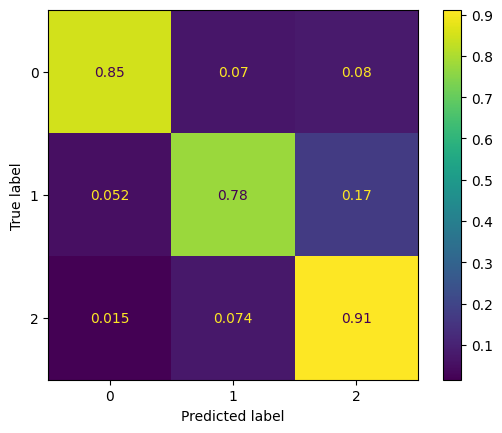

In [10]:
i=0
for tfold, (train_index, test_index) in enumerate(skf.split(X_train_over, y_train_over)):
    #모델 정의, 예측

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

    #DNN
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train.to_numpy())
    y_test = torch.LongTensor(y_test.to_numpy())

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset=TensorDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=10000,shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=5000,shuffle=False)

    # 최대 Epoch을 지정합니다.
    num_epochs = 1000
    min_loss = 9999999999999
    loss_list=[]
    acc_list=[]
    # Epoch 별 훈련 및 검증을 수행합니다.
    for epoch in range(num_epochs):
        # Model Training
        # 훈련 손실과 정확도를 반환 받습니다.
        train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)

        # 검증 손실과 검증 정확도를 반환 받습니다.
        val_loss, val_acc = model_evaluate(model, test_dataloader, loss_fn, device)   

        # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
        if val_loss < min_loss:
                print(f'[INFO] val_acc has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
                min_loss = val_loss
                torch.save(model.state_dict(), 'DNNModel.pth')

        # Epoch 별 결과를 출력합니다.
        print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
        loss_list.append(train_loss)
        acc_list.append(train_acc)
    ## 저장한 가중치 로드 후 검증 성능 측정

    # 모델에 저장한 가중치를 로드합니다.
    model.load_state_dict(torch.load('DNNModel.pth'))

    # 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
    print("{}번째 교차검증".format(tfold))
    final_loss, final_acc, y_predicted = model_test(model, test_dataloader, loss_fn, device)
    print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')   

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

#     ## 원핫 인코딩
#     y_train=pd.get_dummies(y_train)
#     y_test=pd.get_dummies(y_test)


    # LinearDiscriminantAnalysis
    ld = LinearDiscriminantAnalysis()
    ld.fit(X_train, y_train)
    linear_pred = ld.predict(X_test)
    # linear_pred = lr.predict(X_train)
    
    # DecisionTreeClassifier
    dt = DecisionTreeClassifier(max_depth=6)
    dt.fit(X_train, y_train)
    decisione_pred = dt.predict(X_test)
    # ridge_pred = clf.predict(X_train)
    
    # RandomForestClassifier
    regr = RandomForestClassifier(max_depth=6, random_state=0)
    regr.fit(X_train, y_train)
    regr_pred = regr.predict(X_test)
    # regr_pred = regr.predict(X_train)
    
    # GaussianNB
    gs = GaussianNB()
    gs.fit(X_train, y_train)
    gs_pred = gs.predict(X_test)
    # reg_pred = reg.predict(X_train)
    
    #SVM
    SVM = SVC(kernel='rbf', C=8, gamma=0.1)
    SVM.fit(X_train,y_train) # rbf Kernel
    SVM_pred = SVM.predict(X_test)
    
    
    # DNN 결과값 넘파이 배열로 변환
    y_predicted_t=sum(y_predicted, [])
    DNN_y_predicted=np.array(y_predicted_t)

    # 최종모델
#     lgbm = LGBMClassifier()
    CatBoost = CatBoostClassifier()
    new_data = np.array([linear_pred.squeeze(),decisione_pred.squeeze(),SVM_pred.squeeze(),regr_pred.squeeze(),gs_pred.squeeze(),DNN_y_predicted.squeeze()])
    # new_data = np.array([linear_pred,ridge_pred,regr_pred,reg_pred,DNN_y_predicted])
    print(new_data.shape)

    new_data = np.transpose(new_data)
    print(new_data.shape)

    #y_test를 파이토치에서 넘파이 배열로 변환
    y_test=np.array(y_test)
    
    #lgbm 학습하기
    CatBoost.fit(new_data,y_test)
    # lgbm.fit(new_data, y_train)
    
    #LGBMClassifier 예측하기
    CatBoost_pred = CatBoost.predict(new_data)
    # lgbm_pred = lgbm.predict(X_test)  
    
    accuracy=accuracy_score(y_test, CatBoost_pred) 
    print("[{}]Accuracy : {}".format(tfold,accuracy))   
    #f1score
    f1 = f1_score(y_test,CatBoost_pred, average='weighted')
    print("[{}]F1score : {}".format(tfold,f1))
    #precision/recall
    p_rlist=sk(y_test,CatBoost_pred,average='weighted')
    print("[{}]Precision : {}".format(tfold,p_rlist[0]))
    print("[{}]Recall : {}".format(tfold,p_rlist[1]))
    print()
     #결과 배열에 넣기
    Result[tfold][0]=accuracy
    Result[tfold][1]=f1
    Result[tfold][2]=p_rlist[0]
    Result[tfold][3]=p_rlist[1]
    del accuracy
    del f1
    del p_rlist
    
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    confusion_matrix(y_test, CatBoost_pred)

    cm = confusion_matrix(y_test, CatBoost_pred, labels=[0,1,2],normalize="true")
    CMResult[i]=cm
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
    filename=("ConfusionMatrix_"+"가우,랜포,LDA,SVM,catboost"+str(i))
    plt.savefig("./ConfusionMatrix/"+filename+".png")
    plt.show()
    
    i=i+1

In [11]:
Result_df=pd.DataFrame(Result,columns=['Accuracy','F1-Score','Precision','Recall'])
Result_df

Accuracy  F1-Score  Precision    Recall
0  0.662544  0.664139   0.667000  0.662544
1  0.786023  0.784974   0.788340  0.786023
2  0.823322  0.823146   0.829024  0.823322
3  0.847271  0.846837   0.849113  0.847271
4  0.798587  0.797822   0.808788  0.798587
5  0.855516  0.854035   0.856097  0.855516
6  0.825481  0.824682   0.829656  0.825481
7  0.812684  0.811992   0.815551  0.812684
8  0.823876  0.823724   0.825647  0.823876
9  0.845671  0.845831   0.851257  0.845671

In [12]:
Matrix=pd.DataFrame(Result_df['Accuracy'],columns=['Accuracy'])
Matrix['Accuracy']=Result_df['Accuracy']
A=[Result_df['Accuracy'].mean(),Result_df['F1-Score'].mean(),Result_df['Precision'].mean(),Result_df['Recall'].mean()]
A=pd.DataFrame(A,columns=['Accuracy'])
Matrix=pd.concat([Matrix,A])
Matrix=Matrix.transpose()
Matrix.to_excel('./PFMatrix_ensemble2_final2(cat_boost).xlsx')

In [13]:
new_data

array([[2, 2, 2, 2, 1, 2],
       [2, 2, 2, 2, 1, 2],
       [2, 2, 2, 2, 1, 2],
       ...,
       [2, 2, 2, 2, 0, 2],
       [0, 1, 1, 1, 0, 2],
       [0, 1, 2, 1, 0, 2]], dtype=int64)

In [14]:
lgbm_pred

NameError: name 'lgbm_pred' is not defined

In [ ]:
y_test